In [ ]:
import os

os.getcwd()

'/home/jupyter/Fine Tuning Scripts'

In [ ]:
os.chdir('/home/jupyter')

In [ ]:
!nvidia-smi

Wed May  1 23:12:45 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA A100-SXM4-40GB          On  | 00000000:00:04.0 Off |                    0 |
| N/A   29C    P0              53W / 400W |      4MiB / 40960MiB |      0%      Default |
|                                         |                      |             Disabled |
+-----------------------------------------+----------------------+--

In [ ]:
import torch

print("PyTorch Version:", torch.__version__)
print("CUDA Available:", torch.cuda.is_available())
if torch.cuda.is_available():
    print("CUDA Version:", torch.version.cuda)
    print("CUDA Device Name:", torch.cuda.get_device_name(0))


PyTorch Version: 2.1.2+cu121
CUDA Available: True
CUDA Version: 12.1
CUDA Device Name: NVIDIA A100-SXM4-40GB


In [ ]:
import sys

# Install or upgrade jupyter and ipywidgets using the current Python executable
!pip install --upgrade jupyter ipywidgets

# Enable the widgetsnbextension using the current Python executable
!jupyter nbextension enable --py widgetsnbextension

In [ ]:
# !python -m pip install --upgrade pip
# %pip install torch transformers timm einops datasets bitsandbytes accelerate -q
# !pip install peft -q
# !pip install flash-attn -q
# !pip install wandb -q

Note: you may need to restart the kernel to use updated packages.


In [ ]:
# !pip install hf_transfer -q

# NOW RESTART THE RUNTIME IN ORDER TO BENEFIT FROM INCREASED DOWNLOAD SPEEDS.
# RUN THE CELLS BELOW.

In [ ]:
# !python -m pip install --upgrade pip
# !pip install matplotlib -U

In [ ]:
# !pip install  datasets
# # !pip install -q git+https://github.com/huggingface/transformers.git@add-model-idefics
# !pip install transformers==4.37.2  -U
# !pip install  bitsandbytes sentencepiece==0.1.99 accelerate==0.21.0 loralib
# !pip install  peft
# !pip install hf_transfer  -U
# !pip install pickleshare

## Load Model

In [ ]:
import os
os.environ["HF_HUB_ENABLE_HF_TRANSFER"] = "1"

In [ ]:
import torch
from transformers import AutoTokenizer, AutoModelForCausalLM

model_slug="vikhyatk/moondream2"
MD_REVISION = "2024-04-02"


DEVICE = "cuda"
DTYPE = torch.float32 if DEVICE == "cpu" else torch.bfloat16 # CPU doesn't support float16. Also, switch to bfloat16 for Ampere architectures.
use_4bit = False
use_lora = True # must be true if using 4_bit and training.
set_other_trainable = True # to set embed layers trainable (fully trainable, not LoRA)

quantization_config = None
if use_4bit:
    from transformers import BitsAndBytesConfig
    bnb_config = BitsAndBytesConfig(
        load_in_4bit=True,
        bnb_4bit_use_double_quant=True,
        bnb_4bit_quant_type="nf4",
        bnb_4bit_compute_dtype=DTYPE
    )
    quantization_config = bnb_config

tokenizer = AutoTokenizer.from_pretrained(model_slug, revision=MD_REVISION)
model = AutoModelForCausalLM.from_pretrained(
    model_slug,
    revision=MD_REVISION,
    trust_remote_code=True,
    # attn_implementation="flash_attention_2" if DEVICE == "cuda" else None,
    torch_dtype=DTYPE,
    device_map={"": DEVICE},
    cache_dir='',
    quantization_config=quantization_config
)

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


[2024-05-01 23:12:57,195] [INFO] [real_accelerator.py:161:get_accelerator] Setting ds_accelerator to cuda (auto detect)


In [2]:
# print(model)

In [ ]:
# !pip install huggingface_hub -q -U

In [ ]:
# Required when loading models/data that are gated on HuggingFace, and required for pushing models to HuggingFace.

from huggingface_hub import notebook_login

notebook_login()

In [ ]:
#Adjust projector

import torch
from torch import nn

class AdjustedMMProjector(nn.Module):
    def __init__(self):
        super(AdjustedMMProjector, self).__init__()
        self.fc1 = nn.Linear(in_features=1152, out_features=8192, bias=True)
        self.gelu = nn.GELU()
        self.fc2 = nn.Linear(in_features=8192, out_features=2048, bias=True)

        # Weight initialization
        nn.init.normal_(self.fc1.weight, mean=0.0, std=0.02)
        nn.init.zeros_(self.fc1.bias)
        nn.init.normal_(self.fc2.weight, mean=0.0, std=0.02)
        nn.init.zeros_(self.fc2.bias)

    def forward(self, x):
        x = self.fc1(x)
        x = self.gelu(x)
        x = self.fc2(x)
        return x

# Define VisionProjection using the AdjustedMMProjector
class VisionProjection(nn.Module):
    def __init__(self):
        super(VisionProjection, self).__init__()
        self.mlp = AdjustedMMProjector()

    def forward(self, x):
        return self.mlp(x)

# Assuming `model` is your existing model instance
# Replace the existing projector in the vision encoder
model.vision_encoder.projection = VisionProjection()

# Move the new projection module to the appropriate device, e.g., CUDA if using GPU
if torch.cuda.is_available():
    model.vision_encoder.projection.to("cuda")

In [ ]:
# model=model.half() #for float16

def to_bfloat16(model): #for bfloat16
    for param in model.parameters():
        param.data = param.data.to(torch.bfloat16)
    for buffer in model.buffers():
        buffer.data = buffer.data.to(torch.bfloat16)

to_bfloat16(model)

In [3]:
# custom_model_slug="Mahmudul/moondream_custom"

# model.save_pretrained(custom_model_slug, private=True)
# tokenizer.save_pretrained(custom_model_slug, private=True)

# # Now go back up in the script and reload this model so that the tensors are correctly distributed to the GPUs for inference and training.

## Reloading the model

In [ ]:
import torch
from transformers import AutoTokenizer, AutoModelForCausalLM

# Change the model slug to the custom model's slug on Hugging Face Hub
model_slug = "Mahmudul/moondream_custom"
MD_REVISION = "2024-04-02"
# MD_REVISION = None  # Set this to None unless you are using versioning

DEVICE = "cuda"
DTYPE = torch.float32 if DEVICE == "cpu" else torch.bfloat16 # CPU doesn't support float16. Also, switch to bfloat16 for Ampere architectures.
use_4bit = False
use_lora = True # must be true if using 4_bit and training.
set_other_trainable = True # to set embed layers trainable

quantization_config = None
if use_4bit:
    from transformers import BitsAndBytesConfig
    bnb_config = BitsAndBytesConfig(
        load_in_4bit=True,
        bnb_4bit_use_double_quant=True,
        bnb_4bit_quant_type="nf4",
        bnb_4bit_compute_dtype=DTYPE
    )
    quantization_config = bnb_config

tokenizer = AutoTokenizer.from_pretrained(model_slug, revision=MD_REVISION)
model = AutoModelForCausalLM.from_pretrained(
    model_slug,
    revision=MD_REVISION,
    trust_remote_code=True,
    torch_dtype=DTYPE,
    device_map={"": DEVICE},
    cache_dir='',  # Adjust cache directory if necessary
    quantization_config=quantization_config
)


Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


In [ ]:
# print(model)

## Dataset loading

In [ ]:
# from io import BytesIO
# from PIL import Image

# class ImageCLEFDataset(Dataset):
#     def __init__(self, split='train'):
#         self.data = load_dataset("HoqueMahmudul/test", split=split)

#     def __len__(self):
#         return len(self.data)

#     def __getitem__(self, idx):
#         sample = self.data[idx]
#         image_data = BytesIO(sample['image'])  # Wrap the binary data in BytesIO
#         image = Image.open(image_data).convert('RGB')  # Open the "file" and convert to RGB
#         #image = preprocess(image)  # Apply the transformations

#         return {
#             "image": image,  # Image is now a PIL Image object
#             "qa": [
#                 {
#                     "question": "What do you see?",
#                     "answer": sample['caption'],
#                 }
#             ]
#         }

# # Creating dataset instances
# datasets = {
#     "train": ImageCLEFDataset("train"),
#     # "val": ImageCLEFDataset("validation"),  # Uncomment if you have a validation split
#     "test": ImageCLEFDataset("test"),
# }


In [ ]:
# Define the preprocessing pipeline
preprocess = transforms.Compose([
    #transforms.Resize((378, 378)),  # Resize to the size expected by the model
    transforms.ToTensor(),          # Convert image to tensor
    #transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])  # Normalize
])

In [ ]:
# from torchvision import transforms
# from torch.utils.data import Dataset
# from datasets import load_dataset
# from PIL import Image

# class ImageCLEFDataset(Dataset):
#     def __init__(self, split='train'):
#         self.data = load_dataset("HoqueMahmudul/test", split=split)

#     def __len__(self):
#         return len(self.data)

#     def __getitem__(self, idx):
#         sample = self.data[idx]
#         image = sample['image'].convert('RGB')  # Convert to RGB if not already
#         #image = preprocess(image)  # Apply the transformations

#         return {
#             "image": image,  # Image is now a tensor
#             "qa": [
#                 {
#                     "question": "What do you see?",
#                     "answer": sample['caption'],
#                 }
#             ]
#         }

# # Creating dataset instances
# datasets = {
#     "train": ImageCLEFDataset("train"),
#     # "val": ImageCLEFDataset("validation"),  # Uncomment if you have a validation split
#     "test": ImageCLEFDataset("test"),
# }


In [ ]:
# from torchvision import transforms
# from torch.utils.data import Dataset, DataLoader
# from datasets import load_dataset
# from PIL import Image



# class ImageCLEFDataset(Dataset):
#     def __init__(self, split='train'):
#         self.data = load_dataset("HoqueMahmudul/test", split=split)

#     def __len__(self):
#         return len(self.data)

#     def __getitem__(self, idx):
#         sample = self.data[idx]
#         image = sample['image'].convert('RGB')  # Convert to RGB if not already
#         #image = preprocess(image)  # Apply the transformations

#         return {
#             "image": image,  # Image is now a tensor
#             "qa": [
#                 {
#                     "question": "What do you see?",
#                     "answer": sample['caption'],
#                 }
#             ]
#         }

# # Creating dataset instances
# datasets = {
#     "train": ImageCLEFDataset("train"),
#     "test": ImageCLEFDataset("test"),
# }


In [ ]:
print(datasets['train'][0])

{'image': tensor([[[0.9922, 0.9922, 1.0000,  ..., 0.9922, 0.9922, 1.0000],
         [1.0000, 0.9843, 0.9922,  ..., 0.9843, 0.9765, 1.0000],
         [0.9765, 0.9843, 0.9843,  ..., 0.9922, 0.9843, 0.9922],
         ...,
         [0.9765, 0.9922, 0.9843,  ..., 0.9922, 0.9922, 1.0000],
         [0.9922, 0.9922, 0.9843,  ..., 0.9922, 0.9922, 1.0000],
         [0.9922, 0.9922, 1.0000,  ..., 0.9922, 0.9922, 1.0000]],

        [[0.9922, 0.9922, 1.0000,  ..., 0.9922, 0.9922, 1.0000],
         [1.0000, 0.9843, 0.9922,  ..., 0.9843, 0.9765, 1.0000],
         [0.9765, 0.9843, 0.9843,  ..., 0.9922, 0.9843, 0.9922],
         ...,
         [0.9765, 0.9922, 0.9843,  ..., 0.9922, 0.9922, 1.0000],
         [0.9922, 0.9922, 0.9843,  ..., 0.9922, 0.9922, 1.0000],
         [0.9922, 0.9922, 1.0000,  ..., 0.9922, 0.9922, 1.0000]],

        [[0.9922, 0.9922, 1.0000,  ..., 0.9922, 0.9922, 1.0000],
         [1.0000, 0.9843, 0.9922,  ..., 0.9843, 0.9765, 1.0000],
         [0.9765, 0.9843, 0.9843,  ..., 0.9922, 

In [ ]:
# from torch.utils.data import DataLoader

# train_loader = DataLoader(
#     datasets['train'],
#     batch_size=32,        # Adjust based on your GPU memory
#     shuffle=True,
#     num_workers=4,        # Based on your CPU and how quickly it can load data
#     pin_memory=True       # Helps with faster data transfer to CUDA devices
# )


In [ ]:
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader
from datasets import load_dataset
from PIL import Image
import torch
from torchvision.transforms.functional import to_pil_image
from IPython.display import display

# Define the preprocessing pipeline
preprocess = transforms.Compose([
    transforms.Resize((378, 378)),  # Resize to the size expected by the model
    transforms.ToTensor(),          # Convert image to tensor
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])  # Normalize
])

class ImageCLEFDataset(Dataset):
    def __init__(self, split='train'):
        self.data = load_dataset("HoqueMahmudul/clef2024_train_valid_a", split=split)

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        sample = self.data[idx]
        image = sample['image'].convert('RGB')  # Convert to RGB if not already
        image = preprocess(image)  # Apply the transformations
        return {
            "image": image,  # Image is now a tensor
            "qa": [
                {
                    "question": "What do you see?",
                    "answer": sample['caption'],
                }
            ]
        }

# Function to convert tensor to PIL Image
def tensor_to_pil(tensor):
    # Un-normalize the image
    tensor = tensor * torch.tensor([0.5, 0.5, 0.5]).view(3, 1, 1) + torch.tensor([0.5, 0.5, 0.5]).view(3, 1, 1)
    tensor = tensor.clamp(0, 1)
    # Convert to PIL Image
    return to_pil_image(tensor)

# Creating dataset instances
datasets = {
    "train": ImageCLEFDataset("train"),
    "test": ImageCLEFDataset("test"),
}




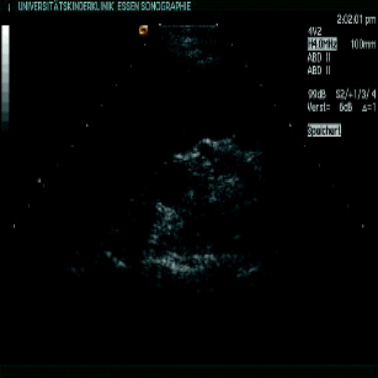

Question: What do you see?
Ground Truth: Acquired renal cysts in end-stage renal failure: 16-year-old girl with Alport syndrome and peritoneal dialysis from the age of 2 years
Model answer: I see a dog.


In [ ]:
# Ensure the image has a batch dimension before passing to the model
sample = datasets['train'][1]  # Fetch a sample
image_tensor = sample['image'].unsqueeze(0)  # Add the batch dimension

# Display the image
pil_image = tensor_to_pil(sample['image'])
display(pil_image)

# Processing the image with the model
model.eval()  # Set the model to evaluation mode
for qa in sample['qa']:
    print('Question:', qa['question'])
    print('Ground Truth:', qa['answer'])
    # Encode image and perform inference
    encoded_image = model.encode_image(image_tensor)  # Make sure the model can handle batched input
    answer = model.answer_question(encoded_image, qa['question'], tokenizer=tokenizer)
    print('Model answer:', answer)

## above section finished

In [ ]:
# Ensure the image has a batch dimension before passing to the model
sample = datasets['train'][1]  # Fetch a sample
image_tensor = sample['image'].unsqueeze(0)  # Add the batch dimension

# Now image_tensor is correctly shaped as [1, C, H, W]

# Display the image (assuming you're in a Jupyter environment or similar)
from IPython.display import display
display(image_tensor)

# Processing the image with the model
model.eval()  # Set the model to evaluation mode
for qa in sample['qa']:
    print('Question:', qa['question'])
    print('Ground Truth:', qa['answer'])
    # Encode image and perform inference
    encoded_image = model.encode_image(image_tensor)  # Make sure the model can handle batched input
    answer = model.answer_question(encoded_image, qa['question'], tokenizer=tokenizer)
    print('Model answer:', answer)

tensor([[[[ 0.3098, -0.0353, -0.0431,  ..., -0.0510, -0.0196,  0.4588],
          [-0.2706, -0.9137, -0.9451,  ..., -0.9451, -0.8902, -0.0118],
          [-0.3020, -0.9686, -0.9922,  ..., -1.0000, -0.9451, -0.0353],
          ...,
          [ 0.0118, -0.6706, -0.8667,  ..., -0.9843, -0.9294, -0.0353],
          [ 0.6078,  0.2392, -0.0275,  ..., -0.8745, -0.8196,  0.0196],
          [ 0.9843,  0.9294,  0.8275,  ...,  0.2706,  0.2941,  0.6157]],

         [[ 0.3098, -0.0353, -0.0431,  ..., -0.0510, -0.0196,  0.4588],
          [-0.2706, -0.9137, -0.9451,  ..., -0.9451, -0.8902, -0.0118],
          [-0.3020, -0.9686, -0.9922,  ..., -1.0000, -0.9451, -0.0353],
          ...,
          [ 0.0118, -0.6706, -0.8667,  ..., -0.9843, -0.9294, -0.0353],
          [ 0.6078,  0.2392, -0.0275,  ..., -0.8745, -0.8196,  0.0196],
          [ 0.9843,  0.9294,  0.8275,  ...,  0.2706,  0.2941,  0.6157]],

         [[ 0.3098, -0.0353, -0.0431,  ..., -0.0510, -0.0196,  0.4588],
          [-0.2706, -0.9137, -

Question: What do you see?
Ground Truth: CTA of a 8-year old female who presentend with hematemesis due to variceal bleeding. Axial CT image in the portal venous phase shows an aberrant mesenteric retroduodenal venous collateral (arrow)
Model answer: The image shows a person sitting in a chair, possibly in a living room or a similar indoor space. The person is wearing a backpack, which is placed on the floor next to them. The backpack is positioned in a way that it is visible and accessible, suggesting that the person might be preparing to go out or has just returned from an outing.


In [1]:
# from IPython.display import display

# model.eval()

# sample = datasets['train'][1]
# display(sample['image'])

# for qa in sample['qa']:
#     print('Question:', qa['question'])
#     print('Ground Truth:', qa['answer'])
#     print('model:', model.answer_question(
#         model.encode_image(sample['image']),
#         qa['question'],
#         tokenizer=tokenizer,
#     ))

## Set up LoRA

In [ ]:
# print(model)

In [ ]:
# if use_4bit:
#     from peft import prepare_model_for_kbit_training
#     model.gradient_checkpointing_enable()
#     model = prepare_model_for_kbit_training(model)

lora_alpha = 32
lora_rank = 64

## Apply LoRA (if use_lora is True in the config)
if use_lora:
    from peft import LoraConfig
    lora_config = LoraConfig(
        r=lora_rank,
        lora_alpha=lora_alpha,
        target_modules=[
            'proj','fc1','fc2',
            'Wqkv','out_proj'
        ],
        lora_dropout=0.1,  # Example value, adjust as needed
        bias="none",  # Example setting, adjust as needed
        task_type="CAUSAL_LM",
        # modules_to_save=['lm_head','embd'], #won't work with the trainer unless using a hf trainer, not custom.
    )

#### Applying LoRA

In [ ]:
if use_lora:
    from peft import get_peft_model
    model = get_peft_model(model, lora_config)
    model.print_trainable_parameters()

trainable params: 74,422,272 || all params: 1,931,904,880 || trainable%: 3.8522741347389733


In [4]:
# print(model.config)

In [ ]:
# # List to hold the names of the trainable parameters
# if set_other_trainable:
#     trainable_params_names = ['lm_head','embd']
#     # trainable_params_names = None

#     # Set modules to be trainable
#     for n, p in model.named_parameters():
#         if any(k in n for k in trainable_params_names):
#             p.requires_grad_(True)
#         # else:
#         #     p.requires_grad_(False)  # Optional: Set the rest to be not trainable

#     # Make a dictionary of trainable parameters
#     trainable_params = {n: p for n, p in model.named_parameters() if p.requires_grad}

#     # Convert trainable_params to state_dict format
#     trainable_params_state_dict = {n: p.data for n, p in trainable_params.items()}

## Training

In [ ]:
# import wandb
# !wandb login

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


wandb: Currently logged in as: mdemo1 (msu_cvi_lab). Use `wandb login --relogin` to force relogin


In [ ]:
import wandb
api_key = '306b87857e8ad75f34e72e92d97a349db2e0c980'
wandb.login(key=api_key)


wandb: Currently logged in as: cvandinfo-2024 (https-www-morgan-edu). Use `wandb login --relogin` to force relogin
wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: /home/jupyter/.netrc


True

In [ ]:
import wandb
wandb.login(relogin=True)

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit:

  ········


wandb: Appending key for api.wandb.ai to your netrc file: /home/jupyter/.netrc


True

In [ ]:
# EPOCHS = 2
# BATCH_SIZE = 8
# GRAD_ACCUM_STEPS = 4
# LR = 3e-5 # default value

# if use_lora:
#     LR_scaling = lora_alpha / (lora_rank**0.5)
#     print("Using an LR scaling for LoRA adapters of: ", LR_scaling)

# # Whether to use Weights and Biases for logging training metrics.
# USE_WANDB = True

# # Eval steps- eval_freq to 0.25 means the model is evaluated four times per epoch
# eval_freq = 0.5 # means run every such fraction of total steps.

Using an LR scaling for LoRA adapters of:  4.0


In [ ]:
# Number of times to repeat the training dataset. Increasing this may cause the model to overfit or
# lose generalization due to catastrophic forgetting. Decreasing it may cause the model to underfit.
EPOCHS = 10

# Number of samples to process in each batch. Set this to the highest value that doesn't cause an
# out-of-memory error. Decrease it if you're running out of memory. Batch size 8 currently uses around
# 15 GB of GPU memory during fine-tuning.
BATCH_SIZE = 8


GRAD_ACCUM_STEPS = 4


LR = 3e-5 # default value
# LR = 1.5e-5

if use_lora:
    LR_scaling = lora_alpha / (lora_rank**0.5)
    print("Using an LR scaling for LoRA adapters of: ", LR_scaling)

# Whether to use Weights and Biases for logging training metrics.
USE_WANDB = True

# Eval steps- eval_freq to 0.25 means the model is evaluated four times per epoch
eval_freq = 1 # means run every such fraction of total steps.

Using an LR scaling for LoRA adapters of:  4.0


In [ ]:
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader
from bitsandbytes.optim import Adam8bit
import math
from einops import rearrange
from tqdm import tqdm

## Early Stopping

In [ ]:
# !pip install wandb

In [ ]:
class EarlyStopping:
    def __init__(self, patience=2, min_delta=0):
        """
        Args:
            patience (int): Number of epochs to wait after min has been hit. After this
                            number of no improvement, training stops.
            min_delta (float): Minimum change in the monitored quantity to qualify as an improvement.
        """
        self.patience = patience
        self.min_delta = min_delta
        self.counter = 0
        self.best_loss = None
        self.early_stop = False

    def __call__(self, val_loss):
        if self.best_loss is None:
            self.best_loss = val_loss
        elif val_loss > self.best_loss - self.min_delta:
            self.counter += 1
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_loss = val_loss
            self.counter = 0


In [ ]:
early_stopper = EarlyStopping(patience=6, min_delta=0.0001)  # Customize to your needs

In [ ]:
from torch.utils.data import DataLoader
from bitsandbytes.optim import Adam8bit
import math
from einops import rearrange
from tqdm import tqdm

ANSWER_EOS = "<|endoftext|>"

# Number of tokens used to represent each image.
IMG_TOKENS = 729

def collate_fn(batch):
    images = [sample['image'] for sample in batch]
    images = torch.stack(images)  # Stack images adding the batch dimension: [N, C, H, W]

    # Assuming the model's vision encoder can handle standard image tensors
    if hasattr(model.vision_encoder, 'preprocess'):
        images = model.vision_encoder.preprocess(images)

    print("Shape after preprocessing:", images.shape)

    labels_acc = []
    tokens_acc = []
    for sample in batch:
        toks = [tokenizer.bos_token_id]
        labs = [-100] * (IMG_TOKENS + 1)
        for qa in sample['qa']:
            q_t = tokenizer(f"\n\nQuestion: {qa['question']}\n\nAnswer:", add_special_tokens=False).input_ids
            toks.extend(q_t)
            labs.extend([-100] * len(q_t))
            a_t = tokenizer(f" {qa['answer']}{ANSWER_EOS}", add_special_tokens=False).input_ids
            toks.extend(a_t)
            labs.extend(a_t)

        tokens_acc.append(toks)
        labels_acc.append(labs)

    max_len = max(len(labels) for labels in labels_acc)
    attn_mask_acc = []
    for i in range(len(batch)):
        len_i = len(labels_acc[i])
        pad_i = max_len - len_i
        labels_acc[i].extend([-100] * pad_i)
        tokens_acc[i].extend([tokenizer.eos_token_id] * pad_i)
        attn_mask_acc.append([1] * len_i + [0] * pad_i)

    return (
        images.to(dtype=DTYPE),
        torch.stack([torch.tensor(t, dtype=torch.long) for t in tokens_acc]),
        torch.stack([torch.tensor(l, dtype=torch.long) for l in labels_acc]),
        torch.stack([torch.tensor(a, dtype=torch.bool) for a in attn_mask_acc]),
    )

dataloaders = {
    "train": DataLoader(
        datasets["train"],
        batch_size=BATCH_SIZE,
        shuffle=True,
        collate_fn=collate_fn,
    ),
    "test": DataLoader(
        datasets["test"],
        batch_size=8,
        collate_fn=collate_fn,
    ),
}

total_steps = EPOCHS * len(dataloaders["train"]) // GRAD_ACCUM_STEPS
eval_steps=total_steps*eval_freq # Calculate eval steps as a fraction of total steps

def compute_loss(batch):
    images, tokens, labels, attn_mask = batch
    print("Image shape before encoding:", images.shape)  # Debug print to check shape

    images = images.to(DEVICE)
    tokens = tokens.to(DEVICE)
    labels = labels.to(DEVICE)
    attn_mask = attn_mask.to(DEVICE)

    with torch.no_grad():
        img_embs = model.vision_encoder.encoder(images)
        img_embs = model.vision_encoder.projection(img_embs)

    tok_embs = model.text_model.get_input_embeddings()(tokens)
    inputs_embeds = torch.cat((tok_embs[:, 0:1, :], img_embs, tok_embs[:, 1:, :]), dim=1)

    outputs = model.text_model(inputs_embeds=inputs_embeds, labels=labels, attention_mask=attn_mask)
    return outputs.loss


# Cosine learning rate schedule.
def lr_schedule(step, max_steps):
    x = step / max_steps
    if x < 0.1:
        return 0.1 * LR + 0.9 * LR * x / 0.1
    else:
        return 0.1 * LR + 0.9 * LR * (1 + math.cos(math.pi * (x - 0.1))) / 2

# # Constant learning rate schedule.
# def lr_schedule(step, max_steps):
#     x = step / max_steps
#     if x < 0.1:
#         return 0.1 * LR + 0.9 * LR * x / 0.1
#     else:
#         return LR

model.text_model.train()
model.text_model.transformer.gradient_checkpointing_enable(gradient_checkpointing_kwargs={"use_reentrant":False},) #this fixes the no grad issues...

## For fine-tuning LoRA params
lora_params = []
for name, module in model.named_modules():
    if "lora" in name:
        lora_params.extend([p for p in module.parameters() if p.requires_grad])

# To fine-tune all lora params (which can include the vision model)
optimizer = Adam8bit(
    [
        {"params": lora_params},
    ],
    lr=LR * 0.1,
    betas=(0.9, 0.95),
    eps=1e-6
)

# # For fine-tuning all text model params
# optimizer = Adam8bit(
#     [
#         {"params": model.text_model.parameters()},
#     ],
#     # [{"params": lora_params}],
#     lr=LR * 0.1,
#     betas=(0.9, 0.95),
#     eps=1e-6
# )

if USE_WANDB:
    import wandb
    wandb.init(
        project="model-ft",
        config={
            "EPOCHS": EPOCHS,
            "BATCH_SIZE": BATCH_SIZE,
            "GRAD_ACCUM_STEPS": GRAD_ACCUM_STEPS,
            "LR": LR,
        }
    )

i = 0

for epoch in range(EPOCHS):
    for batch in tqdm(dataloaders["train"], desc=f"Epoch {epoch + 1}/{EPOCHS}"):
        i += 1

        loss = compute_loss(batch)
        loss.backward()

        if i % GRAD_ACCUM_STEPS == 0:
            optimizer.step()
            optimizer.zero_grad()

        lr = lr_schedule(i / GRAD_ACCUM_STEPS, total_steps)
        for param_group in optimizer.param_groups:
            if param_group['params'] == lora_params:
                param_group['lr'] = lr * LR_scaling
            else:
                param_group['lr'] = lr

    # Calculate validation loss
    val_loss = 0
    for val_batch in tqdm(dataloaders["test"], desc="Validation"):
        with torch.no_grad():
            val_loss += compute_loss(val_batch).item()
    val_loss /= len(dataloaders["test"])

    # Log to Weights and Biases
    if USE_WANDB:
        wandb.log({
            "epoch": epoch,
            "loss/train": loss.item(),
            "loss/val": val_loss,
            "lr": optimizer.param_groups[0]['lr']
        })

    # Check if early stopping is necessary
    early_stopper(val_loss)
    if early_stopper.early_stop:
        print("Early stopping triggered")
        break

if USE_WANDB:
    wandb.finish()


Epoch 1/10:   0%|          | 0/8764 [00:00<?, ?it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/10:   0%|          | 1/8764 [00:00<1:39:41,  1.47it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/10:   0%|          | 2/8764 [00:01<1:42:21,  1.43it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/10:   0%|          | 3/8764 [00:02<1:44:41,  1.39it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/10:   0%|          | 4/8764 [00:03<1:56:42,  1.25it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/10:   0%|          | 5/8764 [00:03<1:47:59,  1.35it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/10:   0%|          | 6/8764 [00:04<1:46:44,  1.37it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/10:   0%|          | 7/8764 [00:05<1:44:41,  1.39it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/10:   0%|          | 8/8764 [00:05<1:51:27,  1.31it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/10:   0%|          | 9/8764 [00:06<1:45:19,  1.39it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/10:   0%|          | 10/8764 [00:07<1:44:25,  1.40it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/10:   0%|          | 11/8764 [00:08<1:44:55,  1.39it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/10:   0%|          | 12/8764 [00:08<1:51:14,  1.31it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/10:   0%|          | 13/8764 [00:09<1:45:11,  1.39it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/10:   0%|          | 14/8764 [00:10<1:45:15,  1.39it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/10:   0%|          | 15/8764 [00:10<1:44:13,  1.40it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/10:   0%|          | 16/8764 [00:11<1:50:39,  1.32it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/10:   0%|          | 17/8764 [00:12<1:48:38,  1.34it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/10:   0%|          | 18/8764 [00:13<1:48:20,  1.35it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/10:   0%|          | 19/8764 [00:13<1:46:44,  1.37it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/10:   0%|          | 20/8764 [00:14<1:55:51,  1.26it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/10:   0%|          | 21/8764 [00:15<1:49:35,  1.33it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/10:   0%|          | 22/8764 [00:16<1:53:46,  1.28it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/10:   0%|          | 23/8764 [00:17<1:51:33,  1.31it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/10:   0%|          | 24/8764 [00:18<1:57:35,  1.24it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/10:   0%|          | 25/8764 [00:18<1:51:01,  1.31it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/10:   0%|          | 26/8764 [00:19<1:49:10,  1.33it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/10:   0%|          | 27/8764 [00:20<1:47:30,  1.35it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/10:   0%|          | 28/8764 [00:20<1:52:34,  1.29it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/10:   0%|          | 29/8764 [00:21<1:49:51,  1.33it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/10:   0%|          | 30/8764 [00:22<1:47:39,  1.35it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/10:   0%|          | 31/8764 [00:23<1:45:33,  1.38it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/10:   0%|          | 32/8764 [00:23<1:51:01,  1.31it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/10:   0%|          | 33/8764 [00:24<1:46:17,  1.37it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/10:   0%|          | 34/8764 [00:25<1:45:13,  1.38it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/10:   0%|          | 35/8764 [00:25<1:43:56,  1.40it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/10:   0%|          | 36/8764 [00:26<1:49:55,  1.32it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/10:   0%|          | 37/8764 [00:27<1:45:28,  1.38it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/10:   0%|          | 38/8764 [00:28<1:45:17,  1.38it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/10:   0%|          | 39/8764 [00:28<1:44:01,  1.40it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/10:   0%|          | 40/8764 [00:29<1:49:59,  1.32it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/10:   0%|          | 41/8764 [00:30<1:45:34,  1.38it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/10:   0%|          | 42/8764 [00:31<1:45:00,  1.38it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/10:   0%|          | 43/8764 [00:31<1:44:31,  1.39it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/10:   1%|          | 44/8764 [00:32<1:50:59,  1.31it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/10:   1%|          | 45/8764 [00:33<1:45:48,  1.37it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/10:   1%|          | 46/8764 [00:34<1:45:27,  1.38it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/10:   1%|          | 47/8764 [00:34<1:44:53,  1.39it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/10:   1%|          | 48/8764 [00:35<1:52:36,  1.29it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/10:   1%|          | 49/8764 [00:36<1:49:46,  1.32it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/10:   1%|          | 50/8764 [00:37<1:49:06,  1.33it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/10:   1%|          | 51/8764 [00:37<1:48:28,  1.34it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/10:   1%|          | 52/8764 [00:38<1:53:28,  1.28it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/10:   1%|          | 53/8764 [00:39<1:50:19,  1.32it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/10:   1%|          | 54/8764 [00:40<1:50:15,  1.32it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/10:   1%|          | 55/8764 [00:40<1:48:09,  1.34it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/10:   1%|          | 56/8764 [00:41<1:52:30,  1.29it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/10:   1%|          | 57/8764 [00:42<1:47:07,  1.35it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/10:   1%|          | 58/8764 [00:43<1:45:50,  1.37it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/10:   1%|          | 59/8764 [00:43<1:44:37,  1.39it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/10:   1%|          | 60/8764 [00:44<1:51:10,  1.30it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/10:   1%|          | 61/8764 [00:45<1:45:58,  1.37it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/10:   1%|          | 62/8764 [00:46<1:46:29,  1.36it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/10:   1%|          | 63/8764 [00:46<1:46:29,  1.36it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/10:   1%|          | 64/8764 [00:47<1:51:44,  1.30it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/10:   1%|          | 65/8764 [00:48<1:49:12,  1.33it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/10:   1%|          | 66/8764 [00:49<1:47:58,  1.34it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/10:   1%|          | 67/8764 [00:49<1:46:12,  1.36it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/10:   1%|          | 68/8764 [00:50<1:53:08,  1.28it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/10:   1%|          | 69/8764 [00:51<1:47:01,  1.35it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/10:   1%|          | 70/8764 [00:52<1:45:06,  1.38it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/10:   1%|          | 71/8764 [00:52<1:43:38,  1.40it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/10:   1%|          | 72/8764 [00:53<1:51:25,  1.30it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/10:   1%|          | 73/8764 [00:54<1:46:15,  1.36it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/10:   1%|          | 74/8764 [00:55<1:45:47,  1.37it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/10:   1%|          | 75/8764 [00:55<1:44:45,  1.38it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/10:   1%|          | 76/8764 [00:56<1:58:40,  1.22it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/10:   1%|          | 77/8764 [00:57<1:51:11,  1.30it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/10:   1%|          | 78/8764 [00:58<1:47:55,  1.34it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/10:   1%|          | 79/8764 [00:58<1:47:31,  1.35it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/10:   1%|          | 80/8764 [00:59<1:53:24,  1.28it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/10:   1%|          | 81/8764 [01:00<1:51:12,  1.30it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/10:   1%|          | 82/8764 [01:01<1:50:10,  1.31it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/10:   1%|          | 83/8764 [01:01<1:49:06,  1.33it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/10:   1%|          | 84/8764 [01:02<1:53:58,  1.27it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/10:   1%|          | 85/8764 [01:03<1:47:33,  1.34it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/10:   1%|          | 86/8764 [01:04<1:45:45,  1.37it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/10:   1%|          | 87/8764 [01:04<1:44:07,  1.39it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/10:   1%|          | 88/8764 [01:05<1:53:26,  1.27it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/10:   1%|          | 89/8764 [01:06<1:47:47,  1.34it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/10:   1%|          | 90/8764 [01:07<1:46:22,  1.36it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/10:   1%|          | 91/8764 [01:07<1:44:45,  1.38it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/10:   1%|          | 92/8764 [01:08<1:50:13,  1.31it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/10:   1%|          | 93/8764 [01:09<1:44:14,  1.39it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/10:   1%|          | 94/8764 [01:10<1:43:18,  1.40it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/10:   1%|          | 95/8764 [01:10<1:41:54,  1.42it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/10:   1%|          | 96/8764 [01:11<1:47:46,  1.34it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/10:   1%|          | 97/8764 [01:12<1:43:36,  1.39it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/10:   1%|          | 98/8764 [01:12<1:43:00,  1.40it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/10:   1%|          | 99/8764 [01:13<1:42:37,  1.41it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/10:   1%|          | 100/8764 [01:14<1:48:19,  1.33it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/10:   1%|          | 101/8764 [01:15<1:42:59,  1.40it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/10:   1%|          | 102/8764 [01:15<1:43:52,  1.39it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/10:   1%|          | 103/8764 [01:16<1:43:04,  1.40it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/10:   1%|          | 104/8764 [01:17<1:50:43,  1.30it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/10:   1%|          | 105/8764 [01:18<1:44:44,  1.38it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/10:   1%|          | 106/8764 [01:18<1:43:58,  1.39it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/10:   1%|          | 107/8764 [01:19<1:42:56,  1.40it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/10:   1%|          | 108/8764 [01:20<1:49:30,  1.32it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/10:   1%|          | 109/8764 [01:20<1:45:08,  1.37it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/10:   1%|▏         | 110/8764 [01:21<1:45:46,  1.36it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/10:   1%|▏         | 111/8764 [01:22<1:47:48,  1.34it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/10:   1%|▏         | 112/8764 [01:23<1:55:02,  1.25it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/10:   1%|▏         | 113/8764 [01:24<1:48:48,  1.33it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/10:   1%|▏         | 114/8764 [01:24<1:48:44,  1.33it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/10:   1%|▏         | 115/8764 [01:25<1:50:59,  1.30it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/10:   1%|▏         | 116/8764 [01:26<1:56:47,  1.23it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/10:   1%|▏         | 117/8764 [01:27<1:49:42,  1.31it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/10:   1%|▏         | 118/8764 [01:27<1:47:08,  1.34it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/10:   1%|▏         | 119/8764 [01:28<1:45:02,  1.37it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/10:   1%|▏         | 120/8764 [01:29<1:59:10,  1.21it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/10:   1%|▏         | 121/8764 [01:30<1:51:11,  1.30it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/10:   1%|▏         | 122/8764 [01:30<1:49:46,  1.31it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/10:   1%|▏         | 123/8764 [01:31<1:47:48,  1.34it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/10:   1%|▏         | 124/8764 [01:32<1:53:07,  1.27it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/10:   1%|▏         | 125/8764 [01:33<1:46:00,  1.36it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/10:   1%|▏         | 126/8764 [01:33<1:47:20,  1.34it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/10:   1%|▏         | 127/8764 [01:34<1:46:32,  1.35it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/10:   1%|▏         | 128/8764 [01:35<1:52:06,  1.28it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/10:   1%|▏         | 129/8764 [01:36<1:49:13,  1.32it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/10:   1%|▏         | 130/8764 [01:37<1:48:47,  1.32it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/10:   1%|▏         | 131/8764 [01:37<1:47:15,  1.34it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/10:   2%|▏         | 132/8764 [01:38<1:52:33,  1.28it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/10:   2%|▏         | 133/8764 [01:39<1:46:47,  1.35it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/10:   2%|▏         | 134/8764 [01:39<1:45:10,  1.37it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/10:   2%|▏         | 135/8764 [01:40<1:43:27,  1.39it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/10:   2%|▏         | 136/8764 [01:41<1:48:57,  1.32it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/10:   2%|▏         | 137/8764 [01:42<1:44:17,  1.38it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/10:   2%|▏         | 138/8764 [01:42<1:43:43,  1.39it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/10:   2%|▏         | 139/8764 [01:43<1:43:00,  1.40it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/10:   2%|▏         | 140/8764 [01:44<1:48:48,  1.32it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/10:   2%|▏         | 141/8764 [01:45<1:43:53,  1.38it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/10:   2%|▏         | 142/8764 [01:45<1:43:18,  1.39it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/10:   2%|▏         | 143/8764 [01:46<1:43:00,  1.39it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/10:   2%|▏         | 144/8764 [01:47<1:48:55,  1.32it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/10:   2%|▏         | 145/8764 [01:47<1:44:35,  1.37it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/10:   2%|▏         | 146/8764 [01:48<1:45:03,  1.37it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/10:   2%|▏         | 147/8764 [01:49<1:44:08,  1.38it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/10:   2%|▏         | 148/8764 [01:50<1:49:32,  1.31it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/10:   2%|▏         | 149/8764 [01:50<1:46:26,  1.35it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/10:   2%|▏         | 150/8764 [01:51<1:45:44,  1.36it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/10:   2%|▏         | 151/8764 [01:52<1:44:23,  1.38it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/10:   2%|▏         | 152/8764 [01:53<1:49:52,  1.31it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/10:   2%|▏         | 153/8764 [01:53<1:44:02,  1.38it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/10:   2%|▏         | 154/8764 [01:54<1:48:43,  1.32it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/10:   2%|▏         | 155/8764 [01:55<1:46:39,  1.35it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/10:   2%|▏         | 156/8764 [01:56<1:53:23,  1.27it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/10:   2%|▏         | 157/8764 [01:56<1:47:23,  1.34it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/10:   2%|▏         | 158/8764 [01:57<1:45:37,  1.36it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/10:   2%|▏         | 159/8764 [01:58<1:44:11,  1.38it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/10:   2%|▏         | 160/8764 [01:59<1:49:37,  1.31it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/10:   2%|▏         | 161/8764 [01:59<1:44:10,  1.38it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/10:   2%|▏         | 162/8764 [02:00<1:43:36,  1.38it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/10:   2%|▏         | 163/8764 [02:01<1:42:12,  1.40it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/10:   2%|▏         | 164/8764 [02:02<1:51:58,  1.28it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/10:   2%|▏         | 165/8764 [02:02<1:46:28,  1.35it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/10:   2%|▏         | 166/8764 [02:03<1:46:19,  1.35it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/10:   2%|▏         | 167/8764 [02:04<1:44:29,  1.37it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/10:   2%|▏         | 168/8764 [02:05<1:50:09,  1.30it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/10:   2%|▏         | 169/8764 [02:05<1:45:41,  1.36it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/10:   2%|▏         | 170/8764 [02:06<1:43:48,  1.38it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/10:   2%|▏         | 171/8764 [02:07<1:46:42,  1.34it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/10:   2%|▏         | 172/8764 [02:08<1:53:57,  1.26it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/10:   2%|▏         | 173/8764 [02:08<1:47:38,  1.33it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/10:   2%|▏         | 174/8764 [02:09<1:45:11,  1.36it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/10:   2%|▏         | 175/8764 [02:10<1:42:32,  1.40it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/10:   2%|▏         | 176/8764 [02:11<1:48:14,  1.32it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/10:   2%|▏         | 177/8764 [02:11<1:43:47,  1.38it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/10:   2%|▏         | 178/8764 [02:12<1:43:39,  1.38it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/10:   2%|▏         | 179/8764 [02:13<1:43:00,  1.39it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/10:   2%|▏         | 180/8764 [02:14<1:48:43,  1.32it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/10:   2%|▏         | 181/8764 [02:14<1:43:48,  1.38it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/10:   2%|▏         | 182/8764 [02:15<1:46:14,  1.35it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/10:   2%|▏         | 183/8764 [02:16<1:44:44,  1.37it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/10:   2%|▏         | 184/8764 [02:17<1:50:46,  1.29it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/10:   2%|▏         | 185/8764 [02:17<1:44:43,  1.37it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/10:   2%|▏         | 186/8764 [02:18<1:44:15,  1.37it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/10:   2%|▏         | 187/8764 [02:19<1:42:50,  1.39it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/10:   2%|▏         | 188/8764 [02:20<1:49:10,  1.31it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/10:   2%|▏         | 189/8764 [02:20<1:43:57,  1.37it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/10:   2%|▏         | 190/8764 [02:21<1:46:00,  1.35it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/10:   2%|▏         | 191/8764 [02:22<1:45:11,  1.36it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/10:   2%|▏         | 192/8764 [02:23<1:50:41,  1.29it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/10:   2%|▏         | 193/8764 [02:23<1:46:25,  1.34it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/10:   2%|▏         | 194/8764 [02:24<1:45:32,  1.35it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/10:   2%|▏         | 195/8764 [02:25<1:44:31,  1.37it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/10:   2%|▏         | 196/8764 [02:25<1:49:43,  1.30it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/10:   2%|▏         | 197/8764 [02:26<1:43:33,  1.38it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/10:   2%|▏         | 198/8764 [02:27<1:42:56,  1.39it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/10:   2%|▏         | 199/8764 [02:28<1:42:20,  1.39it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/10:   2%|▏         | 200/8764 [02:28<1:53:36,  1.26it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/10:   2%|▏         | 201/8764 [02:29<1:47:27,  1.33it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/10:   2%|▏         | 202/8764 [02:30<1:47:04,  1.33it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/10:   2%|▏         | 203/8764 [02:31<1:45:32,  1.35it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/10:   2%|▏         | 204/8764 [02:31<1:51:09,  1.28it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/10:   2%|▏         | 205/8764 [02:32<1:45:56,  1.35it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/10:   2%|▏         | 206/8764 [02:33<1:44:48,  1.36it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/10:   2%|▏         | 207/8764 [02:34<1:43:15,  1.38it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/10:   2%|▏         | 208/8764 [02:34<1:49:15,  1.31it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/10:   2%|▏         | 209/8764 [02:35<1:44:57,  1.36it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/10:   2%|▏         | 210/8764 [02:36<1:43:33,  1.38it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/10:   2%|▏         | 211/8764 [02:36<1:42:27,  1.39it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/10:   2%|▏         | 212/8764 [02:37<1:49:59,  1.30it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/10:   2%|▏         | 213/8764 [02:38<1:44:00,  1.37it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/10:   2%|▏         | 214/8764 [02:39<1:43:29,  1.38it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/10:   2%|▏         | 215/8764 [02:39<1:43:01,  1.38it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/10:   2%|▏         | 216/8764 [02:40<1:48:18,  1.32it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/10:   2%|▏         | 217/8764 [02:41<1:43:37,  1.37it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/10:   2%|▏         | 218/8764 [02:42<1:44:22,  1.36it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/10:   2%|▏         | 219/8764 [02:42<1:44:40,  1.36it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/10:   3%|▎         | 220/8764 [02:43<1:50:30,  1.29it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/10:   3%|▎         | 221/8764 [02:44<1:47:12,  1.33it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/10:   3%|▎         | 222/8764 [02:45<1:48:44,  1.31it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/10:   3%|▎         | 223/8764 [02:46<1:47:54,  1.32it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/10:   3%|▎         | 224/8764 [02:46<1:52:59,  1.26it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/10:   3%|▎         | 225/8764 [02:47<1:48:10,  1.32it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/10:   3%|▎         | 226/8764 [02:48<1:45:48,  1.34it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/10:   3%|▎         | 227/8764 [02:49<1:44:08,  1.37it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/10:   3%|▎         | 228/8764 [02:49<1:48:24,  1.31it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/10:   3%|▎         | 229/8764 [02:50<1:43:59,  1.37it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/10:   3%|▎         | 230/8764 [02:51<1:43:22,  1.38it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/10:   3%|▎         | 231/8764 [02:51<1:43:28,  1.37it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/10:   3%|▎         | 232/8764 [02:52<1:49:47,  1.30it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/10:   3%|▎         | 233/8764 [02:53<1:45:24,  1.35it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/10:   3%|▎         | 234/8764 [02:54<1:49:39,  1.30it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/10:   3%|▎         | 235/8764 [02:55<1:46:46,  1.33it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/10:   3%|▎         | 236/8764 [02:55<1:51:08,  1.28it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/10:   3%|▎         | 237/8764 [02:56<1:46:29,  1.33it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/10:   3%|▎         | 238/8764 [02:57<1:44:34,  1.36it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/10:   3%|▎         | 239/8764 [02:57<1:43:35,  1.37it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/10:   3%|▎         | 240/8764 [02:58<1:49:25,  1.30it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/10:   3%|▎         | 241/8764 [02:59<1:44:07,  1.36it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/10:   3%|▎         | 242/8764 [03:00<1:43:12,  1.38it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/10:   3%|▎         | 243/8764 [03:00<1:42:00,  1.39it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/10:   3%|▎         | 244/8764 [03:01<1:47:49,  1.32it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/10:   3%|▎         | 245/8764 [03:02<1:45:27,  1.35it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/10:   3%|▎         | 246/8764 [03:03<1:45:02,  1.35it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/10:   3%|▎         | 247/8764 [03:03<1:46:15,  1.34it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/10:   3%|▎         | 248/8764 [03:04<1:53:23,  1.25it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/10:   3%|▎         | 249/8764 [03:05<1:46:11,  1.34it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/10:   3%|▎         | 250/8764 [03:06<1:45:31,  1.34it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/10:   3%|▎         | 251/8764 [03:06<1:43:26,  1.37it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/10:   3%|▎         | 252/8764 [03:07<1:48:41,  1.31it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/10:   3%|▎         | 253/8764 [03:08<1:43:26,  1.37it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/10:   3%|▎         | 254/8764 [03:09<1:43:40,  1.37it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/10:   3%|▎         | 255/8764 [03:09<1:42:33,  1.38it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/10:   3%|▎         | 256/8764 [03:10<1:48:31,  1.31it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/10:   3%|▎         | 257/8764 [03:11<1:43:58,  1.36it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/10:   3%|▎         | 258/8764 [03:12<1:43:28,  1.37it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/10:   3%|▎         | 259/8764 [03:12<1:42:40,  1.38it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/10:   3%|▎         | 260/8764 [03:13<1:48:43,  1.30it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/10:   3%|▎         | 261/8764 [03:14<1:43:08,  1.37it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/10:   3%|▎         | 262/8764 [03:15<1:41:31,  1.40it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/10:   3%|▎         | 263/8764 [03:15<1:41:11,  1.40it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/10:   3%|▎         | 264/8764 [03:16<1:47:50,  1.31it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/10:   3%|▎         | 265/8764 [03:17<1:43:03,  1.37it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/10:   3%|▎         | 266/8764 [03:18<1:44:52,  1.35it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/10:   3%|▎         | 267/8764 [03:18<1:43:34,  1.37it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/10:   3%|▎         | 268/8764 [03:19<1:49:18,  1.30it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/10:   3%|▎         | 269/8764 [03:20<1:43:28,  1.37it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/10:   3%|▎         | 270/8764 [03:20<1:42:42,  1.38it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/10:   3%|▎         | 271/8764 [03:21<1:48:26,  1.31it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/10:   3%|▎         | 272/8764 [03:22<1:54:28,  1.24it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/10:   3%|▎         | 273/8764 [03:23<1:47:06,  1.32it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/10:   3%|▎         | 274/8764 [03:24<1:44:48,  1.35it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/10:   3%|▎         | 275/8764 [03:24<1:43:22,  1.37it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/10:   3%|▎         | 276/8764 [03:25<1:48:14,  1.31it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/10:   3%|▎         | 277/8764 [03:26<1:42:26,  1.38it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/10:   3%|▎         | 278/8764 [03:26<1:42:50,  1.38it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/10:   3%|▎         | 279/8764 [03:27<1:42:30,  1.38it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/10:   3%|▎         | 280/8764 [03:28<1:48:36,  1.30it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/10:   3%|▎         | 281/8764 [03:29<1:43:53,  1.36it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/10:   3%|▎         | 282/8764 [03:29<1:42:58,  1.37it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/10:   3%|▎         | 283/8764 [03:30<1:42:22,  1.38it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/10:   3%|▎         | 284/8764 [03:31<1:48:03,  1.31it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/10:   3%|▎         | 285/8764 [03:32<1:42:24,  1.38it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/10:   3%|▎         | 286/8764 [03:32<1:43:01,  1.37it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/10:   3%|▎         | 287/8764 [03:33<1:41:46,  1.39it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/10:   3%|▎         | 288/8764 [03:34<1:47:17,  1.32it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/10:   3%|▎         | 289/8764 [03:35<1:42:45,  1.37it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/10:   3%|▎         | 290/8764 [03:35<1:41:19,  1.39it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/10:   3%|▎         | 291/8764 [03:36<1:40:52,  1.40it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/10:   3%|▎         | 292/8764 [03:37<1:50:38,  1.28it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/10:   3%|▎         | 293/8764 [03:38<1:46:11,  1.33it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/10:   3%|▎         | 294/8764 [03:38<1:44:45,  1.35it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/10:   3%|▎         | 295/8764 [03:39<1:42:31,  1.38it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/10:   3%|▎         | 296/8764 [03:40<1:48:20,  1.30it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/10:   3%|▎         | 297/8764 [03:41<1:43:36,  1.36it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/10:   3%|▎         | 298/8764 [03:41<1:42:59,  1.37it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/10:   3%|▎         | 299/8764 [03:42<1:42:26,  1.38it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/10:   3%|▎         | 300/8764 [03:43<1:52:06,  1.26it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/10:   3%|▎         | 301/8764 [03:44<1:46:09,  1.33it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/10:   3%|▎         | 302/8764 [03:44<1:45:21,  1.34it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/10:   3%|▎         | 303/8764 [03:45<1:43:48,  1.36it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/10:   3%|▎         | 304/8764 [03:46<1:48:45,  1.30it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/10:   3%|▎         | 305/8764 [03:47<1:43:31,  1.36it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/10:   3%|▎         | 306/8764 [03:47<1:43:44,  1.36it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/10:   4%|▎         | 307/8764 [03:48<1:44:08,  1.35it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/10:   4%|▎         | 308/8764 [03:49<1:51:05,  1.27it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/10:   4%|▎         | 309/8764 [03:50<1:45:48,  1.33it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/10:   4%|▎         | 310/8764 [03:50<1:44:22,  1.35it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/10:   4%|▎         | 311/8764 [03:51<1:43:09,  1.37it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/10:   4%|▎         | 312/8764 [03:52<1:49:20,  1.29it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/10:   4%|▎         | 313/8764 [03:53<1:44:05,  1.35it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/10:   4%|▎         | 314/8764 [03:53<1:42:28,  1.37it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/10:   4%|▎         | 315/8764 [03:54<1:41:22,  1.39it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/10:   4%|▎         | 316/8764 [03:55<1:47:52,  1.31it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/10:   4%|▎         | 317/8764 [03:55<1:43:50,  1.36it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/10:   4%|▎         | 318/8764 [03:56<1:42:24,  1.37it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/10:   4%|▎         | 319/8764 [03:57<1:40:51,  1.40it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/10:   4%|▎         | 320/8764 [03:58<1:47:04,  1.31it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/10:   4%|▎         | 321/8764 [03:58<1:42:57,  1.37it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/10:   4%|▎         | 322/8764 [03:59<1:42:36,  1.37it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/10:   4%|▎         | 323/8764 [04:00<1:41:38,  1.38it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/10:   4%|▎         | 324/8764 [04:01<1:47:09,  1.31it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/10:   4%|▎         | 325/8764 [04:01<1:42:36,  1.37it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/10:   4%|▎         | 326/8764 [04:02<1:42:24,  1.37it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/10:   4%|▎         | 327/8764 [04:03<1:41:12,  1.39it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/10:   4%|▎         | 328/8764 [04:04<1:47:46,  1.30it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/10:   4%|▍         | 329/8764 [04:04<1:44:36,  1.34it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/10:   4%|▍         | 330/8764 [04:05<1:43:16,  1.36it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/10:   4%|▍         | 331/8764 [04:06<1:43:10,  1.36it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/10:   4%|▍         | 332/8764 [04:07<1:51:02,  1.27it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/10:   4%|▍         | 333/8764 [04:07<1:48:09,  1.30it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/10:   4%|▍         | 334/8764 [04:08<1:46:49,  1.32it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/10:   4%|▍         | 335/8764 [04:09<1:43:45,  1.35it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/10:   4%|▍         | 336/8764 [04:10<1:48:52,  1.29it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/10:   4%|▍         | 337/8764 [04:10<1:44:30,  1.34it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/10:   4%|▍         | 338/8764 [04:11<1:43:26,  1.36it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/10:   4%|▍         | 339/8764 [04:12<1:43:11,  1.36it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/10:   4%|▍         | 340/8764 [04:13<1:49:01,  1.29it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/10:   4%|▍         | 341/8764 [04:13<1:44:58,  1.34it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/10:   4%|▍         | 342/8764 [04:14<1:43:25,  1.36it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/10:   4%|▍         | 343/8764 [04:15<1:52:08,  1.25it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/10:   4%|▍         | 344/8764 [04:16<1:57:28,  1.19it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/10:   4%|▍         | 345/8764 [04:17<1:51:59,  1.25it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/10:   4%|▍         | 346/8764 [04:17<1:49:37,  1.28it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/10:   4%|▍         | 347/8764 [04:18<1:46:07,  1.32it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/10:   4%|▍         | 348/8764 [04:19<1:52:18,  1.25it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/10:   4%|▍         | 349/8764 [04:20<1:46:12,  1.32it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/10:   4%|▍         | 350/8764 [04:20<1:45:27,  1.33it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/10:   4%|▍         | 351/8764 [04:21<1:43:54,  1.35it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/10:   4%|▍         | 352/8764 [04:22<1:48:56,  1.29it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/10:   4%|▍         | 353/8764 [04:23<1:44:15,  1.34it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/10:   4%|▍         | 354/8764 [04:23<1:43:21,  1.36it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/10:   4%|▍         | 355/8764 [04:24<1:42:16,  1.37it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/10:   4%|▍         | 356/8764 [04:25<1:49:09,  1.28it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/10:   4%|▍         | 357/8764 [04:26<1:43:34,  1.35it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/10:   4%|▍         | 358/8764 [04:26<1:41:54,  1.37it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/10:   4%|▍         | 359/8764 [04:27<1:41:15,  1.38it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/10:   4%|▍         | 360/8764 [04:28<1:47:51,  1.30it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/10:   4%|▍         | 361/8764 [04:29<1:41:55,  1.37it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/10:   4%|▍         | 362/8764 [04:29<1:41:30,  1.38it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/10:   4%|▍         | 363/8764 [04:30<1:41:12,  1.38it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/10:   4%|▍         | 364/8764 [04:31<1:47:34,  1.30it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/10:   4%|▍         | 365/8764 [04:32<1:42:19,  1.37it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/10:   4%|▍         | 366/8764 [04:32<1:41:28,  1.38it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/10:   4%|▍         | 367/8764 [04:33<1:42:04,  1.37it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/10:   4%|▍         | 368/8764 [04:34<1:49:44,  1.28it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/10:   4%|▍         | 369/8764 [04:35<1:43:53,  1.35it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/10:   4%|▍         | 370/8764 [04:35<1:42:13,  1.37it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/10:   4%|▍         | 371/8764 [04:36<1:40:21,  1.39it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/10:   4%|▍         | 372/8764 [04:37<1:49:28,  1.28it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/10:   4%|▍         | 373/8764 [04:37<1:44:04,  1.34it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/10:   4%|▍         | 374/8764 [04:38<1:42:55,  1.36it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/10:   4%|▍         | 375/8764 [04:39<1:41:42,  1.37it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/10:   4%|▍         | 376/8764 [04:40<1:46:07,  1.32it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/10:   4%|▍         | 377/8764 [04:40<1:44:32,  1.34it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/10:   4%|▍         | 378/8764 [04:41<1:44:06,  1.34it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/10:   4%|▍         | 379/8764 [04:42<1:42:47,  1.36it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/10:   4%|▍         | 380/8764 [04:43<1:48:23,  1.29it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/10:   4%|▍         | 381/8764 [04:43<1:41:37,  1.37it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/10:   4%|▍         | 382/8764 [04:44<1:40:35,  1.39it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/10:   4%|▍         | 383/8764 [04:45<1:39:26,  1.40it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/10:   4%|▍         | 384/8764 [04:46<1:44:21,  1.34it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/10:   4%|▍         | 385/8764 [04:46<1:43:53,  1.34it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/10:   4%|▍         | 386/8764 [04:47<1:42:36,  1.36it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/10:   4%|▍         | 387/8764 [04:48<1:41:00,  1.38it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/10:   4%|▍         | 388/8764 [04:49<1:45:26,  1.32it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/10:   4%|▍         | 389/8764 [04:49<1:41:17,  1.38it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/10:   4%|▍         | 390/8764 [04:50<1:40:22,  1.39it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/10:   4%|▍         | 391/8764 [04:51<1:40:02,  1.39it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/10:   4%|▍         | 392/8764 [04:52<1:46:19,  1.31it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/10:   4%|▍         | 393/8764 [04:52<1:42:02,  1.37it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/10:   4%|▍         | 394/8764 [04:53<1:42:25,  1.36it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/10:   5%|▍         | 395/8764 [04:54<1:42:00,  1.37it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/10:   5%|▍         | 396/8764 [04:55<1:48:12,  1.29it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/10:   5%|▍         | 397/8764 [04:55<1:42:09,  1.36it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/10:   5%|▍         | 398/8764 [04:56<1:41:16,  1.38it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/10:   5%|▍         | 399/8764 [04:57<1:39:58,  1.39it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/10:   5%|▍         | 400/8764 [04:57<1:45:13,  1.32it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/10:   5%|▍         | 401/8764 [04:58<1:40:16,  1.39it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/10:   5%|▍         | 402/8764 [04:59<1:39:53,  1.40it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/10:   5%|▍         | 403/8764 [04:59<1:39:05,  1.41it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/10:   5%|▍         | 404/8764 [05:00<1:45:28,  1.32it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/10:   5%|▍         | 405/8764 [05:01<1:41:50,  1.37it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/10:   5%|▍         | 406/8764 [05:02<1:43:50,  1.34it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/10:   5%|▍         | 407/8764 [05:03<1:43:05,  1.35it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/10:   5%|▍         | 408/8764 [05:03<1:48:03,  1.29it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/10:   5%|▍         | 409/8764 [05:04<1:45:07,  1.32it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/10:   5%|▍         | 410/8764 [05:05<1:44:30,  1.33it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/10:   5%|▍         | 411/8764 [05:06<1:42:22,  1.36it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/10:   5%|▍         | 412/8764 [05:06<1:48:03,  1.29it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/10:   5%|▍         | 413/8764 [05:07<1:42:48,  1.35it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/10:   5%|▍         | 414/8764 [05:08<1:43:02,  1.35it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/10:   5%|▍         | 415/8764 [05:09<1:42:11,  1.36it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/10:   5%|▍         | 416/8764 [05:09<1:47:41,  1.29it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/10:   5%|▍         | 417/8764 [05:10<1:41:55,  1.36it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/10:   5%|▍         | 418/8764 [05:11<1:42:02,  1.36it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/10:   5%|▍         | 419/8764 [05:11<1:41:25,  1.37it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/10:   5%|▍         | 420/8764 [05:12<1:47:23,  1.29it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/10:   5%|▍         | 421/8764 [05:13<1:41:58,  1.36it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/10:   5%|▍         | 422/8764 [05:14<1:40:55,  1.38it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/10:   5%|▍         | 423/8764 [05:14<1:39:40,  1.39it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/10:   5%|▍         | 424/8764 [05:15<1:47:20,  1.29it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/10:   5%|▍         | 425/8764 [05:16<1:44:12,  1.33it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/10:   5%|▍         | 426/8764 [05:17<1:43:44,  1.34it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/10:   5%|▍         | 427/8764 [05:17<1:42:03,  1.36it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/10:   5%|▍         | 428/8764 [05:18<1:47:38,  1.29it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/10:   5%|▍         | 429/8764 [05:19<1:41:52,  1.36it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/10:   5%|▍         | 430/8764 [05:20<1:46:54,  1.30it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/10:   5%|▍         | 431/8764 [05:21<1:45:39,  1.31it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/10:   5%|▍         | 432/8764 [05:21<1:50:10,  1.26it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/10:   5%|▍         | 433/8764 [05:22<1:44:24,  1.33it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/10:   5%|▍         | 434/8764 [05:23<1:43:17,  1.34it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/10:   5%|▍         | 435/8764 [05:24<1:42:16,  1.36it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/10:   5%|▍         | 436/8764 [05:24<1:48:58,  1.27it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/10:   5%|▍         | 437/8764 [05:25<1:43:39,  1.34it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/10:   5%|▍         | 438/8764 [05:26<1:41:48,  1.36it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/10:   5%|▌         | 439/8764 [05:26<1:39:43,  1.39it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/10:   5%|▌         | 440/8764 [05:27<1:45:41,  1.31it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/10:   5%|▌         | 441/8764 [05:28<1:48:29,  1.28it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/10:   5%|▌         | 442/8764 [05:29<1:47:13,  1.29it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/10:   5%|▌         | 443/8764 [05:30<1:44:23,  1.33it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/10:   5%|▌         | 444/8764 [05:30<1:49:22,  1.27it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/10:   5%|▌         | 445/8764 [05:31<1:43:32,  1.34it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/10:   5%|▌         | 446/8764 [05:32<1:42:07,  1.36it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/10:   5%|▌         | 447/8764 [05:33<1:40:08,  1.38it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/10:   5%|▌         | 448/8764 [05:33<1:44:57,  1.32it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/10:   5%|▌         | 449/8764 [05:34<1:40:49,  1.37it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/10:   5%|▌         | 450/8764 [05:35<1:40:22,  1.38it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/10:   5%|▌         | 451/8764 [05:35<1:39:48,  1.39it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/10:   5%|▌         | 452/8764 [05:36<1:50:16,  1.26it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/10:   5%|▌         | 453/8764 [05:37<1:49:53,  1.26it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/10:   5%|▌         | 454/8764 [05:38<1:48:57,  1.27it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/10:   5%|▌         | 455/8764 [05:39<1:45:29,  1.31it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/10:   5%|▌         | 456/8764 [05:40<1:50:16,  1.26it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/10:   5%|▌         | 457/8764 [05:40<1:44:23,  1.33it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/10:   5%|▌         | 458/8764 [05:41<1:42:23,  1.35it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/10:   5%|▌         | 459/8764 [05:42<1:41:00,  1.37it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/10:   5%|▌         | 460/8764 [05:42<1:46:39,  1.30it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/10:   5%|▌         | 461/8764 [05:43<1:41:00,  1.37it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/10:   5%|▌         | 462/8764 [05:44<1:40:13,  1.38it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/10:   5%|▌         | 463/8764 [05:45<1:39:41,  1.39it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/10:   5%|▌         | 464/8764 [05:45<1:46:03,  1.30it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/10:   5%|▌         | 465/8764 [05:46<1:40:14,  1.38it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/10:   5%|▌         | 466/8764 [05:47<1:38:47,  1.40it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/10:   5%|▌         | 467/8764 [05:47<1:37:51,  1.41it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/10:   5%|▌         | 468/8764 [05:48<1:43:59,  1.33it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/10:   5%|▌         | 469/8764 [05:49<1:41:51,  1.36it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/10:   5%|▌         | 470/8764 [05:50<1:42:09,  1.35it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/10:   5%|▌         | 471/8764 [05:50<1:40:24,  1.38it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/10:   5%|▌         | 472/8764 [05:51<1:45:34,  1.31it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/10:   5%|▌         | 473/8764 [05:52<1:40:49,  1.37it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/10:   5%|▌         | 474/8764 [05:53<1:41:14,  1.36it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/10:   5%|▌         | 475/8764 [05:53<1:43:43,  1.33it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/10:   5%|▌         | 476/8764 [05:54<1:48:10,  1.28it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/10:   5%|▌         | 477/8764 [05:55<1:41:56,  1.35it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/10:   5%|▌         | 478/8764 [05:56<1:40:25,  1.38it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/10:   5%|▌         | 479/8764 [05:56<1:40:41,  1.37it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/10:   5%|▌         | 480/8764 [05:57<1:47:57,  1.28it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/10:   5%|▌         | 481/8764 [05:58<1:42:29,  1.35it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/10:   5%|▌         | 482/8764 [05:59<1:41:00,  1.37it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/10:   6%|▌         | 483/8764 [05:59<1:39:21,  1.39it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/10:   6%|▌         | 484/8764 [06:00<1:44:50,  1.32it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/10:   6%|▌         | 485/8764 [06:01<1:39:46,  1.38it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/10:   6%|▌         | 486/8764 [06:02<1:38:53,  1.40it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/10:   6%|▌         | 487/8764 [06:02<1:38:01,  1.41it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/10:   6%|▌         | 488/8764 [06:03<1:44:00,  1.33it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/10:   6%|▌         | 489/8764 [06:04<1:39:54,  1.38it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/10:   6%|▌         | 490/8764 [06:05<1:43:22,  1.33it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/10:   6%|▌         | 491/8764 [06:05<1:42:28,  1.35it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/10:   6%|▌         | 492/8764 [06:06<1:47:01,  1.29it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/10:   6%|▌         | 493/8764 [06:07<1:41:11,  1.36it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/10:   6%|▌         | 494/8764 [06:07<1:39:47,  1.38it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/10:   6%|▌         | 495/8764 [06:08<1:39:18,  1.39it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/10:   6%|▌         | 496/8764 [06:09<1:46:36,  1.29it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/10:   6%|▌         | 497/8764 [06:10<1:41:19,  1.36it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/10:   6%|▌         | 498/8764 [06:10<1:40:27,  1.37it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/10:   6%|▌         | 499/8764 [06:11<1:39:12,  1.39it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/10:   6%|▌         | 500/8764 [06:12<1:44:49,  1.31it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/10:   6%|▌         | 501/8764 [06:13<1:41:38,  1.35it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/10:   6%|▌         | 502/8764 [06:13<1:40:56,  1.36it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/10:   6%|▌         | 503/8764 [06:14<1:39:11,  1.39it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/10:   6%|▌         | 504/8764 [06:15<1:46:22,  1.29it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/10:   6%|▌         | 505/8764 [06:16<1:41:14,  1.36it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/10:   6%|▌         | 506/8764 [06:16<1:39:43,  1.38it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/10:   6%|▌         | 507/8764 [06:17<1:41:10,  1.36it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/10:   6%|▌         | 508/8764 [06:18<1:47:22,  1.28it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/10:   6%|▌         | 509/8764 [06:19<1:44:08,  1.32it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/10:   6%|▌         | 510/8764 [06:19<1:43:23,  1.33it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/10:   6%|▌         | 511/8764 [06:20<1:41:04,  1.36it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/10:   6%|▌         | 512/8764 [06:21<1:46:23,  1.29it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/10:   6%|▌         | 513/8764 [06:22<1:42:16,  1.34it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/10:   6%|▌         | 514/8764 [06:22<1:43:57,  1.32it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/10:   6%|▌         | 515/8764 [06:23<1:42:55,  1.34it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/10:   6%|▌         | 516/8764 [06:24<1:47:43,  1.28it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/10:   6%|▌         | 517/8764 [06:25<1:41:10,  1.36it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/10:   6%|▌         | 518/8764 [06:25<1:40:02,  1.37it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/10:   6%|▌         | 519/8764 [06:26<1:39:31,  1.38it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/10:   6%|▌         | 520/8764 [06:27<1:45:49,  1.30it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/10:   6%|▌         | 521/8764 [06:28<1:40:57,  1.36it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/10:   6%|▌         | 522/8764 [06:28<1:39:36,  1.38it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/10:   6%|▌         | 523/8764 [06:29<1:39:58,  1.37it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/10:   6%|▌         | 524/8764 [06:30<1:46:12,  1.29it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/10:   6%|▌         | 525/8764 [06:31<1:41:16,  1.36it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/10:   6%|▌         | 526/8764 [06:31<1:39:46,  1.38it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/10:   6%|▌         | 527/8764 [06:32<1:41:25,  1.35it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/10:   6%|▌         | 528/8764 [06:33<1:50:47,  1.24it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/10:   6%|▌         | 529/8764 [06:34<1:44:50,  1.31it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/10:   6%|▌         | 530/8764 [06:34<1:43:02,  1.33it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/10:   6%|▌         | 531/8764 [06:35<1:41:38,  1.35it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/10:   6%|▌         | 532/8764 [06:36<1:51:39,  1.23it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/10:   6%|▌         | 533/8764 [06:37<1:44:41,  1.31it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/10:   6%|▌         | 534/8764 [06:37<1:42:55,  1.33it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/10:   6%|▌         | 535/8764 [06:38<1:45:27,  1.30it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/10:   6%|▌         | 536/8764 [06:39<1:53:39,  1.21it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/10:   6%|▌         | 537/8764 [06:40<1:46:38,  1.29it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/10:   6%|▌         | 538/8764 [06:41<1:44:00,  1.32it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/10:   6%|▌         | 539/8764 [06:41<1:41:50,  1.35it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/10:   6%|▌         | 540/8764 [06:42<1:48:35,  1.26it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/10:   6%|▌         | 541/8764 [06:43<1:43:53,  1.32it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/10:   6%|▌         | 542/8764 [06:44<1:42:25,  1.34it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/10:   6%|▌         | 543/8764 [06:44<1:39:54,  1.37it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/10:   6%|▌         | 544/8764 [06:45<1:44:53,  1.31it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/10:   6%|▌         | 545/8764 [06:46<1:39:17,  1.38it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/10:   6%|▌         | 546/8764 [06:47<1:38:21,  1.39it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/10:   6%|▌         | 547/8764 [06:47<1:37:44,  1.40it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/10:   6%|▋         | 548/8764 [06:48<1:44:02,  1.32it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/10:   6%|▋         | 549/8764 [06:49<1:38:52,  1.38it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/10:   6%|▋         | 550/8764 [06:49<1:38:16,  1.39it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/10:   6%|▋         | 551/8764 [06:50<1:37:59,  1.40it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/10:   6%|▋         | 552/8764 [06:51<1:44:41,  1.31it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/10:   6%|▋         | 553/8764 [06:52<1:39:50,  1.37it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/10:   6%|▋         | 554/8764 [06:52<1:43:06,  1.33it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/10:   6%|▋         | 555/8764 [06:53<1:42:08,  1.34it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/10:   6%|▋         | 556/8764 [06:54<1:46:26,  1.29it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/10:   6%|▋         | 557/8764 [06:55<1:41:02,  1.35it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/10:   6%|▋         | 558/8764 [06:55<1:39:53,  1.37it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/10:   6%|▋         | 559/8764 [06:56<1:38:30,  1.39it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/10:   6%|▋         | 560/8764 [06:57<1:43:50,  1.32it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/10:   6%|▋         | 561/8764 [06:58<1:38:38,  1.39it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/10:   6%|▋         | 562/8764 [06:58<1:38:16,  1.39it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/10:   6%|▋         | 563/8764 [06:59<1:38:43,  1.38it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/10:   6%|▋         | 564/8764 [07:00<1:45:08,  1.30it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/10:   6%|▋         | 565/8764 [07:01<1:40:24,  1.36it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/10:   6%|▋         | 566/8764 [07:01<1:39:39,  1.37it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/10:   6%|▋         | 567/8764 [07:02<1:38:16,  1.39it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/10:   6%|▋         | 568/8764 [07:03<1:44:31,  1.31it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/10:   6%|▋         | 569/8764 [07:04<1:40:50,  1.35it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/10:   7%|▋         | 570/8764 [07:04<1:41:23,  1.35it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/10:   7%|▋         | 571/8764 [07:05<1:40:26,  1.36it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/10:   7%|▋         | 572/8764 [07:06<1:46:58,  1.28it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/10:   7%|▋         | 573/8764 [07:07<1:46:46,  1.28it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/10:   7%|▋         | 574/8764 [07:07<1:43:36,  1.32it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/10:   7%|▋         | 575/8764 [07:08<1:41:01,  1.35it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/10:   7%|▋         | 576/8764 [07:09<1:46:34,  1.28it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/10:   7%|▋         | 577/8764 [07:10<1:44:47,  1.30it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/10:   7%|▋         | 578/8764 [07:10<1:43:02,  1.32it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/10:   7%|▋         | 579/8764 [07:11<1:41:15,  1.35it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/10:   7%|▋         | 580/8764 [07:12<1:47:41,  1.27it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/10:   7%|▋         | 581/8764 [07:13<1:41:40,  1.34it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/10:   7%|▋         | 582/8764 [07:13<1:39:58,  1.36it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/10:   7%|▋         | 583/8764 [07:14<1:38:44,  1.38it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/10:   7%|▋         | 584/8764 [07:15<1:44:20,  1.31it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/10:   7%|▋         | 585/8764 [07:16<1:40:29,  1.36it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/10:   7%|▋         | 586/8764 [07:16<1:39:32,  1.37it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/10:   7%|▋         | 587/8764 [07:17<1:37:18,  1.40it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/10:   7%|▋         | 588/8764 [07:18<1:46:14,  1.28it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/10:   7%|▋         | 589/8764 [07:19<1:41:01,  1.35it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/10:   7%|▋         | 590/8764 [07:19<1:40:06,  1.36it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/10:   7%|▋         | 591/8764 [07:20<1:38:55,  1.38it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/10:   7%|▋         | 592/8764 [07:21<1:45:11,  1.29it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/10:   7%|▋         | 593/8764 [07:22<1:39:53,  1.36it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/10:   7%|▋         | 594/8764 [07:22<1:39:01,  1.37it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/10:   7%|▋         | 595/8764 [07:23<1:37:01,  1.40it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/10:   7%|▋         | 596/8764 [07:24<1:44:23,  1.30it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/10:   7%|▋         | 597/8764 [07:24<1:39:07,  1.37it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/10:   7%|▋         | 598/8764 [07:25<1:38:51,  1.38it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/10:   7%|▋         | 599/8764 [07:26<1:38:11,  1.39it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/10:   7%|▋         | 600/8764 [07:27<1:47:28,  1.27it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/10:   7%|▋         | 601/8764 [07:28<1:42:29,  1.33it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/10:   7%|▋         | 602/8764 [07:28<1:44:26,  1.30it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/10:   7%|▋         | 603/8764 [07:29<1:46:33,  1.28it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/10:   7%|▋         | 604/8764 [07:30<1:52:12,  1.21it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/10:   7%|▋         | 605/8764 [07:31<1:45:50,  1.28it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/10:   7%|▋         | 606/8764 [07:31<1:43:19,  1.32it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/10:   7%|▋         | 607/8764 [07:32<1:39:56,  1.36it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/10:   7%|▋         | 608/8764 [07:33<1:45:15,  1.29it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/10:   7%|▋         | 609/8764 [07:34<1:40:58,  1.35it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/10:   7%|▋         | 610/8764 [07:34<1:39:45,  1.36it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/10:   7%|▋         | 611/8764 [07:35<1:38:11,  1.38it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/10:   7%|▋         | 612/8764 [07:36<1:43:56,  1.31it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/10:   7%|▋         | 613/8764 [07:37<1:39:15,  1.37it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/10:   7%|▋         | 614/8764 [07:37<1:38:45,  1.38it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/10:   7%|▋         | 615/8764 [07:38<1:40:37,  1.35it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/10:   7%|▋         | 616/8764 [07:39<1:46:34,  1.27it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/10:   7%|▋         | 617/8764 [07:40<1:44:59,  1.29it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/10:   7%|▋         | 618/8764 [07:41<1:46:29,  1.27it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/10:   7%|▋         | 619/8764 [07:41<1:43:25,  1.31it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/10:   7%|▋         | 620/8764 [07:42<1:47:47,  1.26it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/10:   7%|▋         | 621/8764 [07:43<1:45:11,  1.29it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/10:   7%|▋         | 622/8764 [07:44<1:44:32,  1.30it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/10:   7%|▋         | 623/8764 [07:44<1:41:53,  1.33it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/10:   7%|▋         | 624/8764 [07:45<1:46:05,  1.28it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/10:   7%|▋         | 625/8764 [07:46<1:40:46,  1.35it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/10:   7%|▋         | 626/8764 [07:46<1:39:02,  1.37it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/10:   7%|▋         | 627/8764 [07:47<1:37:58,  1.38it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/10:   7%|▋         | 628/8764 [07:48<1:43:22,  1.31it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/10:   7%|▋         | 629/8764 [07:49<1:39:29,  1.36it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/10:   7%|▋         | 630/8764 [07:49<1:39:54,  1.36it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/10:   7%|▋         | 631/8764 [07:50<1:38:58,  1.37it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/10:   7%|▋         | 632/8764 [07:51<1:45:41,  1.28it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/10:   7%|▋         | 633/8764 [07:52<1:39:40,  1.36it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/10:   7%|▋         | 634/8764 [07:52<1:38:37,  1.37it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/10:   7%|▋         | 635/8764 [07:53<1:37:26,  1.39it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/10:   7%|▋         | 636/8764 [07:54<1:42:48,  1.32it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/10:   7%|▋         | 637/8764 [07:55<1:41:03,  1.34it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/10:   7%|▋         | 638/8764 [07:55<1:40:37,  1.35it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/10:   7%|▋         | 639/8764 [07:56<1:40:13,  1.35it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/10:   7%|▋         | 640/8764 [07:57<1:45:07,  1.29it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/10:   7%|▋         | 641/8764 [07:58<1:40:04,  1.35it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/10:   7%|▋         | 642/8764 [07:58<1:39:19,  1.36it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/10:   7%|▋         | 643/8764 [07:59<1:40:52,  1.34it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/10:   7%|▋         | 644/8764 [08:00<1:49:49,  1.23it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/10:   7%|▋         | 645/8764 [08:01<1:43:12,  1.31it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/10:   7%|▋         | 646/8764 [08:02<1:42:07,  1.32it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/10:   7%|▋         | 647/8764 [08:02<1:39:43,  1.36it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/10:   7%|▋         | 648/8764 [08:03<1:45:57,  1.28it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/10:   7%|▋         | 649/8764 [08:04<1:40:45,  1.34it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/10:   7%|▋         | 650/8764 [08:04<1:38:46,  1.37it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/10:   7%|▋         | 651/8764 [08:05<1:37:42,  1.38it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/10:   7%|▋         | 652/8764 [08:06<1:43:52,  1.30it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/10:   7%|▋         | 653/8764 [08:07<1:38:19,  1.37it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/10:   7%|▋         | 654/8764 [08:07<1:37:12,  1.39it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/10:   7%|▋         | 655/8764 [08:08<1:36:58,  1.39it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/10:   7%|▋         | 656/8764 [08:09<1:42:57,  1.31it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/10:   7%|▋         | 657/8764 [08:10<1:38:29,  1.37it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/10:   8%|▊         | 658/8764 [08:10<1:37:05,  1.39it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/10:   8%|▊         | 659/8764 [08:11<1:36:01,  1.41it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/10:   8%|▊         | 660/8764 [08:12<1:42:25,  1.32it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/10:   8%|▊         | 661/8764 [08:12<1:37:24,  1.39it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/10:   8%|▊         | 662/8764 [08:13<1:36:34,  1.40it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/10:   8%|▊         | 663/8764 [08:14<1:36:08,  1.40it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/10:   8%|▊         | 664/8764 [08:15<1:42:15,  1.32it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/10:   8%|▊         | 665/8764 [08:15<1:38:10,  1.37it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/10:   8%|▊         | 666/8764 [08:16<1:37:34,  1.38it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/10:   8%|▊         | 667/8764 [08:17<1:36:47,  1.39it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/10:   8%|▊         | 668/8764 [08:18<1:42:44,  1.31it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/10:   8%|▊         | 669/8764 [08:18<1:40:27,  1.34it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/10:   8%|▊         | 670/8764 [08:19<1:40:13,  1.35it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/10:   8%|▊         | 671/8764 [08:20<1:42:03,  1.32it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/10:   8%|▊         | 672/8764 [08:21<1:46:40,  1.26it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/10:   8%|▊         | 673/8764 [08:21<1:41:16,  1.33it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/10:   8%|▊         | 674/8764 [08:22<1:39:59,  1.35it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/10:   8%|▊         | 675/8764 [08:23<1:38:14,  1.37it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/10:   8%|▊         | 676/8764 [08:24<1:44:00,  1.30it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/10:   8%|▊         | 677/8764 [08:24<1:38:36,  1.37it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/10:   8%|▊         | 678/8764 [08:25<1:43:47,  1.30it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/10:   8%|▊         | 679/8764 [08:26<1:42:19,  1.32it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/10:   8%|▊         | 680/8764 [08:27<1:47:47,  1.25it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/10:   8%|▊         | 681/8764 [08:28<1:42:03,  1.32it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/10:   8%|▊         | 682/8764 [08:29<2:13:59,  1.01it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/10:   8%|▊         | 683/8764 [08:30<2:12:52,  1.01it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/10:   8%|▊         | 684/8764 [08:31<2:08:56,  1.04it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/10:   8%|▊         | 685/8764 [08:32<1:56:29,  1.16it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/10:   8%|▊         | 686/8764 [08:32<1:50:22,  1.22it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/10:   8%|▊         | 687/8764 [08:33<1:46:05,  1.27it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/10:   8%|▊         | 688/8764 [08:34<1:49:33,  1.23it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/10:   8%|▊         | 689/8764 [08:35<1:44:25,  1.29it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/10:   8%|▊         | 690/8764 [08:35<1:41:35,  1.32it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/10:   8%|▊         | 691/8764 [08:36<1:39:00,  1.36it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/10:   8%|▊         | 692/8764 [08:37<1:52:08,  1.20it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/10:   8%|▊         | 693/8764 [08:38<1:50:15,  1.22it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/10:   8%|▊         | 694/8764 [08:39<1:49:34,  1.23it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/10:   8%|▊         | 695/8764 [08:39<1:46:18,  1.27it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/10:   8%|▊         | 696/8764 [08:40<1:49:26,  1.23it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/10:   8%|▊         | 697/8764 [08:41<1:42:39,  1.31it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/10:   8%|▊         | 698/8764 [08:42<1:40:05,  1.34it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/10:   8%|▊         | 699/8764 [08:42<1:37:46,  1.37it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/10:   8%|▊         | 700/8764 [08:43<1:48:16,  1.24it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/10:   8%|▊         | 701/8764 [08:44<1:43:10,  1.30it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/10:   8%|▊         | 702/8764 [08:45<1:41:31,  1.32it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/10:   8%|▊         | 703/8764 [08:45<1:39:31,  1.35it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/10:   8%|▊         | 704/8764 [08:46<1:43:34,  1.30it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/10:   8%|▊         | 705/8764 [08:47<1:38:53,  1.36it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/10:   8%|▊         | 706/8764 [08:48<1:38:00,  1.37it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/10:   8%|▊         | 707/8764 [08:48<1:36:34,  1.39it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/10:   8%|▊         | 708/8764 [08:49<1:42:36,  1.31it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/10:   8%|▊         | 709/8764 [08:50<1:38:04,  1.37it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/10:   8%|▊         | 710/8764 [08:51<1:37:34,  1.38it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/10:   8%|▊         | 711/8764 [08:51<1:35:35,  1.40it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/10:   8%|▊         | 712/8764 [08:52<1:40:43,  1.33it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/10:   8%|▊         | 713/8764 [08:53<1:37:56,  1.37it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/10:   8%|▊         | 714/8764 [08:53<1:37:15,  1.38it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/10:   8%|▊         | 715/8764 [08:54<1:36:43,  1.39it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/10:   8%|▊         | 716/8764 [08:55<1:47:48,  1.24it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/10:   8%|▊         | 717/8764 [08:56<1:42:08,  1.31it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/10:   8%|▊         | 718/8764 [08:57<1:40:26,  1.34it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/10:   8%|▊         | 719/8764 [08:57<1:39:57,  1.34it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/10:   8%|▊         | 720/8764 [08:58<1:44:33,  1.28it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/10:   8%|▊         | 721/8764 [08:59<1:38:44,  1.36it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/10:   8%|▊         | 722/8764 [08:59<1:37:17,  1.38it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/10:   8%|▊         | 723/8764 [09:00<1:36:05,  1.39it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/10:   8%|▊         | 724/8764 [09:01<1:42:34,  1.31it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/10:   8%|▊         | 725/8764 [09:02<1:37:46,  1.37it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/10:   8%|▊         | 726/8764 [09:02<1:37:09,  1.38it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/10:   8%|▊         | 727/8764 [09:03<1:36:43,  1.38it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/10:   8%|▊         | 728/8764 [09:04<1:42:43,  1.30it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/10:   8%|▊         | 729/8764 [09:05<1:37:34,  1.37it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/10:   8%|▊         | 730/8764 [09:05<1:37:19,  1.38it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/10:   8%|▊         | 731/8764 [09:06<1:35:46,  1.40it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/10:   8%|▊         | 732/8764 [09:07<1:41:59,  1.31it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/10:   8%|▊         | 733/8764 [09:08<1:36:36,  1.39it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/10:   8%|▊         | 734/8764 [09:08<1:36:16,  1.39it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/10:   8%|▊         | 735/8764 [09:09<1:34:59,  1.41it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/10:   8%|▊         | 736/8764 [09:10<1:41:07,  1.32it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/10:   8%|▊         | 737/8764 [09:10<1:36:42,  1.38it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/10:   8%|▊         | 738/8764 [09:11<1:37:19,  1.37it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/10:   8%|▊         | 739/8764 [09:12<1:36:21,  1.39it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/10:   8%|▊         | 740/8764 [09:13<1:45:32,  1.27it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/10:   8%|▊         | 741/8764 [09:13<1:39:02,  1.35it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/10:   8%|▊         | 742/8764 [09:14<1:37:30,  1.37it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/10:   8%|▊         | 743/8764 [09:15<1:36:52,  1.38it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/10:   8%|▊         | 744/8764 [09:16<1:42:52,  1.30it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/10:   9%|▊         | 745/8764 [09:16<1:37:23,  1.37it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/10:   9%|▊         | 746/8764 [09:17<1:36:42,  1.38it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/10:   9%|▊         | 747/8764 [09:18<1:35:19,  1.40it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/10:   9%|▊         | 748/8764 [09:19<1:41:18,  1.32it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/10:   9%|▊         | 749/8764 [09:19<1:36:38,  1.38it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/10:   9%|▊         | 750/8764 [09:20<1:35:54,  1.39it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/10:   9%|▊         | 751/8764 [09:21<1:34:38,  1.41it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/10:   9%|▊         | 752/8764 [09:22<1:41:46,  1.31it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/10:   9%|▊         | 753/8764 [09:22<1:37:02,  1.38it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/10:   9%|▊         | 754/8764 [09:23<1:37:29,  1.37it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/10:   9%|▊         | 755/8764 [09:24<1:36:44,  1.38it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/10:   9%|▊         | 756/8764 [09:25<1:42:34,  1.30it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/10:   9%|▊         | 757/8764 [09:25<1:38:24,  1.36it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/10:   9%|▊         | 758/8764 [09:26<1:37:46,  1.36it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/10:   9%|▊         | 759/8764 [09:27<1:37:05,  1.37it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/10:   9%|▊         | 760/8764 [09:28<1:45:40,  1.26it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/10:   9%|▊         | 761/8764 [09:28<1:43:12,  1.29it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/10:   9%|▊         | 762/8764 [09:29<1:41:21,  1.32it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/10:   9%|▊         | 763/8764 [09:30<1:39:32,  1.34it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/10:   9%|▊         | 764/8764 [09:31<1:43:54,  1.28it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/10:   9%|▊         | 765/8764 [09:31<1:38:14,  1.36it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/10:   9%|▊         | 766/8764 [09:32<1:37:23,  1.37it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/10:   9%|▉         | 767/8764 [09:33<1:35:55,  1.39it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/10:   9%|▉         | 768/8764 [09:33<1:40:17,  1.33it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/10:   9%|▉         | 769/8764 [09:34<1:38:46,  1.35it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/10:   9%|▉         | 770/8764 [09:35<1:38:43,  1.35it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/10:   9%|▉         | 771/8764 [09:36<1:36:53,  1.37it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/10:   9%|▉         | 772/8764 [09:36<1:42:34,  1.30it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/10:   9%|▉         | 773/8764 [09:37<1:37:25,  1.37it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/10:   9%|▉         | 774/8764 [09:38<1:37:37,  1.36it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/10:   9%|▉         | 775/8764 [09:39<1:36:30,  1.38it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/10:   9%|▉         | 776/8764 [09:39<1:42:11,  1.30it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/10:   9%|▉         | 777/8764 [09:40<1:38:51,  1.35it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/10:   9%|▉         | 778/8764 [09:41<1:38:11,  1.36it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/10:   9%|▉         | 779/8764 [09:42<1:39:22,  1.34it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/10:   9%|▉         | 780/8764 [09:43<1:45:04,  1.27it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/10:   9%|▉         | 781/8764 [09:43<1:39:53,  1.33it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/10:   9%|▉         | 782/8764 [09:44<1:38:13,  1.35it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/10:   9%|▉         | 783/8764 [09:45<1:36:11,  1.38it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/10:   9%|▉         | 784/8764 [09:45<1:41:51,  1.31it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/10:   9%|▉         | 785/8764 [09:46<1:37:01,  1.37it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/10:   9%|▉         | 786/8764 [09:47<1:36:18,  1.38it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/10:   9%|▉         | 787/8764 [09:47<1:35:12,  1.40it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/10:   9%|▉         | 788/8764 [09:48<1:41:23,  1.31it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/10:   9%|▉         | 789/8764 [09:49<1:37:02,  1.37it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/10:   9%|▉         | 790/8764 [09:50<1:36:00,  1.38it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/10:   9%|▉         | 791/8764 [09:50<1:35:25,  1.39it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/10:   9%|▉         | 792/8764 [09:51<1:40:58,  1.32it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/10:   9%|▉         | 793/8764 [09:52<1:36:32,  1.38it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/10:   9%|▉         | 794/8764 [09:53<1:36:04,  1.38it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/10:   9%|▉         | 795/8764 [09:53<1:35:03,  1.40it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/10:   9%|▉         | 796/8764 [09:54<1:40:52,  1.32it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/10:   9%|▉         | 797/8764 [09:55<1:36:13,  1.38it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/10:   9%|▉         | 798/8764 [09:56<1:39:17,  1.34it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/10:   9%|▉         | 799/8764 [09:56<1:38:14,  1.35it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/10:   9%|▉         | 800/8764 [09:57<1:42:46,  1.29it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/10:   9%|▉         | 801/8764 [09:58<1:38:12,  1.35it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/10:   9%|▉         | 802/8764 [09:59<1:37:24,  1.36it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/10:   9%|▉         | 803/8764 [09:59<1:35:58,  1.38it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/10:   9%|▉         | 804/8764 [10:00<1:41:08,  1.31it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/10:   9%|▉         | 805/8764 [10:01<1:36:03,  1.38it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/10:   9%|▉         | 806/8764 [10:02<1:35:02,  1.40it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/10:   9%|▉         | 807/8764 [10:02<1:38:08,  1.35it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/10:   9%|▉         | 808/8764 [10:03<1:43:32,  1.28it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/10:   9%|▉         | 809/8764 [10:04<1:38:07,  1.35it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/10:   9%|▉         | 810/8764 [10:05<1:37:17,  1.36it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/10:   9%|▉         | 811/8764 [10:05<1:38:35,  1.34it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/10:   9%|▉         | 812/8764 [10:06<1:44:25,  1.27it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/10:   9%|▉         | 813/8764 [10:07<1:40:02,  1.32it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/10:   9%|▉         | 814/8764 [10:08<1:41:25,  1.31it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/10:   9%|▉         | 815/8764 [10:08<1:38:08,  1.35it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/10:   9%|▉         | 816/8764 [10:09<1:44:22,  1.27it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/10:   9%|▉         | 817/8764 [10:10<1:38:56,  1.34it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/10:   9%|▉         | 818/8764 [10:11<1:38:40,  1.34it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/10:   9%|▉         | 819/8764 [10:11<1:37:23,  1.36it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/10:   9%|▉         | 820/8764 [10:12<1:47:15,  1.23it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/10:   9%|▉         | 821/8764 [10:13<1:40:22,  1.32it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/10:   9%|▉         | 822/8764 [10:14<1:38:36,  1.34it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/10:   9%|▉         | 823/8764 [10:14<1:40:26,  1.32it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/10:   9%|▉         | 824/8764 [10:15<1:44:58,  1.26it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/10:   9%|▉         | 825/8764 [10:16<1:38:55,  1.34it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/10:   9%|▉         | 826/8764 [10:17<1:37:37,  1.36it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/10:   9%|▉         | 827/8764 [10:17<1:36:22,  1.37it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/10:   9%|▉         | 828/8764 [10:18<1:43:18,  1.28it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/10:   9%|▉         | 829/8764 [10:19<1:38:10,  1.35it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/10:   9%|▉         | 830/8764 [10:20<1:36:43,  1.37it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/10:   9%|▉         | 831/8764 [10:20<1:35:48,  1.38it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/10:   9%|▉         | 832/8764 [10:21<1:42:32,  1.29it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/10:  10%|▉         | 833/8764 [10:22<1:38:20,  1.34it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/10:  10%|▉         | 834/8764 [10:23<1:38:23,  1.34it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/10:  10%|▉         | 835/8764 [10:23<1:36:49,  1.36it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/10:  10%|▉         | 836/8764 [10:24<1:42:14,  1.29it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/10:  10%|▉         | 837/8764 [10:25<1:37:40,  1.35it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/10:  10%|▉         | 838/8764 [10:26<1:36:47,  1.36it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/10:  10%|▉         | 839/8764 [10:26<1:35:22,  1.38it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/10:  10%|▉         | 840/8764 [10:27<1:40:30,  1.31it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/10:  10%|▉         | 841/8764 [10:28<1:35:46,  1.38it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/10:  10%|▉         | 842/8764 [10:29<1:36:12,  1.37it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/10:  10%|▉         | 843/8764 [10:29<1:35:39,  1.38it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/10:  10%|▉         | 844/8764 [10:30<1:41:32,  1.30it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/10:  10%|▉         | 845/8764 [10:31<1:36:27,  1.37it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/10:  10%|▉         | 846/8764 [10:32<1:36:55,  1.36it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/10:  10%|▉         | 847/8764 [10:32<1:35:39,  1.38it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/10:  10%|▉         | 848/8764 [10:33<1:41:19,  1.30it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/10:  10%|▉         | 849/8764 [10:34<1:36:48,  1.36it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/10:  10%|▉         | 850/8764 [10:34<1:35:42,  1.38it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/10:  10%|▉         | 851/8764 [10:35<1:34:35,  1.39it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/10:  10%|▉         | 852/8764 [10:36<1:40:39,  1.31it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/10:  10%|▉         | 853/8764 [10:37<1:36:18,  1.37it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/10:  10%|▉         | 854/8764 [10:37<1:35:44,  1.38it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/10:  10%|▉         | 855/8764 [10:38<1:34:28,  1.40it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/10:  10%|▉         | 856/8764 [10:39<1:40:22,  1.31it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/10:  10%|▉         | 857/8764 [10:40<1:35:44,  1.38it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/10:  10%|▉         | 858/8764 [10:40<1:36:26,  1.37it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/10:  10%|▉         | 859/8764 [10:41<1:40:37,  1.31it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/10:  10%|▉         | 860/8764 [10:42<1:49:07,  1.21it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/10:  10%|▉         | 861/8764 [10:43<1:44:09,  1.26it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/10:  10%|▉         | 862/8764 [10:44<1:42:07,  1.29it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/10:  10%|▉         | 863/8764 [10:44<1:40:19,  1.31it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/10:  10%|▉         | 864/8764 [10:45<1:44:47,  1.26it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/10:  10%|▉         | 865/8764 [10:46<1:38:36,  1.34it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/10:  10%|▉         | 866/8764 [10:47<1:38:34,  1.34it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/10:  10%|▉         | 867/8764 [10:47<1:40:28,  1.31it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/10:  10%|▉         | 868/8764 [10:48<1:44:49,  1.26it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/10:  10%|▉         | 869/8764 [10:49<1:38:54,  1.33it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/10:  10%|▉         | 870/8764 [10:50<1:36:58,  1.36it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/10:  10%|▉         | 871/8764 [10:50<1:36:46,  1.36it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/10:  10%|▉         | 872/8764 [10:51<1:41:23,  1.30it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/10:  10%|▉         | 873/8764 [10:52<1:36:43,  1.36it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/10:  10%|▉         | 874/8764 [10:53<1:35:55,  1.37it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/10:  10%|▉         | 875/8764 [10:53<1:35:01,  1.38it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/10:  10%|▉         | 876/8764 [10:54<1:40:41,  1.31it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/10:  10%|█         | 877/8764 [10:55<1:38:54,  1.33it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/10:  10%|█         | 878/8764 [10:56<1:38:06,  1.34it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/10:  10%|█         | 879/8764 [10:56<1:39:09,  1.33it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/10:  10%|█         | 880/8764 [10:57<1:45:19,  1.25it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/10:  10%|█         | 881/8764 [10:58<1:39:01,  1.33it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/10:  10%|█         | 882/8764 [10:59<1:37:47,  1.34it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/10:  10%|█         | 883/8764 [10:59<1:35:41,  1.37it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/10:  10%|█         | 884/8764 [11:00<1:40:16,  1.31it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/10:  10%|█         | 885/8764 [11:01<1:35:32,  1.37it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/10:  10%|█         | 886/8764 [11:02<1:35:17,  1.38it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/10:  10%|█         | 887/8764 [11:02<1:34:19,  1.39it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/10:  10%|█         | 888/8764 [11:03<1:42:33,  1.28it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/10:  10%|█         | 889/8764 [11:04<1:38:22,  1.33it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/10:  10%|█         | 890/8764 [11:05<1:36:53,  1.35it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/10:  10%|█         | 891/8764 [11:05<1:34:53,  1.38it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/10:  10%|█         | 892/8764 [11:06<1:39:28,  1.32it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/10:  10%|█         | 893/8764 [11:07<1:34:34,  1.39it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/10:  10%|█         | 894/8764 [11:07<1:34:25,  1.39it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/10:  10%|█         | 895/8764 [11:08<1:33:56,  1.40it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/10:  10%|█         | 896/8764 [11:09<1:39:26,  1.32it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/10:  10%|█         | 897/8764 [11:10<1:39:55,  1.31it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/10:  10%|█         | 898/8764 [11:11<1:39:11,  1.32it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/10:  10%|█         | 899/8764 [11:11<1:38:22,  1.33it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/10:  10%|█         | 900/8764 [11:12<1:43:31,  1.27it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/10:  10%|█         | 901/8764 [11:13<1:38:53,  1.33it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/10:  10%|█         | 902/8764 [11:14<1:36:43,  1.35it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/10:  10%|█         | 903/8764 [11:14<1:36:12,  1.36it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/10:  10%|█         | 904/8764 [11:15<1:44:15,  1.26it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/10:  10%|█         | 905/8764 [11:16<1:41:19,  1.29it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/10:  10%|█         | 906/8764 [11:17<1:43:31,  1.27it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/10:  10%|█         | 907/8764 [11:17<1:41:27,  1.29it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/10:  10%|█         | 908/8764 [11:18<1:45:22,  1.24it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/10:  10%|█         | 909/8764 [11:19<1:39:41,  1.31it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/10:  10%|█         | 910/8764 [11:20<1:38:01,  1.34it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/10:  10%|█         | 911/8764 [11:20<1:35:57,  1.36it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/10:  10%|█         | 912/8764 [11:21<1:40:47,  1.30it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/10:  10%|█         | 913/8764 [11:22<1:35:52,  1.36it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/10:  10%|█         | 914/8764 [11:23<1:34:47,  1.38it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/10:  10%|█         | 915/8764 [11:23<1:34:53,  1.38it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/10:  10%|█         | 916/8764 [11:24<1:40:46,  1.30it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/10:  10%|█         | 917/8764 [11:25<1:36:18,  1.36it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/10:  10%|█         | 918/8764 [11:26<1:36:32,  1.35it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/10:  10%|█         | 919/8764 [11:26<1:35:41,  1.37it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/10:  10%|█         | 920/8764 [11:27<1:40:53,  1.30it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/10:  11%|█         | 921/8764 [11:28<1:35:29,  1.37it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/10:  11%|█         | 922/8764 [11:29<1:35:38,  1.37it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/10:  11%|█         | 923/8764 [11:29<1:35:02,  1.37it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/10:  11%|█         | 924/8764 [11:30<1:40:50,  1.30it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/10:  11%|█         | 925/8764 [11:31<1:37:15,  1.34it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/10:  11%|█         | 926/8764 [11:32<1:35:31,  1.37it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/10:  11%|█         | 927/8764 [11:32<1:34:43,  1.38it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/10:  11%|█         | 928/8764 [11:33<1:41:58,  1.28it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/10:  11%|█         | 929/8764 [11:34<1:37:26,  1.34it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/10:  11%|█         | 930/8764 [11:35<1:36:29,  1.35it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/10:  11%|█         | 931/8764 [11:35<1:36:18,  1.36it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/10:  11%|█         | 932/8764 [11:36<1:41:34,  1.29it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/10:  11%|█         | 933/8764 [11:37<1:36:45,  1.35it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/10:  11%|█         | 934/8764 [11:38<1:35:45,  1.36it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/10:  11%|█         | 935/8764 [11:38<1:35:00,  1.37it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/10:  11%|█         | 936/8764 [11:39<1:41:11,  1.29it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/10:  11%|█         | 937/8764 [11:40<1:36:33,  1.35it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/10:  11%|█         | 938/8764 [11:41<1:34:55,  1.37it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/10:  11%|█         | 939/8764 [11:41<1:34:15,  1.38it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/10:  11%|█         | 940/8764 [11:42<1:40:14,  1.30it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/10:  11%|█         | 941/8764 [11:43<1:35:32,  1.36it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/10:  11%|█         | 942/8764 [11:43<1:34:53,  1.37it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/10:  11%|█         | 943/8764 [11:44<1:34:05,  1.39it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/10:  11%|█         | 944/8764 [11:45<1:39:52,  1.31it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/10:  11%|█         | 945/8764 [11:46<1:35:36,  1.36it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/10:  11%|█         | 946/8764 [11:46<1:37:31,  1.34it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/10:  11%|█         | 947/8764 [11:47<1:36:29,  1.35it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/10:  11%|█         | 948/8764 [11:48<1:41:32,  1.28it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/10:  11%|█         | 949/8764 [11:49<1:41:59,  1.28it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/10:  11%|█         | 950/8764 [11:50<1:40:37,  1.29it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/10:  11%|█         | 951/8764 [11:50<1:38:37,  1.32it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/10:  11%|█         | 952/8764 [11:51<1:43:17,  1.26it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/10:  11%|█         | 953/8764 [11:52<1:37:52,  1.33it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/10:  11%|█         | 954/8764 [11:53<1:36:08,  1.35it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/10:  11%|█         | 955/8764 [11:53<1:34:52,  1.37it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/10:  11%|█         | 956/8764 [11:54<1:39:23,  1.31it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/10:  11%|█         | 957/8764 [11:55<1:35:41,  1.36it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/10:  11%|█         | 958/8764 [11:56<1:34:33,  1.38it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/10:  11%|█         | 959/8764 [11:56<1:34:37,  1.37it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/10:  11%|█         | 960/8764 [11:57<1:40:54,  1.29it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/10:  11%|█         | 961/8764 [11:58<1:37:05,  1.34it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/10:  11%|█         | 962/8764 [11:59<1:38:25,  1.32it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/10:  11%|█         | 963/8764 [11:59<1:36:34,  1.35it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/10:  11%|█         | 964/8764 [12:00<1:41:30,  1.28it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/10:  11%|█         | 965/8764 [12:01<1:35:39,  1.36it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/10:  11%|█         | 966/8764 [12:02<1:34:17,  1.38it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/10:  11%|█         | 967/8764 [12:02<1:34:20,  1.38it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/10:  11%|█         | 968/8764 [12:03<1:41:33,  1.28it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/10:  11%|█         | 969/8764 [12:04<1:36:23,  1.35it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/10:  11%|█         | 970/8764 [12:04<1:34:57,  1.37it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/10:  11%|█         | 971/8764 [12:05<1:33:15,  1.39it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/10:  11%|█         | 972/8764 [12:06<1:38:25,  1.32it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/10:  11%|█         | 973/8764 [12:07<1:36:11,  1.35it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/10:  11%|█         | 974/8764 [12:07<1:35:32,  1.36it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/10:  11%|█         | 975/8764 [12:08<1:34:13,  1.38it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/10:  11%|█         | 976/8764 [12:09<1:39:37,  1.30it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/10:  11%|█         | 977/8764 [12:10<1:34:53,  1.37it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/10:  11%|█         | 978/8764 [12:10<1:34:07,  1.38it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/10:  11%|█         | 979/8764 [12:11<1:32:54,  1.40it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/10:  11%|█         | 980/8764 [12:12<1:38:33,  1.32it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/10:  11%|█         | 981/8764 [12:13<1:34:11,  1.38it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/10:  11%|█         | 982/8764 [12:13<1:33:29,  1.39it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/10:  11%|█         | 983/8764 [12:14<1:32:56,  1.40it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/10:  11%|█         | 984/8764 [12:15<1:38:49,  1.31it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/10:  11%|█         | 985/8764 [12:16<1:37:05,  1.34it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/10:  11%|█▏        | 986/8764 [12:16<1:37:58,  1.32it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/10:  11%|█▏        | 987/8764 [12:17<1:37:20,  1.33it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/10:  11%|█▏        | 988/8764 [12:18<1:42:20,  1.27it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/10:  11%|█▏        | 989/8764 [12:19<1:36:21,  1.34it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/10:  11%|█▏        | 990/8764 [12:19<1:37:35,  1.33it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/10:  11%|█▏        | 991/8764 [12:20<1:37:23,  1.33it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/10:  11%|█▏        | 992/8764 [12:21<1:41:32,  1.28it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/10:  11%|█▏        | 993/8764 [12:22<1:35:48,  1.35it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/10:  11%|█▏        | 994/8764 [12:22<1:37:01,  1.33it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/10:  11%|█▏        | 995/8764 [12:23<1:35:31,  1.36it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/10:  11%|█▏        | 996/8764 [12:24<1:41:43,  1.27it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/10:  11%|█▏        | 997/8764 [12:25<1:36:07,  1.35it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/10:  11%|█▏        | 998/8764 [12:25<1:34:12,  1.37it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/10:  11%|█▏        | 999/8764 [12:26<1:35:27,  1.36it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/10:  11%|█▏        | 1000/8764 [12:27<1:40:37,  1.29it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/10:  11%|█▏        | 1001/8764 [12:28<1:36:46,  1.34it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/10:  11%|█▏        | 1002/8764 [12:28<1:34:55,  1.36it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/10:  11%|█▏        | 1003/8764 [12:29<1:33:39,  1.38it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/10:  11%|█▏        | 1004/8764 [12:30<1:38:40,  1.31it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/10:  11%|█▏        | 1005/8764 [12:31<1:34:42,  1.37it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/10:  11%|█▏        | 1006/8764 [12:31<1:34:17,  1.37it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/10:  11%|█▏        | 1007/8764 [12:32<1:32:20,  1.40it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/10:  12%|█▏        | 1008/8764 [12:33<1:39:38,  1.30it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/10:  12%|█▏        | 1009/8764 [12:34<1:35:00,  1.36it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/10:  12%|█▏        | 1010/8764 [12:34<1:33:22,  1.38it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/10:  12%|█▏        | 1011/8764 [12:35<1:34:52,  1.36it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/10:  12%|█▏        | 1012/8764 [12:36<1:40:25,  1.29it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/10:  12%|█▏        | 1013/8764 [12:37<1:35:21,  1.35it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/10:  12%|█▏        | 1014/8764 [12:37<1:34:17,  1.37it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/10:  12%|█▏        | 1015/8764 [12:38<1:32:55,  1.39it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/10:  12%|█▏        | 1016/8764 [12:39<1:38:57,  1.30it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/10:  12%|█▏        | 1017/8764 [12:39<1:34:36,  1.36it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/10:  12%|█▏        | 1018/8764 [12:40<1:33:37,  1.38it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/10:  12%|█▏        | 1019/8764 [12:41<1:32:25,  1.40it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/10:  12%|█▏        | 1020/8764 [12:42<1:37:47,  1.32it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/10:  12%|█▏        | 1021/8764 [12:42<1:35:53,  1.35it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/10:  12%|█▏        | 1022/8764 [12:43<1:35:34,  1.35it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/10:  12%|█▏        | 1023/8764 [12:44<1:33:49,  1.38it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/10:  12%|█▏        | 1024/8764 [12:45<1:39:06,  1.30it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/10:  12%|█▏        | 1025/8764 [12:45<1:34:40,  1.36it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/10:  12%|█▏        | 1026/8764 [12:46<1:33:50,  1.37it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/10:  12%|█▏        | 1027/8764 [12:47<1:32:36,  1.39it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/10:  12%|█▏        | 1028/8764 [12:48<1:39:17,  1.30it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/10:  12%|█▏        | 1029/8764 [12:48<1:33:28,  1.38it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/10:  12%|█▏        | 1030/8764 [12:49<1:34:04,  1.37it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/10:  12%|█▏        | 1031/8764 [12:50<1:36:37,  1.33it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/10:  12%|█▏        | 1032/8764 [12:51<1:42:03,  1.26it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/10:  12%|█▏        | 1033/8764 [12:51<1:36:26,  1.34it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/10:  12%|█▏        | 1034/8764 [12:52<1:34:53,  1.36it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/10:  12%|█▏        | 1035/8764 [12:53<1:33:03,  1.38it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/10:  12%|█▏        | 1036/8764 [12:54<1:37:35,  1.32it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/10:  12%|█▏        | 1037/8764 [12:54<1:32:51,  1.39it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/10:  12%|█▏        | 1038/8764 [12:55<1:32:02,  1.40it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/10:  12%|█▏        | 1039/8764 [12:56<1:31:38,  1.40it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/10:  12%|█▏        | 1040/8764 [12:57<1:37:30,  1.32it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/10:  12%|█▏        | 1041/8764 [12:57<1:33:42,  1.37it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/10:  12%|█▏        | 1042/8764 [12:58<1:32:51,  1.39it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/10:  12%|█▏        | 1043/8764 [12:59<1:33:52,  1.37it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/10:  12%|█▏        | 1044/8764 [13:00<1:39:43,  1.29it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/10:  12%|█▏        | 1045/8764 [13:00<1:35:28,  1.35it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/10:  12%|█▏        | 1046/8764 [13:01<1:34:14,  1.37it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/10:  12%|█▏        | 1047/8764 [13:02<1:37:01,  1.33it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/10:  12%|█▏        | 1048/8764 [13:03<1:41:05,  1.27it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/10:  12%|█▏        | 1049/8764 [13:03<1:36:02,  1.34it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/10:  12%|█▏        | 1050/8764 [13:04<1:36:16,  1.34it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/10:  12%|█▏        | 1051/8764 [13:05<1:36:07,  1.34it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/10:  12%|█▏        | 1052/8764 [13:06<1:41:04,  1.27it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/10:  12%|█▏        | 1053/8764 [13:06<1:35:22,  1.35it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/10:  12%|█▏        | 1054/8764 [13:07<1:33:56,  1.37it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/10:  12%|█▏        | 1055/8764 [13:08<1:32:29,  1.39it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/10:  12%|█▏        | 1056/8764 [13:08<1:38:24,  1.31it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/10:  12%|█▏        | 1057/8764 [13:09<1:36:00,  1.34it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/10:  12%|█▏        | 1058/8764 [13:10<1:35:59,  1.34it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/10:  12%|█▏        | 1059/8764 [13:11<1:34:22,  1.36it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/10:  12%|█▏        | 1060/8764 [13:12<1:39:42,  1.29it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/10:  12%|█▏        | 1061/8764 [13:12<1:33:57,  1.37it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/10:  12%|█▏        | 1062/8764 [13:13<1:33:27,  1.37it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/10:  12%|█▏        | 1063/8764 [13:14<1:33:47,  1.37it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/10:  12%|█▏        | 1064/8764 [13:14<1:39:13,  1.29it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/10:  12%|█▏        | 1065/8764 [13:15<1:34:44,  1.35it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/10:  12%|█▏        | 1066/8764 [13:16<1:34:46,  1.35it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/10:  12%|█▏        | 1067/8764 [13:17<1:34:04,  1.36it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/10:  12%|█▏        | 1068/8764 [13:17<1:39:27,  1.29it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/10:  12%|█▏        | 1069/8764 [13:18<1:34:42,  1.35it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/10:  12%|█▏        | 1070/8764 [13:19<1:33:53,  1.37it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/10:  12%|█▏        | 1071/8764 [13:20<1:32:35,  1.38it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/10:  12%|█▏        | 1072/8764 [13:20<1:38:26,  1.30it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/10:  12%|█▏        | 1073/8764 [13:21<1:33:10,  1.38it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/10:  12%|█▏        | 1074/8764 [13:22<1:31:49,  1.40it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/10:  12%|█▏        | 1075/8764 [13:22<1:33:30,  1.37it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/10:  12%|█▏        | 1076/8764 [13:23<1:41:34,  1.26it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/10:  12%|█▏        | 1077/8764 [13:24<1:35:33,  1.34it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/10:  12%|█▏        | 1078/8764 [13:25<1:33:29,  1.37it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/10:  12%|█▏        | 1079/8764 [13:25<1:31:42,  1.40it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/10:  12%|█▏        | 1080/8764 [13:26<1:37:22,  1.32it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/10:  12%|█▏        | 1081/8764 [13:27<1:31:42,  1.40it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/10:  12%|█▏        | 1082/8764 [13:28<1:31:30,  1.40it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/10:  12%|█▏        | 1083/8764 [13:28<1:31:25,  1.40it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/10:  12%|█▏        | 1084/8764 [13:29<1:37:38,  1.31it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/10:  12%|█▏        | 1085/8764 [13:30<1:33:21,  1.37it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/10:  12%|█▏        | 1086/8764 [13:31<1:36:02,  1.33it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/10:  12%|█▏        | 1087/8764 [13:31<1:35:24,  1.34it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/10:  12%|█▏        | 1088/8764 [13:32<1:38:59,  1.29it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/10:  12%|█▏        | 1089/8764 [13:33<1:33:22,  1.37it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/10:  12%|█▏        | 1090/8764 [13:34<1:35:08,  1.34it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/10:  12%|█▏        | 1091/8764 [13:34<1:34:31,  1.35it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/10:  12%|█▏        | 1092/8764 [13:35<1:44:25,  1.22it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/10:  12%|█▏        | 1093/8764 [13:36<1:38:02,  1.30it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/10:  12%|█▏        | 1094/8764 [13:37<1:35:31,  1.34it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/10:  12%|█▏        | 1095/8764 [13:37<1:33:46,  1.36it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/10:  13%|█▎        | 1096/8764 [13:38<1:38:56,  1.29it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/10:  13%|█▎        | 1097/8764 [13:39<1:33:52,  1.36it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/10:  13%|█▎        | 1098/8764 [13:40<1:32:34,  1.38it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/10:  13%|█▎        | 1099/8764 [13:40<1:31:22,  1.40it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/10:  13%|█▎        | 1100/8764 [13:41<1:37:13,  1.31it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/10:  13%|█▎        | 1101/8764 [13:42<1:32:29,  1.38it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/10:  13%|█▎        | 1102/8764 [13:43<1:32:14,  1.38it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/10:  13%|█▎        | 1103/8764 [13:43<1:32:31,  1.38it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/10:  13%|█▎        | 1104/8764 [13:44<1:38:28,  1.30it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/10:  13%|█▎        | 1105/8764 [13:45<1:38:05,  1.30it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/10:  13%|█▎        | 1106/8764 [13:46<1:37:11,  1.31it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/10:  13%|█▎        | 1107/8764 [13:46<1:34:44,  1.35it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/10:  13%|█▎        | 1108/8764 [13:47<1:38:38,  1.29it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/10:  13%|█▎        | 1109/8764 [13:48<1:34:43,  1.35it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/10:  13%|█▎        | 1110/8764 [13:49<1:34:00,  1.36it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/10:  13%|█▎        | 1111/8764 [13:49<1:32:48,  1.37it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/10:  13%|█▎        | 1112/8764 [13:50<1:38:16,  1.30it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/10:  13%|█▎        | 1113/8764 [13:51<1:33:48,  1.36it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/10:  13%|█▎        | 1114/8764 [13:52<1:33:13,  1.37it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/10:  13%|█▎        | 1115/8764 [13:52<1:31:55,  1.39it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/10:  13%|█▎        | 1116/8764 [13:53<1:38:38,  1.29it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/10:  13%|█▎        | 1117/8764 [13:54<1:34:57,  1.34it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/10:  13%|█▎        | 1118/8764 [13:55<1:33:39,  1.36it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/10:  13%|█▎        | 1119/8764 [13:55<1:32:37,  1.38it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/10:  13%|█▎        | 1120/8764 [13:56<1:37:55,  1.30it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/10:  13%|█▎        | 1121/8764 [13:57<1:33:14,  1.37it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/10:  13%|█▎        | 1122/8764 [13:57<1:32:13,  1.38it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/10:  13%|█▎        | 1123/8764 [13:58<1:31:51,  1.39it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/10:  13%|█▎        | 1124/8764 [13:59<1:36:59,  1.31it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/10:  13%|█▎        | 1125/8764 [14:00<1:32:39,  1.37it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/10:  13%|█▎        | 1126/8764 [14:00<1:31:42,  1.39it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/10:  13%|█▎        | 1127/8764 [14:01<1:30:39,  1.40it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/10:  13%|█▎        | 1128/8764 [14:02<1:36:35,  1.32it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/10:  13%|█▎        | 1129/8764 [14:03<1:32:10,  1.38it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/10:  13%|█▎        | 1130/8764 [14:03<1:32:31,  1.38it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/10:  13%|█▎        | 1131/8764 [14:04<1:31:59,  1.38it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/10:  13%|█▎        | 1132/8764 [14:05<1:38:37,  1.29it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/10:  13%|█▎        | 1133/8764 [14:06<1:33:19,  1.36it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/10:  13%|█▎        | 1134/8764 [14:06<1:32:26,  1.38it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/10:  13%|█▎        | 1135/8764 [14:07<1:31:12,  1.39it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/10:  13%|█▎        | 1136/8764 [14:08<1:36:18,  1.32it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/10:  13%|█▎        | 1137/8764 [14:09<1:33:40,  1.36it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/10:  13%|█▎        | 1138/8764 [14:09<1:33:35,  1.36it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/10:  13%|█▎        | 1139/8764 [14:10<1:32:41,  1.37it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/10:  13%|█▎        | 1140/8764 [14:11<1:37:50,  1.30it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/10:  13%|█▎        | 1141/8764 [14:11<1:32:46,  1.37it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/10:  13%|█▎        | 1142/8764 [14:12<1:32:13,  1.38it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/10:  13%|█▎        | 1143/8764 [14:13<1:31:30,  1.39it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/10:  13%|█▎        | 1144/8764 [14:14<1:36:30,  1.32it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/10:  13%|█▎        | 1145/8764 [14:14<1:31:38,  1.39it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/10:  13%|█▎        | 1146/8764 [14:15<1:31:18,  1.39it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/10:  13%|█▎        | 1147/8764 [14:16<1:30:34,  1.40it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/10:  13%|█▎        | 1148/8764 [14:17<1:39:04,  1.28it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/10:  13%|█▎        | 1149/8764 [14:17<1:35:05,  1.33it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/10:  13%|█▎        | 1150/8764 [14:18<1:36:19,  1.32it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/10:  13%|█▎        | 1151/8764 [14:19<1:35:09,  1.33it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/10:  13%|█▎        | 1152/8764 [14:20<1:40:46,  1.26it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/10:  13%|█▎        | 1153/8764 [14:20<1:34:54,  1.34it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/10:  13%|█▎        | 1154/8764 [14:21<1:33:48,  1.35it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/10:  13%|█▎        | 1155/8764 [14:22<1:34:48,  1.34it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/10:  13%|█▎        | 1156/8764 [14:23<1:40:19,  1.26it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/10:  13%|█▎        | 1157/8764 [14:23<1:34:16,  1.34it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/10:  13%|█▎        | 1158/8764 [14:24<1:33:58,  1.35it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/10:  13%|█▎        | 1159/8764 [14:25<1:32:53,  1.36it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/10:  13%|█▎        | 1160/8764 [14:26<1:38:05,  1.29it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/10:  13%|█▎        | 1161/8764 [14:26<1:33:02,  1.36it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/10:  13%|█▎        | 1162/8764 [14:27<1:32:17,  1.37it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/10:  13%|█▎        | 1163/8764 [14:28<1:31:44,  1.38it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/10:  13%|█▎        | 1164/8764 [14:29<1:38:16,  1.29it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/10:  13%|█▎        | 1165/8764 [14:29<1:33:43,  1.35it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/10:  13%|█▎        | 1166/8764 [14:30<1:31:58,  1.38it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/10:  13%|█▎        | 1167/8764 [14:31<1:30:58,  1.39it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/10:  13%|█▎        | 1168/8764 [14:32<1:37:59,  1.29it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/10:  13%|█▎        | 1169/8764 [14:32<1:33:43,  1.35it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/10:  13%|█▎        | 1170/8764 [14:33<1:32:20,  1.37it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/10:  13%|█▎        | 1171/8764 [14:34<1:32:23,  1.37it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/10:  13%|█▎        | 1172/8764 [14:35<1:37:46,  1.29it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/10:  13%|█▎        | 1173/8764 [14:35<1:33:06,  1.36it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/10:  13%|█▎        | 1174/8764 [14:36<1:32:32,  1.37it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/10:  13%|█▎        | 1175/8764 [14:37<1:31:55,  1.38it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/10:  13%|█▎        | 1176/8764 [14:38<1:38:11,  1.29it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/10:  13%|█▎        | 1177/8764 [14:38<1:33:11,  1.36it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/10:  13%|█▎        | 1178/8764 [14:39<1:31:55,  1.38it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/10:  13%|█▎        | 1179/8764 [14:40<1:31:28,  1.38it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/10:  13%|█▎        | 1180/8764 [14:41<1:36:41,  1.31it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/10:  13%|█▎        | 1181/8764 [14:41<1:32:25,  1.37it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/10:  13%|█▎        | 1182/8764 [14:42<1:31:06,  1.39it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/10:  13%|█▎        | 1183/8764 [14:43<1:30:22,  1.40it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/10:  14%|█▎        | 1184/8764 [14:44<1:36:19,  1.31it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/10:  14%|█▎        | 1185/8764 [14:44<1:31:52,  1.37it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/10:  14%|█▎        | 1186/8764 [14:45<1:31:12,  1.38it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/10:  14%|█▎        | 1187/8764 [14:46<1:30:41,  1.39it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/10:  14%|█▎        | 1188/8764 [14:46<1:35:58,  1.32it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/10:  14%|█▎        | 1189/8764 [14:47<1:31:10,  1.38it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/10:  14%|█▎        | 1190/8764 [14:48<1:34:51,  1.33it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/10:  14%|█▎        | 1191/8764 [14:49<1:32:48,  1.36it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/10:  14%|█▎        | 1192/8764 [14:49<1:37:45,  1.29it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/10:  14%|█▎        | 1193/8764 [14:50<1:32:51,  1.36it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/10:  14%|█▎        | 1194/8764 [14:51<1:33:14,  1.35it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/10:  14%|█▎        | 1195/8764 [14:52<1:31:49,  1.37it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/10:  14%|█▎        | 1196/8764 [14:52<1:36:35,  1.31it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/10:  14%|█▎        | 1197/8764 [14:53<1:32:44,  1.36it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/10:  14%|█▎        | 1198/8764 [14:54<1:30:52,  1.39it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/10:  14%|█▎        | 1199/8764 [14:54<1:30:14,  1.40it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/10:  14%|█▎        | 1200/8764 [14:55<1:36:20,  1.31it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/10:  14%|█▎        | 1201/8764 [14:56<1:31:02,  1.38it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/10:  14%|█▎        | 1202/8764 [14:57<1:30:30,  1.39it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/10:  14%|█▎        | 1203/8764 [14:57<1:29:43,  1.40it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/10:  14%|█▎        | 1204/8764 [14:58<1:35:40,  1.32it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/10:  14%|█▎        | 1205/8764 [14:59<1:30:56,  1.39it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/10:  14%|█▍        | 1206/8764 [15:00<1:30:55,  1.39it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/10:  14%|█▍        | 1207/8764 [15:00<1:30:02,  1.40it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/10:  14%|█▍        | 1208/8764 [15:01<1:37:05,  1.30it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/10:  14%|█▍        | 1209/8764 [15:02<1:32:53,  1.36it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/10:  14%|█▍        | 1210/8764 [15:03<1:32:07,  1.37it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/10:  14%|█▍        | 1211/8764 [15:03<1:31:08,  1.38it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/10:  14%|█▍        | 1212/8764 [15:04<1:37:41,  1.29it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/10:  14%|█▍        | 1213/8764 [15:05<1:33:15,  1.35it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/10:  14%|█▍        | 1214/8764 [15:06<1:31:47,  1.37it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/10:  14%|█▍        | 1215/8764 [15:06<1:30:26,  1.39it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/10:  14%|█▍        | 1216/8764 [15:07<1:36:15,  1.31it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/10:  14%|█▍        | 1217/8764 [15:08<1:33:43,  1.34it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/10:  14%|█▍        | 1218/8764 [15:09<1:32:46,  1.36it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/10:  14%|█▍        | 1219/8764 [15:09<1:32:39,  1.36it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/10:  14%|█▍        | 1220/8764 [15:10<1:37:50,  1.29it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/10:  14%|█▍        | 1221/8764 [15:11<1:33:12,  1.35it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/10:  14%|█▍        | 1222/8764 [15:12<1:32:21,  1.36it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/10:  14%|█▍        | 1223/8764 [15:12<1:35:26,  1.32it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/10:  14%|█▍        | 1224/8764 [15:13<1:39:35,  1.26it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/10:  14%|█▍        | 1225/8764 [15:14<1:34:04,  1.34it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/10:  14%|█▍        | 1226/8764 [15:15<1:32:21,  1.36it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/10:  14%|█▍        | 1227/8764 [15:15<1:30:51,  1.38it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/10:  14%|█▍        | 1228/8764 [15:16<1:37:13,  1.29it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/10:  14%|█▍        | 1229/8764 [15:17<1:32:40,  1.36it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/10:  14%|█▍        | 1230/8764 [15:18<1:32:49,  1.35it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/10:  14%|█▍        | 1231/8764 [15:18<1:31:49,  1.37it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/10:  14%|█▍        | 1232/8764 [15:19<1:37:02,  1.29it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/10:  14%|█▍        | 1233/8764 [15:20<1:34:09,  1.33it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/10:  14%|█▍        | 1234/8764 [15:21<1:32:24,  1.36it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/10:  14%|█▍        | 1235/8764 [15:21<1:32:10,  1.36it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/10:  14%|█▍        | 1236/8764 [15:22<1:36:30,  1.30it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/10:  14%|█▍        | 1237/8764 [15:23<1:33:13,  1.35it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/10:  14%|█▍        | 1238/8764 [15:23<1:32:01,  1.36it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/10:  14%|█▍        | 1239/8764 [15:24<1:31:10,  1.38it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/10:  14%|█▍        | 1240/8764 [15:25<1:36:08,  1.30it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/10:  14%|█▍        | 1241/8764 [15:26<1:31:37,  1.37it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/10:  14%|█▍        | 1242/8764 [15:26<1:30:47,  1.38it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/10:  14%|█▍        | 1243/8764 [15:27<1:29:21,  1.40it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/10:  14%|█▍        | 1244/8764 [15:28<1:35:21,  1.31it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/10:  14%|█▍        | 1245/8764 [15:29<1:30:47,  1.38it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/10:  14%|█▍        | 1246/8764 [15:29<1:30:19,  1.39it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/10:  14%|█▍        | 1247/8764 [15:30<1:32:16,  1.36it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/10:  14%|█▍        | 1248/8764 [15:31<1:41:39,  1.23it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/10:  14%|█▍        | 1249/8764 [15:32<1:37:47,  1.28it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/10:  14%|█▍        | 1250/8764 [15:33<1:36:01,  1.30it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/10:  14%|█▍        | 1251/8764 [15:33<1:36:12,  1.30it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/10:  14%|█▍        | 1252/8764 [15:34<1:40:43,  1.24it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/10:  14%|█▍        | 1253/8764 [15:35<1:34:51,  1.32it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/10:  14%|█▍        | 1254/8764 [15:36<1:32:50,  1.35it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/10:  14%|█▍        | 1255/8764 [15:36<1:31:00,  1.38it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/10:  14%|█▍        | 1256/8764 [15:37<1:36:06,  1.30it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/10:  14%|█▍        | 1257/8764 [15:38<1:32:20,  1.35it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/10:  14%|█▍        | 1258/8764 [15:38<1:31:45,  1.36it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/10:  14%|█▍        | 1259/8764 [15:39<1:30:26,  1.38it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/10:  14%|█▍        | 1260/8764 [15:40<1:35:40,  1.31it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/10:  14%|█▍        | 1261/8764 [15:41<1:31:25,  1.37it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/10:  14%|█▍        | 1262/8764 [15:41<1:31:57,  1.36it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/10:  14%|█▍        | 1263/8764 [15:42<1:30:06,  1.39it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/10:  14%|█▍        | 1264/8764 [15:43<1:35:39,  1.31it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/10:  14%|█▍        | 1265/8764 [15:44<1:31:45,  1.36it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/10:  14%|█▍        | 1266/8764 [15:44<1:30:48,  1.38it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/10:  14%|█▍        | 1267/8764 [15:45<1:30:19,  1.38it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/10:  14%|█▍        | 1268/8764 [15:46<1:35:26,  1.31it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/10:  14%|█▍        | 1269/8764 [15:47<1:31:02,  1.37it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/10:  14%|█▍        | 1270/8764 [15:47<1:30:16,  1.38it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/10:  15%|█▍        | 1271/8764 [15:48<1:30:32,  1.38it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/10:  15%|█▍        | 1272/8764 [15:49<1:36:26,  1.29it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/10:  15%|█▍        | 1273/8764 [15:50<1:31:43,  1.36it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/10:  15%|█▍        | 1274/8764 [15:50<1:30:39,  1.38it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/10:  15%|█▍        | 1275/8764 [15:51<1:31:04,  1.37it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/10:  15%|█▍        | 1276/8764 [15:52<1:37:32,  1.28it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/10:  15%|█▍        | 1277/8764 [15:53<1:33:02,  1.34it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/10:  15%|█▍        | 1278/8764 [15:53<1:31:39,  1.36it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/10:  15%|█▍        | 1279/8764 [15:54<1:31:31,  1.36it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/10:  15%|█▍        | 1280/8764 [15:55<1:36:06,  1.30it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/10:  15%|█▍        | 1281/8764 [15:56<1:31:04,  1.37it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/10:  15%|█▍        | 1282/8764 [15:56<1:30:17,  1.38it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/10:  15%|█▍        | 1283/8764 [15:57<1:29:54,  1.39it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/10:  15%|█▍        | 1284/8764 [15:58<1:36:25,  1.29it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/10:  15%|█▍        | 1285/8764 [15:58<1:31:26,  1.36it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/10:  15%|█▍        | 1286/8764 [15:59<1:30:43,  1.37it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/10:  15%|█▍        | 1287/8764 [16:00<1:31:07,  1.37it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/10:  15%|█▍        | 1288/8764 [16:01<1:36:12,  1.30it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/10:  15%|█▍        | 1289/8764 [16:01<1:31:23,  1.36it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/10:  15%|█▍        | 1290/8764 [16:02<1:30:32,  1.38it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/10:  15%|█▍        | 1291/8764 [16:03<1:30:44,  1.37it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/10:  15%|█▍        | 1292/8764 [16:04<1:35:42,  1.30it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/10:  15%|█▍        | 1293/8764 [16:04<1:30:54,  1.37it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/10:  15%|█▍        | 1294/8764 [16:05<1:31:06,  1.37it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/10:  15%|█▍        | 1295/8764 [16:06<1:30:34,  1.37it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/10:  15%|█▍        | 1296/8764 [16:07<1:37:04,  1.28it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/10:  15%|█▍        | 1297/8764 [16:07<1:32:01,  1.35it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/10:  15%|█▍        | 1298/8764 [16:08<1:31:12,  1.36it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/10:  15%|█▍        | 1299/8764 [16:09<1:30:25,  1.38it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/10:  15%|█▍        | 1300/8764 [16:10<1:36:46,  1.29it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/10:  15%|█▍        | 1301/8764 [16:10<1:31:37,  1.36it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/10:  15%|█▍        | 1302/8764 [16:11<1:37:18,  1.28it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/10:  15%|█▍        | 1303/8764 [16:12<1:35:46,  1.30it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/10:  15%|█▍        | 1304/8764 [16:13<1:39:09,  1.25it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/10:  15%|█▍        | 1305/8764 [16:13<1:33:25,  1.33it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/10:  15%|█▍        | 1306/8764 [16:14<1:37:42,  1.27it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/10:  15%|█▍        | 1307/8764 [16:15<1:36:24,  1.29it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/10:  15%|█▍        | 1308/8764 [16:16<1:40:10,  1.24it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/10:  15%|█▍        | 1309/8764 [16:17<1:34:56,  1.31it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/10:  15%|█▍        | 1310/8764 [16:17<1:33:24,  1.33it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/10:  15%|█▍        | 1311/8764 [16:18<1:31:43,  1.35it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/10:  15%|█▍        | 1312/8764 [16:19<1:36:40,  1.28it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/10:  15%|█▍        | 1313/8764 [16:20<1:31:20,  1.36it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/10:  15%|█▍        | 1314/8764 [16:20<1:30:13,  1.38it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/10:  15%|█▌        | 1315/8764 [16:21<1:28:43,  1.40it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/10:  15%|█▌        | 1316/8764 [16:22<1:35:35,  1.30it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/10:  15%|█▌        | 1317/8764 [16:23<1:30:41,  1.37it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/10:  15%|█▌        | 1318/8764 [16:23<1:29:16,  1.39it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/10:  15%|█▌        | 1319/8764 [16:24<1:28:50,  1.40it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/10:  15%|█▌        | 1320/8764 [16:25<1:33:58,  1.32it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/10:  15%|█▌        | 1321/8764 [16:25<1:29:37,  1.38it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/10:  15%|█▌        | 1322/8764 [16:26<1:29:24,  1.39it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/10:  15%|█▌        | 1323/8764 [16:27<1:27:47,  1.41it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/10:  15%|█▌        | 1324/8764 [16:28<1:33:29,  1.33it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/10:  15%|█▌        | 1325/8764 [16:28<1:29:52,  1.38it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/10:  15%|█▌        | 1326/8764 [16:29<1:30:16,  1.37it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/10:  15%|█▌        | 1327/8764 [16:30<1:30:03,  1.38it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/10:  15%|█▌        | 1328/8764 [16:31<1:35:15,  1.30it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/10:  15%|█▌        | 1329/8764 [16:31<1:30:35,  1.37it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/10:  15%|█▌        | 1330/8764 [16:32<1:32:12,  1.34it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/10:  15%|█▌        | 1331/8764 [16:33<1:31:02,  1.36it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/10:  15%|█▌        | 1332/8764 [16:34<1:35:40,  1.29it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])
Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:   1%|▏         | 115/8764 [01:25<1:43:42,  1.39it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:   1%|▏         | 116/8764 [01:26<1:49:59,  1.31it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:   1%|▏         | 117/8764 [01:26<1:45:28,  1.37it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:   1%|▏         | 118/8764 [01:27<1:44:44,  1.38it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:   1%|▏         | 119/8764 [01:28<1:43:07,  1.40it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:   1%|▏         | 120/8764 [01:29<1:50:43,  1.30it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:   1%|▏         | 121/8764 [01:29<1:45:20,  1.37it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:   1%|▏         | 122/8764 [01:30<1:44:37,  1.38it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:   1%|▏         | 123/8764 [01:31<1:43:14,  1.39it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:   1%|▏         | 124/8764 [01:31<1:50:51,  1.30it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:   1%|▏         | 125/8764 [01:32<1:47:33,  1.34it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:   1%|▏         | 126/8764 [01:33<1:55:50,  1.24it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:   1%|▏         | 127/8764 [01:34<1:53:47,  1.27it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:   1%|▏         | 128/8764 [01:35<1:57:03,  1.23it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:   1%|▏         | 129/8764 [01:35<1:50:45,  1.30it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:   1%|▏         | 130/8764 [01:36<1:48:42,  1.32it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:   1%|▏         | 131/8764 [01:37<1:47:34,  1.34it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:   2%|▏         | 132/8764 [01:38<1:53:05,  1.27it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:   2%|▏         | 133/8764 [01:38<1:46:05,  1.36it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:   2%|▏         | 134/8764 [01:39<1:45:02,  1.37it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:   2%|▏         | 135/8764 [01:40<1:43:33,  1.39it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:   2%|▏         | 136/8764 [01:41<1:49:39,  1.31it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:   2%|▏         | 137/8764 [01:41<1:44:37,  1.37it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:   2%|▏         | 138/8764 [01:42<1:43:57,  1.38it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:   2%|▏         | 139/8764 [01:43<1:43:33,  1.39it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:   2%|▏         | 140/8764 [01:44<1:49:48,  1.31it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:   2%|▏         | 141/8764 [01:44<1:45:25,  1.36it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:   2%|▏         | 142/8764 [01:45<1:45:48,  1.36it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:   2%|▏         | 143/8764 [01:46<1:44:45,  1.37it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:   2%|▏         | 144/8764 [01:47<1:49:44,  1.31it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:   2%|▏         | 145/8764 [01:47<1:44:40,  1.37it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:   2%|▏         | 146/8764 [01:48<1:44:22,  1.38it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:   2%|▏         | 147/8764 [01:49<1:43:05,  1.39it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:   2%|▏         | 148/8764 [01:49<1:48:43,  1.32it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:   2%|▏         | 149/8764 [01:50<1:43:59,  1.38it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:   2%|▏         | 150/8764 [01:51<1:42:39,  1.40it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:   2%|▏         | 151/8764 [01:51<1:41:13,  1.42it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:   2%|▏         | 152/8764 [01:52<1:47:22,  1.34it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:   2%|▏         | 153/8764 [01:53<1:42:13,  1.40it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:   2%|▏         | 154/8764 [01:54<1:42:17,  1.40it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:   2%|▏         | 155/8764 [01:54<1:43:05,  1.39it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:   2%|▏         | 156/8764 [01:55<1:49:34,  1.31it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:   2%|▏         | 157/8764 [01:56<1:43:38,  1.38it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:   2%|▏         | 158/8764 [01:57<1:43:26,  1.39it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:   2%|▏         | 159/8764 [01:57<1:42:05,  1.40it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:   2%|▏         | 160/8764 [01:58<1:51:40,  1.28it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:   2%|▏         | 161/8764 [01:59<1:44:59,  1.37it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:   2%|▏         | 162/8764 [02:00<1:44:01,  1.38it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:   2%|▏         | 163/8764 [02:00<1:44:18,  1.37it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:   2%|▏         | 164/8764 [02:01<1:49:55,  1.30it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:   2%|▏         | 165/8764 [02:02<1:47:11,  1.34it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:   2%|▏         | 166/8764 [02:03<1:47:00,  1.34it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:   2%|▏         | 167/8764 [02:03<1:45:49,  1.35it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:   2%|▏         | 168/8764 [02:04<1:51:33,  1.28it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:   2%|▏         | 169/8764 [02:05<1:45:31,  1.36it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:   2%|▏         | 170/8764 [02:06<1:44:06,  1.38it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:   2%|▏         | 171/8764 [02:06<1:43:08,  1.39it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:   2%|▏         | 172/8764 [02:07<1:49:30,  1.31it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:   2%|▏         | 173/8764 [02:08<1:44:04,  1.38it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:   2%|▏         | 174/8764 [02:08<1:43:13,  1.39it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:   2%|▏         | 175/8764 [02:09<1:41:47,  1.41it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:   2%|▏         | 176/8764 [02:10<1:48:16,  1.32it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:   2%|▏         | 177/8764 [02:11<1:42:50,  1.39it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:   2%|▏         | 178/8764 [02:11<1:41:40,  1.41it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:   2%|▏         | 179/8764 [02:12<1:40:31,  1.42it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:   2%|▏         | 180/8764 [02:13<1:46:27,  1.34it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:   2%|▏         | 181/8764 [02:13<1:42:05,  1.40it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:   2%|▏         | 182/8764 [02:14<1:41:20,  1.41it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:   2%|▏         | 183/8764 [02:15<1:40:34,  1.42it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:   2%|▏         | 184/8764 [02:16<1:47:22,  1.33it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:   2%|▏         | 185/8764 [02:16<1:42:06,  1.40it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:   2%|▏         | 186/8764 [02:17<1:42:14,  1.40it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:   2%|▏         | 187/8764 [02:18<1:41:46,  1.40it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:   2%|▏         | 188/8764 [02:19<1:47:44,  1.33it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:   2%|▏         | 189/8764 [02:19<1:42:35,  1.39it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:   2%|▏         | 190/8764 [02:20<1:42:23,  1.40it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:   2%|▏         | 191/8764 [02:21<1:41:15,  1.41it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:   2%|▏         | 192/8764 [02:22<1:47:12,  1.33it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:   2%|▏         | 193/8764 [02:22<1:42:10,  1.40it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:   2%|▏         | 194/8764 [02:23<1:42:11,  1.40it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:   2%|▏         | 195/8764 [02:24<1:41:57,  1.40it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:   2%|▏         | 196/8764 [02:24<1:47:51,  1.32it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:   2%|▏         | 197/8764 [02:25<1:42:31,  1.39it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:   2%|▏         | 198/8764 [02:26<1:42:34,  1.39it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:   2%|▏         | 199/8764 [02:27<1:43:03,  1.39it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:   2%|▏         | 200/8764 [02:27<1:49:24,  1.30it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:   2%|▏         | 201/8764 [02:28<1:43:34,  1.38it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:   2%|▏         | 202/8764 [02:29<1:42:39,  1.39it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:   2%|▏         | 203/8764 [02:29<1:43:29,  1.38it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:   2%|▏         | 204/8764 [02:30<1:51:33,  1.28it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:   2%|▏         | 205/8764 [02:31<1:45:04,  1.36it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:   2%|▏         | 206/8764 [02:32<1:43:18,  1.38it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:   2%|▏         | 207/8764 [02:32<1:42:37,  1.39it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:   2%|▏         | 208/8764 [02:33<1:50:06,  1.30it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:   2%|▏         | 209/8764 [02:34<1:44:49,  1.36it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:   2%|▏         | 210/8764 [02:35<1:43:35,  1.38it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:   2%|▏         | 211/8764 [02:35<1:42:14,  1.39it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:   2%|▏         | 212/8764 [02:36<1:49:37,  1.30it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:   2%|▏         | 213/8764 [02:37<1:44:56,  1.36it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:   2%|▏         | 214/8764 [02:38<1:43:24,  1.38it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:   2%|▏         | 215/8764 [02:38<1:44:52,  1.36it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:   2%|▏         | 216/8764 [02:39<1:50:58,  1.28it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:   2%|▏         | 217/8764 [02:40<1:45:25,  1.35it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:   2%|▏         | 218/8764 [02:41<1:45:18,  1.35it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:   2%|▏         | 219/8764 [02:41<1:43:44,  1.37it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:   3%|▎         | 220/8764 [02:42<1:49:59,  1.29it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:   3%|▎         | 221/8764 [02:43<1:44:01,  1.37it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:   3%|▎         | 222/8764 [02:44<1:43:06,  1.38it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:   3%|▎         | 223/8764 [02:44<1:42:12,  1.39it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:   3%|▎         | 224/8764 [02:45<1:47:33,  1.32it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:   3%|▎         | 225/8764 [02:46<1:42:34,  1.39it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:   3%|▎         | 226/8764 [02:46<1:41:48,  1.40it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:   3%|▎         | 227/8764 [02:47<1:41:21,  1.40it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:   3%|▎         | 228/8764 [02:48<1:47:01,  1.33it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:   3%|▎         | 229/8764 [02:49<1:42:16,  1.39it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:   3%|▎         | 230/8764 [02:49<1:42:53,  1.38it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:   3%|▎         | 231/8764 [02:50<1:42:34,  1.39it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:   3%|▎         | 232/8764 [02:51<1:48:10,  1.31it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:   3%|▎         | 233/8764 [02:52<1:44:04,  1.37it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:   3%|▎         | 234/8764 [02:52<1:44:37,  1.36it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:   3%|▎         | 235/8764 [02:53<1:43:14,  1.38it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:   3%|▎         | 236/8764 [02:54<1:49:02,  1.30it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:   3%|▎         | 237/8764 [02:55<1:42:58,  1.38it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:   3%|▎         | 238/8764 [02:55<1:41:10,  1.40it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:   3%|▎         | 239/8764 [02:56<1:43:17,  1.38it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:   3%|▎         | 240/8764 [02:57<1:49:54,  1.29it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:   3%|▎         | 241/8764 [02:57<1:44:01,  1.37it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:   3%|▎         | 242/8764 [02:58<1:43:36,  1.37it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:   3%|▎         | 243/8764 [02:59<1:42:20,  1.39it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:   3%|▎         | 244/8764 [03:00<1:47:47,  1.32it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:   3%|▎         | 245/8764 [03:00<1:44:05,  1.36it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:   3%|▎         | 246/8764 [03:01<1:43:13,  1.38it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:   3%|▎         | 247/8764 [03:02<1:44:53,  1.35it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:   3%|▎         | 248/8764 [03:03<1:54:01,  1.24it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:   3%|▎         | 249/8764 [03:04<1:47:20,  1.32it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:   3%|▎         | 250/8764 [03:04<1:48:03,  1.31it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:   3%|▎         | 251/8764 [03:05<1:47:15,  1.32it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:   3%|▎         | 252/8764 [03:06<1:52:18,  1.26it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:   3%|▎         | 253/8764 [03:07<1:45:16,  1.35it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:   3%|▎         | 254/8764 [03:07<1:44:00,  1.36it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:   3%|▎         | 255/8764 [03:08<1:43:15,  1.37it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:   3%|▎         | 256/8764 [03:09<1:49:10,  1.30it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:   3%|▎         | 257/8764 [03:09<1:43:57,  1.36it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:   3%|▎         | 258/8764 [03:10<1:43:25,  1.37it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:   3%|▎         | 259/8764 [03:11<1:42:04,  1.39it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:   3%|▎         | 260/8764 [03:12<1:46:34,  1.33it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:   3%|▎         | 261/8764 [03:12<1:43:41,  1.37it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:   3%|▎         | 262/8764 [03:13<1:44:39,  1.35it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:   3%|▎         | 263/8764 [03:14<1:43:29,  1.37it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:   3%|▎         | 264/8764 [03:15<1:48:44,  1.30it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:   3%|▎         | 265/8764 [03:15<1:43:01,  1.37it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:   3%|▎         | 266/8764 [03:16<1:43:20,  1.37it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:   3%|▎         | 267/8764 [03:17<1:42:43,  1.38it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:   3%|▎         | 268/8764 [03:18<1:48:47,  1.30it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:   3%|▎         | 269/8764 [03:18<1:43:59,  1.36it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:   3%|▎         | 270/8764 [03:19<1:43:48,  1.36it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:   3%|▎         | 271/8764 [03:20<1:42:18,  1.38it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:   3%|▎         | 272/8764 [03:21<1:47:25,  1.32it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:   3%|▎         | 273/8764 [03:21<1:42:27,  1.38it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:   3%|▎         | 274/8764 [03:22<1:41:14,  1.40it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:   3%|▎         | 275/8764 [03:23<1:40:41,  1.41it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:   3%|▎         | 276/8764 [03:24<1:47:23,  1.32it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:   3%|▎         | 277/8764 [03:24<1:41:40,  1.39it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:   3%|▎         | 278/8764 [03:25<1:43:28,  1.37it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:   3%|▎         | 279/8764 [03:26<1:43:10,  1.37it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:   3%|▎         | 280/8764 [03:26<1:49:04,  1.30it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:   3%|▎         | 281/8764 [03:27<1:44:15,  1.36it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:   3%|▎         | 282/8764 [03:28<1:43:38,  1.36it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:   3%|▎         | 283/8764 [03:29<1:43:30,  1.37it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:   3%|▎         | 284/8764 [03:29<1:48:19,  1.30it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:   3%|▎         | 285/8764 [03:30<1:42:29,  1.38it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:   3%|▎         | 286/8764 [03:31<1:42:10,  1.38it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:   3%|▎         | 287/8764 [03:32<1:43:15,  1.37it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:   3%|▎         | 288/8764 [03:32<1:49:35,  1.29it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:   3%|▎         | 289/8764 [03:33<1:43:52,  1.36it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:   3%|▎         | 290/8764 [03:34<1:43:22,  1.37it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:   3%|▎         | 291/8764 [03:35<1:42:21,  1.38it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:   3%|▎         | 292/8764 [03:35<1:47:11,  1.32it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:   3%|▎         | 293/8764 [03:36<1:41:13,  1.39it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:   3%|▎         | 294/8764 [03:37<1:40:32,  1.40it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:   3%|▎         | 295/8764 [03:37<1:39:45,  1.41it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:   3%|▎         | 296/8764 [03:38<1:46:27,  1.33it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:   3%|▎         | 297/8764 [03:39<1:42:01,  1.38it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:   3%|▎         | 298/8764 [03:40<1:45:37,  1.34it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:   3%|▎         | 299/8764 [03:40<1:44:17,  1.35it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:   3%|▎         | 300/8764 [03:41<1:55:50,  1.22it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:   3%|▎         | 301/8764 [03:42<1:47:30,  1.31it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:   3%|▎         | 302/8764 [03:43<1:45:18,  1.34it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:   3%|▎         | 303/8764 [03:43<1:43:41,  1.36it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:   3%|▎         | 304/8764 [03:44<1:49:28,  1.29it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:   3%|▎         | 305/8764 [03:45<1:43:56,  1.36it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:   3%|▎         | 306/8764 [03:46<1:42:02,  1.38it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:   4%|▎         | 307/8764 [03:46<1:41:20,  1.39it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:   4%|▎         | 308/8764 [03:47<1:49:51,  1.28it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:   4%|▎         | 309/8764 [03:48<1:44:00,  1.35it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:   4%|▎         | 310/8764 [03:49<1:44:21,  1.35it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:   4%|▎         | 311/8764 [03:49<1:44:42,  1.35it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:   4%|▎         | 312/8764 [03:50<1:49:49,  1.28it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:   4%|▎         | 313/8764 [03:51<1:44:16,  1.35it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:   4%|▎         | 314/8764 [03:52<1:42:47,  1.37it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:   4%|▎         | 315/8764 [03:52<1:41:13,  1.39it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:   4%|▎         | 316/8764 [03:53<1:47:22,  1.31it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:   4%|▎         | 317/8764 [03:54<1:41:37,  1.39it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:   4%|▎         | 318/8764 [03:55<1:41:34,  1.39it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:   4%|▎         | 319/8764 [03:55<1:40:31,  1.40it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:   4%|▎         | 320/8764 [03:56<1:47:48,  1.31it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:   4%|▎         | 321/8764 [03:57<1:41:59,  1.38it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:   4%|▎         | 322/8764 [03:57<1:41:39,  1.38it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:   4%|▎         | 323/8764 [03:58<1:41:02,  1.39it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:   4%|▎         | 324/8764 [03:59<1:46:17,  1.32it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:   4%|▎         | 325/8764 [04:00<1:41:26,  1.39it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:   4%|▎         | 326/8764 [04:00<1:43:41,  1.36it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:   4%|▎         | 327/8764 [04:01<1:41:40,  1.38it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:   4%|▎         | 328/8764 [04:02<1:48:28,  1.30it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:   4%|▍         | 329/8764 [04:03<1:43:31,  1.36it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:   4%|▍         | 330/8764 [04:03<1:42:57,  1.37it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:   4%|▍         | 331/8764 [04:04<1:41:22,  1.39it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:   4%|▍         | 332/8764 [04:05<1:47:21,  1.31it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:   4%|▍         | 333/8764 [04:06<1:40:24,  1.40it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:   4%|▍         | 334/8764 [04:06<1:44:25,  1.35it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:   4%|▍         | 335/8764 [04:07<1:44:06,  1.35it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:   4%|▍         | 336/8764 [04:08<1:54:36,  1.23it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:   4%|▍         | 337/8764 [04:09<1:47:37,  1.31it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:   4%|▍         | 338/8764 [04:10<1:48:55,  1.29it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:   4%|▍         | 339/8764 [04:11<1:57:05,  1.20it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:   4%|▍         | 340/8764 [04:11<2:00:29,  1.17it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:   4%|▍         | 341/8764 [04:12<1:50:27,  1.27it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:   4%|▍         | 342/8764 [04:13<1:47:13,  1.31it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:   4%|▍         | 343/8764 [04:14<1:47:30,  1.31it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:   4%|▍         | 344/8764 [04:14<1:52:44,  1.24it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:   4%|▍         | 345/8764 [04:15<1:45:27,  1.33it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:   4%|▍         | 346/8764 [04:16<1:44:44,  1.34it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:   4%|▍         | 347/8764 [04:17<1:43:15,  1.36it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:   4%|▍         | 348/8764 [04:17<1:47:39,  1.30it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:   4%|▍         | 349/8764 [04:18<1:42:56,  1.36it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:   4%|▍         | 350/8764 [04:19<1:42:38,  1.37it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:   4%|▍         | 351/8764 [04:20<1:50:51,  1.26it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:   4%|▍         | 352/8764 [04:21<1:56:05,  1.21it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:   4%|▍         | 353/8764 [04:21<1:47:55,  1.30it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:   4%|▍         | 354/8764 [04:22<1:45:11,  1.33it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:   4%|▍         | 355/8764 [04:23<1:43:32,  1.35it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:   4%|▍         | 356/8764 [04:23<1:48:28,  1.29it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:   4%|▍         | 357/8764 [04:24<1:43:18,  1.36it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:   4%|▍         | 358/8764 [04:25<1:42:37,  1.37it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:   4%|▍         | 359/8764 [04:26<1:40:40,  1.39it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:   4%|▍         | 360/8764 [04:26<1:46:45,  1.31it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:   4%|▍         | 361/8764 [04:27<1:44:15,  1.34it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:   4%|▍         | 362/8764 [04:28<1:43:25,  1.35it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:   4%|▍         | 363/8764 [04:29<1:42:24,  1.37it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:   4%|▍         | 364/8764 [04:29<1:47:14,  1.31it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:   4%|▍         | 365/8764 [04:30<1:46:12,  1.32it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:   4%|▍         | 366/8764 [04:31<1:44:20,  1.34it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:   4%|▍         | 367/8764 [04:32<1:42:21,  1.37it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:   4%|▍         | 368/8764 [04:32<1:47:22,  1.30it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:   4%|▍         | 369/8764 [04:33<1:41:42,  1.38it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:   4%|▍         | 370/8764 [04:34<1:40:33,  1.39it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:   4%|▍         | 371/8764 [04:34<1:40:11,  1.40it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:   4%|▍         | 372/8764 [04:35<1:46:48,  1.31it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:   4%|▍         | 373/8764 [04:36<1:40:42,  1.39it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:   4%|▍         | 374/8764 [04:37<1:40:23,  1.39it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:   4%|▍         | 375/8764 [04:37<1:39:54,  1.40it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:   4%|▍         | 376/8764 [04:38<1:45:36,  1.32it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:   4%|▍         | 377/8764 [04:39<1:41:57,  1.37it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:   4%|▍         | 378/8764 [04:40<1:41:52,  1.37it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:   4%|▍         | 379/8764 [04:40<1:43:46,  1.35it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:   4%|▍         | 380/8764 [04:41<1:49:03,  1.28it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:   4%|▍         | 381/8764 [04:42<1:43:08,  1.35it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:   4%|▍         | 382/8764 [04:43<1:44:30,  1.34it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:   4%|▍         | 383/8764 [04:43<1:43:27,  1.35it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:   4%|▍         | 384/8764 [04:44<1:48:09,  1.29it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:   4%|▍         | 385/8764 [04:45<1:43:48,  1.35it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:   4%|▍         | 386/8764 [04:46<1:42:57,  1.36it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:   4%|▍         | 387/8764 [04:46<1:41:43,  1.37it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:   4%|▍         | 388/8764 [04:47<1:47:35,  1.30it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:   4%|▍         | 389/8764 [04:48<1:41:30,  1.38it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:   4%|▍         | 390/8764 [04:49<1:40:46,  1.38it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:   4%|▍         | 391/8764 [04:49<1:39:43,  1.40it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:   4%|▍         | 392/8764 [04:50<1:46:08,  1.31it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:   4%|▍         | 393/8764 [04:51<1:42:48,  1.36it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:   4%|▍         | 394/8764 [04:52<1:43:05,  1.35it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:   5%|▍         | 395/8764 [04:52<1:41:40,  1.37it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:   5%|▍         | 396/8764 [04:53<1:47:28,  1.30it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:   5%|▍         | 397/8764 [04:54<1:42:21,  1.36it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:   5%|▍         | 398/8764 [04:55<1:44:21,  1.34it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:   5%|▍         | 399/8764 [04:55<1:43:16,  1.35it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:   5%|▍         | 400/8764 [04:56<1:47:49,  1.29it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:   5%|▍         | 401/8764 [04:57<1:41:29,  1.37it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:   5%|▍         | 402/8764 [04:57<1:41:05,  1.38it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:   5%|▍         | 403/8764 [04:58<1:41:16,  1.38it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:   5%|▍         | 404/8764 [04:59<1:47:08,  1.30it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:   5%|▍         | 405/8764 [05:00<1:42:37,  1.36it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:   5%|▍         | 406/8764 [05:01<1:46:58,  1.30it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:   5%|▍         | 407/8764 [05:01<1:45:24,  1.32it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:   5%|▍         | 408/8764 [05:02<1:51:45,  1.25it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:   5%|▍         | 409/8764 [05:03<1:44:57,  1.33it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:   5%|▍         | 410/8764 [05:04<1:43:12,  1.35it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:   5%|▍         | 411/8764 [05:04<1:40:51,  1.38it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:   5%|▍         | 412/8764 [05:05<1:46:45,  1.30it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:   5%|▍         | 413/8764 [05:06<1:42:36,  1.36it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:   5%|▍         | 414/8764 [05:06<1:41:33,  1.37it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:   5%|▍         | 415/8764 [05:07<1:40:40,  1.38it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:   5%|▍         | 416/8764 [05:08<1:47:55,  1.29it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:   5%|▍         | 417/8764 [05:09<1:42:19,  1.36it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:   5%|▍         | 418/8764 [05:09<1:42:33,  1.36it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:   5%|▍         | 419/8764 [05:10<1:41:04,  1.38it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:   5%|▍         | 420/8764 [05:11<1:45:38,  1.32it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:   5%|▍         | 421/8764 [05:12<1:40:43,  1.38it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:   5%|▍         | 422/8764 [05:12<1:39:48,  1.39it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:   5%|▍         | 423/8764 [05:13<1:39:08,  1.40it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:   5%|▍         | 424/8764 [05:14<1:50:11,  1.26it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:   5%|▍         | 425/8764 [05:15<1:43:12,  1.35it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:   5%|▍         | 426/8764 [05:15<1:41:48,  1.36it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:   5%|▍         | 427/8764 [05:16<1:40:40,  1.38it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:   5%|▍         | 428/8764 [05:17<1:46:01,  1.31it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:   5%|▍         | 429/8764 [05:18<1:39:59,  1.39it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:   5%|▍         | 430/8764 [05:18<1:39:52,  1.39it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:   5%|▍         | 431/8764 [05:19<1:38:41,  1.41it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:   5%|▍         | 432/8764 [05:20<1:44:50,  1.32it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:   5%|▍         | 433/8764 [05:20<1:41:18,  1.37it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:   5%|▍         | 434/8764 [05:21<1:41:52,  1.36it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:   5%|▍         | 435/8764 [05:22<1:44:45,  1.33it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:   5%|▍         | 436/8764 [05:23<1:55:49,  1.20it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:   5%|▍         | 437/8764 [05:24<1:47:47,  1.29it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:   5%|▍         | 438/8764 [05:24<1:44:57,  1.32it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:   5%|▌         | 439/8764 [05:25<1:43:51,  1.34it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:   5%|▌         | 440/8764 [05:26<1:48:34,  1.28it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:   5%|▌         | 441/8764 [05:27<1:42:37,  1.35it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:   5%|▌         | 442/8764 [05:27<1:42:16,  1.36it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:   5%|▌         | 443/8764 [05:28<1:40:27,  1.38it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:   5%|▌         | 444/8764 [05:29<1:45:41,  1.31it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:   5%|▌         | 445/8764 [05:30<1:40:43,  1.38it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:   5%|▌         | 446/8764 [05:30<1:42:34,  1.35it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:   5%|▌         | 447/8764 [05:31<1:41:56,  1.36it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:   5%|▌         | 448/8764 [05:32<1:47:21,  1.29it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:   5%|▌         | 449/8764 [05:33<1:42:55,  1.35it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:   5%|▌         | 450/8764 [05:33<1:41:39,  1.36it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:   5%|▌         | 451/8764 [05:34<1:42:54,  1.35it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:   5%|▌         | 452/8764 [05:35<1:48:26,  1.28it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:   5%|▌         | 453/8764 [05:36<1:42:20,  1.35it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:   5%|▌         | 454/8764 [05:36<1:41:16,  1.37it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:   5%|▌         | 455/8764 [05:37<1:40:33,  1.38it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:   5%|▌         | 456/8764 [05:38<1:47:03,  1.29it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:   5%|▌         | 457/8764 [05:39<1:42:01,  1.36it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:   5%|▌         | 458/8764 [05:39<1:40:51,  1.37it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:   5%|▌         | 459/8764 [05:40<1:40:51,  1.37it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:   5%|▌         | 460/8764 [05:41<1:46:45,  1.30it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:   5%|▌         | 461/8764 [05:42<1:42:58,  1.34it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:   5%|▌         | 462/8764 [05:42<1:41:38,  1.36it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:   5%|▌         | 463/8764 [05:43<1:41:23,  1.36it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:   5%|▌         | 464/8764 [05:44<1:47:00,  1.29it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:   5%|▌         | 465/8764 [05:44<1:42:32,  1.35it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:   5%|▌         | 466/8764 [05:45<1:41:35,  1.36it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:   5%|▌         | 467/8764 [05:46<1:39:39,  1.39it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:   5%|▌         | 468/8764 [05:47<1:44:57,  1.32it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:   5%|▌         | 469/8764 [05:47<1:40:01,  1.38it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:   5%|▌         | 470/8764 [05:48<1:39:35,  1.39it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:   5%|▌         | 471/8764 [05:49<1:39:00,  1.40it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:   5%|▌         | 472/8764 [05:50<1:48:38,  1.27it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:   5%|▌         | 473/8764 [05:50<1:46:38,  1.30it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:   5%|▌         | 474/8764 [05:51<1:44:44,  1.32it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:   5%|▌         | 475/8764 [05:52<1:42:04,  1.35it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:   5%|▌         | 476/8764 [05:53<1:46:32,  1.30it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:   5%|▌         | 477/8764 [05:53<1:41:17,  1.36it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:   5%|▌         | 478/8764 [05:54<1:40:24,  1.38it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:   5%|▌         | 479/8764 [05:55<1:39:12,  1.39it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:   5%|▌         | 480/8764 [05:56<1:44:35,  1.32it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:   5%|▌         | 481/8764 [05:56<1:39:30,  1.39it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:   5%|▌         | 482/8764 [05:57<1:39:08,  1.39it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:   6%|▌         | 483/8764 [05:58<1:38:34,  1.40it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:   6%|▌         | 484/8764 [05:59<1:46:27,  1.30it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:   6%|▌         | 485/8764 [05:59<1:42:30,  1.35it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:   6%|▌         | 486/8764 [06:00<1:41:55,  1.35it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:   6%|▌         | 487/8764 [06:01<1:40:51,  1.37it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:   6%|▌         | 488/8764 [06:02<1:46:51,  1.29it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:   6%|▌         | 489/8764 [06:02<1:40:12,  1.38it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:   6%|▌         | 490/8764 [06:03<1:39:46,  1.38it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:   6%|▌         | 491/8764 [06:04<1:38:24,  1.40it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:   6%|▌         | 492/8764 [06:04<1:43:43,  1.33it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:   6%|▌         | 493/8764 [06:05<1:38:34,  1.40it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:   6%|▌         | 494/8764 [06:06<1:38:15,  1.40it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:   6%|▌         | 495/8764 [06:07<1:38:07,  1.40it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:   6%|▌         | 496/8764 [06:07<1:43:52,  1.33it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:   6%|▌         | 497/8764 [06:08<1:39:09,  1.39it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:   6%|▌         | 498/8764 [06:09<1:39:11,  1.39it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:   6%|▌         | 499/8764 [06:09<1:38:36,  1.40it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:   6%|▌         | 500/8764 [06:10<1:45:57,  1.30it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:   6%|▌         | 501/8764 [06:11<1:40:42,  1.37it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:   6%|▌         | 502/8764 [06:12<1:39:43,  1.38it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:   6%|▌         | 503/8764 [06:12<1:38:52,  1.39it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:   6%|▌         | 504/8764 [06:13<1:47:10,  1.28it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:   6%|▌         | 505/8764 [06:14<1:40:51,  1.36it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:   6%|▌         | 506/8764 [06:15<1:40:16,  1.37it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:   6%|▌         | 507/8764 [06:15<1:39:00,  1.39it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:   6%|▌         | 508/8764 [06:16<1:45:04,  1.31it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:   6%|▌         | 509/8764 [06:17<1:42:32,  1.34it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:   6%|▌         | 510/8764 [06:18<1:43:04,  1.33it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:   6%|▌         | 511/8764 [06:18<1:42:57,  1.34it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:   6%|▌         | 512/8764 [06:19<1:47:43,  1.28it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:   6%|▌         | 513/8764 [06:20<1:42:12,  1.35it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:   6%|▌         | 514/8764 [06:21<1:41:22,  1.36it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:   6%|▌         | 515/8764 [06:21<1:40:33,  1.37it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:   6%|▌         | 516/8764 [06:22<1:45:06,  1.31it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:   6%|▌         | 517/8764 [06:23<1:39:37,  1.38it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:   6%|▌         | 518/8764 [06:24<1:38:49,  1.39it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:   6%|▌         | 519/8764 [06:24<1:38:30,  1.39it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:   6%|▌         | 520/8764 [06:25<1:46:21,  1.29it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:   6%|▌         | 521/8764 [06:26<1:40:27,  1.37it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:   6%|▌         | 522/8764 [06:27<1:39:20,  1.38it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:   6%|▌         | 523/8764 [06:27<1:39:02,  1.39it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:   6%|▌         | 524/8764 [06:28<1:44:36,  1.31it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:   6%|▌         | 525/8764 [06:29<1:39:43,  1.38it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:   6%|▌         | 526/8764 [06:29<1:39:12,  1.38it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:   6%|▌         | 527/8764 [06:30<1:39:42,  1.38it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:   6%|▌         | 528/8764 [06:31<1:46:52,  1.28it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:   6%|▌         | 529/8764 [06:32<1:45:34,  1.30it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:   6%|▌         | 530/8764 [06:33<1:45:52,  1.30it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:   6%|▌         | 531/8764 [06:33<1:43:13,  1.33it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:   6%|▌         | 532/8764 [06:34<1:49:26,  1.25it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:   6%|▌         | 533/8764 [06:35<1:42:22,  1.34it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:   6%|▌         | 534/8764 [06:36<1:41:08,  1.36it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:   6%|▌         | 535/8764 [06:36<1:40:58,  1.36it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:   6%|▌         | 536/8764 [06:37<1:45:40,  1.30it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:   6%|▌         | 537/8764 [06:38<1:44:30,  1.31it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:   6%|▌         | 538/8764 [06:39<1:43:22,  1.33it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:   6%|▌         | 539/8764 [06:39<1:42:35,  1.34it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:   6%|▌         | 540/8764 [06:40<1:46:45,  1.28it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:   6%|▌         | 541/8764 [06:41<1:40:56,  1.36it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:   6%|▌         | 542/8764 [06:42<1:39:33,  1.38it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:   6%|▌         | 543/8764 [06:42<1:37:28,  1.41it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:   6%|▌         | 544/8764 [06:43<1:42:57,  1.33it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:   6%|▌         | 545/8764 [06:44<1:39:08,  1.38it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:   6%|▌         | 546/8764 [06:44<1:38:54,  1.38it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:   6%|▌         | 547/8764 [06:45<1:43:36,  1.32it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:   6%|▋         | 548/8764 [06:46<1:49:45,  1.25it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:   6%|▋         | 549/8764 [06:47<1:42:23,  1.34it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:   6%|▋         | 550/8764 [06:48<1:40:55,  1.36it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:   6%|▋         | 551/8764 [06:48<1:39:14,  1.38it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:   6%|▋         | 552/8764 [06:49<1:46:09,  1.29it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:   6%|▋         | 553/8764 [06:50<1:39:48,  1.37it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:   6%|▋         | 554/8764 [06:50<1:39:04,  1.38it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:   6%|▋         | 555/8764 [06:51<1:39:39,  1.37it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:   6%|▋         | 556/8764 [06:52<1:44:56,  1.30it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:   6%|▋         | 557/8764 [06:53<1:38:58,  1.38it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:   6%|▋         | 558/8764 [06:53<1:38:09,  1.39it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:   6%|▋         | 559/8764 [06:54<1:37:42,  1.40it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:   6%|▋         | 560/8764 [06:55<1:45:30,  1.30it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:   6%|▋         | 561/8764 [06:56<1:39:26,  1.37it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:   6%|▋         | 562/8764 [06:56<1:38:24,  1.39it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:   6%|▋         | 563/8764 [06:57<1:36:55,  1.41it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:   6%|▋         | 564/8764 [06:58<1:44:22,  1.31it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:   6%|▋         | 565/8764 [06:59<1:41:38,  1.34it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:   6%|▋         | 566/8764 [06:59<1:43:59,  1.31it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:   6%|▋         | 567/8764 [07:00<1:42:31,  1.33it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:   6%|▋         | 568/8764 [07:01<1:47:40,  1.27it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:   6%|▋         | 569/8764 [07:02<1:41:39,  1.34it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:   7%|▋         | 570/8764 [07:02<1:40:08,  1.36it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:   7%|▋         | 571/8764 [07:03<1:38:07,  1.39it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:   7%|▋         | 572/8764 [07:04<1:48:39,  1.26it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:   7%|▋         | 573/8764 [07:05<1:41:54,  1.34it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:   7%|▋         | 574/8764 [07:05<1:40:01,  1.36it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:   7%|▋         | 575/8764 [07:06<1:38:29,  1.39it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:   7%|▋         | 576/8764 [07:07<1:44:17,  1.31it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:   7%|▋         | 577/8764 [07:08<1:40:33,  1.36it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:   7%|▋         | 578/8764 [07:08<1:40:07,  1.36it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:   7%|▋         | 579/8764 [07:09<1:38:22,  1.39it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:   7%|▋         | 580/8764 [07:10<1:43:42,  1.32it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:   7%|▋         | 581/8764 [07:11<1:40:57,  1.35it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:   7%|▋         | 582/8764 [07:11<1:41:01,  1.35it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:   7%|▋         | 583/8764 [07:12<1:39:53,  1.37it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:   7%|▋         | 584/8764 [07:13<1:44:50,  1.30it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:   7%|▋         | 585/8764 [07:14<1:40:49,  1.35it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:   7%|▋         | 586/8764 [07:14<1:39:41,  1.37it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:   7%|▋         | 587/8764 [07:15<1:38:02,  1.39it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:   7%|▋         | 588/8764 [07:16<1:49:06,  1.25it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:   7%|▋         | 589/8764 [07:17<1:42:27,  1.33it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:   7%|▋         | 590/8764 [07:17<1:40:22,  1.36it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:   7%|▋         | 591/8764 [07:18<1:39:52,  1.36it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:   7%|▋         | 592/8764 [07:19<1:48:31,  1.25it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:   7%|▋         | 593/8764 [07:20<1:40:26,  1.36it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:   7%|▋         | 594/8764 [07:20<1:40:20,  1.36it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:   7%|▋         | 595/8764 [07:21<1:39:21,  1.37it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:   7%|▋         | 596/8764 [07:22<1:44:12,  1.31it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:   7%|▋         | 597/8764 [07:22<1:40:12,  1.36it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:   7%|▋         | 598/8764 [07:23<1:39:50,  1.36it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:   7%|▋         | 599/8764 [07:24<1:38:04,  1.39it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:   7%|▋         | 600/8764 [07:25<1:43:55,  1.31it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:   7%|▋         | 601/8764 [07:25<1:40:42,  1.35it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:   7%|▋         | 602/8764 [07:26<1:40:53,  1.35it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:   7%|▋         | 603/8764 [07:27<1:39:15,  1.37it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:   7%|▋         | 604/8764 [07:28<1:43:34,  1.31it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:   7%|▋         | 605/8764 [07:28<1:40:12,  1.36it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:   7%|▋         | 606/8764 [07:29<1:39:50,  1.36it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:   7%|▋         | 607/8764 [07:30<1:39:08,  1.37it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:   7%|▋         | 608/8764 [07:31<1:45:02,  1.29it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:   7%|▋         | 609/8764 [07:31<1:38:39,  1.38it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:   7%|▋         | 610/8764 [07:32<1:37:58,  1.39it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:   7%|▋         | 611/8764 [07:33<1:36:59,  1.40it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:   7%|▋         | 612/8764 [07:34<1:48:41,  1.25it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:   7%|▋         | 613/8764 [07:34<1:42:31,  1.33it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:   7%|▋         | 614/8764 [07:35<1:41:18,  1.34it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:   7%|▋         | 615/8764 [07:36<1:42:30,  1.32it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:   7%|▋         | 616/8764 [07:37<1:47:04,  1.27it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:   7%|▋         | 617/8764 [07:37<1:40:55,  1.35it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:   7%|▋         | 618/8764 [07:38<1:42:18,  1.33it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:   7%|▋         | 619/8764 [07:39<1:40:33,  1.35it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:   7%|▋         | 620/8764 [07:40<1:46:44,  1.27it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:   7%|▋         | 621/8764 [07:40<1:39:47,  1.36it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:   7%|▋         | 622/8764 [07:41<1:38:20,  1.38it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:   7%|▋         | 623/8764 [07:42<1:36:17,  1.41it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:   7%|▋         | 624/8764 [07:43<1:41:56,  1.33it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:   7%|▋         | 625/8764 [07:43<1:36:57,  1.40it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:   7%|▋         | 626/8764 [07:44<1:38:01,  1.38it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:   7%|▋         | 627/8764 [07:45<1:41:51,  1.33it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:   7%|▋         | 628/8764 [07:46<1:45:55,  1.28it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:   7%|▋         | 629/8764 [07:46<1:39:21,  1.36it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:   7%|▋         | 630/8764 [07:47<1:38:09,  1.38it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:   7%|▋         | 631/8764 [07:48<1:37:36,  1.39it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:   7%|▋         | 632/8764 [07:49<1:43:24,  1.31it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:   7%|▋         | 633/8764 [07:49<1:38:10,  1.38it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:   7%|▋         | 634/8764 [07:50<1:38:45,  1.37it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:   7%|▋         | 635/8764 [07:51<1:38:19,  1.38it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:   7%|▋         | 636/8764 [07:52<1:43:54,  1.30it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:   7%|▋         | 637/8764 [07:52<1:38:38,  1.37it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:   7%|▋         | 638/8764 [07:53<1:38:21,  1.38it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:   7%|▋         | 639/8764 [07:54<1:37:46,  1.38it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:   7%|▋         | 640/8764 [07:54<1:43:44,  1.31it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:   7%|▋         | 641/8764 [07:55<1:40:00,  1.35it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:   7%|▋         | 642/8764 [07:56<1:39:20,  1.36it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:   7%|▋         | 643/8764 [07:57<1:38:12,  1.38it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:   7%|▋         | 644/8764 [07:57<1:43:22,  1.31it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:   7%|▋         | 645/8764 [07:58<1:37:18,  1.39it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:   7%|▋         | 646/8764 [07:59<1:39:30,  1.36it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:   7%|▋         | 647/8764 [08:00<1:40:36,  1.34it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:   7%|▋         | 648/8764 [08:00<1:45:47,  1.28it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:   7%|▋         | 649/8764 [08:01<1:40:15,  1.35it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:   7%|▋         | 650/8764 [08:02<1:39:29,  1.36it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:   7%|▋         | 651/8764 [08:03<1:38:19,  1.38it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:   7%|▋         | 652/8764 [08:03<1:43:50,  1.30it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:   7%|▋         | 653/8764 [08:04<1:38:30,  1.37it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:   7%|▋         | 654/8764 [08:05<1:40:34,  1.34it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:   7%|▋         | 655/8764 [08:06<1:39:56,  1.35it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:   7%|▋         | 656/8764 [08:06<1:45:13,  1.28it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:   7%|▋         | 657/8764 [08:07<1:39:28,  1.36it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:   8%|▊         | 658/8764 [08:08<1:38:10,  1.38it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:   8%|▊         | 659/8764 [08:08<1:36:58,  1.39it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:   8%|▊         | 660/8764 [08:09<1:43:22,  1.31it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:   8%|▊         | 661/8764 [08:10<1:39:35,  1.36it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:   8%|▊         | 662/8764 [08:11<1:39:10,  1.36it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:   8%|▊         | 663/8764 [08:11<1:38:09,  1.38it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:   8%|▊         | 664/8764 [08:12<1:43:50,  1.30it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:   8%|▊         | 665/8764 [08:13<1:37:45,  1.38it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:   8%|▊         | 666/8764 [08:14<1:37:16,  1.39it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:   8%|▊         | 667/8764 [08:14<1:36:48,  1.39it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:   8%|▊         | 668/8764 [08:15<1:42:52,  1.31it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:   8%|▊         | 669/8764 [08:16<1:38:11,  1.37it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:   8%|▊         | 670/8764 [08:17<1:37:24,  1.38it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:   8%|▊         | 671/8764 [08:17<1:36:29,  1.40it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:   8%|▊         | 672/8764 [08:18<1:42:45,  1.31it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:   8%|▊         | 673/8764 [08:19<1:37:26,  1.38it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:   8%|▊         | 674/8764 [08:19<1:36:54,  1.39it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:   8%|▊         | 675/8764 [08:20<1:37:18,  1.39it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:   8%|▊         | 676/8764 [08:21<1:44:23,  1.29it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:   8%|▊         | 677/8764 [08:22<1:38:39,  1.37it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:   8%|▊         | 678/8764 [08:22<1:37:58,  1.38it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:   8%|▊         | 679/8764 [08:23<1:36:39,  1.39it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:   8%|▊         | 680/8764 [08:24<1:42:00,  1.32it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:   8%|▊         | 681/8764 [08:25<1:37:45,  1.38it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:   8%|▊         | 682/8764 [08:25<1:36:56,  1.39it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:   8%|▊         | 683/8764 [08:26<1:36:18,  1.40it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:   8%|▊         | 684/8764 [08:27<1:42:35,  1.31it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:   8%|▊         | 685/8764 [08:28<1:37:38,  1.38it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:   8%|▊         | 686/8764 [08:29<1:51:24,  1.21it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:   8%|▊         | 687/8764 [08:29<1:49:56,  1.22it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:   8%|▊         | 688/8764 [08:30<1:52:15,  1.20it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:   8%|▊         | 689/8764 [08:31<1:44:22,  1.29it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:   8%|▊         | 690/8764 [08:32<1:41:28,  1.33it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:   8%|▊         | 691/8764 [08:32<1:39:30,  1.35it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:   8%|▊         | 692/8764 [08:33<1:44:45,  1.28it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:   8%|▊         | 693/8764 [08:34<1:41:29,  1.33it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:   8%|▊         | 694/8764 [08:35<1:41:07,  1.33it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:   8%|▊         | 695/8764 [08:35<1:39:44,  1.35it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:   8%|▊         | 696/8764 [08:36<1:45:15,  1.28it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:   8%|▊         | 697/8764 [08:37<1:41:43,  1.32it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:   8%|▊         | 698/8764 [08:38<1:40:49,  1.33it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:   8%|▊         | 699/8764 [08:38<1:38:46,  1.36it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:   8%|▊         | 700/8764 [08:39<1:46:33,  1.26it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:   8%|▊         | 701/8764 [08:40<1:39:31,  1.35it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:   8%|▊         | 702/8764 [08:41<1:38:29,  1.36it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:   8%|▊         | 703/8764 [08:41<1:42:39,  1.31it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:   8%|▊         | 704/8764 [08:42<1:47:57,  1.24it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:   8%|▊         | 705/8764 [08:43<1:41:08,  1.33it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:   8%|▊         | 706/8764 [08:44<1:40:35,  1.34it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:   8%|▊         | 707/8764 [08:45<1:41:48,  1.32it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:   8%|▊         | 708/8764 [08:45<1:46:52,  1.26it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:   8%|▊         | 709/8764 [08:46<1:40:38,  1.33it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:   8%|▊         | 710/8764 [08:47<1:38:54,  1.36it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:   8%|▊         | 711/8764 [08:47<1:37:31,  1.38it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:   8%|▊         | 712/8764 [08:48<1:43:07,  1.30it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:   8%|▊         | 713/8764 [08:49<1:40:08,  1.34it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:   8%|▊         | 714/8764 [08:50<1:39:16,  1.35it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:   8%|▊         | 715/8764 [08:50<1:39:00,  1.35it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:   8%|▊         | 716/8764 [08:51<1:44:36,  1.28it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:   8%|▊         | 717/8764 [08:52<1:39:52,  1.34it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:   8%|▊         | 718/8764 [08:53<1:38:26,  1.36it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:   8%|▊         | 719/8764 [08:53<1:38:31,  1.36it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:   8%|▊         | 720/8764 [08:54<1:43:34,  1.29it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:   8%|▊         | 721/8764 [08:55<1:38:03,  1.37it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:   8%|▊         | 722/8764 [08:56<1:37:40,  1.37it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:   8%|▊         | 723/8764 [08:56<1:36:55,  1.38it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:   8%|▊         | 724/8764 [08:57<1:42:54,  1.30it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:   8%|▊         | 725/8764 [08:58<1:37:05,  1.38it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:   8%|▊         | 726/8764 [08:59<1:36:30,  1.39it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:   8%|▊         | 727/8764 [08:59<1:35:52,  1.40it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:   8%|▊         | 728/8764 [09:00<1:41:31,  1.32it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:   8%|▊         | 729/8764 [09:01<1:36:45,  1.38it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:   8%|▊         | 730/8764 [09:02<1:37:32,  1.37it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:   8%|▊         | 731/8764 [09:02<1:36:54,  1.38it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:   8%|▊         | 732/8764 [09:03<1:42:38,  1.30it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:   8%|▊         | 733/8764 [09:04<1:36:34,  1.39it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:   8%|▊         | 734/8764 [09:04<1:36:26,  1.39it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:   8%|▊         | 735/8764 [09:05<1:35:09,  1.41it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:   8%|▊         | 736/8764 [09:06<1:46:35,  1.26it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:   8%|▊         | 737/8764 [09:07<1:39:44,  1.34it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:   8%|▊         | 738/8764 [09:08<1:39:25,  1.35it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:   8%|▊         | 739/8764 [09:08<1:37:51,  1.37it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:   8%|▊         | 740/8764 [09:09<1:46:22,  1.26it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:   8%|▊         | 741/8764 [09:10<1:42:20,  1.31it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:   8%|▊         | 742/8764 [09:11<1:41:55,  1.31it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:   8%|▊         | 743/8764 [09:11<1:39:32,  1.34it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:   8%|▊         | 744/8764 [09:12<1:44:22,  1.28it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:   9%|▊         | 745/8764 [09:13<1:43:09,  1.30it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:   9%|▊         | 746/8764 [09:14<1:40:43,  1.33it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:   9%|▊         | 747/8764 [09:14<1:40:04,  1.34it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:   9%|▊         | 748/8764 [09:15<1:45:05,  1.27it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:   9%|▊         | 749/8764 [09:16<1:38:34,  1.36it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:   9%|▊         | 750/8764 [09:17<1:37:58,  1.36it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:   9%|▊         | 751/8764 [09:17<1:36:30,  1.38it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:   9%|▊         | 752/8764 [09:18<1:43:13,  1.29it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:   9%|▊         | 753/8764 [09:19<1:37:14,  1.37it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:   9%|▊         | 754/8764 [09:20<1:36:10,  1.39it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:   9%|▊         | 755/8764 [09:20<1:36:28,  1.38it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:   9%|▊         | 756/8764 [09:21<1:41:55,  1.31it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:   9%|▊         | 757/8764 [09:22<1:39:37,  1.34it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:   9%|▊         | 758/8764 [09:23<1:38:41,  1.35it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:   9%|▊         | 759/8764 [09:23<1:36:46,  1.38it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:   9%|▊         | 760/8764 [09:24<1:41:42,  1.31it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:   9%|▊         | 761/8764 [09:25<1:36:14,  1.39it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:   9%|▊         | 762/8764 [09:25<1:36:02,  1.39it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:   9%|▊         | 763/8764 [09:26<1:35:27,  1.40it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:   9%|▊         | 764/8764 [09:27<1:46:00,  1.26it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:   9%|▊         | 765/8764 [09:28<1:40:38,  1.32it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:   9%|▊         | 766/8764 [09:28<1:38:27,  1.35it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:   9%|▉         | 767/8764 [09:29<1:36:43,  1.38it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:   9%|▉         | 768/8764 [09:30<1:41:15,  1.32it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:   9%|▉         | 769/8764 [09:31<1:37:15,  1.37it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:   9%|▉         | 770/8764 [09:31<1:36:41,  1.38it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:   9%|▉         | 771/8764 [09:32<1:37:12,  1.37it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:   9%|▉         | 772/8764 [09:33<1:43:07,  1.29it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:   9%|▉         | 773/8764 [09:34<1:37:31,  1.37it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:   9%|▉         | 774/8764 [09:34<1:39:00,  1.35it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:   9%|▉         | 775/8764 [09:35<1:38:18,  1.35it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:   9%|▉         | 776/8764 [09:36<1:43:29,  1.29it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:   9%|▉         | 777/8764 [09:37<1:40:54,  1.32it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:   9%|▉         | 778/8764 [09:37<1:40:10,  1.33it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:   9%|▉         | 779/8764 [09:38<1:39:14,  1.34it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:   9%|▉         | 780/8764 [09:39<1:45:51,  1.26it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:   9%|▉         | 781/8764 [09:40<1:39:39,  1.34it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:   9%|▉         | 782/8764 [09:40<1:37:58,  1.36it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:   9%|▉         | 783/8764 [09:41<1:36:57,  1.37it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:   9%|▉         | 784/8764 [09:42<1:41:26,  1.31it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:   9%|▉         | 785/8764 [09:43<1:35:58,  1.39it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:   9%|▉         | 786/8764 [09:43<1:35:34,  1.39it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:   9%|▉         | 787/8764 [09:44<1:33:56,  1.42it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:   9%|▉         | 788/8764 [09:45<1:40:11,  1.33it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:   9%|▉         | 789/8764 [09:46<1:37:33,  1.36it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:   9%|▉         | 790/8764 [09:46<1:39:49,  1.33it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:   9%|▉         | 791/8764 [09:47<1:37:36,  1.36it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:   9%|▉         | 792/8764 [09:48<1:42:08,  1.30it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:   9%|▉         | 793/8764 [09:49<1:37:19,  1.36it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:   9%|▉         | 794/8764 [09:49<1:36:07,  1.38it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:   9%|▉         | 795/8764 [09:50<1:36:19,  1.38it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:   9%|▉         | 796/8764 [09:51<1:42:37,  1.29it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:   9%|▉         | 797/8764 [09:51<1:37:31,  1.36it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:   9%|▉         | 798/8764 [09:52<1:36:43,  1.37it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:   9%|▉         | 799/8764 [09:53<1:35:25,  1.39it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:   9%|▉         | 800/8764 [09:54<1:44:34,  1.27it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:   9%|▉         | 801/8764 [09:54<1:37:40,  1.36it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:   9%|▉         | 802/8764 [09:55<1:36:15,  1.38it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:   9%|▉         | 803/8764 [09:56<1:35:34,  1.39it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:   9%|▉         | 804/8764 [09:57<1:41:22,  1.31it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:   9%|▉         | 805/8764 [09:57<1:38:40,  1.34it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:   9%|▉         | 806/8764 [09:58<1:38:23,  1.35it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:   9%|▉         | 807/8764 [09:59<1:36:58,  1.37it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:   9%|▉         | 808/8764 [10:00<1:41:41,  1.30it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:   9%|▉         | 809/8764 [10:00<1:36:42,  1.37it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:   9%|▉         | 810/8764 [10:01<1:36:22,  1.38it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:   9%|▉         | 811/8764 [10:02<1:35:45,  1.38it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:   9%|▉         | 812/8764 [10:03<1:46:29,  1.24it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:   9%|▉         | 813/8764 [10:03<1:40:16,  1.32it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:   9%|▉         | 814/8764 [10:04<1:38:32,  1.34it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:   9%|▉         | 815/8764 [10:05<1:36:57,  1.37it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:   9%|▉         | 816/8764 [10:06<1:42:35,  1.29it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:   9%|▉         | 817/8764 [10:06<1:38:57,  1.34it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:   9%|▉         | 818/8764 [10:07<1:38:11,  1.35it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:   9%|▉         | 819/8764 [10:08<1:36:31,  1.37it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:   9%|▉         | 820/8764 [10:09<1:42:13,  1.30it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:   9%|▉         | 821/8764 [10:09<1:36:33,  1.37it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:   9%|▉         | 822/8764 [10:10<1:35:15,  1.39it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:   9%|▉         | 823/8764 [10:11<1:34:40,  1.40it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:   9%|▉         | 824/8764 [10:12<1:40:12,  1.32it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:   9%|▉         | 825/8764 [10:12<1:35:01,  1.39it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:   9%|▉         | 826/8764 [10:13<1:34:17,  1.40it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:   9%|▉         | 827/8764 [10:14<1:33:27,  1.42it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:   9%|▉         | 828/8764 [10:14<1:38:50,  1.34it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:   9%|▉         | 829/8764 [10:15<1:34:43,  1.40it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:   9%|▉         | 830/8764 [10:16<1:35:59,  1.38it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:   9%|▉         | 831/8764 [10:17<1:35:13,  1.39it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:   9%|▉         | 832/8764 [10:17<1:40:15,  1.32it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  10%|▉         | 833/8764 [10:18<1:34:58,  1.39it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  10%|▉         | 834/8764 [10:19<1:34:54,  1.39it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  10%|▉         | 835/8764 [10:20<1:35:49,  1.38it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  10%|▉         | 836/8764 [10:20<1:40:42,  1.31it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  10%|▉         | 837/8764 [10:21<1:35:22,  1.39it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  10%|▉         | 838/8764 [10:22<1:34:10,  1.40it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  10%|▉         | 839/8764 [10:22<1:33:14,  1.42it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  10%|▉         | 840/8764 [10:23<1:39:46,  1.32it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  10%|▉         | 841/8764 [10:24<1:34:19,  1.40it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  10%|▉         | 842/8764 [10:25<1:33:52,  1.41it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  10%|▉         | 843/8764 [10:25<1:37:12,  1.36it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  10%|▉         | 844/8764 [10:26<1:42:16,  1.29it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  10%|▉         | 845/8764 [10:27<1:36:18,  1.37it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  10%|▉         | 846/8764 [10:28<1:36:27,  1.37it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  10%|▉         | 847/8764 [10:28<1:36:35,  1.37it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  10%|▉         | 848/8764 [10:29<1:43:31,  1.27it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  10%|▉         | 849/8764 [10:30<1:37:10,  1.36it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  10%|▉         | 850/8764 [10:31<1:36:05,  1.37it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  10%|▉         | 851/8764 [10:31<1:36:10,  1.37it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  10%|▉         | 852/8764 [10:32<1:43:14,  1.28it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  10%|▉         | 853/8764 [10:33<1:37:52,  1.35it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  10%|▉         | 854/8764 [10:34<1:37:24,  1.35it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  10%|▉         | 855/8764 [10:34<1:39:23,  1.33it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  10%|▉         | 856/8764 [10:35<1:44:53,  1.26it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  10%|▉         | 857/8764 [10:36<1:40:31,  1.31it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  10%|▉         | 858/8764 [10:37<1:41:15,  1.30it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  10%|▉         | 859/8764 [10:37<1:39:21,  1.33it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  10%|▉         | 860/8764 [10:38<1:43:52,  1.27it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  10%|▉         | 861/8764 [10:39<1:37:59,  1.34it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  10%|▉         | 862/8764 [10:40<1:36:50,  1.36it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  10%|▉         | 863/8764 [10:40<1:35:57,  1.37it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  10%|▉         | 864/8764 [10:41<1:40:55,  1.30it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  10%|▉         | 865/8764 [10:42<1:35:16,  1.38it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  10%|▉         | 866/8764 [10:43<1:34:21,  1.40it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  10%|▉         | 867/8764 [10:43<1:33:28,  1.41it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  10%|▉         | 868/8764 [10:44<1:38:56,  1.33it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  10%|▉         | 869/8764 [10:45<1:34:32,  1.39it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  10%|▉         | 870/8764 [10:45<1:34:38,  1.39it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  10%|▉         | 871/8764 [10:46<1:33:49,  1.40it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  10%|▉         | 872/8764 [10:47<1:39:25,  1.32it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  10%|▉         | 873/8764 [10:48<1:34:48,  1.39it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  10%|▉         | 874/8764 [10:48<1:34:45,  1.39it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  10%|▉         | 875/8764 [10:49<1:35:56,  1.37it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  10%|▉         | 876/8764 [10:50<1:42:00,  1.29it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  10%|█         | 877/8764 [10:51<1:36:46,  1.36it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  10%|█         | 878/8764 [10:51<1:35:10,  1.38it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  10%|█         | 879/8764 [10:52<1:34:16,  1.39it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  10%|█         | 880/8764 [10:53<1:41:24,  1.30it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  10%|█         | 881/8764 [10:54<1:36:28,  1.36it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  10%|█         | 882/8764 [10:54<1:35:33,  1.37it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  10%|█         | 883/8764 [10:55<1:34:19,  1.39it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  10%|█         | 884/8764 [10:56<1:40:22,  1.31it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  10%|█         | 885/8764 [10:57<1:36:35,  1.36it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  10%|█         | 886/8764 [10:57<1:36:18,  1.36it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  10%|█         | 887/8764 [10:58<1:35:33,  1.37it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  10%|█         | 888/8764 [10:59<1:45:57,  1.24it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  10%|█         | 889/8764 [11:00<1:39:09,  1.32it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  10%|█         | 890/8764 [11:00<1:37:25,  1.35it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  10%|█         | 891/8764 [11:01<1:36:03,  1.37it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  10%|█         | 892/8764 [11:02<1:44:34,  1.25it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  10%|█         | 893/8764 [11:03<1:38:48,  1.33it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  10%|█         | 894/8764 [11:03<1:37:22,  1.35it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  10%|█         | 895/8764 [11:04<1:35:19,  1.38it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  10%|█         | 896/8764 [11:05<1:39:39,  1.32it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  10%|█         | 897/8764 [11:06<1:36:36,  1.36it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  10%|█         | 898/8764 [11:06<1:35:26,  1.37it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  10%|█         | 899/8764 [11:07<1:35:28,  1.37it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  10%|█         | 900/8764 [11:08<1:40:41,  1.30it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  10%|█         | 901/8764 [11:09<1:35:43,  1.37it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  10%|█         | 902/8764 [11:09<1:35:23,  1.37it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  10%|█         | 903/8764 [11:10<1:34:49,  1.38it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  10%|█         | 904/8764 [11:11<1:40:16,  1.31it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  10%|█         | 905/8764 [11:11<1:34:40,  1.38it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  10%|█         | 906/8764 [11:12<1:33:34,  1.40it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  10%|█         | 907/8764 [11:13<1:32:38,  1.41it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  10%|█         | 908/8764 [11:14<1:38:23,  1.33it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  10%|█         | 909/8764 [11:14<1:34:10,  1.39it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  10%|█         | 910/8764 [11:15<1:33:38,  1.40it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  10%|█         | 911/8764 [11:16<1:34:04,  1.39it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  10%|█         | 912/8764 [11:17<1:39:44,  1.31it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  10%|█         | 913/8764 [11:17<1:36:09,  1.36it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  10%|█         | 914/8764 [11:18<1:35:20,  1.37it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  10%|█         | 915/8764 [11:19<1:33:35,  1.40it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  10%|█         | 916/8764 [11:20<1:38:25,  1.33it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  10%|█         | 917/8764 [11:20<1:34:48,  1.38it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  10%|█         | 918/8764 [11:21<1:37:13,  1.35it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  10%|█         | 919/8764 [11:22<1:35:37,  1.37it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  10%|█         | 920/8764 [11:23<1:41:02,  1.29it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  11%|█         | 921/8764 [11:23<1:36:18,  1.36it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  11%|█         | 922/8764 [11:24<1:36:21,  1.36it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  11%|█         | 923/8764 [11:25<1:35:05,  1.37it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  11%|█         | 924/8764 [11:25<1:40:27,  1.30it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  11%|█         | 925/8764 [11:26<1:34:42,  1.38it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  11%|█         | 926/8764 [11:27<1:34:11,  1.39it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  11%|█         | 927/8764 [11:28<1:33:20,  1.40it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  11%|█         | 928/8764 [11:28<1:38:25,  1.33it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  11%|█         | 929/8764 [11:29<1:33:19,  1.40it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  11%|█         | 930/8764 [11:30<1:34:02,  1.39it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  11%|█         | 931/8764 [11:30<1:33:16,  1.40it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  11%|█         | 932/8764 [11:31<1:38:46,  1.32it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  11%|█         | 933/8764 [11:32<1:36:21,  1.35it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  11%|█         | 934/8764 [11:33<1:35:36,  1.36it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  11%|█         | 935/8764 [11:33<1:34:12,  1.39it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  11%|█         | 936/8764 [11:34<1:39:18,  1.31it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  11%|█         | 937/8764 [11:35<1:34:27,  1.38it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  11%|█         | 938/8764 [11:36<1:34:18,  1.38it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  11%|█         | 939/8764 [11:36<1:33:56,  1.39it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  11%|█         | 940/8764 [11:37<1:38:43,  1.32it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  11%|█         | 941/8764 [11:38<1:33:25,  1.40it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  11%|█         | 942/8764 [11:39<1:33:14,  1.40it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  11%|█         | 943/8764 [11:39<1:32:53,  1.40it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  11%|█         | 944/8764 [11:40<1:42:12,  1.28it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  11%|█         | 945/8764 [11:41<1:36:01,  1.36it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  11%|█         | 946/8764 [11:42<1:35:23,  1.37it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  11%|█         | 947/8764 [11:42<1:34:04,  1.38it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  11%|█         | 948/8764 [11:43<1:41:13,  1.29it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  11%|█         | 949/8764 [11:44<1:36:06,  1.36it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  11%|█         | 950/8764 [11:45<1:36:31,  1.35it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  11%|█         | 951/8764 [11:45<1:35:30,  1.36it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  11%|█         | 952/8764 [11:46<1:40:06,  1.30it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  11%|█         | 953/8764 [11:47<1:36:02,  1.36it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  11%|█         | 954/8764 [11:47<1:34:39,  1.38it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  11%|█         | 955/8764 [11:48<1:34:33,  1.38it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  11%|█         | 956/8764 [11:49<1:40:20,  1.30it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  11%|█         | 957/8764 [11:50<1:36:17,  1.35it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  11%|█         | 958/8764 [11:50<1:35:10,  1.37it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  11%|█         | 959/8764 [11:51<1:33:24,  1.39it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  11%|█         | 960/8764 [11:52<1:38:32,  1.32it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  11%|█         | 961/8764 [11:53<1:33:59,  1.38it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  11%|█         | 962/8764 [11:53<1:33:13,  1.39it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  11%|█         | 963/8764 [11:54<1:32:53,  1.40it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  11%|█         | 964/8764 [11:55<1:38:51,  1.32it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  11%|█         | 965/8764 [11:56<1:36:32,  1.35it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  11%|█         | 966/8764 [11:56<1:36:20,  1.35it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  11%|█         | 967/8764 [11:57<1:34:13,  1.38it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  11%|█         | 968/8764 [11:58<1:39:00,  1.31it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  11%|█         | 969/8764 [11:58<1:34:10,  1.38it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  11%|█         | 970/8764 [11:59<1:33:07,  1.39it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  11%|█         | 971/8764 [12:00<1:32:43,  1.40it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  11%|█         | 972/8764 [12:01<1:38:09,  1.32it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  11%|█         | 973/8764 [12:01<1:33:53,  1.38it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  11%|█         | 974/8764 [12:02<1:33:08,  1.39it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  11%|█         | 975/8764 [12:03<1:35:59,  1.35it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  11%|█         | 976/8764 [12:04<1:40:53,  1.29it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  11%|█         | 977/8764 [12:04<1:36:14,  1.35it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  11%|█         | 978/8764 [12:05<1:35:41,  1.36it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  11%|█         | 979/8764 [12:06<1:34:42,  1.37it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  11%|█         | 980/8764 [12:07<1:43:09,  1.26it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  11%|█         | 981/8764 [12:07<1:37:55,  1.32it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  11%|█         | 982/8764 [12:08<1:36:39,  1.34it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  11%|█         | 983/8764 [12:09<1:35:20,  1.36it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  11%|█         | 984/8764 [12:10<1:41:33,  1.28it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  11%|█         | 985/8764 [12:10<1:35:25,  1.36it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  11%|█▏        | 986/8764 [12:11<1:37:17,  1.33it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  11%|█▏        | 987/8764 [12:12<1:35:39,  1.36it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  11%|█▏        | 988/8764 [12:13<1:40:50,  1.29it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  11%|█▏        | 989/8764 [12:13<1:35:50,  1.35it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  11%|█▏        | 990/8764 [12:14<1:34:23,  1.37it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  11%|█▏        | 991/8764 [12:15<1:33:00,  1.39it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  11%|█▏        | 992/8764 [12:16<1:38:43,  1.31it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  11%|█▏        | 993/8764 [12:16<1:33:51,  1.38it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  11%|█▏        | 994/8764 [12:17<1:33:07,  1.39it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  11%|█▏        | 995/8764 [12:18<1:32:38,  1.40it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  11%|█▏        | 996/8764 [12:19<1:38:48,  1.31it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  11%|█▏        | 997/8764 [12:19<1:32:40,  1.40it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  11%|█▏        | 998/8764 [12:20<1:31:46,  1.41it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  11%|█▏        | 999/8764 [12:21<1:32:29,  1.40it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  11%|█▏        | 1000/8764 [12:22<1:38:50,  1.31it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  11%|█▏        | 1001/8764 [12:22<1:32:52,  1.39it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  11%|█▏        | 1002/8764 [12:23<1:32:31,  1.40it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  11%|█▏        | 1003/8764 [12:24<1:32:29,  1.40it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  11%|█▏        | 1004/8764 [12:24<1:39:58,  1.29it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  11%|█▏        | 1005/8764 [12:25<1:35:05,  1.36it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  11%|█▏        | 1006/8764 [12:26<1:34:38,  1.37it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  11%|█▏        | 1007/8764 [12:27<1:33:24,  1.38it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  12%|█▏        | 1008/8764 [12:27<1:38:53,  1.31it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  12%|█▏        | 1009/8764 [12:28<1:34:54,  1.36it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  12%|█▏        | 1010/8764 [12:29<1:36:37,  1.34it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  12%|█▏        | 1011/8764 [12:30<1:35:08,  1.36it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  12%|█▏        | 1012/8764 [12:30<1:39:28,  1.30it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  12%|█▏        | 1013/8764 [12:31<1:35:54,  1.35it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  12%|█▏        | 1014/8764 [12:32<1:34:47,  1.36it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  12%|█▏        | 1015/8764 [12:32<1:33:22,  1.38it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  12%|█▏        | 1016/8764 [12:33<1:38:16,  1.31it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  12%|█▏        | 1017/8764 [12:34<1:34:14,  1.37it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  12%|█▏        | 1018/8764 [12:35<1:34:00,  1.37it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  12%|█▏        | 1019/8764 [12:35<1:34:25,  1.37it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  12%|█▏        | 1020/8764 [12:36<1:42:57,  1.25it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  12%|█▏        | 1021/8764 [12:37<1:37:17,  1.33it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  12%|█▏        | 1022/8764 [12:38<1:35:57,  1.34it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  12%|█▏        | 1023/8764 [12:38<1:34:29,  1.37it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  12%|█▏        | 1024/8764 [12:39<1:39:29,  1.30it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  12%|█▏        | 1025/8764 [12:40<1:34:17,  1.37it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  12%|█▏        | 1026/8764 [12:41<1:33:49,  1.37it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  12%|█▏        | 1027/8764 [12:41<1:32:36,  1.39it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  12%|█▏        | 1028/8764 [12:42<1:38:19,  1.31it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  12%|█▏        | 1029/8764 [12:43<1:34:50,  1.36it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  12%|█▏        | 1030/8764 [12:44<1:35:08,  1.35it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  12%|█▏        | 1031/8764 [12:45<1:39:26,  1.30it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  12%|█▏        | 1032/8764 [12:45<1:44:22,  1.23it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  12%|█▏        | 1033/8764 [12:46<1:37:34,  1.32it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  12%|█▏        | 1034/8764 [12:47<1:34:59,  1.36it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  12%|█▏        | 1035/8764 [12:47<1:33:18,  1.38it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  12%|█▏        | 1036/8764 [12:48<1:37:53,  1.32it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  12%|█▏        | 1037/8764 [12:49<1:33:56,  1.37it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  12%|█▏        | 1038/8764 [12:50<1:33:41,  1.37it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  12%|█▏        | 1039/8764 [12:50<1:33:00,  1.38it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  12%|█▏        | 1040/8764 [12:51<1:38:32,  1.31it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  12%|█▏        | 1041/8764 [12:52<1:33:24,  1.38it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  12%|█▏        | 1042/8764 [12:53<1:32:12,  1.40it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  12%|█▏        | 1043/8764 [12:53<1:30:59,  1.41it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  12%|█▏        | 1044/8764 [12:54<1:36:24,  1.33it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  12%|█▏        | 1045/8764 [12:55<1:32:07,  1.40it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  12%|█▏        | 1046/8764 [12:55<1:31:10,  1.41it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  12%|█▏        | 1047/8764 [12:56<1:30:12,  1.43it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  12%|█▏        | 1048/8764 [12:57<1:40:50,  1.28it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  12%|█▏        | 1049/8764 [12:58<1:34:47,  1.36it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  12%|█▏        | 1050/8764 [12:58<1:33:23,  1.38it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  12%|█▏        | 1051/8764 [12:59<1:32:31,  1.39it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  12%|█▏        | 1052/8764 [13:00<1:37:42,  1.32it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  12%|█▏        | 1053/8764 [13:01<1:32:14,  1.39it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  12%|█▏        | 1054/8764 [13:01<1:31:14,  1.41it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  12%|█▏        | 1055/8764 [13:02<1:30:35,  1.42it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  12%|█▏        | 1056/8764 [13:03<1:37:48,  1.31it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  12%|█▏        | 1057/8764 [13:04<1:32:56,  1.38it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  12%|█▏        | 1058/8764 [13:04<1:33:55,  1.37it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  12%|█▏        | 1059/8764 [13:05<1:33:15,  1.38it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  12%|█▏        | 1060/8764 [13:06<1:40:09,  1.28it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  12%|█▏        | 1061/8764 [13:07<1:34:07,  1.36it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  12%|█▏        | 1062/8764 [13:07<1:33:17,  1.38it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  12%|█▏        | 1063/8764 [13:08<1:32:04,  1.39it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  12%|█▏        | 1064/8764 [13:09<1:42:13,  1.26it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  12%|█▏        | 1065/8764 [13:10<1:36:02,  1.34it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  12%|█▏        | 1066/8764 [13:10<1:34:10,  1.36it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  12%|█▏        | 1067/8764 [13:11<1:32:37,  1.39it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  12%|█▏        | 1068/8764 [13:12<1:38:03,  1.31it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  12%|█▏        | 1069/8764 [13:12<1:33:53,  1.37it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  12%|█▏        | 1070/8764 [13:13<1:33:15,  1.38it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  12%|█▏        | 1071/8764 [13:14<1:32:33,  1.39it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  12%|█▏        | 1072/8764 [13:15<1:38:02,  1.31it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  12%|█▏        | 1073/8764 [13:15<1:33:17,  1.37it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  12%|█▏        | 1074/8764 [13:16<1:33:08,  1.38it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  12%|█▏        | 1075/8764 [13:17<1:33:19,  1.37it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  12%|█▏        | 1076/8764 [13:18<1:40:26,  1.28it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  12%|█▏        | 1077/8764 [13:18<1:35:59,  1.33it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  12%|█▏        | 1078/8764 [13:19<1:35:47,  1.34it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  12%|█▏        | 1079/8764 [13:20<1:33:16,  1.37it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  12%|█▏        | 1080/8764 [13:21<1:37:58,  1.31it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  12%|█▏        | 1081/8764 [13:21<1:34:11,  1.36it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  12%|█▏        | 1082/8764 [13:22<1:34:35,  1.35it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  12%|█▏        | 1083/8764 [13:23<1:33:46,  1.37it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  12%|█▏        | 1084/8764 [13:24<1:38:29,  1.30it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  12%|█▏        | 1085/8764 [13:24<1:34:14,  1.36it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  12%|█▏        | 1086/8764 [13:25<1:33:30,  1.37it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  12%|█▏        | 1087/8764 [13:26<1:32:17,  1.39it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  12%|█▏        | 1088/8764 [13:27<1:37:26,  1.31it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  12%|█▏        | 1089/8764 [13:27<1:35:13,  1.34it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  12%|█▏        | 1090/8764 [13:28<1:35:00,  1.35it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  12%|█▏        | 1091/8764 [13:29<1:33:54,  1.36it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  12%|█▏        | 1092/8764 [13:30<1:38:35,  1.30it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  12%|█▏        | 1093/8764 [13:30<1:34:21,  1.35it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  12%|█▏        | 1094/8764 [13:31<1:34:40,  1.35it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  12%|█▏        | 1095/8764 [13:32<1:33:16,  1.37it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  13%|█▎        | 1096/8764 [13:33<1:43:22,  1.24it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  13%|█▎        | 1097/8764 [13:33<1:36:20,  1.33it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  13%|█▎        | 1098/8764 [13:34<1:34:44,  1.35it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  13%|█▎        | 1099/8764 [13:35<1:33:29,  1.37it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  13%|█▎        | 1100/8764 [13:36<1:38:33,  1.30it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  13%|█▎        | 1101/8764 [13:36<1:32:45,  1.38it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  13%|█▎        | 1102/8764 [13:37<1:31:29,  1.40it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  13%|█▎        | 1103/8764 [13:38<1:30:31,  1.41it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  13%|█▎        | 1104/8764 [13:39<1:39:14,  1.29it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  13%|█▎        | 1105/8764 [13:39<1:33:51,  1.36it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  13%|█▎        | 1106/8764 [13:40<1:35:33,  1.34it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  13%|█▎        | 1107/8764 [13:41<1:34:15,  1.35it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  13%|█▎        | 1108/8764 [13:42<1:39:24,  1.28it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  13%|█▎        | 1109/8764 [13:42<1:32:50,  1.37it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  13%|█▎        | 1110/8764 [13:43<1:32:13,  1.38it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  13%|█▎        | 1111/8764 [13:44<1:31:16,  1.40it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  13%|█▎        | 1112/8764 [13:45<1:41:19,  1.26it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  13%|█▎        | 1113/8764 [13:45<1:35:13,  1.34it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  13%|█▎        | 1114/8764 [13:46<1:34:05,  1.36it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  13%|█▎        | 1115/8764 [13:47<1:33:09,  1.37it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  13%|█▎        | 1116/8764 [13:48<1:37:29,  1.31it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  13%|█▎        | 1117/8764 [13:48<1:33:14,  1.37it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  13%|█▎        | 1118/8764 [13:49<1:33:41,  1.36it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  13%|█▎        | 1119/8764 [13:50<1:33:02,  1.37it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  13%|█▎        | 1120/8764 [13:50<1:37:42,  1.30it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  13%|█▎        | 1121/8764 [13:51<1:32:40,  1.37it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  13%|█▎        | 1122/8764 [13:52<1:31:48,  1.39it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  13%|█▎        | 1123/8764 [13:53<1:32:13,  1.38it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  13%|█▎        | 1124/8764 [13:53<1:37:47,  1.30it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  13%|█▎        | 1125/8764 [13:54<1:32:37,  1.37it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  13%|█▎        | 1126/8764 [13:55<1:32:58,  1.37it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  13%|█▎        | 1127/8764 [13:55<1:31:11,  1.40it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  13%|█▎        | 1128/8764 [13:56<1:36:52,  1.31it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  13%|█▎        | 1129/8764 [13:57<1:35:06,  1.34it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  13%|█▎        | 1130/8764 [13:58<1:33:29,  1.36it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  13%|█▎        | 1131/8764 [13:58<1:32:23,  1.38it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  13%|█▎        | 1132/8764 [13:59<1:37:44,  1.30it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  13%|█▎        | 1133/8764 [14:00<1:33:43,  1.36it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  13%|█▎        | 1134/8764 [14:01<1:32:46,  1.37it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  13%|█▎        | 1135/8764 [14:01<1:31:24,  1.39it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  13%|█▎        | 1136/8764 [14:02<1:36:34,  1.32it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  13%|█▎        | 1137/8764 [14:03<1:31:23,  1.39it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  13%|█▎        | 1138/8764 [14:04<1:31:05,  1.40it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  13%|█▎        | 1139/8764 [14:04<1:31:02,  1.40it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  13%|█▎        | 1140/8764 [14:05<1:36:29,  1.32it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  13%|█▎        | 1141/8764 [14:06<1:31:17,  1.39it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  13%|█▎        | 1142/8764 [14:07<1:33:40,  1.36it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  13%|█▎        | 1143/8764 [14:07<1:32:24,  1.37it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  13%|█▎        | 1144/8764 [14:08<1:37:51,  1.30it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  13%|█▎        | 1145/8764 [14:09<1:33:13,  1.36it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  13%|█▎        | 1146/8764 [14:10<1:32:15,  1.38it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  13%|█▎        | 1147/8764 [14:10<1:31:44,  1.38it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  13%|█▎        | 1148/8764 [14:11<1:44:06,  1.22it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  13%|█▎        | 1149/8764 [14:12<1:36:22,  1.32it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  13%|█▎        | 1150/8764 [14:13<1:34:15,  1.35it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  13%|█▎        | 1151/8764 [14:13<1:32:57,  1.36it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  13%|█▎        | 1152/8764 [14:14<1:37:56,  1.30it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  13%|█▎        | 1153/8764 [14:15<1:32:40,  1.37it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  13%|█▎        | 1154/8764 [14:16<1:31:42,  1.38it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  13%|█▎        | 1155/8764 [14:16<1:31:00,  1.39it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  13%|█▎        | 1156/8764 [14:17<1:36:33,  1.31it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  13%|█▎        | 1157/8764 [14:18<1:31:29,  1.39it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  13%|█▎        | 1158/8764 [14:18<1:32:04,  1.38it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  13%|█▎        | 1159/8764 [14:19<1:31:49,  1.38it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  13%|█▎        | 1160/8764 [14:20<1:37:19,  1.30it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  13%|█▎        | 1161/8764 [14:21<1:32:37,  1.37it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  13%|█▎        | 1162/8764 [14:21<1:31:34,  1.38it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  13%|█▎        | 1163/8764 [14:22<1:30:31,  1.40it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  13%|█▎        | 1164/8764 [14:23<1:36:12,  1.32it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  13%|█▎        | 1165/8764 [14:24<1:32:01,  1.38it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  13%|█▎        | 1166/8764 [14:24<1:31:13,  1.39it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  13%|█▎        | 1167/8764 [14:25<1:30:11,  1.40it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  13%|█▎        | 1168/8764 [14:26<1:37:07,  1.30it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  13%|█▎        | 1169/8764 [14:27<1:31:44,  1.38it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  13%|█▎        | 1170/8764 [14:27<1:30:54,  1.39it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  13%|█▎        | 1171/8764 [14:28<1:30:25,  1.40it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  13%|█▎        | 1172/8764 [14:29<1:36:03,  1.32it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  13%|█▎        | 1173/8764 [14:29<1:32:59,  1.36it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  13%|█▎        | 1174/8764 [14:30<1:37:54,  1.29it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  13%|█▎        | 1175/8764 [14:31<1:35:43,  1.32it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  13%|█▎        | 1176/8764 [14:32<1:41:05,  1.25it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  13%|█▎        | 1177/8764 [14:33<1:35:17,  1.33it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  13%|█▎        | 1178/8764 [14:33<1:33:50,  1.35it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  13%|█▎        | 1179/8764 [14:34<1:33:26,  1.35it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  13%|█▎        | 1180/8764 [14:35<1:39:34,  1.27it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  13%|█▎        | 1181/8764 [14:36<1:35:00,  1.33it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  13%|█▎        | 1182/8764 [14:36<1:33:30,  1.35it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  13%|█▎        | 1183/8764 [14:37<1:32:14,  1.37it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  14%|█▎        | 1184/8764 [14:38<1:37:30,  1.30it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  14%|█▎        | 1185/8764 [14:39<1:32:01,  1.37it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  14%|█▎        | 1186/8764 [14:39<1:31:39,  1.38it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  14%|█▎        | 1187/8764 [14:40<1:30:36,  1.39it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  14%|█▎        | 1188/8764 [14:41<1:35:16,  1.33it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  14%|█▎        | 1189/8764 [14:41<1:32:04,  1.37it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  14%|█▎        | 1190/8764 [14:42<1:32:06,  1.37it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  14%|█▎        | 1191/8764 [14:43<1:30:33,  1.39it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  14%|█▎        | 1192/8764 [14:44<1:36:21,  1.31it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  14%|█▎        | 1193/8764 [14:44<1:31:30,  1.38it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  14%|█▎        | 1194/8764 [14:45<1:30:15,  1.40it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  14%|█▎        | 1195/8764 [14:46<1:30:00,  1.40it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  14%|█▎        | 1196/8764 [14:47<1:38:52,  1.28it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  14%|█▎        | 1197/8764 [14:47<1:33:26,  1.35it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  14%|█▎        | 1198/8764 [14:48<1:33:35,  1.35it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  14%|█▎        | 1199/8764 [14:49<1:32:28,  1.36it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  14%|█▎        | 1200/8764 [14:50<1:37:39,  1.29it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  14%|█▎        | 1201/8764 [14:50<1:31:19,  1.38it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  14%|█▎        | 1202/8764 [14:51<1:30:30,  1.39it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  14%|█▎        | 1203/8764 [14:52<1:28:55,  1.42it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  14%|█▎        | 1204/8764 [14:53<1:35:09,  1.32it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  14%|█▎        | 1205/8764 [14:53<1:30:46,  1.39it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  14%|█▍        | 1206/8764 [14:54<1:31:24,  1.38it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  14%|█▍        | 1207/8764 [14:55<1:33:10,  1.35it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  14%|█▍        | 1208/8764 [14:56<1:40:01,  1.26it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  14%|█▍        | 1209/8764 [14:56<1:34:00,  1.34it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  14%|█▍        | 1210/8764 [14:57<1:32:23,  1.36it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  14%|█▍        | 1211/8764 [14:58<1:31:39,  1.37it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  14%|█▍        | 1212/8764 [14:59<1:36:48,  1.30it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  14%|█▍        | 1213/8764 [14:59<1:31:57,  1.37it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  14%|█▍        | 1214/8764 [15:00<1:30:56,  1.38it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  14%|█▍        | 1215/8764 [15:01<1:32:28,  1.36it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  14%|█▍        | 1216/8764 [15:02<1:39:28,  1.26it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  14%|█▍        | 1217/8764 [15:02<1:36:35,  1.30it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  14%|█▍        | 1218/8764 [15:03<1:35:09,  1.32it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  14%|█▍        | 1219/8764 [15:04<1:34:45,  1.33it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  14%|█▍        | 1220/8764 [15:05<1:38:25,  1.28it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  14%|█▍        | 1221/8764 [15:05<1:36:02,  1.31it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  14%|█▍        | 1222/8764 [15:06<1:35:15,  1.32it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  14%|█▍        | 1223/8764 [15:07<1:33:02,  1.35it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  14%|█▍        | 1224/8764 [15:08<1:37:44,  1.29it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  14%|█▍        | 1225/8764 [15:08<1:31:57,  1.37it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  14%|█▍        | 1226/8764 [15:09<1:30:34,  1.39it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  14%|█▍        | 1227/8764 [15:10<1:29:46,  1.40it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  14%|█▍        | 1228/8764 [15:11<1:34:50,  1.32it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  14%|█▍        | 1229/8764 [15:11<1:30:14,  1.39it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  14%|█▍        | 1230/8764 [15:12<1:30:09,  1.39it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  14%|█▍        | 1231/8764 [15:13<1:29:14,  1.41it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  14%|█▍        | 1232/8764 [15:13<1:34:26,  1.33it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  14%|█▍        | 1233/8764 [15:14<1:29:16,  1.41it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  14%|█▍        | 1234/8764 [15:15<1:31:42,  1.37it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  14%|█▍        | 1235/8764 [15:16<1:31:36,  1.37it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  14%|█▍        | 1236/8764 [15:16<1:36:28,  1.30it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  14%|█▍        | 1237/8764 [15:17<1:30:47,  1.38it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  14%|█▍        | 1238/8764 [15:18<1:31:09,  1.38it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  14%|█▍        | 1239/8764 [15:18<1:30:57,  1.38it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  14%|█▍        | 1240/8764 [15:19<1:36:35,  1.30it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  14%|█▍        | 1241/8764 [15:20<1:31:52,  1.36it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  14%|█▍        | 1242/8764 [15:21<1:31:14,  1.37it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  14%|█▍        | 1243/8764 [15:21<1:30:06,  1.39it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  14%|█▍        | 1244/8764 [15:22<1:39:19,  1.26it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  14%|█▍        | 1245/8764 [15:23<1:33:48,  1.34it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  14%|█▍        | 1246/8764 [15:24<1:33:48,  1.34it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  14%|█▍        | 1247/8764 [15:25<1:35:44,  1.31it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  14%|█▍        | 1248/8764 [15:25<1:41:43,  1.23it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  14%|█▍        | 1249/8764 [15:26<1:35:06,  1.32it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  14%|█▍        | 1250/8764 [15:27<1:32:59,  1.35it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  14%|█▍        | 1251/8764 [15:28<1:31:11,  1.37it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  14%|█▍        | 1252/8764 [15:28<1:36:11,  1.30it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  14%|█▍        | 1253/8764 [15:29<1:31:17,  1.37it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  14%|█▍        | 1254/8764 [15:30<1:30:54,  1.38it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  14%|█▍        | 1255/8764 [15:30<1:29:56,  1.39it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  14%|█▍        | 1256/8764 [15:31<1:37:00,  1.29it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  14%|█▍        | 1257/8764 [15:32<1:31:31,  1.37it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  14%|█▍        | 1258/8764 [15:33<1:30:46,  1.38it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  14%|█▍        | 1259/8764 [15:33<1:30:55,  1.38it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  14%|█▍        | 1260/8764 [15:34<1:36:00,  1.30it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  14%|█▍        | 1261/8764 [15:35<1:33:23,  1.34it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  14%|█▍        | 1262/8764 [15:36<1:32:57,  1.35it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  14%|█▍        | 1263/8764 [15:36<1:31:31,  1.37it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  14%|█▍        | 1264/8764 [15:37<1:36:55,  1.29it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  14%|█▍        | 1265/8764 [15:38<1:30:47,  1.38it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  14%|█▍        | 1266/8764 [15:39<1:31:16,  1.37it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  14%|█▍        | 1267/8764 [15:39<1:29:51,  1.39it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  14%|█▍        | 1268/8764 [15:40<1:36:24,  1.30it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  14%|█▍        | 1269/8764 [15:41<1:31:07,  1.37it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  14%|█▍        | 1270/8764 [15:42<1:30:50,  1.38it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  15%|█▍        | 1271/8764 [15:42<1:31:14,  1.37it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  15%|█▍        | 1272/8764 [15:43<1:39:06,  1.26it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  15%|█▍        | 1273/8764 [15:44<1:34:37,  1.32it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  15%|█▍        | 1274/8764 [15:45<1:33:19,  1.34it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  15%|█▍        | 1275/8764 [15:45<1:32:00,  1.36it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  15%|█▍        | 1276/8764 [15:46<1:37:54,  1.27it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  15%|█▍        | 1277/8764 [15:47<1:33:51,  1.33it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  15%|█▍        | 1278/8764 [15:48<1:32:04,  1.35it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  15%|█▍        | 1279/8764 [15:48<1:31:59,  1.36it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  15%|█▍        | 1280/8764 [15:49<1:38:10,  1.27it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  15%|█▍        | 1281/8764 [15:50<1:32:38,  1.35it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  15%|█▍        | 1282/8764 [15:51<1:31:26,  1.36it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  15%|█▍        | 1283/8764 [15:51<1:32:51,  1.34it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  15%|█▍        | 1284/8764 [15:52<1:38:10,  1.27it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  15%|█▍        | 1285/8764 [15:53<1:32:32,  1.35it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  15%|█▍        | 1286/8764 [15:54<1:33:44,  1.33it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  15%|█▍        | 1287/8764 [15:54<1:31:48,  1.36it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  15%|█▍        | 1288/8764 [15:55<1:36:33,  1.29it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  15%|█▍        | 1289/8764 [15:56<1:31:55,  1.36it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  15%|█▍        | 1290/8764 [15:57<1:32:06,  1.35it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  15%|█▍        | 1291/8764 [15:57<1:32:06,  1.35it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  15%|█▍        | 1292/8764 [15:58<1:37:02,  1.28it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  15%|█▍        | 1293/8764 [15:59<1:31:43,  1.36it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  15%|█▍        | 1294/8764 [16:00<1:29:45,  1.39it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  15%|█▍        | 1295/8764 [16:00<1:29:16,  1.39it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  15%|█▍        | 1296/8764 [16:01<1:35:01,  1.31it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  15%|█▍        | 1297/8764 [16:02<1:30:39,  1.37it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  15%|█▍        | 1298/8764 [16:03<1:29:55,  1.38it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  15%|█▍        | 1299/8764 [16:03<1:29:17,  1.39it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  15%|█▍        | 1300/8764 [16:04<1:34:02,  1.32it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  15%|█▍        | 1301/8764 [16:05<1:30:39,  1.37it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  15%|█▍        | 1302/8764 [16:05<1:30:20,  1.38it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  15%|█▍        | 1303/8764 [16:06<1:29:10,  1.39it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  15%|█▍        | 1304/8764 [16:07<1:34:57,  1.31it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  15%|█▍        | 1305/8764 [16:08<1:29:53,  1.38it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  15%|█▍        | 1306/8764 [16:08<1:29:36,  1.39it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  15%|█▍        | 1307/8764 [16:09<1:29:51,  1.38it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  15%|█▍        | 1308/8764 [16:10<1:34:36,  1.31it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  15%|█▍        | 1309/8764 [16:11<1:29:56,  1.38it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  15%|█▍        | 1310/8764 [16:11<1:29:39,  1.39it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  15%|█▍        | 1311/8764 [16:12<1:28:49,  1.40it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  15%|█▍        | 1312/8764 [16:13<1:34:00,  1.32it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  15%|█▍        | 1313/8764 [16:14<1:30:40,  1.37it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  15%|█▍        | 1314/8764 [16:14<1:30:59,  1.36it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  15%|█▌        | 1315/8764 [16:15<1:30:13,  1.38it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  15%|█▌        | 1316/8764 [16:16<1:34:29,  1.31it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  15%|█▌        | 1317/8764 [16:17<1:34:35,  1.31it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  15%|█▌        | 1318/8764 [16:17<1:32:58,  1.33it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  15%|█▌        | 1319/8764 [16:18<1:32:39,  1.34it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  15%|█▌        | 1320/8764 [16:19<1:38:24,  1.26it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  15%|█▌        | 1321/8764 [16:20<1:32:53,  1.34it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  15%|█▌        | 1322/8764 [16:20<1:31:13,  1.36it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  15%|█▌        | 1323/8764 [16:21<1:29:45,  1.38it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  15%|█▌        | 1324/8764 [16:22<1:35:12,  1.30it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  15%|█▌        | 1325/8764 [16:23<1:31:06,  1.36it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  15%|█▌        | 1326/8764 [16:23<1:30:05,  1.38it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  15%|█▌        | 1327/8764 [16:24<1:29:13,  1.39it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  15%|█▌        | 1328/8764 [16:25<1:34:34,  1.31it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  15%|█▌        | 1329/8764 [16:26<1:33:16,  1.33it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  15%|█▌        | 1330/8764 [16:26<1:32:54,  1.33it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  15%|█▌        | 1331/8764 [16:27<1:30:49,  1.36it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  15%|█▌        | 1332/8764 [16:28<1:35:55,  1.29it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  15%|█▌        | 1333/8764 [16:28<1:31:02,  1.36it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  15%|█▌        | 1334/8764 [16:29<1:31:07,  1.36it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  15%|█▌        | 1335/8764 [16:30<1:29:37,  1.38it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  15%|█▌        | 1336/8764 [16:31<1:35:06,  1.30it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  15%|█▌        | 1337/8764 [16:31<1:30:20,  1.37it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  15%|█▌        | 1338/8764 [16:32<1:30:43,  1.36it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  15%|█▌        | 1339/8764 [16:33<1:30:19,  1.37it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  15%|█▌        | 1340/8764 [16:34<1:34:52,  1.30it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  15%|█▌        | 1341/8764 [16:34<1:30:05,  1.37it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  15%|█▌        | 1342/8764 [16:35<1:29:28,  1.38it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  15%|█▌        | 1343/8764 [16:36<1:28:29,  1.40it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  15%|█▌        | 1344/8764 [16:37<1:33:07,  1.33it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  15%|█▌        | 1345/8764 [16:37<1:29:37,  1.38it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  15%|█▌        | 1346/8764 [16:38<1:28:54,  1.39it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  15%|█▌        | 1347/8764 [16:39<1:29:15,  1.38it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  15%|█▌        | 1348/8764 [16:40<1:34:46,  1.30it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  15%|█▌        | 1349/8764 [16:40<1:30:16,  1.37it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  15%|█▌        | 1350/8764 [16:41<1:28:59,  1.39it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  15%|█▌        | 1351/8764 [16:42<1:29:09,  1.39it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  15%|█▌        | 1352/8764 [16:43<1:35:41,  1.29it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  15%|█▌        | 1353/8764 [16:43<1:31:01,  1.36it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  15%|█▌        | 1354/8764 [16:44<1:29:46,  1.38it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  15%|█▌        | 1355/8764 [16:45<1:28:53,  1.39it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  15%|█▌        | 1356/8764 [16:45<1:33:51,  1.32it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  15%|█▌        | 1357/8764 [16:46<1:29:55,  1.37it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  15%|█▌        | 1358/8764 [16:47<1:29:50,  1.37it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  16%|█▌        | 1359/8764 [16:48<1:29:19,  1.38it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  16%|█▌        | 1360/8764 [16:48<1:34:03,  1.31it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  16%|█▌        | 1361/8764 [16:49<1:29:26,  1.38it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  16%|█▌        | 1362/8764 [16:50<1:30:55,  1.36it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  16%|█▌        | 1363/8764 [16:51<1:29:24,  1.38it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  16%|█▌        | 1364/8764 [16:51<1:34:45,  1.30it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  16%|█▌        | 1365/8764 [16:52<1:32:04,  1.34it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  16%|█▌        | 1366/8764 [16:53<1:32:35,  1.33it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  16%|█▌        | 1367/8764 [16:54<1:31:14,  1.35it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  16%|█▌        | 1368/8764 [16:54<1:36:19,  1.28it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  16%|█▌        | 1369/8764 [16:55<1:30:53,  1.36it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  16%|█▌        | 1370/8764 [16:56<1:29:32,  1.38it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  16%|█▌        | 1371/8764 [16:56<1:28:25,  1.39it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  16%|█▌        | 1372/8764 [16:57<1:34:16,  1.31it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  16%|█▌        | 1373/8764 [16:58<1:30:04,  1.37it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  16%|█▌        | 1374/8764 [16:59<1:30:24,  1.36it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  16%|█▌        | 1375/8764 [17:00<1:32:40,  1.33it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  16%|█▌        | 1376/8764 [17:00<1:36:37,  1.27it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  16%|█▌        | 1377/8764 [17:01<1:31:20,  1.35it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  16%|█▌        | 1378/8764 [17:02<1:30:18,  1.36it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  16%|█▌        | 1379/8764 [17:02<1:29:03,  1.38it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  16%|█▌        | 1380/8764 [17:03<1:33:47,  1.31it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  16%|█▌        | 1381/8764 [17:04<1:29:04,  1.38it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  16%|█▌        | 1382/8764 [17:05<1:29:25,  1.38it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  16%|█▌        | 1383/8764 [17:05<1:28:58,  1.38it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  16%|█▌        | 1384/8764 [17:06<1:37:04,  1.27it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  16%|█▌        | 1385/8764 [17:07<1:32:29,  1.33it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  16%|█▌        | 1386/8764 [17:08<1:30:44,  1.36it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  16%|█▌        | 1387/8764 [17:08<1:29:13,  1.38it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  16%|█▌        | 1388/8764 [17:09<1:34:37,  1.30it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  16%|█▌        | 1389/8764 [17:10<1:30:05,  1.36it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  16%|█▌        | 1390/8764 [17:11<1:28:41,  1.39it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  16%|█▌        | 1391/8764 [17:11<1:29:10,  1.38it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  16%|█▌        | 1392/8764 [17:12<1:37:31,  1.26it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  16%|█▌        | 1393/8764 [17:13<1:31:20,  1.35it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  16%|█▌        | 1394/8764 [17:14<1:31:05,  1.35it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  16%|█▌        | 1395/8764 [17:14<1:29:21,  1.37it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  16%|█▌        | 1396/8764 [17:15<1:35:22,  1.29it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  16%|█▌        | 1397/8764 [17:16<1:31:07,  1.35it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  16%|█▌        | 1398/8764 [17:17<1:30:31,  1.36it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  16%|█▌        | 1399/8764 [17:17<1:30:12,  1.36it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  16%|█▌        | 1400/8764 [17:18<1:34:44,  1.30it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  16%|█▌        | 1401/8764 [17:19<1:29:28,  1.37it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  16%|█▌        | 1402/8764 [17:20<1:28:53,  1.38it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  16%|█▌        | 1403/8764 [17:20<1:27:58,  1.39it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  16%|█▌        | 1404/8764 [17:21<1:33:23,  1.31it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  16%|█▌        | 1405/8764 [17:22<1:28:50,  1.38it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  16%|█▌        | 1406/8764 [17:22<1:28:22,  1.39it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  16%|█▌        | 1407/8764 [17:23<1:29:58,  1.36it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  16%|█▌        | 1408/8764 [17:24<1:34:22,  1.30it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  16%|█▌        | 1409/8764 [17:25<1:29:49,  1.36it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  16%|█▌        | 1410/8764 [17:25<1:29:09,  1.37it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  16%|█▌        | 1411/8764 [17:26<1:29:35,  1.37it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  16%|█▌        | 1412/8764 [17:27<1:35:49,  1.28it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  16%|█▌        | 1413/8764 [17:28<1:30:09,  1.36it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  16%|█▌        | 1414/8764 [17:28<1:29:24,  1.37it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  16%|█▌        | 1415/8764 [17:29<1:31:46,  1.33it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  32%|███▏      | 2836/8764 [35:05<1:14:44,  1.32it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  32%|███▏      | 2837/8764 [35:05<1:11:26,  1.38it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  32%|███▏      | 2838/8764 [35:06<1:11:22,  1.38it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  32%|███▏      | 2839/8764 [35:07<1:10:53,  1.39it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  32%|███▏      | 2840/8764 [35:08<1:16:16,  1.29it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  32%|███▏      | 2841/8764 [35:08<1:11:32,  1.38it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  32%|███▏      | 2842/8764 [35:09<1:11:57,  1.37it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  32%|███▏      | 2843/8764 [35:10<1:11:35,  1.38it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  32%|███▏      | 2844/8764 [35:11<1:16:45,  1.29it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  32%|███▏      | 2845/8764 [35:11<1:12:36,  1.36it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  32%|███▏      | 2846/8764 [35:12<1:11:20,  1.38it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  32%|███▏      | 2847/8764 [35:13<1:10:12,  1.40it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  32%|███▏      | 2848/8764 [35:13<1:14:39,  1.32it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  33%|███▎      | 2849/8764 [35:14<1:11:17,  1.38it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  33%|███▎      | 2850/8764 [35:15<1:10:45,  1.39it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  33%|███▎      | 2851/8764 [35:15<1:10:08,  1.40it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  33%|███▎      | 2852/8764 [35:16<1:14:12,  1.33it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  33%|███▎      | 2853/8764 [35:17<1:11:13,  1.38it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  33%|███▎      | 2854/8764 [35:18<1:11:50,  1.37it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  33%|███▎      | 2855/8764 [35:18<1:11:06,  1.38it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  33%|███▎      | 2856/8764 [35:19<1:15:30,  1.30it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  33%|███▎      | 2857/8764 [35:20<1:12:01,  1.37it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  33%|███▎      | 2858/8764 [35:21<1:11:09,  1.38it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  33%|███▎      | 2859/8764 [35:21<1:13:21,  1.34it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  33%|███▎      | 2860/8764 [35:22<1:19:51,  1.23it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  33%|███▎      | 2861/8764 [35:23<1:16:23,  1.29it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  33%|███▎      | 2862/8764 [35:24<1:14:12,  1.33it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  33%|███▎      | 2863/8764 [35:25<1:12:44,  1.35it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  33%|███▎      | 2864/8764 [35:25<1:16:25,  1.29it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  33%|███▎      | 2865/8764 [35:26<1:11:25,  1.38it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  33%|███▎      | 2866/8764 [35:27<1:10:27,  1.40it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  33%|███▎      | 2867/8764 [35:27<1:09:45,  1.41it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  33%|███▎      | 2868/8764 [35:28<1:13:51,  1.33it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  33%|███▎      | 2869/8764 [35:29<1:10:16,  1.40it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  33%|███▎      | 2870/8764 [35:30<1:09:32,  1.41it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  33%|███▎      | 2871/8764 [35:30<1:08:52,  1.43it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  33%|███▎      | 2872/8764 [35:31<1:13:38,  1.33it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  33%|███▎      | 2873/8764 [35:32<1:10:37,  1.39it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  33%|███▎      | 2874/8764 [35:32<1:10:11,  1.40it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  33%|███▎      | 2875/8764 [35:33<1:09:34,  1.41it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  33%|███▎      | 2876/8764 [35:34<1:13:49,  1.33it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  33%|███▎      | 2877/8764 [35:35<1:11:06,  1.38it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  33%|███▎      | 2878/8764 [35:35<1:10:29,  1.39it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  33%|███▎      | 2879/8764 [35:36<1:10:12,  1.40it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  33%|███▎      | 2880/8764 [35:37<1:14:37,  1.31it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  33%|███▎      | 2881/8764 [35:38<1:11:21,  1.37it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  33%|███▎      | 2882/8764 [35:38<1:10:38,  1.39it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  33%|███▎      | 2883/8764 [35:39<1:09:36,  1.41it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  33%|███▎      | 2884/8764 [35:40<1:13:38,  1.33it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  33%|███▎      | 2885/8764 [35:40<1:09:23,  1.41it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  33%|███▎      | 2886/8764 [35:41<1:11:27,  1.37it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  33%|███▎      | 2887/8764 [35:42<1:11:32,  1.37it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  33%|███▎      | 2888/8764 [35:43<1:15:39,  1.29it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  33%|███▎      | 2889/8764 [35:43<1:11:14,  1.37it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  33%|███▎      | 2890/8764 [35:44<1:10:44,  1.38it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  33%|███▎      | 2891/8764 [35:45<1:10:03,  1.40it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  33%|███▎      | 2892/8764 [35:46<1:13:40,  1.33it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  33%|███▎      | 2893/8764 [35:46<1:10:59,  1.38it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  33%|███▎      | 2894/8764 [35:47<1:10:40,  1.38it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  33%|███▎      | 2895/8764 [35:48<1:10:26,  1.39it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  33%|███▎      | 2896/8764 [35:49<1:14:59,  1.30it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  33%|███▎      | 2897/8764 [35:49<1:11:19,  1.37it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  33%|███▎      | 2898/8764 [35:50<1:12:48,  1.34it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  33%|███▎      | 2899/8764 [35:51<1:11:47,  1.36it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  33%|███▎      | 2900/8764 [35:52<1:16:38,  1.28it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  33%|███▎      | 2901/8764 [35:52<1:13:01,  1.34it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  33%|███▎      | 2902/8764 [35:53<1:12:18,  1.35it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  33%|███▎      | 2903/8764 [35:54<1:11:01,  1.38it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  33%|███▎      | 2904/8764 [35:55<1:16:09,  1.28it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  33%|███▎      | 2905/8764 [35:55<1:12:03,  1.36it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  33%|███▎      | 2906/8764 [35:56<1:12:24,  1.35it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  33%|███▎      | 2907/8764 [35:57<1:11:43,  1.36it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  33%|███▎      | 2908/8764 [35:58<1:15:29,  1.29it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  33%|███▎      | 2909/8764 [35:58<1:11:44,  1.36it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  33%|███▎      | 2910/8764 [35:59<1:11:10,  1.37it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  33%|███▎      | 2911/8764 [36:00<1:10:29,  1.38it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  33%|███▎      | 2912/8764 [36:01<1:14:42,  1.31it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  33%|███▎      | 2913/8764 [36:01<1:11:06,  1.37it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  33%|███▎      | 2914/8764 [36:02<1:15:11,  1.30it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  33%|███▎      | 2915/8764 [36:03<1:16:31,  1.27it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  33%|███▎      | 2916/8764 [36:04<1:18:47,  1.24it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  33%|███▎      | 2917/8764 [36:04<1:13:25,  1.33it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  33%|███▎      | 2918/8764 [36:05<1:12:08,  1.35it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  33%|███▎      | 2919/8764 [36:06<1:11:16,  1.37it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  33%|███▎      | 2920/8764 [36:07<1:16:02,  1.28it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  33%|███▎      | 2921/8764 [36:07<1:11:52,  1.35it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  33%|███▎      | 2922/8764 [36:08<1:11:00,  1.37it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  33%|███▎      | 2923/8764 [36:09<1:10:04,  1.39it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  33%|███▎      | 2924/8764 [36:10<1:13:55,  1.32it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  33%|███▎      | 2925/8764 [36:10<1:11:03,  1.37it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  33%|███▎      | 2926/8764 [36:11<1:10:31,  1.38it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  33%|███▎      | 2927/8764 [36:12<1:10:38,  1.38it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  33%|███▎      | 2928/8764 [36:13<1:14:58,  1.30it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  33%|███▎      | 2929/8764 [36:13<1:10:21,  1.38it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  33%|███▎      | 2930/8764 [36:14<1:09:45,  1.39it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  33%|███▎      | 2931/8764 [36:15<1:09:05,  1.41it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  33%|███▎      | 2932/8764 [36:15<1:13:06,  1.33it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  33%|███▎      | 2933/8764 [36:16<1:09:56,  1.39it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  33%|███▎      | 2934/8764 [36:17<1:10:04,  1.39it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  33%|███▎      | 2935/8764 [36:18<1:09:50,  1.39it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  34%|███▎      | 2936/8764 [36:18<1:15:03,  1.29it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  34%|███▎      | 2937/8764 [36:19<1:11:46,  1.35it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  34%|███▎      | 2938/8764 [36:20<1:10:48,  1.37it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  34%|███▎      | 2939/8764 [36:20<1:09:50,  1.39it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  34%|███▎      | 2940/8764 [36:21<1:14:51,  1.30it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  34%|███▎      | 2941/8764 [36:22<1:11:24,  1.36it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  34%|███▎      | 2942/8764 [36:23<1:10:33,  1.38it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  34%|███▎      | 2943/8764 [36:23<1:09:18,  1.40it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  34%|███▎      | 2944/8764 [36:24<1:13:45,  1.32it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  34%|███▎      | 2945/8764 [36:25<1:10:18,  1.38it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  34%|███▎      | 2946/8764 [36:26<1:11:59,  1.35it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  34%|███▎      | 2947/8764 [36:26<1:11:36,  1.35it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  34%|███▎      | 2948/8764 [36:27<1:15:05,  1.29it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  34%|███▎      | 2949/8764 [36:28<1:11:00,  1.36it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  34%|███▎      | 2950/8764 [36:29<1:10:14,  1.38it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  34%|███▎      | 2951/8764 [36:29<1:09:38,  1.39it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  34%|███▎      | 2952/8764 [36:30<1:14:50,  1.29it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  34%|███▎      | 2953/8764 [36:31<1:11:01,  1.36it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  34%|███▎      | 2954/8764 [36:32<1:10:10,  1.38it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  34%|███▎      | 2955/8764 [36:32<1:09:47,  1.39it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  34%|███▎      | 2956/8764 [36:33<1:14:53,  1.29it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  34%|███▎      | 2957/8764 [36:34<1:11:01,  1.36it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  34%|███▍      | 2958/8764 [36:35<1:12:11,  1.34it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  34%|███▍      | 2959/8764 [36:35<1:15:06,  1.29it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  34%|███▍      | 2960/8764 [36:36<1:17:38,  1.25it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  34%|███▍      | 2961/8764 [36:37<1:12:30,  1.33it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  34%|███▍      | 2962/8764 [36:38<1:11:23,  1.35it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  34%|███▍      | 2963/8764 [36:38<1:10:11,  1.38it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  34%|███▍      | 2964/8764 [36:39<1:14:14,  1.30it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  34%|███▍      | 2965/8764 [36:40<1:10:01,  1.38it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  34%|███▍      | 2966/8764 [36:41<1:09:37,  1.39it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  34%|███▍      | 2967/8764 [36:41<1:09:26,  1.39it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  34%|███▍      | 2968/8764 [36:42<1:13:04,  1.32it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  34%|███▍      | 2969/8764 [36:43<1:13:54,  1.31it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  34%|███▍      | 2970/8764 [36:44<1:13:18,  1.32it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  34%|███▍      | 2971/8764 [36:44<1:11:30,  1.35it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  34%|███▍      | 2972/8764 [36:45<1:14:41,  1.29it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  34%|███▍      | 2973/8764 [36:46<1:13:01,  1.32it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  34%|███▍      | 2974/8764 [36:47<1:12:13,  1.34it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  34%|███▍      | 2975/8764 [36:47<1:10:22,  1.37it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  34%|███▍      | 2976/8764 [36:48<1:14:27,  1.30it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  34%|███▍      | 2977/8764 [36:49<1:10:18,  1.37it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  34%|███▍      | 2978/8764 [36:50<1:09:55,  1.38it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  34%|███▍      | 2979/8764 [36:50<1:09:21,  1.39it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  34%|███▍      | 2980/8764 [36:51<1:14:28,  1.29it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  34%|███▍      | 2981/8764 [36:52<1:10:29,  1.37it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  34%|███▍      | 2982/8764 [36:52<1:09:34,  1.39it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  34%|███▍      | 2983/8764 [36:53<1:09:17,  1.39it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  34%|███▍      | 2984/8764 [36:54<1:13:09,  1.32it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  34%|███▍      | 2985/8764 [36:55<1:09:38,  1.38it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  34%|███▍      | 2986/8764 [36:55<1:09:20,  1.39it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  34%|███▍      | 2987/8764 [36:56<1:09:08,  1.39it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  34%|███▍      | 2988/8764 [36:57<1:13:03,  1.32it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  34%|███▍      | 2989/8764 [36:58<1:09:48,  1.38it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  34%|███▍      | 2990/8764 [36:58<1:09:36,  1.38it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  34%|███▍      | 2991/8764 [36:59<1:09:19,  1.39it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  34%|███▍      | 2992/8764 [37:00<1:13:31,  1.31it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  34%|███▍      | 2993/8764 [37:01<1:09:39,  1.38it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  34%|███▍      | 2994/8764 [37:01<1:09:00,  1.39it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  34%|███▍      | 2995/8764 [37:02<1:08:16,  1.41it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  34%|███▍      | 2996/8764 [37:03<1:13:28,  1.31it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  34%|███▍      | 2997/8764 [37:03<1:09:30,  1.38it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  34%|███▍      | 2998/8764 [37:04<1:09:54,  1.37it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  34%|███▍      | 2999/8764 [37:05<1:09:37,  1.38it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  34%|███▍      | 3000/8764 [37:06<1:13:02,  1.32it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  34%|███▍      | 3001/8764 [37:06<1:10:09,  1.37it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  34%|███▍      | 3002/8764 [37:07<1:09:54,  1.37it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  34%|███▍      | 3003/8764 [37:08<1:08:47,  1.40it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  34%|███▍      | 3004/8764 [37:09<1:14:07,  1.30it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  34%|███▍      | 3005/8764 [37:09<1:10:43,  1.36it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  34%|███▍      | 3006/8764 [37:10<1:10:47,  1.36it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  34%|███▍      | 3007/8764 [37:11<1:09:44,  1.38it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  34%|███▍      | 3008/8764 [37:12<1:13:20,  1.31it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  34%|███▍      | 3009/8764 [37:12<1:09:52,  1.37it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  34%|███▍      | 3010/8764 [37:13<1:09:12,  1.39it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  34%|███▍      | 3011/8764 [37:14<1:08:45,  1.39it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  34%|███▍      | 3012/8764 [37:15<1:12:27,  1.32it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  34%|███▍      | 3013/8764 [37:15<1:09:10,  1.39it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  34%|███▍      | 3014/8764 [37:16<1:08:58,  1.39it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  34%|███▍      | 3015/8764 [37:17<1:08:35,  1.40it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  34%|███▍      | 3016/8764 [37:18<1:15:17,  1.27it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  34%|███▍      | 3017/8764 [37:18<1:10:52,  1.35it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  34%|███▍      | 3018/8764 [37:19<1:09:44,  1.37it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  34%|███▍      | 3019/8764 [37:20<1:09:02,  1.39it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  34%|███▍      | 3020/8764 [37:20<1:12:54,  1.31it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  34%|███▍      | 3021/8764 [37:21<1:09:21,  1.38it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  34%|███▍      | 3022/8764 [37:22<1:08:42,  1.39it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  34%|███▍      | 3023/8764 [37:23<1:08:22,  1.40it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  35%|███▍      | 3024/8764 [37:23<1:12:22,  1.32it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  35%|███▍      | 3025/8764 [37:24<1:09:04,  1.38it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  35%|███▍      | 3026/8764 [37:25<1:11:32,  1.34it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  35%|███▍      | 3027/8764 [37:26<1:11:15,  1.34it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  35%|███▍      | 3028/8764 [37:26<1:14:28,  1.28it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  35%|███▍      | 3029/8764 [37:27<1:09:46,  1.37it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  35%|███▍      | 3030/8764 [37:28<1:08:58,  1.39it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  35%|███▍      | 3031/8764 [37:28<1:08:16,  1.40it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  35%|███▍      | 3032/8764 [37:29<1:12:39,  1.31it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  35%|███▍      | 3033/8764 [37:30<1:09:55,  1.37it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  35%|███▍      | 3034/8764 [37:31<1:09:35,  1.37it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  35%|███▍      | 3035/8764 [37:31<1:08:45,  1.39it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  35%|███▍      | 3036/8764 [37:32<1:12:26,  1.32it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  35%|███▍      | 3037/8764 [37:33<1:09:53,  1.37it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  35%|███▍      | 3038/8764 [37:34<1:10:10,  1.36it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  35%|███▍      | 3039/8764 [37:34<1:11:08,  1.34it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  35%|███▍      | 3040/8764 [37:35<1:15:18,  1.27it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  35%|███▍      | 3041/8764 [37:36<1:13:27,  1.30it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  35%|███▍      | 3042/8764 [37:37<1:13:22,  1.30it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  35%|███▍      | 3043/8764 [37:38<1:11:59,  1.32it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  35%|███▍      | 3044/8764 [37:38<1:14:54,  1.27it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  35%|███▍      | 3045/8764 [37:39<1:10:54,  1.34it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  35%|███▍      | 3046/8764 [37:40<1:10:09,  1.36it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  35%|███▍      | 3047/8764 [37:40<1:08:51,  1.38it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  35%|███▍      | 3048/8764 [37:41<1:13:07,  1.30it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  35%|███▍      | 3049/8764 [37:42<1:08:18,  1.39it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  35%|███▍      | 3050/8764 [37:43<1:07:40,  1.41it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  35%|███▍      | 3051/8764 [37:43<1:07:14,  1.42it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  35%|███▍      | 3052/8764 [37:44<1:12:03,  1.32it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  35%|███▍      | 3053/8764 [37:45<1:08:32,  1.39it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  35%|███▍      | 3054/8764 [37:46<1:09:14,  1.37it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  35%|███▍      | 3055/8764 [37:46<1:08:38,  1.39it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  35%|███▍      | 3056/8764 [37:47<1:12:25,  1.31it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  35%|███▍      | 3057/8764 [37:48<1:10:31,  1.35it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  35%|███▍      | 3058/8764 [37:49<1:13:36,  1.29it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  35%|███▍      | 3059/8764 [37:49<1:12:54,  1.30it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  35%|███▍      | 3060/8764 [37:50<1:15:20,  1.26it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  35%|███▍      | 3061/8764 [37:51<1:10:27,  1.35it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  35%|███▍      | 3062/8764 [37:52<1:09:50,  1.36it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  35%|███▍      | 3063/8764 [37:52<1:09:05,  1.38it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  35%|███▍      | 3064/8764 [37:53<1:15:19,  1.26it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  35%|███▍      | 3065/8764 [37:54<1:10:47,  1.34it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  35%|███▍      | 3066/8764 [37:55<1:10:05,  1.36it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  35%|███▍      | 3067/8764 [37:55<1:08:54,  1.38it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  35%|███▌      | 3068/8764 [37:56<1:12:25,  1.31it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  35%|███▌      | 3069/8764 [37:57<1:09:34,  1.36it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  35%|███▌      | 3070/8764 [37:58<1:13:21,  1.29it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  35%|███▌      | 3071/8764 [37:59<1:14:22,  1.28it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  35%|███▌      | 3072/8764 [37:59<1:17:25,  1.23it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  35%|███▌      | 3073/8764 [38:00<1:11:49,  1.32it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  35%|███▌      | 3074/8764 [38:01<1:10:17,  1.35it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  35%|███▌      | 3075/8764 [38:01<1:09:00,  1.37it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  35%|███▌      | 3076/8764 [38:02<1:13:00,  1.30it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  35%|███▌      | 3077/8764 [38:03<1:11:52,  1.32it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  35%|███▌      | 3078/8764 [38:04<1:11:23,  1.33it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  35%|███▌      | 3079/8764 [38:04<1:10:00,  1.35it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  35%|███▌      | 3080/8764 [38:05<1:13:34,  1.29it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  35%|███▌      | 3081/8764 [38:06<1:09:35,  1.36it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  35%|███▌      | 3082/8764 [38:07<1:08:53,  1.37it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  35%|███▌      | 3083/8764 [38:07<1:08:15,  1.39it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  35%|███▌      | 3084/8764 [38:08<1:12:38,  1.30it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  35%|███▌      | 3085/8764 [38:09<1:08:31,  1.38it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  35%|███▌      | 3086/8764 [38:10<1:08:06,  1.39it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  35%|███▌      | 3087/8764 [38:10<1:07:41,  1.40it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  35%|███▌      | 3088/8764 [38:11<1:12:55,  1.30it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  35%|███▌      | 3089/8764 [38:12<1:08:28,  1.38it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  35%|███▌      | 3090/8764 [38:13<1:07:34,  1.40it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  35%|███▌      | 3091/8764 [38:13<1:08:04,  1.39it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  35%|███▌      | 3092/8764 [38:14<1:12:22,  1.31it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  35%|███▌      | 3093/8764 [38:15<1:09:40,  1.36it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  35%|███▌      | 3094/8764 [38:16<1:08:55,  1.37it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  35%|███▌      | 3095/8764 [38:16<1:08:24,  1.38it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  35%|███▌      | 3096/8764 [38:17<1:12:20,  1.31it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  35%|███▌      | 3097/8764 [38:18<1:08:27,  1.38it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  35%|███▌      | 3098/8764 [38:18<1:08:57,  1.37it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  35%|███▌      | 3099/8764 [38:19<1:08:32,  1.38it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  35%|███▌      | 3100/8764 [38:20<1:12:09,  1.31it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  35%|███▌      | 3101/8764 [38:21<1:08:37,  1.38it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  35%|███▌      | 3102/8764 [38:22<1:12:11,  1.31it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  35%|███▌      | 3103/8764 [38:22<1:11:12,  1.33it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  35%|███▌      | 3104/8764 [38:23<1:13:49,  1.28it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  35%|███▌      | 3105/8764 [38:24<1:09:27,  1.36it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  35%|███▌      | 3106/8764 [38:24<1:08:13,  1.38it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  35%|███▌      | 3107/8764 [38:25<1:07:40,  1.39it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  35%|███▌      | 3108/8764 [38:26<1:12:10,  1.31it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  35%|███▌      | 3109/8764 [38:27<1:09:55,  1.35it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  35%|███▌      | 3110/8764 [38:27<1:08:52,  1.37it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  35%|███▌      | 3111/8764 [38:28<1:07:30,  1.40it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  36%|███▌      | 3112/8764 [38:29<1:11:15,  1.32it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  36%|███▌      | 3113/8764 [38:30<1:07:48,  1.39it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  36%|███▌      | 3114/8764 [38:30<1:07:40,  1.39it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  36%|███▌      | 3115/8764 [38:31<1:09:12,  1.36it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  36%|███▌      | 3116/8764 [38:32<1:13:28,  1.28it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  36%|███▌      | 3117/8764 [38:33<1:09:42,  1.35it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  36%|███▌      | 3118/8764 [38:33<1:09:04,  1.36it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  36%|███▌      | 3119/8764 [38:34<1:08:06,  1.38it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  36%|███▌      | 3120/8764 [38:35<1:12:20,  1.30it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  36%|███▌      | 3121/8764 [38:36<1:08:21,  1.38it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  36%|███▌      | 3122/8764 [38:36<1:07:30,  1.39it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  36%|███▌      | 3123/8764 [38:37<1:08:52,  1.36it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  36%|███▌      | 3124/8764 [38:38<1:12:49,  1.29it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  36%|███▌      | 3125/8764 [38:39<1:09:54,  1.34it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  36%|███▌      | 3126/8764 [38:39<1:09:06,  1.36it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  36%|███▌      | 3127/8764 [38:40<1:08:21,  1.37it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  36%|███▌      | 3128/8764 [38:41<1:12:11,  1.30it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  36%|███▌      | 3129/8764 [38:41<1:08:21,  1.37it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  36%|███▌      | 3130/8764 [38:42<1:08:34,  1.37it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  36%|███▌      | 3131/8764 [38:43<1:10:42,  1.33it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  36%|███▌      | 3132/8764 [38:44<1:14:33,  1.26it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  36%|███▌      | 3133/8764 [38:44<1:09:41,  1.35it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  36%|███▌      | 3134/8764 [38:45<1:11:10,  1.32it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  36%|███▌      | 3135/8764 [38:46<1:10:01,  1.34it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  36%|███▌      | 3136/8764 [38:47<1:12:53,  1.29it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  36%|███▌      | 3137/8764 [38:48<1:09:38,  1.35it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  36%|███▌      | 3138/8764 [38:48<1:09:15,  1.35it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  36%|███▌      | 3139/8764 [38:49<1:10:40,  1.33it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  36%|███▌      | 3140/8764 [38:50<1:14:38,  1.26it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  36%|███▌      | 3141/8764 [38:51<1:10:07,  1.34it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  36%|███▌      | 3142/8764 [38:51<1:09:45,  1.34it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  36%|███▌      | 3143/8764 [38:52<1:09:02,  1.36it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  36%|███▌      | 3144/8764 [38:53<1:13:02,  1.28it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  36%|███▌      | 3145/8764 [38:54<1:09:20,  1.35it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  36%|███▌      | 3146/8764 [38:54<1:09:23,  1.35it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  36%|███▌      | 3147/8764 [38:55<1:10:32,  1.33it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  36%|███▌      | 3148/8764 [38:56<1:14:43,  1.25it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  36%|███▌      | 3149/8764 [38:57<1:10:30,  1.33it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  36%|███▌      | 3150/8764 [38:57<1:11:43,  1.30it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  36%|███▌      | 3151/8764 [38:58<1:10:36,  1.32it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  36%|███▌      | 3152/8764 [38:59<1:14:00,  1.26it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  36%|███▌      | 3153/8764 [39:00<1:09:28,  1.35it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  36%|███▌      | 3154/8764 [39:00<1:08:48,  1.36it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  36%|███▌      | 3155/8764 [39:01<1:07:47,  1.38it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  36%|███▌      | 3156/8764 [39:02<1:11:05,  1.31it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  36%|███▌      | 3157/8764 [39:03<1:07:35,  1.38it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  36%|███▌      | 3158/8764 [39:03<1:07:29,  1.38it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  36%|███▌      | 3159/8764 [39:04<1:06:45,  1.40it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  36%|███▌      | 3160/8764 [39:05<1:11:04,  1.31it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  36%|███▌      | 3161/8764 [39:06<1:09:38,  1.34it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  36%|███▌      | 3162/8764 [39:06<1:09:32,  1.34it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  36%|███▌      | 3163/8764 [39:07<1:07:41,  1.38it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  36%|███▌      | 3164/8764 [39:08<1:11:48,  1.30it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  36%|███▌      | 3165/8764 [39:08<1:07:32,  1.38it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  36%|███▌      | 3166/8764 [39:09<1:06:52,  1.40it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  36%|███▌      | 3167/8764 [39:10<1:07:11,  1.39it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  36%|███▌      | 3168/8764 [39:11<1:11:24,  1.31it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  36%|███▌      | 3169/8764 [39:11<1:07:50,  1.37it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  36%|███▌      | 3170/8764 [39:12<1:07:23,  1.38it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  36%|███▌      | 3171/8764 [39:13<1:06:28,  1.40it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  36%|███▌      | 3172/8764 [39:14<1:10:50,  1.32it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  36%|███▌      | 3173/8764 [39:14<1:07:37,  1.38it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  36%|███▌      | 3174/8764 [39:15<1:06:51,  1.39it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  36%|███▌      | 3175/8764 [39:16<1:07:07,  1.39it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  36%|███▌      | 3176/8764 [39:17<1:11:19,  1.31it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  36%|███▋      | 3177/8764 [39:17<1:07:36,  1.38it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  36%|███▋      | 3178/8764 [39:18<1:08:56,  1.35it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  36%|███▋      | 3179/8764 [39:19<1:08:45,  1.35it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  36%|███▋      | 3180/8764 [39:20<1:14:30,  1.25it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  36%|███▋      | 3181/8764 [39:20<1:10:09,  1.33it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  36%|███▋      | 3182/8764 [39:21<1:09:01,  1.35it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  36%|███▋      | 3183/8764 [39:22<1:07:45,  1.37it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  36%|███▋      | 3184/8764 [39:23<1:11:35,  1.30it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  36%|███▋      | 3185/8764 [39:23<1:08:05,  1.37it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  36%|███▋      | 3186/8764 [39:24<1:07:12,  1.38it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  36%|███▋      | 3187/8764 [39:25<1:06:24,  1.40it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  36%|███▋      | 3188/8764 [39:26<1:10:26,  1.32it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  36%|███▋      | 3189/8764 [39:26<1:09:42,  1.33it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  36%|███▋      | 3190/8764 [39:27<1:09:41,  1.33it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  36%|███▋      | 3191/8764 [39:28<1:08:42,  1.35it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  36%|███▋      | 3192/8764 [39:29<1:12:16,  1.28it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  36%|███▋      | 3193/8764 [39:29<1:08:44,  1.35it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  36%|███▋      | 3194/8764 [39:30<1:08:00,  1.37it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  36%|███▋      | 3195/8764 [39:31<1:06:58,  1.39it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  36%|███▋      | 3196/8764 [39:32<1:11:12,  1.30it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  36%|███▋      | 3197/8764 [39:32<1:07:15,  1.38it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  36%|███▋      | 3198/8764 [39:33<1:07:50,  1.37it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  37%|███▋      | 3199/8764 [39:34<1:06:55,  1.39it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  37%|███▋      | 3200/8764 [39:35<1:12:51,  1.27it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  37%|███▋      | 3201/8764 [39:35<1:08:18,  1.36it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  37%|███▋      | 3202/8764 [39:36<1:07:42,  1.37it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  37%|███▋      | 3203/8764 [39:37<1:06:45,  1.39it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  37%|███▋      | 3204/8764 [39:37<1:10:06,  1.32it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  37%|███▋      | 3205/8764 [39:38<1:07:23,  1.37it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  37%|███▋      | 3206/8764 [39:39<1:09:06,  1.34it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  37%|███▋      | 3207/8764 [39:40<1:08:09,  1.36it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  37%|███▋      | 3208/8764 [39:40<1:11:51,  1.29it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  37%|███▋      | 3209/8764 [39:41<1:07:32,  1.37it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  37%|███▋      | 3210/8764 [39:42<1:07:36,  1.37it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  37%|███▋      | 3211/8764 [39:43<1:07:03,  1.38it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  37%|███▋      | 3212/8764 [39:43<1:10:42,  1.31it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  37%|███▋      | 3213/8764 [39:44<1:07:45,  1.37it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  37%|███▋      | 3214/8764 [39:45<1:08:03,  1.36it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  37%|███▋      | 3215/8764 [39:45<1:06:35,  1.39it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  37%|███▋      | 3216/8764 [39:46<1:10:33,  1.31it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  37%|███▋      | 3217/8764 [39:47<1:06:57,  1.38it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  37%|███▋      | 3218/8764 [39:48<1:06:25,  1.39it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  37%|███▋      | 3219/8764 [39:48<1:05:58,  1.40it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  37%|███▋      | 3220/8764 [39:49<1:10:10,  1.32it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  37%|███▋      | 3221/8764 [39:50<1:07:01,  1.38it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  37%|███▋      | 3222/8764 [39:51<1:06:48,  1.38it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  37%|███▋      | 3223/8764 [39:51<1:06:23,  1.39it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  37%|███▋      | 3224/8764 [39:52<1:10:21,  1.31it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  37%|███▋      | 3225/8764 [39:53<1:06:38,  1.39it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  37%|███▋      | 3226/8764 [39:54<1:10:04,  1.32it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  37%|███▋      | 3227/8764 [39:54<1:09:46,  1.32it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  37%|███▋      | 3228/8764 [39:55<1:13:16,  1.26it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  37%|███▋      | 3229/8764 [39:56<1:08:45,  1.34it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  37%|███▋      | 3230/8764 [39:57<1:07:40,  1.36it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  37%|███▋      | 3231/8764 [39:57<1:07:06,  1.37it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  37%|███▋      | 3232/8764 [39:58<1:11:14,  1.29it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  37%|███▋      | 3233/8764 [39:59<1:07:55,  1.36it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  37%|███▋      | 3234/8764 [40:00<1:07:18,  1.37it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  37%|███▋      | 3235/8764 [40:00<1:07:20,  1.37it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  37%|███▋      | 3236/8764 [40:01<1:11:22,  1.29it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  37%|███▋      | 3237/8764 [40:02<1:09:18,  1.33it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  37%|███▋      | 3238/8764 [40:03<1:09:27,  1.33it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  37%|███▋      | 3239/8764 [40:03<1:08:57,  1.34it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  37%|███▋      | 3240/8764 [40:04<1:11:57,  1.28it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  37%|███▋      | 3241/8764 [40:05<1:08:04,  1.35it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  37%|███▋      | 3242/8764 [40:06<1:07:24,  1.37it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  37%|███▋      | 3243/8764 [40:06<1:06:26,  1.38it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  37%|███▋      | 3244/8764 [40:07<1:09:59,  1.31it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  37%|███▋      | 3245/8764 [40:08<1:10:03,  1.31it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  37%|███▋      | 3246/8764 [40:09<1:08:44,  1.34it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  37%|███▋      | 3247/8764 [40:09<1:07:17,  1.37it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  37%|███▋      | 3248/8764 [40:10<1:10:36,  1.30it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  37%|███▋      | 3249/8764 [40:11<1:06:33,  1.38it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  37%|███▋      | 3250/8764 [40:11<1:06:09,  1.39it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  37%|███▋      | 3251/8764 [40:12<1:05:45,  1.40it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  37%|███▋      | 3252/8764 [40:13<1:09:25,  1.32it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  37%|███▋      | 3253/8764 [40:14<1:06:18,  1.39it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  37%|███▋      | 3254/8764 [40:14<1:06:08,  1.39it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  37%|███▋      | 3255/8764 [40:15<1:05:10,  1.41it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  37%|███▋      | 3256/8764 [40:16<1:10:10,  1.31it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  37%|███▋      | 3257/8764 [40:17<1:06:42,  1.38it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  37%|███▋      | 3258/8764 [40:17<1:06:09,  1.39it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  37%|███▋      | 3259/8764 [40:18<1:08:27,  1.34it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  37%|███▋      | 3260/8764 [40:19<1:14:28,  1.23it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  37%|███▋      | 3261/8764 [40:20<1:11:39,  1.28it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  37%|███▋      | 3262/8764 [40:21<1:11:56,  1.27it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  37%|███▋      | 3263/8764 [40:21<1:10:26,  1.30it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  37%|███▋      | 3264/8764 [40:22<1:13:04,  1.25it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  37%|███▋      | 3265/8764 [40:23<1:09:08,  1.33it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  37%|███▋      | 3266/8764 [40:24<1:07:52,  1.35it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  37%|███▋      | 3267/8764 [40:24<1:06:56,  1.37it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  37%|███▋      | 3268/8764 [40:25<1:10:54,  1.29it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  37%|███▋      | 3269/8764 [40:26<1:07:20,  1.36it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  37%|███▋      | 3270/8764 [40:27<1:09:40,  1.31it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  37%|███▋      | 3271/8764 [40:27<1:08:50,  1.33it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  37%|███▋      | 3272/8764 [40:28<1:11:54,  1.27it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  37%|███▋      | 3273/8764 [40:29<1:07:44,  1.35it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  37%|███▋      | 3274/8764 [40:30<1:06:07,  1.38it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  37%|███▋      | 3275/8764 [40:30<1:05:41,  1.39it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  37%|███▋      | 3276/8764 [40:31<1:09:46,  1.31it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  37%|███▋      | 3277/8764 [40:32<1:08:36,  1.33it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  37%|███▋      | 3278/8764 [40:33<1:07:57,  1.35it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  37%|███▋      | 3279/8764 [40:33<1:06:51,  1.37it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  37%|███▋      | 3280/8764 [40:34<1:15:26,  1.21it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  37%|███▋      | 3281/8764 [40:35<1:10:35,  1.29it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  37%|███▋      | 3282/8764 [40:36<1:09:42,  1.31it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  37%|███▋      | 3283/8764 [40:36<1:08:29,  1.33it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  37%|███▋      | 3284/8764 [40:37<1:11:36,  1.28it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  37%|███▋      | 3285/8764 [40:38<1:07:25,  1.35it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  37%|███▋      | 3286/8764 [40:39<1:07:33,  1.35it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  38%|███▊      | 3287/8764 [40:39<1:06:55,  1.36it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  38%|███▊      | 3288/8764 [40:40<1:10:27,  1.30it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  38%|███▊      | 3289/8764 [40:41<1:06:52,  1.36it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  38%|███▊      | 3290/8764 [40:42<1:07:28,  1.35it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  38%|███▊      | 3291/8764 [40:42<1:06:59,  1.36it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  38%|███▊      | 3292/8764 [40:43<1:10:48,  1.29it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  38%|███▊      | 3293/8764 [40:44<1:07:45,  1.35it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  38%|███▊      | 3294/8764 [40:45<1:07:52,  1.34it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  38%|███▊      | 3295/8764 [40:45<1:07:10,  1.36it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  38%|███▊      | 3296/8764 [40:46<1:11:37,  1.27it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  38%|███▊      | 3297/8764 [40:47<1:07:37,  1.35it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  38%|███▊      | 3298/8764 [40:48<1:06:37,  1.37it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  38%|███▊      | 3299/8764 [40:48<1:06:23,  1.37it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  38%|███▊      | 3300/8764 [40:49<1:09:36,  1.31it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  38%|███▊      | 3301/8764 [40:50<1:05:58,  1.38it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  38%|███▊      | 3302/8764 [40:50<1:05:25,  1.39it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  38%|███▊      | 3303/8764 [40:51<1:04:34,  1.41it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  38%|███▊      | 3304/8764 [40:52<1:08:03,  1.34it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  38%|███▊      | 3305/8764 [40:53<1:04:51,  1.40it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  38%|███▊      | 3306/8764 [40:53<1:04:20,  1.41it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  38%|███▊      | 3307/8764 [40:54<1:04:14,  1.42it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  38%|███▊      | 3308/8764 [40:55<1:12:58,  1.25it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  38%|███▊      | 3309/8764 [40:56<1:08:43,  1.32it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  38%|███▊      | 3310/8764 [40:56<1:07:28,  1.35it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  38%|███▊      | 3311/8764 [40:57<1:06:09,  1.37it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  38%|███▊      | 3312/8764 [40:58<1:10:34,  1.29it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  38%|███▊      | 3313/8764 [40:59<1:07:36,  1.34it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  38%|███▊      | 3314/8764 [40:59<1:07:09,  1.35it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  38%|███▊      | 3315/8764 [41:00<1:06:05,  1.37it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  38%|███▊      | 3316/8764 [41:01<1:09:34,  1.30it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  38%|███▊      | 3317/8764 [41:02<1:06:01,  1.38it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  38%|███▊      | 3318/8764 [41:02<1:05:46,  1.38it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  38%|███▊      | 3319/8764 [41:03<1:05:04,  1.39it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  38%|███▊      | 3320/8764 [41:04<1:09:13,  1.31it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  38%|███▊      | 3321/8764 [41:05<1:05:31,  1.38it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  38%|███▊      | 3322/8764 [41:05<1:05:25,  1.39it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  38%|███▊      | 3323/8764 [41:06<1:04:32,  1.41it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  38%|███▊      | 3324/8764 [41:07<1:08:32,  1.32it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  38%|███▊      | 3325/8764 [41:07<1:06:45,  1.36it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  38%|███▊      | 3326/8764 [41:08<1:07:15,  1.35it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  38%|███▊      | 3327/8764 [41:09<1:06:08,  1.37it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  38%|███▊      | 3328/8764 [41:10<1:10:26,  1.29it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  38%|███▊      | 3329/8764 [41:10<1:06:50,  1.36it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  38%|███▊      | 3330/8764 [41:11<1:06:33,  1.36it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  38%|███▊      | 3331/8764 [41:12<1:05:34,  1.38it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  38%|███▊      | 3332/8764 [41:13<1:10:04,  1.29it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  38%|███▊      | 3333/8764 [41:13<1:05:52,  1.37it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  38%|███▊      | 3334/8764 [41:14<1:04:54,  1.39it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  38%|███▊      | 3335/8764 [41:15<1:04:34,  1.40it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  38%|███▊      | 3336/8764 [41:16<1:08:08,  1.33it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  38%|███▊      | 3337/8764 [41:16<1:04:48,  1.40it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  38%|███▊      | 3338/8764 [41:17<1:04:29,  1.40it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  38%|███▊      | 3339/8764 [41:18<1:04:30,  1.40it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  38%|███▊      | 3340/8764 [41:19<1:08:39,  1.32it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  38%|███▊      | 3341/8764 [41:19<1:05:11,  1.39it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  38%|███▊      | 3342/8764 [41:20<1:07:25,  1.34it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  38%|███▊      | 3343/8764 [41:21<1:08:45,  1.31it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  38%|███▊      | 3344/8764 [41:22<1:11:37,  1.26it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  38%|███▊      | 3345/8764 [41:22<1:08:51,  1.31it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  38%|███▊      | 3346/8764 [41:23<1:09:42,  1.30it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  38%|███▊      | 3347/8764 [41:24<1:08:17,  1.32it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  38%|███▊      | 3348/8764 [41:25<1:11:59,  1.25it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  38%|███▊      | 3349/8764 [41:25<1:08:06,  1.32it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  38%|███▊      | 3350/8764 [41:26<1:06:33,  1.36it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  38%|███▊      | 3351/8764 [41:27<1:05:34,  1.38it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  38%|███▊      | 3352/8764 [41:28<1:09:15,  1.30it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  38%|███▊      | 3353/8764 [41:28<1:05:49,  1.37it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  38%|███▊      | 3354/8764 [41:29<1:05:09,  1.38it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  38%|███▊      | 3355/8764 [41:30<1:05:27,  1.38it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  38%|███▊      | 3356/8764 [41:31<1:12:11,  1.25it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  38%|███▊      | 3357/8764 [41:31<1:08:00,  1.33it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  38%|███▊      | 3358/8764 [41:32<1:06:53,  1.35it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  38%|███▊      | 3359/8764 [41:33<1:05:27,  1.38it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  38%|███▊      | 3360/8764 [41:34<1:09:23,  1.30it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  38%|███▊      | 3361/8764 [41:34<1:06:14,  1.36it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  38%|███▊      | 3362/8764 [41:35<1:05:49,  1.37it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  38%|███▊      | 3363/8764 [41:36<1:06:03,  1.36it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  38%|███▊      | 3364/8764 [41:37<1:09:14,  1.30it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  38%|███▊      | 3365/8764 [41:37<1:05:40,  1.37it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  38%|███▊      | 3366/8764 [41:38<1:05:10,  1.38it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  38%|███▊      | 3367/8764 [41:39<1:06:55,  1.34it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  38%|███▊      | 3368/8764 [41:40<1:10:25,  1.28it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  38%|███▊      | 3369/8764 [41:40<1:06:07,  1.36it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  38%|███▊      | 3370/8764 [41:41<1:06:02,  1.36it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  38%|███▊      | 3371/8764 [41:42<1:04:52,  1.39it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  38%|███▊      | 3372/8764 [41:43<1:07:59,  1.32it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  38%|███▊      | 3373/8764 [41:43<1:04:55,  1.38it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  38%|███▊      | 3374/8764 [41:44<1:05:22,  1.37it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  39%|███▊      | 3375/8764 [41:45<1:04:44,  1.39it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  39%|███▊      | 3376/8764 [41:45<1:08:30,  1.31it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  39%|███▊      | 3377/8764 [41:46<1:05:15,  1.38it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  39%|███▊      | 3378/8764 [41:47<1:04:38,  1.39it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  39%|███▊      | 3379/8764 [41:48<1:03:39,  1.41it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  39%|███▊      | 3380/8764 [41:48<1:06:46,  1.34it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  39%|███▊      | 3381/8764 [41:49<1:05:00,  1.38it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  39%|███▊      | 3382/8764 [41:50<1:04:37,  1.39it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  39%|███▊      | 3383/8764 [41:50<1:05:05,  1.38it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  39%|███▊      | 3384/8764 [41:51<1:08:47,  1.30it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  39%|███▊      | 3385/8764 [41:52<1:05:08,  1.38it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  39%|███▊      | 3386/8764 [41:53<1:04:47,  1.38it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  39%|███▊      | 3387/8764 [41:53<1:04:19,  1.39it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  39%|███▊      | 3388/8764 [41:54<1:11:15,  1.26it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  39%|███▊      | 3389/8764 [41:55<1:06:52,  1.34it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  39%|███▊      | 3390/8764 [41:56<1:05:55,  1.36it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  39%|███▊      | 3391/8764 [41:56<1:04:53,  1.38it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  39%|███▊      | 3392/8764 [41:57<1:08:42,  1.30it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  39%|███▊      | 3393/8764 [41:58<1:05:57,  1.36it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  39%|███▊      | 3394/8764 [41:59<1:05:10,  1.37it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  39%|███▊      | 3395/8764 [41:59<1:04:42,  1.38it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  39%|███▊      | 3396/8764 [42:00<1:08:33,  1.30it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  39%|███▉      | 3397/8764 [42:01<1:05:01,  1.38it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  39%|███▉      | 3398/8764 [42:02<1:06:45,  1.34it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  39%|███▉      | 3399/8764 [42:02<1:05:40,  1.36it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  39%|███▉      | 3400/8764 [42:03<1:08:29,  1.31it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  39%|███▉      | 3401/8764 [42:04<1:06:04,  1.35it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  39%|███▉      | 3402/8764 [42:05<1:06:11,  1.35it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  39%|███▉      | 3403/8764 [42:05<1:05:12,  1.37it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  39%|███▉      | 3404/8764 [42:06<1:12:23,  1.23it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  39%|███▉      | 3405/8764 [42:07<1:07:44,  1.32it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  39%|███▉      | 3406/8764 [42:08<1:07:14,  1.33it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  39%|███▉      | 3407/8764 [42:08<1:05:43,  1.36it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  39%|███▉      | 3408/8764 [42:09<1:10:58,  1.26it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  39%|███▉      | 3409/8764 [42:10<1:07:23,  1.32it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  39%|███▉      | 3410/8764 [42:11<1:06:28,  1.34it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  39%|███▉      | 3411/8764 [42:11<1:05:23,  1.36it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  39%|███▉      | 3412/8764 [42:12<1:09:55,  1.28it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  39%|███▉      | 3413/8764 [42:13<1:07:40,  1.32it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  39%|███▉      | 3414/8764 [42:14<1:06:46,  1.34it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  39%|███▉      | 3415/8764 [42:14<1:04:46,  1.38it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  39%|███▉      | 3416/8764 [42:15<1:07:59,  1.31it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  39%|███▉      | 3417/8764 [42:16<1:04:12,  1.39it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  39%|███▉      | 3418/8764 [42:17<1:05:30,  1.36it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  39%|███▉      | 3419/8764 [42:17<1:04:50,  1.37it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  39%|███▉      | 3420/8764 [42:18<1:08:27,  1.30it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  39%|███▉      | 3421/8764 [42:19<1:06:29,  1.34it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  39%|███▉      | 3422/8764 [42:20<1:05:53,  1.35it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  39%|███▉      | 3423/8764 [42:20<1:06:28,  1.34it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  39%|███▉      | 3424/8764 [42:21<1:09:37,  1.28it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  39%|███▉      | 3425/8764 [42:22<1:07:12,  1.32it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  39%|███▉      | 3426/8764 [42:23<1:06:52,  1.33it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  39%|███▉      | 3427/8764 [42:24<1:09:46,  1.27it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  39%|███▉      | 3428/8764 [42:24<1:12:38,  1.22it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  39%|███▉      | 3429/8764 [42:25<1:08:47,  1.29it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  39%|███▉      | 3430/8764 [42:26<1:07:11,  1.32it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  39%|███▉      | 3431/8764 [42:27<1:05:28,  1.36it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  39%|███▉      | 3432/8764 [42:27<1:09:00,  1.29it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  39%|███▉      | 3433/8764 [42:28<1:06:47,  1.33it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  39%|███▉      | 3434/8764 [42:29<1:05:52,  1.35it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  39%|███▉      | 3435/8764 [42:30<1:05:09,  1.36it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  39%|███▉      | 3436/8764 [42:30<1:08:17,  1.30it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  39%|███▉      | 3437/8764 [42:31<1:04:41,  1.37it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  39%|███▉      | 3438/8764 [42:32<1:03:56,  1.39it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  39%|███▉      | 3439/8764 [42:32<1:03:13,  1.40it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  39%|███▉      | 3440/8764 [42:33<1:07:19,  1.32it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  39%|███▉      | 3441/8764 [42:34<1:04:19,  1.38it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  39%|███▉      | 3442/8764 [42:35<1:04:03,  1.38it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  39%|███▉      | 3443/8764 [42:35<1:03:35,  1.39it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  39%|███▉      | 3444/8764 [42:36<1:08:14,  1.30it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  39%|███▉      | 3445/8764 [42:37<1:04:52,  1.37it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  39%|███▉      | 3446/8764 [42:38<1:04:04,  1.38it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  39%|███▉      | 3447/8764 [42:38<1:03:14,  1.40it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  39%|███▉      | 3448/8764 [42:39<1:07:06,  1.32it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  39%|███▉      | 3449/8764 [42:40<1:03:43,  1.39it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  39%|███▉      | 3450/8764 [42:40<1:03:36,  1.39it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  39%|███▉      | 3451/8764 [42:41<1:05:25,  1.35it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  39%|███▉      | 3452/8764 [42:42<1:09:16,  1.28it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  39%|███▉      | 3453/8764 [42:43<1:05:09,  1.36it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  39%|███▉      | 3454/8764 [42:44<1:04:31,  1.37it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  39%|███▉      | 3455/8764 [42:44<1:03:56,  1.38it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  39%|███▉      | 3456/8764 [42:45<1:07:31,  1.31it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  39%|███▉      | 3457/8764 [42:46<1:03:53,  1.38it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  39%|███▉      | 3458/8764 [42:46<1:03:42,  1.39it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  39%|███▉      | 3459/8764 [42:47<1:03:03,  1.40it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  39%|███▉      | 3460/8764 [42:48<1:06:37,  1.33it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  39%|███▉      | 3461/8764 [42:49<1:04:59,  1.36it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  40%|███▉      | 3462/8764 [42:49<1:04:59,  1.36it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  40%|███▉      | 3463/8764 [42:50<1:04:21,  1.37it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  40%|███▉      | 3464/8764 [42:51<1:07:59,  1.30it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  40%|███▉      | 3465/8764 [42:52<1:03:49,  1.38it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  40%|███▉      | 3466/8764 [42:52<1:03:12,  1.40it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  40%|███▉      | 3467/8764 [42:53<1:03:01,  1.40it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  40%|███▉      | 3468/8764 [42:54<1:08:07,  1.30it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  40%|███▉      | 3469/8764 [42:55<1:04:04,  1.38it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  40%|███▉      | 3470/8764 [42:55<1:03:21,  1.39it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  40%|███▉      | 3471/8764 [42:56<1:03:47,  1.38it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  40%|███▉      | 3472/8764 [42:57<1:07:42,  1.30it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  40%|███▉      | 3473/8764 [42:57<1:04:26,  1.37it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  40%|███▉      | 3474/8764 [42:58<1:04:21,  1.37it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  40%|███▉      | 3475/8764 [42:59<1:03:44,  1.38it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  40%|███▉      | 3476/8764 [43:00<1:07:48,  1.30it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  40%|███▉      | 3477/8764 [43:00<1:05:11,  1.35it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  40%|███▉      | 3478/8764 [43:01<1:05:35,  1.34it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  40%|███▉      | 3479/8764 [43:02<1:04:56,  1.36it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  40%|███▉      | 3480/8764 [43:03<1:08:02,  1.29it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  40%|███▉      | 3481/8764 [43:03<1:04:21,  1.37it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  40%|███▉      | 3482/8764 [43:04<1:03:33,  1.39it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  40%|███▉      | 3483/8764 [43:05<1:04:14,  1.37it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  40%|███▉      | 3484/8764 [43:06<1:09:00,  1.28it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  40%|███▉      | 3485/8764 [43:06<1:05:21,  1.35it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  40%|███▉      | 3486/8764 [43:07<1:06:20,  1.33it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  40%|███▉      | 3487/8764 [43:08<1:06:50,  1.32it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  40%|███▉      | 3488/8764 [43:09<1:09:49,  1.26it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  40%|███▉      | 3489/8764 [43:09<1:05:07,  1.35it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  40%|███▉      | 3490/8764 [43:10<1:06:02,  1.33it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  40%|███▉      | 3491/8764 [43:11<1:08:06,  1.29it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  40%|███▉      | 3492/8764 [43:12<1:11:03,  1.24it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  40%|███▉      | 3493/8764 [43:13<1:06:23,  1.32it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  40%|███▉      | 3494/8764 [43:13<1:05:10,  1.35it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  40%|███▉      | 3495/8764 [43:14<1:04:18,  1.37it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  40%|███▉      | 3496/8764 [43:15<1:07:33,  1.30it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  40%|███▉      | 3497/8764 [43:16<1:04:21,  1.36it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  40%|███▉      | 3498/8764 [43:16<1:03:58,  1.37it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  40%|███▉      | 3499/8764 [43:17<1:03:23,  1.38it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  40%|███▉      | 3500/8764 [43:18<1:08:09,  1.29it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  40%|███▉      | 3501/8764 [43:18<1:04:27,  1.36it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  40%|███▉      | 3502/8764 [43:19<1:03:33,  1.38it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  40%|███▉      | 3503/8764 [43:20<1:03:09,  1.39it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  40%|███▉      | 3504/8764 [43:21<1:06:26,  1.32it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  40%|███▉      | 3505/8764 [43:21<1:03:06,  1.39it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  40%|████      | 3506/8764 [43:22<1:03:26,  1.38it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  40%|████      | 3507/8764 [43:23<1:03:46,  1.37it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  40%|████      | 3508/8764 [43:24<1:07:10,  1.30it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  40%|████      | 3509/8764 [43:24<1:03:57,  1.37it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  40%|████      | 3510/8764 [43:25<1:03:39,  1.38it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  40%|████      | 3511/8764 [43:26<1:05:18,  1.34it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  40%|████      | 3512/8764 [43:27<1:09:18,  1.26it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  40%|████      | 3513/8764 [43:27<1:05:25,  1.34it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  40%|████      | 3514/8764 [43:28<1:05:25,  1.34it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  40%|████      | 3515/8764 [43:29<1:06:04,  1.32it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  40%|████      | 3516/8764 [43:30<1:09:02,  1.27it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  40%|████      | 3517/8764 [43:30<1:06:26,  1.32it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  40%|████      | 3518/8764 [43:31<1:05:32,  1.33it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  40%|████      | 3519/8764 [43:32<1:04:28,  1.36it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  40%|████      | 3520/8764 [43:33<1:08:07,  1.28it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  40%|████      | 3521/8764 [43:33<1:06:11,  1.32it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  40%|████      | 3522/8764 [43:34<1:07:52,  1.29it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  40%|████      | 3523/8764 [43:35<1:06:24,  1.32it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  40%|████      | 3524/8764 [43:36<1:10:13,  1.24it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  40%|████      | 3525/8764 [43:37<1:05:51,  1.33it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  40%|████      | 3526/8764 [43:37<1:04:35,  1.35it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  40%|████      | 3527/8764 [43:38<1:03:13,  1.38it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  40%|████      | 3528/8764 [43:39<1:06:48,  1.31it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  40%|████      | 3529/8764 [43:39<1:03:28,  1.37it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  40%|████      | 3530/8764 [43:40<1:03:08,  1.38it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  40%|████      | 3531/8764 [43:41<1:05:51,  1.32it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  40%|████      | 3532/8764 [43:42<1:08:46,  1.27it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  40%|████      | 3533/8764 [43:43<1:05:40,  1.33it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  40%|████      | 3534/8764 [43:43<1:04:37,  1.35it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  40%|████      | 3535/8764 [43:44<1:03:42,  1.37it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  40%|████      | 3536/8764 [43:45<1:07:08,  1.30it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  40%|████      | 3537/8764 [43:45<1:04:11,  1.36it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  40%|████      | 3538/8764 [43:46<1:03:41,  1.37it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  40%|████      | 3539/8764 [43:47<1:03:01,  1.38it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  40%|████      | 3540/8764 [43:48<1:06:53,  1.30it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  40%|████      | 3541/8764 [43:48<1:03:30,  1.37it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  40%|████      | 3542/8764 [43:49<1:02:52,  1.38it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  40%|████      | 3543/8764 [43:50<1:01:56,  1.40it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  40%|████      | 3544/8764 [43:51<1:06:07,  1.32it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  40%|████      | 3545/8764 [43:51<1:02:55,  1.38it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  40%|████      | 3546/8764 [43:52<1:02:42,  1.39it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  40%|████      | 3547/8764 [43:53<1:01:53,  1.40it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  40%|████      | 3548/8764 [43:54<1:05:45,  1.32it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  40%|████      | 3549/8764 [43:54<1:02:44,  1.39it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  41%|████      | 3550/8764 [43:55<1:02:32,  1.39it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  41%|████      | 3551/8764 [43:56<1:02:09,  1.40it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  41%|████      | 3552/8764 [43:57<1:07:00,  1.30it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  41%|████      | 3553/8764 [43:57<1:03:19,  1.37it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  41%|████      | 3554/8764 [43:58<1:04:32,  1.35it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  41%|████      | 3555/8764 [43:59<1:03:45,  1.36it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  41%|████      | 3556/8764 [44:00<1:06:45,  1.30it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  41%|████      | 3557/8764 [44:00<1:02:59,  1.38it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  41%|████      | 3558/8764 [44:01<1:02:19,  1.39it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  41%|████      | 3559/8764 [44:02<1:02:00,  1.40it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  41%|████      | 3560/8764 [44:02<1:06:48,  1.30it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  41%|████      | 3561/8764 [44:03<1:03:01,  1.38it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  41%|████      | 3562/8764 [44:04<1:02:43,  1.38it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  41%|████      | 3563/8764 [44:05<1:03:00,  1.38it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  41%|████      | 3564/8764 [44:05<1:07:50,  1.28it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  41%|████      | 3565/8764 [44:06<1:03:59,  1.35it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  41%|████      | 3566/8764 [44:07<1:03:20,  1.37it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  41%|████      | 3567/8764 [44:08<1:02:44,  1.38it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  41%|████      | 3568/8764 [44:08<1:06:36,  1.30it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  41%|████      | 3569/8764 [44:09<1:03:10,  1.37it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  41%|████      | 3570/8764 [44:10<1:03:30,  1.36it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  41%|████      | 3571/8764 [44:11<1:04:41,  1.34it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  41%|████      | 3572/8764 [44:11<1:07:48,  1.28it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  41%|████      | 3573/8764 [44:12<1:03:50,  1.36it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  41%|████      | 3574/8764 [44:13<1:03:16,  1.37it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  41%|████      | 3575/8764 [44:13<1:02:48,  1.38it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  41%|████      | 3576/8764 [44:14<1:07:36,  1.28it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  41%|████      | 3577/8764 [44:16<1:22:43,  1.05it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  41%|████      | 3578/8764 [44:17<1:20:37,  1.07it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  41%|████      | 3579/8764 [44:17<1:16:50,  1.12it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  41%|████      | 3580/8764 [44:18<1:16:27,  1.13it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  41%|████      | 3581/8764 [44:19<1:10:00,  1.23it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  41%|████      | 3582/8764 [44:20<1:07:30,  1.28it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  41%|████      | 3583/8764 [44:20<1:05:48,  1.31it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  41%|████      | 3584/8764 [44:21<1:07:39,  1.28it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  41%|████      | 3585/8764 [44:22<1:03:42,  1.35it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  41%|████      | 3586/8764 [44:23<1:02:47,  1.37it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  41%|████      | 3587/8764 [44:23<1:02:13,  1.39it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  41%|████      | 3588/8764 [44:24<1:05:19,  1.32it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  41%|████      | 3589/8764 [44:25<1:05:40,  1.31it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  41%|████      | 3590/8764 [44:26<1:05:28,  1.32it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  41%|████      | 3591/8764 [44:26<1:05:38,  1.31it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  41%|████      | 3592/8764 [44:27<1:08:24,  1.26it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  41%|████      | 3593/8764 [44:28<1:04:53,  1.33it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  41%|████      | 3594/8764 [44:29<1:03:57,  1.35it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  41%|████      | 3595/8764 [44:29<1:03:07,  1.36it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  41%|████      | 3596/8764 [44:30<1:05:39,  1.31it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  41%|████      | 3597/8764 [44:31<1:03:12,  1.36it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  41%|████      | 3598/8764 [44:32<1:02:39,  1.37it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  41%|████      | 3599/8764 [44:32<1:02:18,  1.38it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  41%|████      | 3600/8764 [44:33<1:06:18,  1.30it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  41%|████      | 3601/8764 [44:34<1:02:40,  1.37it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  41%|████      | 3602/8764 [44:34<1:02:25,  1.38it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  41%|████      | 3603/8764 [44:35<1:02:11,  1.38it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  41%|████      | 3604/8764 [44:36<1:06:14,  1.30it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  41%|████      | 3605/8764 [44:37<1:03:12,  1.36it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  41%|████      | 3606/8764 [44:37<1:02:25,  1.38it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  41%|████      | 3607/8764 [44:38<1:01:19,  1.40it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  41%|████      | 3608/8764 [44:39<1:05:20,  1.32it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  41%|████      | 3609/8764 [44:40<1:03:20,  1.36it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  41%|████      | 3610/8764 [44:40<1:03:01,  1.36it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  41%|████      | 3611/8764 [44:41<1:02:04,  1.38it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  41%|████      | 3612/8764 [44:42<1:06:22,  1.29it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  41%|████      | 3613/8764 [44:43<1:03:50,  1.34it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  41%|████      | 3614/8764 [44:43<1:03:23,  1.35it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  41%|████      | 3615/8764 [44:44<1:02:54,  1.36it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  41%|████▏     | 3616/8764 [44:45<1:06:08,  1.30it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  41%|████▏     | 3617/8764 [44:46<1:02:34,  1.37it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  41%|████▏     | 3618/8764 [44:46<1:01:40,  1.39it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  41%|████▏     | 3619/8764 [44:47<1:01:49,  1.39it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  41%|████▏     | 3620/8764 [44:48<1:05:20,  1.31it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  41%|████▏     | 3621/8764 [44:49<1:02:24,  1.37it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  41%|████▏     | 3622/8764 [44:49<1:02:40,  1.37it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  41%|████▏     | 3623/8764 [44:50<1:02:24,  1.37it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  41%|████▏     | 3624/8764 [44:51<1:12:01,  1.19it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  41%|████▏     | 3625/8764 [44:52<1:07:42,  1.26it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  41%|████▏     | 3626/8764 [44:52<1:05:26,  1.31it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  41%|████▏     | 3627/8764 [44:53<1:03:24,  1.35it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  41%|████▏     | 3628/8764 [44:54<1:05:58,  1.30it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  41%|████▏     | 3629/8764 [44:55<1:04:36,  1.32it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  41%|████▏     | 3630/8764 [44:55<1:04:03,  1.34it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  41%|████▏     | 3631/8764 [44:56<1:03:07,  1.36it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  41%|████▏     | 3632/8764 [44:57<1:05:52,  1.30it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  41%|████▏     | 3633/8764 [44:58<1:02:22,  1.37it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  41%|████▏     | 3634/8764 [44:58<1:01:44,  1.38it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  41%|████▏     | 3635/8764 [44:59<1:01:04,  1.40it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  41%|████▏     | 3636/8764 [45:00<1:05:40,  1.30it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  41%|████▏     | 3637/8764 [45:01<1:02:22,  1.37it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  42%|████▏     | 3638/8764 [45:01<1:01:29,  1.39it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  42%|████▏     | 3639/8764 [45:02<1:01:06,  1.40it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  42%|████▏     | 3640/8764 [45:03<1:04:56,  1.31it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  42%|████▏     | 3641/8764 [45:03<1:01:53,  1.38it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  42%|████▏     | 3642/8764 [45:04<1:01:29,  1.39it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  42%|████▏     | 3643/8764 [45:05<1:01:08,  1.40it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  42%|████▏     | 3644/8764 [45:06<1:05:36,  1.30it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  42%|████▏     | 3645/8764 [45:06<1:03:46,  1.34it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  42%|████▏     | 3646/8764 [45:07<1:03:26,  1.34it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  42%|████▏     | 3647/8764 [45:08<1:02:31,  1.36it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  42%|████▏     | 3648/8764 [45:09<1:05:51,  1.29it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  42%|████▏     | 3649/8764 [45:09<1:02:14,  1.37it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  42%|████▏     | 3650/8764 [45:10<1:01:53,  1.38it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  42%|████▏     | 3651/8764 [45:11<1:01:29,  1.39it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  42%|████▏     | 3652/8764 [45:12<1:04:54,  1.31it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  42%|████▏     | 3653/8764 [45:12<1:02:09,  1.37it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  42%|████▏     | 3654/8764 [45:13<1:01:31,  1.38it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  42%|████▏     | 3655/8764 [45:14<1:01:17,  1.39it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  42%|████▏     | 3656/8764 [45:15<1:05:00,  1.31it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  42%|████▏     | 3657/8764 [45:15<1:02:24,  1.36it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  42%|████▏     | 3658/8764 [45:16<1:01:57,  1.37it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  42%|████▏     | 3659/8764 [45:17<1:01:34,  1.38it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  42%|████▏     | 3660/8764 [45:18<1:06:09,  1.29it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  42%|████▏     | 3661/8764 [45:18<1:02:52,  1.35it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  42%|████▏     | 3662/8764 [45:19<1:02:50,  1.35it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  42%|████▏     | 3663/8764 [45:20<1:01:25,  1.38it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  42%|████▏     | 3664/8764 [45:21<1:04:38,  1.31it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  42%|████▏     | 3665/8764 [45:21<1:01:25,  1.38it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  42%|████▏     | 3666/8764 [45:22<1:00:48,  1.40it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  42%|████▏     | 3667/8764 [45:23<1:00:26,  1.41it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  42%|████▏     | 3668/8764 [45:23<1:04:31,  1.32it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  42%|████▏     | 3669/8764 [45:24<1:02:00,  1.37it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  42%|████▏     | 3670/8764 [45:25<1:01:26,  1.38it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  42%|████▏     | 3671/8764 [45:26<1:00:53,  1.39it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  42%|████▏     | 3672/8764 [45:26<1:05:10,  1.30it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  42%|████▏     | 3673/8764 [45:27<1:01:39,  1.38it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  42%|████▏     | 3674/8764 [45:28<1:01:29,  1.38it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  42%|████▏     | 3675/8764 [45:28<1:00:53,  1.39it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  42%|████▏     | 3676/8764 [45:29<1:04:39,  1.31it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  42%|████▏     | 3677/8764 [45:30<1:01:19,  1.38it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  42%|████▏     | 3678/8764 [45:31<1:00:29,  1.40it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  42%|████▏     | 3679/8764 [45:31<1:00:18,  1.41it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  42%|████▏     | 3680/8764 [45:32<1:04:02,  1.32it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  42%|████▏     | 3681/8764 [45:33<1:01:09,  1.39it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  42%|████▏     | 3682/8764 [45:34<1:01:05,  1.39it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  42%|████▏     | 3683/8764 [45:34<1:00:24,  1.40it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  42%|████▏     | 3684/8764 [45:35<1:04:12,  1.32it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  42%|████▏     | 3685/8764 [45:36<1:01:32,  1.38it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  42%|████▏     | 3686/8764 [45:37<1:00:55,  1.39it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  42%|████▏     | 3687/8764 [45:37<1:00:02,  1.41it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  42%|████▏     | 3688/8764 [45:38<1:03:15,  1.34it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  42%|████▏     | 3689/8764 [45:39<1:00:00,  1.41it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  42%|████▏     | 3690/8764 [45:39<1:00:13,  1.40it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  42%|████▏     | 3691/8764 [45:40<1:00:09,  1.41it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  42%|████▏     | 3692/8764 [45:41<1:04:15,  1.32it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  42%|████▏     | 3693/8764 [45:42<1:00:50,  1.39it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  42%|████▏     | 3694/8764 [45:42<1:01:18,  1.38it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  42%|████▏     | 3695/8764 [45:43<1:00:32,  1.40it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  42%|████▏     | 3696/8764 [45:44<1:06:13,  1.28it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  42%|████▏     | 3697/8764 [45:45<1:02:27,  1.35it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  42%|████▏     | 3698/8764 [45:45<1:01:49,  1.37it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  42%|████▏     | 3699/8764 [45:46<1:01:00,  1.38it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  42%|████▏     | 3700/8764 [45:47<1:04:15,  1.31it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  42%|████▏     | 3701/8764 [45:48<1:01:03,  1.38it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  42%|████▏     | 3702/8764 [45:48<1:00:49,  1.39it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  42%|████▏     | 3703/8764 [45:49<1:00:02,  1.40it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  42%|████▏     | 3704/8764 [45:50<1:04:07,  1.32it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  42%|████▏     | 3705/8764 [45:50<1:01:05,  1.38it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  42%|████▏     | 3706/8764 [45:51<1:00:33,  1.39it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  42%|████▏     | 3707/8764 [45:52<1:00:22,  1.40it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  42%|████▏     | 3708/8764 [45:53<1:04:21,  1.31it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  42%|████▏     | 3709/8764 [45:53<1:03:36,  1.32it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  42%|████▏     | 3710/8764 [45:54<1:03:21,  1.33it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  42%|████▏     | 3711/8764 [45:55<1:02:45,  1.34it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  42%|████▏     | 3712/8764 [45:56<1:05:59,  1.28it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  42%|████▏     | 3713/8764 [45:56<1:02:13,  1.35it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  42%|████▏     | 3714/8764 [45:57<1:02:13,  1.35it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  42%|████▏     | 3715/8764 [45:58<1:02:06,  1.36it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  42%|████▏     | 3716/8764 [45:59<1:07:28,  1.25it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  42%|████▏     | 3717/8764 [46:00<1:03:27,  1.33it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  42%|████▏     | 3718/8764 [46:00<1:02:12,  1.35it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  42%|████▏     | 3719/8764 [46:01<1:01:00,  1.38it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  42%|████▏     | 3720/8764 [46:02<1:04:32,  1.30it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  42%|████▏     | 3721/8764 [46:02<1:00:38,  1.39it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  42%|████▏     | 3722/8764 [46:03<1:00:26,  1.39it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  42%|████▏     | 3723/8764 [46:04<59:56,  1.40it/s]  

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  42%|████▏     | 3724/8764 [46:05<1:03:53,  1.31it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  43%|████▎     | 3725/8764 [46:05<1:00:17,  1.39it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  43%|████▎     | 3726/8764 [46:06<1:00:46,  1.38it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  43%|████▎     | 3727/8764 [46:07<59:43,  1.41it/s]  

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  43%|████▎     | 3728/8764 [46:08<1:03:19,  1.33it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  43%|████▎     | 3729/8764 [46:08<59:34,  1.41it/s]  

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  43%|████▎     | 3730/8764 [46:09<59:36,  1.41it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  43%|████▎     | 3731/8764 [46:10<59:33,  1.41it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  43%|████▎     | 3732/8764 [46:10<1:03:35,  1.32it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  43%|████▎     | 3733/8764 [46:11<1:01:50,  1.36it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  43%|████▎     | 3734/8764 [46:12<1:01:45,  1.36it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  43%|████▎     | 3735/8764 [46:13<1:01:48,  1.36it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  43%|████▎     | 3736/8764 [46:14<1:06:05,  1.27it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  43%|████▎     | 3737/8764 [46:14<1:02:32,  1.34it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  43%|████▎     | 3738/8764 [46:15<1:01:47,  1.36it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  43%|████▎     | 3739/8764 [46:16<1:02:42,  1.34it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  43%|████▎     | 3740/8764 [46:17<1:05:48,  1.27it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  43%|████▎     | 3741/8764 [46:17<1:03:35,  1.32it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  43%|████▎     | 3742/8764 [46:18<1:02:59,  1.33it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  43%|████▎     | 3743/8764 [46:19<1:03:54,  1.31it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  43%|████▎     | 3744/8764 [46:20<1:07:11,  1.25it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  43%|████▎     | 3745/8764 [46:20<1:03:17,  1.32it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  43%|████▎     | 3746/8764 [46:21<1:02:24,  1.34it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  43%|████▎     | 3747/8764 [46:22<1:01:26,  1.36it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  43%|████▎     | 3748/8764 [46:23<1:04:54,  1.29it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  43%|████▎     | 3749/8764 [46:23<1:01:14,  1.36it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  43%|████▎     | 3750/8764 [46:24<1:00:28,  1.38it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  43%|████▎     | 3751/8764 [46:25<59:56,  1.39it/s]  

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  43%|████▎     | 3752/8764 [46:25<1:03:22,  1.32it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  43%|████▎     | 3753/8764 [46:26<1:00:11,  1.39it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  43%|████▎     | 3754/8764 [46:27<59:58,  1.39it/s]  

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  43%|████▎     | 3755/8764 [46:28<1:00:25,  1.38it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  43%|████▎     | 3756/8764 [46:28<1:04:12,  1.30it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  43%|████▎     | 3757/8764 [46:29<1:01:42,  1.35it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  43%|████▎     | 3758/8764 [46:30<1:01:01,  1.37it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  43%|████▎     | 3759/8764 [46:31<1:02:01,  1.34it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  43%|████▎     | 3760/8764 [46:31<1:05:36,  1.27it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  43%|████▎     | 3761/8764 [46:33<1:18:26,  1.06it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  43%|████▎     | 3762/8764 [46:34<1:17:03,  1.08it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  43%|████▎     | 3763/8764 [46:34<1:11:35,  1.16it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  43%|████▎     | 3764/8764 [46:35<1:13:34,  1.13it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  43%|████▎     | 3765/8764 [46:36<1:07:24,  1.24it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  43%|████▎     | 3766/8764 [46:37<1:04:35,  1.29it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  43%|████▎     | 3767/8764 [46:37<1:02:36,  1.33it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  43%|████▎     | 3768/8764 [46:38<1:06:08,  1.26it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  43%|████▎     | 3769/8764 [46:39<1:02:50,  1.32it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  43%|████▎     | 3770/8764 [46:40<1:01:42,  1.35it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  43%|████▎     | 3771/8764 [46:40<1:00:28,  1.38it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  43%|████▎     | 3772/8764 [46:41<1:07:26,  1.23it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  43%|████▎     | 3773/8764 [46:42<1:04:29,  1.29it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  43%|████▎     | 3774/8764 [46:43<1:03:33,  1.31it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  43%|████▎     | 3775/8764 [46:43<1:02:16,  1.34it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  43%|████▎     | 3776/8764 [46:44<1:04:36,  1.29it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  43%|████▎     | 3777/8764 [46:45<1:00:42,  1.37it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  43%|████▎     | 3778/8764 [46:46<1:00:14,  1.38it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  43%|████▎     | 3779/8764 [46:46<1:00:37,  1.37it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  43%|████▎     | 3780/8764 [46:47<1:04:15,  1.29it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  43%|████▎     | 3781/8764 [46:48<1:01:40,  1.35it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  43%|████▎     | 3782/8764 [46:49<1:00:59,  1.36it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  43%|████▎     | 3783/8764 [46:49<1:00:26,  1.37it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  43%|████▎     | 3784/8764 [46:50<1:03:24,  1.31it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  43%|████▎     | 3785/8764 [46:51<1:00:22,  1.37it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  43%|████▎     | 3786/8764 [46:52<1:00:07,  1.38it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  43%|████▎     | 3787/8764 [46:52<59:16,  1.40it/s]  

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  43%|████▎     | 3788/8764 [46:53<1:02:40,  1.32it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  43%|████▎     | 3789/8764 [46:54<59:25,  1.40it/s]  

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  43%|████▎     | 3790/8764 [46:54<59:25,  1.40it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  43%|████▎     | 3791/8764 [46:55<58:59,  1.41it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  43%|████▎     | 3792/8764 [46:56<1:02:32,  1.33it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  43%|████▎     | 3793/8764 [46:57<59:35,  1.39it/s]  

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  43%|████▎     | 3794/8764 [46:57<59:15,  1.40it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  43%|████▎     | 3795/8764 [46:58<59:09,  1.40it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  43%|████▎     | 3796/8764 [46:59<1:03:09,  1.31it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  43%|████▎     | 3797/8764 [47:00<59:26,  1.39it/s]  

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  43%|████▎     | 3798/8764 [47:00<59:29,  1.39it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  43%|████▎     | 3799/8764 [47:01<59:20,  1.39it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  43%|████▎     | 3800/8764 [47:02<1:03:17,  1.31it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  43%|████▎     | 3801/8764 [47:02<59:57,  1.38it/s]  

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  43%|████▎     | 3802/8764 [47:03<59:40,  1.39it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  43%|████▎     | 3803/8764 [47:04<59:03,  1.40it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  43%|████▎     | 3804/8764 [47:05<1:02:28,  1.32it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  43%|████▎     | 3805/8764 [47:05<1:00:09,  1.37it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  43%|████▎     | 3806/8764 [47:06<59:44,  1.38it/s]  

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  43%|████▎     | 3807/8764 [47:07<1:02:02,  1.33it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  43%|████▎     | 3808/8764 [47:08<1:06:17,  1.25it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  43%|████▎     | 3809/8764 [47:08<1:01:46,  1.34it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  43%|████▎     | 3810/8764 [47:09<1:00:47,  1.36it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  43%|████▎     | 3811/8764 [47:10<1:00:09,  1.37it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  43%|████▎     | 3812/8764 [47:11<1:03:14,  1.31it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  44%|████▎     | 3813/8764 [47:11<1:00:08,  1.37it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  44%|████▎     | 3814/8764 [47:12<59:28,  1.39it/s]  

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  44%|████▎     | 3815/8764 [47:13<58:38,  1.41it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  44%|████▎     | 3816/8764 [47:14<1:03:15,  1.30it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  44%|████▎     | 3817/8764 [47:14<1:00:07,  1.37it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  44%|████▎     | 3818/8764 [47:15<59:30,  1.39it/s]  

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  44%|████▎     | 3819/8764 [47:16<59:01,  1.40it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  44%|████▎     | 3820/8764 [47:17<1:02:24,  1.32it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  44%|████▎     | 3821/8764 [47:17<59:02,  1.40it/s]  

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  44%|████▎     | 3822/8764 [47:18<59:03,  1.39it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  44%|████▎     | 3823/8764 [47:19<58:45,  1.40it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  44%|████▎     | 3824/8764 [47:19<1:02:07,  1.33it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  44%|████▎     | 3825/8764 [47:20<1:00:46,  1.35it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  44%|████▎     | 3826/8764 [47:21<1:01:12,  1.34it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  44%|████▎     | 3827/8764 [47:22<59:43,  1.38it/s]  

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  44%|████▎     | 3828/8764 [47:22<1:02:45,  1.31it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  44%|████▎     | 3829/8764 [47:23<1:08:17,  1.20it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  44%|████▎     | 3830/8764 [47:24<1:07:18,  1.22it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  44%|████▎     | 3831/8764 [47:25<1:04:25,  1.28it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  44%|████▎     | 3832/8764 [47:26<1:06:43,  1.23it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  44%|████▎     | 3833/8764 [47:26<1:02:40,  1.31it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  44%|████▎     | 3834/8764 [47:27<1:01:36,  1.33it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  44%|████▍     | 3835/8764 [47:28<1:00:16,  1.36it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  44%|████▍     | 3836/8764 [47:29<1:05:12,  1.26it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  44%|████▍     | 3837/8764 [47:30<1:02:09,  1.32it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  44%|████▍     | 3838/8764 [47:30<1:01:34,  1.33it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  44%|████▍     | 3839/8764 [47:31<1:00:26,  1.36it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  44%|████▍     | 3840/8764 [47:32<1:04:13,  1.28it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  44%|████▍     | 3841/8764 [47:32<1:00:44,  1.35it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  44%|████▍     | 3842/8764 [47:33<59:52,  1.37it/s]  

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  44%|████▍     | 3843/8764 [47:34<59:50,  1.37it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  44%|████▍     | 3844/8764 [47:35<1:03:28,  1.29it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  44%|████▍     | 3845/8764 [47:35<1:01:04,  1.34it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  44%|████▍     | 3846/8764 [47:36<1:00:40,  1.35it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  44%|████▍     | 3847/8764 [47:37<1:00:25,  1.36it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  44%|████▍     | 3848/8764 [47:38<1:03:06,  1.30it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  44%|████▍     | 3849/8764 [47:39<1:04:13,  1.28it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  44%|████▍     | 3850/8764 [47:39<1:04:25,  1.27it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  44%|████▍     | 3851/8764 [47:40<1:04:06,  1.28it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  44%|████▍     | 3852/8764 [47:41<1:06:39,  1.23it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  44%|████▍     | 3853/8764 [47:42<1:02:34,  1.31it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  44%|████▍     | 3854/8764 [47:42<1:01:04,  1.34it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  44%|████▍     | 3855/8764 [47:43<59:59,  1.36it/s]  

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  44%|████▍     | 3856/8764 [47:44<1:02:43,  1.30it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  44%|████▍     | 3857/8764 [47:45<1:00:09,  1.36it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  44%|████▍     | 3858/8764 [47:45<1:02:03,  1.32it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  44%|████▍     | 3859/8764 [47:46<1:01:23,  1.33it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  44%|████▍     | 3860/8764 [47:47<1:04:35,  1.27it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  44%|████▍     | 3861/8764 [47:48<1:00:45,  1.34it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  44%|████▍     | 3862/8764 [47:48<59:52,  1.36it/s]  

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  44%|████▍     | 3863/8764 [47:49<59:02,  1.38it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  44%|████▍     | 3864/8764 [47:50<1:02:27,  1.31it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  44%|████▍     | 3865/8764 [47:51<59:00,  1.38it/s]  

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  44%|████▍     | 3866/8764 [47:51<58:50,  1.39it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  44%|████▍     | 3867/8764 [47:52<58:35,  1.39it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  44%|████▍     | 3868/8764 [47:53<1:01:57,  1.32it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  44%|████▍     | 3869/8764 [47:53<59:00,  1.38it/s]  

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  44%|████▍     | 3870/8764 [47:54<1:01:41,  1.32it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  44%|████▍     | 3871/8764 [47:55<1:00:13,  1.35it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  44%|████▍     | 3872/8764 [47:56<1:03:16,  1.29it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  44%|████▍     | 3873/8764 [47:57<1:00:05,  1.36it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  44%|████▍     | 3874/8764 [47:57<59:09,  1.38it/s]  

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  44%|████▍     | 3875/8764 [47:58<58:42,  1.39it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  44%|████▍     | 3876/8764 [47:59<1:02:24,  1.31it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  44%|████▍     | 3877/8764 [47:59<59:14,  1.37it/s]  

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  44%|████▍     | 3878/8764 [48:00<59:27,  1.37it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  44%|████▍     | 3879/8764 [48:01<59:09,  1.38it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  44%|████▍     | 3880/8764 [48:02<1:02:34,  1.30it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  44%|████▍     | 3881/8764 [48:02<59:41,  1.36it/s]  

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  44%|████▍     | 3882/8764 [48:03<59:51,  1.36it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  44%|████▍     | 3883/8764 [48:04<59:19,  1.37it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  44%|████▍     | 3884/8764 [48:05<1:02:55,  1.29it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  44%|████▍     | 3885/8764 [48:05<59:38,  1.36it/s]  

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  44%|████▍     | 3886/8764 [48:06<58:59,  1.38it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  44%|████▍     | 3887/8764 [48:07<1:00:05,  1.35it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  44%|████▍     | 3888/8764 [48:08<1:03:41,  1.28it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  44%|████▍     | 3889/8764 [48:08<1:00:22,  1.35it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  44%|████▍     | 3890/8764 [48:09<59:25,  1.37it/s]  

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  44%|████▍     | 3891/8764 [48:10<58:47,  1.38it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  44%|████▍     | 3892/8764 [48:11<1:02:12,  1.31it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  44%|████▍     | 3893/8764 [48:11<1:00:16,  1.35it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  44%|████▍     | 3894/8764 [48:12<1:02:13,  1.30it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  44%|████▍     | 3895/8764 [48:13<1:00:58,  1.33it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  44%|████▍     | 3896/8764 [48:14<1:03:14,  1.28it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  44%|████▍     | 3897/8764 [48:14<59:57,  1.35it/s]  

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  44%|████▍     | 3898/8764 [48:15<59:56,  1.35it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  44%|████▍     | 3899/8764 [48:16<59:18,  1.37it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  45%|████▍     | 3900/8764 [48:17<1:02:22,  1.30it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  45%|████▍     | 3901/8764 [48:17<58:52,  1.38it/s]  

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  45%|████▍     | 3902/8764 [48:18<58:35,  1.38it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  45%|████▍     | 3903/8764 [48:19<58:45,  1.38it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  45%|████▍     | 3904/8764 [48:20<1:04:53,  1.25it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  45%|████▍     | 3905/8764 [48:20<1:01:00,  1.33it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  45%|████▍     | 3906/8764 [48:21<59:52,  1.35it/s]  

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  45%|████▍     | 3907/8764 [48:22<1:01:12,  1.32it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  45%|████▍     | 3908/8764 [48:23<1:04:28,  1.26it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  45%|████▍     | 3909/8764 [48:23<1:01:20,  1.32it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  45%|████▍     | 3910/8764 [48:24<1:00:13,  1.34it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  45%|████▍     | 3911/8764 [48:25<58:58,  1.37it/s]  

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  45%|████▍     | 3912/8764 [48:26<1:01:59,  1.30it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  45%|████▍     | 3913/8764 [48:26<58:21,  1.39it/s]  

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  45%|████▍     | 3914/8764 [48:27<57:54,  1.40it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  45%|████▍     | 3915/8764 [48:28<59:18,  1.36it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  45%|████▍     | 3916/8764 [48:29<1:02:20,  1.30it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  45%|████▍     | 3917/8764 [48:29<59:05,  1.37it/s]  

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  45%|████▍     | 3918/8764 [48:30<58:20,  1.38it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  45%|████▍     | 3919/8764 [48:31<57:38,  1.40it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  45%|████▍     | 3920/8764 [48:32<1:01:00,  1.32it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  45%|████▍     | 3921/8764 [48:32<58:45,  1.37it/s]  

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  45%|████▍     | 3922/8764 [48:33<59:14,  1.36it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  45%|████▍     | 3923/8764 [48:34<58:44,  1.37it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  45%|████▍     | 3924/8764 [48:35<1:01:32,  1.31it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  45%|████▍     | 3925/8764 [48:35<58:24,  1.38it/s]  

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  45%|████▍     | 3926/8764 [48:36<58:18,  1.38it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  45%|████▍     | 3927/8764 [48:37<57:57,  1.39it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  45%|████▍     | 3928/8764 [48:37<1:02:12,  1.30it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  45%|████▍     | 3929/8764 [48:38<58:45,  1.37it/s]  

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  45%|████▍     | 3930/8764 [48:39<58:28,  1.38it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  45%|████▍     | 3931/8764 [48:40<57:49,  1.39it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  45%|████▍     | 3932/8764 [48:40<1:01:07,  1.32it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  45%|████▍     | 3933/8764 [48:41<57:47,  1.39it/s]  

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  45%|████▍     | 3934/8764 [48:42<57:35,  1.40it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  45%|████▍     | 3935/8764 [48:42<57:06,  1.41it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  45%|████▍     | 3936/8764 [48:43<1:00:45,  1.32it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  45%|████▍     | 3937/8764 [48:44<58:19,  1.38it/s]  

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  45%|████▍     | 3938/8764 [48:45<57:46,  1.39it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  45%|████▍     | 3939/8764 [48:45<57:28,  1.40it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  45%|████▍     | 3940/8764 [48:46<1:01:03,  1.32it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  45%|████▍     | 3941/8764 [48:47<57:52,  1.39it/s]  

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  45%|████▍     | 3942/8764 [48:48<57:41,  1.39it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  45%|████▍     | 3943/8764 [48:48<56:56,  1.41it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  45%|████▌     | 3944/8764 [48:49<1:00:46,  1.32it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  45%|████▌     | 3945/8764 [48:50<57:35,  1.39it/s]  

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  45%|████▌     | 3946/8764 [48:50<57:27,  1.40it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  45%|████▌     | 3947/8764 [48:51<57:17,  1.40it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  45%|████▌     | 3948/8764 [48:52<1:00:57,  1.32it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  45%|████▌     | 3949/8764 [48:53<58:10,  1.38it/s]  

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  45%|████▌     | 3950/8764 [48:53<58:30,  1.37it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  45%|████▌     | 3951/8764 [48:54<58:10,  1.38it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])
Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  46%|████▌     | 3997/8764 [49:28<58:08,  1.37it/s]  

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  46%|████▌     | 3998/8764 [49:29<58:18,  1.36it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  46%|████▌     | 3999/8764 [49:30<57:35,  1.38it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  46%|████▌     | 4000/8764 [49:31<1:03:20,  1.25it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  46%|████▌     | 4001/8764 [49:31<1:00:08,  1.32it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  46%|████▌     | 4002/8764 [49:32<59:05,  1.34it/s]  

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  46%|████▌     | 4003/8764 [49:33<57:50,  1.37it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  46%|████▌     | 4004/8764 [49:34<1:01:44,  1.28it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  46%|████▌     | 4005/8764 [49:34<58:14,  1.36it/s]  

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  46%|████▌     | 4006/8764 [49:35<57:25,  1.38it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  46%|████▌     | 4007/8764 [49:36<56:54,  1.39it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  46%|████▌     | 4008/8764 [49:37<1:04:12,  1.23it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  46%|████▌     | 4009/8764 [49:37<59:22,  1.33it/s]  

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  46%|████▌     | 4010/8764 [49:38<58:29,  1.35it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  46%|████▌     | 4011/8764 [49:39<57:30,  1.38it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  46%|████▌     | 4012/8764 [49:40<1:00:25,  1.31it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  46%|████▌     | 4013/8764 [49:40<58:14,  1.36it/s]  

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  46%|████▌     | 4014/8764 [49:41<57:26,  1.38it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  46%|████▌     | 4015/8764 [49:42<56:35,  1.40it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  46%|████▌     | 4016/8764 [49:43<59:52,  1.32it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  46%|████▌     | 4017/8764 [49:43<57:04,  1.39it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  46%|████▌     | 4018/8764 [49:44<57:42,  1.37it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  46%|████▌     | 4019/8764 [49:45<57:05,  1.39it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  46%|████▌     | 4020/8764 [49:46<1:04:35,  1.22it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  46%|████▌     | 4021/8764 [49:46<1:00:20,  1.31it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  46%|████▌     | 4022/8764 [49:47<59:23,  1.33it/s]  

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  46%|████▌     | 4023/8764 [49:48<58:04,  1.36it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  46%|████▌     | 4024/8764 [49:49<1:01:17,  1.29it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  46%|████▌     | 4025/8764 [49:49<58:02,  1.36it/s]  

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  46%|████▌     | 4026/8764 [49:50<58:12,  1.36it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  46%|████▌     | 4027/8764 [49:51<57:51,  1.36it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  46%|████▌     | 4028/8764 [49:52<1:02:46,  1.26it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  46%|████▌     | 4029/8764 [49:52<59:39,  1.32it/s]  

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  46%|████▌     | 4030/8764 [49:53<58:25,  1.35it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  46%|████▌     | 4031/8764 [49:54<57:13,  1.38it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  46%|████▌     | 4032/8764 [49:55<59:38,  1.32it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  46%|████▌     | 4033/8764 [49:55<56:41,  1.39it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  46%|████▌     | 4034/8764 [49:56<56:28,  1.40it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  46%|████▌     | 4035/8764 [49:57<56:20,  1.40it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  46%|████▌     | 4036/8764 [49:58<59:36,  1.32it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  46%|████▌     | 4037/8764 [49:58<56:31,  1.39it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  46%|████▌     | 4038/8764 [49:59<57:02,  1.38it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  46%|████▌     | 4039/8764 [50:00<56:31,  1.39it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  46%|████▌     | 4040/8764 [50:00<1:00:13,  1.31it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  46%|████▌     | 4041/8764 [50:01<59:49,  1.32it/s]  

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  46%|████▌     | 4042/8764 [50:02<59:17,  1.33it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  46%|████▌     | 4043/8764 [50:03<58:39,  1.34it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  46%|████▌     | 4044/8764 [50:04<1:01:22,  1.28it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  46%|████▌     | 4045/8764 [50:04<57:51,  1.36it/s]  

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  46%|████▌     | 4046/8764 [50:05<57:01,  1.38it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  46%|████▌     | 4047/8764 [50:06<57:02,  1.38it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  46%|████▌     | 4048/8764 [50:06<1:00:26,  1.30it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  46%|████▌     | 4049/8764 [50:07<57:27,  1.37it/s]  

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  46%|████▌     | 4050/8764 [50:08<57:46,  1.36it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  46%|████▌     | 4051/8764 [50:09<57:26,  1.37it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  46%|████▌     | 4052/8764 [50:09<1:00:55,  1.29it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  46%|████▌     | 4053/8764 [50:10<58:01,  1.35it/s]  

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  46%|████▋     | 4054/8764 [50:11<57:59,  1.35it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  46%|████▋     | 4055/8764 [50:12<57:54,  1.36it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  46%|████▋     | 4056/8764 [50:12<1:00:30,  1.30it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  46%|████▋     | 4057/8764 [50:13<57:30,  1.36it/s]  

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  46%|████▋     | 4058/8764 [50:14<57:09,  1.37it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  46%|████▋     | 4059/8764 [50:15<56:27,  1.39it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  46%|████▋     | 4060/8764 [50:15<59:53,  1.31it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  46%|████▋     | 4061/8764 [50:16<56:51,  1.38it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  46%|████▋     | 4062/8764 [50:17<56:01,  1.40it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  46%|████▋     | 4063/8764 [50:17<55:01,  1.42it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  46%|████▋     | 4064/8764 [50:18<59:23,  1.32it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  46%|████▋     | 4065/8764 [50:19<57:58,  1.35it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  46%|████▋     | 4066/8764 [50:20<59:10,  1.32it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  46%|████▋     | 4067/8764 [50:20<58:08,  1.35it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  46%|████▋     | 4068/8764 [50:21<1:00:55,  1.28it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  46%|████▋     | 4069/8764 [50:22<57:52,  1.35it/s]  

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  46%|████▋     | 4070/8764 [50:23<57:03,  1.37it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  46%|████▋     | 4071/8764 [50:23<56:17,  1.39it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  46%|████▋     | 4072/8764 [50:24<59:42,  1.31it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  46%|████▋     | 4073/8764 [50:25<56:24,  1.39it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  46%|████▋     | 4074/8764 [50:26<55:50,  1.40it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  46%|████▋     | 4075/8764 [50:26<55:11,  1.42it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  47%|████▋     | 4076/8764 [50:27<58:58,  1.32it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  47%|████▋     | 4077/8764 [50:28<56:30,  1.38it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  47%|████▋     | 4078/8764 [50:29<56:59,  1.37it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  47%|████▋     | 4079/8764 [50:29<56:21,  1.39it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  47%|████▋     | 4080/8764 [50:30<59:20,  1.32it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  47%|████▋     | 4081/8764 [50:31<56:26,  1.38it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  47%|████▋     | 4082/8764 [50:31<55:55,  1.40it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  47%|████▋     | 4083/8764 [50:32<55:33,  1.40it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  47%|████▋     | 4084/8764 [50:33<58:46,  1.33it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  47%|████▋     | 4085/8764 [50:34<56:28,  1.38it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  47%|████▋     | 4086/8764 [50:34<56:00,  1.39it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  47%|████▋     | 4087/8764 [50:35<55:25,  1.41it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  47%|████▋     | 4088/8764 [50:36<59:48,  1.30it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  47%|████▋     | 4089/8764 [50:37<57:29,  1.36it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  47%|████▋     | 4090/8764 [50:37<57:15,  1.36it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  47%|████▋     | 4091/8764 [50:38<56:21,  1.38it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  47%|████▋     | 4092/8764 [50:39<59:17,  1.31it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  47%|████▋     | 4093/8764 [50:40<56:56,  1.37it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  47%|████▋     | 4094/8764 [50:40<56:24,  1.38it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  47%|████▋     | 4095/8764 [50:41<56:08,  1.39it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  47%|████▋     | 4096/8764 [50:42<1:00:09,  1.29it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  47%|████▋     | 4097/8764 [50:42<56:58,  1.37it/s]  

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  47%|████▋     | 4098/8764 [50:43<57:05,  1.36it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  47%|████▋     | 4099/8764 [50:44<57:08,  1.36it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  47%|████▋     | 4100/8764 [50:45<1:00:26,  1.29it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  47%|████▋     | 4101/8764 [50:46<57:58,  1.34it/s]  

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  47%|████▋     | 4102/8764 [50:46<57:11,  1.36it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  47%|████▋     | 4103/8764 [50:47<56:10,  1.38it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  47%|████▋     | 4104/8764 [50:48<59:24,  1.31it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  47%|████▋     | 4105/8764 [50:48<56:59,  1.36it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  47%|████▋     | 4106/8764 [50:49<57:14,  1.36it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  47%|████▋     | 4107/8764 [50:50<56:24,  1.38it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  47%|████▋     | 4108/8764 [50:51<59:50,  1.30it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  47%|████▋     | 4109/8764 [50:51<56:53,  1.36it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  47%|████▋     | 4110/8764 [50:52<56:26,  1.37it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  47%|████▋     | 4111/8764 [50:53<56:28,  1.37it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  47%|████▋     | 4112/8764 [50:54<59:31,  1.30it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  47%|████▋     | 4113/8764 [50:54<56:19,  1.38it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  47%|████▋     | 4114/8764 [50:55<55:53,  1.39it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  47%|████▋     | 4115/8764 [50:56<56:10,  1.38it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  47%|████▋     | 4116/8764 [50:57<59:23,  1.30it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  47%|████▋     | 4117/8764 [50:57<56:27,  1.37it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  47%|████▋     | 4118/8764 [50:58<57:37,  1.34it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  47%|████▋     | 4119/8764 [50:59<56:45,  1.36it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  47%|████▋     | 4120/8764 [51:00<1:01:30,  1.26it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  47%|████▋     | 4121/8764 [51:00<58:44,  1.32it/s]  

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  47%|████▋     | 4122/8764 [51:01<57:54,  1.34it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  47%|████▋     | 4123/8764 [51:02<57:43,  1.34it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  47%|████▋     | 4124/8764 [51:03<1:00:59,  1.27it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  47%|████▋     | 4125/8764 [51:03<57:03,  1.36it/s]  

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  47%|████▋     | 4126/8764 [51:04<56:32,  1.37it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  47%|████▋     | 4127/8764 [51:05<55:45,  1.39it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  47%|████▋     | 4128/8764 [51:06<58:36,  1.32it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  47%|████▋     | 4129/8764 [51:06<55:36,  1.39it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  47%|████▋     | 4130/8764 [51:07<55:23,  1.39it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  47%|████▋     | 4131/8764 [51:08<55:24,  1.39it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  47%|████▋     | 4132/8764 [51:09<59:55,  1.29it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  47%|████▋     | 4133/8764 [51:09<56:37,  1.36it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  47%|████▋     | 4134/8764 [51:10<55:57,  1.38it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  47%|████▋     | 4135/8764 [51:11<55:38,  1.39it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  47%|████▋     | 4136/8764 [51:12<58:49,  1.31it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  47%|████▋     | 4137/8764 [51:12<55:36,  1.39it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  47%|████▋     | 4138/8764 [51:13<55:50,  1.38it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  47%|████▋     | 4139/8764 [51:14<56:10,  1.37it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  47%|████▋     | 4140/8764 [51:14<59:26,  1.30it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  47%|████▋     | 4141/8764 [51:15<56:16,  1.37it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  47%|████▋     | 4142/8764 [51:16<56:06,  1.37it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  47%|████▋     | 4143/8764 [51:17<55:42,  1.38it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  47%|████▋     | 4144/8764 [51:18<1:01:20,  1.26it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  47%|████▋     | 4145/8764 [51:18<57:29,  1.34it/s]  

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  47%|████▋     | 4146/8764 [51:19<56:30,  1.36it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  47%|████▋     | 4147/8764 [51:20<57:10,  1.35it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  47%|████▋     | 4148/8764 [51:20<1:00:23,  1.27it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  47%|████▋     | 4149/8764 [51:21<56:36,  1.36it/s]  

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  47%|████▋     | 4150/8764 [51:22<56:12,  1.37it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  47%|████▋     | 4151/8764 [51:23<55:27,  1.39it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  47%|████▋     | 4152/8764 [51:23<58:08,  1.32it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  47%|████▋     | 4153/8764 [51:24<55:06,  1.39it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  47%|████▋     | 4154/8764 [51:25<54:46,  1.40it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  47%|████▋     | 4155/8764 [51:25<54:39,  1.41it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  47%|████▋     | 4156/8764 [51:26<57:54,  1.33it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  47%|████▋     | 4157/8764 [51:27<56:29,  1.36it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  47%|████▋     | 4158/8764 [51:28<56:26,  1.36it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  47%|████▋     | 4159/8764 [51:28<55:24,  1.39it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  47%|████▋     | 4160/8764 [51:29<58:47,  1.31it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  47%|████▋     | 4161/8764 [51:30<55:40,  1.38it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  47%|████▋     | 4162/8764 [51:31<56:04,  1.37it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  48%|████▊     | 4163/8764 [51:31<55:39,  1.38it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  48%|████▊     | 4164/8764 [51:32<58:54,  1.30it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  48%|████▊     | 4165/8764 [51:33<56:53,  1.35it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  48%|████▊     | 4166/8764 [51:34<56:12,  1.36it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  48%|████▊     | 4167/8764 [51:34<55:20,  1.38it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  48%|████▊     | 4168/8764 [51:35<1:00:30,  1.27it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  48%|████▊     | 4169/8764 [51:36<57:00,  1.34it/s]  

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  48%|████▊     | 4170/8764 [51:37<56:18,  1.36it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  48%|████▊     | 4171/8764 [51:37<56:57,  1.34it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  48%|████▊     | 4172/8764 [51:38<59:36,  1.28it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  48%|████▊     | 4173/8764 [51:39<56:21,  1.36it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  48%|████▊     | 4174/8764 [51:40<55:52,  1.37it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  48%|████▊     | 4175/8764 [51:40<55:32,  1.38it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  48%|████▊     | 4176/8764 [51:41<58:28,  1.31it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  48%|████▊     | 4177/8764 [51:42<55:49,  1.37it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  48%|████▊     | 4178/8764 [51:43<55:27,  1.38it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  48%|████▊     | 4179/8764 [51:43<54:57,  1.39it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  48%|████▊     | 4180/8764 [51:44<58:07,  1.31it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  48%|████▊     | 4181/8764 [51:45<54:58,  1.39it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  48%|████▊     | 4182/8764 [51:45<54:35,  1.40it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  48%|████▊     | 4183/8764 [51:46<54:09,  1.41it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  48%|████▊     | 4184/8764 [51:47<1:00:01,  1.27it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  48%|████▊     | 4185/8764 [51:48<56:16,  1.36it/s]  

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  48%|████▊     | 4186/8764 [51:48<57:36,  1.32it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  48%|████▊     | 4187/8764 [51:49<56:45,  1.34it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  48%|████▊     | 4188/8764 [51:50<59:24,  1.28it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  48%|████▊     | 4189/8764 [51:51<55:24,  1.38it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  48%|████▊     | 4190/8764 [51:51<55:09,  1.38it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  48%|████▊     | 4191/8764 [51:52<54:46,  1.39it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  48%|████▊     | 4192/8764 [51:53<59:47,  1.27it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  48%|████▊     | 4193/8764 [51:54<56:31,  1.35it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  48%|████▊     | 4194/8764 [51:54<55:44,  1.37it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  48%|████▊     | 4195/8764 [51:55<55:11,  1.38it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  48%|████▊     | 4196/8764 [51:56<58:08,  1.31it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  48%|████▊     | 4197/8764 [51:57<55:18,  1.38it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  48%|████▊     | 4198/8764 [51:57<55:32,  1.37it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  48%|████▊     | 4199/8764 [51:58<55:08,  1.38it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  48%|████▊     | 4200/8764 [51:59<58:08,  1.31it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  48%|████▊     | 4201/8764 [52:00<55:45,  1.36it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  48%|████▊     | 4202/8764 [52:00<55:04,  1.38it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  48%|████▊     | 4203/8764 [52:01<54:21,  1.40it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  48%|████▊     | 4204/8764 [52:02<57:43,  1.32it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  48%|████▊     | 4205/8764 [52:02<54:41,  1.39it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  48%|████▊     | 4206/8764 [52:03<54:06,  1.40it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  48%|████▊     | 4207/8764 [52:04<54:23,  1.40it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  48%|████▊     | 4208/8764 [52:05<57:43,  1.32it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  48%|████▊     | 4209/8764 [52:05<54:47,  1.39it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  48%|████▊     | 4210/8764 [52:06<54:11,  1.40it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  48%|████▊     | 4211/8764 [52:07<53:43,  1.41it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  48%|████▊     | 4212/8764 [52:08<57:53,  1.31it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  48%|████▊     | 4213/8764 [52:08<55:06,  1.38it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  48%|████▊     | 4214/8764 [52:09<54:56,  1.38it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  48%|████▊     | 4215/8764 [52:10<54:16,  1.40it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  48%|████▊     | 4216/8764 [52:11<1:00:10,  1.26it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  48%|████▊     | 4217/8764 [52:11<57:04,  1.33it/s]  

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  48%|████▊     | 4218/8764 [52:12<55:50,  1.36it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  48%|████▊     | 4219/8764 [52:13<55:02,  1.38it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  48%|████▊     | 4220/8764 [52:14<1:00:58,  1.24it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  48%|████▊     | 4221/8764 [52:14<57:24,  1.32it/s]  

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  48%|████▊     | 4222/8764 [52:15<57:05,  1.33it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  48%|████▊     | 4223/8764 [52:16<56:17,  1.34it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  48%|████▊     | 4224/8764 [52:17<59:00,  1.28it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  48%|████▊     | 4225/8764 [52:17<56:04,  1.35it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  48%|████▊     | 4226/8764 [52:18<56:48,  1.33it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  48%|████▊     | 4227/8764 [52:19<56:11,  1.35it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  48%|████▊     | 4228/8764 [52:20<59:13,  1.28it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  48%|████▊     | 4229/8764 [52:20<56:16,  1.34it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  48%|████▊     | 4230/8764 [52:21<56:11,  1.34it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  48%|████▊     | 4231/8764 [52:22<55:33,  1.36it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  48%|████▊     | 4232/8764 [52:23<58:39,  1.29it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  48%|████▊     | 4233/8764 [52:23<56:35,  1.33it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  48%|████▊     | 4234/8764 [52:24<56:14,  1.34it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  48%|████▊     | 4235/8764 [52:25<54:59,  1.37it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  48%|████▊     | 4236/8764 [52:26<58:42,  1.29it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  48%|████▊     | 4237/8764 [52:26<55:17,  1.36it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  48%|████▊     | 4238/8764 [52:27<54:33,  1.38it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  48%|████▊     | 4239/8764 [52:28<54:38,  1.38it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  48%|████▊     | 4240/8764 [52:29<58:07,  1.30it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  48%|████▊     | 4241/8764 [52:29<55:25,  1.36it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  48%|████▊     | 4242/8764 [52:30<54:49,  1.37it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  48%|████▊     | 4243/8764 [52:31<54:19,  1.39it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  48%|████▊     | 4244/8764 [52:32<57:35,  1.31it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  48%|████▊     | 4245/8764 [52:32<55:33,  1.36it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  48%|████▊     | 4246/8764 [52:33<54:59,  1.37it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  48%|████▊     | 4247/8764 [52:34<55:45,  1.35it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  48%|████▊     | 4248/8764 [52:35<58:27,  1.29it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  48%|████▊     | 4249/8764 [52:35<55:39,  1.35it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  48%|████▊     | 4250/8764 [52:36<55:42,  1.35it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  49%|████▊     | 4251/8764 [52:37<55:21,  1.36it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  49%|████▊     | 4252/8764 [52:38<58:20,  1.29it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  49%|████▊     | 4253/8764 [52:38<56:33,  1.33it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  49%|████▊     | 4254/8764 [52:39<56:13,  1.34it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  49%|████▊     | 4255/8764 [52:40<55:17,  1.36it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  49%|████▊     | 4256/8764 [52:41<58:11,  1.29it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  49%|████▊     | 4257/8764 [52:41<55:13,  1.36it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  49%|████▊     | 4258/8764 [52:42<54:50,  1.37it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  49%|████▊     | 4259/8764 [52:43<54:52,  1.37it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  49%|████▊     | 4260/8764 [52:44<57:32,  1.30it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  49%|████▊     | 4261/8764 [52:44<56:13,  1.33it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  49%|████▊     | 4262/8764 [52:45<55:34,  1.35it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  49%|████▊     | 4263/8764 [52:46<54:20,  1.38it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  49%|████▊     | 4264/8764 [52:47<58:05,  1.29it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  49%|████▊     | 4265/8764 [52:47<55:07,  1.36it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  49%|████▊     | 4266/8764 [52:48<54:16,  1.38it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  49%|████▊     | 4267/8764 [52:49<53:37,  1.40it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  49%|████▊     | 4268/8764 [52:49<57:37,  1.30it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  49%|████▊     | 4269/8764 [52:50<54:44,  1.37it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  49%|████▊     | 4270/8764 [52:51<54:21,  1.38it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  49%|████▊     | 4271/8764 [52:52<53:40,  1.40it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  49%|████▊     | 4272/8764 [52:52<57:09,  1.31it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  49%|████▉     | 4273/8764 [52:53<54:40,  1.37it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  49%|████▉     | 4274/8764 [52:54<54:06,  1.38it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  49%|████▉     | 4275/8764 [52:54<53:50,  1.39it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  49%|████▉     | 4276/8764 [52:55<59:32,  1.26it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  49%|████▉     | 4277/8764 [52:56<59:06,  1.27it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  49%|████▉     | 4278/8764 [52:57<58:10,  1.29it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  49%|████▉     | 4279/8764 [52:58<56:49,  1.32it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  49%|████▉     | 4280/8764 [52:59<59:05,  1.26it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  49%|████▉     | 4281/8764 [52:59<55:43,  1.34it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  49%|████▉     | 4282/8764 [53:00<54:45,  1.36it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  49%|████▉     | 4283/8764 [53:01<53:53,  1.39it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  49%|████▉     | 4284/8764 [53:01<57:41,  1.29it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  49%|████▉     | 4285/8764 [53:02<54:38,  1.37it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  49%|████▉     | 4286/8764 [53:03<54:12,  1.38it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  49%|████▉     | 4287/8764 [53:04<53:57,  1.38it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  49%|████▉     | 4288/8764 [53:04<57:07,  1.31it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  49%|████▉     | 4289/8764 [53:05<54:59,  1.36it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  49%|████▉     | 4290/8764 [53:06<55:15,  1.35it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  49%|████▉     | 4291/8764 [53:07<54:42,  1.36it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  49%|████▉     | 4292/8764 [53:07<57:22,  1.30it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  49%|████▉     | 4293/8764 [53:08<54:15,  1.37it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  49%|████▉     | 4294/8764 [53:09<53:57,  1.38it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  49%|████▉     | 4295/8764 [53:09<53:35,  1.39it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  49%|████▉     | 4296/8764 [53:10<56:32,  1.32it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  49%|████▉     | 4297/8764 [53:11<54:00,  1.38it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  49%|████▉     | 4298/8764 [53:12<53:55,  1.38it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  49%|████▉     | 4299/8764 [53:12<53:33,  1.39it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  49%|████▉     | 4300/8764 [53:13<56:27,  1.32it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  49%|████▉     | 4301/8764 [53:14<55:05,  1.35it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  49%|████▉     | 4302/8764 [53:15<54:59,  1.35it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  49%|████▉     | 4303/8764 [53:15<54:46,  1.36it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  49%|████▉     | 4304/8764 [53:16<57:42,  1.29it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  49%|████▉     | 4305/8764 [53:17<54:43,  1.36it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  53%|█████▎    | 4666/8764 [57:47<53:08,  1.29it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  53%|█████▎    | 4667/8764 [57:47<51:39,  1.32it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  53%|█████▎    | 4668/8764 [57:48<53:38,  1.27it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  53%|█████▎    | 4669/8764 [57:49<50:44,  1.35it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  53%|█████▎    | 4670/8764 [57:50<51:21,  1.33it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  53%|█████▎    | 4671/8764 [57:50<50:33,  1.35it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  53%|█████▎    | 4672/8764 [57:51<52:39,  1.30it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  53%|█████▎    | 4673/8764 [57:52<49:37,  1.37it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  53%|█████▎    | 4674/8764 [57:52<48:54,  1.39it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  53%|█████▎    | 4675/8764 [57:53<48:39,  1.40it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  53%|█████▎    | 4676/8764 [57:54<51:20,  1.33it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  53%|█████▎    | 4677/8764 [57:55<49:01,  1.39it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  53%|█████▎    | 4678/8764 [57:55<48:45,  1.40it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  53%|█████▎    | 4679/8764 [57:56<48:58,  1.39it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  53%|█████▎    | 4680/8764 [57:57<52:14,  1.30it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  53%|█████▎    | 4681/8764 [57:58<50:17,  1.35it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  53%|█████▎    | 4682/8764 [57:58<49:56,  1.36it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  53%|█████▎    | 4683/8764 [57:59<49:14,  1.38it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  53%|█████▎    | 4684/8764 [58:00<52:13,  1.30it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  53%|█████▎    | 4685/8764 [58:01<49:36,  1.37it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  53%|█████▎    | 4686/8764 [58:01<49:05,  1.38it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  53%|█████▎    | 4687/8764 [58:02<49:15,  1.38it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  53%|█████▎    | 4688/8764 [58:03<52:15,  1.30it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  54%|█████▎    | 4689/8764 [58:04<49:32,  1.37it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  54%|█████▎    | 4690/8764 [58:04<50:42,  1.34it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  54%|█████▎    | 4691/8764 [58:05<50:04,  1.36it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  54%|█████▎    | 4692/8764 [58:06<52:43,  1.29it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  54%|█████▎    | 4693/8764 [58:07<49:31,  1.37it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  54%|█████▎    | 4694/8764 [58:07<48:56,  1.39it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  54%|█████▎    | 4695/8764 [58:08<48:27,  1.40it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  54%|█████▎    | 4696/8764 [58:09<51:26,  1.32it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  54%|█████▎    | 4697/8764 [58:09<48:57,  1.38it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  54%|█████▎    | 4698/8764 [58:10<48:53,  1.39it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  54%|█████▎    | 4699/8764 [58:11<49:05,  1.38it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  54%|█████▎    | 4700/8764 [58:12<52:14,  1.30it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  54%|█████▎    | 4701/8764 [58:12<49:26,  1.37it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  54%|█████▎    | 4702/8764 [58:13<48:30,  1.40it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  54%|█████▎    | 4703/8764 [58:14<48:18,  1.40it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  54%|█████▎    | 4704/8764 [58:15<51:39,  1.31it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  54%|█████▎    | 4705/8764 [58:15<48:52,  1.38it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  54%|█████▎    | 4706/8764 [58:16<48:45,  1.39it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  54%|█████▎    | 4707/8764 [58:17<48:15,  1.40it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  54%|█████▎    | 4708/8764 [58:18<51:04,  1.32it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  54%|█████▎    | 4709/8764 [58:18<49:50,  1.36it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  54%|█████▎    | 4710/8764 [58:19<49:50,  1.36it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  54%|█████▍    | 4711/8764 [58:20<49:19,  1.37it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  54%|█████▍    | 4712/8764 [58:21<51:50,  1.30it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  54%|█████▍    | 4713/8764 [58:21<49:06,  1.37it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  54%|█████▍    | 4714/8764 [58:22<48:56,  1.38it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  54%|█████▍    | 4715/8764 [58:23<48:23,  1.39it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  54%|█████▍    | 4716/8764 [58:23<51:11,  1.32it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  54%|█████▍    | 4717/8764 [58:24<48:57,  1.38it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  54%|█████▍    | 4718/8764 [58:25<49:13,  1.37it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  54%|█████▍    | 4719/8764 [58:26<49:24,  1.36it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  54%|█████▍    | 4720/8764 [58:26<51:47,  1.30it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  54%|█████▍    | 4721/8764 [58:27<49:22,  1.36it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  54%|█████▍    | 4722/8764 [58:28<49:00,  1.37it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  54%|█████▍    | 4723/8764 [58:28<48:22,  1.39it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  54%|█████▍    | 4724/8764 [58:29<50:53,  1.32it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  54%|█████▍    | 4725/8764 [58:30<48:16,  1.39it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  54%|█████▍    | 4726/8764 [58:31<48:10,  1.40it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  54%|█████▍    | 4727/8764 [58:31<47:58,  1.40it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  54%|█████▍    | 4728/8764 [58:32<50:44,  1.33it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  54%|█████▍    | 4729/8764 [58:33<48:12,  1.39it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  54%|█████▍    | 4730/8764 [58:34<47:54,  1.40it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  54%|█████▍    | 4731/8764 [58:34<47:35,  1.41it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  54%|█████▍    | 4732/8764 [58:35<50:45,  1.32it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  54%|█████▍    | 4733/8764 [58:36<48:11,  1.39it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  54%|█████▍    | 4734/8764 [58:36<48:06,  1.40it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  54%|█████▍    | 4735/8764 [58:37<47:55,  1.40it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  54%|█████▍    | 4736/8764 [58:38<50:58,  1.32it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  54%|█████▍    | 4737/8764 [58:39<48:34,  1.38it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  54%|█████▍    | 4738/8764 [58:39<48:20,  1.39it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  54%|█████▍    | 4739/8764 [58:40<48:08,  1.39it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  54%|█████▍    | 4740/8764 [58:41<51:06,  1.31it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  54%|█████▍    | 4741/8764 [58:42<49:16,  1.36it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  54%|█████▍    | 4742/8764 [58:42<49:26,  1.36it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  54%|█████▍    | 4743/8764 [58:43<50:14,  1.33it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  54%|█████▍    | 4744/8764 [58:44<53:21,  1.26it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  54%|█████▍    | 4745/8764 [58:45<49:48,  1.34it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  54%|█████▍    | 4746/8764 [58:45<49:41,  1.35it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  54%|█████▍    | 4747/8764 [58:46<49:05,  1.36it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  54%|█████▍    | 4748/8764 [58:47<51:31,  1.30it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  54%|█████▍    | 4749/8764 [58:48<49:33,  1.35it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  54%|█████▍    | 4750/8764 [58:48<48:59,  1.37it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  54%|█████▍    | 4751/8764 [58:49<48:12,  1.39it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  54%|█████▍    | 4752/8764 [58:50<50:45,  1.32it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  54%|█████▍    | 4753/8764 [58:51<48:32,  1.38it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  54%|█████▍    | 4754/8764 [58:51<48:32,  1.38it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  54%|█████▍    | 4755/8764 [58:52<48:21,  1.38it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  54%|█████▍    | 4756/8764 [58:53<51:56,  1.29it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  54%|█████▍    | 4757/8764 [58:54<49:03,  1.36it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  54%|█████▍    | 4758/8764 [58:54<48:39,  1.37it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  54%|█████▍    | 4759/8764 [58:55<48:10,  1.39it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  54%|█████▍    | 4760/8764 [58:56<51:03,  1.31it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  54%|█████▍    | 4761/8764 [58:56<48:33,  1.37it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  54%|█████▍    | 4762/8764 [58:57<48:25,  1.38it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  54%|█████▍    | 4763/8764 [58:58<48:14,  1.38it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  54%|█████▍    | 4764/8764 [58:59<51:05,  1.31it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  54%|█████▍    | 4765/8764 [58:59<48:54,  1.36it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  54%|█████▍    | 4766/8764 [59:00<48:24,  1.38it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  54%|█████▍    | 4767/8764 [59:01<48:04,  1.39it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  54%|█████▍    | 4768/8764 [59:02<51:03,  1.30it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  54%|█████▍    | 4769/8764 [59:02<48:31,  1.37it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  54%|█████▍    | 4770/8764 [59:03<48:16,  1.38it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  54%|█████▍    | 4771/8764 [59:04<47:53,  1.39it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  54%|█████▍    | 4772/8764 [59:05<50:53,  1.31it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  54%|█████▍    | 4773/8764 [59:05<48:25,  1.37it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  54%|█████▍    | 4774/8764 [59:06<49:16,  1.35it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  54%|█████▍    | 4775/8764 [59:07<48:59,  1.36it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  54%|█████▍    | 4776/8764 [59:08<51:18,  1.30it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  55%|█████▍    | 4777/8764 [59:08<48:27,  1.37it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  55%|█████▍    | 4778/8764 [59:09<48:14,  1.38it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  55%|█████▍    | 4779/8764 [59:10<47:54,  1.39it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  55%|█████▍    | 4780/8764 [59:11<50:59,  1.30it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  55%|█████▍    | 4781/8764 [59:11<49:29,  1.34it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  55%|█████▍    | 4782/8764 [59:12<49:15,  1.35it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  55%|█████▍    | 4783/8764 [59:13<48:13,  1.38it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  55%|█████▍    | 4784/8764 [59:14<50:52,  1.30it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  55%|█████▍    | 4785/8764 [59:14<47:56,  1.38it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  55%|█████▍    | 4786/8764 [59:15<48:06,  1.38it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  55%|█████▍    | 4787/8764 [59:16<47:37,  1.39it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  55%|█████▍    | 4788/8764 [59:17<52:47,  1.26it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  55%|█████▍    | 4789/8764 [59:17<50:05,  1.32it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  55%|█████▍    | 4790/8764 [59:18<49:23,  1.34it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  55%|█████▍    | 4791/8764 [59:19<49:47,  1.33it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  55%|█████▍    | 4792/8764 [59:20<52:05,  1.27it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  55%|█████▍    | 4793/8764 [59:20<48:47,  1.36it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  55%|█████▍    | 4794/8764 [59:21<48:02,  1.38it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  55%|█████▍    | 4795/8764 [59:22<47:22,  1.40it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  55%|█████▍    | 4796/8764 [59:23<51:55,  1.27it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  55%|█████▍    | 4797/8764 [59:23<49:06,  1.35it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  55%|█████▍    | 4798/8764 [59:24<48:30,  1.36it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  55%|█████▍    | 4799/8764 [59:25<48:11,  1.37it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  55%|█████▍    | 4800/8764 [59:26<51:08,  1.29it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  55%|█████▍    | 4801/8764 [59:26<48:33,  1.36it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  55%|█████▍    | 4802/8764 [59:27<48:17,  1.37it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  55%|█████▍    | 4803/8764 [59:28<48:28,  1.36it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  55%|█████▍    | 4804/8764 [59:29<51:22,  1.28it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  55%|█████▍    | 4805/8764 [59:29<48:35,  1.36it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  55%|█████▍    | 4806/8764 [59:30<48:34,  1.36it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  55%|█████▍    | 4807/8764 [59:31<47:53,  1.38it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  55%|█████▍    | 4808/8764 [59:32<51:23,  1.28it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  55%|█████▍    | 4809/8764 [59:32<49:22,  1.33it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  55%|█████▍    | 4810/8764 [59:33<48:14,  1.37it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  55%|█████▍    | 4811/8764 [59:34<47:29,  1.39it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  55%|█████▍    | 4812/8764 [59:34<50:19,  1.31it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  55%|█████▍    | 4813/8764 [59:35<47:53,  1.37it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  55%|█████▍    | 4814/8764 [59:36<47:29,  1.39it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  55%|█████▍    | 4815/8764 [59:36<46:55,  1.40it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  55%|█████▍    | 4816/8764 [59:37<49:28,  1.33it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  55%|█████▍    | 4817/8764 [59:38<47:25,  1.39it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  55%|█████▍    | 4818/8764 [59:39<47:07,  1.40it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  55%|█████▍    | 4819/8764 [59:39<46:32,  1.41it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  55%|█████▍    | 4820/8764 [59:40<50:07,  1.31it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  55%|█████▌    | 4821/8764 [59:41<47:54,  1.37it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  55%|█████▌    | 4822/8764 [59:42<47:54,  1.37it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  55%|█████▌    | 4823/8764 [59:42<47:27,  1.38it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  55%|█████▌    | 4824/8764 [59:43<50:01,  1.31it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  55%|█████▌    | 4825/8764 [59:44<47:36,  1.38it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  55%|█████▌    | 4826/8764 [59:45<47:50,  1.37it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  55%|█████▌    | 4827/8764 [59:45<47:31,  1.38it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  55%|█████▌    | 4828/8764 [59:46<52:31,  1.25it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  55%|█████▌    | 4829/8764 [59:47<49:29,  1.33it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  55%|█████▌    | 4830/8764 [59:48<48:45,  1.34it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  55%|█████▌    | 4831/8764 [59:48<47:49,  1.37it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  55%|█████▌    | 4832/8764 [59:49<50:26,  1.30it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  55%|█████▌    | 4833/8764 [59:50<49:00,  1.34it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  55%|█████▌    | 4834/8764 [59:51<48:26,  1.35it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  55%|█████▌    | 4835/8764 [59:51<48:23,  1.35it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  55%|█████▌    | 4836/8764 [59:52<50:47,  1.29it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  55%|█████▌    | 4837/8764 [59:53<48:00,  1.36it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  55%|█████▌    | 4838/8764 [59:54<47:47,  1.37it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  55%|█████▌    | 4839/8764 [59:54<47:13,  1.39it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  55%|█████▌    | 4840/8764 [59:55<49:49,  1.31it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  55%|█████▌    | 4841/8764 [59:56<47:03,  1.39it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  55%|█████▌    | 4842/8764 [59:56<46:55,  1.39it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  55%|█████▌    | 4843/8764 [59:57<46:56,  1.39it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  55%|█████▌    | 4844/8764 [59:58<49:55,  1.31it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  55%|█████▌    | 4845/8764 [59:59<47:06,  1.39it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  55%|█████▌    | 4846/8764 [59:59<46:51,  1.39it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  55%|█████▌    | 4847/8764 [1:00:00<46:38,  1.40it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  55%|█████▌    | 4848/8764 [1:00:01<49:11,  1.33it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  55%|█████▌    | 4849/8764 [1:00:02<46:54,  1.39it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  55%|█████▌    | 4850/8764 [1:00:02<47:20,  1.38it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  55%|█████▌    | 4851/8764 [1:00:03<46:45,  1.39it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  55%|█████▌    | 4852/8764 [1:00:04<49:45,  1.31it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  55%|█████▌    | 4853/8764 [1:00:05<47:17,  1.38it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  55%|█████▌    | 4854/8764 [1:00:05<47:36,  1.37it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  55%|█████▌    | 4855/8764 [1:00:06<46:55,  1.39it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  55%|█████▌    | 4856/8764 [1:00:07<49:40,  1.31it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  55%|█████▌    | 4857/8764 [1:00:07<46:59,  1.39it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  55%|█████▌    | 4858/8764 [1:00:08<47:12,  1.38it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  55%|█████▌    | 4859/8764 [1:00:09<46:46,  1.39it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  55%|█████▌    | 4860/8764 [1:00:10<49:11,  1.32it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  55%|█████▌    | 4861/8764 [1:00:10<46:51,  1.39it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  55%|█████▌    | 4862/8764 [1:00:11<46:44,  1.39it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  55%|█████▌    | 4863/8764 [1:00:12<46:35,  1.40it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  55%|█████▌    | 4864/8764 [1:00:13<49:02,  1.33it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  56%|█████▌    | 4865/8764 [1:00:13<46:59,  1.38it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  56%|█████▌    | 4866/8764 [1:00:14<46:48,  1.39it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  56%|█████▌    | 4867/8764 [1:00:15<46:57,  1.38it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  56%|█████▌    | 4868/8764 [1:00:16<50:09,  1.29it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  56%|█████▌    | 4869/8764 [1:00:16<47:38,  1.36it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  56%|█████▌    | 4870/8764 [1:00:17<47:11,  1.38it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  56%|█████▌    | 4871/8764 [1:00:18<46:52,  1.38it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  56%|█████▌    | 4872/8764 [1:00:19<50:12,  1.29it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  56%|█████▌    | 4873/8764 [1:00:19<47:27,  1.37it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  56%|█████▌    | 4874/8764 [1:00:20<46:49,  1.38it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  56%|█████▌    | 4875/8764 [1:00:21<46:28,  1.39it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  56%|█████▌    | 4876/8764 [1:00:21<49:09,  1.32it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  56%|█████▌    | 4877/8764 [1:00:22<47:14,  1.37it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  56%|█████▌    | 4878/8764 [1:00:23<47:04,  1.38it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  56%|█████▌    | 4879/8764 [1:00:24<46:52,  1.38it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  56%|█████▌    | 4880/8764 [1:00:24<50:12,  1.29it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  56%|█████▌    | 4881/8764 [1:00:25<47:46,  1.35it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  56%|█████▌    | 4882/8764 [1:00:26<47:10,  1.37it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  56%|█████▌    | 4883/8764 [1:00:27<46:42,  1.38it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  56%|█████▌    | 4884/8764 [1:00:28<51:56,  1.25it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  56%|█████▌    | 4885/8764 [1:00:28<48:58,  1.32it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  56%|█████▌    | 4886/8764 [1:00:29<49:48,  1.30it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  56%|█████▌    | 4887/8764 [1:00:30<48:20,  1.34it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  56%|█████▌    | 4888/8764 [1:00:31<50:24,  1.28it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  56%|█████▌    | 4889/8764 [1:00:31<47:46,  1.35it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  56%|█████▌    | 4890/8764 [1:00:32<47:44,  1.35it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  56%|█████▌    | 4891/8764 [1:00:33<47:13,  1.37it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  56%|█████▌    | 4892/8764 [1:00:33<49:30,  1.30it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  56%|█████▌    | 4893/8764 [1:00:34<47:11,  1.37it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  56%|█████▌    | 4894/8764 [1:00:35<48:04,  1.34it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  56%|█████▌    | 4895/8764 [1:00:36<47:26,  1.36it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  56%|█████▌    | 4896/8764 [1:00:37<50:07,  1.29it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  56%|█████▌    | 4897/8764 [1:00:37<47:39,  1.35it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  56%|█████▌    | 4898/8764 [1:00:38<47:23,  1.36it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  56%|█████▌    | 4899/8764 [1:00:39<47:27,  1.36it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  56%|█████▌    | 4900/8764 [1:00:39<49:49,  1.29it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  56%|█████▌    | 4901/8764 [1:00:40<47:32,  1.35it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  56%|█████▌    | 4902/8764 [1:00:41<47:00,  1.37it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  56%|█████▌    | 4903/8764 [1:00:42<47:46,  1.35it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  56%|█████▌    | 4904/8764 [1:00:43<50:36,  1.27it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  56%|█████▌    | 4905/8764 [1:00:43<47:44,  1.35it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  56%|█████▌    | 4906/8764 [1:00:44<47:00,  1.37it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  56%|█████▌    | 4907/8764 [1:00:45<46:17,  1.39it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  56%|█████▌    | 4908/8764 [1:00:45<48:52,  1.31it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  56%|█████▌    | 4909/8764 [1:00:46<47:57,  1.34it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  56%|█████▌    | 4910/8764 [1:00:47<48:12,  1.33it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  56%|█████▌    | 4911/8764 [1:00:48<47:37,  1.35it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  56%|█████▌    | 4912/8764 [1:00:48<49:49,  1.29it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  56%|█████▌    | 4913/8764 [1:00:49<47:44,  1.34it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  56%|█████▌    | 4914/8764 [1:00:50<46:53,  1.37it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  56%|█████▌    | 4915/8764 [1:00:51<48:15,  1.33it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  56%|█████▌    | 4916/8764 [1:00:52<52:51,  1.21it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  56%|█████▌    | 4917/8764 [1:00:52<49:37,  1.29it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  56%|█████▌    | 4918/8764 [1:00:53<48:40,  1.32it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  56%|█████▌    | 4919/8764 [1:00:54<48:10,  1.33it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  56%|█████▌    | 4920/8764 [1:00:55<50:31,  1.27it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  56%|█████▌    | 4921/8764 [1:00:55<47:56,  1.34it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  56%|█████▌    | 4922/8764 [1:00:56<46:51,  1.37it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  56%|█████▌    | 4923/8764 [1:00:57<46:27,  1.38it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  56%|█████▌    | 4924/8764 [1:00:58<49:08,  1.30it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  56%|█████▌    | 4925/8764 [1:00:58<46:27,  1.38it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  56%|█████▌    | 4926/8764 [1:00:59<45:58,  1.39it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  56%|█████▌    | 4927/8764 [1:01:00<46:55,  1.36it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  56%|█████▌    | 4928/8764 [1:01:01<49:55,  1.28it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  56%|█████▌    | 4929/8764 [1:01:01<47:01,  1.36it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  56%|█████▋    | 4930/8764 [1:01:02<46:45,  1.37it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  56%|█████▋    | 4931/8764 [1:01:03<48:21,  1.32it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  56%|█████▋    | 4932/8764 [1:01:04<50:25,  1.27it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  56%|█████▋    | 4933/8764 [1:01:04<47:50,  1.33it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  56%|█████▋    | 4934/8764 [1:01:05<47:15,  1.35it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  56%|█████▋    | 4935/8764 [1:01:06<46:25,  1.37it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  56%|█████▋    | 4936/8764 [1:01:07<49:42,  1.28it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  56%|█████▋    | 4937/8764 [1:01:07<47:21,  1.35it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  56%|█████▋    | 4938/8764 [1:01:08<46:55,  1.36it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  56%|█████▋    | 4939/8764 [1:01:09<46:31,  1.37it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  56%|█████▋    | 4940/8764 [1:01:10<49:55,  1.28it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  56%|█████▋    | 4941/8764 [1:01:10<47:19,  1.35it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  56%|█████▋    | 4942/8764 [1:01:11<46:39,  1.37it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  56%|█████▋    | 4943/8764 [1:01:12<45:53,  1.39it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  56%|█████▋    | 4944/8764 [1:01:12<48:34,  1.31it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  56%|█████▋    | 4945/8764 [1:01:13<45:53,  1.39it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  56%|█████▋    | 4946/8764 [1:01:14<46:16,  1.38it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  56%|█████▋    | 4947/8764 [1:01:15<46:01,  1.38it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  56%|█████▋    | 4948/8764 [1:01:15<48:42,  1.31it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  56%|█████▋    | 4949/8764 [1:01:16<46:57,  1.35it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  56%|█████▋    | 4950/8764 [1:01:17<47:04,  1.35it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  56%|█████▋    | 4951/8764 [1:01:18<46:30,  1.37it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  57%|█████▋    | 4952/8764 [1:01:18<50:09,  1.27it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  57%|█████▋    | 4953/8764 [1:01:19<47:08,  1.35it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  57%|█████▋    | 4954/8764 [1:01:20<46:36,  1.36it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  57%|█████▋    | 4955/8764 [1:01:21<47:12,  1.34it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  57%|█████▋    | 4956/8764 [1:01:21<49:34,  1.28it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  57%|█████▋    | 4957/8764 [1:01:22<46:27,  1.37it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  57%|█████▋    | 4958/8764 [1:01:23<45:39,  1.39it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  57%|█████▋    | 4959/8764 [1:01:23<46:30,  1.36it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  57%|█████▋    | 4960/8764 [1:01:24<48:39,  1.30it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  57%|█████▋    | 4961/8764 [1:01:25<45:57,  1.38it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  57%|█████▋    | 4962/8764 [1:01:26<45:32,  1.39it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  57%|█████▋    | 4963/8764 [1:01:26<45:04,  1.41it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  57%|█████▋    | 4964/8764 [1:01:27<48:38,  1.30it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  57%|█████▋    | 4965/8764 [1:01:28<46:21,  1.37it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  57%|█████▋    | 4966/8764 [1:01:29<46:09,  1.37it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  57%|█████▋    | 4967/8764 [1:01:29<45:51,  1.38it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  57%|█████▋    | 4968/8764 [1:01:30<48:19,  1.31it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  57%|█████▋    | 4969/8764 [1:01:31<45:55,  1.38it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  57%|█████▋    | 4970/8764 [1:01:32<45:47,  1.38it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  57%|█████▋    | 4971/8764 [1:01:32<45:19,  1.39it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  57%|█████▋    | 4972/8764 [1:01:33<47:53,  1.32it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  57%|█████▋    | 4973/8764 [1:01:34<45:59,  1.37it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  57%|█████▋    | 4974/8764 [1:01:34<45:41,  1.38it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  57%|█████▋    | 4975/8764 [1:01:35<45:48,  1.38it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  57%|█████▋    | 4976/8764 [1:01:36<49:28,  1.28it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  57%|█████▋    | 4977/8764 [1:01:37<46:34,  1.36it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  57%|█████▋    | 4978/8764 [1:01:37<46:03,  1.37it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  57%|█████▋    | 4979/8764 [1:01:38<45:41,  1.38it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  57%|█████▋    | 4980/8764 [1:01:39<48:24,  1.30it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  57%|█████▋    | 4981/8764 [1:01:40<45:54,  1.37it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  57%|█████▋    | 4982/8764 [1:01:40<45:22,  1.39it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  57%|█████▋    | 4983/8764 [1:01:41<44:54,  1.40it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  57%|█████▋    | 4984/8764 [1:01:42<47:52,  1.32it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  57%|█████▋    | 4985/8764 [1:01:43<45:26,  1.39it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  57%|█████▋    | 4986/8764 [1:01:43<45:22,  1.39it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  57%|█████▋    | 4987/8764 [1:01:44<44:57,  1.40it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  57%|█████▋    | 4988/8764 [1:01:45<47:48,  1.32it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  57%|█████▋    | 4989/8764 [1:01:46<47:31,  1.32it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  57%|█████▋    | 4990/8764 [1:01:46<47:21,  1.33it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  57%|█████▋    | 4991/8764 [1:01:47<46:11,  1.36it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  57%|█████▋    | 4992/8764 [1:01:48<48:21,  1.30it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  57%|█████▋    | 4993/8764 [1:01:49<45:48,  1.37it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  57%|█████▋    | 4994/8764 [1:01:49<45:10,  1.39it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  57%|█████▋    | 4995/8764 [1:01:50<46:35,  1.35it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  57%|█████▋    | 4996/8764 [1:01:51<49:33,  1.27it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  57%|█████▋    | 4997/8764 [1:01:52<46:40,  1.34it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  57%|█████▋    | 4998/8764 [1:01:52<46:11,  1.36it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  57%|█████▋    | 4999/8764 [1:01:53<45:06,  1.39it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  57%|█████▋    | 5000/8764 [1:01:54<47:48,  1.31it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  57%|█████▋    | 5001/8764 [1:01:54<45:10,  1.39it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  57%|█████▋    | 5002/8764 [1:01:55<45:06,  1.39it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  57%|█████▋    | 5003/8764 [1:01:56<44:53,  1.40it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  57%|█████▋    | 5004/8764 [1:01:57<47:40,  1.31it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  57%|█████▋    | 5005/8764 [1:01:57<46:08,  1.36it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  57%|█████▋    | 5006/8764 [1:01:58<45:29,  1.38it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  57%|█████▋    | 5007/8764 [1:01:59<44:48,  1.40it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  57%|█████▋    | 5008/8764 [1:02:00<47:22,  1.32it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  57%|█████▋    | 5009/8764 [1:02:00<45:06,  1.39it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  57%|█████▋    | 5010/8764 [1:02:01<44:35,  1.40it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  57%|█████▋    | 5011/8764 [1:02:02<44:50,  1.40it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  57%|█████▋    | 5012/8764 [1:02:03<47:41,  1.31it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  57%|█████▋    | 5013/8764 [1:02:03<45:30,  1.37it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  57%|█████▋    | 5014/8764 [1:02:04<45:00,  1.39it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  57%|█████▋    | 5015/8764 [1:02:05<44:22,  1.41it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  57%|█████▋    | 5016/8764 [1:02:06<47:48,  1.31it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  57%|█████▋    | 5017/8764 [1:02:06<45:14,  1.38it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  57%|█████▋    | 5018/8764 [1:02:07<45:11,  1.38it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  57%|█████▋    | 5019/8764 [1:02:08<44:44,  1.40it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  57%|█████▋    | 5020/8764 [1:02:08<47:29,  1.31it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  57%|█████▋    | 5021/8764 [1:02:09<45:30,  1.37it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  57%|█████▋    | 5022/8764 [1:02:10<45:04,  1.38it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  57%|█████▋    | 5023/8764 [1:02:11<45:16,  1.38it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  57%|█████▋    | 5024/8764 [1:02:11<47:48,  1.30it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  57%|█████▋    | 5025/8764 [1:02:12<45:23,  1.37it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  57%|█████▋    | 5026/8764 [1:02:13<44:57,  1.39it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  57%|█████▋    | 5027/8764 [1:02:13<44:36,  1.40it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  57%|█████▋    | 5028/8764 [1:02:14<47:08,  1.32it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  57%|█████▋    | 5029/8764 [1:02:15<46:41,  1.33it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  57%|█████▋    | 5030/8764 [1:02:16<46:38,  1.33it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  57%|█████▋    | 5031/8764 [1:02:16<45:49,  1.36it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  57%|█████▋    | 5032/8764 [1:02:17<48:16,  1.29it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  57%|█████▋    | 5033/8764 [1:02:18<47:09,  1.32it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  57%|█████▋    | 5034/8764 [1:02:19<46:48,  1.33it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  57%|█████▋    | 5035/8764 [1:02:20<45:37,  1.36it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  57%|█████▋    | 5036/8764 [1:02:20<49:38,  1.25it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  57%|█████▋    | 5037/8764 [1:02:21<47:37,  1.30it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  57%|█████▋    | 5038/8764 [1:02:22<47:26,  1.31it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  57%|█████▋    | 5039/8764 [1:02:23<46:09,  1.35it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  58%|█████▊    | 5040/8764 [1:02:23<48:26,  1.28it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  58%|█████▊    | 5041/8764 [1:02:24<45:44,  1.36it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  58%|█████▊    | 5042/8764 [1:02:25<45:18,  1.37it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  58%|█████▊    | 5043/8764 [1:02:26<44:57,  1.38it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  58%|█████▊    | 5044/8764 [1:02:26<47:22,  1.31it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  58%|█████▊    | 5045/8764 [1:02:27<45:07,  1.37it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  58%|█████▊    | 5046/8764 [1:02:28<44:44,  1.39it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  58%|█████▊    | 5047/8764 [1:02:28<44:15,  1.40it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  58%|█████▊    | 5048/8764 [1:02:29<46:49,  1.32it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  58%|█████▊    | 5049/8764 [1:02:30<46:55,  1.32it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  58%|█████▊    | 5050/8764 [1:02:31<46:05,  1.34it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  58%|█████▊    | 5051/8764 [1:02:32<46:52,  1.32it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  58%|█████▊    | 5052/8764 [1:02:32<48:37,  1.27it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  58%|█████▊    | 5053/8764 [1:02:33<45:57,  1.35it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  58%|█████▊    | 5054/8764 [1:02:34<45:23,  1.36it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  58%|█████▊    | 5055/8764 [1:02:34<44:38,  1.38it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  58%|█████▊    | 5056/8764 [1:02:35<46:51,  1.32it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  58%|█████▊    | 5057/8764 [1:02:36<45:21,  1.36it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  58%|█████▊    | 5058/8764 [1:02:37<44:55,  1.38it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  58%|█████▊    | 5059/8764 [1:02:37<44:20,  1.39it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  58%|█████▊    | 5060/8764 [1:02:38<47:35,  1.30it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  58%|█████▊    | 5061/8764 [1:02:39<44:46,  1.38it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  58%|█████▊    | 5062/8764 [1:02:40<44:30,  1.39it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  58%|█████▊    | 5063/8764 [1:02:40<44:47,  1.38it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  58%|█████▊    | 5064/8764 [1:02:41<47:14,  1.31it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  58%|█████▊    | 5065/8764 [1:02:42<44:24,  1.39it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  58%|█████▊    | 5066/8764 [1:02:43<44:37,  1.38it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  58%|█████▊    | 5067/8764 [1:02:43<44:11,  1.39it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  58%|█████▊    | 5068/8764 [1:02:44<46:35,  1.32it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  58%|█████▊    | 5069/8764 [1:02:45<43:59,  1.40it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  58%|█████▊    | 5070/8764 [1:02:45<44:03,  1.40it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  58%|█████▊    | 5071/8764 [1:02:46<43:59,  1.40it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  58%|█████▊    | 5072/8764 [1:02:47<47:18,  1.30it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  58%|█████▊    | 5073/8764 [1:02:48<45:17,  1.36it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  58%|█████▊    | 5074/8764 [1:02:49<47:26,  1.30it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  58%|█████▊    | 5075/8764 [1:02:49<46:20,  1.33it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  58%|█████▊    | 5076/8764 [1:02:50<49:05,  1.25it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  58%|█████▊    | 5077/8764 [1:02:51<45:56,  1.34it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  58%|█████▊    | 5078/8764 [1:02:52<45:03,  1.36it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  58%|█████▊    | 5079/8764 [1:02:52<44:54,  1.37it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  58%|█████▊    | 5080/8764 [1:02:53<47:15,  1.30it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  58%|█████▊    | 5081/8764 [1:02:54<44:24,  1.38it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  58%|█████▊    | 5082/8764 [1:02:54<44:10,  1.39it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  58%|█████▊    | 5083/8764 [1:02:55<44:02,  1.39it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  58%|█████▊    | 5084/8764 [1:02:56<46:31,  1.32it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  58%|█████▊    | 5085/8764 [1:02:57<45:44,  1.34it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  58%|█████▊    | 5086/8764 [1:02:57<45:07,  1.36it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  58%|█████▊    | 5087/8764 [1:02:58<43:56,  1.39it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  58%|█████▊    | 5088/8764 [1:02:59<46:19,  1.32it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  58%|█████▊    | 5089/8764 [1:03:00<43:51,  1.40it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  58%|█████▊    | 5090/8764 [1:03:00<43:28,  1.41it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  58%|█████▊    | 5091/8764 [1:03:01<43:07,  1.42it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  58%|█████▊    | 5092/8764 [1:03:02<45:38,  1.34it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  58%|█████▊    | 5093/8764 [1:03:02<44:42,  1.37it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  58%|█████▊    | 5094/8764 [1:03:03<44:53,  1.36it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  58%|█████▊    | 5095/8764 [1:03:04<44:35,  1.37it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  58%|█████▊    | 5096/8764 [1:03:05<47:13,  1.29it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  58%|█████▊    | 5097/8764 [1:03:05<44:36,  1.37it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  58%|█████▊    | 5098/8764 [1:03:06<44:45,  1.37it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  58%|█████▊    | 5099/8764 [1:03:07<44:26,  1.37it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  58%|█████▊    | 5100/8764 [1:03:08<47:01,  1.30it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  58%|█████▊    | 5101/8764 [1:03:08<45:04,  1.35it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  58%|█████▊    | 5102/8764 [1:03:09<45:01,  1.36it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  58%|█████▊    | 5103/8764 [1:03:10<45:40,  1.34it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  58%|█████▊    | 5104/8764 [1:03:11<48:03,  1.27it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  58%|█████▊    | 5105/8764 [1:03:11<45:23,  1.34it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  58%|█████▊    | 5106/8764 [1:03:12<45:15,  1.35it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  58%|█████▊    | 5107/8764 [1:03:13<46:10,  1.32it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  58%|█████▊    | 5108/8764 [1:03:14<48:19,  1.26it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  58%|█████▊    | 5109/8764 [1:03:15<45:32,  1.34it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  58%|█████▊    | 5110/8764 [1:03:15<45:27,  1.34it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  58%|█████▊    | 5111/8764 [1:03:16<44:51,  1.36it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  58%|█████▊    | 5112/8764 [1:03:17<47:11,  1.29it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  58%|█████▊    | 5113/8764 [1:03:17<44:38,  1.36it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  58%|█████▊    | 5114/8764 [1:03:18<44:14,  1.38it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  58%|█████▊    | 5115/8764 [1:03:19<43:58,  1.38it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  58%|█████▊    | 5116/8764 [1:03:20<46:34,  1.31it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  58%|█████▊    | 5117/8764 [1:03:20<44:26,  1.37it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  58%|█████▊    | 5118/8764 [1:03:21<44:05,  1.38it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  58%|█████▊    | 5119/8764 [1:03:22<44:38,  1.36it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  58%|█████▊    | 5120/8764 [1:03:23<47:05,  1.29it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  58%|█████▊    | 5121/8764 [1:03:23<44:50,  1.35it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  58%|█████▊    | 5122/8764 [1:03:24<44:20,  1.37it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  58%|█████▊    | 5123/8764 [1:03:25<43:40,  1.39it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  58%|█████▊    | 5124/8764 [1:03:26<46:02,  1.32it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  58%|█████▊    | 5125/8764 [1:03:26<43:55,  1.38it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  58%|█████▊    | 5126/8764 [1:03:27<43:35,  1.39it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  59%|█████▊    | 5127/8764 [1:03:28<43:18,  1.40it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  59%|█████▊    | 5128/8764 [1:03:29<46:02,  1.32it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  59%|█████▊    | 5129/8764 [1:03:29<44:26,  1.36it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  59%|█████▊    | 5130/8764 [1:03:30<44:00,  1.38it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  59%|█████▊    | 5131/8764 [1:03:31<43:34,  1.39it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  59%|█████▊    | 5132/8764 [1:03:32<46:16,  1.31it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  59%|█████▊    | 5133/8764 [1:03:32<43:54,  1.38it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  59%|█████▊    | 5134/8764 [1:03:33<45:30,  1.33it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  59%|█████▊    | 5135/8764 [1:03:34<44:55,  1.35it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  59%|█████▊    | 5136/8764 [1:03:35<46:51,  1.29it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  59%|█████▊    | 5137/8764 [1:03:35<44:33,  1.36it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  59%|█████▊    | 5138/8764 [1:03:36<44:01,  1.37it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  59%|█████▊    | 5139/8764 [1:03:37<44:04,  1.37it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  59%|█████▊    | 5140/8764 [1:03:38<46:39,  1.29it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  59%|█████▊    | 5141/8764 [1:03:38<44:38,  1.35it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  59%|█████▊    | 5142/8764 [1:03:39<44:17,  1.36it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  59%|█████▊    | 5143/8764 [1:03:40<43:53,  1.38it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  59%|█████▊    | 5144/8764 [1:03:40<46:32,  1.30it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  59%|█████▊    | 5145/8764 [1:03:41<43:56,  1.37it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  59%|█████▊    | 5146/8764 [1:03:42<43:40,  1.38it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  59%|█████▊    | 5147/8764 [1:03:43<44:13,  1.36it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  59%|█████▊    | 5148/8764 [1:03:43<46:52,  1.29it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  59%|█████▉    | 5149/8764 [1:03:44<44:18,  1.36it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  59%|█████▉    | 5150/8764 [1:03:45<43:52,  1.37it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  59%|█████▉    | 5151/8764 [1:03:46<43:21,  1.39it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  59%|█████▉    | 5152/8764 [1:03:46<45:59,  1.31it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  59%|█████▉    | 5153/8764 [1:03:47<43:52,  1.37it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  59%|█████▉    | 5154/8764 [1:03:48<43:43,  1.38it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  59%|█████▉    | 5155/8764 [1:03:48<43:10,  1.39it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  59%|█████▉    | 5156/8764 [1:03:49<46:02,  1.31it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  59%|█████▉    | 5157/8764 [1:03:50<43:56,  1.37it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  59%|█████▉    | 5158/8764 [1:03:51<43:37,  1.38it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  59%|█████▉    | 5159/8764 [1:03:51<43:15,  1.39it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  59%|█████▉    | 5160/8764 [1:03:52<45:44,  1.31it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  59%|█████▉    | 5161/8764 [1:03:53<43:28,  1.38it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  59%|█████▉    | 5162/8764 [1:03:54<43:08,  1.39it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  59%|█████▉    | 5163/8764 [1:03:54<42:56,  1.40it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  59%|█████▉    | 5164/8764 [1:03:55<45:41,  1.31it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  59%|█████▉    | 5165/8764 [1:03:56<43:20,  1.38it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  59%|█████▉    | 5166/8764 [1:03:57<42:59,  1.40it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  59%|█████▉    | 5167/8764 [1:03:57<42:44,  1.40it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  59%|█████▉    | 5168/8764 [1:03:58<45:16,  1.32it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  59%|█████▉    | 5169/8764 [1:03:59<44:28,  1.35it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  59%|█████▉    | 5170/8764 [1:03:59<44:03,  1.36it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  59%|█████▉    | 5171/8764 [1:04:00<43:15,  1.38it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  59%|█████▉    | 5172/8764 [1:04:01<46:58,  1.27it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  59%|█████▉    | 5173/8764 [1:04:02<44:39,  1.34it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  59%|█████▉    | 5174/8764 [1:04:03<45:14,  1.32it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  59%|█████▉    | 5175/8764 [1:04:03<44:38,  1.34it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  59%|█████▉    | 5176/8764 [1:04:04<46:45,  1.28it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  59%|█████▉    | 5177/8764 [1:04:05<44:03,  1.36it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  59%|█████▉    | 5178/8764 [1:04:06<43:48,  1.36it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  59%|█████▉    | 5179/8764 [1:04:06<43:23,  1.38it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  59%|█████▉    | 5180/8764 [1:04:07<45:42,  1.31it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  59%|█████▉    | 5181/8764 [1:04:08<43:39,  1.37it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  59%|█████▉    | 5182/8764 [1:04:08<43:28,  1.37it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  59%|█████▉    | 5183/8764 [1:04:09<43:14,  1.38it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  59%|█████▉    | 5184/8764 [1:04:10<46:00,  1.30it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  59%|█████▉    | 5185/8764 [1:04:11<43:19,  1.38it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  59%|█████▉    | 5186/8764 [1:04:11<43:06,  1.38it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  59%|█████▉    | 5187/8764 [1:04:12<42:47,  1.39it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  59%|█████▉    | 5188/8764 [1:04:13<46:00,  1.30it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  59%|█████▉    | 5189/8764 [1:04:14<43:32,  1.37it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  59%|█████▉    | 5190/8764 [1:04:14<43:19,  1.37it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  59%|█████▉    | 5191/8764 [1:04:15<43:30,  1.37it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  59%|█████▉    | 5192/8764 [1:04:16<45:50,  1.30it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  59%|█████▉    | 5193/8764 [1:04:17<43:18,  1.37it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  59%|█████▉    | 5194/8764 [1:04:17<43:01,  1.38it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  59%|█████▉    | 5195/8764 [1:04:18<43:11,  1.38it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  59%|█████▉    | 5196/8764 [1:04:19<55:01,  1.08it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  59%|█████▉    | 5197/8764 [1:04:20<49:53,  1.19it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  59%|█████▉    | 5198/8764 [1:04:21<47:59,  1.24it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  59%|█████▉    | 5199/8764 [1:04:22<46:42,  1.27it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  59%|█████▉    | 5200/8764 [1:04:22<48:20,  1.23it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  59%|█████▉    | 5201/8764 [1:04:23<45:05,  1.32it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  59%|█████▉    | 5202/8764 [1:04:24<44:04,  1.35it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  59%|█████▉    | 5203/8764 [1:04:24<43:22,  1.37it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  59%|█████▉    | 5204/8764 [1:04:25<45:57,  1.29it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  59%|█████▉    | 5205/8764 [1:04:26<43:39,  1.36it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  59%|█████▉    | 5206/8764 [1:04:27<42:58,  1.38it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  59%|█████▉    | 5207/8764 [1:04:27<42:34,  1.39it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  59%|█████▉    | 5208/8764 [1:04:28<45:20,  1.31it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  59%|█████▉    | 5209/8764 [1:04:29<42:54,  1.38it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  59%|█████▉    | 5210/8764 [1:04:30<42:47,  1.38it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  59%|█████▉    | 5211/8764 [1:04:30<42:36,  1.39it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  59%|█████▉    | 5212/8764 [1:04:31<44:58,  1.32it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  59%|█████▉    | 5213/8764 [1:04:32<42:48,  1.38it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  59%|█████▉    | 5214/8764 [1:04:32<42:23,  1.40it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  60%|█████▉    | 5215/8764 [1:04:33<41:50,  1.41it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  60%|█████▉    | 5216/8764 [1:04:34<44:32,  1.33it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  60%|█████▉    | 5217/8764 [1:04:35<44:45,  1.32it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  60%|█████▉    | 5218/8764 [1:04:36<44:02,  1.34it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  60%|█████▉    | 5219/8764 [1:04:36<43:29,  1.36it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  60%|█████▉    | 5220/8764 [1:04:37<46:29,  1.27it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  60%|█████▉    | 5221/8764 [1:04:38<44:14,  1.33it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  60%|█████▉    | 5222/8764 [1:04:38<43:31,  1.36it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  60%|█████▉    | 5223/8764 [1:04:39<42:56,  1.37it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  60%|█████▉    | 5224/8764 [1:04:40<45:06,  1.31it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  60%|█████▉    | 5225/8764 [1:04:41<42:47,  1.38it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  60%|█████▉    | 5226/8764 [1:04:41<42:37,  1.38it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  60%|█████▉    | 5227/8764 [1:04:42<42:11,  1.40it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  60%|█████▉    | 5228/8764 [1:04:43<44:36,  1.32it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  60%|█████▉    | 5229/8764 [1:04:44<42:46,  1.38it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  60%|█████▉    | 5230/8764 [1:04:44<42:33,  1.38it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  60%|█████▉    | 5231/8764 [1:04:45<42:40,  1.38it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  60%|█████▉    | 5232/8764 [1:04:46<45:06,  1.31it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  60%|█████▉    | 5233/8764 [1:04:47<42:40,  1.38it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  60%|█████▉    | 5234/8764 [1:04:47<42:38,  1.38it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  60%|█████▉    | 5235/8764 [1:04:48<42:52,  1.37it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  60%|█████▉    | 5236/8764 [1:04:49<45:32,  1.29it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  60%|█████▉    | 5237/8764 [1:04:50<42:56,  1.37it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  60%|█████▉    | 5238/8764 [1:04:50<42:40,  1.38it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  60%|█████▉    | 5239/8764 [1:04:51<42:18,  1.39it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  60%|█████▉    | 5240/8764 [1:04:52<44:27,  1.32it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  60%|█████▉    | 5241/8764 [1:04:53<44:01,  1.33it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  60%|█████▉    | 5242/8764 [1:04:53<43:46,  1.34it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  60%|█████▉    | 5243/8764 [1:04:54<42:49,  1.37it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  60%|█████▉    | 5244/8764 [1:04:55<45:06,  1.30it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  60%|█████▉    | 5245/8764 [1:04:55<43:13,  1.36it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  60%|█████▉    | 5246/8764 [1:04:56<43:02,  1.36it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  60%|█████▉    | 5247/8764 [1:04:57<43:43,  1.34it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  60%|█████▉    | 5248/8764 [1:04:58<46:35,  1.26it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  60%|█████▉    | 5249/8764 [1:04:59<43:37,  1.34it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  60%|█████▉    | 5250/8764 [1:04:59<42:55,  1.36it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  60%|█████▉    | 5251/8764 [1:05:00<42:17,  1.38it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  60%|█████▉    | 5252/8764 [1:05:01<44:32,  1.31it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  60%|█████▉    | 5253/8764 [1:05:01<42:35,  1.37it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  60%|█████▉    | 5254/8764 [1:05:02<42:53,  1.36it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  60%|█████▉    | 5255/8764 [1:05:03<43:33,  1.34it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  60%|█████▉    | 5256/8764 [1:05:04<45:59,  1.27it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  60%|█████▉    | 5257/8764 [1:05:04<43:22,  1.35it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  60%|█████▉    | 5258/8764 [1:05:05<42:38,  1.37it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  60%|██████    | 5259/8764 [1:05:06<41:52,  1.39it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  60%|██████    | 5260/8764 [1:05:07<44:12,  1.32it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  60%|██████    | 5261/8764 [1:05:07<42:00,  1.39it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  60%|██████    | 5262/8764 [1:05:08<42:59,  1.36it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  60%|██████    | 5263/8764 [1:05:09<42:28,  1.37it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  60%|██████    | 5264/8764 [1:05:10<44:43,  1.30it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  60%|██████    | 5265/8764 [1:05:10<42:32,  1.37it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  60%|██████    | 5266/8764 [1:05:11<42:49,  1.36it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  60%|██████    | 5267/8764 [1:05:12<42:25,  1.37it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  60%|██████    | 5268/8764 [1:05:13<44:47,  1.30it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  60%|██████    | 5269/8764 [1:05:13<42:24,  1.37it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  60%|██████    | 5270/8764 [1:05:14<41:55,  1.39it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  60%|██████    | 5271/8764 [1:05:15<42:03,  1.38it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  60%|██████    | 5272/8764 [1:05:16<44:51,  1.30it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  60%|██████    | 5273/8764 [1:05:16<42:18,  1.38it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  60%|██████    | 5274/8764 [1:05:17<41:50,  1.39it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  60%|██████    | 5275/8764 [1:05:18<41:43,  1.39it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  60%|██████    | 5276/8764 [1:05:18<44:20,  1.31it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  60%|██████    | 5277/8764 [1:05:19<42:41,  1.36it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  60%|██████    | 5278/8764 [1:05:20<42:17,  1.37it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  60%|██████    | 5279/8764 [1:05:21<41:51,  1.39it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  60%|██████    | 5280/8764 [1:05:21<44:08,  1.32it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  60%|██████    | 5281/8764 [1:05:22<41:52,  1.39it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  60%|██████    | 5282/8764 [1:05:23<41:35,  1.40it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  60%|██████    | 5283/8764 [1:05:23<41:09,  1.41it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  60%|██████    | 5284/8764 [1:05:24<44:24,  1.31it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  60%|██████    | 5285/8764 [1:05:25<41:58,  1.38it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  60%|██████    | 5286/8764 [1:05:26<41:54,  1.38it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  60%|██████    | 5287/8764 [1:05:26<41:40,  1.39it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  60%|██████    | 5288/8764 [1:05:27<44:11,  1.31it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  60%|██████    | 5289/8764 [1:05:28<41:34,  1.39it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  60%|██████    | 5290/8764 [1:05:29<41:16,  1.40it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  60%|██████    | 5291/8764 [1:05:29<41:10,  1.41it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  60%|██████    | 5292/8764 [1:05:30<43:09,  1.34it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  60%|██████    | 5293/8764 [1:05:31<41:09,  1.41it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  60%|██████    | 5294/8764 [1:05:31<41:13,  1.40it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  60%|██████    | 5295/8764 [1:05:32<41:10,  1.40it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  60%|██████    | 5296/8764 [1:05:33<43:53,  1.32it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  60%|██████    | 5297/8764 [1:05:34<41:42,  1.39it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  60%|██████    | 5298/8764 [1:05:34<41:28,  1.39it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  60%|██████    | 5299/8764 [1:05:35<41:19,  1.40it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  60%|██████    | 5300/8764 [1:05:36<44:00,  1.31it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  60%|██████    | 5301/8764 [1:05:37<42:11,  1.37it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  60%|██████    | 5302/8764 [1:05:37<42:04,  1.37it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  61%|██████    | 5303/8764 [1:05:38<41:48,  1.38it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  61%|██████    | 5304/8764 [1:05:39<44:27,  1.30it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  61%|██████    | 5305/8764 [1:05:40<42:04,  1.37it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  61%|██████    | 5306/8764 [1:05:40<41:38,  1.38it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  61%|██████    | 5307/8764 [1:05:41<41:16,  1.40it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  61%|██████    | 5308/8764 [1:05:42<43:56,  1.31it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  61%|██████    | 5309/8764 [1:05:42<41:36,  1.38it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  61%|██████    | 5310/8764 [1:05:43<41:14,  1.40it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  61%|██████    | 5311/8764 [1:05:44<40:54,  1.41it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  61%|██████    | 5312/8764 [1:05:45<43:35,  1.32it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  61%|██████    | 5313/8764 [1:05:45<41:18,  1.39it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  61%|██████    | 5314/8764 [1:05:46<41:00,  1.40it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  61%|██████    | 5315/8764 [1:05:47<42:23,  1.36it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  61%|██████    | 5316/8764 [1:05:48<45:12,  1.27it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  61%|██████    | 5317/8764 [1:05:48<43:25,  1.32it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  61%|██████    | 5318/8764 [1:05:49<42:41,  1.35it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  61%|██████    | 5319/8764 [1:05:50<42:05,  1.36it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  61%|██████    | 5320/8764 [1:05:51<44:35,  1.29it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  61%|██████    | 5321/8764 [1:05:51<43:21,  1.32it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  61%|██████    | 5322/8764 [1:05:52<42:51,  1.34it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  61%|██████    | 5323/8764 [1:05:53<42:09,  1.36it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  61%|██████    | 5324/8764 [1:05:54<44:23,  1.29it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  61%|██████    | 5325/8764 [1:05:54<42:05,  1.36it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  61%|██████    | 5326/8764 [1:05:55<41:39,  1.38it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  61%|██████    | 5327/8764 [1:05:56<41:08,  1.39it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  61%|██████    | 5328/8764 [1:05:57<43:37,  1.31it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  61%|██████    | 5329/8764 [1:05:57<41:35,  1.38it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  61%|██████    | 5330/8764 [1:05:58<41:10,  1.39it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  61%|██████    | 5331/8764 [1:05:59<40:57,  1.40it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  61%|██████    | 5332/8764 [1:06:00<44:00,  1.30it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  61%|██████    | 5333/8764 [1:06:00<41:46,  1.37it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  61%|██████    | 5334/8764 [1:06:01<41:19,  1.38it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  61%|██████    | 5335/8764 [1:06:02<40:49,  1.40it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  61%|██████    | 5336/8764 [1:06:03<44:00,  1.30it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  61%|██████    | 5337/8764 [1:06:03<41:39,  1.37it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  61%|██████    | 5338/8764 [1:06:04<41:16,  1.38it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  61%|██████    | 5339/8764 [1:06:05<41:03,  1.39it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  61%|██████    | 5340/8764 [1:06:06<44:47,  1.27it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  61%|██████    | 5341/8764 [1:06:06<41:53,  1.36it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  61%|██████    | 5342/8764 [1:06:07<41:10,  1.38it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  61%|██████    | 5343/8764 [1:06:08<42:17,  1.35it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  61%|██████    | 5344/8764 [1:06:09<44:37,  1.28it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  61%|██████    | 5345/8764 [1:06:09<41:56,  1.36it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  61%|██████    | 5346/8764 [1:06:10<41:54,  1.36it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  61%|██████    | 5347/8764 [1:06:11<41:28,  1.37it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  61%|██████    | 5348/8764 [1:06:11<43:37,  1.30it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  61%|██████    | 5349/8764 [1:06:12<41:00,  1.39it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  61%|██████    | 5350/8764 [1:06:13<40:52,  1.39it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  61%|██████    | 5351/8764 [1:06:13<40:39,  1.40it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  61%|██████    | 5352/8764 [1:06:14<43:00,  1.32it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  61%|██████    | 5353/8764 [1:06:15<40:59,  1.39it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  61%|██████    | 5354/8764 [1:06:16<40:30,  1.40it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  61%|██████    | 5355/8764 [1:06:16<40:43,  1.40it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  61%|██████    | 5356/8764 [1:06:17<43:11,  1.31it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  61%|██████    | 5357/8764 [1:06:18<41:10,  1.38it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  61%|██████    | 5358/8764 [1:06:19<41:32,  1.37it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  61%|██████    | 5359/8764 [1:06:19<41:13,  1.38it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  61%|██████    | 5360/8764 [1:06:20<45:35,  1.24it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  61%|██████    | 5361/8764 [1:06:21<42:41,  1.33it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  61%|██████    | 5362/8764 [1:06:22<41:58,  1.35it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  61%|██████    | 5363/8764 [1:06:22<41:08,  1.38it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  61%|██████    | 5364/8764 [1:06:23<43:31,  1.30it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  61%|██████    | 5365/8764 [1:06:24<41:15,  1.37it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  61%|██████    | 5366/8764 [1:06:25<42:40,  1.33it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  61%|██████    | 5367/8764 [1:06:25<42:25,  1.33it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  61%|██████▏   | 5368/8764 [1:06:26<44:00,  1.29it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  61%|██████▏   | 5369/8764 [1:06:27<41:21,  1.37it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  61%|██████▏   | 5370/8764 [1:06:28<41:02,  1.38it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  61%|██████▏   | 5371/8764 [1:06:28<41:09,  1.37it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  61%|██████▏   | 5372/8764 [1:06:29<43:33,  1.30it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  61%|██████▏   | 5373/8764 [1:06:30<41:50,  1.35it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  61%|██████▏   | 5374/8764 [1:06:31<41:41,  1.36it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  61%|██████▏   | 5375/8764 [1:06:31<41:01,  1.38it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  61%|██████▏   | 5376/8764 [1:06:32<43:18,  1.30it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  61%|██████▏   | 5377/8764 [1:06:33<40:56,  1.38it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  61%|██████▏   | 5378/8764 [1:06:34<40:38,  1.39it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  61%|██████▏   | 5379/8764 [1:06:34<40:01,  1.41it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  61%|██████▏   | 5380/8764 [1:06:35<46:22,  1.22it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  61%|██████▏   | 5381/8764 [1:06:36<43:02,  1.31it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  61%|██████▏   | 5382/8764 [1:06:37<43:12,  1.30it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  61%|██████▏   | 5383/8764 [1:06:37<42:30,  1.33it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  61%|██████▏   | 5384/8764 [1:06:38<44:11,  1.27it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  61%|██████▏   | 5385/8764 [1:06:39<42:10,  1.34it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  61%|██████▏   | 5386/8764 [1:06:40<41:26,  1.36it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  61%|██████▏   | 5387/8764 [1:06:40<41:15,  1.36it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  61%|██████▏   | 5388/8764 [1:06:41<44:11,  1.27it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  61%|██████▏   | 5389/8764 [1:06:42<41:50,  1.34it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  62%|██████▏   | 5390/8764 [1:06:43<41:23,  1.36it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  62%|██████▏   | 5391/8764 [1:06:43<41:00,  1.37it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  62%|██████▏   | 5392/8764 [1:06:44<43:10,  1.30it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  62%|██████▏   | 5393/8764 [1:06:45<40:48,  1.38it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  62%|██████▏   | 5394/8764 [1:06:46<42:44,  1.31it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  62%|██████▏   | 5395/8764 [1:06:46<42:26,  1.32it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  62%|██████▏   | 5396/8764 [1:06:47<44:55,  1.25it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  62%|██████▏   | 5397/8764 [1:06:48<42:03,  1.33it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  62%|██████▏   | 5398/8764 [1:06:49<41:16,  1.36it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  62%|██████▏   | 5399/8764 [1:06:49<40:32,  1.38it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  62%|██████▏   | 5400/8764 [1:06:50<43:09,  1.30it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  62%|██████▏   | 5401/8764 [1:06:51<41:02,  1.37it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  62%|██████▏   | 5402/8764 [1:06:52<41:53,  1.34it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  62%|██████▏   | 5403/8764 [1:06:52<41:23,  1.35it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  62%|██████▏   | 5404/8764 [1:06:53<43:30,  1.29it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  62%|██████▏   | 5405/8764 [1:06:54<41:46,  1.34it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  62%|██████▏   | 5406/8764 [1:06:55<40:50,  1.37it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  62%|██████▏   | 5407/8764 [1:06:55<40:25,  1.38it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  62%|██████▏   | 5408/8764 [1:06:56<44:05,  1.27it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  62%|██████▏   | 5409/8764 [1:06:57<41:20,  1.35it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  62%|██████▏   | 5410/8764 [1:06:58<40:57,  1.36it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  62%|██████▏   | 5411/8764 [1:06:58<40:37,  1.38it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  62%|██████▏   | 5412/8764 [1:06:59<43:06,  1.30it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  62%|██████▏   | 5413/8764 [1:07:00<40:36,  1.38it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  62%|██████▏   | 5414/8764 [1:07:01<40:13,  1.39it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  62%|██████▏   | 5415/8764 [1:07:01<41:10,  1.36it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  62%|██████▏   | 5416/8764 [1:07:02<44:19,  1.26it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  62%|██████▏   | 5417/8764 [1:07:03<42:03,  1.33it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  62%|██████▏   | 5418/8764 [1:07:04<41:32,  1.34it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  62%|██████▏   | 5419/8764 [1:07:04<41:20,  1.35it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  62%|██████▏   | 5420/8764 [1:07:05<44:52,  1.24it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  62%|██████▏   | 5421/8764 [1:07:06<41:50,  1.33it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  62%|██████▏   | 5422/8764 [1:07:07<41:07,  1.35it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  62%|██████▏   | 5423/8764 [1:07:07<40:41,  1.37it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  62%|██████▏   | 5424/8764 [1:07:08<43:41,  1.27it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  62%|██████▏   | 5425/8764 [1:07:09<41:15,  1.35it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  62%|██████▏   | 5426/8764 [1:07:10<40:51,  1.36it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  62%|██████▏   | 5427/8764 [1:07:10<40:12,  1.38it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  62%|██████▏   | 5428/8764 [1:07:11<42:38,  1.30it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  62%|██████▏   | 5429/8764 [1:07:12<40:53,  1.36it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  62%|██████▏   | 5430/8764 [1:07:13<40:27,  1.37it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  62%|██████▏   | 5431/8764 [1:07:13<40:31,  1.37it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  62%|██████▏   | 5432/8764 [1:07:14<42:34,  1.30it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  62%|██████▏   | 5433/8764 [1:07:15<40:28,  1.37it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  62%|██████▏   | 5434/8764 [1:07:15<39:55,  1.39it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  62%|██████▏   | 5435/8764 [1:07:16<39:59,  1.39it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  62%|██████▏   | 5436/8764 [1:07:17<42:35,  1.30it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  62%|██████▏   | 5437/8764 [1:07:18<41:34,  1.33it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  62%|██████▏   | 5438/8764 [1:07:19<41:17,  1.34it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  62%|██████▏   | 5439/8764 [1:07:19<40:47,  1.36it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  62%|██████▏   | 5440/8764 [1:07:20<42:56,  1.29it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  62%|██████▏   | 5441/8764 [1:07:21<40:55,  1.35it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  62%|██████▏   | 5442/8764 [1:07:21<40:29,  1.37it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  62%|██████▏   | 5443/8764 [1:07:22<39:52,  1.39it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  62%|██████▏   | 5444/8764 [1:07:23<42:03,  1.32it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  62%|██████▏   | 5445/8764 [1:07:24<39:51,  1.39it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  62%|██████▏   | 5446/8764 [1:07:24<39:41,  1.39it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  62%|██████▏   | 5447/8764 [1:07:25<39:37,  1.39it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  62%|██████▏   | 5448/8764 [1:07:26<41:47,  1.32it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  62%|██████▏   | 5449/8764 [1:07:27<39:54,  1.38it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  62%|██████▏   | 5450/8764 [1:07:27<39:57,  1.38it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  62%|██████▏   | 5451/8764 [1:07:28<40:04,  1.38it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  62%|██████▏   | 5452/8764 [1:07:29<42:39,  1.29it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  62%|██████▏   | 5453/8764 [1:07:30<40:23,  1.37it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  62%|██████▏   | 5454/8764 [1:07:30<40:25,  1.36it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  62%|██████▏   | 5455/8764 [1:07:31<39:52,  1.38it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  62%|██████▏   | 5456/8764 [1:07:32<42:16,  1.30it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  62%|██████▏   | 5457/8764 [1:07:32<39:57,  1.38it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  62%|██████▏   | 5458/8764 [1:07:33<40:44,  1.35it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  62%|██████▏   | 5459/8764 [1:07:34<39:58,  1.38it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  62%|██████▏   | 5460/8764 [1:07:35<42:49,  1.29it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  62%|██████▏   | 5461/8764 [1:07:35<40:38,  1.35it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  62%|██████▏   | 5462/8764 [1:07:36<39:55,  1.38it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  62%|██████▏   | 5463/8764 [1:07:37<39:37,  1.39it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  62%|██████▏   | 5464/8764 [1:07:38<41:59,  1.31it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  62%|██████▏   | 5465/8764 [1:07:38<39:58,  1.38it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  62%|██████▏   | 5466/8764 [1:07:39<39:29,  1.39it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  62%|██████▏   | 5467/8764 [1:07:40<39:46,  1.38it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  62%|██████▏   | 5468/8764 [1:07:41<42:19,  1.30it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  62%|██████▏   | 5469/8764 [1:07:41<41:03,  1.34it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  62%|██████▏   | 5470/8764 [1:07:42<41:15,  1.33it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  62%|██████▏   | 5471/8764 [1:07:43<40:27,  1.36it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  62%|██████▏   | 5472/8764 [1:07:44<43:45,  1.25it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  62%|██████▏   | 5473/8764 [1:07:44<41:09,  1.33it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  62%|██████▏   | 5474/8764 [1:07:45<40:21,  1.36it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  62%|██████▏   | 5475/8764 [1:07:46<39:33,  1.39it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  62%|██████▏   | 5476/8764 [1:07:47<41:57,  1.31it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  62%|██████▏   | 5477/8764 [1:07:47<39:27,  1.39it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  63%|██████▎   | 5478/8764 [1:07:48<39:41,  1.38it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  63%|██████▎   | 5479/8764 [1:07:49<39:18,  1.39it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  63%|██████▎   | 5480/8764 [1:07:50<41:20,  1.32it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  63%|██████▎   | 5481/8764 [1:07:50<39:28,  1.39it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  63%|██████▎   | 5482/8764 [1:07:51<39:03,  1.40it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  63%|██████▎   | 5483/8764 [1:07:52<39:01,  1.40it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  63%|██████▎   | 5484/8764 [1:07:53<42:03,  1.30it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  63%|██████▎   | 5485/8764 [1:07:53<39:23,  1.39it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  63%|██████▎   | 5486/8764 [1:07:54<39:15,  1.39it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  63%|██████▎   | 5487/8764 [1:07:55<39:35,  1.38it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  63%|██████▎   | 5488/8764 [1:07:55<41:50,  1.30it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  63%|██████▎   | 5489/8764 [1:07:56<39:37,  1.38it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  63%|██████▎   | 5490/8764 [1:07:57<40:22,  1.35it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  63%|██████▎   | 5491/8764 [1:07:58<39:54,  1.37it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  63%|██████▎   | 5492/8764 [1:07:58<42:30,  1.28it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  63%|██████▎   | 5493/8764 [1:07:59<40:10,  1.36it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  63%|██████▎   | 5494/8764 [1:08:00<39:44,  1.37it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  63%|██████▎   | 5495/8764 [1:08:01<39:12,  1.39it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  63%|██████▎   | 5496/8764 [1:08:01<41:18,  1.32it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  63%|██████▎   | 5497/8764 [1:08:02<39:15,  1.39it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  63%|██████▎   | 5498/8764 [1:08:03<39:10,  1.39it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  63%|██████▎   | 5499/8764 [1:08:03<39:02,  1.39it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  63%|██████▎   | 5500/8764 [1:08:04<41:24,  1.31it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  63%|██████▎   | 5501/8764 [1:08:05<39:20,  1.38it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  63%|██████▎   | 5502/8764 [1:08:06<39:13,  1.39it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  63%|██████▎   | 5503/8764 [1:08:06<40:46,  1.33it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  63%|██████▎   | 5504/8764 [1:08:07<42:38,  1.27it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  63%|██████▎   | 5505/8764 [1:08:08<40:01,  1.36it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  63%|██████▎   | 5506/8764 [1:08:09<39:27,  1.38it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  63%|██████▎   | 5507/8764 [1:08:09<39:04,  1.39it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  63%|██████▎   | 5508/8764 [1:08:10<41:17,  1.31it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  63%|██████▎   | 5509/8764 [1:08:11<39:44,  1.37it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  63%|██████▎   | 5510/8764 [1:08:12<40:05,  1.35it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  63%|██████▎   | 5511/8764 [1:08:12<39:44,  1.36it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  63%|██████▎   | 5512/8764 [1:08:13<41:28,  1.31it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  63%|██████▎   | 5513/8764 [1:08:14<39:28,  1.37it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  63%|██████▎   | 5514/8764 [1:08:15<40:56,  1.32it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  63%|██████▎   | 5515/8764 [1:08:15<40:36,  1.33it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  63%|██████▎   | 5516/8764 [1:08:16<42:18,  1.28it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  63%|██████▎   | 5517/8764 [1:08:17<40:12,  1.35it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  63%|██████▎   | 5518/8764 [1:08:18<39:35,  1.37it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  63%|██████▎   | 5519/8764 [1:08:18<39:08,  1.38it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  63%|██████▎   | 5520/8764 [1:08:19<41:27,  1.30it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  63%|██████▎   | 5521/8764 [1:08:20<39:28,  1.37it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  63%|██████▎   | 5522/8764 [1:08:21<39:05,  1.38it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  63%|██████▎   | 5523/8764 [1:08:21<38:36,  1.40it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  63%|██████▎   | 5524/8764 [1:08:22<40:44,  1.33it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  63%|██████▎   | 5525/8764 [1:08:23<39:26,  1.37it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  63%|██████▎   | 5526/8764 [1:08:23<39:07,  1.38it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  63%|██████▎   | 5527/8764 [1:08:24<38:51,  1.39it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  63%|██████▎   | 5528/8764 [1:08:25<41:03,  1.31it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  63%|██████▎   | 5529/8764 [1:08:26<38:54,  1.39it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  63%|██████▎   | 5530/8764 [1:08:26<38:40,  1.39it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  63%|██████▎   | 5531/8764 [1:08:27<38:17,  1.41it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  63%|██████▎   | 5532/8764 [1:08:28<40:55,  1.32it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  63%|██████▎   | 5533/8764 [1:08:29<38:57,  1.38it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  63%|██████▎   | 5534/8764 [1:08:29<38:47,  1.39it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  63%|██████▎   | 5535/8764 [1:08:30<38:31,  1.40it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  63%|██████▎   | 5536/8764 [1:08:31<40:47,  1.32it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  63%|██████▎   | 5537/8764 [1:08:31<38:31,  1.40it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  63%|██████▎   | 5538/8764 [1:08:32<38:11,  1.41it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  63%|██████▎   | 5539/8764 [1:08:33<37:52,  1.42it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  63%|██████▎   | 5540/8764 [1:08:34<42:04,  1.28it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  63%|██████▎   | 5541/8764 [1:08:34<39:38,  1.36it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  63%|██████▎   | 5542/8764 [1:08:35<39:23,  1.36it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  63%|██████▎   | 5543/8764 [1:08:36<39:09,  1.37it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  63%|██████▎   | 5544/8764 [1:08:37<41:11,  1.30it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  63%|██████▎   | 5545/8764 [1:08:37<39:35,  1.36it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  63%|██████▎   | 5546/8764 [1:08:38<39:03,  1.37it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  63%|██████▎   | 5547/8764 [1:08:39<38:38,  1.39it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  63%|██████▎   | 5548/8764 [1:08:40<41:54,  1.28it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  63%|██████▎   | 5549/8764 [1:08:40<40:33,  1.32it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  63%|██████▎   | 5550/8764 [1:08:41<40:35,  1.32it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  63%|██████▎   | 5551/8764 [1:08:42<39:33,  1.35it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  63%|██████▎   | 5552/8764 [1:08:43<41:38,  1.29it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  63%|██████▎   | 5553/8764 [1:08:43<39:29,  1.36it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  63%|██████▎   | 5554/8764 [1:08:44<39:35,  1.35it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  63%|██████▎   | 5555/8764 [1:08:45<39:38,  1.35it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  63%|██████▎   | 5556/8764 [1:08:46<43:37,  1.23it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  63%|██████▎   | 5557/8764 [1:08:47<41:09,  1.30it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  63%|██████▎   | 5558/8764 [1:08:47<40:30,  1.32it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  63%|██████▎   | 5559/8764 [1:08:48<39:35,  1.35it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  63%|██████▎   | 5560/8764 [1:08:49<41:40,  1.28it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  63%|██████▎   | 5561/8764 [1:08:50<39:24,  1.35it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  63%|██████▎   | 5562/8764 [1:08:50<39:23,  1.35it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  63%|██████▎   | 5563/8764 [1:08:51<38:59,  1.37it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  63%|██████▎   | 5564/8764 [1:08:52<41:19,  1.29it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  63%|██████▎   | 5565/8764 [1:08:52<39:12,  1.36it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  64%|██████▎   | 5566/8764 [1:08:53<38:52,  1.37it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  64%|██████▎   | 5567/8764 [1:08:54<38:11,  1.40it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  64%|██████▎   | 5568/8764 [1:08:55<40:28,  1.32it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  64%|██████▎   | 5569/8764 [1:08:55<38:16,  1.39it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  64%|██████▎   | 5570/8764 [1:08:56<38:07,  1.40it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  64%|██████▎   | 5571/8764 [1:08:57<38:30,  1.38it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  64%|██████▎   | 5572/8764 [1:08:58<43:04,  1.23it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  64%|██████▎   | 5573/8764 [1:08:58<40:00,  1.33it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  64%|██████▎   | 5574/8764 [1:08:59<39:44,  1.34it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  64%|██████▎   | 5575/8764 [1:09:00<39:39,  1.34it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  64%|██████▎   | 5576/8764 [1:09:01<41:45,  1.27it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  64%|██████▎   | 5577/8764 [1:09:01<39:20,  1.35it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  64%|██████▎   | 5578/8764 [1:09:02<39:19,  1.35it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  64%|██████▎   | 5579/8764 [1:09:03<38:44,  1.37it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  64%|██████▎   | 5580/8764 [1:09:04<40:40,  1.30it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  64%|██████▎   | 5581/8764 [1:09:04<38:34,  1.38it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  64%|██████▎   | 5582/8764 [1:09:05<38:45,  1.37it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  64%|██████▎   | 5583/8764 [1:09:06<38:50,  1.37it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  64%|██████▎   | 5584/8764 [1:09:07<41:01,  1.29it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  64%|██████▎   | 5585/8764 [1:09:07<38:43,  1.37it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  64%|██████▎   | 5586/8764 [1:09:08<38:28,  1.38it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  64%|██████▎   | 5587/8764 [1:09:09<38:34,  1.37it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  64%|██████▍   | 5588/8764 [1:09:10<40:49,  1.30it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  64%|██████▍   | 5589/8764 [1:09:10<38:41,  1.37it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  64%|██████▍   | 5590/8764 [1:09:11<38:48,  1.36it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  64%|██████▍   | 5591/8764 [1:09:12<39:29,  1.34it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  64%|██████▍   | 5592/8764 [1:09:13<41:33,  1.27it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  64%|██████▍   | 5593/8764 [1:09:13<39:14,  1.35it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  64%|██████▍   | 5594/8764 [1:09:14<39:51,  1.33it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  64%|██████▍   | 5595/8764 [1:09:15<40:18,  1.31it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  64%|██████▍   | 5596/8764 [1:09:16<42:47,  1.23it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  64%|██████▍   | 5597/8764 [1:09:16<39:55,  1.32it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  64%|██████▍   | 5598/8764 [1:09:17<39:19,  1.34it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  64%|██████▍   | 5599/8764 [1:09:18<38:32,  1.37it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  64%|██████▍   | 5600/8764 [1:09:19<40:27,  1.30it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  64%|██████▍   | 5601/8764 [1:09:20<40:16,  1.31it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  64%|██████▍   | 5602/8764 [1:09:20<40:22,  1.31it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  64%|██████▍   | 5603/8764 [1:09:21<39:30,  1.33it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  64%|██████▍   | 5604/8764 [1:09:22<41:23,  1.27it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  64%|██████▍   | 5605/8764 [1:09:23<39:24,  1.34it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  64%|██████▍   | 5606/8764 [1:09:23<38:59,  1.35it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  64%|██████▍   | 5607/8764 [1:09:24<38:29,  1.37it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  64%|██████▍   | 5608/8764 [1:09:25<40:33,  1.30it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  64%|██████▍   | 5609/8764 [1:09:25<38:22,  1.37it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  64%|██████▍   | 5610/8764 [1:09:26<38:04,  1.38it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  64%|██████▍   | 5611/8764 [1:09:27<38:04,  1.38it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  64%|██████▍   | 5612/8764 [1:09:28<40:13,  1.31it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  64%|██████▍   | 5613/8764 [1:09:28<38:15,  1.37it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  64%|██████▍   | 5614/8764 [1:09:29<38:59,  1.35it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  64%|██████▍   | 5615/8764 [1:09:30<39:04,  1.34it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  64%|██████▍   | 5616/8764 [1:09:31<40:56,  1.28it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  64%|██████▍   | 5617/8764 [1:09:31<38:21,  1.37it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  64%|██████▍   | 5618/8764 [1:09:32<38:01,  1.38it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  64%|██████▍   | 5619/8764 [1:09:33<37:40,  1.39it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  64%|██████▍   | 5620/8764 [1:09:34<40:26,  1.30it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  64%|██████▍   | 5621/8764 [1:09:34<38:12,  1.37it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  64%|██████▍   | 5622/8764 [1:09:35<37:59,  1.38it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  64%|██████▍   | 5623/8764 [1:09:36<37:34,  1.39it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  64%|██████▍   | 5624/8764 [1:09:37<39:57,  1.31it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  64%|██████▍   | 5625/8764 [1:09:37<38:08,  1.37it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  64%|██████▍   | 5626/8764 [1:09:39<49:45,  1.05it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  64%|██████▍   | 5627/8764 [1:09:40<48:33,  1.08it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  64%|██████▍   | 5628/8764 [1:09:40<47:19,  1.10it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  64%|██████▍   | 5629/8764 [1:09:41<43:12,  1.21it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  64%|██████▍   | 5630/8764 [1:09:42<41:21,  1.26it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  64%|██████▍   | 5631/8764 [1:09:43<39:48,  1.31it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  64%|██████▍   | 5632/8764 [1:09:43<41:04,  1.27it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  64%|██████▍   | 5633/8764 [1:09:44<39:25,  1.32it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  64%|██████▍   | 5634/8764 [1:09:45<38:54,  1.34it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  64%|██████▍   | 5635/8764 [1:09:45<38:20,  1.36it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  64%|██████▍   | 5636/8764 [1:09:46<40:57,  1.27it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  64%|██████▍   | 5637/8764 [1:09:47<39:36,  1.32it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  64%|██████▍   | 5638/8764 [1:09:48<39:03,  1.33it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  64%|██████▍   | 5639/8764 [1:09:49<38:22,  1.36it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  64%|██████▍   | 5640/8764 [1:09:49<40:22,  1.29it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  64%|██████▍   | 5641/8764 [1:09:50<38:40,  1.35it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  64%|██████▍   | 5642/8764 [1:09:51<38:24,  1.35it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  64%|██████▍   | 5643/8764 [1:09:51<37:59,  1.37it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  64%|██████▍   | 5644/8764 [1:09:52<39:55,  1.30it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  64%|██████▍   | 5645/8764 [1:09:53<37:54,  1.37it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  64%|██████▍   | 5646/8764 [1:09:54<40:03,  1.30it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  64%|██████▍   | 5647/8764 [1:09:55<39:31,  1.31it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  64%|██████▍   | 5648/8764 [1:09:56<43:44,  1.19it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  64%|██████▍   | 5649/8764 [1:09:56<40:31,  1.28it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  64%|██████▍   | 5650/8764 [1:09:57<39:10,  1.32it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  64%|██████▍   | 5651/8764 [1:09:58<38:22,  1.35it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  64%|██████▍   | 5652/8764 [1:09:59<41:33,  1.25it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  65%|██████▍   | 5653/8764 [1:09:59<39:13,  1.32it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  65%|██████▍   | 5654/8764 [1:10:00<38:35,  1.34it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  65%|██████▍   | 5655/8764 [1:10:01<37:33,  1.38it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  65%|██████▍   | 5656/8764 [1:10:02<40:10,  1.29it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  65%|██████▍   | 5657/8764 [1:10:02<38:46,  1.34it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  65%|██████▍   | 5658/8764 [1:10:03<38:03,  1.36it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  65%|██████▍   | 5659/8764 [1:10:04<38:01,  1.36it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  65%|██████▍   | 5660/8764 [1:10:05<40:15,  1.29it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  65%|██████▍   | 5661/8764 [1:10:05<40:53,  1.26it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  65%|██████▍   | 5662/8764 [1:10:06<39:52,  1.30it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  65%|██████▍   | 5663/8764 [1:10:07<38:35,  1.34it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  65%|██████▍   | 5664/8764 [1:10:08<40:27,  1.28it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  65%|██████▍   | 5665/8764 [1:10:08<38:08,  1.35it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  65%|██████▍   | 5666/8764 [1:10:09<37:48,  1.37it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  65%|██████▍   | 5667/8764 [1:10:10<37:47,  1.37it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  65%|██████▍   | 5668/8764 [1:10:11<40:37,  1.27it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  65%|██████▍   | 5669/8764 [1:10:11<38:45,  1.33it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  65%|██████▍   | 5670/8764 [1:10:12<38:17,  1.35it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  65%|██████▍   | 5671/8764 [1:10:13<37:46,  1.36it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  65%|██████▍   | 5672/8764 [1:10:14<40:24,  1.28it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  65%|██████▍   | 5673/8764 [1:10:14<38:01,  1.35it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  65%|██████▍   | 5674/8764 [1:10:15<37:45,  1.36it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  65%|██████▍   | 5675/8764 [1:10:16<38:17,  1.34it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  65%|██████▍   | 5676/8764 [1:10:17<40:11,  1.28it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  65%|██████▍   | 5677/8764 [1:10:17<37:50,  1.36it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  65%|██████▍   | 5678/8764 [1:10:18<37:12,  1.38it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  65%|██████▍   | 5679/8764 [1:10:19<36:34,  1.41it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  65%|██████▍   | 5680/8764 [1:10:19<38:39,  1.33it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  65%|██████▍   | 5681/8764 [1:10:20<36:54,  1.39it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  65%|██████▍   | 5682/8764 [1:10:21<36:39,  1.40it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  65%|██████▍   | 5683/8764 [1:10:22<37:30,  1.37it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  65%|██████▍   | 5684/8764 [1:10:23<41:05,  1.25it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  65%|██████▍   | 5685/8764 [1:10:23<38:34,  1.33it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  65%|██████▍   | 5686/8764 [1:10:24<38:20,  1.34it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  65%|██████▍   | 5687/8764 [1:10:25<37:38,  1.36it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  65%|██████▍   | 5688/8764 [1:10:25<39:21,  1.30it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  65%|██████▍   | 5689/8764 [1:10:26<38:04,  1.35it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  65%|██████▍   | 5690/8764 [1:10:27<37:37,  1.36it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  65%|██████▍   | 5691/8764 [1:10:28<37:51,  1.35it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  65%|██████▍   | 5692/8764 [1:10:28<39:20,  1.30it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  65%|██████▍   | 5693/8764 [1:10:29<37:30,  1.36it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  65%|██████▍   | 5694/8764 [1:10:30<37:04,  1.38it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  65%|██████▍   | 5695/8764 [1:10:31<36:45,  1.39it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  65%|██████▍   | 5696/8764 [1:10:31<38:49,  1.32it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  65%|██████▌   | 5697/8764 [1:10:32<37:05,  1.38it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  65%|██████▌   | 5698/8764 [1:10:33<36:55,  1.38it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  65%|██████▌   | 5699/8764 [1:10:33<36:33,  1.40it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  65%|██████▌   | 5700/8764 [1:10:34<38:35,  1.32it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  65%|██████▌   | 5701/8764 [1:10:35<36:55,  1.38it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  65%|██████▌   | 5702/8764 [1:10:36<36:37,  1.39it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  65%|██████▌   | 5703/8764 [1:10:36<37:21,  1.37it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  65%|██████▌   | 5704/8764 [1:10:37<39:47,  1.28it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  65%|██████▌   | 5705/8764 [1:10:38<37:27,  1.36it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  65%|██████▌   | 5706/8764 [1:10:39<37:07,  1.37it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  65%|██████▌   | 5707/8764 [1:10:39<37:51,  1.35it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  65%|██████▌   | 5708/8764 [1:10:40<40:28,  1.26it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  65%|██████▌   | 5709/8764 [1:10:41<38:28,  1.32it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  65%|██████▌   | 5710/8764 [1:10:42<37:58,  1.34it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  65%|██████▌   | 5711/8764 [1:10:42<37:43,  1.35it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  65%|██████▌   | 5712/8764 [1:10:43<40:40,  1.25it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  65%|██████▌   | 5713/8764 [1:10:44<38:05,  1.33it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  65%|██████▌   | 5714/8764 [1:10:45<37:28,  1.36it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  65%|██████▌   | 5715/8764 [1:10:45<37:00,  1.37it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  65%|██████▌   | 5716/8764 [1:10:46<38:45,  1.31it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  65%|██████▌   | 5717/8764 [1:10:47<36:52,  1.38it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  65%|██████▌   | 5718/8764 [1:10:48<36:34,  1.39it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  65%|██████▌   | 5719/8764 [1:10:48<36:03,  1.41it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  65%|██████▌   | 5720/8764 [1:10:49<41:01,  1.24it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  65%|██████▌   | 5721/8764 [1:10:50<38:28,  1.32it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  65%|██████▌   | 5722/8764 [1:10:51<38:45,  1.31it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  65%|██████▌   | 5723/8764 [1:10:51<38:00,  1.33it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  65%|██████▌   | 5724/8764 [1:10:52<39:23,  1.29it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  65%|██████▌   | 5725/8764 [1:10:53<37:36,  1.35it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  65%|██████▌   | 5726/8764 [1:10:54<37:19,  1.36it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  65%|██████▌   | 5727/8764 [1:10:54<36:45,  1.38it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  65%|██████▌   | 5728/8764 [1:10:55<39:24,  1.28it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  65%|██████▌   | 5729/8764 [1:10:56<36:57,  1.37it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  65%|██████▌   | 5730/8764 [1:10:57<36:27,  1.39it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  65%|██████▌   | 5731/8764 [1:10:57<36:01,  1.40it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  65%|██████▌   | 5732/8764 [1:10:58<38:20,  1.32it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  65%|██████▌   | 5733/8764 [1:10:59<36:13,  1.39it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  65%|██████▌   | 5734/8764 [1:11:00<35:55,  1.41it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  65%|██████▌   | 5735/8764 [1:11:00<35:42,  1.41it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  65%|██████▌   | 5736/8764 [1:11:01<38:07,  1.32it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  65%|██████▌   | 5737/8764 [1:11:02<37:11,  1.36it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  65%|██████▌   | 5738/8764 [1:11:03<36:58,  1.36it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  65%|██████▌   | 5739/8764 [1:11:03<36:33,  1.38it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  65%|██████▌   | 5740/8764 [1:11:04<38:42,  1.30it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  66%|██████▌   | 5741/8764 [1:11:05<36:42,  1.37it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  66%|██████▌   | 5742/8764 [1:11:05<36:38,  1.37it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  66%|██████▌   | 5743/8764 [1:11:06<37:16,  1.35it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  66%|██████▌   | 5744/8764 [1:11:07<40:17,  1.25it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  66%|██████▌   | 5745/8764 [1:11:08<39:08,  1.29it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  66%|██████▌   | 5746/8764 [1:11:09<38:59,  1.29it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  66%|██████▌   | 5747/8764 [1:11:09<37:46,  1.33it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  66%|██████▌   | 5748/8764 [1:11:10<39:29,  1.27it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  66%|██████▌   | 5749/8764 [1:11:11<36:58,  1.36it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  66%|██████▌   | 5750/8764 [1:11:12<36:29,  1.38it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  66%|██████▌   | 5751/8764 [1:11:12<36:09,  1.39it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  66%|██████▌   | 5752/8764 [1:11:13<38:19,  1.31it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  66%|██████▌   | 5753/8764 [1:11:14<36:18,  1.38it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  66%|██████▌   | 5754/8764 [1:11:14<36:11,  1.39it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  66%|██████▌   | 5755/8764 [1:11:15<36:03,  1.39it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  66%|██████▌   | 5756/8764 [1:11:16<38:18,  1.31it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  66%|██████▌   | 5757/8764 [1:11:17<36:40,  1.37it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  66%|██████▌   | 5758/8764 [1:11:17<36:28,  1.37it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  66%|██████▌   | 5759/8764 [1:11:18<36:14,  1.38it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  66%|██████▌   | 5760/8764 [1:11:19<38:20,  1.31it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  66%|██████▌   | 5761/8764 [1:11:20<37:56,  1.32it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  66%|██████▌   | 5762/8764 [1:11:21<38:14,  1.31it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  66%|██████▌   | 5763/8764 [1:11:21<37:30,  1.33it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  66%|██████▌   | 5764/8764 [1:11:22<39:01,  1.28it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  66%|██████▌   | 5765/8764 [1:11:23<36:52,  1.36it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  66%|██████▌   | 5766/8764 [1:11:23<36:39,  1.36it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  66%|██████▌   | 5767/8764 [1:11:24<36:06,  1.38it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  66%|██████▌   | 5768/8764 [1:11:25<37:53,  1.32it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  66%|██████▌   | 5769/8764 [1:11:26<36:33,  1.37it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  66%|██████▌   | 5770/8764 [1:11:26<36:44,  1.36it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  66%|██████▌   | 5771/8764 [1:11:27<36:32,  1.37it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  66%|██████▌   | 5772/8764 [1:11:28<38:44,  1.29it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  66%|██████▌   | 5773/8764 [1:11:29<37:05,  1.34it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  66%|██████▌   | 5774/8764 [1:11:29<37:31,  1.33it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  66%|██████▌   | 5775/8764 [1:11:30<36:52,  1.35it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  66%|██████▌   | 5776/8764 [1:11:31<39:08,  1.27it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  66%|██████▌   | 5777/8764 [1:11:32<37:09,  1.34it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  66%|██████▌   | 5778/8764 [1:11:32<36:30,  1.36it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  66%|██████▌   | 5779/8764 [1:11:33<36:10,  1.38it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  66%|██████▌   | 5780/8764 [1:11:34<38:06,  1.31it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  66%|██████▌   | 5781/8764 [1:11:35<37:33,  1.32it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  66%|██████▌   | 5782/8764 [1:11:35<37:19,  1.33it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  66%|██████▌   | 5783/8764 [1:11:36<37:40,  1.32it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  66%|██████▌   | 5784/8764 [1:11:37<39:37,  1.25it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  66%|██████▌   | 5785/8764 [1:11:38<39:36,  1.25it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  66%|██████▌   | 5786/8764 [1:11:39<39:13,  1.27it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  66%|██████▌   | 5787/8764 [1:11:39<38:31,  1.29it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  66%|██████▌   | 5788/8764 [1:11:40<39:37,  1.25it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  66%|██████▌   | 5789/8764 [1:11:41<37:27,  1.32it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  66%|██████▌   | 5790/8764 [1:11:42<36:40,  1.35it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  66%|██████▌   | 5791/8764 [1:11:42<35:59,  1.38it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  66%|██████▌   | 5792/8764 [1:11:43<40:27,  1.22it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  66%|██████▌   | 5793/8764 [1:11:44<37:49,  1.31it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  66%|██████▌   | 5794/8764 [1:11:45<36:54,  1.34it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  66%|██████▌   | 5795/8764 [1:11:45<36:08,  1.37it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  66%|██████▌   | 5796/8764 [1:11:46<38:34,  1.28it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  66%|██████▌   | 5797/8764 [1:11:47<36:10,  1.37it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  66%|██████▌   | 5798/8764 [1:11:48<35:46,  1.38it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  66%|██████▌   | 5799/8764 [1:11:48<35:37,  1.39it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  66%|██████▌   | 5800/8764 [1:11:49<37:51,  1.30it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  66%|██████▌   | 5801/8764 [1:11:50<35:50,  1.38it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  66%|██████▌   | 5802/8764 [1:11:51<36:02,  1.37it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  66%|██████▌   | 5803/8764 [1:11:51<35:30,  1.39it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  66%|██████▌   | 5804/8764 [1:11:52<37:36,  1.31it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  66%|██████▌   | 5805/8764 [1:11:53<35:52,  1.37it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  66%|██████▌   | 5806/8764 [1:11:53<35:42,  1.38it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  66%|██████▋   | 5807/8764 [1:11:54<35:47,  1.38it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  66%|██████▋   | 5808/8764 [1:11:55<38:30,  1.28it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  66%|██████▋   | 5809/8764 [1:11:56<36:12,  1.36it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  66%|██████▋   | 5810/8764 [1:11:57<36:59,  1.33it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  66%|██████▋   | 5811/8764 [1:11:57<36:30,  1.35it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  66%|██████▋   | 5812/8764 [1:11:58<38:24,  1.28it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  66%|██████▋   | 5813/8764 [1:11:59<36:08,  1.36it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  66%|██████▋   | 5814/8764 [1:12:00<36:46,  1.34it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  66%|██████▋   | 5815/8764 [1:12:00<36:31,  1.35it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  66%|██████▋   | 5816/8764 [1:12:01<38:14,  1.28it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  66%|██████▋   | 5817/8764 [1:12:02<36:03,  1.36it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  66%|██████▋   | 5818/8764 [1:12:02<35:33,  1.38it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  66%|██████▋   | 5819/8764 [1:12:03<35:20,  1.39it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  66%|██████▋   | 5820/8764 [1:12:04<37:30,  1.31it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  66%|██████▋   | 5821/8764 [1:12:05<35:51,  1.37it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  66%|██████▋   | 5822/8764 [1:12:05<35:59,  1.36it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  66%|██████▋   | 5823/8764 [1:12:06<35:38,  1.37it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  66%|██████▋   | 5824/8764 [1:12:07<37:26,  1.31it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  66%|██████▋   | 5825/8764 [1:12:08<35:44,  1.37it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  66%|██████▋   | 5826/8764 [1:12:08<35:32,  1.38it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  66%|██████▋   | 5827/8764 [1:12:09<35:15,  1.39it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  66%|██████▋   | 5828/8764 [1:12:10<37:16,  1.31it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  67%|██████▋   | 5829/8764 [1:12:11<35:35,  1.37it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  67%|██████▋   | 5830/8764 [1:12:11<35:27,  1.38it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  67%|██████▋   | 5831/8764 [1:12:12<35:10,  1.39it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  67%|██████▋   | 5832/8764 [1:12:13<37:00,  1.32it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  67%|██████▋   | 5833/8764 [1:12:14<35:30,  1.38it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  67%|██████▋   | 5834/8764 [1:12:14<35:27,  1.38it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  67%|██████▋   | 5835/8764 [1:12:15<35:35,  1.37it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  67%|██████▋   | 5836/8764 [1:12:16<37:32,  1.30it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  67%|██████▋   | 5837/8764 [1:12:16<35:28,  1.38it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  67%|██████▋   | 5838/8764 [1:12:17<35:03,  1.39it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  67%|██████▋   | 5839/8764 [1:12:18<34:49,  1.40it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  67%|██████▋   | 5840/8764 [1:12:19<37:00,  1.32it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  67%|██████▋   | 5841/8764 [1:12:19<35:36,  1.37it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  67%|██████▋   | 5842/8764 [1:12:20<35:24,  1.38it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  67%|██████▋   | 5843/8764 [1:12:21<35:15,  1.38it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  67%|██████▋   | 5844/8764 [1:12:22<39:16,  1.24it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  67%|██████▋   | 5845/8764 [1:12:22<37:00,  1.31it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  67%|██████▋   | 5846/8764 [1:12:23<36:26,  1.33it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  67%|██████▋   | 5847/8764 [1:12:24<36:42,  1.32it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  67%|██████▋   | 5848/8764 [1:12:25<38:40,  1.26it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  67%|██████▋   | 5849/8764 [1:12:25<36:18,  1.34it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  67%|██████▋   | 5850/8764 [1:12:26<35:38,  1.36it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  67%|██████▋   | 5851/8764 [1:12:27<35:01,  1.39it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  67%|██████▋   | 5852/8764 [1:12:28<36:54,  1.32it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  67%|██████▋   | 5853/8764 [1:12:28<35:02,  1.38it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  67%|██████▋   | 5854/8764 [1:12:29<34:52,  1.39it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  67%|██████▋   | 5855/8764 [1:12:30<34:40,  1.40it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  67%|██████▋   | 5856/8764 [1:12:31<36:57,  1.31it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  67%|██████▋   | 5857/8764 [1:12:31<35:06,  1.38it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  67%|██████▋   | 5858/8764 [1:12:32<34:48,  1.39it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  67%|██████▋   | 5859/8764 [1:12:33<34:26,  1.41it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  67%|██████▋   | 5860/8764 [1:12:34<36:28,  1.33it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  67%|██████▋   | 5861/8764 [1:12:34<35:23,  1.37it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  67%|██████▋   | 5862/8764 [1:12:35<35:14,  1.37it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  67%|██████▋   | 5863/8764 [1:12:36<34:55,  1.38it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  67%|██████▋   | 5864/8764 [1:12:37<36:53,  1.31it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  67%|██████▋   | 5865/8764 [1:12:37<35:07,  1.38it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  67%|██████▋   | 5866/8764 [1:12:38<35:22,  1.37it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  67%|██████▋   | 5867/8764 [1:12:39<35:26,  1.36it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  67%|██████▋   | 5868/8764 [1:12:40<37:26,  1.29it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  67%|██████▋   | 5869/8764 [1:12:40<35:22,  1.36it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  67%|██████▋   | 5870/8764 [1:12:41<36:55,  1.31it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  67%|██████▋   | 5871/8764 [1:12:42<36:22,  1.33it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  67%|██████▋   | 5872/8764 [1:12:43<37:58,  1.27it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  67%|██████▋   | 5873/8764 [1:12:43<35:47,  1.35it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  67%|██████▋   | 5874/8764 [1:12:44<35:14,  1.37it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  67%|██████▋   | 5875/8764 [1:12:45<34:36,  1.39it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  67%|██████▋   | 5876/8764 [1:12:45<36:43,  1.31it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  67%|██████▋   | 5877/8764 [1:12:47<46:47,  1.03it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  67%|██████▋   | 5878/8764 [1:12:48<46:03,  1.04it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  67%|██████▋   | 5879/8764 [1:12:49<42:28,  1.13it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  67%|██████▋   | 5880/8764 [1:12:49<42:39,  1.13it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  67%|██████▋   | 5881/8764 [1:12:50<38:53,  1.24it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  67%|██████▋   | 5882/8764 [1:12:51<37:54,  1.27it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  67%|██████▋   | 5883/8764 [1:12:52<36:57,  1.30it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  67%|██████▋   | 5884/8764 [1:12:52<38:24,  1.25it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  67%|██████▋   | 5885/8764 [1:12:53<37:09,  1.29it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  67%|██████▋   | 5886/8764 [1:12:54<36:28,  1.31it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  67%|██████▋   | 5887/8764 [1:12:55<36:25,  1.32it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  67%|██████▋   | 5888/8764 [1:12:55<37:44,  1.27it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  67%|██████▋   | 5889/8764 [1:12:56<35:34,  1.35it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  67%|██████▋   | 5890/8764 [1:12:57<36:00,  1.33it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  67%|██████▋   | 5891/8764 [1:12:58<35:54,  1.33it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  67%|██████▋   | 5892/8764 [1:12:59<38:03,  1.26it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  67%|██████▋   | 5893/8764 [1:12:59<35:54,  1.33it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  67%|██████▋   | 5894/8764 [1:13:00<35:06,  1.36it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  67%|██████▋   | 5895/8764 [1:13:01<34:22,  1.39it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  67%|██████▋   | 5896/8764 [1:13:01<36:38,  1.30it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  67%|██████▋   | 5897/8764 [1:13:02<35:03,  1.36it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  67%|██████▋   | 5898/8764 [1:13:03<34:45,  1.37it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  67%|██████▋   | 5899/8764 [1:13:04<34:28,  1.38it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  67%|██████▋   | 5900/8764 [1:13:04<36:21,  1.31it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  67%|██████▋   | 5901/8764 [1:13:05<34:40,  1.38it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  67%|██████▋   | 5902/8764 [1:13:06<34:30,  1.38it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  67%|██████▋   | 5903/8764 [1:13:06<34:07,  1.40it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  67%|██████▋   | 5904/8764 [1:13:07<36:17,  1.31it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  67%|██████▋   | 5905/8764 [1:13:08<34:54,  1.37it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  67%|██████▋   | 5906/8764 [1:13:09<34:42,  1.37it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  67%|██████▋   | 5907/8764 [1:13:09<34:26,  1.38it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  67%|██████▋   | 5908/8764 [1:13:10<36:15,  1.31it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  67%|██████▋   | 5909/8764 [1:13:11<34:51,  1.36it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  67%|██████▋   | 5910/8764 [1:13:12<34:46,  1.37it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  67%|██████▋   | 5911/8764 [1:13:12<35:45,  1.33it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  67%|██████▋   | 5912/8764 [1:13:13<37:24,  1.27it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  67%|██████▋   | 5913/8764 [1:13:14<35:02,  1.36it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  67%|██████▋   | 5914/8764 [1:13:15<35:52,  1.32it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  67%|██████▋   | 5915/8764 [1:13:15<35:48,  1.33it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  68%|██████▊   | 5916/8764 [1:13:16<37:27,  1.27it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  68%|██████▊   | 5917/8764 [1:13:17<35:09,  1.35it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  68%|██████▊   | 5918/8764 [1:13:18<34:34,  1.37it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  68%|██████▊   | 5919/8764 [1:13:18<35:30,  1.34it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  68%|██████▊   | 5920/8764 [1:13:19<37:33,  1.26it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  68%|██████▊   | 5921/8764 [1:13:20<35:11,  1.35it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  68%|██████▊   | 5922/8764 [1:13:21<34:46,  1.36it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  68%|██████▊   | 5923/8764 [1:13:21<34:26,  1.37it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  68%|██████▊   | 5924/8764 [1:13:22<36:26,  1.30it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  68%|██████▊   | 5925/8764 [1:13:23<34:33,  1.37it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  68%|██████▊   | 5926/8764 [1:13:24<34:12,  1.38it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  68%|██████▊   | 5927/8764 [1:13:24<33:47,  1.40it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  68%|██████▊   | 5928/8764 [1:13:25<35:54,  1.32it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  68%|██████▊   | 5929/8764 [1:13:26<34:22,  1.37it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  68%|██████▊   | 5930/8764 [1:13:27<34:12,  1.38it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  68%|██████▊   | 5931/8764 [1:13:27<34:03,  1.39it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  68%|██████▊   | 5932/8764 [1:13:28<35:55,  1.31it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  68%|██████▊   | 5933/8764 [1:13:29<34:22,  1.37it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  68%|██████▊   | 5934/8764 [1:13:30<34:15,  1.38it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  68%|██████▊   | 5935/8764 [1:13:30<33:52,  1.39it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  68%|██████▊   | 5936/8764 [1:13:31<36:27,  1.29it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  68%|██████▊   | 5937/8764 [1:13:32<34:38,  1.36it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  68%|██████▊   | 5938/8764 [1:13:32<34:25,  1.37it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  68%|██████▊   | 5939/8764 [1:13:33<34:24,  1.37it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  68%|██████▊   | 5940/8764 [1:13:34<37:22,  1.26it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  68%|██████▊   | 5941/8764 [1:13:35<35:02,  1.34it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  68%|██████▊   | 5942/8764 [1:13:35<34:26,  1.37it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  68%|██████▊   | 5943/8764 [1:13:36<34:01,  1.38it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  68%|██████▊   | 5944/8764 [1:13:37<36:24,  1.29it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  68%|██████▊   | 5945/8764 [1:13:38<34:29,  1.36it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  68%|██████▊   | 5946/8764 [1:13:38<34:30,  1.36it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  68%|██████▊   | 5947/8764 [1:13:39<33:54,  1.38it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  68%|██████▊   | 5948/8764 [1:13:40<35:33,  1.32it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  68%|██████▊   | 5949/8764 [1:13:41<34:17,  1.37it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  68%|██████▊   | 5950/8764 [1:13:41<34:36,  1.36it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  68%|██████▊   | 5951/8764 [1:13:42<34:08,  1.37it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  68%|██████▊   | 5952/8764 [1:13:43<36:32,  1.28it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  68%|██████▊   | 5953/8764 [1:13:44<34:18,  1.37it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  68%|██████▊   | 5954/8764 [1:13:44<34:07,  1.37it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  68%|██████▊   | 5955/8764 [1:13:45<33:53,  1.38it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  68%|██████▊   | 5956/8764 [1:13:46<36:00,  1.30it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  68%|██████▊   | 5957/8764 [1:13:47<34:04,  1.37it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  68%|██████▊   | 5958/8764 [1:13:47<35:03,  1.33it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  68%|██████▊   | 5959/8764 [1:13:48<34:35,  1.35it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  68%|██████▊   | 5960/8764 [1:13:49<36:10,  1.29it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  68%|██████▊   | 5961/8764 [1:13:50<34:15,  1.36it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  68%|██████▊   | 5962/8764 [1:13:50<34:28,  1.35it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  68%|██████▊   | 5963/8764 [1:13:51<33:59,  1.37it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  68%|██████▊   | 5964/8764 [1:13:52<35:31,  1.31it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  68%|██████▊   | 5965/8764 [1:13:53<33:54,  1.38it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  68%|██████▊   | 5966/8764 [1:13:53<33:43,  1.38it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  68%|██████▊   | 5967/8764 [1:13:54<33:17,  1.40it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  68%|██████▊   | 5968/8764 [1:13:55<35:26,  1.31it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  68%|██████▊   | 5969/8764 [1:13:56<35:18,  1.32it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  68%|██████▊   | 5970/8764 [1:13:56<35:13,  1.32it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  68%|██████▊   | 5971/8764 [1:13:57<34:22,  1.35it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  68%|██████▊   | 5972/8764 [1:13:58<37:29,  1.24it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  68%|██████▊   | 5973/8764 [1:13:59<35:17,  1.32it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  68%|██████▊   | 5974/8764 [1:13:59<34:44,  1.34it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  68%|██████▊   | 5975/8764 [1:14:00<34:29,  1.35it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  68%|██████▊   | 5976/8764 [1:14:01<36:16,  1.28it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  68%|██████▊   | 5977/8764 [1:14:02<34:03,  1.36it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  68%|██████▊   | 5978/8764 [1:14:02<33:34,  1.38it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  68%|██████▊   | 5979/8764 [1:14:03<33:38,  1.38it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  68%|██████▊   | 5980/8764 [1:14:04<35:41,  1.30it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  68%|██████▊   | 5981/8764 [1:14:05<34:41,  1.34it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  68%|██████▊   | 5982/8764 [1:14:05<34:15,  1.35it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  68%|██████▊   | 5983/8764 [1:14:06<34:11,  1.36it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  68%|██████▊   | 5984/8764 [1:14:07<36:35,  1.27it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  68%|██████▊   | 5985/8764 [1:14:08<36:20,  1.27it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  68%|██████▊   | 5986/8764 [1:14:08<35:06,  1.32it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  68%|██████▊   | 5987/8764 [1:14:09<34:03,  1.36it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  68%|██████▊   | 5988/8764 [1:14:10<35:26,  1.31it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  68%|██████▊   | 5989/8764 [1:14:11<33:44,  1.37it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  68%|██████▊   | 5990/8764 [1:14:11<33:54,  1.36it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  68%|██████▊   | 5991/8764 [1:14:12<33:35,  1.38it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  68%|██████▊   | 5992/8764 [1:14:13<36:57,  1.25it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  68%|██████▊   | 5993/8764 [1:14:14<35:08,  1.31it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  68%|██████▊   | 5994/8764 [1:14:14<34:39,  1.33it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  68%|██████▊   | 5995/8764 [1:14:15<34:07,  1.35it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  68%|██████▊   | 5996/8764 [1:14:16<35:54,  1.28it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  68%|██████▊   | 5997/8764 [1:14:17<34:10,  1.35it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  68%|██████▊   | 5998/8764 [1:14:17<33:42,  1.37it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  68%|██████▊   | 5999/8764 [1:14:18<33:18,  1.38it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  68%|██████▊   | 6000/8764 [1:14:19<35:07,  1.31it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  68%|██████▊   | 6001/8764 [1:14:20<33:12,  1.39it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  68%|██████▊   | 6002/8764 [1:14:20<32:56,  1.40it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  68%|██████▊   | 6003/8764 [1:14:21<32:38,  1.41it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  69%|██████▊   | 6004/8764 [1:14:22<35:53,  1.28it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  69%|██████▊   | 6005/8764 [1:14:22<33:22,  1.38it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  69%|██████▊   | 6006/8764 [1:14:23<33:00,  1.39it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  69%|██████▊   | 6007/8764 [1:14:24<33:12,  1.38it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  69%|██████▊   | 6008/8764 [1:14:25<35:19,  1.30it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  69%|██████▊   | 6009/8764 [1:14:25<33:41,  1.36it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  69%|██████▊   | 6010/8764 [1:14:26<33:29,  1.37it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  69%|██████▊   | 6011/8764 [1:14:27<33:07,  1.39it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  69%|██████▊   | 6012/8764 [1:14:28<35:08,  1.31it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  69%|██████▊   | 6013/8764 [1:14:28<33:14,  1.38it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  69%|██████▊   | 6014/8764 [1:14:29<33:03,  1.39it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  69%|██████▊   | 6015/8764 [1:14:30<32:55,  1.39it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  69%|██████▊   | 6016/8764 [1:14:31<35:23,  1.29it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  69%|██████▊   | 6017/8764 [1:14:31<33:31,  1.37it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  69%|██████▊   | 6018/8764 [1:14:32<32:59,  1.39it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  69%|██████▊   | 6019/8764 [1:14:33<32:49,  1.39it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  69%|██████▊   | 6020/8764 [1:14:34<34:54,  1.31it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  69%|██████▊   | 6021/8764 [1:14:34<34:36,  1.32it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  69%|██████▊   | 6022/8764 [1:14:35<34:25,  1.33it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  69%|██████▊   | 6023/8764 [1:14:36<34:08,  1.34it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  69%|██████▊   | 6024/8764 [1:14:37<35:33,  1.28it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  69%|██████▊   | 6025/8764 [1:14:37<33:30,  1.36it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  69%|██████▉   | 6026/8764 [1:14:38<33:32,  1.36it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  69%|██████▉   | 6027/8764 [1:14:39<33:38,  1.36it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  69%|██████▉   | 6028/8764 [1:14:40<35:42,  1.28it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  69%|██████▉   | 6029/8764 [1:14:40<33:45,  1.35it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  69%|██████▉   | 6030/8764 [1:14:41<34:04,  1.34it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  69%|██████▉   | 6031/8764 [1:14:42<33:20,  1.37it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  69%|██████▉   | 6032/8764 [1:14:43<35:31,  1.28it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  69%|██████▉   | 6033/8764 [1:14:43<33:40,  1.35it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  69%|██████▉   | 6034/8764 [1:14:44<33:36,  1.35it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  69%|██████▉   | 6035/8764 [1:14:45<33:16,  1.37it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  69%|██████▉   | 6036/8764 [1:14:46<35:14,  1.29it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  69%|██████▉   | 6037/8764 [1:14:46<33:50,  1.34it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  69%|██████▉   | 6038/8764 [1:14:47<33:22,  1.36it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  69%|██████▉   | 6039/8764 [1:14:48<33:02,  1.37it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  69%|██████▉   | 6040/8764 [1:14:49<35:30,  1.28it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  69%|██████▉   | 6041/8764 [1:14:49<33:44,  1.34it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  69%|██████▉   | 6042/8764 [1:14:50<33:16,  1.36it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  69%|██████▉   | 6043/8764 [1:14:51<32:45,  1.38it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  69%|██████▉   | 6044/8764 [1:14:52<34:39,  1.31it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  69%|██████▉   | 6045/8764 [1:14:52<33:59,  1.33it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  69%|██████▉   | 6046/8764 [1:14:53<33:55,  1.34it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  69%|██████▉   | 6047/8764 [1:14:54<33:13,  1.36it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  69%|██████▉   | 6048/8764 [1:14:55<35:22,  1.28it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  69%|██████▉   | 6049/8764 [1:14:55<33:28,  1.35it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  69%|██████▉   | 6050/8764 [1:14:56<33:05,  1.37it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  69%|██████▉   | 6051/8764 [1:14:57<32:48,  1.38it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  69%|██████▉   | 6052/8764 [1:14:58<34:49,  1.30it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  69%|██████▉   | 6053/8764 [1:14:58<33:18,  1.36it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  69%|██████▉   | 6054/8764 [1:14:59<32:53,  1.37it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  69%|██████▉   | 6055/8764 [1:15:00<32:24,  1.39it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  69%|██████▉   | 6056/8764 [1:15:00<34:11,  1.32it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  69%|██████▉   | 6057/8764 [1:15:01<32:55,  1.37it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  69%|██████▉   | 6058/8764 [1:15:02<32:51,  1.37it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  69%|██████▉   | 6059/8764 [1:15:03<32:53,  1.37it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  69%|██████▉   | 6060/8764 [1:15:03<34:55,  1.29it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  69%|██████▉   | 6061/8764 [1:15:04<33:33,  1.34it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  69%|██████▉   | 6062/8764 [1:15:05<33:07,  1.36it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  69%|██████▉   | 6063/8764 [1:15:06<33:16,  1.35it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  69%|██████▉   | 6064/8764 [1:15:06<35:00,  1.29it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  69%|██████▉   | 6065/8764 [1:15:07<33:18,  1.35it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  69%|██████▉   | 6066/8764 [1:15:08<32:58,  1.36it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  69%|██████▉   | 6067/8764 [1:15:09<33:28,  1.34it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  69%|██████▉   | 6068/8764 [1:15:10<35:27,  1.27it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  69%|██████▉   | 6069/8764 [1:15:10<33:20,  1.35it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  69%|██████▉   | 6070/8764 [1:15:11<32:54,  1.36it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  69%|██████▉   | 6071/8764 [1:15:12<32:33,  1.38it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  69%|██████▉   | 6072/8764 [1:15:12<34:16,  1.31it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  69%|██████▉   | 6073/8764 [1:15:13<32:40,  1.37it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  69%|██████▉   | 6074/8764 [1:15:14<32:38,  1.37it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  69%|██████▉   | 6075/8764 [1:15:15<33:34,  1.33it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  69%|██████▉   | 6076/8764 [1:15:16<38:06,  1.18it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  69%|██████▉   | 6077/8764 [1:15:16<35:00,  1.28it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  69%|██████▉   | 6078/8764 [1:15:17<34:04,  1.31it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  69%|██████▉   | 6079/8764 [1:15:18<33:07,  1.35it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  69%|██████▉   | 6080/8764 [1:15:19<34:37,  1.29it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  69%|██████▉   | 6081/8764 [1:15:19<33:58,  1.32it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  69%|██████▉   | 6082/8764 [1:15:20<33:42,  1.33it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  69%|██████▉   | 6083/8764 [1:15:21<33:54,  1.32it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  69%|██████▉   | 6084/8764 [1:15:22<35:23,  1.26it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  69%|██████▉   | 6085/8764 [1:15:22<32:54,  1.36it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  69%|██████▉   | 6086/8764 [1:15:23<32:20,  1.38it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  69%|██████▉   | 6087/8764 [1:15:24<31:54,  1.40it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  69%|██████▉   | 6088/8764 [1:15:25<33:48,  1.32it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  69%|██████▉   | 6089/8764 [1:15:25<32:09,  1.39it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  69%|██████▉   | 6090/8764 [1:15:26<32:07,  1.39it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  70%|██████▉   | 6091/8764 [1:15:27<31:54,  1.40it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  70%|██████▉   | 6092/8764 [1:15:27<33:54,  1.31it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  70%|██████▉   | 6093/8764 [1:15:28<32:23,  1.37it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  70%|██████▉   | 6094/8764 [1:15:29<32:17,  1.38it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  70%|██████▉   | 6095/8764 [1:15:30<32:05,  1.39it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  70%|██████▉   | 6096/8764 [1:15:30<34:01,  1.31it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  70%|██████▉   | 6097/8764 [1:15:31<32:25,  1.37it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  70%|██████▉   | 6098/8764 [1:15:32<32:07,  1.38it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  70%|██████▉   | 6099/8764 [1:15:32<31:43,  1.40it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  70%|██████▉   | 6100/8764 [1:15:33<33:38,  1.32it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  70%|██████▉   | 6101/8764 [1:15:34<31:56,  1.39it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  70%|██████▉   | 6102/8764 [1:15:35<32:10,  1.38it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  70%|██████▉   | 6103/8764 [1:15:35<31:57,  1.39it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  70%|██████▉   | 6104/8764 [1:15:36<33:41,  1.32it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  70%|██████▉   | 6105/8764 [1:15:37<31:56,  1.39it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  70%|██████▉   | 6106/8764 [1:15:38<32:06,  1.38it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  70%|██████▉   | 6107/8764 [1:15:38<31:56,  1.39it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  70%|██████▉   | 6108/8764 [1:15:39<33:57,  1.30it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  70%|██████▉   | 6109/8764 [1:15:40<32:15,  1.37it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  70%|██████▉   | 6110/8764 [1:15:41<32:07,  1.38it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  70%|██████▉   | 6111/8764 [1:15:41<32:43,  1.35it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  70%|██████▉   | 6112/8764 [1:15:42<34:18,  1.29it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  70%|██████▉   | 6113/8764 [1:15:43<32:23,  1.36it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  70%|██████▉   | 6114/8764 [1:15:44<32:08,  1.37it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  70%|██████▉   | 6115/8764 [1:15:44<31:38,  1.40it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  70%|██████▉   | 6116/8764 [1:15:45<33:38,  1.31it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  70%|██████▉   | 6117/8764 [1:15:46<32:35,  1.35it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  70%|██████▉   | 6118/8764 [1:15:46<32:21,  1.36it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  70%|██████▉   | 6119/8764 [1:15:47<31:50,  1.38it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  70%|██████▉   | 6120/8764 [1:15:48<33:45,  1.31it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  70%|██████▉   | 6121/8764 [1:15:49<32:00,  1.38it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  70%|██████▉   | 6122/8764 [1:15:49<31:47,  1.39it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  70%|██████▉   | 6123/8764 [1:15:50<31:42,  1.39it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  70%|██████▉   | 6124/8764 [1:15:51<33:36,  1.31it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  70%|██████▉   | 6125/8764 [1:15:52<31:53,  1.38it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  70%|██████▉   | 6126/8764 [1:15:52<32:01,  1.37it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  70%|██████▉   | 6127/8764 [1:15:53<32:05,  1.37it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  70%|██████▉   | 6128/8764 [1:15:54<36:01,  1.22it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  70%|██████▉   | 6129/8764 [1:15:55<33:49,  1.30it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  70%|██████▉   | 6130/8764 [1:15:55<32:52,  1.34it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  70%|██████▉   | 6131/8764 [1:15:56<32:01,  1.37it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  70%|██████▉   | 6132/8764 [1:15:57<36:13,  1.21it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  70%|██████▉   | 6133/8764 [1:15:58<33:49,  1.30it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  70%|██████▉   | 6134/8764 [1:15:59<33:11,  1.32it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  70%|███████   | 6135/8764 [1:15:59<32:37,  1.34it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  70%|███████   | 6136/8764 [1:16:00<34:14,  1.28it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  70%|███████   | 6137/8764 [1:16:01<33:20,  1.31it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  70%|███████   | 6138/8764 [1:16:02<33:02,  1.32it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  70%|███████   | 6139/8764 [1:16:02<32:10,  1.36it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  70%|███████   | 6140/8764 [1:16:03<33:56,  1.29it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  70%|███████   | 6141/8764 [1:16:04<31:53,  1.37it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  70%|███████   | 6142/8764 [1:16:04<31:39,  1.38it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  70%|███████   | 6143/8764 [1:16:05<31:28,  1.39it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  70%|███████   | 6144/8764 [1:16:06<33:49,  1.29it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  70%|███████   | 6145/8764 [1:16:07<32:08,  1.36it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  70%|███████   | 6146/8764 [1:16:07<31:43,  1.38it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  70%|███████   | 6147/8764 [1:16:08<32:27,  1.34it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  70%|███████   | 6148/8764 [1:16:09<34:03,  1.28it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  70%|███████   | 6149/8764 [1:16:10<32:18,  1.35it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  70%|███████   | 6150/8764 [1:16:10<32:00,  1.36it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  70%|███████   | 6151/8764 [1:16:11<31:45,  1.37it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  70%|███████   | 6152/8764 [1:16:12<33:24,  1.30it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  70%|███████   | 6153/8764 [1:16:13<31:42,  1.37it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  70%|███████   | 6154/8764 [1:16:13<31:28,  1.38it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  70%|███████   | 6155/8764 [1:16:14<31:13,  1.39it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  70%|███████   | 6156/8764 [1:16:15<33:30,  1.30it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  70%|███████   | 6157/8764 [1:16:16<31:55,  1.36it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  70%|███████   | 6158/8764 [1:16:16<31:34,  1.38it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  70%|███████   | 6159/8764 [1:16:17<31:16,  1.39it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  70%|███████   | 6160/8764 [1:16:18<34:07,  1.27it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  70%|███████   | 6161/8764 [1:16:19<32:15,  1.35it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  70%|███████   | 6162/8764 [1:16:19<31:58,  1.36it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  70%|███████   | 6163/8764 [1:16:20<32:02,  1.35it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  70%|███████   | 6164/8764 [1:16:21<34:47,  1.25it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  70%|███████   | 6165/8764 [1:16:22<32:35,  1.33it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  70%|███████   | 6166/8764 [1:16:22<31:57,  1.35it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  70%|███████   | 6167/8764 [1:16:23<31:33,  1.37it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  70%|███████   | 6168/8764 [1:16:24<34:40,  1.25it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  70%|███████   | 6169/8764 [1:16:25<32:30,  1.33it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  70%|███████   | 6170/8764 [1:16:25<31:55,  1.35it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  70%|███████   | 6171/8764 [1:16:26<31:31,  1.37it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  70%|███████   | 6172/8764 [1:16:27<33:15,  1.30it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  70%|███████   | 6173/8764 [1:16:28<32:01,  1.35it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  70%|███████   | 6174/8764 [1:16:28<31:26,  1.37it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  70%|███████   | 6175/8764 [1:16:29<31:06,  1.39it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  70%|███████   | 6176/8764 [1:16:30<32:58,  1.31it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  70%|███████   | 6177/8764 [1:16:31<31:21,  1.37it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  70%|███████   | 6178/8764 [1:16:31<30:54,  1.39it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  71%|███████   | 6179/8764 [1:16:32<30:31,  1.41it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  71%|███████   | 6180/8764 [1:16:33<32:36,  1.32it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  71%|███████   | 6181/8764 [1:16:33<31:07,  1.38it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  71%|███████   | 6182/8764 [1:16:34<31:09,  1.38it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  71%|███████   | 6183/8764 [1:16:35<30:59,  1.39it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  71%|███████   | 6184/8764 [1:16:36<32:53,  1.31it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  71%|███████   | 6185/8764 [1:16:36<32:03,  1.34it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  71%|███████   | 6186/8764 [1:16:37<31:54,  1.35it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  71%|███████   | 6187/8764 [1:16:38<31:18,  1.37it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  71%|███████   | 6188/8764 [1:16:39<34:41,  1.24it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  71%|███████   | 6189/8764 [1:16:40<32:36,  1.32it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  71%|███████   | 6190/8764 [1:16:40<31:38,  1.36it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  71%|███████   | 6191/8764 [1:16:41<30:56,  1.39it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  71%|███████   | 6192/8764 [1:16:42<33:44,  1.27it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  71%|███████   | 6193/8764 [1:16:43<31:53,  1.34it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  71%|███████   | 6194/8764 [1:16:43<31:23,  1.36it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  71%|███████   | 6195/8764 [1:16:44<31:07,  1.38it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  71%|███████   | 6196/8764 [1:16:45<32:36,  1.31it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  71%|███████   | 6197/8764 [1:16:45<31:19,  1.37it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  71%|███████   | 6198/8764 [1:16:46<31:27,  1.36it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  71%|███████   | 6199/8764 [1:16:47<31:09,  1.37it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  71%|███████   | 6200/8764 [1:16:48<33:51,  1.26it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  71%|███████   | 6201/8764 [1:16:49<32:35,  1.31it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  71%|███████   | 6202/8764 [1:16:49<32:58,  1.30it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  71%|███████   | 6203/8764 [1:16:50<32:12,  1.33it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  71%|███████   | 6204/8764 [1:16:51<33:25,  1.28it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  71%|███████   | 6205/8764 [1:16:52<31:26,  1.36it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  71%|███████   | 6206/8764 [1:16:52<31:11,  1.37it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  71%|███████   | 6207/8764 [1:16:53<30:52,  1.38it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  71%|███████   | 6208/8764 [1:16:54<33:42,  1.26it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  71%|███████   | 6209/8764 [1:16:55<31:44,  1.34it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  71%|███████   | 6210/8764 [1:16:55<31:12,  1.36it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  71%|███████   | 6211/8764 [1:16:56<30:51,  1.38it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  71%|███████   | 6212/8764 [1:16:57<33:41,  1.26it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  71%|███████   | 6213/8764 [1:16:58<31:49,  1.34it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  71%|███████   | 6214/8764 [1:16:58<31:15,  1.36it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  71%|███████   | 6215/8764 [1:16:59<30:49,  1.38it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  71%|███████   | 6216/8764 [1:17:00<32:29,  1.31it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  71%|███████   | 6217/8764 [1:17:00<30:48,  1.38it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  71%|███████   | 6218/8764 [1:17:01<30:41,  1.38it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  71%|███████   | 6219/8764 [1:17:02<30:19,  1.40it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  71%|███████   | 6220/8764 [1:17:03<32:36,  1.30it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  71%|███████   | 6221/8764 [1:17:03<30:47,  1.38it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  71%|███████   | 6222/8764 [1:17:04<30:37,  1.38it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  71%|███████   | 6223/8764 [1:17:05<30:16,  1.40it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  71%|███████   | 6224/8764 [1:17:06<31:59,  1.32it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  71%|███████   | 6225/8764 [1:17:06<30:28,  1.39it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  71%|███████   | 6226/8764 [1:17:07<31:06,  1.36it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  71%|███████   | 6227/8764 [1:17:08<30:56,  1.37it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  71%|███████   | 6228/8764 [1:17:09<33:45,  1.25it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  71%|███████   | 6229/8764 [1:17:09<32:26,  1.30it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  71%|███████   | 6230/8764 [1:17:10<31:49,  1.33it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  71%|███████   | 6231/8764 [1:17:11<30:57,  1.36it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  71%|███████   | 6232/8764 [1:17:12<32:27,  1.30it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  71%|███████   | 6233/8764 [1:17:12<31:18,  1.35it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  71%|███████   | 6234/8764 [1:17:13<30:56,  1.36it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  71%|███████   | 6235/8764 [1:17:14<30:34,  1.38it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  71%|███████   | 6236/8764 [1:17:15<32:19,  1.30it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  71%|███████   | 6237/8764 [1:17:15<30:34,  1.38it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  71%|███████   | 6238/8764 [1:17:16<30:29,  1.38it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  71%|███████   | 6239/8764 [1:17:17<30:09,  1.40it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  71%|███████   | 6240/8764 [1:17:18<39:37,  1.06it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  71%|███████   | 6241/8764 [1:17:19<35:49,  1.17it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  71%|███████   | 6242/8764 [1:17:20<34:12,  1.23it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  71%|███████   | 6243/8764 [1:17:20<33:37,  1.25it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  71%|███████   | 6244/8764 [1:17:21<34:31,  1.22it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  71%|███████▏  | 6245/8764 [1:17:22<32:21,  1.30it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  71%|███████▏  | 6246/8764 [1:17:23<31:29,  1.33it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  71%|███████▏  | 6247/8764 [1:17:23<30:56,  1.36it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  71%|███████▏  | 6248/8764 [1:17:24<32:23,  1.29it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  71%|███████▏  | 6249/8764 [1:17:25<30:38,  1.37it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  71%|███████▏  | 6250/8764 [1:17:25<30:30,  1.37it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  71%|███████▏  | 6251/8764 [1:17:26<30:17,  1.38it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  71%|███████▏  | 6252/8764 [1:17:27<32:11,  1.30it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  71%|███████▏  | 6253/8764 [1:17:28<30:41,  1.36it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  71%|███████▏  | 6254/8764 [1:17:28<30:12,  1.38it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  71%|███████▏  | 6255/8764 [1:17:29<30:16,  1.38it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  71%|███████▏  | 6256/8764 [1:17:30<31:56,  1.31it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  71%|███████▏  | 6257/8764 [1:17:31<30:24,  1.37it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  71%|███████▏  | 6258/8764 [1:17:31<30:16,  1.38it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  71%|███████▏  | 6259/8764 [1:17:32<29:54,  1.40it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  71%|███████▏  | 6260/8764 [1:17:33<34:32,  1.21it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  71%|███████▏  | 6261/8764 [1:17:34<32:06,  1.30it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  71%|███████▏  | 6262/8764 [1:17:34<31:29,  1.32it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  71%|███████▏  | 6263/8764 [1:17:35<30:46,  1.35it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  71%|███████▏  | 6264/8764 [1:17:36<32:26,  1.28it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  71%|███████▏  | 6265/8764 [1:17:37<30:41,  1.36it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  71%|███████▏  | 6266/8764 [1:17:37<31:08,  1.34it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  72%|███████▏  | 6267/8764 [1:17:38<30:47,  1.35it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  72%|███████▏  | 6268/8764 [1:17:39<32:20,  1.29it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  72%|███████▏  | 6269/8764 [1:17:40<30:53,  1.35it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  72%|███████▏  | 6270/8764 [1:17:40<30:30,  1.36it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  72%|███████▏  | 6271/8764 [1:17:41<31:45,  1.31it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  72%|███████▏  | 6272/8764 [1:17:42<33:00,  1.26it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  72%|███████▏  | 6273/8764 [1:17:43<30:57,  1.34it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  72%|███████▏  | 6274/8764 [1:17:43<30:40,  1.35it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  72%|███████▏  | 6275/8764 [1:17:44<30:15,  1.37it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  72%|███████▏  | 6276/8764 [1:17:45<31:54,  1.30it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  72%|███████▏  | 6277/8764 [1:17:46<30:31,  1.36it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  72%|███████▏  | 6278/8764 [1:17:46<31:09,  1.33it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  72%|███████▏  | 6279/8764 [1:17:47<30:40,  1.35it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  72%|███████▏  | 6280/8764 [1:17:48<32:11,  1.29it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  72%|███████▏  | 6281/8764 [1:17:49<30:45,  1.35it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  72%|███████▏  | 6282/8764 [1:17:49<30:29,  1.36it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  72%|███████▏  | 6283/8764 [1:17:50<30:10,  1.37it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  72%|███████▏  | 6284/8764 [1:17:51<31:57,  1.29it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  72%|███████▏  | 6285/8764 [1:17:52<30:19,  1.36it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  72%|███████▏  | 6286/8764 [1:17:52<30:22,  1.36it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  72%|███████▏  | 6287/8764 [1:17:53<30:10,  1.37it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  72%|███████▏  | 6288/8764 [1:17:54<31:45,  1.30it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  72%|███████▏  | 6289/8764 [1:17:55<31:44,  1.30it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  72%|███████▏  | 6290/8764 [1:17:55<31:21,  1.31it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  72%|███████▏  | 6291/8764 [1:17:56<30:41,  1.34it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  72%|███████▏  | 6292/8764 [1:17:57<31:59,  1.29it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  72%|███████▏  | 6293/8764 [1:17:58<30:17,  1.36it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  72%|███████▏  | 6294/8764 [1:17:58<30:00,  1.37it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  72%|███████▏  | 6295/8764 [1:17:59<29:33,  1.39it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  72%|███████▏  | 6296/8764 [1:18:00<31:40,  1.30it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  72%|███████▏  | 6297/8764 [1:18:01<30:32,  1.35it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  72%|███████▏  | 6298/8764 [1:18:01<30:16,  1.36it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  72%|███████▏  | 6299/8764 [1:18:02<29:55,  1.37it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  72%|███████▏  | 6300/8764 [1:18:03<31:45,  1.29it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  72%|███████▏  | 6301/8764 [1:18:04<30:01,  1.37it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  72%|███████▏  | 6302/8764 [1:18:04<29:51,  1.37it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  72%|███████▏  | 6303/8764 [1:18:05<29:24,  1.40it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  72%|███████▏  | 6304/8764 [1:18:06<32:09,  1.27it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  72%|███████▏  | 6305/8764 [1:18:07<30:25,  1.35it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  72%|███████▏  | 6306/8764 [1:18:07<30:08,  1.36it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  72%|███████▏  | 6307/8764 [1:18:08<30:46,  1.33it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  72%|███████▏  | 6308/8764 [1:18:09<32:14,  1.27it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  72%|███████▏  | 6309/8764 [1:18:10<30:50,  1.33it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  72%|███████▏  | 6310/8764 [1:18:10<30:25,  1.34it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  72%|███████▏  | 6311/8764 [1:18:11<29:50,  1.37it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  72%|███████▏  | 6312/8764 [1:18:12<31:17,  1.31it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  72%|███████▏  | 6313/8764 [1:18:13<29:46,  1.37it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  72%|███████▏  | 6314/8764 [1:18:13<30:22,  1.34it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  72%|███████▏  | 6315/8764 [1:18:14<30:10,  1.35it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  72%|███████▏  | 6316/8764 [1:18:15<32:24,  1.26it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  72%|███████▏  | 6317/8764 [1:18:16<30:18,  1.35it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  72%|███████▏  | 6318/8764 [1:18:16<31:34,  1.29it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  72%|███████▏  | 6319/8764 [1:18:17<31:06,  1.31it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  72%|███████▏  | 6320/8764 [1:18:18<32:28,  1.25it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  72%|███████▏  | 6321/8764 [1:18:19<30:47,  1.32it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  72%|███████▏  | 6322/8764 [1:18:19<30:21,  1.34it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  72%|███████▏  | 6323/8764 [1:18:20<30:38,  1.33it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  72%|███████▏  | 6324/8764 [1:18:21<32:05,  1.27it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  72%|███████▏  | 6325/8764 [1:18:22<30:04,  1.35it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  72%|███████▏  | 6326/8764 [1:18:22<29:31,  1.38it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  72%|███████▏  | 6327/8764 [1:18:23<29:29,  1.38it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  72%|███████▏  | 6328/8764 [1:18:24<31:18,  1.30it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  72%|███████▏  | 6329/8764 [1:18:25<29:58,  1.35it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  72%|███████▏  | 6330/8764 [1:18:25<29:45,  1.36it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  72%|███████▏  | 6331/8764 [1:18:26<29:18,  1.38it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  72%|███████▏  | 6332/8764 [1:18:27<31:04,  1.30it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  72%|███████▏  | 6333/8764 [1:18:28<30:16,  1.34it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  72%|███████▏  | 6334/8764 [1:18:28<30:22,  1.33it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  72%|███████▏  | 6335/8764 [1:18:29<29:48,  1.36it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  72%|███████▏  | 6336/8764 [1:18:30<31:21,  1.29it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  72%|███████▏  | 6337/8764 [1:18:31<29:58,  1.35it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  72%|███████▏  | 6338/8764 [1:18:31<29:45,  1.36it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  72%|███████▏  | 6339/8764 [1:18:32<29:44,  1.36it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  72%|███████▏  | 6340/8764 [1:18:33<31:15,  1.29it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  72%|███████▏  | 6341/8764 [1:18:34<30:04,  1.34it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  72%|███████▏  | 6342/8764 [1:18:34<29:40,  1.36it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  72%|███████▏  | 6343/8764 [1:18:35<29:12,  1.38it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  72%|███████▏  | 6344/8764 [1:18:36<30:52,  1.31it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  72%|███████▏  | 6345/8764 [1:18:37<29:28,  1.37it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  72%|███████▏  | 6346/8764 [1:18:37<29:21,  1.37it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  72%|███████▏  | 6347/8764 [1:18:38<29:25,  1.37it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  72%|███████▏  | 6348/8764 [1:18:39<30:50,  1.31it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  72%|███████▏  | 6349/8764 [1:18:40<30:07,  1.34it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  72%|███████▏  | 6350/8764 [1:18:40<29:57,  1.34it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  72%|███████▏  | 6351/8764 [1:18:41<29:29,  1.36it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  72%|███████▏  | 6352/8764 [1:18:42<30:58,  1.30it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  72%|███████▏  | 6353/8764 [1:18:43<29:47,  1.35it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  73%|███████▎  | 6354/8764 [1:18:43<29:55,  1.34it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  73%|███████▎  | 6355/8764 [1:18:44<29:54,  1.34it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  73%|███████▎  | 6356/8764 [1:18:45<31:08,  1.29it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  73%|███████▎  | 6357/8764 [1:18:46<30:10,  1.33it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  73%|███████▎  | 6358/8764 [1:18:46<30:01,  1.34it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  73%|███████▎  | 6359/8764 [1:18:47<29:25,  1.36it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  73%|███████▎  | 6360/8764 [1:18:48<31:20,  1.28it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  73%|███████▎  | 6361/8764 [1:18:49<29:41,  1.35it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  73%|███████▎  | 6362/8764 [1:18:49<29:27,  1.36it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  73%|███████▎  | 6363/8764 [1:18:50<29:01,  1.38it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  73%|███████▎  | 6364/8764 [1:18:51<30:39,  1.30it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  73%|███████▎  | 6365/8764 [1:18:52<29:19,  1.36it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  73%|███████▎  | 6366/8764 [1:18:52<29:11,  1.37it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  73%|███████▎  | 6367/8764 [1:18:53<29:01,  1.38it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  73%|███████▎  | 6368/8764 [1:18:54<30:31,  1.31it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  73%|███████▎  | 6369/8764 [1:18:55<30:24,  1.31it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  73%|███████▎  | 6370/8764 [1:18:55<30:11,  1.32it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  73%|███████▎  | 6371/8764 [1:18:56<29:29,  1.35it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  73%|███████▎  | 6372/8764 [1:18:57<30:47,  1.30it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  73%|███████▎  | 6373/8764 [1:18:58<29:25,  1.35it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  73%|███████▎  | 6374/8764 [1:18:58<29:11,  1.36it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  73%|███████▎  | 6375/8764 [1:18:59<28:52,  1.38it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  73%|███████▎  | 6376/8764 [1:19:00<30:24,  1.31it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  73%|███████▎  | 6377/8764 [1:19:00<29:01,  1.37it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  73%|███████▎  | 6378/8764 [1:19:01<28:54,  1.38it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  73%|███████▎  | 6379/8764 [1:19:02<29:04,  1.37it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  73%|███████▎  | 6380/8764 [1:19:03<30:53,  1.29it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  73%|███████▎  | 6381/8764 [1:19:03<29:06,  1.36it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  73%|███████▎  | 6382/8764 [1:19:04<28:41,  1.38it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  73%|███████▎  | 6383/8764 [1:19:05<28:29,  1.39it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  73%|███████▎  | 6384/8764 [1:19:06<30:09,  1.32it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  73%|███████▎  | 6385/8764 [1:19:06<28:32,  1.39it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  73%|███████▎  | 6386/8764 [1:19:07<28:46,  1.38it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  73%|███████▎  | 6387/8764 [1:19:08<28:24,  1.39it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  73%|███████▎  | 6388/8764 [1:19:09<30:25,  1.30it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  73%|███████▎  | 6389/8764 [1:19:09<29:02,  1.36it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  73%|███████▎  | 6390/8764 [1:19:10<30:35,  1.29it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  73%|███████▎  | 6391/8764 [1:19:11<30:19,  1.30it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  73%|███████▎  | 6392/8764 [1:19:12<32:22,  1.22it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  73%|███████▎  | 6393/8764 [1:19:13<30:09,  1.31it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  73%|███████▎  | 6394/8764 [1:19:13<29:35,  1.33it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  73%|███████▎  | 6395/8764 [1:19:14<29:07,  1.36it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  73%|███████▎  | 6396/8764 [1:19:15<30:42,  1.29it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  73%|███████▎  | 6397/8764 [1:19:15<29:15,  1.35it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  73%|███████▎  | 6398/8764 [1:19:16<28:49,  1.37it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  73%|███████▎  | 6399/8764 [1:19:17<29:11,  1.35it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  73%|███████▎  | 6400/8764 [1:19:18<31:15,  1.26it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  73%|███████▎  | 6401/8764 [1:19:19<29:27,  1.34it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  73%|███████▎  | 6402/8764 [1:19:19<29:07,  1.35it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  73%|███████▎  | 6403/8764 [1:19:20<28:37,  1.37it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  73%|███████▎  | 6404/8764 [1:19:21<30:05,  1.31it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  73%|███████▎  | 6405/8764 [1:19:21<29:07,  1.35it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  73%|███████▎  | 6406/8764 [1:19:22<29:34,  1.33it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  73%|███████▎  | 6407/8764 [1:19:23<29:19,  1.34it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  73%|███████▎  | 6408/8764 [1:19:24<30:44,  1.28it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  73%|███████▎  | 6409/8764 [1:19:24<29:07,  1.35it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  73%|███████▎  | 6410/8764 [1:19:25<28:43,  1.37it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  73%|███████▎  | 6411/8764 [1:19:26<28:15,  1.39it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  73%|███████▎  | 6412/8764 [1:19:27<29:55,  1.31it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  73%|███████▎  | 6413/8764 [1:19:27<28:33,  1.37it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  73%|███████▎  | 6414/8764 [1:19:28<29:48,  1.31it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  73%|███████▎  | 6415/8764 [1:19:29<29:04,  1.35it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  73%|███████▎  | 6416/8764 [1:19:30<30:20,  1.29it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  73%|███████▎  | 6417/8764 [1:19:30<28:47,  1.36it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  73%|███████▎  | 6418/8764 [1:19:31<28:48,  1.36it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  73%|███████▎  | 6419/8764 [1:19:32<28:23,  1.38it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  73%|███████▎  | 6420/8764 [1:19:33<31:19,  1.25it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  73%|███████▎  | 6421/8764 [1:19:33<29:10,  1.34it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  73%|███████▎  | 6422/8764 [1:19:34<28:43,  1.36it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  73%|███████▎  | 6423/8764 [1:19:35<28:09,  1.39it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  73%|███████▎  | 6424/8764 [1:19:36<30:07,  1.29it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  73%|███████▎  | 6425/8764 [1:19:36<28:40,  1.36it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  73%|███████▎  | 6426/8764 [1:19:37<28:18,  1.38it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  73%|███████▎  | 6427/8764 [1:19:38<27:57,  1.39it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  73%|███████▎  | 6428/8764 [1:19:39<30:48,  1.26it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  73%|███████▎  | 6429/8764 [1:19:39<28:58,  1.34it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  73%|███████▎  | 6430/8764 [1:19:40<28:27,  1.37it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  73%|███████▎  | 6431/8764 [1:19:41<28:11,  1.38it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  73%|███████▎  | 6432/8764 [1:19:42<30:16,  1.28it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  73%|███████▎  | 6433/8764 [1:19:42<28:50,  1.35it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  73%|███████▎  | 6434/8764 [1:19:43<29:17,  1.33it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  73%|███████▎  | 6435/8764 [1:19:44<29:37,  1.31it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  73%|███████▎  | 6436/8764 [1:19:45<31:06,  1.25it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  73%|███████▎  | 6437/8764 [1:19:45<29:07,  1.33it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  73%|███████▎  | 6438/8764 [1:19:46<28:40,  1.35it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  73%|███████▎  | 6439/8764 [1:19:47<28:10,  1.38it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  73%|███████▎  | 6440/8764 [1:19:48<30:37,  1.26it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  73%|███████▎  | 6441/8764 [1:19:48<28:51,  1.34it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  74%|███████▎  | 6442/8764 [1:19:49<28:21,  1.36it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  74%|███████▎  | 6443/8764 [1:19:50<28:01,  1.38it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  74%|███████▎  | 6444/8764 [1:19:51<29:30,  1.31it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  74%|███████▎  | 6445/8764 [1:19:51<28:09,  1.37it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  74%|███████▎  | 6446/8764 [1:19:52<27:50,  1.39it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  74%|███████▎  | 6447/8764 [1:19:53<27:24,  1.41it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  74%|███████▎  | 6448/8764 [1:19:54<29:28,  1.31it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  74%|███████▎  | 6449/8764 [1:19:54<28:06,  1.37it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  74%|███████▎  | 6450/8764 [1:19:55<27:57,  1.38it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  74%|███████▎  | 6451/8764 [1:19:56<28:05,  1.37it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  74%|███████▎  | 6452/8764 [1:19:57<29:29,  1.31it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  74%|███████▎  | 6453/8764 [1:19:57<28:00,  1.38it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  74%|███████▎  | 6454/8764 [1:19:58<28:21,  1.36it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  74%|███████▎  | 6455/8764 [1:19:59<28:06,  1.37it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  74%|███████▎  | 6456/8764 [1:20:00<29:39,  1.30it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  74%|███████▎  | 6457/8764 [1:20:00<28:31,  1.35it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  74%|███████▎  | 6458/8764 [1:20:01<28:21,  1.36it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  74%|███████▎  | 6459/8764 [1:20:02<28:37,  1.34it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  74%|███████▎  | 6460/8764 [1:20:03<30:03,  1.28it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  74%|███████▎  | 6461/8764 [1:20:03<28:36,  1.34it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  74%|███████▎  | 6462/8764 [1:20:04<28:18,  1.36it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  74%|███████▎  | 6463/8764 [1:20:05<28:01,  1.37it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  74%|███████▍  | 6464/8764 [1:20:06<29:33,  1.30it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  74%|███████▍  | 6465/8764 [1:20:06<28:10,  1.36it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  74%|███████▍  | 6466/8764 [1:20:07<28:15,  1.36it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  74%|███████▍  | 6467/8764 [1:20:08<27:51,  1.37it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  74%|███████▍  | 6468/8764 [1:20:09<29:17,  1.31it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  74%|███████▍  | 6469/8764 [1:20:09<27:47,  1.38it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  74%|███████▍  | 6470/8764 [1:20:10<27:54,  1.37it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  74%|███████▍  | 6471/8764 [1:20:11<27:43,  1.38it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  74%|███████▍  | 6472/8764 [1:20:11<29:18,  1.30it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  74%|███████▍  | 6473/8764 [1:20:12<28:10,  1.36it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  74%|███████▍  | 6474/8764 [1:20:13<28:22,  1.35it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  74%|███████▍  | 6475/8764 [1:20:14<27:50,  1.37it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  74%|███████▍  | 6476/8764 [1:20:14<29:04,  1.31it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  74%|███████▍  | 6477/8764 [1:20:15<27:40,  1.38it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  74%|███████▍  | 6478/8764 [1:20:16<27:32,  1.38it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  74%|███████▍  | 6479/8764 [1:20:17<27:23,  1.39it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  74%|███████▍  | 6480/8764 [1:20:17<28:59,  1.31it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  74%|███████▍  | 6481/8764 [1:20:18<28:10,  1.35it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  74%|███████▍  | 6482/8764 [1:20:19<27:59,  1.36it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  74%|███████▍  | 6483/8764 [1:20:20<27:52,  1.36it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  74%|███████▍  | 6484/8764 [1:20:20<29:16,  1.30it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  74%|███████▍  | 6485/8764 [1:20:21<27:51,  1.36it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  74%|███████▍  | 6486/8764 [1:20:22<27:31,  1.38it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  74%|███████▍  | 6487/8764 [1:20:22<27:38,  1.37it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  74%|███████▍  | 6488/8764 [1:20:23<30:31,  1.24it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  74%|███████▍  | 6489/8764 [1:20:24<28:45,  1.32it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  74%|███████▍  | 6490/8764 [1:20:25<29:09,  1.30it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  74%|███████▍  | 6491/8764 [1:20:26<28:41,  1.32it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  74%|███████▍  | 6492/8764 [1:20:26<29:41,  1.28it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  74%|███████▍  | 6493/8764 [1:20:27<28:56,  1.31it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  74%|███████▍  | 6494/8764 [1:20:28<28:30,  1.33it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  74%|███████▍  | 6495/8764 [1:20:29<28:37,  1.32it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  74%|███████▍  | 6496/8764 [1:20:30<29:53,  1.26it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  74%|███████▍  | 6497/8764 [1:20:30<28:33,  1.32it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  74%|███████▍  | 6498/8764 [1:20:31<28:08,  1.34it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  74%|███████▍  | 6499/8764 [1:20:32<27:33,  1.37it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  74%|███████▍  | 6500/8764 [1:20:32<28:53,  1.31it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  74%|███████▍  | 6501/8764 [1:20:33<27:27,  1.37it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  74%|███████▍  | 6502/8764 [1:20:34<27:07,  1.39it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  74%|███████▍  | 6503/8764 [1:20:35<26:55,  1.40it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  74%|███████▍  | 6504/8764 [1:20:35<28:23,  1.33it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  74%|███████▍  | 6505/8764 [1:20:36<27:08,  1.39it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  74%|███████▍  | 6506/8764 [1:20:37<26:58,  1.39it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  74%|███████▍  | 6507/8764 [1:20:37<26:54,  1.40it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  74%|███████▍  | 6508/8764 [1:20:38<28:27,  1.32it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  74%|███████▍  | 6509/8764 [1:20:39<26:49,  1.40it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  74%|███████▍  | 6510/8764 [1:20:40<26:32,  1.42it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  74%|███████▍  | 6511/8764 [1:20:40<26:18,  1.43it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  74%|███████▍  | 6512/8764 [1:20:41<28:46,  1.30it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  74%|███████▍  | 6513/8764 [1:20:42<26:57,  1.39it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  74%|███████▍  | 6514/8764 [1:20:43<26:50,  1.40it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  74%|███████▍  | 6515/8764 [1:20:43<27:29,  1.36it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  74%|███████▍  | 6516/8764 [1:20:44<29:14,  1.28it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  74%|███████▍  | 6517/8764 [1:20:45<28:22,  1.32it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  74%|███████▍  | 6518/8764 [1:20:46<28:02,  1.34it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  74%|███████▍  | 6519/8764 [1:20:46<28:26,  1.32it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  74%|███████▍  | 6520/8764 [1:20:47<29:34,  1.26it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  74%|███████▍  | 6521/8764 [1:20:48<27:52,  1.34it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  74%|███████▍  | 6522/8764 [1:20:49<27:47,  1.34it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  74%|███████▍  | 6523/8764 [1:20:49<28:28,  1.31it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  74%|███████▍  | 6524/8764 [1:20:50<29:29,  1.27it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  74%|███████▍  | 6525/8764 [1:20:51<28:04,  1.33it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  74%|███████▍  | 6526/8764 [1:20:52<27:37,  1.35it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  74%|███████▍  | 6527/8764 [1:20:52<27:15,  1.37it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  74%|███████▍  | 6528/8764 [1:20:53<28:51,  1.29it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  74%|███████▍  | 6529/8764 [1:20:54<27:20,  1.36it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  75%|███████▍  | 6530/8764 [1:20:55<27:13,  1.37it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  75%|███████▍  | 6531/8764 [1:20:55<26:46,  1.39it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  75%|███████▍  | 6532/8764 [1:20:56<28:39,  1.30it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  75%|███████▍  | 6533/8764 [1:20:57<27:10,  1.37it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  75%|███████▍  | 6534/8764 [1:20:58<27:01,  1.37it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  75%|███████▍  | 6535/8764 [1:20:58<26:53,  1.38it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  75%|███████▍  | 6536/8764 [1:20:59<28:30,  1.30it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  75%|███████▍  | 6537/8764 [1:21:00<27:17,  1.36it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  75%|███████▍  | 6538/8764 [1:21:01<27:51,  1.33it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  75%|███████▍  | 6539/8764 [1:21:01<27:32,  1.35it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  75%|███████▍  | 6540/8764 [1:21:02<28:47,  1.29it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  75%|███████▍  | 6541/8764 [1:21:03<27:29,  1.35it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  75%|███████▍  | 6542/8764 [1:21:04<27:06,  1.37it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  75%|███████▍  | 6543/8764 [1:21:04<26:51,  1.38it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  75%|███████▍  | 6544/8764 [1:21:05<28:30,  1.30it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  75%|███████▍  | 6545/8764 [1:21:06<27:31,  1.34it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  75%|███████▍  | 6546/8764 [1:21:07<27:03,  1.37it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  75%|███████▍  | 6547/8764 [1:21:07<26:42,  1.38it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  75%|███████▍  | 6548/8764 [1:21:08<28:21,  1.30it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  75%|███████▍  | 6549/8764 [1:21:09<26:46,  1.38it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  75%|███████▍  | 6550/8764 [1:21:09<26:35,  1.39it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  75%|███████▍  | 6551/8764 [1:21:10<26:27,  1.39it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  75%|███████▍  | 6552/8764 [1:21:11<27:58,  1.32it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  75%|███████▍  | 6553/8764 [1:21:12<26:58,  1.37it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  75%|███████▍  | 6554/8764 [1:21:12<26:37,  1.38it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  75%|███████▍  | 6555/8764 [1:21:13<27:03,  1.36it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  75%|███████▍  | 6556/8764 [1:21:14<28:47,  1.28it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  75%|███████▍  | 6557/8764 [1:21:15<28:41,  1.28it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  75%|███████▍  | 6558/8764 [1:21:16<28:16,  1.30it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  75%|███████▍  | 6559/8764 [1:21:16<27:42,  1.33it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  75%|███████▍  | 6560/8764 [1:21:17<29:44,  1.24it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  75%|███████▍  | 6561/8764 [1:21:18<28:11,  1.30it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  75%|███████▍  | 6562/8764 [1:21:19<27:54,  1.32it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  75%|███████▍  | 6563/8764 [1:21:19<27:13,  1.35it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  75%|███████▍  | 6564/8764 [1:21:20<28:25,  1.29it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  75%|███████▍  | 6565/8764 [1:21:21<26:56,  1.36it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  75%|███████▍  | 6566/8764 [1:21:22<26:34,  1.38it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  75%|███████▍  | 6567/8764 [1:21:22<26:09,  1.40it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  75%|███████▍  | 6568/8764 [1:21:23<27:45,  1.32it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  75%|███████▍  | 6569/8764 [1:21:24<26:34,  1.38it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  75%|███████▍  | 6570/8764 [1:21:24<26:29,  1.38it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  75%|███████▍  | 6571/8764 [1:21:25<26:17,  1.39it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  75%|███████▍  | 6572/8764 [1:21:26<27:38,  1.32it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  75%|███████▌  | 6573/8764 [1:21:27<26:34,  1.37it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  75%|███████▌  | 6574/8764 [1:21:27<26:29,  1.38it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  75%|███████▌  | 6575/8764 [1:21:28<26:15,  1.39it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  75%|███████▌  | 6576/8764 [1:21:29<27:40,  1.32it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  75%|███████▌  | 6577/8764 [1:21:30<26:12,  1.39it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  75%|███████▌  | 6578/8764 [1:21:30<26:05,  1.40it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  75%|███████▌  | 6579/8764 [1:21:31<25:47,  1.41it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  75%|███████▌  | 6580/8764 [1:21:32<27:20,  1.33it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  75%|███████▌  | 6581/8764 [1:21:32<26:05,  1.39it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  75%|███████▌  | 6582/8764 [1:21:33<26:45,  1.36it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  75%|███████▌  | 6583/8764 [1:21:34<26:40,  1.36it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  75%|███████▌  | 6584/8764 [1:21:35<28:30,  1.27it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  75%|███████▌  | 6585/8764 [1:21:35<26:51,  1.35it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  75%|███████▌  | 6586/8764 [1:21:36<26:32,  1.37it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  75%|███████▌  | 6587/8764 [1:21:37<26:33,  1.37it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  75%|███████▌  | 6588/8764 [1:21:38<27:50,  1.30it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  75%|███████▌  | 6589/8764 [1:21:38<26:13,  1.38it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  75%|███████▌  | 6590/8764 [1:21:39<25:59,  1.39it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  75%|███████▌  | 6591/8764 [1:21:40<25:36,  1.41it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  75%|███████▌  | 6592/8764 [1:21:41<27:14,  1.33it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  75%|███████▌  | 6593/8764 [1:21:41<25:59,  1.39it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  75%|███████▌  | 6594/8764 [1:21:42<26:16,  1.38it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  75%|███████▌  | 6595/8764 [1:21:43<26:13,  1.38it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  75%|███████▌  | 6596/8764 [1:21:44<27:50,  1.30it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  75%|███████▌  | 6597/8764 [1:21:44<26:35,  1.36it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  75%|███████▌  | 6598/8764 [1:21:45<26:14,  1.38it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  75%|███████▌  | 6599/8764 [1:21:46<26:00,  1.39it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  75%|███████▌  | 6600/8764 [1:21:47<27:24,  1.32it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  75%|███████▌  | 6601/8764 [1:21:47<26:12,  1.38it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  75%|███████▌  | 6602/8764 [1:21:48<26:31,  1.36it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  75%|███████▌  | 6603/8764 [1:21:49<25:55,  1.39it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  75%|███████▌  | 6604/8764 [1:21:50<27:43,  1.30it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  75%|███████▌  | 6605/8764 [1:21:50<26:24,  1.36it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  75%|███████▌  | 6606/8764 [1:21:51<26:15,  1.37it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  75%|███████▌  | 6607/8764 [1:21:52<26:04,  1.38it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  75%|███████▌  | 6608/8764 [1:21:53<28:03,  1.28it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  75%|███████▌  | 6609/8764 [1:21:53<26:49,  1.34it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  75%|███████▌  | 6610/8764 [1:21:54<26:21,  1.36it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  75%|███████▌  | 6611/8764 [1:21:55<26:53,  1.33it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  75%|███████▌  | 6612/8764 [1:21:56<28:24,  1.26it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  75%|███████▌  | 6613/8764 [1:21:56<26:46,  1.34it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  75%|███████▌  | 6614/8764 [1:21:57<26:24,  1.36it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  75%|███████▌  | 6615/8764 [1:21:58<26:24,  1.36it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  75%|███████▌  | 6616/8764 [1:21:59<28:17,  1.27it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  76%|███████▌  | 6617/8764 [1:21:59<26:29,  1.35it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  76%|███████▌  | 6618/8764 [1:22:00<26:06,  1.37it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  76%|███████▌  | 6619/8764 [1:22:01<25:48,  1.39it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  76%|███████▌  | 6620/8764 [1:22:01<27:25,  1.30it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  76%|███████▌  | 6621/8764 [1:22:02<26:01,  1.37it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  76%|███████▌  | 6622/8764 [1:22:03<25:45,  1.39it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  76%|███████▌  | 6623/8764 [1:22:04<25:29,  1.40it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  76%|███████▌  | 6624/8764 [1:22:04<27:28,  1.30it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  76%|███████▌  | 6625/8764 [1:22:05<26:20,  1.35it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  76%|███████▌  | 6626/8764 [1:22:06<26:50,  1.33it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  76%|███████▌  | 6627/8764 [1:22:07<26:30,  1.34it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  76%|███████▌  | 6628/8764 [1:22:07<27:39,  1.29it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  76%|███████▌  | 6629/8764 [1:22:08<26:25,  1.35it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  76%|███████▌  | 6630/8764 [1:22:09<25:58,  1.37it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  76%|███████▌  | 6631/8764 [1:22:10<25:41,  1.38it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  76%|███████▌  | 6632/8764 [1:22:10<26:59,  1.32it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  76%|███████▌  | 6633/8764 [1:22:11<26:30,  1.34it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  76%|███████▌  | 6634/8764 [1:22:12<26:42,  1.33it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  76%|███████▌  | 6635/8764 [1:22:13<26:16,  1.35it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  76%|███████▌  | 6636/8764 [1:22:13<27:55,  1.27it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  76%|███████▌  | 6637/8764 [1:22:14<26:37,  1.33it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  76%|███████▌  | 6638/8764 [1:22:15<26:19,  1.35it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  76%|███████▌  | 6639/8764 [1:22:16<25:59,  1.36it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  76%|███████▌  | 6640/8764 [1:22:16<27:27,  1.29it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  76%|███████▌  | 6641/8764 [1:22:17<25:45,  1.37it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  76%|███████▌  | 6642/8764 [1:22:18<25:22,  1.39it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  76%|███████▌  | 6643/8764 [1:22:18<25:07,  1.41it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  76%|███████▌  | 6644/8764 [1:22:19<26:49,  1.32it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  76%|███████▌  | 6645/8764 [1:22:20<25:31,  1.38it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  76%|███████▌  | 6646/8764 [1:22:21<25:40,  1.37it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  76%|███████▌  | 6647/8764 [1:22:21<25:30,  1.38it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  76%|███████▌  | 6648/8764 [1:22:22<26:51,  1.31it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  76%|███████▌  | 6649/8764 [1:22:23<26:24,  1.33it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  76%|███████▌  | 6650/8764 [1:22:24<26:14,  1.34it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  76%|███████▌  | 6651/8764 [1:22:25<26:45,  1.32it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  76%|███████▌  | 6652/8764 [1:22:25<27:58,  1.26it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  76%|███████▌  | 6653/8764 [1:22:26<26:20,  1.34it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  76%|███████▌  | 6654/8764 [1:22:27<25:57,  1.35it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  76%|███████▌  | 6655/8764 [1:22:28<26:19,  1.34it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  76%|███████▌  | 6656/8764 [1:22:28<28:22,  1.24it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  76%|███████▌  | 6657/8764 [1:22:29<26:39,  1.32it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  76%|███████▌  | 6658/8764 [1:22:30<26:11,  1.34it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  76%|███████▌  | 6659/8764 [1:22:31<25:41,  1.37it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  76%|███████▌  | 6660/8764 [1:22:31<27:55,  1.26it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  76%|███████▌  | 6661/8764 [1:22:32<26:42,  1.31it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  76%|███████▌  | 6662/8764 [1:22:33<26:35,  1.32it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  76%|███████▌  | 6663/8764 [1:22:34<26:42,  1.31it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  76%|███████▌  | 6664/8764 [1:22:35<27:46,  1.26it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  76%|███████▌  | 6665/8764 [1:22:35<26:27,  1.32it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  76%|███████▌  | 6666/8764 [1:22:36<26:19,  1.33it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  76%|███████▌  | 6667/8764 [1:22:37<25:53,  1.35it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  76%|███████▌  | 6668/8764 [1:22:38<27:01,  1.29it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  76%|███████▌  | 6669/8764 [1:22:38<25:48,  1.35it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  76%|███████▌  | 6670/8764 [1:22:39<25:37,  1.36it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  76%|███████▌  | 6671/8764 [1:22:40<25:19,  1.38it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  76%|███████▌  | 6672/8764 [1:22:41<27:40,  1.26it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  76%|███████▌  | 6673/8764 [1:22:41<26:00,  1.34it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  76%|███████▌  | 6674/8764 [1:22:42<25:52,  1.35it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  76%|███████▌  | 6675/8764 [1:22:43<25:27,  1.37it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  76%|███████▌  | 6676/8764 [1:22:44<27:11,  1.28it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  76%|███████▌  | 6677/8764 [1:22:44<26:11,  1.33it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  76%|███████▌  | 6678/8764 [1:22:45<26:44,  1.30it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  76%|███████▌  | 6679/8764 [1:22:46<26:07,  1.33it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  76%|███████▌  | 6680/8764 [1:22:47<27:14,  1.27it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  76%|███████▌  | 6681/8764 [1:22:47<25:46,  1.35it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  76%|███████▌  | 6682/8764 [1:22:48<26:24,  1.31it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  76%|███████▋  | 6683/8764 [1:22:49<25:51,  1.34it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  76%|███████▋  | 6684/8764 [1:22:50<26:51,  1.29it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  76%|███████▋  | 6685/8764 [1:22:50<25:32,  1.36it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  76%|███████▋  | 6686/8764 [1:22:51<25:23,  1.36it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  76%|███████▋  | 6687/8764 [1:22:52<25:02,  1.38it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  76%|███████▋  | 6688/8764 [1:22:53<26:33,  1.30it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  76%|███████▋  | 6689/8764 [1:22:53<25:49,  1.34it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  76%|███████▋  | 6690/8764 [1:22:54<25:27,  1.36it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  76%|███████▋  | 6691/8764 [1:22:55<24:53,  1.39it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  76%|███████▋  | 6692/8764 [1:22:55<26:05,  1.32it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  76%|███████▋  | 6693/8764 [1:22:56<24:48,  1.39it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  76%|███████▋  | 6694/8764 [1:22:57<24:36,  1.40it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  76%|███████▋  | 6695/8764 [1:22:57<24:11,  1.43it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  76%|███████▋  | 6696/8764 [1:22:58<25:52,  1.33it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  76%|███████▋  | 6697/8764 [1:22:59<24:56,  1.38it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  76%|███████▋  | 6698/8764 [1:23:00<24:49,  1.39it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  76%|███████▋  | 6699/8764 [1:23:00<24:31,  1.40it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  76%|███████▋  | 6700/8764 [1:23:01<27:18,  1.26it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  76%|███████▋  | 6701/8764 [1:23:02<25:39,  1.34it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  76%|███████▋  | 6702/8764 [1:23:03<25:11,  1.36it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  76%|███████▋  | 6703/8764 [1:23:03<24:45,  1.39it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  76%|███████▋  | 6704/8764 [1:23:04<26:11,  1.31it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  77%|███████▋  | 6705/8764 [1:23:05<24:43,  1.39it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  77%|███████▋  | 6706/8764 [1:23:06<24:31,  1.40it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  77%|███████▋  | 6707/8764 [1:23:06<24:31,  1.40it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  77%|███████▋  | 6708/8764 [1:23:07<26:25,  1.30it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  77%|███████▋  | 6709/8764 [1:23:08<24:58,  1.37it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  77%|███████▋  | 6710/8764 [1:23:09<24:41,  1.39it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  77%|███████▋  | 6711/8764 [1:23:09<24:22,  1.40it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  77%|███████▋  | 6712/8764 [1:23:10<25:39,  1.33it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  77%|███████▋  | 6713/8764 [1:23:11<24:16,  1.41it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  77%|███████▋  | 6714/8764 [1:23:11<24:17,  1.41it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  77%|███████▋  | 6715/8764 [1:23:12<25:05,  1.36it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  77%|███████▋  | 6716/8764 [1:23:13<26:36,  1.28it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  77%|███████▋  | 6717/8764 [1:23:14<25:39,  1.33it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  77%|███████▋  | 6718/8764 [1:23:15<25:30,  1.34it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  77%|███████▋  | 6719/8764 [1:23:15<25:03,  1.36it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  77%|███████▋  | 6720/8764 [1:23:16<26:23,  1.29it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  77%|███████▋  | 6721/8764 [1:23:17<24:54,  1.37it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  77%|███████▋  | 6722/8764 [1:23:17<24:42,  1.38it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  77%|███████▋  | 6723/8764 [1:23:18<24:29,  1.39it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  77%|███████▋  | 6724/8764 [1:23:19<26:21,  1.29it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  77%|███████▋  | 6725/8764 [1:23:20<24:56,  1.36it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  77%|███████▋  | 6726/8764 [1:23:20<24:25,  1.39it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  77%|███████▋  | 6727/8764 [1:23:21<24:28,  1.39it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  77%|███████▋  | 6728/8764 [1:23:22<25:45,  1.32it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  77%|███████▋  | 6729/8764 [1:23:23<24:49,  1.37it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  77%|███████▋  | 6730/8764 [1:23:23<24:38,  1.38it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  77%|███████▋  | 6731/8764 [1:23:24<24:26,  1.39it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  77%|███████▋  | 6732/8764 [1:23:25<25:47,  1.31it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  77%|███████▋  | 6733/8764 [1:23:26<24:32,  1.38it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  77%|███████▋  | 6734/8764 [1:23:26<24:27,  1.38it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  77%|███████▋  | 6735/8764 [1:23:27<24:19,  1.39it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  77%|███████▋  | 6736/8764 [1:23:28<25:49,  1.31it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  77%|███████▋  | 6737/8764 [1:23:28<24:31,  1.38it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  77%|███████▋  | 6738/8764 [1:23:29<24:15,  1.39it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  77%|███████▋  | 6739/8764 [1:23:30<24:22,  1.38it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  77%|███████▋  | 6740/8764 [1:23:31<25:59,  1.30it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  77%|███████▋  | 6741/8764 [1:23:31<24:43,  1.36it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  77%|███████▋  | 6742/8764 [1:23:32<24:25,  1.38it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  77%|███████▋  | 6743/8764 [1:23:33<24:07,  1.40it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  77%|███████▋  | 6744/8764 [1:23:34<25:41,  1.31it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  77%|███████▋  | 6745/8764 [1:23:34<25:23,  1.32it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  77%|███████▋  | 6746/8764 [1:23:35<24:56,  1.35it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  77%|███████▋  | 6747/8764 [1:23:36<24:52,  1.35it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  77%|███████▋  | 6748/8764 [1:23:37<26:12,  1.28it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  77%|███████▋  | 6749/8764 [1:23:37<24:41,  1.36it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  77%|███████▋  | 6750/8764 [1:23:38<24:28,  1.37it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  77%|███████▋  | 6751/8764 [1:23:39<24:31,  1.37it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  77%|███████▋  | 6752/8764 [1:23:40<25:58,  1.29it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  77%|███████▋  | 6753/8764 [1:23:40<24:47,  1.35it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  77%|███████▋  | 6754/8764 [1:23:41<24:23,  1.37it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  77%|███████▋  | 6755/8764 [1:23:42<24:08,  1.39it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  77%|███████▋  | 6756/8764 [1:23:43<25:36,  1.31it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  77%|███████▋  | 6757/8764 [1:23:43<24:16,  1.38it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  77%|███████▋  | 6758/8764 [1:23:44<24:08,  1.39it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  77%|███████▋  | 6759/8764 [1:23:45<23:51,  1.40it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  77%|███████▋  | 6760/8764 [1:23:46<25:16,  1.32it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  77%|███████▋  | 6761/8764 [1:23:46<24:02,  1.39it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  77%|███████▋  | 6762/8764 [1:23:47<23:53,  1.40it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  77%|███████▋  | 6763/8764 [1:23:48<23:39,  1.41it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  77%|███████▋  | 6764/8764 [1:23:48<25:02,  1.33it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  77%|███████▋  | 6765/8764 [1:23:49<24:05,  1.38it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  77%|███████▋  | 6766/8764 [1:23:50<24:17,  1.37it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  77%|███████▋  | 6767/8764 [1:23:51<24:10,  1.38it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  77%|███████▋  | 6768/8764 [1:23:51<25:24,  1.31it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  77%|███████▋  | 6769/8764 [1:23:52<24:56,  1.33it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  77%|███████▋  | 6770/8764 [1:23:53<24:48,  1.34it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  77%|███████▋  | 6771/8764 [1:23:54<24:37,  1.35it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  77%|███████▋  | 6772/8764 [1:23:55<26:39,  1.25it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  77%|███████▋  | 6773/8764 [1:23:55<25:03,  1.32it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  77%|███████▋  | 6774/8764 [1:23:56<24:53,  1.33it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  77%|███████▋  | 6775/8764 [1:23:57<24:25,  1.36it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  77%|███████▋  | 6776/8764 [1:23:57<25:40,  1.29it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  77%|███████▋  | 6777/8764 [1:23:58<24:23,  1.36it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  77%|███████▋  | 6778/8764 [1:23:59<24:13,  1.37it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  77%|███████▋  | 6779/8764 [1:24:00<23:58,  1.38it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  77%|███████▋  | 6780/8764 [1:24:00<25:44,  1.28it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  77%|███████▋  | 6781/8764 [1:24:01<25:02,  1.32it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  77%|███████▋  | 6782/8764 [1:24:02<24:41,  1.34it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  77%|███████▋  | 6783/8764 [1:24:03<24:54,  1.33it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  77%|███████▋  | 6784/8764 [1:24:04<26:25,  1.25it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  77%|███████▋  | 6785/8764 [1:24:04<25:10,  1.31it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  77%|███████▋  | 6786/8764 [1:24:05<24:39,  1.34it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  77%|███████▋  | 6787/8764 [1:24:06<24:06,  1.37it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  77%|███████▋  | 6788/8764 [1:24:07<25:19,  1.30it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  77%|███████▋  | 6789/8764 [1:24:07<23:51,  1.38it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  77%|███████▋  | 6790/8764 [1:24:08<24:22,  1.35it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  77%|███████▋  | 6791/8764 [1:24:09<24:05,  1.37it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  77%|███████▋  | 6792/8764 [1:24:09<25:16,  1.30it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  78%|███████▊  | 6793/8764 [1:24:10<24:02,  1.37it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  78%|███████▊  | 6794/8764 [1:24:11<24:05,  1.36it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  78%|███████▊  | 6795/8764 [1:24:12<23:54,  1.37it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  78%|███████▊  | 6796/8764 [1:24:12<25:00,  1.31it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  78%|███████▊  | 6797/8764 [1:24:13<23:48,  1.38it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  78%|███████▊  | 6798/8764 [1:24:14<24:46,  1.32it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  78%|███████▊  | 6799/8764 [1:24:15<25:03,  1.31it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  78%|███████▊  | 6800/8764 [1:24:16<26:16,  1.25it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  78%|███████▊  | 6801/8764 [1:24:16<24:31,  1.33it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  78%|███████▊  | 6802/8764 [1:24:17<24:13,  1.35it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  78%|███████▊  | 6803/8764 [1:24:18<23:49,  1.37it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  78%|███████▊  | 6804/8764 [1:24:19<25:30,  1.28it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  78%|███████▊  | 6805/8764 [1:24:19<23:58,  1.36it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  78%|███████▊  | 6806/8764 [1:24:20<23:40,  1.38it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  78%|███████▊  | 6807/8764 [1:24:21<23:17,  1.40it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  78%|███████▊  | 6808/8764 [1:24:21<24:44,  1.32it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  78%|███████▊  | 6809/8764 [1:24:22<23:29,  1.39it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  78%|███████▊  | 6810/8764 [1:24:23<23:23,  1.39it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  78%|███████▊  | 6811/8764 [1:24:23<23:21,  1.39it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  78%|███████▊  | 6812/8764 [1:24:24<24:42,  1.32it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  78%|███████▊  | 6813/8764 [1:24:25<23:32,  1.38it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  78%|███████▊  | 6814/8764 [1:24:26<23:22,  1.39it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  78%|███████▊  | 6815/8764 [1:24:26<23:12,  1.40it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  78%|███████▊  | 6816/8764 [1:24:27<24:45,  1.31it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  78%|███████▊  | 6817/8764 [1:24:28<24:03,  1.35it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  78%|███████▊  | 6818/8764 [1:24:29<24:12,  1.34it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  78%|███████▊  | 6819/8764 [1:24:29<24:27,  1.33it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  78%|███████▊  | 6820/8764 [1:24:30<25:46,  1.26it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  78%|███████▊  | 6821/8764 [1:24:31<24:11,  1.34it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  78%|███████▊  | 6822/8764 [1:24:32<24:25,  1.33it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  78%|███████▊  | 6823/8764 [1:24:32<23:54,  1.35it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  78%|███████▊  | 6824/8764 [1:24:33<25:22,  1.27it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  78%|███████▊  | 6825/8764 [1:24:34<23:46,  1.36it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  78%|███████▊  | 6826/8764 [1:24:35<23:28,  1.38it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  78%|███████▊  | 6827/8764 [1:24:35<23:14,  1.39it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  78%|███████▊  | 6828/8764 [1:24:36<25:51,  1.25it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  78%|███████▊  | 6829/8764 [1:24:37<24:13,  1.33it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  78%|███████▊  | 6830/8764 [1:24:38<23:38,  1.36it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  78%|███████▊  | 6831/8764 [1:24:38<23:18,  1.38it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  78%|███████▊  | 6832/8764 [1:24:39<24:35,  1.31it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  78%|███████▊  | 6833/8764 [1:24:40<23:17,  1.38it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  78%|███████▊  | 6834/8764 [1:24:41<23:04,  1.39it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  78%|███████▊  | 6835/8764 [1:24:41<23:10,  1.39it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  78%|███████▊  | 6836/8764 [1:24:42<24:25,  1.32it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  78%|███████▊  | 6837/8764 [1:24:43<23:21,  1.38it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  78%|███████▊  | 6838/8764 [1:24:44<23:12,  1.38it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  78%|███████▊  | 6839/8764 [1:24:44<23:20,  1.37it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  78%|███████▊  | 6840/8764 [1:24:45<24:28,  1.31it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  78%|███████▊  | 6841/8764 [1:24:46<23:06,  1.39it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  78%|███████▊  | 6842/8764 [1:24:46<23:13,  1.38it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  78%|███████▊  | 6843/8764 [1:24:47<24:13,  1.32it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  78%|███████▊  | 6844/8764 [1:24:48<25:13,  1.27it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  78%|███████▊  | 6845/8764 [1:24:49<23:53,  1.34it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  78%|███████▊  | 6846/8764 [1:24:50<23:28,  1.36it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  78%|███████▊  | 6847/8764 [1:24:50<23:11,  1.38it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  78%|███████▊  | 6848/8764 [1:24:51<24:47,  1.29it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  78%|███████▊  | 6849/8764 [1:24:52<23:18,  1.37it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  78%|███████▊  | 6850/8764 [1:24:52<23:02,  1.38it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  78%|███████▊  | 6851/8764 [1:24:53<22:46,  1.40it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  78%|███████▊  | 6852/8764 [1:24:54<24:30,  1.30it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  78%|███████▊  | 6853/8764 [1:24:55<23:46,  1.34it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  78%|███████▊  | 6854/8764 [1:24:55<23:31,  1.35it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  78%|███████▊  | 6855/8764 [1:24:56<23:09,  1.37it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  78%|███████▊  | 6856/8764 [1:24:57<24:32,  1.30it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  78%|███████▊  | 6857/8764 [1:24:58<23:02,  1.38it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  78%|███████▊  | 6858/8764 [1:24:58<23:11,  1.37it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  78%|███████▊  | 6859/8764 [1:24:59<23:34,  1.35it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  78%|███████▊  | 6860/8764 [1:25:00<24:51,  1.28it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  78%|███████▊  | 6861/8764 [1:25:01<23:25,  1.35it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  78%|███████▊  | 6862/8764 [1:25:01<23:02,  1.38it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  78%|███████▊  | 6863/8764 [1:25:02<22:43,  1.39it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  78%|███████▊  | 6864/8764 [1:25:03<25:17,  1.25it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  78%|███████▊  | 6865/8764 [1:25:04<23:52,  1.33it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  78%|███████▊  | 6866/8764 [1:25:04<23:22,  1.35it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  78%|███████▊  | 6867/8764 [1:25:05<23:00,  1.37it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  78%|███████▊  | 6868/8764 [1:25:06<24:18,  1.30it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  78%|███████▊  | 6869/8764 [1:25:07<23:12,  1.36it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  78%|███████▊  | 6870/8764 [1:25:07<22:54,  1.38it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  78%|███████▊  | 6871/8764 [1:25:08<22:41,  1.39it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  78%|███████▊  | 6872/8764 [1:25:09<23:50,  1.32it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  78%|███████▊  | 6873/8764 [1:25:10<23:03,  1.37it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  78%|███████▊  | 6874/8764 [1:25:10<23:01,  1.37it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  78%|███████▊  | 6875/8764 [1:25:11<23:01,  1.37it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  78%|███████▊  | 6876/8764 [1:25:12<24:23,  1.29it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  78%|███████▊  | 6877/8764 [1:25:13<23:07,  1.36it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  78%|███████▊  | 6878/8764 [1:25:13<23:08,  1.36it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  78%|███████▊  | 6879/8764 [1:25:14<22:55,  1.37it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  79%|███████▊  | 6880/8764 [1:25:15<23:57,  1.31it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  79%|███████▊  | 6881/8764 [1:25:15<22:56,  1.37it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  79%|███████▊  | 6882/8764 [1:25:16<23:24,  1.34it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  79%|███████▊  | 6883/8764 [1:25:17<23:13,  1.35it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  79%|███████▊  | 6884/8764 [1:25:18<24:27,  1.28it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  79%|███████▊  | 6885/8764 [1:25:19<23:07,  1.35it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  79%|███████▊  | 6886/8764 [1:25:19<22:47,  1.37it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  79%|███████▊  | 6887/8764 [1:25:20<22:37,  1.38it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  79%|███████▊  | 6888/8764 [1:25:21<24:19,  1.29it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  79%|███████▊  | 6889/8764 [1:25:21<22:56,  1.36it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  79%|███████▊  | 6890/8764 [1:25:22<22:37,  1.38it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  79%|███████▊  | 6891/8764 [1:25:23<22:42,  1.37it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  79%|███████▊  | 6892/8764 [1:25:24<23:55,  1.30it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  79%|███████▊  | 6893/8764 [1:25:24<22:43,  1.37it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  79%|███████▊  | 6894/8764 [1:25:25<24:15,  1.28it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  79%|███████▊  | 6895/8764 [1:25:26<24:13,  1.29it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  79%|███████▊  | 6896/8764 [1:25:27<26:18,  1.18it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  79%|███████▊  | 6897/8764 [1:25:28<24:47,  1.26it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  79%|███████▊  | 6898/8764 [1:25:28<23:59,  1.30it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  79%|███████▊  | 6899/8764 [1:25:29<24:05,  1.29it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  79%|███████▊  | 6900/8764 [1:25:30<25:22,  1.22it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  79%|███████▊  | 6901/8764 [1:25:31<23:52,  1.30it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  79%|███████▉  | 6902/8764 [1:25:32<23:23,  1.33it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  79%|███████▉  | 6903/8764 [1:25:32<22:44,  1.36it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  79%|███████▉  | 6904/8764 [1:25:33<23:56,  1.30it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  79%|███████▉  | 6905/8764 [1:25:34<22:28,  1.38it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  79%|███████▉  | 6906/8764 [1:25:34<22:13,  1.39it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  79%|███████▉  | 6907/8764 [1:25:35<22:00,  1.41it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  79%|███████▉  | 6908/8764 [1:25:36<23:40,  1.31it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  79%|███████▉  | 6909/8764 [1:25:37<22:24,  1.38it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  79%|███████▉  | 6910/8764 [1:25:37<22:32,  1.37it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  79%|███████▉  | 6911/8764 [1:25:38<22:17,  1.39it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  79%|███████▉  | 6912/8764 [1:25:39<23:51,  1.29it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  79%|███████▉  | 6913/8764 [1:25:40<23:14,  1.33it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  79%|███████▉  | 6914/8764 [1:25:40<23:05,  1.34it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  79%|███████▉  | 6915/8764 [1:25:41<22:41,  1.36it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  79%|███████▉  | 6916/8764 [1:25:42<23:33,  1.31it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  79%|███████▉  | 6917/8764 [1:25:43<22:45,  1.35it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  79%|███████▉  | 6918/8764 [1:25:43<22:37,  1.36it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  79%|███████▉  | 6919/8764 [1:25:44<22:20,  1.38it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  79%|███████▉  | 6920/8764 [1:25:45<23:29,  1.31it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  79%|███████▉  | 6921/8764 [1:25:46<23:23,  1.31it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  79%|███████▉  | 6922/8764 [1:25:46<23:19,  1.32it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  79%|███████▉  | 6923/8764 [1:25:47<22:44,  1.35it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  79%|███████▉  | 6924/8764 [1:25:48<24:37,  1.25it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  79%|███████▉  | 6925/8764 [1:25:49<23:25,  1.31it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  79%|███████▉  | 6926/8764 [1:25:49<23:04,  1.33it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  79%|███████▉  | 6927/8764 [1:25:50<22:42,  1.35it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  79%|███████▉  | 6928/8764 [1:25:51<23:42,  1.29it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  79%|███████▉  | 6929/8764 [1:25:52<22:26,  1.36it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  79%|███████▉  | 6930/8764 [1:25:52<22:13,  1.37it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  79%|███████▉  | 6931/8764 [1:25:53<22:38,  1.35it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  79%|███████▉  | 6932/8764 [1:25:54<23:35,  1.29it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  79%|███████▉  | 6933/8764 [1:25:55<22:49,  1.34it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  79%|███████▉  | 6934/8764 [1:25:55<22:51,  1.33it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  79%|███████▉  | 6935/8764 [1:25:56<22:33,  1.35it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  79%|███████▉  | 6936/8764 [1:25:57<23:43,  1.28it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  79%|███████▉  | 6937/8764 [1:25:58<22:26,  1.36it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  79%|███████▉  | 6938/8764 [1:25:58<22:14,  1.37it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  79%|███████▉  | 6939/8764 [1:25:59<22:03,  1.38it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  79%|███████▉  | 6940/8764 [1:26:00<23:35,  1.29it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  79%|███████▉  | 6941/8764 [1:26:01<23:27,  1.30it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  79%|███████▉  | 6942/8764 [1:26:02<23:08,  1.31it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  79%|███████▉  | 6943/8764 [1:26:02<22:41,  1.34it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  79%|███████▉  | 6944/8764 [1:26:03<23:51,  1.27it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  79%|███████▉  | 6945/8764 [1:26:04<22:34,  1.34it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  79%|███████▉  | 6946/8764 [1:26:04<22:11,  1.37it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  79%|███████▉  | 6947/8764 [1:26:05<21:51,  1.39it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  79%|███████▉  | 6948/8764 [1:26:06<23:14,  1.30it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  79%|███████▉  | 6949/8764 [1:26:07<22:23,  1.35it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  79%|███████▉  | 6950/8764 [1:26:07<22:18,  1.36it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  79%|███████▉  | 6951/8764 [1:26:08<21:55,  1.38it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  79%|███████▉  | 6952/8764 [1:26:09<23:11,  1.30it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  79%|███████▉  | 6953/8764 [1:26:10<22:06,  1.37it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  79%|███████▉  | 6954/8764 [1:26:10<22:18,  1.35it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  79%|███████▉  | 6955/8764 [1:26:11<22:04,  1.37it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  79%|███████▉  | 6956/8764 [1:26:12<23:11,  1.30it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  79%|███████▉  | 6957/8764 [1:26:13<22:05,  1.36it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  79%|███████▉  | 6958/8764 [1:26:13<21:54,  1.37it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  79%|███████▉  | 6959/8764 [1:26:14<21:44,  1.38it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  79%|███████▉  | 6960/8764 [1:26:15<22:56,  1.31it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  79%|███████▉  | 6961/8764 [1:26:16<21:55,  1.37it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  79%|███████▉  | 6962/8764 [1:26:16<21:46,  1.38it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  79%|███████▉  | 6963/8764 [1:26:17<21:34,  1.39it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  79%|███████▉  | 6964/8764 [1:26:18<22:52,  1.31it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  79%|███████▉  | 6965/8764 [1:26:18<21:42,  1.38it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  79%|███████▉  | 6966/8764 [1:26:19<21:37,  1.39it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  79%|███████▉  | 6967/8764 [1:26:20<21:23,  1.40it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  80%|███████▉  | 6968/8764 [1:26:21<22:41,  1.32it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  80%|███████▉  | 6969/8764 [1:26:21<21:35,  1.39it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  80%|███████▉  | 6970/8764 [1:26:22<21:31,  1.39it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  80%|███████▉  | 6971/8764 [1:26:23<21:23,  1.40it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  80%|███████▉  | 6972/8764 [1:26:24<22:57,  1.30it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  80%|███████▉  | 6973/8764 [1:26:24<21:49,  1.37it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  80%|███████▉  | 6974/8764 [1:26:25<21:39,  1.38it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  80%|███████▉  | 6975/8764 [1:26:26<21:30,  1.39it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  80%|███████▉  | 6976/8764 [1:26:27<23:10,  1.29it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  80%|███████▉  | 6977/8764 [1:26:27<21:52,  1.36it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  80%|███████▉  | 6978/8764 [1:26:28<21:57,  1.36it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  80%|███████▉  | 6979/8764 [1:26:29<21:57,  1.36it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  80%|███████▉  | 6980/8764 [1:26:30<23:52,  1.25it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  80%|███████▉  | 6981/8764 [1:26:30<22:18,  1.33it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  80%|███████▉  | 6982/8764 [1:26:31<21:53,  1.36it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  80%|███████▉  | 6983/8764 [1:26:32<21:37,  1.37it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  80%|███████▉  | 6984/8764 [1:26:33<22:48,  1.30it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  80%|███████▉  | 6985/8764 [1:26:33<21:32,  1.38it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  80%|███████▉  | 6986/8764 [1:26:34<22:26,  1.32it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  80%|███████▉  | 6987/8764 [1:26:35<22:10,  1.34it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  80%|███████▉  | 6988/8764 [1:26:36<23:16,  1.27it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  80%|███████▉  | 6989/8764 [1:26:36<21:55,  1.35it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  80%|███████▉  | 6990/8764 [1:26:37<21:36,  1.37it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  80%|███████▉  | 6991/8764 [1:26:38<21:21,  1.38it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  80%|███████▉  | 6992/8764 [1:26:39<22:44,  1.30it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  80%|███████▉  | 6993/8764 [1:26:39<21:38,  1.36it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  80%|███████▉  | 6994/8764 [1:26:40<21:27,  1.37it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  80%|███████▉  | 6995/8764 [1:26:41<21:32,  1.37it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  80%|███████▉  | 6996/8764 [1:26:42<22:50,  1.29it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  80%|███████▉  | 6997/8764 [1:26:42<21:25,  1.37it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  80%|███████▉  | 6998/8764 [1:26:43<21:07,  1.39it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  80%|███████▉  | 6999/8764 [1:26:44<21:02,  1.40it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  80%|███████▉  | 7000/8764 [1:26:44<22:20,  1.32it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  80%|███████▉  | 7001/8764 [1:26:45<21:18,  1.38it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  80%|███████▉  | 7002/8764 [1:26:46<21:25,  1.37it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  80%|███████▉  | 7003/8764 [1:26:47<21:11,  1.38it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  80%|███████▉  | 7004/8764 [1:26:47<22:40,  1.29it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  80%|███████▉  | 7005/8764 [1:26:48<21:33,  1.36it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  80%|███████▉  | 7006/8764 [1:26:49<21:13,  1.38it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  80%|███████▉  | 7007/8764 [1:26:50<21:43,  1.35it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  80%|███████▉  | 7008/8764 [1:26:50<22:51,  1.28it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  80%|███████▉  | 7009/8764 [1:26:51<21:45,  1.34it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  80%|███████▉  | 7010/8764 [1:26:52<22:12,  1.32it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  80%|███████▉  | 7011/8764 [1:26:53<21:39,  1.35it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  80%|████████  | 7012/8764 [1:26:54<22:59,  1.27it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  80%|████████  | 7013/8764 [1:26:54<21:39,  1.35it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  80%|████████  | 7014/8764 [1:26:55<21:18,  1.37it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  80%|████████  | 7015/8764 [1:26:56<20:53,  1.40it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  80%|████████  | 7016/8764 [1:26:56<22:03,  1.32it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  80%|████████  | 7017/8764 [1:26:57<20:56,  1.39it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  80%|████████  | 7018/8764 [1:26:58<20:38,  1.41it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  80%|████████  | 7019/8764 [1:26:58<20:28,  1.42it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  80%|████████  | 7020/8764 [1:26:59<21:38,  1.34it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  80%|████████  | 7021/8764 [1:27:00<21:01,  1.38it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  80%|████████  | 7022/8764 [1:27:01<20:58,  1.38it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  80%|████████  | 7023/8764 [1:27:01<20:45,  1.40it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  80%|████████  | 7024/8764 [1:27:02<22:18,  1.30it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  80%|████████  | 7025/8764 [1:27:03<21:11,  1.37it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  80%|████████  | 7026/8764 [1:27:04<20:56,  1.38it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  80%|████████  | 7027/8764 [1:27:04<20:47,  1.39it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  80%|████████  | 7028/8764 [1:27:05<22:02,  1.31it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  80%|████████  | 7029/8764 [1:27:06<21:03,  1.37it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  80%|████████  | 7030/8764 [1:27:07<20:50,  1.39it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  80%|████████  | 7031/8764 [1:27:07<21:22,  1.35it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  80%|████████  | 7032/8764 [1:27:08<22:46,  1.27it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  80%|████████  | 7033/8764 [1:27:09<21:16,  1.36it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  80%|████████  | 7034/8764 [1:27:10<20:57,  1.38it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  80%|████████  | 7035/8764 [1:27:10<20:46,  1.39it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  80%|████████  | 7036/8764 [1:27:11<21:55,  1.31it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  80%|████████  | 7037/8764 [1:27:12<21:05,  1.36it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  80%|████████  | 7038/8764 [1:27:12<20:53,  1.38it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  80%|████████  | 7039/8764 [1:27:13<20:36,  1.39it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  80%|████████  | 7040/8764 [1:27:14<21:41,  1.33it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  80%|████████  | 7041/8764 [1:27:15<20:49,  1.38it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  80%|████████  | 7042/8764 [1:27:15<20:43,  1.38it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  80%|████████  | 7043/8764 [1:27:16<20:51,  1.37it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  80%|████████  | 7044/8764 [1:27:17<21:55,  1.31it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  80%|████████  | 7045/8764 [1:27:18<20:49,  1.38it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  80%|████████  | 7046/8764 [1:27:18<20:34,  1.39it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  80%|████████  | 7047/8764 [1:27:19<20:25,  1.40it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  80%|████████  | 7048/8764 [1:27:20<21:37,  1.32it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  80%|████████  | 7049/8764 [1:27:20<20:29,  1.39it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  80%|████████  | 7050/8764 [1:27:21<20:28,  1.40it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  80%|████████  | 7051/8764 [1:27:22<20:25,  1.40it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  80%|████████  | 7052/8764 [1:27:23<21:58,  1.30it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  80%|████████  | 7053/8764 [1:27:23<20:42,  1.38it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  80%|████████  | 7054/8764 [1:27:24<20:37,  1.38it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  80%|████████  | 7055/8764 [1:27:25<20:30,  1.39it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  81%|████████  | 7056/8764 [1:27:26<21:38,  1.32it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  81%|████████  | 7057/8764 [1:27:26<20:31,  1.39it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  81%|████████  | 7058/8764 [1:27:27<20:29,  1.39it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  81%|████████  | 7059/8764 [1:27:28<20:52,  1.36it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  81%|████████  | 7060/8764 [1:27:29<22:08,  1.28it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  81%|████████  | 7061/8764 [1:27:29<20:51,  1.36it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  81%|████████  | 7062/8764 [1:27:30<20:36,  1.38it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  81%|████████  | 7063/8764 [1:27:31<20:24,  1.39it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  81%|████████  | 7064/8764 [1:27:32<21:31,  1.32it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  81%|████████  | 7065/8764 [1:27:32<20:17,  1.40it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  81%|████████  | 7066/8764 [1:27:33<20:09,  1.40it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  81%|████████  | 7067/8764 [1:27:34<20:35,  1.37it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  81%|████████  | 7068/8764 [1:27:35<21:56,  1.29it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  81%|████████  | 7069/8764 [1:27:35<20:38,  1.37it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  81%|████████  | 7070/8764 [1:27:36<20:44,  1.36it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  81%|████████  | 7071/8764 [1:27:37<20:33,  1.37it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  81%|████████  | 7072/8764 [1:27:38<21:43,  1.30it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  81%|████████  | 7073/8764 [1:27:38<20:45,  1.36it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  81%|████████  | 7074/8764 [1:27:39<20:33,  1.37it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  81%|████████  | 7075/8764 [1:27:40<20:19,  1.39it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  81%|████████  | 7076/8764 [1:27:41<21:52,  1.29it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  81%|████████  | 7077/8764 [1:27:41<20:44,  1.36it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  81%|████████  | 7078/8764 [1:27:42<20:26,  1.38it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  81%|████████  | 7079/8764 [1:27:43<20:30,  1.37it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  81%|████████  | 7080/8764 [1:27:43<21:58,  1.28it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  81%|████████  | 7081/8764 [1:27:44<21:00,  1.34it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  81%|████████  | 7082/8764 [1:27:45<21:01,  1.33it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  81%|████████  | 7083/8764 [1:27:46<20:41,  1.35it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  81%|████████  | 7084/8764 [1:27:47<22:33,  1.24it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  81%|████████  | 7085/8764 [1:27:47<21:12,  1.32it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  81%|████████  | 7086/8764 [1:27:48<20:51,  1.34it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  81%|████████  | 7087/8764 [1:27:49<20:25,  1.37it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  81%|████████  | 7088/8764 [1:27:50<21:48,  1.28it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  81%|████████  | 7089/8764 [1:27:50<20:47,  1.34it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  81%|████████  | 7090/8764 [1:27:51<20:29,  1.36it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  81%|████████  | 7091/8764 [1:27:52<20:09,  1.38it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  81%|████████  | 7092/8764 [1:27:52<21:23,  1.30it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  81%|████████  | 7093/8764 [1:27:53<20:21,  1.37it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  81%|████████  | 7094/8764 [1:27:54<20:47,  1.34it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  81%|████████  | 7095/8764 [1:27:55<20:50,  1.34it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  81%|████████  | 7096/8764 [1:27:56<21:52,  1.27it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  81%|████████  | 7097/8764 [1:27:56<20:38,  1.35it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  81%|████████  | 7098/8764 [1:27:57<20:18,  1.37it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  81%|████████  | 7099/8764 [1:27:58<19:54,  1.39it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  81%|████████  | 7100/8764 [1:27:58<21:09,  1.31it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  81%|████████  | 7101/8764 [1:27:59<20:00,  1.39it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  81%|████████  | 7102/8764 [1:28:00<19:54,  1.39it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  81%|████████  | 7103/8764 [1:28:00<19:39,  1.41it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  81%|████████  | 7104/8764 [1:28:01<21:15,  1.30it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  81%|████████  | 7105/8764 [1:28:02<20:05,  1.38it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  81%|████████  | 7106/8764 [1:28:03<19:53,  1.39it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  81%|████████  | 7107/8764 [1:28:03<19:46,  1.40it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  81%|████████  | 7108/8764 [1:28:04<20:52,  1.32it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  81%|████████  | 7109/8764 [1:28:05<20:18,  1.36it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  81%|████████  | 7110/8764 [1:28:06<20:10,  1.37it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  81%|████████  | 7111/8764 [1:28:06<20:29,  1.34it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  81%|████████  | 7112/8764 [1:28:07<21:37,  1.27it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  81%|████████  | 7113/8764 [1:28:08<20:26,  1.35it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  81%|████████  | 7114/8764 [1:28:09<20:16,  1.36it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  81%|████████  | 7115/8764 [1:28:09<20:06,  1.37it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  81%|████████  | 7116/8764 [1:28:10<21:17,  1.29it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  81%|████████  | 7117/8764 [1:28:11<20:09,  1.36it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  81%|████████  | 7118/8764 [1:28:12<19:53,  1.38it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  81%|████████  | 7119/8764 [1:28:12<19:46,  1.39it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  81%|████████  | 7120/8764 [1:28:13<21:02,  1.30it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  81%|████████▏ | 7121/8764 [1:28:14<19:56,  1.37it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  81%|████████▏ | 7122/8764 [1:28:15<20:00,  1.37it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  81%|████████▏ | 7123/8764 [1:28:15<19:53,  1.38it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  81%|████████▏ | 7124/8764 [1:28:16<21:04,  1.30it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  81%|████████▏ | 7125/8764 [1:28:17<20:00,  1.36it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  81%|████████▏ | 7126/8764 [1:28:18<19:55,  1.37it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  81%|████████▏ | 7127/8764 [1:28:18<19:47,  1.38it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  81%|████████▏ | 7128/8764 [1:28:19<21:08,  1.29it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  81%|████████▏ | 7129/8764 [1:28:20<21:31,  1.27it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  81%|████████▏ | 7130/8764 [1:28:21<21:05,  1.29it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  81%|████████▏ | 7131/8764 [1:28:21<20:46,  1.31it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  81%|████████▏ | 7132/8764 [1:28:22<21:22,  1.27it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  81%|████████▏ | 7133/8764 [1:28:23<20:12,  1.35it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  81%|████████▏ | 7134/8764 [1:28:24<19:49,  1.37it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  81%|████████▏ | 7135/8764 [1:28:24<19:35,  1.39it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  81%|████████▏ | 7136/8764 [1:28:25<20:40,  1.31it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  81%|████████▏ | 7137/8764 [1:28:26<19:39,  1.38it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  81%|████████▏ | 7138/8764 [1:28:27<19:31,  1.39it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  81%|████████▏ | 7139/8764 [1:28:27<19:18,  1.40it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  81%|████████▏ | 7140/8764 [1:28:28<20:19,  1.33it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  81%|████████▏ | 7141/8764 [1:28:29<19:26,  1.39it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  81%|████████▏ | 7142/8764 [1:28:30<19:56,  1.36it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  82%|████████▏ | 7143/8764 [1:28:30<19:48,  1.36it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  82%|████████▏ | 7144/8764 [1:28:31<20:45,  1.30it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  82%|████████▏ | 7145/8764 [1:28:32<19:45,  1.37it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  82%|████████▏ | 7146/8764 [1:28:32<19:36,  1.37it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  82%|████████▏ | 7147/8764 [1:28:33<20:11,  1.33it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  82%|████████▏ | 7148/8764 [1:28:34<21:14,  1.27it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  82%|████████▏ | 7149/8764 [1:28:35<19:54,  1.35it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  82%|████████▏ | 7150/8764 [1:28:35<19:35,  1.37it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  82%|████████▏ | 7151/8764 [1:28:36<19:34,  1.37it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  82%|████████▏ | 7152/8764 [1:28:37<20:37,  1.30it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  82%|████████▏ | 7153/8764 [1:28:38<19:42,  1.36it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  82%|████████▏ | 7154/8764 [1:28:38<19:26,  1.38it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  82%|████████▏ | 7155/8764 [1:28:39<19:28,  1.38it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  82%|████████▏ | 7156/8764 [1:28:40<20:42,  1.29it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  82%|████████▏ | 7157/8764 [1:28:41<19:57,  1.34it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  82%|████████▏ | 7158/8764 [1:28:41<19:47,  1.35it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  82%|████████▏ | 7159/8764 [1:28:42<19:31,  1.37it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  82%|████████▏ | 7160/8764 [1:28:43<20:37,  1.30it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  82%|████████▏ | 7161/8764 [1:28:44<19:42,  1.36it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  82%|████████▏ | 7162/8764 [1:28:44<20:10,  1.32it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  82%|████████▏ | 7163/8764 [1:28:45<19:56,  1.34it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  82%|████████▏ | 7164/8764 [1:28:46<21:04,  1.26it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  82%|████████▏ | 7165/8764 [1:28:47<20:09,  1.32it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  82%|████████▏ | 7166/8764 [1:28:47<19:53,  1.34it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  82%|████████▏ | 7167/8764 [1:28:48<19:28,  1.37it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  82%|████████▏ | 7168/8764 [1:28:49<20:24,  1.30it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  82%|████████▏ | 7169/8764 [1:28:50<19:29,  1.36it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  82%|████████▏ | 7170/8764 [1:28:50<19:24,  1.37it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  82%|████████▏ | 7171/8764 [1:28:51<19:23,  1.37it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  82%|████████▏ | 7172/8764 [1:28:52<20:24,  1.30it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  82%|████████▏ | 7173/8764 [1:28:53<19:21,  1.37it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  82%|████████▏ | 7174/8764 [1:28:53<19:36,  1.35it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  82%|████████▏ | 7175/8764 [1:28:54<19:21,  1.37it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  82%|████████▏ | 7176/8764 [1:28:55<20:39,  1.28it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  82%|████████▏ | 7177/8764 [1:28:56<19:36,  1.35it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  82%|████████▏ | 7178/8764 [1:28:56<19:24,  1.36it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  82%|████████▏ | 7179/8764 [1:28:57<19:13,  1.37it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  82%|████████▏ | 7180/8764 [1:28:58<20:17,  1.30it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  82%|████████▏ | 7181/8764 [1:28:59<19:36,  1.34it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  82%|████████▏ | 7182/8764 [1:28:59<19:25,  1.36it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  82%|████████▏ | 7183/8764 [1:29:00<19:11,  1.37it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  82%|████████▏ | 7184/8764 [1:29:01<20:29,  1.29it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  82%|████████▏ | 7185/8764 [1:29:02<19:27,  1.35it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  82%|████████▏ | 7186/8764 [1:29:02<19:15,  1.37it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  82%|████████▏ | 7187/8764 [1:29:03<19:03,  1.38it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  82%|████████▏ | 7188/8764 [1:29:04<20:13,  1.30it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  82%|████████▏ | 7189/8764 [1:29:05<19:11,  1.37it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  82%|████████▏ | 7190/8764 [1:29:05<19:15,  1.36it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  82%|████████▏ | 7191/8764 [1:29:06<19:15,  1.36it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  82%|████████▏ | 7192/8764 [1:29:07<20:19,  1.29it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  82%|████████▏ | 7193/8764 [1:29:08<19:15,  1.36it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  82%|████████▏ | 7194/8764 [1:29:08<19:06,  1.37it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  82%|████████▏ | 7195/8764 [1:29:09<18:51,  1.39it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  82%|████████▏ | 7196/8764 [1:29:10<19:52,  1.32it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  82%|████████▏ | 7197/8764 [1:29:10<18:45,  1.39it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  82%|████████▏ | 7198/8764 [1:29:11<18:52,  1.38it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  82%|████████▏ | 7199/8764 [1:29:12<18:50,  1.38it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  82%|████████▏ | 7200/8764 [1:29:13<20:27,  1.27it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  82%|████████▏ | 7201/8764 [1:29:13<19:34,  1.33it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  82%|████████▏ | 7202/8764 [1:29:14<19:20,  1.35it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  82%|████████▏ | 7203/8764 [1:29:15<18:57,  1.37it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  82%|████████▏ | 7204/8764 [1:29:16<19:49,  1.31it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  82%|████████▏ | 7205/8764 [1:29:16<19:00,  1.37it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  82%|████████▏ | 7206/8764 [1:29:17<18:44,  1.39it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  82%|████████▏ | 7207/8764 [1:29:18<18:35,  1.40it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  82%|████████▏ | 7208/8764 [1:29:19<20:01,  1.29it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  82%|████████▏ | 7209/8764 [1:29:19<19:00,  1.36it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  82%|████████▏ | 7210/8764 [1:29:20<19:16,  1.34it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  82%|████████▏ | 7211/8764 [1:29:21<19:32,  1.32it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  82%|████████▏ | 7212/8764 [1:29:22<20:45,  1.25it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  82%|████████▏ | 7213/8764 [1:29:23<19:51,  1.30it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  82%|████████▏ | 7214/8764 [1:29:23<19:19,  1.34it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  82%|████████▏ | 7215/8764 [1:29:24<19:08,  1.35it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  82%|████████▏ | 7216/8764 [1:29:25<20:03,  1.29it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  82%|████████▏ | 7217/8764 [1:29:25<19:02,  1.35it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  82%|████████▏ | 7218/8764 [1:29:26<18:51,  1.37it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  82%|████████▏ | 7219/8764 [1:29:27<18:35,  1.38it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  82%|████████▏ | 7220/8764 [1:29:28<19:45,  1.30it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  82%|████████▏ | 7221/8764 [1:29:28<18:48,  1.37it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  82%|████████▏ | 7222/8764 [1:29:29<19:29,  1.32it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  82%|████████▏ | 7223/8764 [1:29:30<19:12,  1.34it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  82%|████████▏ | 7224/8764 [1:29:31<20:42,  1.24it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  82%|████████▏ | 7225/8764 [1:29:32<19:24,  1.32it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  82%|████████▏ | 7226/8764 [1:29:32<18:55,  1.35it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  82%|████████▏ | 7227/8764 [1:29:33<19:05,  1.34it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  82%|████████▏ | 7228/8764 [1:29:34<19:54,  1.29it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  82%|████████▏ | 7229/8764 [1:29:34<18:52,  1.35it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  82%|████████▏ | 7230/8764 [1:29:35<18:39,  1.37it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  83%|████████▎ | 7231/8764 [1:29:36<18:28,  1.38it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  83%|████████▎ | 7232/8764 [1:29:37<19:27,  1.31it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  83%|████████▎ | 7233/8764 [1:29:37<18:30,  1.38it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  83%|████████▎ | 7234/8764 [1:29:38<18:19,  1.39it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  83%|████████▎ | 7235/8764 [1:29:39<18:07,  1.41it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  83%|████████▎ | 7236/8764 [1:29:40<19:53,  1.28it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  83%|████████▎ | 7237/8764 [1:29:40<18:46,  1.36it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  83%|████████▎ | 7238/8764 [1:29:41<18:34,  1.37it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  83%|████████▎ | 7239/8764 [1:29:42<18:32,  1.37it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  83%|████████▎ | 7240/8764 [1:29:43<19:23,  1.31it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  83%|████████▎ | 7241/8764 [1:29:43<18:27,  1.37it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  83%|████████▎ | 7242/8764 [1:29:44<19:09,  1.32it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  83%|████████▎ | 7243/8764 [1:29:45<18:45,  1.35it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  83%|████████▎ | 7244/8764 [1:29:46<19:39,  1.29it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  83%|████████▎ | 7245/8764 [1:29:46<18:55,  1.34it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  83%|████████▎ | 7246/8764 [1:29:47<19:02,  1.33it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  83%|████████▎ | 7247/8764 [1:29:48<18:54,  1.34it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  83%|████████▎ | 7248/8764 [1:29:49<19:50,  1.27it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  83%|████████▎ | 7249/8764 [1:29:49<18:53,  1.34it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  83%|████████▎ | 7250/8764 [1:29:50<19:09,  1.32it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  83%|████████▎ | 7251/8764 [1:29:51<18:51,  1.34it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  83%|████████▎ | 7252/8764 [1:29:52<19:49,  1.27it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  83%|████████▎ | 7253/8764 [1:29:52<18:32,  1.36it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  83%|████████▎ | 7254/8764 [1:29:53<18:11,  1.38it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  83%|████████▎ | 7255/8764 [1:29:54<18:03,  1.39it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  83%|████████▎ | 7256/8764 [1:29:55<19:23,  1.30it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  83%|████████▎ | 7257/8764 [1:29:55<18:25,  1.36it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  83%|████████▎ | 7258/8764 [1:29:56<18:11,  1.38it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  83%|████████▎ | 7259/8764 [1:29:57<17:52,  1.40it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  83%|████████▎ | 7260/8764 [1:29:58<19:00,  1.32it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  83%|████████▎ | 7261/8764 [1:29:58<18:04,  1.39it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  83%|████████▎ | 7262/8764 [1:29:59<18:05,  1.38it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  83%|████████▎ | 7263/8764 [1:30:00<17:53,  1.40it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  83%|████████▎ | 7264/8764 [1:30:01<19:31,  1.28it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  83%|████████▎ | 7265/8764 [1:30:01<18:48,  1.33it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  83%|████████▎ | 7266/8764 [1:30:02<18:41,  1.34it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  83%|████████▎ | 7267/8764 [1:30:03<18:22,  1.36it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  83%|████████▎ | 7268/8764 [1:30:04<20:04,  1.24it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  83%|████████▎ | 7269/8764 [1:30:04<19:00,  1.31it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  83%|████████▎ | 7270/8764 [1:30:05<18:36,  1.34it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  83%|████████▎ | 7271/8764 [1:30:06<18:42,  1.33it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  83%|████████▎ | 7272/8764 [1:30:07<20:36,  1.21it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  83%|████████▎ | 7273/8764 [1:30:07<19:07,  1.30it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  83%|████████▎ | 7274/8764 [1:30:08<18:38,  1.33it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  83%|████████▎ | 7275/8764 [1:30:09<18:18,  1.36it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  83%|████████▎ | 7276/8764 [1:30:10<19:51,  1.25it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  83%|████████▎ | 7277/8764 [1:30:10<18:32,  1.34it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  83%|████████▎ | 7278/8764 [1:30:11<18:19,  1.35it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  83%|████████▎ | 7279/8764 [1:30:12<18:33,  1.33it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  83%|████████▎ | 7280/8764 [1:30:13<19:33,  1.27it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  83%|████████▎ | 7281/8764 [1:30:13<18:20,  1.35it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  83%|████████▎ | 7282/8764 [1:30:14<18:09,  1.36it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  83%|████████▎ | 7283/8764 [1:30:15<17:48,  1.39it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  83%|████████▎ | 7284/8764 [1:30:16<18:43,  1.32it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  83%|████████▎ | 7285/8764 [1:30:16<17:53,  1.38it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  83%|████████▎ | 7286/8764 [1:30:17<17:58,  1.37it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  83%|████████▎ | 7287/8764 [1:30:18<17:50,  1.38it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  83%|████████▎ | 7288/8764 [1:30:19<18:54,  1.30it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  83%|████████▎ | 7289/8764 [1:30:19<17:51,  1.38it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  83%|████████▎ | 7290/8764 [1:30:20<17:45,  1.38it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  83%|████████▎ | 7291/8764 [1:30:21<17:42,  1.39it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  83%|████████▎ | 7292/8764 [1:30:22<18:51,  1.30it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  83%|████████▎ | 7293/8764 [1:30:22<17:45,  1.38it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  83%|████████▎ | 7294/8764 [1:30:23<17:41,  1.38it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  83%|████████▎ | 7295/8764 [1:30:24<17:34,  1.39it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  83%|████████▎ | 7296/8764 [1:30:25<18:33,  1.32it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  83%|████████▎ | 7297/8764 [1:30:25<17:38,  1.39it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  83%|████████▎ | 7298/8764 [1:30:26<17:36,  1.39it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  83%|████████▎ | 7299/8764 [1:30:27<17:30,  1.40it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  83%|████████▎ | 7300/8764 [1:30:27<18:25,  1.32it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  83%|████████▎ | 7301/8764 [1:30:28<18:00,  1.35it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  83%|████████▎ | 7302/8764 [1:30:29<18:09,  1.34it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  83%|████████▎ | 7303/8764 [1:30:30<17:58,  1.36it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  83%|████████▎ | 7304/8764 [1:30:30<18:55,  1.29it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  83%|████████▎ | 7305/8764 [1:30:31<17:49,  1.36it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  83%|████████▎ | 7306/8764 [1:30:32<17:39,  1.38it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  83%|████████▎ | 7307/8764 [1:30:33<17:34,  1.38it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  83%|████████▎ | 7308/8764 [1:30:33<18:31,  1.31it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  83%|████████▎ | 7309/8764 [1:30:34<17:35,  1.38it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  83%|████████▎ | 7310/8764 [1:30:35<17:41,  1.37it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  83%|████████▎ | 7311/8764 [1:30:35<17:28,  1.39it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  83%|████████▎ | 7312/8764 [1:30:36<18:32,  1.31it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  83%|████████▎ | 7313/8764 [1:30:37<17:35,  1.37it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  83%|████████▎ | 7314/8764 [1:30:38<17:28,  1.38it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  83%|████████▎ | 7315/8764 [1:30:38<17:24,  1.39it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  83%|████████▎ | 7316/8764 [1:30:39<18:32,  1.30it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  83%|████████▎ | 7317/8764 [1:30:40<18:11,  1.33it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  84%|████████▎ | 7318/8764 [1:30:41<17:52,  1.35it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  84%|████████▎ | 7319/8764 [1:30:41<17:30,  1.38it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  84%|████████▎ | 7320/8764 [1:30:42<18:28,  1.30it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  84%|████████▎ | 7321/8764 [1:30:43<17:33,  1.37it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  84%|████████▎ | 7322/8764 [1:30:44<17:40,  1.36it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  84%|████████▎ | 7323/8764 [1:30:44<17:44,  1.35it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  84%|████████▎ | 7324/8764 [1:30:45<19:31,  1.23it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  84%|████████▎ | 7325/8764 [1:30:46<18:18,  1.31it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  84%|████████▎ | 7326/8764 [1:30:47<17:52,  1.34it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  84%|████████▎ | 7327/8764 [1:30:47<17:28,  1.37it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  84%|████████▎ | 7328/8764 [1:30:48<18:26,  1.30it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  84%|████████▎ | 7329/8764 [1:30:49<17:28,  1.37it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  84%|████████▎ | 7330/8764 [1:30:50<17:29,  1.37it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  84%|████████▎ | 7331/8764 [1:30:50<17:34,  1.36it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  84%|████████▎ | 7332/8764 [1:30:51<18:35,  1.28it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  84%|████████▎ | 7333/8764 [1:30:52<17:27,  1.37it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  84%|████████▎ | 7334/8764 [1:30:53<17:31,  1.36it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  84%|████████▎ | 7335/8764 [1:30:53<17:17,  1.38it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  84%|████████▎ | 7336/8764 [1:30:54<18:13,  1.31it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  84%|████████▎ | 7337/8764 [1:30:55<17:24,  1.37it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  84%|████████▎ | 7338/8764 [1:30:56<17:31,  1.36it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  84%|████████▎ | 7339/8764 [1:30:56<17:45,  1.34it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  84%|████████▍ | 7340/8764 [1:30:57<18:55,  1.25it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  84%|████████▍ | 7341/8764 [1:30:58<17:52,  1.33it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  84%|████████▍ | 7342/8764 [1:30:59<17:28,  1.36it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  84%|████████▍ | 7343/8764 [1:30:59<17:10,  1.38it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  84%|████████▍ | 7344/8764 [1:31:00<18:04,  1.31it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  84%|████████▍ | 7345/8764 [1:31:01<17:12,  1.37it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  84%|████████▍ | 7346/8764 [1:31:02<17:06,  1.38it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  84%|████████▍ | 7347/8764 [1:31:02<16:58,  1.39it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  84%|████████▍ | 7348/8764 [1:31:03<17:51,  1.32it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  84%|████████▍ | 7349/8764 [1:31:04<16:53,  1.40it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  84%|████████▍ | 7350/8764 [1:31:04<16:50,  1.40it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  84%|████████▍ | 7351/8764 [1:31:05<16:39,  1.41it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  84%|████████▍ | 7352/8764 [1:31:06<18:14,  1.29it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  84%|████████▍ | 7353/8764 [1:31:07<17:23,  1.35it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  84%|████████▍ | 7354/8764 [1:31:07<17:11,  1.37it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  84%|████████▍ | 7355/8764 [1:31:08<16:52,  1.39it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  84%|████████▍ | 7356/8764 [1:31:09<18:05,  1.30it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  84%|████████▍ | 7357/8764 [1:31:10<17:05,  1.37it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  84%|████████▍ | 7358/8764 [1:31:10<16:54,  1.39it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  84%|████████▍ | 7359/8764 [1:31:11<16:48,  1.39it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  84%|████████▍ | 7360/8764 [1:31:12<17:57,  1.30it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  84%|████████▍ | 7361/8764 [1:31:13<17:08,  1.36it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  84%|████████▍ | 7362/8764 [1:31:13<17:35,  1.33it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  84%|████████▍ | 7363/8764 [1:31:14<17:26,  1.34it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  84%|████████▍ | 7364/8764 [1:31:15<18:10,  1.28it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  84%|████████▍ | 7365/8764 [1:31:16<17:12,  1.36it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  84%|████████▍ | 7366/8764 [1:31:16<17:14,  1.35it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  84%|████████▍ | 7367/8764 [1:31:17<17:06,  1.36it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  84%|████████▍ | 7368/8764 [1:31:18<18:17,  1.27it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  84%|████████▍ | 7369/8764 [1:31:19<17:23,  1.34it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  84%|████████▍ | 7370/8764 [1:31:19<17:47,  1.31it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  84%|████████▍ | 7371/8764 [1:31:20<17:27,  1.33it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  84%|████████▍ | 7372/8764 [1:31:21<18:31,  1.25it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  84%|████████▍ | 7373/8764 [1:31:22<17:27,  1.33it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  84%|████████▍ | 7374/8764 [1:31:22<17:09,  1.35it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  84%|████████▍ | 7375/8764 [1:31:23<16:46,  1.38it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  84%|████████▍ | 7376/8764 [1:31:24<17:42,  1.31it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  84%|████████▍ | 7377/8764 [1:31:25<16:49,  1.37it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  84%|████████▍ | 7378/8764 [1:31:25<16:39,  1.39it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  84%|████████▍ | 7379/8764 [1:31:26<16:32,  1.40it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  84%|████████▍ | 7380/8764 [1:31:27<17:38,  1.31it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  84%|████████▍ | 7381/8764 [1:31:28<16:48,  1.37it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  84%|████████▍ | 7382/8764 [1:31:28<17:07,  1.34it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  84%|████████▍ | 7383/8764 [1:31:29<17:00,  1.35it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  84%|████████▍ | 7384/8764 [1:31:30<17:39,  1.30it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  84%|████████▍ | 7385/8764 [1:31:31<17:19,  1.33it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  84%|████████▍ | 7386/8764 [1:31:31<17:39,  1.30it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  84%|████████▍ | 7387/8764 [1:31:32<17:16,  1.33it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  84%|████████▍ | 7388/8764 [1:31:33<18:17,  1.25it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  84%|████████▍ | 7389/8764 [1:31:34<17:15,  1.33it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  84%|████████▍ | 7390/8764 [1:31:34<16:50,  1.36it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  84%|████████▍ | 7391/8764 [1:31:35<16:49,  1.36it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  84%|████████▍ | 7392/8764 [1:31:36<17:47,  1.28it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  84%|████████▍ | 7393/8764 [1:31:37<16:51,  1.36it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  84%|████████▍ | 7394/8764 [1:31:37<16:41,  1.37it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  84%|████████▍ | 7395/8764 [1:31:38<16:39,  1.37it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  84%|████████▍ | 7396/8764 [1:31:39<17:48,  1.28it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  84%|████████▍ | 7397/8764 [1:31:40<16:51,  1.35it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  84%|████████▍ | 7398/8764 [1:31:40<16:53,  1.35it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  84%|████████▍ | 7399/8764 [1:31:41<16:44,  1.36it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  84%|████████▍ | 7400/8764 [1:31:42<18:29,  1.23it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  84%|████████▍ | 7401/8764 [1:31:43<17:28,  1.30it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  84%|████████▍ | 7402/8764 [1:31:44<17:11,  1.32it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  84%|████████▍ | 7403/8764 [1:31:44<17:33,  1.29it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  84%|████████▍ | 7404/8764 [1:31:45<18:22,  1.23it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  84%|████████▍ | 7405/8764 [1:31:46<17:04,  1.33it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  85%|████████▍ | 7406/8764 [1:31:47<16:41,  1.36it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  85%|████████▍ | 7407/8764 [1:31:47<16:22,  1.38it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  85%|████████▍ | 7408/8764 [1:31:48<17:29,  1.29it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  85%|████████▍ | 7409/8764 [1:31:49<16:34,  1.36it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  85%|████████▍ | 7410/8764 [1:31:49<16:23,  1.38it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  85%|████████▍ | 7411/8764 [1:31:50<16:24,  1.37it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  85%|████████▍ | 7412/8764 [1:31:51<17:54,  1.26it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  85%|████████▍ | 7413/8764 [1:31:52<16:47,  1.34it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  85%|████████▍ | 7414/8764 [1:31:52<16:31,  1.36it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  85%|████████▍ | 7415/8764 [1:31:53<17:07,  1.31it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  85%|████████▍ | 7416/8764 [1:31:54<17:51,  1.26it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  85%|████████▍ | 7417/8764 [1:31:55<16:46,  1.34it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  85%|████████▍ | 7418/8764 [1:31:56<16:35,  1.35it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  85%|████████▍ | 7419/8764 [1:31:56<16:23,  1.37it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  85%|████████▍ | 7420/8764 [1:31:57<17:17,  1.30it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  85%|████████▍ | 7421/8764 [1:31:58<16:35,  1.35it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  85%|████████▍ | 7422/8764 [1:31:59<16:25,  1.36it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  85%|████████▍ | 7423/8764 [1:31:59<16:09,  1.38it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  85%|████████▍ | 7424/8764 [1:32:00<16:59,  1.31it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  85%|████████▍ | 7425/8764 [1:32:01<16:04,  1.39it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  85%|████████▍ | 7426/8764 [1:32:01<16:03,  1.39it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  85%|████████▍ | 7427/8764 [1:32:02<15:51,  1.41it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  85%|████████▍ | 7428/8764 [1:32:03<16:42,  1.33it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  85%|████████▍ | 7429/8764 [1:32:04<16:03,  1.39it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  85%|████████▍ | 7430/8764 [1:32:04<15:52,  1.40it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  85%|████████▍ | 7431/8764 [1:32:05<15:38,  1.42it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  85%|████████▍ | 7432/8764 [1:32:06<16:51,  1.32it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  85%|████████▍ | 7433/8764 [1:32:06<16:00,  1.39it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  85%|████████▍ | 7434/8764 [1:32:07<15:48,  1.40it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  85%|████████▍ | 7435/8764 [1:32:08<16:09,  1.37it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  85%|████████▍ | 7436/8764 [1:32:09<17:10,  1.29it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  85%|████████▍ | 7437/8764 [1:32:09<16:12,  1.36it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  85%|████████▍ | 7438/8764 [1:32:10<16:03,  1.38it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  85%|████████▍ | 7439/8764 [1:32:11<15:55,  1.39it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  85%|████████▍ | 7440/8764 [1:32:12<16:52,  1.31it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  85%|████████▍ | 7441/8764 [1:32:12<16:02,  1.38it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  85%|████████▍ | 7442/8764 [1:32:13<16:00,  1.38it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  85%|████████▍ | 7443/8764 [1:32:14<15:47,  1.39it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  85%|████████▍ | 7444/8764 [1:32:15<16:39,  1.32it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  85%|████████▍ | 7445/8764 [1:32:15<15:47,  1.39it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  85%|████████▍ | 7446/8764 [1:32:16<15:46,  1.39it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  85%|████████▍ | 7447/8764 [1:32:17<15:41,  1.40it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  85%|████████▍ | 7448/8764 [1:32:18<16:36,  1.32it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  85%|████████▍ | 7449/8764 [1:32:18<15:46,  1.39it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  85%|████████▌ | 7450/8764 [1:32:19<15:41,  1.40it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  85%|████████▌ | 7451/8764 [1:32:20<15:39,  1.40it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  85%|████████▌ | 7452/8764 [1:32:21<16:45,  1.30it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  85%|████████▌ | 7453/8764 [1:32:21<15:59,  1.37it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  85%|████████▌ | 7454/8764 [1:32:22<15:54,  1.37it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  85%|████████▌ | 7455/8764 [1:32:23<15:45,  1.39it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  85%|████████▌ | 7456/8764 [1:32:24<17:14,  1.26it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  85%|████████▌ | 7457/8764 [1:32:24<16:35,  1.31it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  85%|████████▌ | 7458/8764 [1:32:25<16:23,  1.33it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  85%|████████▌ | 7459/8764 [1:32:26<15:57,  1.36it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  85%|████████▌ | 7460/8764 [1:32:27<17:42,  1.23it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  85%|████████▌ | 7461/8764 [1:32:27<16:36,  1.31it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  85%|████████▌ | 7462/8764 [1:32:28<16:08,  1.34it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  85%|████████▌ | 7463/8764 [1:32:29<16:23,  1.32it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  85%|████████▌ | 7464/8764 [1:32:30<17:14,  1.26it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  85%|████████▌ | 7465/8764 [1:32:30<16:25,  1.32it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  85%|████████▌ | 7466/8764 [1:32:31<16:12,  1.33it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  85%|████████▌ | 7467/8764 [1:32:32<15:55,  1.36it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  85%|████████▌ | 7468/8764 [1:32:33<16:40,  1.30it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  85%|████████▌ | 7469/8764 [1:32:33<15:57,  1.35it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  85%|████████▌ | 7470/8764 [1:32:34<15:44,  1.37it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  85%|████████▌ | 7471/8764 [1:32:35<15:27,  1.39it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  85%|████████▌ | 7472/8764 [1:32:36<16:17,  1.32it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  85%|████████▌ | 7473/8764 [1:32:36<15:28,  1.39it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  85%|████████▌ | 7474/8764 [1:32:37<15:22,  1.40it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  85%|████████▌ | 7475/8764 [1:32:38<15:28,  1.39it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  85%|████████▌ | 7476/8764 [1:32:38<16:22,  1.31it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  85%|████████▌ | 7477/8764 [1:32:39<16:04,  1.33it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  85%|████████▌ | 7478/8764 [1:32:40<16:08,  1.33it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  85%|████████▌ | 7479/8764 [1:32:41<15:55,  1.34it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  85%|████████▌ | 7480/8764 [1:32:42<16:33,  1.29it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  85%|████████▌ | 7481/8764 [1:32:42<15:49,  1.35it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  85%|████████▌ | 7482/8764 [1:32:43<15:41,  1.36it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  85%|████████▌ | 7483/8764 [1:32:44<15:28,  1.38it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  85%|████████▌ | 7484/8764 [1:32:44<16:20,  1.31it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  85%|████████▌ | 7485/8764 [1:32:45<16:10,  1.32it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  85%|████████▌ | 7486/8764 [1:32:46<16:09,  1.32it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  85%|████████▌ | 7487/8764 [1:32:47<16:00,  1.33it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  85%|████████▌ | 7488/8764 [1:32:48<16:42,  1.27it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  85%|████████▌ | 7489/8764 [1:32:48<15:46,  1.35it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  85%|████████▌ | 7490/8764 [1:32:49<15:33,  1.36it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  85%|████████▌ | 7491/8764 [1:32:50<15:21,  1.38it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  85%|████████▌ | 7492/8764 [1:32:50<16:15,  1.30it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  85%|████████▌ | 7493/8764 [1:32:51<15:34,  1.36it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  86%|████████▌ | 7494/8764 [1:32:52<15:30,  1.37it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  86%|████████▌ | 7495/8764 [1:32:53<15:17,  1.38it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  86%|████████▌ | 7496/8764 [1:32:53<16:04,  1.31it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  86%|████████▌ | 7497/8764 [1:32:54<15:22,  1.37it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  86%|████████▌ | 7498/8764 [1:32:55<15:14,  1.38it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  86%|████████▌ | 7499/8764 [1:32:55<15:03,  1.40it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  86%|████████▌ | 7500/8764 [1:32:56<16:29,  1.28it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  86%|████████▌ | 7501/8764 [1:32:57<15:32,  1.35it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  86%|████████▌ | 7502/8764 [1:32:58<15:23,  1.37it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  86%|████████▌ | 7503/8764 [1:32:58<15:14,  1.38it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  86%|████████▌ | 7504/8764 [1:32:59<16:10,  1.30it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  86%|████████▌ | 7505/8764 [1:33:00<15:22,  1.36it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  86%|████████▌ | 7506/8764 [1:33:01<15:17,  1.37it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  86%|████████▌ | 7507/8764 [1:33:01<15:20,  1.37it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  86%|████████▌ | 7508/8764 [1:33:02<16:08,  1.30it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  86%|████████▌ | 7509/8764 [1:33:03<15:17,  1.37it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  86%|████████▌ | 7510/8764 [1:33:04<15:38,  1.34it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  86%|████████▌ | 7511/8764 [1:33:04<15:32,  1.34it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  86%|████████▌ | 7512/8764 [1:33:05<16:49,  1.24it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  86%|████████▌ | 7513/8764 [1:33:06<16:11,  1.29it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  86%|████████▌ | 7514/8764 [1:33:07<15:48,  1.32it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  86%|████████▌ | 7515/8764 [1:33:08<15:21,  1.36it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  86%|████████▌ | 7516/8764 [1:33:08<16:07,  1.29it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  86%|████████▌ | 7517/8764 [1:33:09<15:14,  1.36it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  86%|████████▌ | 7518/8764 [1:33:10<15:02,  1.38it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  86%|████████▌ | 7519/8764 [1:33:10<14:49,  1.40it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  86%|████████▌ | 7520/8764 [1:33:12<16:58,  1.22it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  86%|████████▌ | 7521/8764 [1:33:12<15:48,  1.31it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  86%|████████▌ | 7522/8764 [1:33:13<15:25,  1.34it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  86%|████████▌ | 7523/8764 [1:33:14<15:03,  1.37it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  86%|████████▌ | 7524/8764 [1:33:15<16:36,  1.24it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  86%|████████▌ | 7525/8764 [1:33:15<15:31,  1.33it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  86%|████████▌ | 7526/8764 [1:33:16<15:20,  1.35it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  86%|████████▌ | 7527/8764 [1:33:17<15:04,  1.37it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  86%|████████▌ | 7528/8764 [1:33:17<15:52,  1.30it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  86%|████████▌ | 7529/8764 [1:33:18<15:18,  1.34it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  86%|████████▌ | 7530/8764 [1:33:19<15:16,  1.35it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  86%|████████▌ | 7531/8764 [1:33:20<15:06,  1.36it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  86%|████████▌ | 7532/8764 [1:33:20<15:51,  1.30it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  86%|████████▌ | 7533/8764 [1:33:21<14:55,  1.37it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  86%|████████▌ | 7534/8764 [1:33:22<15:25,  1.33it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  86%|████████▌ | 7535/8764 [1:33:23<15:04,  1.36it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  86%|████████▌ | 7536/8764 [1:33:23<15:51,  1.29it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  86%|████████▌ | 7537/8764 [1:33:24<15:13,  1.34it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  86%|████████▌ | 7538/8764 [1:33:25<14:58,  1.37it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  86%|████████▌ | 7539/8764 [1:33:26<15:07,  1.35it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  86%|████████▌ | 7540/8764 [1:33:26<15:54,  1.28it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  86%|████████▌ | 7541/8764 [1:33:27<15:12,  1.34it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  86%|████████▌ | 7542/8764 [1:33:28<14:59,  1.36it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  86%|████████▌ | 7543/8764 [1:33:29<14:42,  1.38it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  86%|████████▌ | 7544/8764 [1:33:29<15:35,  1.30it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  86%|████████▌ | 7545/8764 [1:33:30<14:48,  1.37it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  86%|████████▌ | 7546/8764 [1:33:31<14:35,  1.39it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  86%|████████▌ | 7547/8764 [1:33:31<14:32,  1.39it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  86%|████████▌ | 7548/8764 [1:33:32<15:29,  1.31it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  86%|████████▌ | 7549/8764 [1:33:33<15:05,  1.34it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  86%|████████▌ | 7550/8764 [1:33:34<14:57,  1.35it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  86%|████████▌ | 7551/8764 [1:33:34<14:40,  1.38it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  86%|████████▌ | 7552/8764 [1:33:36<16:51,  1.20it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  86%|████████▌ | 7553/8764 [1:33:36<15:41,  1.29it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  86%|████████▌ | 7554/8764 [1:33:37<15:26,  1.31it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  86%|████████▌ | 7555/8764 [1:33:38<15:02,  1.34it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  86%|████████▌ | 7556/8764 [1:33:38<15:36,  1.29it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  86%|████████▌ | 7557/8764 [1:33:39<14:57,  1.34it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  86%|████████▌ | 7558/8764 [1:33:40<15:34,  1.29it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  86%|████████▋ | 7559/8764 [1:33:41<15:10,  1.32it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  86%|████████▋ | 7560/8764 [1:33:42<15:53,  1.26it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  86%|████████▋ | 7561/8764 [1:33:42<15:03,  1.33it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  86%|████████▋ | 7562/8764 [1:33:43<14:52,  1.35it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  86%|████████▋ | 7563/8764 [1:33:44<14:40,  1.36it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  86%|████████▋ | 7564/8764 [1:33:45<15:42,  1.27it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  86%|████████▋ | 7565/8764 [1:33:45<14:44,  1.36it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  86%|████████▋ | 7566/8764 [1:33:46<14:33,  1.37it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  86%|████████▋ | 7567/8764 [1:33:47<14:27,  1.38it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  86%|████████▋ | 7568/8764 [1:33:47<15:14,  1.31it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  86%|████████▋ | 7569/8764 [1:33:48<14:22,  1.38it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  86%|████████▋ | 7570/8764 [1:33:49<14:52,  1.34it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  86%|████████▋ | 7571/8764 [1:33:50<14:43,  1.35it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  86%|████████▋ | 7572/8764 [1:33:50<15:26,  1.29it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  86%|████████▋ | 7573/8764 [1:33:51<14:38,  1.36it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  86%|████████▋ | 7574/8764 [1:33:52<14:29,  1.37it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  86%|████████▋ | 7575/8764 [1:33:53<14:24,  1.38it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  86%|████████▋ | 7576/8764 [1:33:53<15:05,  1.31it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  86%|████████▋ | 7577/8764 [1:33:54<14:28,  1.37it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  86%|████████▋ | 7578/8764 [1:33:55<14:21,  1.38it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  86%|████████▋ | 7579/8764 [1:33:55<14:09,  1.39it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  86%|████████▋ | 7580/8764 [1:33:56<15:00,  1.31it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  87%|████████▋ | 7581/8764 [1:33:57<14:14,  1.38it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  87%|████████▋ | 7582/8764 [1:33:58<14:14,  1.38it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  87%|████████▋ | 7583/8764 [1:33:58<14:08,  1.39it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  87%|████████▋ | 7584/8764 [1:33:59<14:51,  1.32it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  87%|████████▋ | 7585/8764 [1:34:00<14:02,  1.40it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  87%|████████▋ | 7586/8764 [1:34:01<14:00,  1.40it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  87%|████████▋ | 7587/8764 [1:34:01<13:53,  1.41it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  87%|████████▋ | 7588/8764 [1:34:02<14:48,  1.32it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  87%|████████▋ | 7589/8764 [1:34:03<14:12,  1.38it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  87%|████████▋ | 7590/8764 [1:34:03<14:06,  1.39it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  87%|████████▋ | 7591/8764 [1:34:04<14:00,  1.40it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  87%|████████▋ | 7592/8764 [1:34:05<14:48,  1.32it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  87%|████████▋ | 7593/8764 [1:34:06<14:04,  1.39it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  87%|████████▋ | 7594/8764 [1:34:06<14:02,  1.39it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  87%|████████▋ | 7595/8764 [1:34:07<13:50,  1.41it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  87%|████████▋ | 7596/8764 [1:34:08<14:52,  1.31it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  87%|████████▋ | 7597/8764 [1:34:09<14:01,  1.39it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  87%|████████▋ | 7598/8764 [1:34:09<14:09,  1.37it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  87%|████████▋ | 7599/8764 [1:34:10<14:01,  1.38it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  87%|████████▋ | 7600/8764 [1:34:11<14:51,  1.31it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  87%|████████▋ | 7601/8764 [1:34:12<14:08,  1.37it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  87%|████████▋ | 7602/8764 [1:34:12<13:58,  1.39it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  87%|████████▋ | 7603/8764 [1:34:13<14:05,  1.37it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  87%|████████▋ | 7604/8764 [1:34:14<14:54,  1.30it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  87%|████████▋ | 7605/8764 [1:34:15<14:16,  1.35it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  87%|████████▋ | 7606/8764 [1:34:15<14:03,  1.37it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  87%|████████▋ | 7607/8764 [1:34:16<13:54,  1.39it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  87%|████████▋ | 7608/8764 [1:34:17<14:43,  1.31it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  87%|████████▋ | 7609/8764 [1:34:17<14:04,  1.37it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  87%|████████▋ | 7610/8764 [1:34:18<14:19,  1.34it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  87%|████████▋ | 7611/8764 [1:34:19<14:08,  1.36it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  87%|████████▋ | 7612/8764 [1:34:20<14:51,  1.29it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  87%|████████▋ | 7613/8764 [1:34:20<14:00,  1.37it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  87%|████████▋ | 7614/8764 [1:34:21<13:49,  1.39it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  87%|████████▋ | 7615/8764 [1:34:22<13:38,  1.40it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  87%|████████▋ | 7616/8764 [1:34:23<14:31,  1.32it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  87%|████████▋ | 7617/8764 [1:34:23<13:59,  1.37it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  87%|████████▋ | 7618/8764 [1:34:24<13:55,  1.37it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  87%|████████▋ | 7619/8764 [1:34:25<13:49,  1.38it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  87%|████████▋ | 7620/8764 [1:34:26<14:50,  1.29it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  87%|████████▋ | 7621/8764 [1:34:26<14:05,  1.35it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  87%|████████▋ | 7622/8764 [1:34:27<13:58,  1.36it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  87%|████████▋ | 7623/8764 [1:34:28<13:46,  1.38it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  87%|████████▋ | 7624/8764 [1:34:29<14:34,  1.30it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  87%|████████▋ | 7625/8764 [1:34:29<13:51,  1.37it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  87%|████████▋ | 7626/8764 [1:34:30<14:04,  1.35it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  87%|████████▋ | 7627/8764 [1:34:31<13:51,  1.37it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  87%|████████▋ | 7628/8764 [1:34:32<14:34,  1.30it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  87%|████████▋ | 7629/8764 [1:34:32<14:01,  1.35it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  87%|████████▋ | 7630/8764 [1:34:33<13:53,  1.36it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  87%|████████▋ | 7631/8764 [1:34:34<13:40,  1.38it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  87%|████████▋ | 7632/8764 [1:34:35<14:27,  1.30it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  87%|████████▋ | 7633/8764 [1:34:35<13:44,  1.37it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  87%|████████▋ | 7634/8764 [1:34:36<13:35,  1.39it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  87%|████████▋ | 7635/8764 [1:34:37<13:27,  1.40it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  87%|████████▋ | 7636/8764 [1:34:38<14:47,  1.27it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  87%|████████▋ | 7637/8764 [1:34:38<13:57,  1.35it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  87%|████████▋ | 7638/8764 [1:34:39<13:48,  1.36it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  87%|████████▋ | 7639/8764 [1:34:40<13:32,  1.38it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  87%|████████▋ | 7640/8764 [1:34:41<14:29,  1.29it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  87%|████████▋ | 7641/8764 [1:34:41<13:42,  1.37it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  87%|████████▋ | 7642/8764 [1:34:42<13:43,  1.36it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  87%|████████▋ | 7643/8764 [1:34:43<13:37,  1.37it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  87%|████████▋ | 7644/8764 [1:34:43<14:20,  1.30it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  87%|████████▋ | 7645/8764 [1:34:44<13:36,  1.37it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  87%|████████▋ | 7646/8764 [1:34:45<13:26,  1.39it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  87%|████████▋ | 7647/8764 [1:34:46<13:30,  1.38it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  87%|████████▋ | 7648/8764 [1:34:46<14:16,  1.30it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  87%|████████▋ | 7649/8764 [1:34:47<13:36,  1.37it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  87%|████████▋ | 7650/8764 [1:34:48<13:29,  1.38it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  87%|████████▋ | 7651/8764 [1:34:48<13:16,  1.40it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  87%|████████▋ | 7652/8764 [1:34:49<14:16,  1.30it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  87%|████████▋ | 7653/8764 [1:34:50<13:29,  1.37it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  87%|████████▋ | 7654/8764 [1:34:51<13:21,  1.39it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  87%|████████▋ | 7655/8764 [1:34:51<13:15,  1.39it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  87%|████████▋ | 7656/8764 [1:34:52<14:28,  1.28it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  87%|████████▋ | 7657/8764 [1:34:53<13:40,  1.35it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  87%|████████▋ | 7658/8764 [1:34:54<13:31,  1.36it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  87%|████████▋ | 7659/8764 [1:34:54<13:18,  1.38it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  87%|████████▋ | 7660/8764 [1:34:55<14:04,  1.31it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  87%|████████▋ | 7661/8764 [1:34:56<13:21,  1.38it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  87%|████████▋ | 7662/8764 [1:34:57<13:18,  1.38it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  87%|████████▋ | 7663/8764 [1:34:57<13:13,  1.39it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  87%|████████▋ | 7664/8764 [1:34:58<14:08,  1.30it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  87%|████████▋ | 7665/8764 [1:34:59<13:26,  1.36it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  87%|████████▋ | 7666/8764 [1:35:00<13:19,  1.37it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  87%|████████▋ | 7667/8764 [1:35:00<13:08,  1.39it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  87%|████████▋ | 7668/8764 [1:35:01<13:51,  1.32it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  88%|████████▊ | 7669/8764 [1:35:02<13:11,  1.38it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  88%|████████▊ | 7670/8764 [1:35:03<13:07,  1.39it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  88%|████████▊ | 7671/8764 [1:35:03<13:02,  1.40it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  88%|████████▊ | 7672/8764 [1:35:04<13:47,  1.32it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  88%|████████▊ | 7673/8764 [1:35:05<13:27,  1.35it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  88%|████████▊ | 7674/8764 [1:35:06<13:22,  1.36it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  88%|████████▊ | 7675/8764 [1:35:06<13:04,  1.39it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  88%|████████▊ | 7676/8764 [1:35:07<13:49,  1.31it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  88%|████████▊ | 7677/8764 [1:35:08<13:14,  1.37it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  88%|████████▊ | 7678/8764 [1:35:08<13:08,  1.38it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  88%|████████▊ | 7679/8764 [1:35:09<13:01,  1.39it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  88%|████████▊ | 7680/8764 [1:35:10<14:21,  1.26it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  88%|████████▊ | 7681/8764 [1:35:11<13:26,  1.34it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  88%|████████▊ | 7682/8764 [1:35:11<13:17,  1.36it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  88%|████████▊ | 7683/8764 [1:35:12<13:09,  1.37it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  88%|████████▊ | 7684/8764 [1:35:13<13:55,  1.29it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  88%|████████▊ | 7685/8764 [1:35:14<13:12,  1.36it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  88%|████████▊ | 7686/8764 [1:35:14<13:08,  1.37it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  88%|████████▊ | 7687/8764 [1:35:15<12:59,  1.38it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  88%|████████▊ | 7688/8764 [1:35:16<13:40,  1.31it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  88%|████████▊ | 7689/8764 [1:35:17<12:57,  1.38it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  88%|████████▊ | 7690/8764 [1:35:17<12:56,  1.38it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  88%|████████▊ | 7691/8764 [1:35:18<12:41,  1.41it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  88%|████████▊ | 7692/8764 [1:35:19<13:43,  1.30it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  88%|████████▊ | 7693/8764 [1:35:20<13:00,  1.37it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  88%|████████▊ | 7694/8764 [1:35:20<12:50,  1.39it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  88%|████████▊ | 7695/8764 [1:35:21<12:44,  1.40it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  88%|████████▊ | 7696/8764 [1:35:22<13:28,  1.32it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  88%|████████▊ | 7697/8764 [1:35:22<12:58,  1.37it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  88%|████████▊ | 7698/8764 [1:35:23<12:54,  1.38it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  88%|████████▊ | 7699/8764 [1:35:24<12:41,  1.40it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  88%|████████▊ | 7700/8764 [1:35:25<13:28,  1.32it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  88%|████████▊ | 7701/8764 [1:35:26<14:00,  1.27it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  88%|████████▊ | 7702/8764 [1:35:26<13:44,  1.29it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  88%|████████▊ | 7703/8764 [1:35:27<13:23,  1.32it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  88%|████████▊ | 7704/8764 [1:35:28<14:02,  1.26it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  88%|████████▊ | 7705/8764 [1:35:29<13:17,  1.33it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  88%|████████▊ | 7706/8764 [1:35:29<13:07,  1.34it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  88%|████████▊ | 7707/8764 [1:35:30<12:52,  1.37it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  88%|████████▊ | 7708/8764 [1:35:31<13:30,  1.30it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  88%|████████▊ | 7709/8764 [1:35:31<12:47,  1.37it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  88%|████████▊ | 7710/8764 [1:35:32<12:43,  1.38it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  88%|████████▊ | 7711/8764 [1:35:33<12:59,  1.35it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  88%|████████▊ | 7712/8764 [1:35:34<13:48,  1.27it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  88%|████████▊ | 7713/8764 [1:35:35<12:57,  1.35it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  88%|████████▊ | 7714/8764 [1:35:35<12:43,  1.38it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  88%|████████▊ | 7715/8764 [1:35:36<13:00,  1.34it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  88%|████████▊ | 7716/8764 [1:35:37<13:38,  1.28it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  88%|████████▊ | 7717/8764 [1:35:38<13:00,  1.34it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  88%|████████▊ | 7718/8764 [1:35:38<12:54,  1.35it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  88%|████████▊ | 7719/8764 [1:35:39<12:34,  1.38it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  88%|████████▊ | 7720/8764 [1:35:40<13:18,  1.31it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  88%|████████▊ | 7721/8764 [1:35:40<12:39,  1.37it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  88%|████████▊ | 7722/8764 [1:35:41<12:48,  1.36it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  88%|████████▊ | 7723/8764 [1:35:42<12:50,  1.35it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  88%|████████▊ | 7724/8764 [1:35:43<13:23,  1.29it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  88%|████████▊ | 7725/8764 [1:35:43<12:50,  1.35it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  88%|████████▊ | 7726/8764 [1:35:44<12:40,  1.36it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  88%|████████▊ | 7727/8764 [1:35:45<12:28,  1.39it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  88%|████████▊ | 7728/8764 [1:35:46<13:12,  1.31it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  88%|████████▊ | 7729/8764 [1:35:46<12:43,  1.36it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  88%|████████▊ | 7730/8764 [1:35:47<12:40,  1.36it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  88%|████████▊ | 7731/8764 [1:35:48<12:38,  1.36it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  88%|████████▊ | 7732/8764 [1:35:49<13:23,  1.28it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  88%|████████▊ | 7733/8764 [1:35:49<12:31,  1.37it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  88%|████████▊ | 7734/8764 [1:35:50<12:28,  1.38it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  88%|████████▊ | 7735/8764 [1:35:51<12:18,  1.39it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  88%|████████▊ | 7736/8764 [1:35:52<12:56,  1.32it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  88%|████████▊ | 7737/8764 [1:35:52<12:17,  1.39it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  88%|████████▊ | 7738/8764 [1:35:53<12:12,  1.40it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  88%|████████▊ | 7739/8764 [1:35:54<12:05,  1.41it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  88%|████████▊ | 7740/8764 [1:35:55<13:51,  1.23it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  88%|████████▊ | 7741/8764 [1:35:55<13:25,  1.27it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  88%|████████▊ | 7742/8764 [1:35:56<13:07,  1.30it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  88%|████████▊ | 7743/8764 [1:35:57<12:46,  1.33it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  88%|████████▊ | 7744/8764 [1:35:58<13:17,  1.28it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  88%|████████▊ | 7745/8764 [1:35:58<12:33,  1.35it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  88%|████████▊ | 7746/8764 [1:35:59<12:39,  1.34it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  88%|████████▊ | 7747/8764 [1:36:00<12:27,  1.36it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  88%|████████▊ | 7748/8764 [1:36:01<13:09,  1.29it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  88%|████████▊ | 7749/8764 [1:36:01<12:30,  1.35it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  88%|████████▊ | 7750/8764 [1:36:02<12:22,  1.37it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  88%|████████▊ | 7751/8764 [1:36:03<12:47,  1.32it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  88%|████████▊ | 7752/8764 [1:36:04<13:28,  1.25it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  88%|████████▊ | 7753/8764 [1:36:04<12:44,  1.32it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  88%|████████▊ | 7754/8764 [1:36:05<12:31,  1.34it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  88%|████████▊ | 7755/8764 [1:36:06<12:19,  1.36it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  88%|████████▊ | 7756/8764 [1:36:07<13:00,  1.29it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  89%|████████▊ | 7757/8764 [1:36:07<12:28,  1.35it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  89%|████████▊ | 7758/8764 [1:36:08<12:23,  1.35it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  89%|████████▊ | 7759/8764 [1:36:09<12:14,  1.37it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  89%|████████▊ | 7760/8764 [1:36:10<12:47,  1.31it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  89%|████████▊ | 7761/8764 [1:36:10<12:13,  1.37it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  89%|████████▊ | 7762/8764 [1:36:11<12:18,  1.36it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  89%|████████▊ | 7763/8764 [1:36:12<12:04,  1.38it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  89%|████████▊ | 7764/8764 [1:36:13<12:56,  1.29it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  89%|████████▊ | 7765/8764 [1:36:13<12:17,  1.36it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  89%|████████▊ | 7766/8764 [1:36:14<12:05,  1.37it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  89%|████████▊ | 7767/8764 [1:36:15<12:05,  1.37it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  89%|████████▊ | 7768/8764 [1:36:16<12:48,  1.30it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  89%|████████▊ | 7769/8764 [1:36:16<12:44,  1.30it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  89%|████████▊ | 7770/8764 [1:36:17<12:57,  1.28it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  89%|████████▊ | 7771/8764 [1:36:18<12:57,  1.28it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  89%|████████▊ | 7772/8764 [1:36:19<13:17,  1.24it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  89%|████████▊ | 7773/8764 [1:36:20<12:27,  1.33it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  89%|████████▊ | 7774/8764 [1:36:20<12:17,  1.34it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  89%|████████▊ | 7775/8764 [1:36:21<12:15,  1.34it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  89%|████████▊ | 7776/8764 [1:36:22<12:53,  1.28it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  89%|████████▊ | 7777/8764 [1:36:23<12:19,  1.33it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  89%|████████▊ | 7778/8764 [1:36:23<12:14,  1.34it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  89%|████████▉ | 7779/8764 [1:36:24<12:01,  1.37it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  89%|████████▉ | 7780/8764 [1:36:25<12:36,  1.30it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  89%|████████▉ | 7781/8764 [1:36:25<11:56,  1.37it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  89%|████████▉ | 7782/8764 [1:36:26<11:52,  1.38it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  89%|████████▉ | 7783/8764 [1:36:27<11:49,  1.38it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  89%|████████▉ | 7784/8764 [1:36:28<12:31,  1.30it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  89%|████████▉ | 7785/8764 [1:36:28<12:00,  1.36it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  89%|████████▉ | 7786/8764 [1:36:29<11:55,  1.37it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  89%|████████▉ | 7787/8764 [1:36:30<11:43,  1.39it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  89%|████████▉ | 7788/8764 [1:36:31<12:26,  1.31it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  89%|████████▉ | 7789/8764 [1:36:31<12:00,  1.35it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  89%|████████▉ | 7790/8764 [1:36:32<11:56,  1.36it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  89%|████████▉ | 7791/8764 [1:36:33<11:49,  1.37it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  89%|████████▉ | 7792/8764 [1:36:34<12:31,  1.29it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  89%|████████▉ | 7793/8764 [1:36:34<11:52,  1.36it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  89%|████████▉ | 7794/8764 [1:36:35<11:53,  1.36it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  89%|████████▉ | 7795/8764 [1:36:36<11:46,  1.37it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  89%|████████▉ | 7796/8764 [1:36:37<12:22,  1.30it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  89%|████████▉ | 7797/8764 [1:36:37<11:46,  1.37it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  89%|████████▉ | 7798/8764 [1:36:38<11:42,  1.37it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  89%|████████▉ | 7799/8764 [1:36:39<11:57,  1.35it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  89%|████████▉ | 7800/8764 [1:36:40<12:29,  1.29it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  89%|████████▉ | 7801/8764 [1:36:40<11:48,  1.36it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  89%|████████▉ | 7802/8764 [1:36:41<11:41,  1.37it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  89%|████████▉ | 7803/8764 [1:36:42<12:51,  1.25it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  89%|████████▉ | 7804/8764 [1:36:43<13:23,  1.19it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  89%|████████▉ | 7805/8764 [1:36:44<12:28,  1.28it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  89%|████████▉ | 7806/8764 [1:36:44<12:08,  1.31it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  89%|████████▉ | 7807/8764 [1:36:45<11:50,  1.35it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  89%|████████▉ | 7808/8764 [1:36:46<12:23,  1.29it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  89%|████████▉ | 7809/8764 [1:36:46<11:39,  1.37it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  89%|████████▉ | 7810/8764 [1:36:47<11:39,  1.36it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  89%|████████▉ | 7811/8764 [1:36:48<11:32,  1.38it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  89%|████████▉ | 7812/8764 [1:36:49<12:07,  1.31it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  89%|████████▉ | 7813/8764 [1:36:49<11:32,  1.37it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  89%|████████▉ | 7814/8764 [1:36:50<11:27,  1.38it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  89%|████████▉ | 7815/8764 [1:36:51<11:19,  1.40it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  89%|████████▉ | 7816/8764 [1:36:52<12:09,  1.30it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  89%|████████▉ | 7817/8764 [1:36:52<11:27,  1.38it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  89%|████████▉ | 7818/8764 [1:36:53<11:19,  1.39it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  89%|████████▉ | 7819/8764 [1:36:54<11:12,  1.41it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  89%|████████▉ | 7820/8764 [1:36:55<11:50,  1.33it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  89%|████████▉ | 7821/8764 [1:36:55<11:18,  1.39it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  89%|████████▉ | 7822/8764 [1:36:56<11:19,  1.39it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  89%|████████▉ | 7823/8764 [1:36:57<11:21,  1.38it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  89%|████████▉ | 7824/8764 [1:36:58<12:05,  1.30it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  89%|████████▉ | 7825/8764 [1:36:58<11:26,  1.37it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  89%|████████▉ | 7826/8764 [1:36:59<11:17,  1.38it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  89%|████████▉ | 7827/8764 [1:37:00<11:08,  1.40it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  89%|████████▉ | 7828/8764 [1:37:00<11:48,  1.32it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  89%|████████▉ | 7829/8764 [1:37:01<11:11,  1.39it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  89%|████████▉ | 7830/8764 [1:37:02<11:05,  1.40it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  89%|████████▉ | 7831/8764 [1:37:02<11:02,  1.41it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  89%|████████▉ | 7832/8764 [1:37:03<11:45,  1.32it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  89%|████████▉ | 7833/8764 [1:37:04<11:00,  1.41it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  89%|████████▉ | 7834/8764 [1:37:05<10:55,  1.42it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  89%|████████▉ | 7835/8764 [1:37:05<10:54,  1.42it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  89%|████████▉ | 7836/8764 [1:37:06<11:35,  1.33it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  89%|████████▉ | 7837/8764 [1:37:07<10:58,  1.41it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  89%|████████▉ | 7838/8764 [1:37:07<10:55,  1.41it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  89%|████████▉ | 7839/8764 [1:37:08<10:52,  1.42it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  89%|████████▉ | 7840/8764 [1:37:09<11:47,  1.31it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  89%|████████▉ | 7841/8764 [1:37:10<11:12,  1.37it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  89%|████████▉ | 7842/8764 [1:37:10<11:09,  1.38it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  89%|████████▉ | 7843/8764 [1:37:11<11:20,  1.35it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  90%|████████▉ | 7844/8764 [1:37:12<12:31,  1.22it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  90%|████████▉ | 7845/8764 [1:37:13<11:44,  1.30it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  90%|████████▉ | 7846/8764 [1:37:14<11:39,  1.31it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  90%|████████▉ | 7847/8764 [1:37:14<11:25,  1.34it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  90%|████████▉ | 7848/8764 [1:37:15<12:00,  1.27it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  90%|████████▉ | 7849/8764 [1:37:16<11:20,  1.35it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  90%|████████▉ | 7850/8764 [1:37:17<11:41,  1.30it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  90%|████████▉ | 7851/8764 [1:37:17<11:28,  1.33it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  90%|████████▉ | 7852/8764 [1:37:18<12:00,  1.27it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  90%|████████▉ | 7853/8764 [1:37:19<11:14,  1.35it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  90%|████████▉ | 7854/8764 [1:37:20<11:00,  1.38it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  90%|████████▉ | 7855/8764 [1:37:20<10:48,  1.40it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  90%|████████▉ | 7856/8764 [1:37:21<11:24,  1.33it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  90%|████████▉ | 7857/8764 [1:37:22<10:52,  1.39it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  90%|████████▉ | 7858/8764 [1:37:22<10:47,  1.40it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  90%|████████▉ | 7859/8764 [1:37:23<10:46,  1.40it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  90%|████████▉ | 7860/8764 [1:37:24<11:30,  1.31it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  90%|████████▉ | 7861/8764 [1:37:25<11:02,  1.36it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  90%|████████▉ | 7862/8764 [1:37:25<10:59,  1.37it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  90%|████████▉ | 7863/8764 [1:37:26<10:44,  1.40it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  90%|████████▉ | 7864/8764 [1:37:27<11:26,  1.31it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  90%|████████▉ | 7865/8764 [1:37:28<10:52,  1.38it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  90%|████████▉ | 7866/8764 [1:37:28<10:43,  1.39it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  90%|████████▉ | 7867/8764 [1:37:29<10:33,  1.42it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  90%|████████▉ | 7868/8764 [1:37:30<11:10,  1.34it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  90%|████████▉ | 7869/8764 [1:37:31<10:45,  1.39it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  90%|████████▉ | 7870/8764 [1:37:31<10:45,  1.38it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  90%|████████▉ | 7871/8764 [1:37:32<10:38,  1.40it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  90%|████████▉ | 7872/8764 [1:37:33<11:13,  1.32it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  90%|████████▉ | 7873/8764 [1:37:34<10:58,  1.35it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  90%|████████▉ | 7874/8764 [1:37:34<10:57,  1.35it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  90%|████████▉ | 7875/8764 [1:37:35<10:46,  1.38it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  90%|████████▉ | 7876/8764 [1:37:36<11:23,  1.30it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  90%|████████▉ | 7877/8764 [1:37:36<10:48,  1.37it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  90%|████████▉ | 7878/8764 [1:37:37<10:49,  1.36it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  90%|████████▉ | 7879/8764 [1:37:38<10:35,  1.39it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  90%|████████▉ | 7880/8764 [1:37:39<11:09,  1.32it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  90%|████████▉ | 7881/8764 [1:37:39<10:38,  1.38it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  90%|████████▉ | 7882/8764 [1:37:40<10:37,  1.38it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  90%|████████▉ | 7883/8764 [1:37:41<10:33,  1.39it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  90%|████████▉ | 7884/8764 [1:37:42<11:07,  1.32it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  90%|████████▉ | 7885/8764 [1:37:42<10:56,  1.34it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  90%|████████▉ | 7886/8764 [1:37:43<10:49,  1.35it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  90%|████████▉ | 7887/8764 [1:37:44<10:47,  1.35it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  90%|█████████ | 7888/8764 [1:37:45<11:56,  1.22it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  90%|█████████ | 7889/8764 [1:37:46<11:24,  1.28it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  90%|█████████ | 7890/8764 [1:37:46<11:04,  1.32it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  90%|█████████ | 7891/8764 [1:37:47<10:45,  1.35it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  90%|█████████ | 7892/8764 [1:37:48<11:14,  1.29it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  90%|█████████ | 7893/8764 [1:37:48<10:40,  1.36it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  90%|█████████ | 7894/8764 [1:37:49<10:28,  1.38it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  90%|█████████ | 7895/8764 [1:37:50<10:21,  1.40it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  90%|█████████ | 7896/8764 [1:37:51<11:01,  1.31it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  90%|█████████ | 7897/8764 [1:37:51<10:35,  1.37it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  90%|█████████ | 7898/8764 [1:37:52<10:57,  1.32it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  90%|█████████ | 7899/8764 [1:37:53<10:49,  1.33it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  90%|█████████ | 7900/8764 [1:37:54<11:15,  1.28it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  90%|█████████ | 7901/8764 [1:37:54<10:42,  1.34it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  90%|█████████ | 7902/8764 [1:37:55<10:34,  1.36it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  90%|█████████ | 7903/8764 [1:37:56<10:24,  1.38it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  90%|█████████ | 7904/8764 [1:37:57<10:55,  1.31it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  90%|█████████ | 7905/8764 [1:37:57<10:25,  1.37it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  90%|█████████ | 7906/8764 [1:37:58<10:21,  1.38it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  90%|█████████ | 7907/8764 [1:37:59<10:18,  1.39it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  90%|█████████ | 7908/8764 [1:38:00<10:52,  1.31it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  90%|█████████ | 7909/8764 [1:38:00<10:23,  1.37it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  90%|█████████ | 7910/8764 [1:38:01<10:24,  1.37it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  90%|█████████ | 7911/8764 [1:38:02<10:25,  1.36it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  90%|█████████ | 7912/8764 [1:38:03<11:31,  1.23it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  90%|█████████ | 7913/8764 [1:38:03<10:48,  1.31it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  90%|█████████ | 7914/8764 [1:38:04<10:33,  1.34it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  90%|█████████ | 7915/8764 [1:38:05<10:20,  1.37it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  90%|█████████ | 7916/8764 [1:38:06<10:51,  1.30it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  90%|█████████ | 7917/8764 [1:38:06<10:15,  1.38it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  90%|█████████ | 7918/8764 [1:38:07<10:07,  1.39it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  90%|█████████ | 7919/8764 [1:38:08<09:55,  1.42it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  90%|█████████ | 7920/8764 [1:38:08<10:30,  1.34it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  90%|█████████ | 7921/8764 [1:38:09<10:20,  1.36it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  90%|█████████ | 7922/8764 [1:38:10<10:26,  1.34it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  90%|█████████ | 7923/8764 [1:38:11<10:18,  1.36it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  90%|█████████ | 7924/8764 [1:38:12<11:31,  1.21it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  90%|█████████ | 7925/8764 [1:38:12<10:48,  1.29it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  90%|█████████ | 7926/8764 [1:38:13<10:35,  1.32it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  90%|█████████ | 7927/8764 [1:38:14<10:19,  1.35it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  90%|█████████ | 7928/8764 [1:38:15<10:57,  1.27it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  90%|█████████ | 7929/8764 [1:38:15<10:17,  1.35it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  90%|█████████ | 7930/8764 [1:38:16<10:07,  1.37it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  90%|█████████ | 7931/8764 [1:38:17<10:01,  1.38it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  91%|█████████ | 7932/8764 [1:38:18<10:36,  1.31it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  91%|█████████ | 7933/8764 [1:38:18<10:18,  1.34it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  91%|█████████ | 7934/8764 [1:38:19<10:16,  1.35it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  91%|█████████ | 7935/8764 [1:38:20<10:05,  1.37it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  91%|█████████ | 7936/8764 [1:38:21<10:39,  1.30it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  91%|█████████ | 7937/8764 [1:38:21<10:06,  1.36it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  91%|█████████ | 7938/8764 [1:38:22<09:58,  1.38it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  91%|█████████ | 7939/8764 [1:38:23<09:54,  1.39it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  91%|█████████ | 7940/8764 [1:38:24<10:28,  1.31it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  91%|█████████ | 7941/8764 [1:38:24<10:02,  1.37it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  91%|█████████ | 7942/8764 [1:38:25<10:15,  1.33it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  91%|█████████ | 7943/8764 [1:38:26<10:02,  1.36it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  91%|█████████ | 7944/8764 [1:38:27<10:28,  1.30it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  91%|█████████ | 7945/8764 [1:38:27<09:57,  1.37it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  91%|█████████ | 7946/8764 [1:38:28<10:06,  1.35it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  91%|█████████ | 7947/8764 [1:38:29<10:00,  1.36it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  91%|█████████ | 7948/8764 [1:38:30<10:32,  1.29it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  91%|█████████ | 7949/8764 [1:38:30<09:59,  1.36it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  91%|█████████ | 7950/8764 [1:38:31<09:49,  1.38it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  91%|█████████ | 7951/8764 [1:38:32<09:43,  1.39it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  91%|█████████ | 7952/8764 [1:38:33<10:51,  1.25it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  91%|█████████ | 7953/8764 [1:38:33<10:10,  1.33it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  91%|█████████ | 7954/8764 [1:38:34<10:15,  1.32it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  91%|█████████ | 7955/8764 [1:38:35<10:10,  1.32it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  91%|█████████ | 7956/8764 [1:38:36<10:41,  1.26it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  91%|█████████ | 7957/8764 [1:38:36<10:17,  1.31it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  91%|█████████ | 7958/8764 [1:38:37<10:08,  1.32it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  91%|█████████ | 7959/8764 [1:38:38<09:54,  1.35it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  91%|█████████ | 7960/8764 [1:38:39<10:54,  1.23it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  91%|█████████ | 7961/8764 [1:38:39<10:12,  1.31it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  91%|█████████ | 7962/8764 [1:38:40<09:59,  1.34it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  91%|█████████ | 7963/8764 [1:38:41<09:49,  1.36it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  91%|█████████ | 7964/8764 [1:38:42<10:14,  1.30it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  91%|█████████ | 7965/8764 [1:38:42<09:42,  1.37it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  91%|█████████ | 7966/8764 [1:38:43<09:37,  1.38it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  91%|█████████ | 7967/8764 [1:38:44<09:30,  1.40it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  91%|█████████ | 7968/8764 [1:38:45<10:06,  1.31it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  91%|█████████ | 7969/8764 [1:38:45<09:30,  1.39it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  91%|█████████ | 7970/8764 [1:38:46<09:26,  1.40it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  91%|█████████ | 7971/8764 [1:38:47<09:21,  1.41it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  91%|█████████ | 7972/8764 [1:38:47<09:59,  1.32it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  91%|█████████ | 7973/8764 [1:38:48<09:36,  1.37it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  91%|█████████ | 7974/8764 [1:38:49<09:35,  1.37it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  91%|█████████ | 7975/8764 [1:38:50<09:44,  1.35it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  91%|█████████ | 7976/8764 [1:38:50<10:15,  1.28it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  91%|█████████ | 7977/8764 [1:38:51<09:46,  1.34it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  91%|█████████ | 7978/8764 [1:38:52<09:38,  1.36it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  91%|█████████ | 7979/8764 [1:38:53<09:31,  1.37it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  91%|█████████ | 7980/8764 [1:38:53<10:03,  1.30it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  91%|█████████ | 7981/8764 [1:38:54<09:35,  1.36it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  91%|█████████ | 7982/8764 [1:38:55<09:28,  1.38it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  91%|█████████ | 7983/8764 [1:38:55<09:17,  1.40it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  91%|█████████ | 7984/8764 [1:38:56<09:54,  1.31it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  91%|█████████ | 7985/8764 [1:38:57<09:46,  1.33it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  91%|█████████ | 7986/8764 [1:38:58<09:42,  1.33it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  91%|█████████ | 7987/8764 [1:38:59<10:02,  1.29it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  91%|█████████ | 7988/8764 [1:39:00<10:24,  1.24it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  91%|█████████ | 7989/8764 [1:39:00<10:12,  1.27it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  91%|█████████ | 7990/8764 [1:39:01<09:59,  1.29it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  91%|█████████ | 7991/8764 [1:39:02<09:38,  1.34it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  91%|█████████ | 7992/8764 [1:39:03<10:01,  1.28it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  91%|█████████ | 7993/8764 [1:39:03<09:25,  1.36it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  91%|█████████ | 7994/8764 [1:39:04<09:20,  1.37it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  91%|█████████ | 7995/8764 [1:39:05<09:11,  1.40it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  91%|█████████ | 7996/8764 [1:39:05<09:41,  1.32it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  91%|█████████ | 7997/8764 [1:39:06<09:10,  1.39it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  91%|█████████▏| 7998/8764 [1:39:07<09:07,  1.40it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  91%|█████████▏| 7999/8764 [1:39:07<09:04,  1.40it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  91%|█████████▏| 8000/8764 [1:39:08<09:46,  1.30it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  91%|█████████▏| 8001/8764 [1:39:09<09:19,  1.36it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  91%|█████████▏| 8002/8764 [1:39:10<09:28,  1.34it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  91%|█████████▏| 8003/8764 [1:39:10<09:17,  1.37it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  91%|█████████▏| 8004/8764 [1:39:11<09:43,  1.30it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  91%|█████████▏| 8005/8764 [1:39:12<09:20,  1.35it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  91%|█████████▏| 8006/8764 [1:39:13<09:15,  1.37it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  91%|█████████▏| 8007/8764 [1:39:14<09:31,  1.32it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  91%|█████████▏| 8008/8764 [1:39:14<10:03,  1.25it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  91%|█████████▏| 8009/8764 [1:39:15<09:26,  1.33it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  91%|█████████▏| 8010/8764 [1:39:16<09:19,  1.35it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  91%|█████████▏| 8011/8764 [1:39:16<09:09,  1.37it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  91%|█████████▏| 8012/8764 [1:39:17<09:35,  1.31it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  91%|█████████▏| 8013/8764 [1:39:18<09:05,  1.38it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  91%|█████████▏| 8014/8764 [1:39:19<09:03,  1.38it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  91%|█████████▏| 8015/8764 [1:39:19<08:56,  1.40it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  91%|█████████▏| 8016/8764 [1:39:20<09:30,  1.31it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  91%|█████████▏| 8017/8764 [1:39:21<09:17,  1.34it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  91%|█████████▏| 8018/8764 [1:39:22<09:12,  1.35it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  91%|█████████▏| 8019/8764 [1:39:22<09:03,  1.37it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  92%|█████████▏| 8020/8764 [1:39:23<09:33,  1.30it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  92%|█████████▏| 8021/8764 [1:39:24<09:10,  1.35it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  92%|█████████▏| 8022/8764 [1:39:25<09:07,  1.35it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  92%|█████████▏| 8023/8764 [1:39:25<09:00,  1.37it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  92%|█████████▏| 8024/8764 [1:39:26<09:24,  1.31it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  92%|█████████▏| 8025/8764 [1:39:27<08:53,  1.39it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  92%|█████████▏| 8026/8764 [1:39:28<08:57,  1.37it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  92%|█████████▏| 8027/8764 [1:39:28<09:01,  1.36it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  92%|█████████▏| 8028/8764 [1:39:29<09:29,  1.29it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  92%|█████████▏| 8029/8764 [1:39:30<08:57,  1.37it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  92%|█████████▏| 8030/8764 [1:39:31<08:50,  1.38it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  92%|█████████▏| 8031/8764 [1:39:31<08:43,  1.40it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  92%|█████████▏| 8032/8764 [1:39:32<09:23,  1.30it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  92%|█████████▏| 8033/8764 [1:39:33<08:49,  1.38it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  92%|█████████▏| 8034/8764 [1:39:33<08:43,  1.40it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  92%|█████████▏| 8035/8764 [1:39:34<08:39,  1.40it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  92%|█████████▏| 8036/8764 [1:39:35<09:09,  1.33it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  92%|█████████▏| 8037/8764 [1:39:36<08:51,  1.37it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  92%|█████████▏| 8038/8764 [1:39:36<08:49,  1.37it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  92%|█████████▏| 8039/8764 [1:39:37<08:41,  1.39it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  92%|█████████▏| 8040/8764 [1:39:38<09:12,  1.31it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  92%|█████████▏| 8041/8764 [1:39:39<08:45,  1.38it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  92%|█████████▏| 8042/8764 [1:39:39<08:44,  1.38it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  92%|█████████▏| 8043/8764 [1:39:40<08:37,  1.39it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  92%|█████████▏| 8044/8764 [1:39:41<09:05,  1.32it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  92%|█████████▏| 8045/8764 [1:39:42<08:41,  1.38it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  92%|█████████▏| 8046/8764 [1:39:42<08:44,  1.37it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  92%|█████████▏| 8047/8764 [1:39:43<08:40,  1.38it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  92%|█████████▏| 8048/8764 [1:39:44<09:10,  1.30it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  92%|█████████▏| 8049/8764 [1:39:45<08:41,  1.37it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  92%|█████████▏| 8050/8764 [1:39:45<08:43,  1.36it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  92%|█████████▏| 8051/8764 [1:39:46<08:38,  1.38it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  92%|█████████▏| 8052/8764 [1:39:47<09:08,  1.30it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  92%|█████████▏| 8053/8764 [1:39:48<08:56,  1.33it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  92%|█████████▏| 8054/8764 [1:39:48<08:49,  1.34it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  92%|█████████▏| 8055/8764 [1:39:49<08:37,  1.37it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  92%|█████████▏| 8056/8764 [1:39:50<09:05,  1.30it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  92%|█████████▏| 8057/8764 [1:39:50<08:36,  1.37it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  92%|█████████▏| 8058/8764 [1:39:51<08:36,  1.37it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  92%|█████████▏| 8059/8764 [1:39:52<08:37,  1.36it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  92%|█████████▏| 8060/8764 [1:39:53<09:03,  1.30it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  92%|█████████▏| 8061/8764 [1:39:54<08:51,  1.32it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  92%|█████████▏| 8062/8764 [1:39:54<09:04,  1.29it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  92%|█████████▏| 8063/8764 [1:39:55<08:53,  1.31it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  92%|█████████▏| 8064/8764 [1:39:56<09:14,  1.26it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  92%|█████████▏| 8065/8764 [1:39:57<08:41,  1.34it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  92%|█████████▏| 8066/8764 [1:39:57<08:39,  1.34it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  92%|█████████▏| 8067/8764 [1:39:58<08:38,  1.34it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  92%|█████████▏| 8068/8764 [1:39:59<09:21,  1.24it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  92%|█████████▏| 8069/8764 [1:40:00<08:43,  1.33it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  92%|█████████▏| 8070/8764 [1:40:00<08:32,  1.35it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  92%|█████████▏| 8071/8764 [1:40:01<08:25,  1.37it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  92%|█████████▏| 8072/8764 [1:40:02<09:01,  1.28it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  92%|█████████▏| 8073/8764 [1:40:03<08:28,  1.36it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  92%|█████████▏| 8074/8764 [1:40:03<08:20,  1.38it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  92%|█████████▏| 8075/8764 [1:40:04<08:11,  1.40it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  92%|█████████▏| 8076/8764 [1:40:05<08:42,  1.32it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  92%|█████████▏| 8077/8764 [1:40:05<08:19,  1.38it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  92%|█████████▏| 8078/8764 [1:40:06<08:22,  1.37it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  92%|█████████▏| 8079/8764 [1:40:07<08:25,  1.36it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  92%|█████████▏| 8080/8764 [1:40:08<08:53,  1.28it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  92%|█████████▏| 8081/8764 [1:40:09<08:30,  1.34it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  92%|█████████▏| 8082/8764 [1:40:09<08:22,  1.36it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  92%|█████████▏| 8083/8764 [1:40:10<08:16,  1.37it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  92%|█████████▏| 8084/8764 [1:40:11<08:49,  1.29it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  92%|█████████▏| 8085/8764 [1:40:12<08:34,  1.32it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  92%|█████████▏| 8086/8764 [1:40:12<08:21,  1.35it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  92%|█████████▏| 8087/8764 [1:40:13<08:13,  1.37it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  92%|█████████▏| 8088/8764 [1:40:14<08:42,  1.29it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  92%|█████████▏| 8089/8764 [1:40:14<08:15,  1.36it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  92%|█████████▏| 8090/8764 [1:40:15<08:11,  1.37it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  92%|█████████▏| 8091/8764 [1:40:16<08:04,  1.39it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  92%|█████████▏| 8092/8764 [1:40:17<08:29,  1.32it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  92%|█████████▏| 8093/8764 [1:40:17<08:03,  1.39it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  92%|█████████▏| 8094/8764 [1:40:18<07:57,  1.40it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  92%|█████████▏| 8095/8764 [1:40:19<07:53,  1.41it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  92%|█████████▏| 8096/8764 [1:40:20<08:24,  1.32it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  92%|█████████▏| 8097/8764 [1:40:20<07:58,  1.39it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  92%|█████████▏| 8098/8764 [1:40:21<07:57,  1.39it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  92%|█████████▏| 8099/8764 [1:40:22<07:53,  1.41it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  92%|█████████▏| 8100/8764 [1:40:23<08:20,  1.33it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  92%|█████████▏| 8101/8764 [1:40:23<07:55,  1.39it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  92%|█████████▏| 8102/8764 [1:40:24<07:55,  1.39it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  92%|█████████▏| 8103/8764 [1:40:25<07:54,  1.39it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  92%|█████████▏| 8104/8764 [1:40:25<08:19,  1.32it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  92%|█████████▏| 8105/8764 [1:40:26<08:01,  1.37it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  92%|█████████▏| 8106/8764 [1:40:27<08:00,  1.37it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  93%|█████████▎| 8107/8764 [1:40:28<07:56,  1.38it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  93%|█████████▎| 8108/8764 [1:40:28<08:19,  1.31it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  93%|█████████▎| 8109/8764 [1:40:29<07:58,  1.37it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  93%|█████████▎| 8110/8764 [1:40:30<07:53,  1.38it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  93%|█████████▎| 8111/8764 [1:40:30<07:47,  1.40it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  93%|█████████▎| 8112/8764 [1:40:31<08:21,  1.30it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  93%|█████████▎| 8113/8764 [1:40:32<07:55,  1.37it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  93%|█████████▎| 8114/8764 [1:40:33<07:57,  1.36it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  93%|█████████▎| 8115/8764 [1:40:33<07:57,  1.36it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  93%|█████████▎| 8116/8764 [1:40:34<08:24,  1.28it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  93%|█████████▎| 8117/8764 [1:40:35<07:56,  1.36it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  93%|█████████▎| 8118/8764 [1:40:36<07:51,  1.37it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  93%|█████████▎| 8119/8764 [1:40:36<07:52,  1.36it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  93%|█████████▎| 8120/8764 [1:40:37<08:15,  1.30it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  93%|█████████▎| 8121/8764 [1:40:38<07:49,  1.37it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  93%|█████████▎| 8122/8764 [1:40:39<07:47,  1.37it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  93%|█████████▎| 8123/8764 [1:40:39<07:41,  1.39it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  93%|█████████▎| 8124/8764 [1:40:40<08:10,  1.31it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  93%|█████████▎| 8125/8764 [1:40:41<07:46,  1.37it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  93%|█████████▎| 8126/8764 [1:40:42<07:54,  1.34it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  93%|█████████▎| 8127/8764 [1:40:42<07:49,  1.36it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  93%|█████████▎| 8128/8764 [1:40:43<08:14,  1.29it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  93%|█████████▎| 8129/8764 [1:40:44<07:46,  1.36it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  93%|█████████▎| 8130/8764 [1:40:45<08:05,  1.31it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  93%|█████████▎| 8131/8764 [1:40:45<07:53,  1.34it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  93%|█████████▎| 8132/8764 [1:40:46<08:17,  1.27it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  93%|█████████▎| 8133/8764 [1:40:47<07:51,  1.34it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  93%|█████████▎| 8134/8764 [1:40:48<07:45,  1.35it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  93%|█████████▎| 8135/8764 [1:40:48<07:36,  1.38it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  93%|█████████▎| 8136/8764 [1:40:49<08:02,  1.30it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  93%|█████████▎| 8137/8764 [1:40:50<07:37,  1.37it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  93%|█████████▎| 8138/8764 [1:40:51<07:44,  1.35it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  93%|█████████▎| 8139/8764 [1:40:51<07:38,  1.36it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  93%|█████████▎| 8140/8764 [1:40:52<08:07,  1.28it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  93%|█████████▎| 8141/8764 [1:40:53<07:40,  1.35it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  93%|█████████▎| 8142/8764 [1:40:54<07:31,  1.38it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  93%|█████████▎| 8143/8764 [1:40:54<07:25,  1.40it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  93%|█████████▎| 8144/8764 [1:40:55<07:49,  1.32it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  93%|█████████▎| 8145/8764 [1:40:56<07:32,  1.37it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  93%|█████████▎| 8146/8764 [1:40:57<07:30,  1.37it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  93%|█████████▎| 8147/8764 [1:40:57<07:30,  1.37it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  93%|█████████▎| 8148/8764 [1:40:58<08:01,  1.28it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  93%|█████████▎| 8149/8764 [1:40:59<07:36,  1.35it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  93%|█████████▎| 8150/8764 [1:41:00<07:56,  1.29it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  93%|█████████▎| 8151/8764 [1:41:00<07:51,  1.30it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  93%|█████████▎| 8152/8764 [1:41:01<08:06,  1.26it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  93%|█████████▎| 8153/8764 [1:41:02<07:40,  1.33it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  93%|█████████▎| 8154/8764 [1:41:03<08:05,  1.26it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  93%|█████████▎| 8155/8764 [1:41:04<07:53,  1.29it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  93%|█████████▎| 8156/8764 [1:41:04<08:14,  1.23it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  93%|█████████▎| 8157/8764 [1:41:05<07:40,  1.32it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  93%|█████████▎| 8158/8764 [1:41:06<07:33,  1.34it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  93%|█████████▎| 8159/8764 [1:41:07<07:23,  1.36it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  93%|█████████▎| 8160/8764 [1:41:07<07:44,  1.30it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  93%|█████████▎| 8161/8764 [1:41:08<07:23,  1.36it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  93%|█████████▎| 8162/8764 [1:41:09<07:19,  1.37it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  93%|█████████▎| 8163/8764 [1:41:09<07:14,  1.38it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  93%|█████████▎| 8164/8764 [1:41:10<07:57,  1.26it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  93%|█████████▎| 8165/8764 [1:41:11<07:27,  1.34it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  93%|█████████▎| 8166/8764 [1:41:12<07:17,  1.37it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  93%|█████████▎| 8167/8764 [1:41:12<07:13,  1.38it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  93%|█████████▎| 8168/8764 [1:41:13<07:44,  1.28it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  93%|█████████▎| 8169/8764 [1:41:14<07:17,  1.36it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  93%|█████████▎| 8170/8764 [1:41:15<07:17,  1.36it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  93%|█████████▎| 8171/8764 [1:41:15<07:09,  1.38it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  93%|█████████▎| 8172/8764 [1:41:16<07:37,  1.29it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  93%|█████████▎| 8173/8764 [1:41:17<07:10,  1.37it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  93%|█████████▎| 8174/8764 [1:41:18<07:08,  1.38it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  93%|█████████▎| 8175/8764 [1:41:18<07:21,  1.33it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  93%|█████████▎| 8176/8764 [1:41:19<07:41,  1.27it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  93%|█████████▎| 8177/8764 [1:41:20<07:13,  1.35it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  93%|█████████▎| 8178/8764 [1:41:21<07:08,  1.37it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  93%|█████████▎| 8179/8764 [1:41:21<07:02,  1.39it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  93%|█████████▎| 8180/8764 [1:41:22<07:22,  1.32it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  93%|█████████▎| 8181/8764 [1:41:23<06:58,  1.39it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  93%|█████████▎| 8182/8764 [1:41:24<06:55,  1.40it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  93%|█████████▎| 8183/8764 [1:41:24<06:50,  1.42it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  93%|█████████▎| 8184/8764 [1:41:25<07:17,  1.32it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  93%|█████████▎| 8185/8764 [1:41:26<06:57,  1.39it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  93%|█████████▎| 8186/8764 [1:41:26<06:56,  1.39it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  93%|█████████▎| 8187/8764 [1:41:27<06:54,  1.39it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  93%|█████████▎| 8188/8764 [1:41:28<07:16,  1.32it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  93%|█████████▎| 8189/8764 [1:41:29<06:58,  1.37it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  93%|█████████▎| 8190/8764 [1:41:29<06:55,  1.38it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  93%|█████████▎| 8191/8764 [1:41:30<06:49,  1.40it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  93%|█████████▎| 8192/8764 [1:41:31<07:11,  1.32it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  93%|█████████▎| 8193/8764 [1:41:32<06:53,  1.38it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  93%|█████████▎| 8194/8764 [1:41:32<06:52,  1.38it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  94%|█████████▎| 8195/8764 [1:41:33<06:50,  1.39it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  94%|█████████▎| 8196/8764 [1:41:34<07:12,  1.31it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  94%|█████████▎| 8197/8764 [1:41:35<06:49,  1.38it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  94%|█████████▎| 8198/8764 [1:41:35<06:51,  1.38it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  94%|█████████▎| 8199/8764 [1:41:36<06:47,  1.39it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  94%|█████████▎| 8200/8764 [1:41:37<07:11,  1.31it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  94%|█████████▎| 8201/8764 [1:41:37<06:48,  1.38it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  94%|█████████▎| 8202/8764 [1:41:38<06:49,  1.37it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  94%|█████████▎| 8203/8764 [1:41:39<06:44,  1.39it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  94%|█████████▎| 8204/8764 [1:41:40<07:04,  1.32it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  94%|█████████▎| 8205/8764 [1:41:40<06:43,  1.38it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  94%|█████████▎| 8206/8764 [1:41:41<06:42,  1.38it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  94%|█████████▎| 8207/8764 [1:41:42<06:38,  1.40it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  94%|█████████▎| 8208/8764 [1:41:43<07:00,  1.32it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  94%|█████████▎| 8209/8764 [1:41:43<06:39,  1.39it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  94%|█████████▎| 8210/8764 [1:41:44<06:41,  1.38it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  94%|█████████▎| 8211/8764 [1:41:45<06:48,  1.35it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  94%|█████████▎| 8212/8764 [1:41:46<07:12,  1.28it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  94%|█████████▎| 8213/8764 [1:41:46<07:00,  1.31it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  94%|█████████▎| 8214/8764 [1:41:47<06:55,  1.32it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  94%|█████████▎| 8215/8764 [1:41:48<06:47,  1.35it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  94%|█████████▎| 8216/8764 [1:41:49<07:05,  1.29it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  94%|█████████▍| 8217/8764 [1:41:49<06:37,  1.38it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  94%|█████████▍| 8218/8764 [1:41:50<06:34,  1.39it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  94%|█████████▍| 8219/8764 [1:41:51<06:30,  1.39it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  94%|█████████▍| 8220/8764 [1:41:52<06:54,  1.31it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  94%|█████████▍| 8221/8764 [1:41:52<06:34,  1.38it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  94%|█████████▍| 8222/8764 [1:41:53<06:32,  1.38it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  94%|█████████▍| 8223/8764 [1:41:54<06:29,  1.39it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  94%|█████████▍| 8224/8764 [1:41:55<06:57,  1.29it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  94%|█████████▍| 8225/8764 [1:41:55<06:33,  1.37it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  94%|█████████▍| 8226/8764 [1:41:56<06:30,  1.38it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  94%|█████████▍| 8227/8764 [1:41:57<06:24,  1.39it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  94%|█████████▍| 8228/8764 [1:41:58<06:56,  1.29it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  94%|█████████▍| 8229/8764 [1:41:58<06:36,  1.35it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  94%|█████████▍| 8230/8764 [1:41:59<07:07,  1.25it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  94%|█████████▍| 8231/8764 [1:42:00<07:01,  1.27it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  94%|█████████▍| 8232/8764 [1:42:01<07:09,  1.24it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  94%|█████████▍| 8233/8764 [1:42:01<06:40,  1.33it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  94%|█████████▍| 8234/8764 [1:42:02<06:33,  1.35it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  94%|█████████▍| 8235/8764 [1:42:03<06:27,  1.36it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  94%|█████████▍| 8236/8764 [1:42:04<06:54,  1.28it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  94%|█████████▍| 8237/8764 [1:42:04<06:28,  1.36it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  94%|█████████▍| 8238/8764 [1:42:05<06:24,  1.37it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  94%|█████████▍| 8239/8764 [1:42:06<06:21,  1.38it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  94%|█████████▍| 8240/8764 [1:42:07<06:43,  1.30it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  94%|█████████▍| 8241/8764 [1:42:07<06:20,  1.37it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  94%|█████████▍| 8242/8764 [1:42:08<06:38,  1.31it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  94%|█████████▍| 8243/8764 [1:42:09<06:34,  1.32it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  94%|█████████▍| 8244/8764 [1:42:10<06:51,  1.26it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  94%|█████████▍| 8245/8764 [1:42:10<06:29,  1.33it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  94%|█████████▍| 8246/8764 [1:42:11<06:28,  1.33it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  94%|█████████▍| 8247/8764 [1:42:12<06:20,  1.36it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  94%|█████████▍| 8248/8764 [1:42:13<06:35,  1.30it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  94%|█████████▍| 8249/8764 [1:42:13<06:19,  1.36it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  94%|█████████▍| 8250/8764 [1:42:14<06:13,  1.38it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  94%|█████████▍| 8251/8764 [1:42:15<06:10,  1.38it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  94%|█████████▍| 8252/8764 [1:42:16<06:31,  1.31it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  94%|█████████▍| 8253/8764 [1:42:16<06:11,  1.37it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  94%|█████████▍| 8254/8764 [1:42:17<06:07,  1.39it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  94%|█████████▍| 8255/8764 [1:42:18<06:08,  1.38it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  94%|█████████▍| 8256/8764 [1:42:19<06:34,  1.29it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  94%|█████████▍| 8257/8764 [1:42:19<06:10,  1.37it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  94%|█████████▍| 8258/8764 [1:42:20<06:04,  1.39it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  94%|█████████▍| 8259/8764 [1:42:21<06:00,  1.40it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  94%|█████████▍| 8260/8764 [1:42:21<06:18,  1.33it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  94%|█████████▍| 8261/8764 [1:42:22<06:03,  1.38it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  94%|█████████▍| 8262/8764 [1:42:23<06:04,  1.38it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  94%|█████████▍| 8263/8764 [1:42:24<06:00,  1.39it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  94%|█████████▍| 8264/8764 [1:42:24<06:21,  1.31it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  94%|█████████▍| 8265/8764 [1:42:25<06:02,  1.37it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  94%|█████████▍| 8266/8764 [1:42:26<05:59,  1.38it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  94%|█████████▍| 8267/8764 [1:42:27<06:05,  1.36it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  94%|█████████▍| 8268/8764 [1:42:27<06:32,  1.26it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  94%|█████████▍| 8269/8764 [1:42:28<06:14,  1.32it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  94%|█████████▍| 8270/8764 [1:42:29<06:09,  1.34it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  94%|█████████▍| 8271/8764 [1:42:30<06:02,  1.36it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  94%|█████████▍| 8272/8764 [1:42:31<06:41,  1.23it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  94%|█████████▍| 8273/8764 [1:42:31<06:33,  1.25it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  94%|█████████▍| 8274/8764 [1:42:32<06:19,  1.29it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  94%|█████████▍| 8275/8764 [1:42:33<06:10,  1.32it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  94%|█████████▍| 8276/8764 [1:42:34<06:23,  1.27it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  94%|█████████▍| 8277/8764 [1:42:34<06:00,  1.35it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  94%|█████████▍| 8278/8764 [1:42:35<05:55,  1.37it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  94%|█████████▍| 8279/8764 [1:42:36<05:54,  1.37it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  94%|█████████▍| 8280/8764 [1:42:37<06:14,  1.29it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  94%|█████████▍| 8281/8764 [1:42:37<05:54,  1.36it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  95%|█████████▍| 8282/8764 [1:42:38<05:51,  1.37it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  95%|█████████▍| 8283/8764 [1:42:39<05:48,  1.38it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  95%|█████████▍| 8284/8764 [1:42:40<06:06,  1.31it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  95%|█████████▍| 8285/8764 [1:42:40<05:58,  1.34it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  95%|█████████▍| 8286/8764 [1:42:41<05:57,  1.34it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  95%|█████████▍| 8287/8764 [1:42:42<05:54,  1.35it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  95%|█████████▍| 8288/8764 [1:42:43<06:12,  1.28it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  95%|█████████▍| 8289/8764 [1:42:43<05:51,  1.35it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  95%|█████████▍| 8290/8764 [1:42:44<05:48,  1.36it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  95%|█████████▍| 8291/8764 [1:42:45<05:42,  1.38it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  95%|█████████▍| 8292/8764 [1:42:46<06:07,  1.28it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  95%|█████████▍| 8293/8764 [1:42:46<05:46,  1.36it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  95%|█████████▍| 8294/8764 [1:42:47<05:42,  1.37it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  95%|█████████▍| 8295/8764 [1:42:48<05:39,  1.38it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  95%|█████████▍| 8296/8764 [1:42:48<05:59,  1.30it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  95%|█████████▍| 8297/8764 [1:42:49<05:41,  1.37it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  95%|█████████▍| 8298/8764 [1:42:50<05:38,  1.38it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  95%|█████████▍| 8299/8764 [1:42:51<05:34,  1.39it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  95%|█████████▍| 8300/8764 [1:42:51<05:55,  1.31it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  95%|█████████▍| 8301/8764 [1:42:52<05:36,  1.38it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  95%|█████████▍| 8302/8764 [1:42:53<05:37,  1.37it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  95%|█████████▍| 8303/8764 [1:42:54<05:34,  1.38it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  95%|█████████▍| 8304/8764 [1:42:54<05:53,  1.30it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  95%|█████████▍| 8305/8764 [1:42:55<05:39,  1.35it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  95%|█████████▍| 8306/8764 [1:42:56<05:34,  1.37it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  95%|█████████▍| 8307/8764 [1:42:56<05:31,  1.38it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  95%|█████████▍| 8308/8764 [1:42:57<05:55,  1.28it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  95%|█████████▍| 8309/8764 [1:42:58<05:35,  1.35it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  95%|█████████▍| 8310/8764 [1:42:59<05:32,  1.36it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  95%|█████████▍| 8311/8764 [1:43:00<05:36,  1.35it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  95%|█████████▍| 8312/8764 [1:43:00<05:52,  1.28it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  95%|█████████▍| 8313/8764 [1:43:01<05:33,  1.35it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  95%|█████████▍| 8314/8764 [1:43:02<05:33,  1.35it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  95%|█████████▍| 8315/8764 [1:43:02<05:27,  1.37it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  95%|█████████▍| 8316/8764 [1:43:03<05:43,  1.31it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  95%|█████████▍| 8317/8764 [1:43:04<05:38,  1.32it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  95%|█████████▍| 8318/8764 [1:43:05<05:44,  1.29it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  95%|█████████▍| 8319/8764 [1:43:06<05:36,  1.32it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  95%|█████████▍| 8320/8764 [1:43:06<05:51,  1.26it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  95%|█████████▍| 8321/8764 [1:43:07<05:34,  1.33it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  95%|█████████▍| 8322/8764 [1:43:08<05:29,  1.34it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  95%|█████████▍| 8323/8764 [1:43:09<05:24,  1.36it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  95%|█████████▍| 8324/8764 [1:43:09<05:41,  1.29it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  95%|█████████▍| 8325/8764 [1:43:10<05:25,  1.35it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  95%|█████████▌| 8326/8764 [1:43:11<05:22,  1.36it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  95%|█████████▌| 8327/8764 [1:43:12<05:17,  1.38it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  95%|█████████▌| 8328/8764 [1:43:12<05:31,  1.31it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  95%|█████████▌| 8329/8764 [1:43:13<05:16,  1.38it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  95%|█████████▌| 8330/8764 [1:43:14<05:14,  1.38it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  95%|█████████▌| 8331/8764 [1:43:14<05:10,  1.40it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  95%|█████████▌| 8332/8764 [1:43:15<05:26,  1.32it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  95%|█████████▌| 8333/8764 [1:43:16<05:10,  1.39it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  95%|█████████▌| 8334/8764 [1:43:17<05:07,  1.40it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  95%|█████████▌| 8335/8764 [1:43:17<05:03,  1.41it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  95%|█████████▌| 8336/8764 [1:43:18<05:26,  1.31it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  95%|█████████▌| 8337/8764 [1:43:19<05:12,  1.36it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  95%|█████████▌| 8338/8764 [1:43:20<05:10,  1.37it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  95%|█████████▌| 8339/8764 [1:43:20<05:08,  1.38it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  95%|█████████▌| 8340/8764 [1:43:21<05:23,  1.31it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  95%|█████████▌| 8341/8764 [1:43:22<05:09,  1.37it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  95%|█████████▌| 8342/8764 [1:43:23<05:09,  1.36it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  95%|█████████▌| 8343/8764 [1:43:23<05:07,  1.37it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  95%|█████████▌| 8344/8764 [1:43:24<05:22,  1.30it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  95%|█████████▌| 8345/8764 [1:43:25<05:06,  1.37it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  95%|█████████▌| 8346/8764 [1:43:25<05:02,  1.38it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  95%|█████████▌| 8347/8764 [1:43:26<04:56,  1.41it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  95%|█████████▌| 8348/8764 [1:43:27<05:15,  1.32it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  95%|█████████▌| 8349/8764 [1:43:28<05:00,  1.38it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  95%|█████████▌| 8350/8764 [1:43:28<04:59,  1.38it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  95%|█████████▌| 8351/8764 [1:43:29<04:56,  1.39it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  95%|█████████▌| 8352/8764 [1:43:30<05:14,  1.31it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  95%|█████████▌| 8353/8764 [1:43:31<04:57,  1.38it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  95%|█████████▌| 8354/8764 [1:43:31<04:52,  1.40it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  95%|█████████▌| 8355/8764 [1:43:32<04:49,  1.41it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  95%|█████████▌| 8356/8764 [1:43:33<05:06,  1.33it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  95%|█████████▌| 8357/8764 [1:43:33<04:52,  1.39it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  95%|█████████▌| 8358/8764 [1:43:34<04:51,  1.39it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  95%|█████████▌| 8359/8764 [1:43:35<04:49,  1.40it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  95%|█████████▌| 8360/8764 [1:43:36<05:05,  1.32it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  95%|█████████▌| 8361/8764 [1:43:36<04:53,  1.38it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  95%|█████████▌| 8362/8764 [1:43:37<04:50,  1.38it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  95%|█████████▌| 8363/8764 [1:43:38<04:48,  1.39it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  95%|█████████▌| 8364/8764 [1:43:39<05:05,  1.31it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  95%|█████████▌| 8365/8764 [1:43:39<04:54,  1.36it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  95%|█████████▌| 8366/8764 [1:43:40<04:51,  1.37it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  95%|█████████▌| 8367/8764 [1:43:41<04:50,  1.37it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  95%|█████████▌| 8368/8764 [1:43:42<05:16,  1.25it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  95%|█████████▌| 8369/8764 [1:43:42<04:59,  1.32it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  96%|█████████▌| 8370/8764 [1:43:43<04:55,  1.34it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  96%|█████████▌| 8371/8764 [1:43:44<05:00,  1.31it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  96%|█████████▌| 8372/8764 [1:43:45<05:12,  1.26it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  96%|█████████▌| 8373/8764 [1:43:45<04:54,  1.33it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  96%|█████████▌| 8374/8764 [1:43:46<04:49,  1.35it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  96%|█████████▌| 8375/8764 [1:43:47<04:43,  1.37it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  96%|█████████▌| 8376/8764 [1:43:48<04:57,  1.31it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  96%|█████████▌| 8377/8764 [1:43:48<04:41,  1.38it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  96%|█████████▌| 8378/8764 [1:43:49<04:37,  1.39it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  96%|█████████▌| 8379/8764 [1:43:50<04:36,  1.39it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  96%|█████████▌| 8380/8764 [1:43:51<05:02,  1.27it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  96%|█████████▌| 8381/8764 [1:43:51<04:43,  1.35it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  96%|█████████▌| 8382/8764 [1:43:52<04:39,  1.37it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  96%|█████████▌| 8383/8764 [1:43:53<04:34,  1.39it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  96%|█████████▌| 8384/8764 [1:43:54<04:49,  1.31it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  96%|█████████▌| 8385/8764 [1:43:54<04:37,  1.37it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  96%|█████████▌| 8386/8764 [1:43:55<04:33,  1.38it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  96%|█████████▌| 8387/8764 [1:43:56<04:33,  1.38it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  96%|█████████▌| 8388/8764 [1:43:57<04:50,  1.30it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  96%|█████████▌| 8389/8764 [1:43:57<04:33,  1.37it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  96%|█████████▌| 8390/8764 [1:43:58<04:30,  1.38it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  96%|█████████▌| 8391/8764 [1:43:59<04:27,  1.40it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  96%|█████████▌| 8392/8764 [1:44:00<04:41,  1.32it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  96%|█████████▌| 8393/8764 [1:44:00<04:28,  1.38it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  96%|█████████▌| 8394/8764 [1:44:01<04:26,  1.39it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  96%|█████████▌| 8395/8764 [1:44:02<04:23,  1.40it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  96%|█████████▌| 8396/8764 [1:44:02<04:38,  1.32it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  96%|█████████▌| 8397/8764 [1:44:03<04:24,  1.39it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  96%|█████████▌| 8398/8764 [1:44:04<04:26,  1.37it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  96%|█████████▌| 8399/8764 [1:44:05<04:24,  1.38it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  96%|█████████▌| 8400/8764 [1:44:05<04:39,  1.30it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  96%|█████████▌| 8401/8764 [1:44:06<04:27,  1.36it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  96%|█████████▌| 8402/8764 [1:44:07<04:23,  1.38it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  96%|█████████▌| 8403/8764 [1:44:07<04:19,  1.39it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  96%|█████████▌| 8404/8764 [1:44:08<04:35,  1.31it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  96%|█████████▌| 8405/8764 [1:44:09<04:39,  1.28it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  96%|█████████▌| 8406/8764 [1:44:10<04:34,  1.30it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  96%|█████████▌| 8407/8764 [1:44:11<04:27,  1.33it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  96%|█████████▌| 8408/8764 [1:44:11<04:39,  1.27it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  96%|█████████▌| 8409/8764 [1:44:12<04:23,  1.35it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  96%|█████████▌| 8410/8764 [1:44:13<04:18,  1.37it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  96%|█████████▌| 8411/8764 [1:44:14<04:15,  1.38it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  96%|█████████▌| 8412/8764 [1:44:14<04:29,  1.30it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  96%|█████████▌| 8413/8764 [1:44:15<04:16,  1.37it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  96%|█████████▌| 8414/8764 [1:44:16<04:19,  1.35it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  96%|█████████▌| 8415/8764 [1:44:17<04:16,  1.36it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  96%|█████████▌| 8416/8764 [1:44:17<04:29,  1.29it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  96%|█████████▌| 8417/8764 [1:44:18<04:14,  1.36it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  96%|█████████▌| 8418/8764 [1:44:19<04:12,  1.37it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  96%|█████████▌| 8419/8764 [1:44:19<04:08,  1.39it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  96%|█████████▌| 8420/8764 [1:44:20<04:19,  1.33it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  96%|█████████▌| 8421/8764 [1:44:21<04:05,  1.40it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  96%|█████████▌| 8422/8764 [1:44:22<04:03,  1.40it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  96%|█████████▌| 8423/8764 [1:44:22<04:02,  1.40it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  96%|█████████▌| 8424/8764 [1:44:23<04:16,  1.32it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  96%|█████████▌| 8425/8764 [1:44:24<04:10,  1.35it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  96%|█████████▌| 8426/8764 [1:44:25<04:06,  1.37it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  96%|█████████▌| 8427/8764 [1:44:25<04:02,  1.39it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  96%|█████████▌| 8428/8764 [1:44:26<04:16,  1.31it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  96%|█████████▌| 8429/8764 [1:44:27<04:02,  1.38it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  96%|█████████▌| 8430/8764 [1:44:28<04:01,  1.38it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  96%|█████████▌| 8431/8764 [1:44:28<03:57,  1.40it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  96%|█████████▌| 8432/8764 [1:44:29<04:18,  1.28it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  96%|█████████▌| 8433/8764 [1:44:30<04:02,  1.37it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  96%|█████████▌| 8434/8764 [1:44:30<03:57,  1.39it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  96%|█████████▌| 8435/8764 [1:44:31<03:55,  1.39it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  96%|█████████▋| 8436/8764 [1:44:32<04:09,  1.31it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  96%|█████████▋| 8437/8764 [1:44:33<04:01,  1.35it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  96%|█████████▋| 8438/8764 [1:44:33<03:58,  1.37it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  96%|█████████▋| 8439/8764 [1:44:34<03:53,  1.39it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  96%|█████████▋| 8440/8764 [1:44:35<04:07,  1.31it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  96%|█████████▋| 8441/8764 [1:44:36<03:54,  1.38it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  96%|█████████▋| 8442/8764 [1:44:36<03:52,  1.39it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  96%|█████████▋| 8443/8764 [1:44:37<03:49,  1.40it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  96%|█████████▋| 8444/8764 [1:44:38<04:05,  1.30it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  96%|█████████▋| 8445/8764 [1:44:39<03:54,  1.36it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  96%|█████████▋| 8446/8764 [1:44:39<03:51,  1.37it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  96%|█████████▋| 8447/8764 [1:44:40<03:49,  1.38it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  96%|█████████▋| 8448/8764 [1:44:41<04:05,  1.29it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  96%|█████████▋| 8449/8764 [1:44:42<03:51,  1.36it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  96%|█████████▋| 8450/8764 [1:44:42<03:47,  1.38it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  96%|█████████▋| 8451/8764 [1:44:43<03:43,  1.40it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  96%|█████████▋| 8452/8764 [1:44:44<03:56,  1.32it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  96%|█████████▋| 8453/8764 [1:44:44<03:44,  1.38it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  96%|█████████▋| 8454/8764 [1:44:45<03:49,  1.35it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  96%|█████████▋| 8455/8764 [1:44:46<03:55,  1.31it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  96%|█████████▋| 8456/8764 [1:44:47<04:07,  1.25it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  96%|█████████▋| 8457/8764 [1:44:48<03:56,  1.30it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  97%|█████████▋| 8458/8764 [1:44:48<03:53,  1.31it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  97%|█████████▋| 8459/8764 [1:44:49<03:48,  1.34it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  97%|█████████▋| 8460/8764 [1:44:50<03:58,  1.28it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  97%|█████████▋| 8461/8764 [1:44:51<03:46,  1.34it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  97%|█████████▋| 8462/8764 [1:44:51<03:43,  1.35it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  97%|█████████▋| 8463/8764 [1:44:52<03:42,  1.35it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  97%|█████████▋| 8464/8764 [1:44:53<03:54,  1.28it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  97%|█████████▋| 8465/8764 [1:44:54<03:41,  1.35it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  97%|█████████▋| 8466/8764 [1:44:54<03:37,  1.37it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  97%|█████████▋| 8467/8764 [1:44:55<03:34,  1.38it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  97%|█████████▋| 8468/8764 [1:44:56<03:47,  1.30it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  97%|█████████▋| 8469/8764 [1:44:57<03:38,  1.35it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  97%|█████████▋| 8470/8764 [1:44:57<03:36,  1.36it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  97%|█████████▋| 8471/8764 [1:44:58<03:35,  1.36it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  97%|█████████▋| 8472/8764 [1:44:59<03:48,  1.28it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  97%|█████████▋| 8473/8764 [1:45:00<03:40,  1.32it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  97%|█████████▋| 8474/8764 [1:45:00<03:36,  1.34it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  97%|█████████▋| 8475/8764 [1:45:01<03:32,  1.36it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  97%|█████████▋| 8476/8764 [1:45:02<03:43,  1.29it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  97%|█████████▋| 8477/8764 [1:45:03<03:29,  1.37it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  97%|█████████▋| 8478/8764 [1:45:03<03:29,  1.37it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  97%|█████████▋| 8479/8764 [1:45:04<03:26,  1.38it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  97%|█████████▋| 8480/8764 [1:45:05<03:38,  1.30it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  97%|█████████▋| 8481/8764 [1:45:05<03:25,  1.38it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  97%|█████████▋| 8482/8764 [1:45:06<03:22,  1.39it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  97%|█████████▋| 8483/8764 [1:45:07<03:27,  1.36it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  97%|█████████▋| 8484/8764 [1:45:08<03:41,  1.26it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  97%|█████████▋| 8485/8764 [1:45:09<03:27,  1.34it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  97%|█████████▋| 8486/8764 [1:45:09<03:23,  1.37it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  97%|█████████▋| 8487/8764 [1:45:10<03:18,  1.39it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  97%|█████████▋| 8488/8764 [1:45:11<03:29,  1.32it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  97%|█████████▋| 8489/8764 [1:45:11<03:19,  1.38it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  97%|█████████▋| 8490/8764 [1:45:12<03:24,  1.34it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  97%|█████████▋| 8491/8764 [1:45:13<03:21,  1.35it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  97%|█████████▋| 8492/8764 [1:45:14<03:33,  1.28it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  97%|█████████▋| 8493/8764 [1:45:14<03:20,  1.35it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  97%|█████████▋| 8494/8764 [1:45:15<03:20,  1.35it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  97%|█████████▋| 8495/8764 [1:45:16<03:16,  1.37it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  97%|█████████▋| 8496/8764 [1:45:17<03:26,  1.30it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  97%|█████████▋| 8497/8764 [1:45:17<03:16,  1.36it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  97%|█████████▋| 8498/8764 [1:45:18<03:13,  1.38it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  97%|█████████▋| 8499/8764 [1:45:19<03:10,  1.39it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  97%|█████████▋| 8500/8764 [1:45:20<03:21,  1.31it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  97%|█████████▋| 8501/8764 [1:45:20<03:10,  1.38it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  97%|█████████▋| 8502/8764 [1:45:21<03:07,  1.40it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  97%|█████████▋| 8503/8764 [1:45:22<03:05,  1.41it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  97%|█████████▋| 8504/8764 [1:45:23<03:18,  1.31it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  97%|█████████▋| 8505/8764 [1:45:23<03:08,  1.37it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  97%|█████████▋| 8506/8764 [1:45:24<03:06,  1.38it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  97%|█████████▋| 8507/8764 [1:45:25<03:04,  1.39it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  97%|█████████▋| 8508/8764 [1:45:26<03:15,  1.31it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  97%|█████████▋| 8509/8764 [1:45:26<03:05,  1.37it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  97%|█████████▋| 8510/8764 [1:45:27<03:08,  1.35it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  97%|█████████▋| 8511/8764 [1:45:28<03:08,  1.34it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  97%|█████████▋| 8512/8764 [1:45:29<03:15,  1.29it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  97%|█████████▋| 8513/8764 [1:45:29<03:03,  1.37it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  97%|█████████▋| 8514/8764 [1:45:30<03:05,  1.35it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  97%|█████████▋| 8515/8764 [1:45:31<03:01,  1.37it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  97%|█████████▋| 8516/8764 [1:45:32<03:10,  1.30it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  97%|█████████▋| 8517/8764 [1:45:32<03:00,  1.37it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  97%|█████████▋| 8518/8764 [1:45:33<03:07,  1.31it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  97%|█████████▋| 8519/8764 [1:45:34<03:09,  1.29it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  97%|█████████▋| 8520/8764 [1:45:35<03:21,  1.21it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  97%|█████████▋| 8521/8764 [1:45:35<03:09,  1.28it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  97%|█████████▋| 8522/8764 [1:45:36<03:06,  1.29it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  97%|█████████▋| 8523/8764 [1:45:37<03:04,  1.31it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  97%|█████████▋| 8524/8764 [1:45:38<03:11,  1.25it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  97%|█████████▋| 8525/8764 [1:45:38<02:59,  1.33it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  97%|█████████▋| 8526/8764 [1:45:39<02:55,  1.36it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  97%|█████████▋| 8527/8764 [1:45:40<02:50,  1.39it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  97%|█████████▋| 8528/8764 [1:45:41<02:59,  1.32it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  97%|█████████▋| 8529/8764 [1:45:41<02:54,  1.34it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  97%|█████████▋| 8530/8764 [1:45:42<02:55,  1.33it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  97%|█████████▋| 8531/8764 [1:45:43<02:51,  1.36it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  97%|█████████▋| 8532/8764 [1:45:44<02:59,  1.29it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  97%|█████████▋| 8533/8764 [1:45:44<02:49,  1.37it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  97%|█████████▋| 8534/8764 [1:45:45<02:48,  1.36it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  97%|█████████▋| 8535/8764 [1:45:46<02:47,  1.37it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  97%|█████████▋| 8536/8764 [1:45:47<02:57,  1.28it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  97%|█████████▋| 8537/8764 [1:45:47<02:50,  1.33it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  97%|█████████▋| 8538/8764 [1:45:48<02:45,  1.36it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  97%|█████████▋| 8539/8764 [1:45:49<02:42,  1.39it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  97%|█████████▋| 8540/8764 [1:45:50<02:53,  1.29it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  97%|█████████▋| 8541/8764 [1:45:50<02:47,  1.33it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  97%|█████████▋| 8542/8764 [1:45:51<02:46,  1.34it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  97%|█████████▋| 8543/8764 [1:45:52<02:40,  1.37it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  97%|█████████▋| 8544/8764 [1:45:53<02:48,  1.31it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  98%|█████████▊| 8545/8764 [1:45:53<02:40,  1.36it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  98%|█████████▊| 8546/8764 [1:45:54<02:47,  1.30it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  98%|█████████▊| 8547/8764 [1:45:55<02:44,  1.32it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  98%|█████████▊| 8548/8764 [1:45:56<02:49,  1.27it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  98%|█████████▊| 8549/8764 [1:45:56<02:39,  1.35it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  98%|█████████▊| 8550/8764 [1:45:57<02:38,  1.35it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  98%|█████████▊| 8551/8764 [1:45:58<02:36,  1.36it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  98%|█████████▊| 8552/8764 [1:45:59<02:44,  1.29it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  98%|█████████▊| 8553/8764 [1:45:59<02:35,  1.36it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  98%|█████████▊| 8554/8764 [1:46:00<02:31,  1.38it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  98%|█████████▊| 8555/8764 [1:46:01<02:29,  1.40it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  98%|█████████▊| 8556/8764 [1:46:02<02:38,  1.31it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  98%|█████████▊| 8557/8764 [1:46:02<02:31,  1.37it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  98%|█████████▊| 8558/8764 [1:46:03<02:31,  1.36it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  98%|█████████▊| 8559/8764 [1:46:04<02:28,  1.38it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  98%|█████████▊| 8560/8764 [1:46:05<02:38,  1.29it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  98%|█████████▊| 8561/8764 [1:46:05<02:28,  1.36it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  98%|█████████▊| 8562/8764 [1:46:06<02:27,  1.37it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  98%|█████████▊| 8563/8764 [1:46:07<02:25,  1.38it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  98%|█████████▊| 8564/8764 [1:46:08<02:33,  1.30it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  98%|█████████▊| 8565/8764 [1:46:08<02:24,  1.38it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  98%|█████████▊| 8566/8764 [1:46:09<02:22,  1.39it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  98%|█████████▊| 8567/8764 [1:46:10<02:24,  1.36it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  98%|█████████▊| 8568/8764 [1:46:11<02:31,  1.29it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  98%|█████████▊| 8569/8764 [1:46:11<02:23,  1.36it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  98%|█████████▊| 8570/8764 [1:46:12<02:21,  1.37it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  98%|█████████▊| 8571/8764 [1:46:13<02:18,  1.39it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  98%|█████████▊| 8572/8764 [1:46:13<02:26,  1.31it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  98%|█████████▊| 8573/8764 [1:46:14<02:19,  1.37it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  98%|█████████▊| 8574/8764 [1:46:15<02:21,  1.34it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  98%|█████████▊| 8575/8764 [1:46:16<02:19,  1.35it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  98%|█████████▊| 8576/8764 [1:46:17<02:29,  1.26it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  98%|█████████▊| 8577/8764 [1:46:17<02:19,  1.34it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  98%|█████████▊| 8578/8764 [1:46:18<02:16,  1.36it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  98%|█████████▊| 8579/8764 [1:46:19<02:14,  1.38it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  98%|█████████▊| 8580/8764 [1:46:19<02:22,  1.29it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  98%|█████████▊| 8581/8764 [1:46:20<02:17,  1.33it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  98%|█████████▊| 8582/8764 [1:46:21<02:16,  1.34it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  98%|█████████▊| 8583/8764 [1:46:22<02:12,  1.37it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  98%|█████████▊| 8584/8764 [1:46:22<02:18,  1.30it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  98%|█████████▊| 8585/8764 [1:46:23<02:11,  1.36it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  98%|█████████▊| 8586/8764 [1:46:24<02:10,  1.37it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  98%|█████████▊| 8587/8764 [1:46:25<02:08,  1.38it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  98%|█████████▊| 8588/8764 [1:46:25<02:15,  1.30it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  98%|█████████▊| 8589/8764 [1:46:26<02:06,  1.38it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  98%|█████████▊| 8590/8764 [1:46:27<02:05,  1.39it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  98%|█████████▊| 8591/8764 [1:46:27<02:03,  1.40it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  98%|█████████▊| 8592/8764 [1:46:28<02:16,  1.26it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  98%|█████████▊| 8593/8764 [1:46:29<02:07,  1.34it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  98%|█████████▊| 8594/8764 [1:46:30<02:05,  1.36it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  98%|█████████▊| 8595/8764 [1:46:30<02:02,  1.37it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  98%|█████████▊| 8596/8764 [1:46:31<02:09,  1.30it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  98%|█████████▊| 8597/8764 [1:46:32<02:03,  1.35it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  98%|█████████▊| 8598/8764 [1:46:33<02:02,  1.35it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  98%|█████████▊| 8599/8764 [1:46:33<02:00,  1.37it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  98%|█████████▊| 8600/8764 [1:46:34<02:06,  1.30it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  98%|█████████▊| 8601/8764 [1:46:35<01:59,  1.37it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  98%|█████████▊| 8602/8764 [1:46:36<01:57,  1.38it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  98%|█████████▊| 8603/8764 [1:46:36<01:55,  1.39it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  98%|█████████▊| 8604/8764 [1:46:37<02:01,  1.32it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  98%|█████████▊| 8605/8764 [1:46:38<01:58,  1.34it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  98%|█████████▊| 8606/8764 [1:46:39<01:59,  1.33it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  98%|█████████▊| 8607/8764 [1:46:39<01:56,  1.34it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  98%|█████████▊| 8608/8764 [1:46:40<02:01,  1.28it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  98%|█████████▊| 8609/8764 [1:46:41<01:54,  1.35it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  98%|█████████▊| 8610/8764 [1:46:42<01:51,  1.38it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  98%|█████████▊| 8611/8764 [1:46:42<01:49,  1.39it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  98%|█████████▊| 8612/8764 [1:46:43<02:00,  1.26it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  98%|█████████▊| 8613/8764 [1:46:44<01:54,  1.32it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  98%|█████████▊| 8614/8764 [1:46:45<01:57,  1.28it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  98%|█████████▊| 8615/8764 [1:46:46<01:54,  1.30it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  98%|█████████▊| 8616/8764 [1:46:46<01:57,  1.26it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  98%|█████████▊| 8617/8764 [1:46:47<01:49,  1.34it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  98%|█████████▊| 8618/8764 [1:46:48<01:47,  1.36it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  98%|█████████▊| 8619/8764 [1:46:48<01:45,  1.38it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  98%|█████████▊| 8620/8764 [1:46:49<01:49,  1.32it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  98%|█████████▊| 8621/8764 [1:46:50<01:43,  1.38it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  98%|█████████▊| 8622/8764 [1:46:51<01:44,  1.37it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  98%|█████████▊| 8623/8764 [1:46:51<01:46,  1.33it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  98%|█████████▊| 8624/8764 [1:46:52<01:50,  1.26it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  98%|█████████▊| 8625/8764 [1:46:53<01:44,  1.32it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  98%|█████████▊| 8626/8764 [1:46:54<01:43,  1.34it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  98%|█████████▊| 8627/8764 [1:46:55<01:41,  1.34it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  98%|█████████▊| 8628/8764 [1:46:55<01:47,  1.26it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  98%|█████████▊| 8629/8764 [1:46:56<01:41,  1.33it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  98%|█████████▊| 8630/8764 [1:46:57<01:40,  1.34it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  98%|█████████▊| 8631/8764 [1:46:58<01:37,  1.36it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  98%|█████████▊| 8632/8764 [1:46:58<01:46,  1.24it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  99%|█████████▊| 8633/8764 [1:46:59<01:39,  1.32it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  99%|█████████▊| 8634/8764 [1:47:00<01:36,  1.35it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  99%|█████████▊| 8635/8764 [1:47:01<01:34,  1.36it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  99%|█████████▊| 8636/8764 [1:47:01<01:39,  1.28it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  99%|█████████▊| 8637/8764 [1:47:02<01:34,  1.35it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  99%|█████████▊| 8638/8764 [1:47:03<01:32,  1.36it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  99%|█████████▊| 8639/8764 [1:47:04<01:30,  1.38it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  99%|█████████▊| 8640/8764 [1:47:04<01:35,  1.29it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  99%|█████████▊| 8641/8764 [1:47:05<01:30,  1.36it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  99%|█████████▊| 8642/8764 [1:47:06<01:28,  1.38it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  99%|█████████▊| 8643/8764 [1:47:06<01:26,  1.39it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  99%|█████████▊| 8644/8764 [1:47:07<01:31,  1.31it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  99%|█████████▊| 8645/8764 [1:47:08<01:26,  1.37it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  99%|█████████▊| 8646/8764 [1:47:09<01:26,  1.37it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  99%|█████████▊| 8647/8764 [1:47:09<01:25,  1.37it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  99%|█████████▊| 8648/8764 [1:47:10<01:29,  1.30it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  99%|█████████▊| 8649/8764 [1:47:11<01:25,  1.35it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  99%|█████████▊| 8650/8764 [1:47:12<01:23,  1.36it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  99%|█████████▊| 8651/8764 [1:47:12<01:22,  1.38it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  99%|█████████▊| 8652/8764 [1:47:13<01:26,  1.30it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  99%|█████████▊| 8653/8764 [1:47:14<01:24,  1.32it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  99%|█████████▊| 8654/8764 [1:47:15<01:22,  1.33it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  99%|█████████▉| 8655/8764 [1:47:15<01:20,  1.35it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  99%|█████████▉| 8656/8764 [1:47:16<01:25,  1.27it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  99%|█████████▉| 8657/8764 [1:47:17<01:22,  1.30it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  99%|█████████▉| 8658/8764 [1:47:18<01:20,  1.32it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  99%|█████████▉| 8659/8764 [1:47:19<01:18,  1.34it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  99%|█████████▉| 8660/8764 [1:47:19<01:20,  1.29it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  99%|█████████▉| 8661/8764 [1:47:20<01:17,  1.33it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  99%|█████████▉| 8662/8764 [1:47:21<01:15,  1.35it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  99%|█████████▉| 8663/8764 [1:47:22<01:15,  1.33it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  99%|█████████▉| 8664/8764 [1:47:22<01:19,  1.26it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  99%|█████████▉| 8665/8764 [1:47:23<01:14,  1.33it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  99%|█████████▉| 8666/8764 [1:47:24<01:12,  1.35it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  99%|█████████▉| 8667/8764 [1:47:25<01:12,  1.33it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  99%|█████████▉| 8668/8764 [1:47:25<01:16,  1.26it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  99%|█████████▉| 8669/8764 [1:47:26<01:10,  1.34it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  99%|█████████▉| 8670/8764 [1:47:27<01:09,  1.36it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  99%|█████████▉| 8671/8764 [1:47:28<01:09,  1.34it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  99%|█████████▉| 8672/8764 [1:47:28<01:12,  1.28it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  99%|█████████▉| 8673/8764 [1:47:29<01:07,  1.35it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  99%|█████████▉| 8674/8764 [1:47:30<01:06,  1.35it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  99%|█████████▉| 8675/8764 [1:47:31<01:04,  1.37it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  99%|█████████▉| 8676/8764 [1:47:31<01:06,  1.32it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  99%|█████████▉| 8677/8764 [1:47:32<01:03,  1.38it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  99%|█████████▉| 8678/8764 [1:47:33<01:02,  1.37it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  99%|█████████▉| 8679/8764 [1:47:33<01:01,  1.37it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  99%|█████████▉| 8680/8764 [1:47:34<01:04,  1.30it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  99%|█████████▉| 8681/8764 [1:47:35<01:00,  1.37it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  99%|█████████▉| 8682/8764 [1:47:36<00:59,  1.38it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  99%|█████████▉| 8683/8764 [1:47:36<00:58,  1.38it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  99%|█████████▉| 8684/8764 [1:47:37<01:01,  1.30it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  99%|█████████▉| 8685/8764 [1:47:38<00:58,  1.34it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  99%|█████████▉| 8686/8764 [1:47:39<01:00,  1.29it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  99%|█████████▉| 8687/8764 [1:47:40<00:59,  1.30it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  99%|█████████▉| 8688/8764 [1:47:40<01:00,  1.26it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  99%|█████████▉| 8689/8764 [1:47:41<00:56,  1.33it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  99%|█████████▉| 8690/8764 [1:47:42<00:55,  1.34it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  99%|█████████▉| 8691/8764 [1:47:43<00:53,  1.36it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  99%|█████████▉| 8692/8764 [1:47:43<00:55,  1.29it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  99%|█████████▉| 8693/8764 [1:47:44<00:51,  1.37it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  99%|█████████▉| 8694/8764 [1:47:45<00:50,  1.38it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  99%|█████████▉| 8695/8764 [1:47:45<00:49,  1.40it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  99%|█████████▉| 8696/8764 [1:47:46<00:51,  1.32it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  99%|█████████▉| 8697/8764 [1:47:47<00:48,  1.38it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  99%|█████████▉| 8698/8764 [1:47:48<00:47,  1.39it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  99%|█████████▉| 8699/8764 [1:47:48<00:46,  1.40it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  99%|█████████▉| 8700/8764 [1:47:49<00:48,  1.32it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  99%|█████████▉| 8701/8764 [1:47:50<00:45,  1.39it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  99%|█████████▉| 8702/8764 [1:47:51<00:48,  1.27it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  99%|█████████▉| 8703/8764 [1:47:52<00:47,  1.29it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  99%|█████████▉| 8704/8764 [1:47:52<00:48,  1.25it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  99%|█████████▉| 8705/8764 [1:47:53<00:45,  1.31it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  99%|█████████▉| 8706/8764 [1:47:54<00:43,  1.34it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  99%|█████████▉| 8707/8764 [1:47:55<00:42,  1.35it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  99%|█████████▉| 8708/8764 [1:47:55<00:44,  1.26it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  99%|█████████▉| 8709/8764 [1:47:56<00:41,  1.32it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  99%|█████████▉| 8710/8764 [1:47:57<00:41,  1.30it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  99%|█████████▉| 8711/8764 [1:47:58<00:39,  1.33it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  99%|█████████▉| 8712/8764 [1:47:58<00:41,  1.26it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  99%|█████████▉| 8713/8764 [1:47:59<00:39,  1.29it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  99%|█████████▉| 8714/8764 [1:48:00<00:38,  1.31it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  99%|█████████▉| 8715/8764 [1:48:01<00:37,  1.32it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  99%|█████████▉| 8716/8764 [1:48:02<00:38,  1.26it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  99%|█████████▉| 8717/8764 [1:48:02<00:35,  1.34it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  99%|█████████▉| 8718/8764 [1:48:03<00:33,  1.36it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  99%|█████████▉| 8719/8764 [1:48:04<00:32,  1.37it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10:  99%|█████████▉| 8720/8764 [1:48:05<00:33,  1.31it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10: 100%|█████████▉| 8721/8764 [1:48:05<00:31,  1.37it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10: 100%|█████████▉| 8722/8764 [1:48:06<00:30,  1.36it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10: 100%|█████████▉| 8723/8764 [1:48:07<00:29,  1.38it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10: 100%|█████████▉| 8724/8764 [1:48:07<00:30,  1.31it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10: 100%|█████████▉| 8725/8764 [1:48:08<00:28,  1.37it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10: 100%|█████████▉| 8726/8764 [1:48:09<00:27,  1.38it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10: 100%|█████████▉| 8727/8764 [1:48:10<00:26,  1.39it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10: 100%|█████████▉| 8728/8764 [1:48:10<00:27,  1.30it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10: 100%|█████████▉| 8729/8764 [1:48:11<00:25,  1.35it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10: 100%|█████████▉| 8730/8764 [1:48:12<00:25,  1.36it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10: 100%|█████████▉| 8731/8764 [1:48:12<00:23,  1.39it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10: 100%|█████████▉| 8732/8764 [1:48:13<00:24,  1.32it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10: 100%|█████████▉| 8733/8764 [1:48:14<00:22,  1.38it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10: 100%|█████████▉| 8734/8764 [1:48:15<00:21,  1.39it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10: 100%|█████████▉| 8735/8764 [1:48:15<00:21,  1.38it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10: 100%|█████████▉| 8736/8764 [1:48:16<00:21,  1.30it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10: 100%|█████████▉| 8737/8764 [1:48:17<00:19,  1.37it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10: 100%|█████████▉| 8738/8764 [1:48:18<00:18,  1.39it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10: 100%|█████████▉| 8739/8764 [1:48:18<00:17,  1.40it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10: 100%|█████████▉| 8740/8764 [1:48:19<00:18,  1.31it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10: 100%|█████████▉| 8741/8764 [1:48:20<00:16,  1.38it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10: 100%|█████████▉| 8742/8764 [1:48:21<00:15,  1.39it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10: 100%|█████████▉| 8743/8764 [1:48:21<00:14,  1.41it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10: 100%|█████████▉| 8744/8764 [1:48:22<00:15,  1.28it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10: 100%|█████████▉| 8745/8764 [1:48:23<00:13,  1.36it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10: 100%|█████████▉| 8746/8764 [1:48:24<00:13,  1.37it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10: 100%|█████████▉| 8747/8764 [1:48:24<00:12,  1.39it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10: 100%|█████████▉| 8748/8764 [1:48:25<00:12,  1.32it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10: 100%|█████████▉| 8749/8764 [1:48:26<00:10,  1.38it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10: 100%|█████████▉| 8750/8764 [1:48:27<00:10,  1.35it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10: 100%|█████████▉| 8751/8764 [1:48:27<00:09,  1.37it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10: 100%|█████████▉| 8752/8764 [1:48:28<00:09,  1.30it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10: 100%|█████████▉| 8753/8764 [1:48:29<00:08,  1.34it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10: 100%|█████████▉| 8754/8764 [1:48:30<00:07,  1.34it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10: 100%|█████████▉| 8755/8764 [1:48:30<00:06,  1.36it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10: 100%|█████████▉| 8756/8764 [1:48:31<00:06,  1.29it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10: 100%|█████████▉| 8757/8764 [1:48:32<00:05,  1.37it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10: 100%|█████████▉| 8758/8764 [1:48:32<00:04,  1.36it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10: 100%|█████████▉| 8759/8764 [1:48:33<00:03,  1.38it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10: 100%|█████████▉| 8760/8764 [1:48:34<00:03,  1.32it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10: 100%|█████████▉| 8761/8764 [1:48:35<00:02,  1.39it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10: 100%|█████████▉| 8762/8764 [1:48:35<00:01,  1.37it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 2/10: 100%|█████████▉| 8763/8764 [1:48:36<00:00,  1.37it/s]

Shape after preprocessing: torch.Size([4, 3, 378, 378])
Image shape before encoding: torch.Size([4, 3, 378, 378])


Validation:   0%|          | 0/1247 [00:00<?, ?it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Validation:   0%|          | 1/1247 [00:00<06:55,  3.00it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Validation:   0%|          | 2/1247 [00:00<06:47,  3.06it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Validation:   0%|          | 3/1247 [00:00<06:55,  3.00it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Validation:   0%|          | 4/1247 [00:01<07:03,  2.94it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Validation:   0%|          | 5/1247 [00:01<07:05,  2.92it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Validation:   0%|          | 6/1247 [00:02<07:21,  2.81it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Validation:   1%|          | 7/1247 [00:02<07:28,  2.76it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Validation:   1%|          | 8/1247 [00:02<07:22,  2.80it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Validation:   1%|          | 9/1247 [00:03<07:20,  2.81it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Validation:   1%|          | 10/1247 [00:03<07:20,  2.81it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Validation:   1%|          | 11/1247 [00:03<07:13,  2.85it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Validation:   1%|          | 12/1247 [00:04<07:11,  2.86it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Validation:   1%|          | 13/1247 [00:04<07:22,  2.79it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Validation:   1%|          | 14/1247 [00:04<07:09,  2.87it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Validation:   1%|          | 15/1247 [00:05<07:20,  2.80it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Validation:   1%|▏         | 16/1247 [00:05<07:14,  2.83it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Validation:   1%|▏         | 17/1247 [00:05<07:06,  2.88it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Validation:   1%|▏         | 18/1247 [00:06<06:58,  2.94it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Validation:   2%|▏         | 19/1247 [00:06<06:55,  2.96it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Validation:   2%|▏         | 20/1247 [00:07<07:48,  2.62it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Validation:   2%|▏         | 21/1247 [00:07<07:28,  2.73it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Validation:   2%|▏         | 22/1247 [00:07<07:28,  2.73it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Validation:   2%|▏         | 23/1247 [00:08<07:23,  2.76it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Validation:   2%|▏         | 24/1247 [00:08<07:11,  2.83it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Validation:   2%|▏         | 25/1247 [00:08<07:03,  2.88it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Validation:   2%|▏         | 26/1247 [00:09<07:09,  2.84it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Validation:   2%|▏         | 27/1247 [00:09<07:04,  2.87it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Validation:   2%|▏         | 28/1247 [00:09<06:59,  2.91it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Validation:   2%|▏         | 29/1247 [00:10<06:58,  2.91it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Validation:   2%|▏         | 30/1247 [00:10<07:01,  2.89it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Validation:   2%|▏         | 31/1247 [00:10<07:06,  2.85it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Validation:   3%|▎         | 32/1247 [00:11<07:11,  2.82it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Validation:   3%|▎         | 33/1247 [00:11<07:09,  2.82it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Validation:   3%|▎         | 34/1247 [00:11<07:05,  2.85it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Validation:   3%|▎         | 35/1247 [00:12<07:06,  2.84it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Validation:   3%|▎         | 36/1247 [00:12<07:07,  2.83it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Validation:   3%|▎         | 37/1247 [00:13<06:59,  2.88it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Validation:   3%|▎         | 38/1247 [00:13<07:14,  2.78it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Validation:   3%|▎         | 39/1247 [00:13<07:16,  2.77it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Validation:   3%|▎         | 40/1247 [00:14<07:15,  2.77it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Validation:   3%|▎         | 41/1247 [00:14<07:08,  2.82it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Validation:   3%|▎         | 42/1247 [00:14<07:00,  2.86it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Validation:   3%|▎         | 43/1247 [00:15<06:54,  2.91it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Validation:   4%|▎         | 44/1247 [00:15<06:55,  2.90it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Validation:   4%|▎         | 45/1247 [00:15<06:50,  2.93it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Validation:   4%|▎         | 46/1247 [00:16<06:44,  2.97it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Validation:   4%|▍         | 47/1247 [00:16<06:40,  2.99it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Validation:   4%|▍         | 48/1247 [00:16<06:38,  3.01it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Validation:   4%|▍         | 49/1247 [00:17<06:35,  3.03it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Validation:   4%|▍         | 50/1247 [00:17<06:33,  3.04it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Validation:   4%|▍         | 51/1247 [00:17<06:38,  3.00it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Validation:   4%|▍         | 52/1247 [00:18<06:44,  2.95it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Validation:   4%|▍         | 53/1247 [00:18<06:47,  2.93it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Validation:   4%|▍         | 54/1247 [00:18<06:50,  2.91it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Validation:   4%|▍         | 55/1247 [00:19<07:02,  2.82it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Validation:   4%|▍         | 56/1247 [00:19<06:52,  2.89it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Validation:   5%|▍         | 57/1247 [00:19<06:48,  2.92it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Validation:   5%|▍         | 58/1247 [00:20<06:50,  2.89it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Validation:   5%|▍         | 59/1247 [00:20<06:49,  2.90it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Validation:   5%|▍         | 60/1247 [00:20<06:46,  2.92it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Validation:   5%|▍         | 61/1247 [00:21<06:49,  2.90it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Validation:   5%|▍         | 62/1247 [00:21<06:48,  2.90it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Validation:   5%|▌         | 63/1247 [00:21<06:39,  2.96it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Validation:   5%|▌         | 64/1247 [00:22<06:37,  2.98it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Validation:   5%|▌         | 65/1247 [00:22<06:39,  2.96it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Validation:   5%|▌         | 66/1247 [00:22<06:36,  2.98it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Validation:   5%|▌         | 67/1247 [00:23<06:36,  2.98it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Validation:   5%|▌         | 68/1247 [00:23<06:41,  2.94it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Validation:   6%|▌         | 69/1247 [00:23<06:45,  2.91it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Validation:   6%|▌         | 70/1247 [00:24<06:46,  2.89it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Validation:   6%|▌         | 71/1247 [00:24<06:44,  2.91it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Validation:   6%|▌         | 72/1247 [00:25<06:47,  2.89it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Validation:   6%|▌         | 73/1247 [00:25<06:44,  2.90it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Validation:   6%|▌         | 74/1247 [00:25<06:45,  2.89it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Validation:   6%|▌         | 75/1247 [00:26<06:48,  2.87it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Validation:   6%|▌         | 76/1247 [00:26<06:41,  2.92it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Validation:   6%|▌         | 77/1247 [00:26<06:46,  2.88it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Validation:   6%|▋         | 78/1247 [00:27<06:37,  2.94it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Validation:   6%|▋         | 79/1247 [00:27<06:36,  2.94it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Validation:   6%|▋         | 80/1247 [00:27<06:50,  2.84it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Validation:   6%|▋         | 81/1247 [00:28<06:40,  2.91it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Validation:   7%|▋         | 82/1247 [00:28<06:42,  2.90it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Validation:   7%|▋         | 83/1247 [00:28<06:41,  2.90it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Validation:   7%|▋         | 84/1247 [00:29<06:36,  2.93it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Validation:   7%|▋         | 85/1247 [00:29<06:29,  2.99it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Validation:   7%|▋         | 86/1247 [00:29<06:29,  2.98it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Validation:   7%|▋         | 87/1247 [00:30<06:34,  2.94it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Validation:   7%|▋         | 88/1247 [00:30<06:35,  2.93it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Validation:   7%|▋         | 89/1247 [00:30<06:39,  2.90it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Validation:   7%|▋         | 90/1247 [00:31<06:38,  2.90it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Validation:   7%|▋         | 91/1247 [00:31<06:37,  2.91it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Validation:   7%|▋         | 92/1247 [00:31<06:40,  2.88it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Validation:   7%|▋         | 93/1247 [00:32<06:47,  2.83it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Validation:   8%|▊         | 94/1247 [00:32<06:44,  2.85it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Validation:   8%|▊         | 95/1247 [00:32<06:44,  2.85it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Validation:   8%|▊         | 96/1247 [00:33<06:41,  2.86it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Validation:   8%|▊         | 97/1247 [00:33<06:33,  2.92it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Validation:   8%|▊         | 98/1247 [00:33<06:37,  2.89it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Validation:   8%|▊         | 99/1247 [00:34<06:45,  2.83it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Validation:   8%|▊         | 100/1247 [00:34<06:39,  2.87it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Validation:   8%|▊         | 101/1247 [00:35<06:35,  2.90it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Validation:   8%|▊         | 102/1247 [00:35<06:33,  2.91it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Validation:   8%|▊         | 103/1247 [00:35<06:30,  2.93it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Validation:   8%|▊         | 104/1247 [00:36<06:30,  2.93it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Validation:   8%|▊         | 105/1247 [00:36<06:34,  2.90it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Validation:   9%|▊         | 106/1247 [00:36<06:27,  2.94it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Validation:   9%|▊         | 107/1247 [00:37<06:28,  2.93it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Validation:   9%|▊         | 108/1247 [00:37<06:25,  2.96it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Validation:   9%|▊         | 109/1247 [00:37<06:25,  2.95it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Validation:   9%|▉         | 110/1247 [00:38<06:24,  2.96it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Validation:   9%|▉         | 111/1247 [00:38<06:29,  2.92it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Validation:   9%|▉         | 112/1247 [00:38<06:24,  2.95it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Validation:   9%|▉         | 113/1247 [00:39<06:27,  2.93it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Validation:   9%|▉         | 114/1247 [00:39<06:24,  2.95it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Validation:   9%|▉         | 115/1247 [00:39<06:20,  2.98it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Validation:   9%|▉         | 116/1247 [00:40<06:22,  2.96it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Validation:   9%|▉         | 117/1247 [00:40<06:23,  2.95it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Validation:   9%|▉         | 118/1247 [00:40<06:27,  2.91it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Validation:  10%|▉         | 119/1247 [00:41<06:23,  2.94it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Validation:  10%|▉         | 120/1247 [00:41<06:29,  2.90it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Validation:  10%|▉         | 121/1247 [00:41<06:25,  2.92it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Validation:  10%|▉         | 122/1247 [00:42<06:24,  2.93it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Validation:  10%|▉         | 123/1247 [00:42<06:23,  2.93it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Validation:  10%|▉         | 124/1247 [00:42<06:13,  3.00it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Validation:  10%|█         | 125/1247 [00:43<06:12,  3.01it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Validation:  10%|█         | 126/1247 [00:43<06:13,  3.00it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Validation:  10%|█         | 127/1247 [00:43<06:22,  2.93it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Validation:  10%|█         | 128/1247 [00:44<06:23,  2.92it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Validation:  10%|█         | 129/1247 [00:44<06:16,  2.97it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Validation:  10%|█         | 130/1247 [00:44<06:26,  2.89it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Validation:  11%|█         | 131/1247 [00:45<06:30,  2.86it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Validation:  11%|█         | 132/1247 [00:45<06:30,  2.86it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Validation:  11%|█         | 133/1247 [00:45<06:18,  2.94it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Validation:  11%|█         | 134/1247 [00:46<06:14,  2.97it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Validation:  11%|█         | 135/1247 [00:46<06:21,  2.92it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Validation:  11%|█         | 136/1247 [00:46<06:16,  2.95it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Validation:  11%|█         | 137/1247 [00:47<06:13,  2.97it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Validation:  11%|█         | 138/1247 [00:47<06:22,  2.90it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Validation:  11%|█         | 139/1247 [00:47<06:20,  2.91it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Validation:  11%|█         | 140/1247 [00:48<06:18,  2.93it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Validation:  11%|█▏        | 141/1247 [00:48<06:25,  2.87it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Validation:  11%|█▏        | 142/1247 [00:49<06:41,  2.75it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Validation:  11%|█▏        | 143/1247 [00:49<06:28,  2.84it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Validation:  12%|█▏        | 144/1247 [00:49<06:25,  2.86it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Validation:  12%|█▏        | 145/1247 [00:50<06:21,  2.89it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Validation:  12%|█▏        | 146/1247 [00:50<06:21,  2.88it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Validation:  12%|█▏        | 147/1247 [00:50<06:19,  2.90it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Validation:  12%|█▏        | 148/1247 [00:51<06:11,  2.95it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Validation:  12%|█▏        | 149/1247 [00:51<06:21,  2.88it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Validation:  12%|█▏        | 150/1247 [00:51<06:24,  2.85it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Validation:  12%|█▏        | 151/1247 [00:52<06:23,  2.86it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Validation:  12%|█▏        | 152/1247 [00:52<06:28,  2.82it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Validation:  12%|█▏        | 153/1247 [00:52<06:30,  2.80it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Validation:  12%|█▏        | 154/1247 [00:53<06:23,  2.85it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Validation:  12%|█▏        | 155/1247 [00:53<06:21,  2.86it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Validation:  13%|█▎        | 156/1247 [00:53<06:21,  2.86it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Validation:  13%|█▎        | 157/1247 [00:54<06:21,  2.85it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Validation:  13%|█▎        | 158/1247 [00:54<06:12,  2.92it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Validation:  13%|█▎        | 159/1247 [00:54<06:25,  2.82it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Validation:  13%|█▎        | 160/1247 [00:55<06:20,  2.86it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Validation:  13%|█▎        | 161/1247 [00:55<06:16,  2.89it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Validation:  13%|█▎        | 162/1247 [00:55<06:13,  2.91it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Validation:  13%|█▎        | 163/1247 [00:56<06:07,  2.95it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Validation:  13%|█▎        | 164/1247 [00:56<06:05,  2.96it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Validation:  13%|█▎        | 165/1247 [00:56<06:06,  2.95it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Validation:  13%|█▎        | 166/1247 [00:57<06:10,  2.91it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Validation:  13%|█▎        | 167/1247 [00:57<06:09,  2.93it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Validation:  13%|█▎        | 168/1247 [00:58<06:06,  2.94it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Validation:  14%|█▎        | 169/1247 [00:58<06:04,  2.96it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Validation:  14%|█▎        | 170/1247 [00:58<06:05,  2.95it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Validation:  14%|█▎        | 171/1247 [00:59<05:58,  3.00it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Validation:  14%|█▍        | 172/1247 [00:59<05:58,  3.00it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Validation:  14%|█▍        | 173/1247 [00:59<06:05,  2.94it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Validation:  14%|█▍        | 174/1247 [01:00<06:04,  2.94it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Validation:  14%|█▍        | 175/1247 [01:00<05:59,  2.98it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Validation:  14%|█▍        | 176/1247 [01:00<05:52,  3.04it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Validation:  14%|█▍        | 177/1247 [01:01<05:56,  3.00it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Validation:  14%|█▍        | 178/1247 [01:01<05:56,  3.00it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Validation:  14%|█▍        | 179/1247 [01:01<05:57,  2.99it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Validation:  14%|█▍        | 180/1247 [01:02<06:00,  2.96it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Validation:  15%|█▍        | 181/1247 [01:02<05:58,  2.98it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Validation:  15%|█▍        | 182/1247 [01:02<05:57,  2.98it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Validation:  15%|█▍        | 183/1247 [01:03<05:53,  3.01it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Validation:  15%|█▍        | 184/1247 [01:03<06:01,  2.94it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Validation:  15%|█▍        | 185/1247 [01:03<06:01,  2.94it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Validation:  15%|█▍        | 186/1247 [01:04<05:56,  2.98it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Validation:  15%|█▍        | 187/1247 [01:04<05:55,  2.98it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Validation:  15%|█▌        | 188/1247 [01:04<05:56,  2.97it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Validation:  15%|█▌        | 189/1247 [01:05<05:52,  3.00it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Validation:  15%|█▌        | 190/1247 [01:05<05:57,  2.95it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Validation:  15%|█▌        | 191/1247 [01:05<05:59,  2.93it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Validation:  15%|█▌        | 192/1247 [01:06<05:54,  2.97it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Validation:  15%|█▌        | 193/1247 [01:06<05:52,  2.99it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Validation:  16%|█▌        | 194/1247 [01:06<05:55,  2.96it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Validation:  16%|█▌        | 195/1247 [01:07<05:56,  2.95it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Validation:  16%|█▌        | 196/1247 [01:07<05:53,  2.97it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Validation:  16%|█▌        | 197/1247 [01:07<05:52,  2.98it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Validation:  16%|█▌        | 198/1247 [01:08<05:50,  2.99it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Validation:  16%|█▌        | 199/1247 [01:08<05:49,  3.00it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Validation:  16%|█▌        | 200/1247 [01:08<05:50,  2.98it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Validation:  16%|█▌        | 201/1247 [01:09<05:54,  2.95it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Validation:  16%|█▌        | 202/1247 [01:09<05:52,  2.96it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Validation:  16%|█▋        | 203/1247 [01:09<05:53,  2.95it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Validation:  16%|█▋        | 204/1247 [01:10<05:53,  2.95it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Validation:  16%|█▋        | 205/1247 [01:10<05:51,  2.96it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Validation:  17%|█▋        | 206/1247 [01:10<05:52,  2.95it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Validation:  17%|█▋        | 207/1247 [01:11<05:49,  2.97it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Validation:  17%|█▋        | 208/1247 [01:11<05:56,  2.92it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Validation:  17%|█▋        | 209/1247 [01:11<06:02,  2.86it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Validation:  17%|█▋        | 210/1247 [01:12<06:05,  2.84it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Validation:  17%|█▋        | 211/1247 [01:12<06:04,  2.84it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Validation:  17%|█▋        | 212/1247 [01:12<05:56,  2.90it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Validation:  17%|█▋        | 213/1247 [01:13<05:52,  2.93it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Validation:  17%|█▋        | 214/1247 [01:13<05:50,  2.95it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Validation:  17%|█▋        | 215/1247 [01:13<05:51,  2.93it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Validation:  17%|█▋        | 216/1247 [01:14<05:46,  2.98it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Validation:  17%|█▋        | 217/1247 [01:14<05:42,  3.01it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Validation:  17%|█▋        | 218/1247 [01:14<05:43,  3.00it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Validation:  18%|█▊        | 219/1247 [01:15<05:54,  2.90it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Validation:  18%|█▊        | 220/1247 [01:15<05:53,  2.90it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Validation:  18%|█▊        | 221/1247 [01:15<05:56,  2.88it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Validation:  18%|█▊        | 222/1247 [01:16<05:53,  2.90it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Validation:  18%|█▊        | 223/1247 [01:16<05:50,  2.92it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Validation:  18%|█▊        | 224/1247 [01:16<05:47,  2.94it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Validation:  18%|█▊        | 225/1247 [01:17<05:48,  2.93it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Validation:  18%|█▊        | 226/1247 [01:17<05:47,  2.94it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Validation:  18%|█▊        | 227/1247 [01:18<05:53,  2.89it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Validation:  18%|█▊        | 228/1247 [01:18<05:50,  2.91it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Validation:  18%|█▊        | 229/1247 [01:18<05:43,  2.96it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Validation:  18%|█▊        | 230/1247 [01:18<05:41,  2.98it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Validation:  19%|█▊        | 231/1247 [01:19<05:40,  2.98it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Validation:  19%|█▊        | 232/1247 [01:19<05:36,  3.01it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Validation:  19%|█▊        | 233/1247 [01:19<05:37,  3.00it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Validation:  19%|█▉        | 234/1247 [01:20<05:39,  2.98it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Validation:  19%|█▉        | 235/1247 [01:20<05:38,  2.99it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Validation:  19%|█▉        | 236/1247 [01:21<05:42,  2.95it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Validation:  19%|█▉        | 237/1247 [01:21<05:41,  2.96it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Validation:  19%|█▉        | 238/1247 [01:21<05:37,  2.99it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Validation:  19%|█▉        | 239/1247 [01:22<05:40,  2.96it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Validation:  19%|█▉        | 240/1247 [01:22<05:35,  3.00it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Validation:  19%|█▉        | 241/1247 [01:22<05:39,  2.97it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Validation:  19%|█▉        | 242/1247 [01:23<05:36,  2.99it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Validation:  19%|█▉        | 243/1247 [01:23<05:35,  2.99it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Validation:  20%|█▉        | 244/1247 [01:23<05:36,  2.98it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Validation:  20%|█▉        | 245/1247 [01:24<05:34,  3.00it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Validation:  20%|█▉        | 246/1247 [01:24<05:35,  2.99it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Validation:  20%|█▉        | 247/1247 [01:24<05:37,  2.96it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Validation:  20%|█▉        | 248/1247 [01:25<05:36,  2.96it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Validation:  20%|█▉        | 249/1247 [01:25<05:39,  2.94it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Validation:  20%|██        | 250/1247 [01:25<05:35,  2.97it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Validation:  20%|██        | 251/1247 [01:26<05:32,  2.99it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Validation:  20%|██        | 252/1247 [01:26<05:31,  3.00it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Validation:  20%|██        | 253/1247 [01:26<05:32,  2.99it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Validation:  20%|██        | 254/1247 [01:27<05:30,  3.01it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Validation:  20%|██        | 255/1247 [01:27<05:36,  2.94it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Validation:  21%|██        | 256/1247 [01:27<05:36,  2.95it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Validation:  21%|██        | 257/1247 [01:28<05:36,  2.94it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Validation:  21%|██        | 258/1247 [01:28<05:40,  2.90it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Validation:  21%|██        | 259/1247 [01:28<05:42,  2.89it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Validation:  21%|██        | 260/1247 [01:29<05:34,  2.95it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Validation:  21%|██        | 261/1247 [01:29<05:28,  3.01it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Validation:  21%|██        | 262/1247 [01:29<05:27,  3.01it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Validation:  21%|██        | 263/1247 [01:30<05:29,  2.99it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Validation:  21%|██        | 264/1247 [01:30<05:29,  2.98it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Validation:  21%|██▏       | 265/1247 [01:30<05:31,  2.97it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Validation:  21%|██▏       | 266/1247 [01:31<05:31,  2.96it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Validation:  21%|██▏       | 267/1247 [01:31<05:32,  2.94it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Validation:  21%|██▏       | 268/1247 [01:31<05:31,  2.95it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Validation:  22%|██▏       | 269/1247 [01:32<05:29,  2.97it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Validation:  22%|██▏       | 270/1247 [01:32<05:32,  2.94it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Validation:  22%|██▏       | 271/1247 [01:32<05:31,  2.94it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Validation:  22%|██▏       | 272/1247 [01:33<05:30,  2.95it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Validation:  22%|██▏       | 273/1247 [01:33<05:28,  2.96it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Validation:  22%|██▏       | 274/1247 [01:33<05:26,  2.98it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Validation:  22%|██▏       | 275/1247 [01:34<05:28,  2.96it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Validation:  22%|██▏       | 276/1247 [01:34<05:30,  2.94it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Validation:  22%|██▏       | 277/1247 [01:34<05:25,  2.98it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Validation:  22%|██▏       | 278/1247 [01:35<05:26,  2.97it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Validation:  22%|██▏       | 279/1247 [01:35<05:30,  2.93it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Validation:  22%|██▏       | 280/1247 [01:35<05:24,  2.98it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Validation:  23%|██▎       | 281/1247 [01:36<05:19,  3.02it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Validation:  23%|██▎       | 282/1247 [01:36<07:06,  2.26it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Validation:  23%|██▎       | 283/1247 [01:37<06:40,  2.41it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Validation:  23%|██▎       | 284/1247 [01:37<06:19,  2.54it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Validation:  23%|██▎       | 285/1247 [01:37<05:59,  2.68it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Validation:  23%|██▎       | 286/1247 [01:38<05:46,  2.77it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Validation:  23%|██▎       | 287/1247 [01:38<07:41,  2.08it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Validation:  23%|██▎       | 288/1247 [01:39<07:06,  2.25it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Validation:  23%|██▎       | 289/1247 [01:39<06:37,  2.41it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Validation:  23%|██▎       | 290/1247 [01:40<06:12,  2.57it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Validation:  23%|██▎       | 291/1247 [01:40<06:01,  2.64it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Validation:  23%|██▎       | 292/1247 [01:40<05:56,  2.68it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Validation:  23%|██▎       | 293/1247 [01:41<05:47,  2.74it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Validation:  24%|██▎       | 294/1247 [01:41<05:36,  2.83it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Validation:  24%|██▎       | 295/1247 [01:41<05:30,  2.88it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Validation:  24%|██▎       | 296/1247 [01:42<05:26,  2.91it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Validation:  24%|██▍       | 297/1247 [01:42<05:29,  2.89it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Validation:  24%|██▍       | 298/1247 [01:42<05:26,  2.90it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Validation:  24%|██▍       | 299/1247 [01:43<05:21,  2.95it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Validation:  24%|██▍       | 300/1247 [01:43<05:32,  2.85it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Validation:  24%|██▍       | 301/1247 [01:43<05:27,  2.89it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Validation:  24%|██▍       | 302/1247 [01:44<05:22,  2.93it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Validation:  24%|██▍       | 303/1247 [01:44<05:18,  2.96it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Validation:  24%|██▍       | 304/1247 [01:44<05:15,  2.99it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Validation:  24%|██▍       | 305/1247 [01:45<05:13,  3.01it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Validation:  25%|██▍       | 306/1247 [01:45<05:15,  2.99it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Validation:  25%|██▍       | 307/1247 [01:45<05:12,  3.01it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Validation:  25%|██▍       | 308/1247 [01:46<05:13,  3.00it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Validation:  25%|██▍       | 309/1247 [01:46<05:11,  3.01it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Validation:  25%|██▍       | 310/1247 [01:46<05:09,  3.03it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Validation:  25%|██▍       | 311/1247 [01:47<05:14,  2.98it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Validation:  25%|██▌       | 312/1247 [01:47<05:10,  3.01it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Validation:  25%|██▌       | 313/1247 [01:47<05:12,  2.99it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Validation:  25%|██▌       | 314/1247 [01:48<05:18,  2.93it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Validation:  25%|██▌       | 315/1247 [01:48<05:18,  2.93it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Validation:  25%|██▌       | 316/1247 [01:48<05:21,  2.89it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Validation:  25%|██▌       | 317/1247 [01:49<05:16,  2.94it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Validation:  26%|██▌       | 318/1247 [01:49<05:14,  2.96it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Validation:  26%|██▌       | 319/1247 [01:49<05:19,  2.90it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Validation:  26%|██▌       | 320/1247 [01:50<05:18,  2.91it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Validation:  26%|██▌       | 321/1247 [01:50<05:14,  2.95it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Validation:  26%|██▌       | 322/1247 [01:50<05:15,  2.93it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Validation:  26%|██▌       | 323/1247 [01:51<05:09,  2.99it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Validation:  26%|██▌       | 324/1247 [01:51<05:10,  2.97it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Validation:  26%|██▌       | 325/1247 [01:51<05:16,  2.91it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Validation:  26%|██▌       | 326/1247 [01:52<05:14,  2.93it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Validation:  26%|██▌       | 327/1247 [01:52<05:10,  2.96it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Validation:  26%|██▋       | 328/1247 [01:52<05:17,  2.89it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Validation:  26%|██▋       | 329/1247 [01:53<05:18,  2.88it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Validation:  26%|██▋       | 330/1247 [01:53<05:17,  2.88it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Validation:  27%|██▋       | 331/1247 [01:53<05:13,  2.93it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Validation:  27%|██▋       | 332/1247 [01:54<05:11,  2.94it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Validation:  27%|██▋       | 333/1247 [01:54<05:03,  3.02it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Validation:  27%|██▋       | 334/1247 [01:54<05:12,  2.92it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Validation:  27%|██▋       | 335/1247 [01:55<05:24,  2.81it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Validation:  27%|██▋       | 336/1247 [01:55<05:17,  2.87it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Validation:  27%|██▋       | 337/1247 [01:56<05:10,  2.93it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Validation:  27%|██▋       | 338/1247 [01:56<05:04,  2.98it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Validation:  27%|██▋       | 339/1247 [01:56<04:59,  3.03it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Validation:  27%|██▋       | 340/1247 [01:57<05:05,  2.97it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Validation:  27%|██▋       | 341/1247 [01:57<05:02,  2.99it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Validation:  27%|██▋       | 342/1247 [01:57<04:57,  3.04it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Validation:  28%|██▊       | 343/1247 [01:57<04:59,  3.02it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Validation:  28%|██▊       | 344/1247 [01:58<05:14,  2.87it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Validation:  28%|██▊       | 345/1247 [01:58<05:11,  2.89it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Validation:  28%|██▊       | 346/1247 [01:59<05:11,  2.90it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Validation:  28%|██▊       | 347/1247 [01:59<05:11,  2.88it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Validation:  28%|██▊       | 348/1247 [01:59<05:05,  2.94it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Validation:  28%|██▊       | 349/1247 [02:00<05:02,  2.97it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Validation:  28%|██▊       | 350/1247 [02:00<05:09,  2.90it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Validation:  28%|██▊       | 351/1247 [02:00<05:05,  2.93it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Validation:  28%|██▊       | 352/1247 [02:01<05:02,  2.96it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Validation:  28%|██▊       | 353/1247 [02:01<04:59,  2.98it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Validation:  28%|██▊       | 354/1247 [02:01<04:59,  2.98it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Validation:  28%|██▊       | 355/1247 [02:02<04:59,  2.98it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Validation:  29%|██▊       | 356/1247 [02:02<05:06,  2.90it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Validation:  29%|██▊       | 357/1247 [02:02<05:03,  2.93it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Validation:  29%|██▊       | 358/1247 [02:03<05:04,  2.92it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Validation:  29%|██▉       | 359/1247 [02:03<05:05,  2.91it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Validation:  29%|██▉       | 360/1247 [02:03<05:09,  2.87it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Validation:  29%|██▉       | 361/1247 [02:04<05:09,  2.86it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Validation:  29%|██▉       | 362/1247 [02:04<05:08,  2.87it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Validation:  29%|██▉       | 363/1247 [02:04<05:04,  2.90it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Validation:  29%|██▉       | 364/1247 [02:05<05:01,  2.93it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Validation:  29%|██▉       | 365/1247 [02:05<04:58,  2.96it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Validation:  29%|██▉       | 366/1247 [02:05<04:58,  2.96it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Validation:  29%|██▉       | 367/1247 [02:06<04:56,  2.97it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Validation:  30%|██▉       | 368/1247 [02:06<04:59,  2.94it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Validation:  30%|██▉       | 369/1247 [02:06<04:59,  2.93it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Validation:  30%|██▉       | 370/1247 [02:07<04:55,  2.97it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Validation:  30%|██▉       | 371/1247 [02:07<04:57,  2.95it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Validation:  30%|██▉       | 372/1247 [02:07<05:01,  2.90it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Validation:  30%|██▉       | 373/1247 [02:08<05:01,  2.90it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Validation:  30%|██▉       | 374/1247 [02:08<05:03,  2.88it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Validation:  30%|███       | 375/1247 [02:08<05:02,  2.88it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Validation:  30%|███       | 376/1247 [02:09<05:05,  2.85it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Validation:  30%|███       | 377/1247 [02:09<05:03,  2.86it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Validation:  30%|███       | 378/1247 [02:10<05:05,  2.85it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Validation:  30%|███       | 379/1247 [02:10<05:07,  2.82it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Validation:  30%|███       | 380/1247 [02:10<05:26,  2.65it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Validation:  31%|███       | 381/1247 [02:11<05:16,  2.74it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Validation:  31%|███       | 382/1247 [02:11<05:06,  2.82it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Validation:  31%|███       | 383/1247 [02:11<05:00,  2.87it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Validation:  31%|███       | 384/1247 [02:12<04:51,  2.96it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Validation:  31%|███       | 385/1247 [02:12<04:55,  2.92it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Validation:  31%|███       | 386/1247 [02:12<04:51,  2.95it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Validation:  31%|███       | 387/1247 [02:13<05:02,  2.84it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Validation:  31%|███       | 388/1247 [02:13<04:57,  2.89it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Validation:  31%|███       | 389/1247 [02:13<04:58,  2.87it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Validation:  31%|███▏      | 390/1247 [02:14<04:59,  2.86it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Validation:  31%|███▏      | 391/1247 [02:14<04:56,  2.89it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Validation:  31%|███▏      | 392/1247 [02:14<04:54,  2.90it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Validation:  32%|███▏      | 393/1247 [02:15<04:54,  2.90it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Validation:  32%|███▏      | 394/1247 [02:15<04:51,  2.93it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Validation:  32%|███▏      | 395/1247 [02:15<04:46,  2.97it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Validation:  32%|███▏      | 396/1247 [02:16<04:47,  2.96it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Validation:  32%|███▏      | 397/1247 [02:16<04:51,  2.92it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Validation:  32%|███▏      | 398/1247 [02:16<04:46,  2.96it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Validation:  32%|███▏      | 399/1247 [02:17<04:43,  2.99it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Validation:  32%|███▏      | 400/1247 [02:17<04:44,  2.97it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Validation:  32%|███▏      | 401/1247 [02:17<04:44,  2.97it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Validation:  32%|███▏      | 402/1247 [02:18<04:47,  2.94it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Validation:  32%|███▏      | 403/1247 [02:18<04:44,  2.97it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Validation:  32%|███▏      | 404/1247 [02:18<04:42,  2.99it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Validation:  32%|███▏      | 405/1247 [02:19<04:41,  2.99it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Validation:  33%|███▎      | 406/1247 [02:19<04:40,  3.00it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Validation:  33%|███▎      | 407/1247 [02:20<04:52,  2.87it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Validation:  33%|███▎      | 408/1247 [02:20<04:52,  2.87it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Validation:  33%|███▎      | 409/1247 [02:20<04:53,  2.85it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Validation:  33%|███▎      | 410/1247 [02:21<04:49,  2.89it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Validation:  33%|███▎      | 411/1247 [02:21<04:45,  2.93it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Validation:  33%|███▎      | 412/1247 [02:21<04:42,  2.95it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Validation:  33%|███▎      | 413/1247 [02:22<04:43,  2.94it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Validation:  33%|███▎      | 414/1247 [02:22<04:47,  2.90it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Validation:  33%|███▎      | 415/1247 [02:22<04:52,  2.85it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Validation:  33%|███▎      | 416/1247 [02:23<04:48,  2.88it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Validation:  33%|███▎      | 417/1247 [02:23<04:45,  2.91it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Validation:  34%|███▎      | 418/1247 [02:23<04:50,  2.86it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Validation:  34%|███▎      | 419/1247 [02:24<04:46,  2.89it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Validation:  34%|███▎      | 420/1247 [02:24<04:43,  2.91it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Validation:  34%|███▍      | 421/1247 [02:24<04:42,  2.93it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Validation:  34%|███▍      | 422/1247 [02:25<04:45,  2.88it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Validation:  34%|███▍      | 423/1247 [02:25<04:52,  2.82it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Validation:  34%|███▍      | 424/1247 [02:25<04:53,  2.80it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Validation:  34%|███▍      | 425/1247 [02:26<04:51,  2.82it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Validation:  34%|███▍      | 426/1247 [02:26<04:45,  2.87it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Validation:  34%|███▍      | 427/1247 [02:26<04:46,  2.86it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Validation:  34%|███▍      | 428/1247 [02:27<04:42,  2.90it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Validation:  34%|███▍      | 429/1247 [02:27<04:36,  2.96it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Validation:  34%|███▍      | 430/1247 [02:27<04:39,  2.92it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Validation:  35%|███▍      | 431/1247 [02:28<04:34,  2.98it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Validation:  35%|███▍      | 432/1247 [02:28<04:32,  2.99it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Validation:  35%|███▍      | 433/1247 [02:28<04:38,  2.92it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Validation:  35%|███▍      | 434/1247 [02:29<04:38,  2.92it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Validation:  35%|███▍      | 435/1247 [02:29<04:37,  2.92it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Validation:  35%|███▍      | 436/1247 [02:29<04:36,  2.93it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Validation:  35%|███▌      | 437/1247 [02:30<04:38,  2.91it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Validation:  35%|███▌      | 438/1247 [02:30<04:35,  2.94it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Validation:  35%|███▌      | 439/1247 [02:31<04:35,  2.94it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Validation:  35%|███▌      | 440/1247 [02:31<04:43,  2.85it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Validation:  35%|███▌      | 441/1247 [02:31<04:41,  2.87it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Validation:  35%|███▌      | 442/1247 [02:32<04:38,  2.89it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Validation:  36%|███▌      | 443/1247 [02:32<04:42,  2.85it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Validation:  36%|███▌      | 444/1247 [02:32<04:37,  2.89it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Validation:  36%|███▌      | 445/1247 [02:33<04:38,  2.88it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Validation:  36%|███▌      | 446/1247 [02:33<04:34,  2.92it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Validation:  36%|███▌      | 447/1247 [02:33<04:36,  2.89it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Validation:  36%|███▌      | 448/1247 [02:34<04:32,  2.93it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Validation:  36%|███▌      | 449/1247 [02:34<04:28,  2.97it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Validation:  36%|███▌      | 450/1247 [02:34<04:26,  3.00it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Validation:  36%|███▌      | 451/1247 [02:35<04:25,  2.99it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Validation:  36%|███▌      | 452/1247 [02:35<04:27,  2.97it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Validation:  36%|███▋      | 453/1247 [02:35<04:27,  2.97it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Validation:  36%|███▋      | 454/1247 [02:36<04:26,  2.97it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Validation:  36%|███▋      | 455/1247 [02:36<04:29,  2.94it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Validation:  37%|███▋      | 456/1247 [02:36<04:28,  2.95it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Validation:  37%|███▋      | 457/1247 [02:37<04:30,  2.92it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Validation:  37%|███▋      | 458/1247 [02:37<04:35,  2.87it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Validation:  37%|███▋      | 459/1247 [02:37<04:30,  2.91it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Validation:  37%|███▋      | 460/1247 [02:38<04:28,  2.93it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Validation:  37%|███▋      | 461/1247 [02:38<04:25,  2.96it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Validation:  37%|███▋      | 462/1247 [02:38<04:32,  2.88it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Validation:  37%|███▋      | 463/1247 [02:39<04:31,  2.89it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Validation:  37%|███▋      | 464/1247 [02:39<04:33,  2.87it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Validation:  37%|███▋      | 465/1247 [02:39<04:31,  2.88it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Validation:  37%|███▋      | 466/1247 [02:40<04:34,  2.84it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Validation:  37%|███▋      | 467/1247 [02:40<04:29,  2.90it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Validation:  38%|███▊      | 468/1247 [02:40<04:30,  2.88it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Validation:  38%|███▊      | 469/1247 [02:41<04:28,  2.90it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Validation:  38%|███▊      | 470/1247 [02:41<04:30,  2.87it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Validation:  38%|███▊      | 471/1247 [02:42<04:28,  2.89it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Validation:  38%|███▊      | 472/1247 [02:42<04:29,  2.87it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Validation:  38%|███▊      | 473/1247 [02:42<04:24,  2.92it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Validation:  38%|███▊      | 474/1247 [02:43<04:26,  2.90it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Validation:  38%|███▊      | 475/1247 [02:43<04:25,  2.91it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Validation:  38%|███▊      | 476/1247 [02:43<04:21,  2.95it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Validation:  38%|███▊      | 477/1247 [02:44<04:21,  2.95it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Validation:  38%|███▊      | 478/1247 [02:44<04:23,  2.91it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Validation:  38%|███▊      | 479/1247 [02:44<04:23,  2.92it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Validation:  38%|███▊      | 480/1247 [02:45<04:24,  2.90it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Validation:  39%|███▊      | 481/1247 [02:45<04:21,  2.93it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Validation:  39%|███▊      | 482/1247 [02:45<04:28,  2.85it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Validation:  39%|███▊      | 483/1247 [02:46<04:30,  2.82it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Validation:  39%|███▉      | 484/1247 [02:46<04:34,  2.78it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Validation:  39%|███▉      | 485/1247 [02:46<04:30,  2.82it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Validation:  39%|███▉      | 486/1247 [02:47<04:29,  2.83it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Validation:  39%|███▉      | 487/1247 [02:47<04:26,  2.86it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Validation:  39%|███▉      | 488/1247 [02:47<04:21,  2.90it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Validation:  39%|███▉      | 489/1247 [02:48<04:27,  2.83it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Validation:  39%|███▉      | 490/1247 [02:48<04:31,  2.79it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Validation:  39%|███▉      | 491/1247 [02:48<04:22,  2.88it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Validation:  39%|███▉      | 492/1247 [02:49<04:19,  2.91it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Validation:  40%|███▉      | 493/1247 [02:49<04:22,  2.88it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Validation:  40%|███▉      | 494/1247 [02:50<04:26,  2.83it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Validation:  40%|███▉      | 495/1247 [02:50<04:31,  2.77it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Validation:  40%|███▉      | 496/1247 [02:50<04:36,  2.71it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Validation:  40%|███▉      | 497/1247 [02:51<04:37,  2.70it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Validation:  40%|███▉      | 498/1247 [02:51<04:29,  2.78it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Validation:  40%|████      | 499/1247 [02:51<04:25,  2.82it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Validation:  40%|████      | 500/1247 [02:52<04:17,  2.90it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Validation:  40%|████      | 501/1247 [02:52<04:20,  2.87it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Validation:  40%|████      | 502/1247 [02:52<04:14,  2.92it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Validation:  40%|████      | 503/1247 [02:53<04:15,  2.91it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Validation:  40%|████      | 504/1247 [02:53<04:13,  2.93it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Validation:  40%|████      | 505/1247 [02:53<04:13,  2.92it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Validation:  41%|████      | 506/1247 [02:54<04:11,  2.95it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Validation:  41%|████      | 507/1247 [02:54<04:10,  2.95it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Validation:  41%|████      | 508/1247 [02:54<04:09,  2.96it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Validation:  41%|████      | 509/1247 [02:55<04:12,  2.93it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Validation:  41%|████      | 510/1247 [02:55<04:10,  2.95it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Validation:  41%|████      | 511/1247 [02:55<04:07,  2.98it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Validation:  41%|████      | 512/1247 [02:56<04:09,  2.94it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Validation:  41%|████      | 513/1247 [02:56<04:10,  2.93it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Validation:  41%|████      | 514/1247 [02:56<04:08,  2.95it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Validation:  41%|████▏     | 515/1247 [02:57<04:06,  2.97it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Validation:  41%|████▏     | 516/1247 [02:57<04:08,  2.94it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Validation:  41%|████▏     | 517/1247 [02:57<04:09,  2.92it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Validation:  42%|████▏     | 518/1247 [02:58<04:10,  2.91it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Validation:  42%|████▏     | 519/1247 [02:58<04:08,  2.93it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Validation:  42%|████▏     | 520/1247 [02:58<04:07,  2.93it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Validation:  42%|████▏     | 521/1247 [02:59<04:07,  2.93it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Validation:  42%|████▏     | 522/1247 [02:59<04:07,  2.93it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Validation:  42%|████▏     | 523/1247 [03:00<04:02,  2.98it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Validation:  42%|████▏     | 524/1247 [03:00<04:02,  2.99it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Validation:  42%|████▏     | 525/1247 [03:00<04:02,  2.98it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Validation:  42%|████▏     | 526/1247 [03:01<04:03,  2.96it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Validation:  42%|████▏     | 527/1247 [03:01<04:02,  2.97it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Validation:  42%|████▏     | 528/1247 [03:01<04:04,  2.94it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Validation:  42%|████▏     | 529/1247 [03:02<04:05,  2.92it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Validation:  43%|████▎     | 530/1247 [03:02<04:01,  2.97it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Validation:  43%|████▎     | 531/1247 [03:02<03:57,  3.01it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Validation:  43%|████▎     | 532/1247 [03:03<04:02,  2.95it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Validation:  43%|████▎     | 533/1247 [03:03<04:03,  2.93it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Validation:  43%|████▎     | 534/1247 [03:03<04:12,  2.82it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Validation:  43%|████▎     | 535/1247 [03:04<04:10,  2.84it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Validation:  43%|████▎     | 536/1247 [03:04<04:05,  2.89it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Validation:  43%|████▎     | 537/1247 [03:04<04:06,  2.88it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Validation:  43%|████▎     | 538/1247 [03:05<04:06,  2.88it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Validation:  43%|████▎     | 539/1247 [03:05<04:07,  2.86it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Validation:  43%|████▎     | 540/1247 [03:05<04:04,  2.90it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Validation:  43%|████▎     | 541/1247 [03:06<04:00,  2.93it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Validation:  43%|████▎     | 542/1247 [03:06<04:03,  2.90it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Validation:  44%|████▎     | 543/1247 [03:06<04:00,  2.93it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Validation:  44%|████▎     | 544/1247 [03:07<04:01,  2.91it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Validation:  44%|████▎     | 545/1247 [03:07<03:59,  2.93it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Validation:  44%|████▍     | 546/1247 [03:07<04:09,  2.81it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Validation:  44%|████▍     | 547/1247 [03:08<04:02,  2.89it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Validation:  44%|████▍     | 548/1247 [03:08<04:02,  2.88it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Validation:  44%|████▍     | 549/1247 [03:08<04:00,  2.91it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Validation:  44%|████▍     | 550/1247 [03:09<03:58,  2.92it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Validation:  44%|████▍     | 551/1247 [03:09<03:57,  2.93it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Validation:  44%|████▍     | 552/1247 [03:09<03:56,  2.94it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Validation:  44%|████▍     | 553/1247 [03:10<03:57,  2.93it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Validation:  44%|████▍     | 554/1247 [03:10<03:56,  2.93it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Validation:  45%|████▍     | 555/1247 [03:10<03:54,  2.95it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Validation:  45%|████▍     | 556/1247 [03:11<03:54,  2.95it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Validation:  45%|████▍     | 557/1247 [03:11<03:51,  2.98it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Validation:  45%|████▍     | 558/1247 [03:11<03:51,  2.97it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Validation:  45%|████▍     | 559/1247 [03:12<03:49,  3.00it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Validation:  45%|████▍     | 560/1247 [03:12<03:50,  2.98it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Validation:  45%|████▍     | 561/1247 [03:13<03:55,  2.92it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Validation:  45%|████▌     | 562/1247 [03:13<03:59,  2.86it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Validation:  45%|████▌     | 563/1247 [03:13<03:54,  2.91it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Validation:  45%|████▌     | 564/1247 [03:14<03:50,  2.96it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Validation:  45%|████▌     | 565/1247 [03:14<03:47,  3.00it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Validation:  45%|████▌     | 566/1247 [03:14<03:46,  3.00it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Validation:  45%|████▌     | 567/1247 [03:15<03:46,  3.00it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Validation:  46%|████▌     | 568/1247 [03:15<03:48,  2.98it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Validation:  46%|████▌     | 569/1247 [03:15<03:47,  2.98it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Validation:  46%|████▌     | 570/1247 [03:16<03:50,  2.94it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Validation:  46%|████▌     | 571/1247 [03:16<04:11,  2.69it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Validation:  46%|████▌     | 572/1247 [03:16<04:02,  2.78it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Validation:  46%|████▌     | 573/1247 [03:17<03:57,  2.84it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Validation:  46%|████▌     | 574/1247 [03:17<03:53,  2.88it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Validation:  46%|████▌     | 575/1247 [03:17<03:49,  2.92it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Validation:  46%|████▌     | 576/1247 [03:18<03:49,  2.92it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Validation:  46%|████▋     | 577/1247 [03:18<03:53,  2.88it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Validation:  46%|████▋     | 578/1247 [03:18<03:56,  2.83it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Validation:  46%|████▋     | 579/1247 [03:19<03:57,  2.82it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Validation:  47%|████▋     | 580/1247 [03:19<03:53,  2.86it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Validation:  47%|████▋     | 581/1247 [03:19<03:49,  2.90it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Validation:  47%|████▋     | 582/1247 [03:20<03:51,  2.87it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Validation:  47%|████▋     | 583/1247 [03:20<03:55,  2.83it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Validation:  47%|████▋     | 584/1247 [03:21<03:54,  2.83it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Validation:  47%|████▋     | 585/1247 [03:21<03:49,  2.88it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Validation:  47%|████▋     | 586/1247 [03:21<03:45,  2.93it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Validation:  47%|████▋     | 587/1247 [03:22<03:45,  2.93it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Validation:  47%|████▋     | 588/1247 [03:22<03:48,  2.88it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Validation:  47%|████▋     | 589/1247 [03:22<03:49,  2.87it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Validation:  47%|████▋     | 590/1247 [03:23<03:46,  2.90it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Validation:  47%|████▋     | 591/1247 [03:23<03:47,  2.89it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Validation:  47%|████▋     | 592/1247 [03:23<03:46,  2.89it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Validation:  48%|████▊     | 593/1247 [03:24<03:45,  2.90it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Validation:  48%|████▊     | 594/1247 [03:24<03:42,  2.93it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Validation:  48%|████▊     | 595/1247 [03:24<03:42,  2.93it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Validation:  48%|████▊     | 596/1247 [03:25<03:44,  2.90it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Validation:  48%|████▊     | 597/1247 [03:25<03:45,  2.88it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Validation:  48%|████▊     | 598/1247 [03:25<03:47,  2.85it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Validation:  48%|████▊     | 599/1247 [03:26<03:51,  2.80it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Validation:  48%|████▊     | 600/1247 [03:26<03:52,  2.78it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Validation:  48%|████▊     | 601/1247 [03:26<03:53,  2.76it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Validation:  48%|████▊     | 602/1247 [03:27<03:51,  2.79it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Validation:  48%|████▊     | 603/1247 [03:27<03:46,  2.84it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Validation:  48%|████▊     | 604/1247 [03:28<03:52,  2.76it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Validation:  49%|████▊     | 605/1247 [03:28<03:56,  2.71it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Validation:  49%|████▊     | 606/1247 [03:28<03:52,  2.75it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Validation:  49%|████▊     | 607/1247 [03:29<03:50,  2.77it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Validation:  49%|████▉     | 608/1247 [03:29<03:48,  2.79it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Validation:  49%|████▉     | 609/1247 [03:29<03:44,  2.84it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Validation:  49%|████▉     | 610/1247 [03:30<03:46,  2.81it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Validation:  49%|████▉     | 611/1247 [03:30<03:47,  2.80it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Validation:  49%|████▉     | 612/1247 [03:30<03:49,  2.76it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Validation:  49%|████▉     | 613/1247 [03:31<03:50,  2.76it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Validation:  49%|████▉     | 614/1247 [03:31<03:50,  2.75it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Validation:  49%|████▉     | 615/1247 [03:31<03:48,  2.76it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Validation:  49%|████▉     | 616/1247 [03:32<03:43,  2.82it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Validation:  49%|████▉     | 617/1247 [03:32<03:45,  2.80it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Validation:  50%|████▉     | 618/1247 [03:33<03:41,  2.84it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Validation:  50%|████▉     | 619/1247 [03:33<03:41,  2.83it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Validation:  50%|████▉     | 620/1247 [03:33<03:40,  2.84it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Validation:  50%|████▉     | 621/1247 [03:34<03:42,  2.81it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Validation:  50%|████▉     | 622/1247 [03:34<03:36,  2.88it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Validation:  50%|████▉     | 623/1247 [03:34<03:38,  2.86it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Validation:  50%|█████     | 624/1247 [03:35<03:39,  2.84it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Validation:  50%|█████     | 625/1247 [03:35<03:40,  2.83it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Validation:  50%|█████     | 626/1247 [03:35<03:40,  2.81it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Validation:  50%|█████     | 627/1247 [03:36<03:38,  2.83it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Validation:  50%|█████     | 628/1247 [03:36<03:38,  2.83it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Validation:  50%|█████     | 629/1247 [03:36<03:36,  2.85it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Validation:  51%|█████     | 630/1247 [03:37<03:35,  2.86it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Validation:  51%|█████     | 631/1247 [03:37<03:33,  2.89it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Validation:  51%|█████     | 632/1247 [03:37<03:35,  2.86it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Validation:  51%|█████     | 633/1247 [03:38<03:34,  2.86it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Validation:  51%|█████     | 634/1247 [03:38<03:33,  2.87it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Validation:  51%|█████     | 635/1247 [03:38<03:33,  2.87it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Validation:  51%|█████     | 636/1247 [03:39<03:34,  2.84it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Validation:  51%|█████     | 637/1247 [03:39<03:36,  2.82it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Validation:  51%|█████     | 638/1247 [03:40<03:33,  2.86it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Validation:  51%|█████     | 639/1247 [03:40<03:28,  2.91it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Validation:  51%|█████▏    | 640/1247 [03:40<03:27,  2.93it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Validation:  51%|█████▏    | 641/1247 [03:41<03:28,  2.90it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Validation:  51%|█████▏    | 642/1247 [03:41<03:29,  2.89it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Validation:  52%|█████▏    | 643/1247 [03:41<03:27,  2.92it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Validation:  52%|█████▏    | 644/1247 [03:42<03:24,  2.95it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Validation:  52%|█████▏    | 645/1247 [03:42<03:27,  2.91it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Validation:  52%|█████▏    | 646/1247 [03:42<03:25,  2.92it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Validation:  52%|█████▏    | 647/1247 [03:43<03:26,  2.91it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Validation:  52%|█████▏    | 648/1247 [03:43<03:27,  2.89it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Validation:  52%|█████▏    | 649/1247 [03:43<03:25,  2.90it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Validation:  52%|█████▏    | 650/1247 [03:44<03:25,  2.90it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Validation:  52%|█████▏    | 651/1247 [03:44<03:23,  2.93it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Validation:  52%|█████▏    | 652/1247 [03:44<03:25,  2.90it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Validation:  52%|█████▏    | 653/1247 [03:45<03:23,  2.91it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Validation:  52%|█████▏    | 654/1247 [03:45<03:25,  2.88it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Validation:  53%|█████▎    | 655/1247 [03:45<03:27,  2.86it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Validation:  53%|█████▎    | 656/1247 [03:46<03:23,  2.90it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Validation:  53%|█████▎    | 657/1247 [03:46<03:27,  2.84it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Validation:  53%|█████▎    | 658/1247 [03:46<03:26,  2.86it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Validation:  53%|█████▎    | 659/1247 [03:47<03:23,  2.90it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Validation:  53%|█████▎    | 660/1247 [03:47<03:23,  2.89it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Validation:  53%|█████▎    | 661/1247 [03:47<03:23,  2.88it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Validation:  53%|█████▎    | 662/1247 [03:48<03:22,  2.88it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Validation:  53%|█████▎    | 663/1247 [03:48<03:22,  2.88it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Validation:  53%|█████▎    | 664/1247 [03:48<03:21,  2.89it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Validation:  53%|█████▎    | 665/1247 [03:49<03:21,  2.88it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Validation:  53%|█████▎    | 666/1247 [03:49<03:18,  2.92it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Validation:  53%|█████▎    | 667/1247 [03:50<03:20,  2.89it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Validation:  54%|█████▎    | 668/1247 [03:50<03:18,  2.92it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Validation:  54%|█████▎    | 669/1247 [03:50<03:17,  2.92it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Validation:  54%|█████▎    | 670/1247 [03:51<03:20,  2.88it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Validation:  54%|█████▍    | 671/1247 [03:51<03:18,  2.90it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Validation:  54%|█████▍    | 672/1247 [03:51<03:21,  2.85it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Validation:  54%|█████▍    | 673/1247 [03:52<03:17,  2.91it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Validation:  54%|█████▍    | 674/1247 [03:52<03:14,  2.95it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Validation:  54%|█████▍    | 675/1247 [03:52<03:13,  2.95it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Validation:  54%|█████▍    | 676/1247 [03:53<03:10,  3.00it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Validation:  54%|█████▍    | 677/1247 [03:53<03:08,  3.03it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Validation:  54%|█████▍    | 678/1247 [03:53<03:07,  3.04it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Validation:  54%|█████▍    | 679/1247 [03:54<03:09,  2.99it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Validation:  55%|█████▍    | 680/1247 [03:54<03:11,  2.97it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Validation:  55%|█████▍    | 681/1247 [03:54<03:12,  2.94it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Validation:  55%|█████▍    | 682/1247 [03:55<03:12,  2.93it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Validation:  55%|█████▍    | 683/1247 [03:55<03:12,  2.93it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Validation:  55%|█████▍    | 684/1247 [03:55<03:10,  2.95it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Validation:  55%|█████▍    | 685/1247 [03:56<03:11,  2.94it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Validation:  55%|█████▌    | 686/1247 [03:56<03:12,  2.91it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Validation:  55%|█████▌    | 687/1247 [03:56<03:08,  2.96it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Validation:  55%|█████▌    | 688/1247 [03:57<03:08,  2.96it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Validation:  55%|█████▌    | 689/1247 [03:57<03:06,  2.99it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Validation:  55%|█████▌    | 690/1247 [03:57<03:09,  2.94it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Validation:  55%|█████▌    | 691/1247 [03:58<03:13,  2.87it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Validation:  55%|█████▌    | 692/1247 [03:58<03:15,  2.84it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Validation:  56%|█████▌    | 693/1247 [03:58<03:12,  2.88it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Validation:  56%|█████▌    | 694/1247 [03:59<03:10,  2.90it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Validation:  56%|█████▌    | 695/1247 [03:59<03:10,  2.89it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Validation:  56%|█████▌    | 696/1247 [03:59<03:10,  2.89it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Validation:  56%|█████▌    | 697/1247 [04:00<03:07,  2.93it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Validation:  56%|█████▌    | 698/1247 [04:00<03:08,  2.91it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Validation:  56%|█████▌    | 699/1247 [04:00<03:10,  2.88it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Validation:  56%|█████▌    | 700/1247 [04:01<03:07,  2.91it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Validation:  56%|█████▌    | 701/1247 [04:01<03:07,  2.92it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Validation:  56%|█████▋    | 702/1247 [04:01<03:06,  2.92it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Validation:  56%|█████▋    | 703/1247 [04:02<03:08,  2.88it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Validation:  56%|█████▋    | 704/1247 [04:02<03:06,  2.92it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Validation:  57%|█████▋    | 705/1247 [04:03<03:10,  2.85it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Validation:  57%|█████▋    | 706/1247 [04:03<03:10,  2.84it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Validation:  57%|█████▋    | 707/1247 [04:03<03:09,  2.86it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Validation:  57%|█████▋    | 708/1247 [04:04<03:08,  2.86it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Validation:  57%|█████▋    | 709/1247 [04:04<03:09,  2.83it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Validation:  57%|█████▋    | 710/1247 [04:04<03:06,  2.88it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Validation:  57%|█████▋    | 711/1247 [04:05<03:03,  2.92it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Validation:  57%|█████▋    | 712/1247 [04:05<03:01,  2.94it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Validation:  57%|█████▋    | 713/1247 [04:05<03:05,  2.88it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Validation:  57%|█████▋    | 714/1247 [04:06<03:05,  2.88it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Validation:  57%|█████▋    | 715/1247 [04:06<03:03,  2.90it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Validation:  57%|█████▋    | 716/1247 [04:06<03:03,  2.89it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Validation:  57%|█████▋    | 717/1247 [04:07<03:01,  2.92it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Validation:  58%|█████▊    | 718/1247 [04:07<03:01,  2.91it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Validation:  58%|█████▊    | 719/1247 [04:07<02:59,  2.94it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Validation:  58%|█████▊    | 720/1247 [04:08<03:01,  2.91it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Validation:  58%|█████▊    | 721/1247 [04:08<03:00,  2.91it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Validation:  58%|█████▊    | 722/1247 [04:08<02:59,  2.93it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Validation:  58%|█████▊    | 723/1247 [04:09<03:03,  2.85it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Validation:  58%|█████▊    | 724/1247 [04:09<03:00,  2.90it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Validation:  58%|█████▊    | 725/1247 [04:09<02:56,  2.95it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Validation:  58%|█████▊    | 726/1247 [04:10<02:57,  2.93it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Validation:  58%|█████▊    | 727/1247 [04:10<03:02,  2.85it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Validation:  58%|█████▊    | 728/1247 [04:10<03:01,  2.86it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Validation:  58%|█████▊    | 729/1247 [04:11<02:58,  2.90it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Validation:  59%|█████▊    | 730/1247 [04:11<02:57,  2.91it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Validation:  59%|█████▊    | 731/1247 [04:12<02:57,  2.91it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Validation:  59%|█████▊    | 732/1247 [04:12<02:53,  2.96it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Validation:  59%|█████▉    | 733/1247 [04:12<02:53,  2.97it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Validation:  59%|█████▉    | 734/1247 [04:13<02:53,  2.95it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Validation:  59%|█████▉    | 735/1247 [04:13<02:54,  2.94it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Validation:  59%|█████▉    | 736/1247 [04:13<02:55,  2.91it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Validation:  59%|█████▉    | 737/1247 [04:14<02:53,  2.94it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Validation:  59%|█████▉    | 738/1247 [04:14<02:53,  2.94it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Validation:  59%|█████▉    | 739/1247 [04:14<02:51,  2.97it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Validation:  59%|█████▉    | 740/1247 [04:15<02:50,  2.97it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Validation:  59%|█████▉    | 741/1247 [04:15<02:52,  2.93it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Validation:  60%|█████▉    | 742/1247 [04:15<02:50,  2.96it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Validation:  60%|█████▉    | 743/1247 [04:16<02:49,  2.97it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Validation:  60%|█████▉    | 744/1247 [04:16<02:46,  3.01it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Validation:  60%|█████▉    | 745/1247 [04:16<02:50,  2.95it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Validation:  60%|█████▉    | 746/1247 [04:17<02:48,  2.97it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Validation:  60%|█████▉    | 747/1247 [04:17<02:48,  2.97it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Validation:  60%|█████▉    | 748/1247 [04:17<02:47,  2.98it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Validation:  60%|██████    | 749/1247 [04:18<02:50,  2.93it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Validation:  60%|██████    | 750/1247 [04:18<02:50,  2.92it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Validation:  60%|██████    | 751/1247 [04:18<02:48,  2.95it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Validation:  60%|██████    | 752/1247 [04:19<02:51,  2.89it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Validation:  60%|██████    | 753/1247 [04:19<02:51,  2.88it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Validation:  60%|██████    | 754/1247 [04:19<02:57,  2.78it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Validation:  61%|██████    | 755/1247 [04:20<02:56,  2.79it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Validation:  61%|██████    | 756/1247 [04:20<02:53,  2.83it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Validation:  61%|██████    | 757/1247 [04:20<02:51,  2.86it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Validation:  61%|██████    | 758/1247 [04:21<02:50,  2.86it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Validation:  61%|██████    | 759/1247 [04:21<02:51,  2.85it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Validation:  61%|██████    | 760/1247 [04:21<02:52,  2.82it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Validation:  61%|██████    | 761/1247 [04:22<02:53,  2.80it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Validation:  61%|██████    | 762/1247 [04:22<02:49,  2.85it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Validation:  61%|██████    | 763/1247 [04:23<02:52,  2.81it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Validation:  61%|██████▏   | 764/1247 [04:23<02:48,  2.87it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Validation:  61%|██████▏   | 765/1247 [04:23<02:47,  2.88it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Validation:  61%|██████▏   | 766/1247 [04:24<02:44,  2.92it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Validation:  62%|██████▏   | 767/1247 [04:24<02:51,  2.81it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Validation:  62%|██████▏   | 768/1247 [04:24<02:49,  2.83it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Validation:  62%|██████▏   | 769/1247 [04:25<02:46,  2.87it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Validation:  62%|██████▏   | 770/1247 [04:25<02:48,  2.82it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Validation:  62%|██████▏   | 771/1247 [04:25<02:45,  2.88it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Validation:  62%|██████▏   | 772/1247 [04:26<02:43,  2.91it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Validation:  62%|██████▏   | 773/1247 [04:26<02:45,  2.87it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Validation:  62%|██████▏   | 774/1247 [04:26<02:42,  2.91it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Validation:  62%|██████▏   | 775/1247 [04:27<02:41,  2.92it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Validation:  62%|██████▏   | 776/1247 [04:27<02:39,  2.95it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Validation:  62%|██████▏   | 777/1247 [04:27<02:37,  2.98it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Validation:  62%|██████▏   | 778/1247 [04:28<02:46,  2.81it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Validation:  62%|██████▏   | 779/1247 [04:28<02:41,  2.89it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Validation:  63%|██████▎   | 780/1247 [04:28<02:40,  2.92it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Validation:  63%|██████▎   | 781/1247 [04:29<02:38,  2.93it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Validation:  63%|██████▎   | 782/1247 [04:29<02:35,  2.99it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Validation:  63%|██████▎   | 783/1247 [04:29<02:39,  2.91it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Validation:  63%|██████▎   | 784/1247 [04:30<02:39,  2.90it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Validation:  63%|██████▎   | 785/1247 [04:30<02:38,  2.92it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Validation:  63%|██████▎   | 786/1247 [04:30<02:37,  2.94it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Validation:  63%|██████▎   | 787/1247 [04:31<02:41,  2.84it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Validation:  63%|██████▎   | 788/1247 [04:31<02:43,  2.81it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Validation:  63%|██████▎   | 789/1247 [04:32<02:40,  2.86it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Validation:  63%|██████▎   | 790/1247 [04:32<02:40,  2.84it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Validation:  63%|██████▎   | 791/1247 [04:32<02:38,  2.88it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Validation:  64%|██████▎   | 792/1247 [04:33<02:41,  2.82it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Validation:  64%|██████▎   | 793/1247 [04:33<02:42,  2.79it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Validation:  64%|██████▎   | 794/1247 [04:33<02:42,  2.79it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Validation:  64%|██████▍   | 795/1247 [04:34<02:42,  2.79it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Validation:  64%|██████▍   | 796/1247 [04:34<02:45,  2.73it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Validation:  64%|██████▍   | 797/1247 [04:34<02:47,  2.69it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Validation:  64%|██████▍   | 798/1247 [04:35<02:40,  2.80it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Validation:  64%|██████▍   | 799/1247 [04:35<02:37,  2.85it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Validation:  64%|██████▍   | 800/1247 [04:35<02:34,  2.90it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Validation:  64%|██████▍   | 801/1247 [04:36<02:31,  2.94it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Validation:  64%|██████▍   | 802/1247 [04:36<02:31,  2.94it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Validation:  64%|██████▍   | 803/1247 [04:36<02:30,  2.94it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Validation:  64%|██████▍   | 804/1247 [04:37<02:32,  2.91it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Validation:  65%|██████▍   | 805/1247 [04:37<02:31,  2.92it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Validation:  65%|██████▍   | 806/1247 [04:37<02:34,  2.86it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Validation:  65%|██████▍   | 807/1247 [04:38<02:33,  2.87it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Validation:  65%|██████▍   | 808/1247 [04:38<02:35,  2.82it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Validation:  65%|██████▍   | 809/1247 [04:39<02:35,  2.81it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Validation:  65%|██████▍   | 810/1247 [04:39<02:34,  2.83it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Validation:  65%|██████▌   | 811/1247 [04:39<02:32,  2.85it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Validation:  65%|██████▌   | 812/1247 [04:40<02:33,  2.84it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Validation:  65%|██████▌   | 813/1247 [04:40<02:30,  2.89it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Validation:  65%|██████▌   | 814/1247 [04:40<02:29,  2.89it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Validation:  65%|██████▌   | 815/1247 [04:41<02:32,  2.83it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Validation:  65%|██████▌   | 816/1247 [04:41<02:29,  2.88it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Validation:  66%|██████▌   | 817/1247 [04:41<02:30,  2.86it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Validation:  66%|██████▌   | 818/1247 [04:42<02:32,  2.82it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Validation:  66%|██████▌   | 819/1247 [04:42<02:30,  2.84it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Validation:  66%|██████▌   | 820/1247 [04:42<02:30,  2.84it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Validation:  66%|██████▌   | 821/1247 [04:43<02:27,  2.88it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Validation:  66%|██████▌   | 822/1247 [04:43<02:27,  2.89it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Validation:  66%|██████▌   | 823/1247 [04:43<02:25,  2.92it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Validation:  66%|██████▌   | 824/1247 [04:44<02:25,  2.91it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Validation:  66%|██████▌   | 825/1247 [04:44<02:27,  2.86it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Validation:  66%|██████▌   | 826/1247 [04:44<02:27,  2.85it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Validation:  66%|██████▋   | 827/1247 [04:45<02:28,  2.84it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Validation:  66%|██████▋   | 828/1247 [04:45<02:30,  2.78it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Validation:  66%|██████▋   | 829/1247 [04:46<02:29,  2.80it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Validation:  67%|██████▋   | 830/1247 [04:46<02:26,  2.84it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Validation:  67%|██████▋   | 831/1247 [04:46<02:26,  2.85it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Validation:  67%|██████▋   | 832/1247 [04:47<02:22,  2.90it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Validation:  67%|██████▋   | 833/1247 [04:47<02:20,  2.94it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Validation:  67%|██████▋   | 834/1247 [04:47<02:20,  2.93it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Validation:  67%|██████▋   | 835/1247 [04:48<02:22,  2.89it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Validation:  67%|██████▋   | 836/1247 [04:48<02:21,  2.90it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Validation:  67%|██████▋   | 837/1247 [04:48<02:20,  2.92it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Validation:  67%|██████▋   | 838/1247 [04:49<02:22,  2.86it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Validation:  67%|██████▋   | 839/1247 [04:49<02:22,  2.87it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Validation:  67%|██████▋   | 840/1247 [04:49<02:19,  2.91it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Validation:  67%|██████▋   | 841/1247 [04:50<02:20,  2.90it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Validation:  68%|██████▊   | 842/1247 [04:50<02:21,  2.87it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Validation:  68%|██████▊   | 843/1247 [04:50<02:19,  2.90it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Validation:  68%|██████▊   | 844/1247 [04:51<02:18,  2.92it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Validation:  68%|██████▊   | 845/1247 [04:51<02:19,  2.88it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Validation:  68%|██████▊   | 846/1247 [04:51<02:17,  2.91it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Validation:  68%|██████▊   | 847/1247 [04:52<02:19,  2.87it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Validation:  68%|██████▊   | 848/1247 [04:52<02:17,  2.91it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Validation:  68%|██████▊   | 849/1247 [04:52<02:18,  2.87it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Validation:  68%|██████▊   | 850/1247 [04:53<02:17,  2.89it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Validation:  68%|██████▊   | 851/1247 [04:53<02:17,  2.87it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Validation:  68%|██████▊   | 852/1247 [04:54<02:17,  2.87it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Validation:  68%|██████▊   | 853/1247 [04:54<02:14,  2.92it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Validation:  68%|██████▊   | 854/1247 [04:54<02:13,  2.95it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Validation:  69%|██████▊   | 855/1247 [04:55<02:14,  2.92it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Validation:  69%|██████▊   | 856/1247 [04:55<02:12,  2.96it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Validation:  69%|██████▊   | 857/1247 [04:55<02:12,  2.94it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Validation:  69%|██████▉   | 858/1247 [04:56<02:13,  2.91it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Validation:  69%|██████▉   | 859/1247 [04:56<02:12,  2.93it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Validation:  69%|██████▉   | 860/1247 [04:56<02:24,  2.68it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Validation:  69%|██████▉   | 861/1247 [04:57<02:19,  2.76it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Validation:  69%|██████▉   | 862/1247 [04:57<02:16,  2.81it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Validation:  69%|██████▉   | 863/1247 [04:57<02:15,  2.83it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Validation:  69%|██████▉   | 864/1247 [04:58<02:16,  2.81it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Validation:  69%|██████▉   | 865/1247 [04:58<02:15,  2.83it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Validation:  69%|██████▉   | 866/1247 [04:58<02:13,  2.86it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Validation:  70%|██████▉   | 867/1247 [04:59<02:12,  2.86it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Validation:  70%|██████▉   | 868/1247 [04:59<02:10,  2.91it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Validation:  70%|██████▉   | 869/1247 [04:59<02:11,  2.88it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Validation:  70%|██████▉   | 870/1247 [05:00<02:09,  2.91it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Validation:  70%|██████▉   | 871/1247 [05:00<02:14,  2.81it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Validation:  70%|██████▉   | 872/1247 [05:01<02:11,  2.84it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Validation:  70%|███████   | 873/1247 [05:01<02:12,  2.82it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Validation:  70%|███████   | 874/1247 [05:01<02:11,  2.84it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Validation:  70%|███████   | 875/1247 [05:02<02:10,  2.85it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Validation:  70%|███████   | 876/1247 [05:02<02:07,  2.91it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Validation:  70%|███████   | 877/1247 [05:02<02:05,  2.94it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Validation:  70%|███████   | 878/1247 [05:03<02:05,  2.93it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Validation:  70%|███████   | 879/1247 [05:03<02:05,  2.92it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Validation:  71%|███████   | 880/1247 [05:03<02:06,  2.91it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Validation:  71%|███████   | 881/1247 [05:04<02:05,  2.92it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Validation:  71%|███████   | 882/1247 [05:04<02:03,  2.95it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Validation:  71%|███████   | 883/1247 [05:04<02:03,  2.95it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Validation:  71%|███████   | 884/1247 [05:05<02:01,  3.00it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Validation:  71%|███████   | 885/1247 [05:05<01:59,  3.02it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Validation:  71%|███████   | 886/1247 [05:05<02:00,  3.01it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Validation:  71%|███████   | 887/1247 [05:06<01:57,  3.05it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Validation:  71%|███████   | 888/1247 [05:06<02:00,  2.98it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Validation:  71%|███████▏  | 889/1247 [05:06<02:00,  2.96it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Validation:  71%|███████▏  | 890/1247 [05:07<02:02,  2.92it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Validation:  71%|███████▏  | 891/1247 [05:07<02:00,  2.96it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Validation:  72%|███████▏  | 892/1247 [05:07<01:59,  2.98it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Validation:  72%|███████▏  | 893/1247 [05:08<01:56,  3.03it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Validation:  72%|███████▏  | 894/1247 [05:08<01:56,  3.04it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Validation:  72%|███████▏  | 895/1247 [05:08<01:57,  3.00it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Validation:  72%|███████▏  | 896/1247 [05:09<01:57,  3.00it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Validation:  72%|███████▏  | 897/1247 [05:09<02:00,  2.91it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Validation:  72%|███████▏  | 898/1247 [05:09<02:00,  2.89it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Validation:  72%|███████▏  | 899/1247 [05:10<01:59,  2.91it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Validation:  72%|███████▏  | 900/1247 [05:10<01:58,  2.94it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Validation:  72%|███████▏  | 901/1247 [05:10<01:57,  2.95it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Validation:  72%|███████▏  | 902/1247 [05:11<01:57,  2.94it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Validation:  72%|███████▏  | 903/1247 [05:11<01:58,  2.91it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Validation:  72%|███████▏  | 904/1247 [05:11<01:59,  2.87it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Validation:  73%|███████▎  | 905/1247 [05:12<02:00,  2.85it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Validation:  73%|███████▎  | 906/1247 [05:12<01:57,  2.90it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Validation:  73%|███████▎  | 907/1247 [05:12<01:55,  2.94it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Validation:  73%|███████▎  | 908/1247 [05:13<01:55,  2.93it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Validation:  73%|███████▎  | 909/1247 [05:13<01:54,  2.96it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Validation:  73%|███████▎  | 910/1247 [05:13<01:54,  2.95it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Validation:  73%|███████▎  | 911/1247 [05:14<01:56,  2.89it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Validation:  73%|███████▎  | 912/1247 [05:14<01:55,  2.91it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Validation:  73%|███████▎  | 913/1247 [05:14<01:54,  2.91it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Validation:  73%|███████▎  | 914/1247 [05:15<01:53,  2.92it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Validation:  73%|███████▎  | 915/1247 [05:15<01:54,  2.90it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Validation:  73%|███████▎  | 916/1247 [05:15<01:54,  2.88it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Validation:  74%|███████▎  | 917/1247 [05:16<01:51,  2.96it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Validation:  74%|███████▎  | 918/1247 [05:16<01:51,  2.96it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Validation:  74%|███████▎  | 919/1247 [05:16<01:49,  3.00it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Validation:  74%|███████▍  | 920/1247 [05:17<01:48,  3.01it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Validation:  74%|███████▍  | 921/1247 [05:17<01:48,  3.00it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Validation:  74%|███████▍  | 922/1247 [05:17<01:48,  3.00it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Validation:  74%|███████▍  | 923/1247 [05:18<01:49,  2.96it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Validation:  74%|███████▍  | 924/1247 [05:18<01:49,  2.96it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Validation:  74%|███████▍  | 925/1247 [05:19<01:52,  2.87it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Validation:  74%|███████▍  | 926/1247 [05:19<01:51,  2.89it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Validation:  74%|███████▍  | 927/1247 [05:19<01:50,  2.88it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Validation:  74%|███████▍  | 928/1247 [05:20<01:49,  2.90it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Validation:  74%|███████▍  | 929/1247 [05:20<01:49,  2.92it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Validation:  75%|███████▍  | 930/1247 [05:20<01:47,  2.94it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Validation:  75%|███████▍  | 931/1247 [05:21<01:48,  2.90it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Validation:  75%|███████▍  | 932/1247 [05:21<01:47,  2.92it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Validation:  75%|███████▍  | 933/1247 [05:21<01:48,  2.89it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Validation:  75%|███████▍  | 934/1247 [05:22<01:49,  2.86it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Validation:  75%|███████▍  | 935/1247 [05:22<01:48,  2.87it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Validation:  75%|███████▌  | 936/1247 [05:22<01:46,  2.92it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Validation:  75%|███████▌  | 937/1247 [05:23<01:49,  2.84it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Validation:  75%|███████▌  | 938/1247 [05:23<01:49,  2.82it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Validation:  75%|███████▌  | 939/1247 [05:23<01:50,  2.78it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Validation:  75%|███████▌  | 940/1247 [05:24<01:50,  2.78it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Validation:  75%|███████▌  | 941/1247 [05:24<01:48,  2.82it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Validation:  76%|███████▌  | 942/1247 [05:24<01:49,  2.79it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Validation:  76%|███████▌  | 943/1247 [05:25<01:48,  2.81it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Validation:  76%|███████▌  | 944/1247 [05:25<01:48,  2.78it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Validation:  76%|███████▌  | 945/1247 [05:26<01:50,  2.73it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Validation:  76%|███████▌  | 946/1247 [05:26<01:49,  2.75it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Validation:  76%|███████▌  | 947/1247 [05:26<01:49,  2.74it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Validation:  76%|███████▌  | 948/1247 [05:27<01:47,  2.78it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Validation:  76%|███████▌  | 949/1247 [05:27<01:47,  2.78it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Validation:  76%|███████▌  | 950/1247 [05:27<01:45,  2.81it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Validation:  76%|███████▋  | 951/1247 [05:28<01:43,  2.85it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Validation:  76%|███████▋  | 952/1247 [05:28<01:42,  2.88it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Validation:  76%|███████▋  | 953/1247 [05:28<01:39,  2.95it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Validation:  77%|███████▋  | 954/1247 [05:29<01:39,  2.95it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Validation:  77%|███████▋  | 955/1247 [05:29<01:38,  2.96it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Validation:  77%|███████▋  | 956/1247 [05:29<01:39,  2.93it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Validation:  77%|███████▋  | 957/1247 [05:30<01:40,  2.89it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Validation:  77%|███████▋  | 958/1247 [05:30<01:38,  2.92it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Validation:  77%|███████▋  | 959/1247 [05:30<01:37,  2.94it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Validation:  77%|███████▋  | 960/1247 [05:31<01:38,  2.93it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Validation:  77%|███████▋  | 961/1247 [05:31<01:40,  2.86it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Validation:  77%|███████▋  | 962/1247 [05:31<01:38,  2.90it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Validation:  77%|███████▋  | 963/1247 [05:32<01:38,  2.87it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Validation:  77%|███████▋  | 964/1247 [05:32<01:37,  2.90it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Validation:  77%|███████▋  | 965/1247 [05:32<01:36,  2.92it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Validation:  77%|███████▋  | 966/1247 [05:33<01:35,  2.93it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Validation:  78%|███████▊  | 967/1247 [05:33<01:35,  2.93it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Validation:  78%|███████▊  | 968/1247 [05:33<01:34,  2.95it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Validation:  78%|███████▊  | 969/1247 [05:34<01:33,  2.98it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Validation:  78%|███████▊  | 970/1247 [05:34<01:31,  3.01it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Validation:  78%|███████▊  | 971/1247 [05:35<01:35,  2.90it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Validation:  78%|███████▊  | 972/1247 [05:35<01:32,  2.96it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Validation:  78%|███████▊  | 973/1247 [05:35<01:40,  2.72it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Validation:  78%|███████▊  | 974/1247 [05:36<01:38,  2.79it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Validation:  78%|███████▊  | 975/1247 [05:36<01:37,  2.79it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Validation:  78%|███████▊  | 976/1247 [05:36<01:35,  2.85it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Validation:  78%|███████▊  | 977/1247 [05:37<01:33,  2.89it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Validation:  78%|███████▊  | 978/1247 [05:37<01:34,  2.83it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Validation:  79%|███████▊  | 979/1247 [05:37<01:32,  2.91it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Validation:  79%|███████▊  | 980/1247 [05:38<01:31,  2.92it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Validation:  79%|███████▊  | 981/1247 [05:38<01:30,  2.94it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Validation:  79%|███████▊  | 982/1247 [05:38<01:31,  2.90it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Validation:  79%|███████▉  | 983/1247 [05:39<01:33,  2.84it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Validation:  79%|███████▉  | 984/1247 [05:39<01:31,  2.88it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Validation:  79%|███████▉  | 985/1247 [05:39<01:30,  2.89it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Validation:  79%|███████▉  | 986/1247 [05:40<01:30,  2.90it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Validation:  79%|███████▉  | 987/1247 [05:40<01:31,  2.84it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Validation:  79%|███████▉  | 988/1247 [05:40<01:29,  2.88it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Validation:  79%|███████▉  | 989/1247 [05:41<01:28,  2.91it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Validation:  79%|███████▉  | 990/1247 [05:41<01:27,  2.94it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Validation:  79%|███████▉  | 991/1247 [05:41<01:26,  2.95it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Validation:  80%|███████▉  | 992/1247 [05:42<01:27,  2.91it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Validation:  80%|███████▉  | 993/1247 [05:42<01:27,  2.91it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Validation:  80%|███████▉  | 994/1247 [05:43<01:26,  2.92it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Validation:  80%|███████▉  | 995/1247 [05:43<01:25,  2.94it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Validation:  80%|███████▉  | 996/1247 [05:43<01:25,  2.94it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Validation:  80%|███████▉  | 997/1247 [05:44<01:25,  2.93it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Validation:  80%|████████  | 998/1247 [05:44<01:24,  2.94it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Validation:  80%|████████  | 999/1247 [05:44<01:26,  2.88it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Validation:  80%|████████  | 1000/1247 [05:45<01:25,  2.89it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Validation:  80%|████████  | 1001/1247 [05:45<01:26,  2.85it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Validation:  80%|████████  | 1002/1247 [05:45<01:23,  2.95it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Validation:  80%|████████  | 1003/1247 [05:46<01:21,  2.98it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Validation:  81%|████████  | 1004/1247 [05:46<01:21,  2.98it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Validation:  81%|████████  | 1005/1247 [05:46<01:22,  2.92it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Validation:  81%|████████  | 1006/1247 [05:47<01:23,  2.87it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Validation:  81%|████████  | 1007/1247 [05:47<01:22,  2.89it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Validation:  81%|████████  | 1008/1247 [05:47<01:23,  2.87it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Validation:  81%|████████  | 1009/1247 [05:48<01:21,  2.90it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Validation:  81%|████████  | 1010/1247 [05:48<01:22,  2.87it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Validation:  81%|████████  | 1011/1247 [05:48<01:21,  2.91it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Validation:  81%|████████  | 1012/1247 [05:49<01:22,  2.85it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Validation:  81%|████████  | 1013/1247 [05:49<01:20,  2.91it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Validation:  81%|████████▏ | 1014/1247 [05:49<01:20,  2.89it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Validation:  81%|████████▏ | 1015/1247 [05:50<01:19,  2.92it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Validation:  81%|████████▏ | 1016/1247 [05:50<01:19,  2.89it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Validation:  82%|████████▏ | 1017/1247 [05:50<01:21,  2.84it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Validation:  82%|████████▏ | 1018/1247 [05:51<01:20,  2.83it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Validation:  82%|████████▏ | 1019/1247 [05:51<01:19,  2.87it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Validation:  82%|████████▏ | 1020/1247 [05:51<01:18,  2.88it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Validation:  82%|████████▏ | 1021/1247 [05:52<01:16,  2.95it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Validation:  82%|████████▏ | 1022/1247 [05:52<01:16,  2.93it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Validation:  82%|████████▏ | 1023/1247 [05:52<01:16,  2.91it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Validation:  82%|████████▏ | 1024/1247 [05:53<01:18,  2.86it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Validation:  82%|████████▏ | 1025/1247 [05:53<01:17,  2.86it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Validation:  82%|████████▏ | 1026/1247 [05:54<01:16,  2.89it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Validation:  82%|████████▏ | 1027/1247 [05:54<01:15,  2.90it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Validation:  82%|████████▏ | 1028/1247 [05:54<01:15,  2.91it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Validation:  83%|████████▎ | 1029/1247 [05:55<01:13,  2.98it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Validation:  83%|████████▎ | 1030/1247 [05:55<01:17,  2.81it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Validation:  83%|████████▎ | 1031/1247 [05:55<01:15,  2.86it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Validation:  83%|████████▎ | 1032/1247 [05:56<01:13,  2.92it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Validation:  83%|████████▎ | 1033/1247 [05:56<01:12,  2.93it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Validation:  83%|████████▎ | 1034/1247 [05:56<01:10,  3.00it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Validation:  83%|████████▎ | 1035/1247 [05:57<01:09,  3.03it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Validation:  83%|████████▎ | 1036/1247 [05:57<01:09,  3.04it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Validation:  83%|████████▎ | 1037/1247 [05:57<01:09,  3.03it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Validation:  83%|████████▎ | 1038/1247 [05:58<01:09,  3.03it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Validation:  83%|████████▎ | 1039/1247 [05:58<01:08,  3.04it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Validation:  83%|████████▎ | 1040/1247 [05:58<01:08,  3.02it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Validation:  83%|████████▎ | 1041/1247 [05:59<01:08,  3.00it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Validation:  84%|████████▎ | 1042/1247 [05:59<01:10,  2.90it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Validation:  84%|████████▎ | 1043/1247 [05:59<01:09,  2.95it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Validation:  84%|████████▎ | 1044/1247 [06:00<01:08,  2.95it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Validation:  84%|████████▍ | 1045/1247 [06:00<01:07,  2.98it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Validation:  84%|████████▍ | 1046/1247 [06:00<01:07,  3.00it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Validation:  84%|████████▍ | 1047/1247 [06:01<01:06,  2.99it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Validation:  84%|████████▍ | 1048/1247 [06:01<01:06,  3.01it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Validation:  84%|████████▍ | 1049/1247 [06:01<01:06,  2.98it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Validation:  84%|████████▍ | 1050/1247 [06:02<01:06,  2.96it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Validation:  84%|████████▍ | 1051/1247 [06:02<01:06,  2.97it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Validation:  84%|████████▍ | 1052/1247 [06:02<01:07,  2.90it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Validation:  84%|████████▍ | 1053/1247 [06:03<01:08,  2.83it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Validation:  85%|████████▍ | 1054/1247 [06:03<01:08,  2.82it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Validation:  85%|████████▍ | 1055/1247 [06:03<01:07,  2.86it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Validation:  85%|████████▍ | 1056/1247 [06:04<01:05,  2.93it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Validation:  85%|████████▍ | 1057/1247 [06:04<01:04,  2.93it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Validation:  85%|████████▍ | 1058/1247 [06:04<01:03,  2.96it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Validation:  85%|████████▍ | 1059/1247 [06:05<01:03,  2.95it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Validation:  85%|████████▌ | 1060/1247 [06:05<01:02,  2.97it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Validation:  85%|████████▌ | 1061/1247 [06:05<01:02,  2.99it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Validation:  85%|████████▌ | 1062/1247 [06:06<01:01,  3.01it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Validation:  85%|████████▌ | 1063/1247 [06:06<01:00,  3.05it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Validation:  85%|████████▌ | 1064/1247 [06:06<01:00,  3.04it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Validation:  85%|████████▌ | 1065/1247 [06:07<00:59,  3.04it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Validation:  85%|████████▌ | 1066/1247 [06:07<01:00,  3.00it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Validation:  86%|████████▌ | 1067/1247 [06:07<01:00,  2.95it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Validation:  86%|████████▌ | 1068/1247 [06:08<01:00,  2.95it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Validation:  86%|████████▌ | 1069/1247 [06:08<01:00,  2.96it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Validation:  86%|████████▌ | 1070/1247 [06:08<01:00,  2.94it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Validation:  86%|████████▌ | 1071/1247 [06:09<00:59,  2.96it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Validation:  86%|████████▌ | 1072/1247 [06:09<00:58,  3.01it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Validation:  86%|████████▌ | 1073/1247 [06:09<00:58,  2.99it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Validation:  86%|████████▌ | 1074/1247 [06:10<00:58,  2.96it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Validation:  86%|████████▌ | 1075/1247 [06:10<00:57,  2.98it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Validation:  86%|████████▋ | 1076/1247 [06:10<00:59,  2.85it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Validation:  86%|████████▋ | 1077/1247 [06:11<00:58,  2.91it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Validation:  86%|████████▋ | 1078/1247 [06:11<00:58,  2.89it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Validation:  87%|████████▋ | 1079/1247 [06:11<00:57,  2.92it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Validation:  87%|████████▋ | 1080/1247 [06:12<00:58,  2.88it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Validation:  87%|████████▋ | 1081/1247 [06:12<00:56,  2.92it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Validation:  87%|████████▋ | 1082/1247 [06:12<00:55,  2.98it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Validation:  87%|████████▋ | 1083/1247 [06:13<00:54,  3.01it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Validation:  87%|████████▋ | 1084/1247 [06:13<00:54,  2.98it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Validation:  87%|████████▋ | 1085/1247 [06:14<00:56,  2.89it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Validation:  87%|████████▋ | 1086/1247 [06:14<00:55,  2.89it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Validation:  87%|████████▋ | 1087/1247 [06:14<00:54,  2.93it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Validation:  87%|████████▋ | 1088/1247 [06:15<00:54,  2.94it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Validation:  87%|████████▋ | 1089/1247 [06:15<00:53,  2.95it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Validation:  87%|████████▋ | 1090/1247 [06:15<00:53,  2.96it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Validation:  87%|████████▋ | 1091/1247 [06:16<00:53,  2.92it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Validation:  88%|████████▊ | 1092/1247 [06:16<00:52,  2.94it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Validation:  88%|████████▊ | 1093/1247 [06:16<00:52,  2.94it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Validation:  88%|████████▊ | 1094/1247 [06:17<00:51,  2.97it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Validation:  88%|████████▊ | 1095/1247 [06:17<00:51,  2.95it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Validation:  88%|████████▊ | 1096/1247 [06:17<00:51,  2.93it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Validation:  88%|████████▊ | 1097/1247 [06:18<00:51,  2.91it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Validation:  88%|████████▊ | 1098/1247 [06:18<00:51,  2.92it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Validation:  88%|████████▊ | 1099/1247 [06:18<00:50,  2.93it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Validation:  88%|████████▊ | 1100/1247 [06:19<00:50,  2.91it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Validation:  88%|████████▊ | 1101/1247 [06:19<00:49,  2.97it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Validation:  88%|████████▊ | 1102/1247 [06:19<00:49,  2.94it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Validation:  88%|████████▊ | 1103/1247 [06:20<00:48,  2.99it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Validation:  89%|████████▊ | 1104/1247 [06:20<00:47,  2.99it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Validation:  89%|████████▊ | 1105/1247 [06:20<00:47,  2.97it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Validation:  89%|████████▊ | 1106/1247 [06:21<00:47,  2.95it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Validation:  89%|████████▉ | 1107/1247 [06:21<00:47,  2.93it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Validation:  89%|████████▉ | 1108/1247 [06:21<00:46,  3.01it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Validation:  89%|████████▉ | 1109/1247 [06:22<00:47,  2.92it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Validation:  89%|████████▉ | 1110/1247 [06:22<00:47,  2.91it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Validation:  89%|████████▉ | 1111/1247 [06:22<00:46,  2.92it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Validation:  89%|████████▉ | 1112/1247 [06:23<00:46,  2.90it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Validation:  89%|████████▉ | 1113/1247 [06:23<00:45,  2.91it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Validation:  89%|████████▉ | 1114/1247 [06:23<00:45,  2.94it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Validation:  89%|████████▉ | 1115/1247 [06:24<00:46,  2.83it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Validation:  89%|████████▉ | 1116/1247 [06:24<00:45,  2.88it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Validation:  90%|████████▉ | 1117/1247 [06:24<00:45,  2.83it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Validation:  90%|████████▉ | 1118/1247 [06:25<00:44,  2.89it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Validation:  90%|████████▉ | 1119/1247 [06:25<00:43,  2.92it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Validation:  90%|████████▉ | 1120/1247 [06:25<00:43,  2.94it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Validation:  90%|████████▉ | 1121/1247 [06:26<00:42,  2.96it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Validation:  90%|████████▉ | 1122/1247 [06:26<00:42,  2.98it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Validation:  90%|█████████ | 1123/1247 [06:27<00:43,  2.84it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Validation:  90%|█████████ | 1124/1247 [06:27<00:42,  2.87it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Validation:  90%|█████████ | 1125/1247 [06:27<00:43,  2.83it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Validation:  90%|█████████ | 1126/1247 [06:28<00:42,  2.87it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Validation:  90%|█████████ | 1127/1247 [06:28<00:41,  2.86it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Validation:  90%|█████████ | 1128/1247 [06:28<00:41,  2.88it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Validation:  91%|█████████ | 1129/1247 [06:29<00:40,  2.91it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Validation:  91%|█████████ | 1130/1247 [06:29<00:40,  2.90it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Validation:  91%|█████████ | 1131/1247 [06:29<00:39,  2.93it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Validation:  91%|█████████ | 1132/1247 [06:30<00:38,  2.95it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Validation:  91%|█████████ | 1133/1247 [06:30<00:38,  2.96it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Validation:  91%|█████████ | 1134/1247 [06:30<00:39,  2.88it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Validation:  91%|█████████ | 1135/1247 [06:31<00:37,  2.95it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Validation:  91%|█████████ | 1136/1247 [06:31<00:37,  2.93it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Validation:  91%|█████████ | 1137/1247 [06:31<00:36,  2.98it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Validation:  91%|█████████▏| 1138/1247 [06:32<00:37,  2.94it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Validation:  91%|█████████▏| 1139/1247 [06:32<00:37,  2.91it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Validation:  91%|█████████▏| 1140/1247 [06:32<00:36,  2.93it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Validation:  91%|█████████▏| 1141/1247 [06:33<00:35,  2.95it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Validation:  92%|█████████▏| 1142/1247 [06:33<00:35,  2.97it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Validation:  92%|█████████▏| 1143/1247 [06:33<00:35,  2.95it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Validation:  92%|█████████▏| 1144/1247 [06:34<00:34,  2.95it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Validation:  92%|█████████▏| 1145/1247 [06:34<00:35,  2.89it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Validation:  92%|█████████▏| 1146/1247 [06:34<00:34,  2.90it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Validation:  92%|█████████▏| 1147/1247 [06:35<00:34,  2.87it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Validation:  92%|█████████▏| 1148/1247 [06:35<00:34,  2.88it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Validation:  92%|█████████▏| 1149/1247 [06:35<00:33,  2.92it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Validation:  92%|█████████▏| 1150/1247 [06:36<00:34,  2.85it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Validation:  92%|█████████▏| 1151/1247 [06:36<00:33,  2.88it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Validation:  92%|█████████▏| 1152/1247 [06:36<00:33,  2.87it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Validation:  92%|█████████▏| 1153/1247 [06:37<00:32,  2.89it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Validation:  93%|█████████▎| 1154/1247 [06:37<00:32,  2.87it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Validation:  93%|█████████▎| 1155/1247 [06:37<00:31,  2.93it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Validation:  93%|█████████▎| 1156/1247 [06:38<00:31,  2.89it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Validation:  93%|█████████▎| 1157/1247 [06:38<00:30,  2.91it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Validation:  93%|█████████▎| 1158/1247 [06:39<00:31,  2.85it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Validation:  93%|█████████▎| 1159/1247 [06:39<00:30,  2.84it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Validation:  93%|█████████▎| 1160/1247 [06:39<00:30,  2.85it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Validation:  93%|█████████▎| 1161/1247 [06:40<00:30,  2.85it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Validation:  93%|█████████▎| 1162/1247 [06:40<00:29,  2.87it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Validation:  93%|█████████▎| 1163/1247 [06:40<00:28,  2.91it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Validation:  93%|█████████▎| 1164/1247 [06:41<00:28,  2.95it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Validation:  93%|█████████▎| 1165/1247 [06:41<00:27,  2.95it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Validation:  94%|█████████▎| 1166/1247 [06:41<00:27,  2.94it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Validation:  94%|█████████▎| 1167/1247 [06:42<00:29,  2.75it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Validation:  94%|█████████▎| 1168/1247 [06:42<00:28,  2.81it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Validation:  94%|█████████▎| 1169/1247 [06:42<00:27,  2.85it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Validation:  94%|█████████▍| 1170/1247 [06:43<00:26,  2.92it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Validation:  94%|█████████▍| 1171/1247 [06:43<00:26,  2.90it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Validation:  94%|█████████▍| 1172/1247 [06:43<00:25,  2.93it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Validation:  94%|█████████▍| 1173/1247 [06:44<00:25,  2.89it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Validation:  94%|█████████▍| 1174/1247 [06:44<00:25,  2.90it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Validation:  94%|█████████▍| 1175/1247 [06:44<00:24,  2.94it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Validation:  94%|█████████▍| 1176/1247 [06:45<00:24,  2.95it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Validation:  94%|█████████▍| 1177/1247 [06:45<00:23,  2.96it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Validation:  94%|█████████▍| 1178/1247 [06:45<00:23,  2.88it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Validation:  95%|█████████▍| 1179/1247 [06:46<00:23,  2.88it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Validation:  95%|█████████▍| 1180/1247 [06:46<00:23,  2.85it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Validation:  95%|█████████▍| 1181/1247 [06:47<00:23,  2.84it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Validation:  95%|█████████▍| 1182/1247 [06:47<00:22,  2.89it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Validation:  95%|█████████▍| 1183/1247 [06:47<00:22,  2.88it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Validation:  95%|█████████▍| 1184/1247 [06:48<00:21,  2.90it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Validation:  95%|█████████▌| 1185/1247 [06:48<00:21,  2.85it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Validation:  95%|█████████▌| 1186/1247 [06:48<00:21,  2.88it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Validation:  95%|█████████▌| 1187/1247 [06:49<00:20,  2.90it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Validation:  95%|█████████▌| 1188/1247 [06:49<00:20,  2.92it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Validation:  95%|█████████▌| 1189/1247 [06:49<00:19,  2.92it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Validation:  95%|█████████▌| 1190/1247 [06:50<00:19,  2.92it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Validation:  96%|█████████▌| 1191/1247 [06:50<00:19,  2.93it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Validation:  96%|█████████▌| 1192/1247 [06:50<00:18,  2.97it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Validation:  96%|█████████▌| 1193/1247 [06:51<00:18,  2.98it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Validation:  96%|█████████▌| 1194/1247 [06:51<00:17,  2.99it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Validation:  96%|█████████▌| 1195/1247 [06:51<00:17,  3.01it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Validation:  96%|█████████▌| 1196/1247 [06:52<00:17,  2.99it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Validation:  96%|█████████▌| 1197/1247 [06:52<00:16,  3.02it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Validation:  96%|█████████▌| 1198/1247 [06:52<00:16,  2.99it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Validation:  96%|█████████▌| 1199/1247 [06:53<00:16,  2.99it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Validation:  96%|█████████▌| 1200/1247 [06:53<00:15,  3.00it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Validation:  96%|█████████▋| 1201/1247 [06:53<00:15,  2.97it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Validation:  96%|█████████▋| 1202/1247 [06:54<00:15,  2.97it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Validation:  96%|█████████▋| 1203/1247 [06:54<00:14,  2.98it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Validation:  97%|█████████▋| 1204/1247 [06:54<00:14,  2.94it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Validation:  97%|█████████▋| 1205/1247 [06:55<00:14,  2.97it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Validation:  97%|█████████▋| 1206/1247 [06:55<00:13,  3.03it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Validation:  97%|█████████▋| 1207/1247 [06:55<00:13,  2.99it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Validation:  97%|█████████▋| 1208/1247 [06:56<00:12,  3.01it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Validation:  97%|█████████▋| 1209/1247 [06:56<00:12,  3.02it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Validation:  97%|█████████▋| 1210/1247 [06:56<00:12,  3.03it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Validation:  97%|█████████▋| 1211/1247 [06:57<00:12,  3.00it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Validation:  97%|█████████▋| 1212/1247 [06:57<00:11,  2.99it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Validation:  97%|█████████▋| 1213/1247 [06:57<00:11,  3.01it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Validation:  97%|█████████▋| 1214/1247 [06:58<00:10,  3.01it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Validation:  97%|█████████▋| 1215/1247 [06:58<00:10,  3.02it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Validation:  98%|█████████▊| 1216/1247 [06:58<00:10,  3.00it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Validation:  98%|█████████▊| 1217/1247 [06:59<00:09,  3.02it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Validation:  98%|█████████▊| 1218/1247 [06:59<00:09,  2.99it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Validation:  98%|█████████▊| 1219/1247 [06:59<00:09,  3.00it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Validation:  98%|█████████▊| 1220/1247 [07:00<00:09,  2.98it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Validation:  98%|█████████▊| 1221/1247 [07:00<00:08,  2.96it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Validation:  98%|█████████▊| 1222/1247 [07:00<00:08,  2.88it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Validation:  98%|█████████▊| 1223/1247 [07:01<00:08,  2.90it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Validation:  98%|█████████▊| 1224/1247 [07:01<00:08,  2.84it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Validation:  98%|█████████▊| 1225/1247 [07:01<00:07,  2.90it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Validation:  98%|█████████▊| 1226/1247 [07:02<00:07,  2.94it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Validation:  98%|█████████▊| 1227/1247 [07:02<00:06,  2.95it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Validation:  98%|█████████▊| 1228/1247 [07:02<00:06,  2.97it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Validation:  99%|█████████▊| 1229/1247 [07:03<00:06,  2.97it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Validation:  99%|█████████▊| 1230/1247 [07:03<00:05,  3.00it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Validation:  99%|█████████▊| 1231/1247 [07:03<00:05,  3.00it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Validation:  99%|█████████▉| 1232/1247 [07:04<00:04,  3.04it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Validation:  99%|█████████▉| 1233/1247 [07:04<00:04,  3.00it/s]

In [ ]:
model.save_pretrained(f"checkpoints/{model_slug}-ft")

In [ ]:
model.save_pretrained(f"checkpoints/{model_slug}-ft")

In [ ]:
# from torch.utils.data import DataLoader
# from bitsandbytes.optim import Adam8bit
# import math
# from einops import rearrange
# from tqdm import tqdm

# ANSWER_EOS = "<|endoftext|>"

# # Number of tokens used to represent each image.
# IMG_TOKENS = 729

# def collate_fn(batch):
#     images = [sample['image'] for sample in batch]
#     images = torch.stack(images)  # Stack images adding the batch dimension: [N, C, H, W]

#     # Assuming the model's vision encoder can handle standard image tensors
#     if hasattr(model.vision_encoder, 'preprocess'):
#         images = model.vision_encoder.preprocess(images)

#     print("Shape after preprocessing:", images.shape)

#     labels_acc = []
#     tokens_acc = []
#     for sample in batch:
#         toks = [tokenizer.bos_token_id]
#         labs = [-100] * (IMG_TOKENS + 1)
#         for qa in sample['qa']:
#             q_t = tokenizer(f"\n\nQuestion: {qa['question']}\n\nAnswer:", add_special_tokens=False).input_ids
#             toks.extend(q_t)
#             labs.extend([-100] * len(q_t))
#             a_t = tokenizer(f" {qa['answer']}{ANSWER_EOS}", add_special_tokens=False).input_ids
#             toks.extend(a_t)
#             labs.extend(a_t)

#         tokens_acc.append(toks)
#         labels_acc.append(labs)

#     max_len = max(len(labels) for labels in labels_acc)
#     attn_mask_acc = []
#     for i in range(len(batch)):
#         len_i = len(labels_acc[i])
#         pad_i = max_len - len_i
#         labels_acc[i].extend([-100] * pad_i)
#         tokens_acc[i].extend([tokenizer.eos_token_id] * pad_i)
#         attn_mask_acc.append([1] * len_i + [0] * pad_i)

#     return (
#         images.to(dtype=DTYPE),
#         torch.stack([torch.tensor(t, dtype=torch.long) for t in tokens_acc]),
#         torch.stack([torch.tensor(l, dtype=torch.long) for l in labels_acc]),
#         torch.stack([torch.tensor(a, dtype=torch.bool) for a in attn_mask_acc]),
#     )

# dataloaders = {
#     "train": DataLoader(
#         datasets["train"],
#         batch_size=BATCH_SIZE,
#         shuffle=True,
#         collate_fn=collate_fn,
#     ),
#     "test": DataLoader(
#         datasets["test"],
#         batch_size=8,
#         collate_fn=collate_fn,
#     ),
# }

# total_steps = EPOCHS * len(dataloaders["train"]) // GRAD_ACCUM_STEPS
# eval_steps=total_steps*eval_freq # Calculate eval steps as a fraction of total steps

# def compute_loss(batch):
#     images, tokens, labels, attn_mask = batch
#     print("Image shape before encoding:", images.shape)  # Debug print to check shape

#     images = images.to(DEVICE)
#     tokens = tokens.to(DEVICE)
#     labels = labels.to(DEVICE)
#     attn_mask = attn_mask.to(DEVICE)

#     with torch.no_grad():
#         img_embs = model.vision_encoder.encoder(images)
#         img_embs = model.vision_encoder.projection(img_embs)

#     tok_embs = model.text_model.get_input_embeddings()(tokens)
#     inputs_embeds = torch.cat((tok_embs[:, 0:1, :], img_embs, tok_embs[:, 1:, :]), dim=1)

#     outputs = model.text_model(inputs_embeds=inputs_embeds, labels=labels, attention_mask=attn_mask)
#     return outputs.loss


# # Cosine learning rate schedule.
# def lr_schedule(step, max_steps):
#     x = step / max_steps
#     if x < 0.1:
#         return 0.1 * LR + 0.9 * LR * x / 0.1
#     else:
#         return 0.1 * LR + 0.9 * LR * (1 + math.cos(math.pi * (x - 0.1))) / 2

# # # Constant learning rate schedule.
# # def lr_schedule(step, max_steps):
# #     x = step / max_steps
# #     if x < 0.1:
# #         return 0.1 * LR + 0.9 * LR * x / 0.1
# #     else:
# #         return LR

# model.text_model.train()
# model.text_model.transformer.gradient_checkpointing_enable(gradient_checkpointing_kwargs={"use_reentrant":False},) #this fixes the no grad issues...

# ## For fine-tuning LoRA params
# lora_params = []
# for name, module in model.named_modules():
#     if "lora" in name:
#         lora_params.extend([p for p in module.parameters() if p.requires_grad])

# # To fine-tune all lora params (which can include the vision model)
# optimizer = Adam8bit(
#     [
#         {"params": lora_params},
#     ],
#     lr=LR * 0.1,
#     betas=(0.9, 0.95),
#     eps=1e-6
# )

# # # For fine-tuning all text model params
# # optimizer = Adam8bit(
# #     [
# #         {"params": model.text_model.parameters()},
# #     ],
# #     # [{"params": lora_params}],
# #     lr=LR * 0.1,
# #     betas=(0.9, 0.95),
# #     eps=1e-6
# # )

# if USE_WANDB:
#     import wandb
#     wandb.init(
#         project="model-ft",
#         config={
#             "EPOCHS": EPOCHS,
#             "BATCH_SIZE": BATCH_SIZE,
#             "GRAD_ACCUM_STEPS": GRAD_ACCUM_STEPS,
#             "LR": LR,
#         }
#     )

# i = 0
# for epoch in range(EPOCHS):
#     for batch in tqdm(dataloaders["train"], desc=f"Epoch {epoch + 1}/{EPOCHS}"):
#         i += 1

#         loss = compute_loss(batch)
#         loss.backward()

#         if i % GRAD_ACCUM_STEPS == 0:
#             optimizer.step()
#             optimizer.zero_grad()

#         lr = lr_schedule(i / GRAD_ACCUM_STEPS, total_steps)
#         for param_group in optimizer.param_groups:
#             if param_group['params'] == lora_params:
#                 param_group['lr'] = lr * LR_scaling  # Apply scaling only to lora_params
#             else:
#                 param_group['lr'] = lr  # Apply base lr to all other params

#         if i % eval_steps == 0 and USE_WANDB:
#             # Calculate validation loss
#             val_loss = 0
#             for val_batch in tqdm(dataloaders["test"], desc="Validation"):
#                 with torch.no_grad():
#                     val_loss += compute_loss(val_batch).item()
#             val_loss /= len(dataloaders["test"])

#         log_data = {
#             "loss/train": loss.item(),
#             "lr": optimizer.param_groups[0]['lr']
#         }
#         if i % eval_steps == 0:
#             log_data.update({"loss/val": val_loss})
#         wandb.log(log_data)

# if USE_WANDB:
#     wandb.finish()

/opt/conda/envs/llava1.5env/lib/python3.8/site-packages/torch/_compile.py:24: UserWarning: optimizer contains a parameter group with duplicate parameters; in future, this will cause an error; see github.com/pytorch/pytorch/issues/40967 for more information
  return torch._dynamo.disable(fn, recursive)(*args, **kwargs)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


Epoch 1/30:   0%|          | 0/8764 [00:00<?, ?it/s]/opt/conda/envs/llava1.5env/lib/python3.8/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:   0%|          | 1/8764 [00:01<2:41:30,  1.11s/it]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:   0%|          | 2/8764 [00:01<2:17:53,  1.06it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:   0%|          | 3/8764 [00:02<2:08:08,  1.14it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:   0%|          | 4/8764 [00:03<2:06:09,  1.16it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:   0%|          | 5/8764 [00:04<2:02:44,  1.19it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:   0%|          | 6/8764 [00:05<2:00:06,  1.22it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:   0%|          | 7/8764 [00:05<1:57:34,  1.24it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:   0%|          | 8/8764 [00:06<2:00:06,  1.22it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:   0%|          | 9/8764 [00:07<2:02:31,  1.19it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:   0%|          | 10/8764 [00:08<2:00:14,  1.21it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:   0%|          | 11/8764 [00:09<2:00:15,  1.21it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:   0%|          | 12/8764 [00:10<1:59:50,  1.22it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:   0%|          | 13/8764 [00:10<1:58:43,  1.23it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:   0%|          | 14/8764 [00:11<1:56:28,  1.25it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:   0%|          | 15/8764 [00:12<1:55:43,  1.26it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:   0%|          | 16/8764 [00:13<1:56:19,  1.25it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:   0%|          | 17/8764 [00:14<1:55:14,  1.27it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:   0%|          | 18/8764 [00:14<1:54:22,  1.27it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:   0%|          | 19/8764 [00:15<1:54:06,  1.28it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:   0%|          | 20/8764 [00:16<1:56:52,  1.25it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:   0%|          | 21/8764 [00:17<1:56:32,  1.25it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:   0%|          | 22/8764 [00:17<1:55:28,  1.26it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:   0%|          | 23/8764 [00:18<1:55:46,  1.26it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:   0%|          | 24/8764 [00:19<1:56:39,  1.25it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:   0%|          | 25/8764 [00:20<1:56:08,  1.25it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:   0%|          | 26/8764 [00:21<1:55:32,  1.26it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:   0%|          | 27/8764 [00:21<1:54:27,  1.27it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:   0%|          | 28/8764 [00:22<1:56:26,  1.25it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:   0%|          | 29/8764 [00:23<1:54:51,  1.27it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:   0%|          | 30/8764 [00:24<1:56:13,  1.25it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:   0%|          | 31/8764 [00:25<1:55:22,  1.26it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:   0%|          | 32/8764 [00:25<1:55:57,  1.25it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:   0%|          | 33/8764 [00:26<1:56:15,  1.25it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:   0%|          | 34/8764 [00:27<1:54:48,  1.27it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:   0%|          | 35/8764 [00:28<1:53:20,  1.28it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:   0%|          | 36/8764 [00:29<1:55:03,  1.26it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:   0%|          | 37/8764 [00:29<1:56:31,  1.25it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:   0%|          | 38/8764 [00:30<1:55:32,  1.26it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:   0%|          | 39/8764 [00:31<1:55:18,  1.26it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:   0%|          | 40/8764 [00:32<1:58:04,  1.23it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:   0%|          | 41/8764 [00:33<1:56:18,  1.25it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:   0%|          | 42/8764 [00:33<1:54:59,  1.26it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:   0%|          | 43/8764 [00:34<1:54:20,  1.27it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:   1%|          | 44/8764 [00:35<1:55:11,  1.26it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:   1%|          | 45/8764 [00:36<1:53:59,  1.27it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:   1%|          | 46/8764 [00:37<1:53:56,  1.28it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:   1%|          | 47/8764 [00:37<1:53:41,  1.28it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:   1%|          | 48/8764 [00:38<1:56:09,  1.25it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:   1%|          | 49/8764 [00:39<1:54:08,  1.27it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:   1%|          | 50/8764 [00:40<1:55:29,  1.26it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:   1%|          | 51/8764 [00:41<2:01:00,  1.20it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:   1%|          | 52/8764 [00:41<2:00:24,  1.21it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:   1%|          | 53/8764 [00:42<1:58:02,  1.23it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:   1%|          | 54/8764 [00:43<1:55:13,  1.26it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:   1%|          | 55/8764 [00:44<1:55:18,  1.26it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:   1%|          | 56/8764 [00:45<1:56:38,  1.24it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:   1%|          | 57/8764 [00:45<1:55:50,  1.25it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:   1%|          | 58/8764 [00:46<1:55:32,  1.26it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:   1%|          | 59/8764 [00:47<1:56:21,  1.25it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:   1%|          | 60/8764 [00:48<1:57:06,  1.24it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:   1%|          | 61/8764 [00:49<1:59:26,  1.21it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:   1%|          | 62/8764 [00:49<1:57:37,  1.23it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:   1%|          | 63/8764 [00:50<1:56:27,  1.25it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:   1%|          | 64/8764 [00:51<1:57:19,  1.24it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:   1%|          | 65/8764 [00:52<1:56:57,  1.24it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:   1%|          | 66/8764 [00:53<1:56:03,  1.25it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:   1%|          | 67/8764 [00:53<1:53:57,  1.27it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:   1%|          | 68/8764 [00:54<1:55:03,  1.26it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:   1%|          | 69/8764 [00:55<1:55:01,  1.26it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:   1%|          | 70/8764 [00:56<1:54:53,  1.26it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:   1%|          | 71/8764 [00:57<1:56:20,  1.25it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:   1%|          | 72/8764 [00:57<1:56:44,  1.24it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:   1%|          | 73/8764 [00:58<1:56:41,  1.24it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:   1%|          | 74/8764 [00:59<1:55:43,  1.25it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:   1%|          | 75/8764 [01:00<1:55:42,  1.25it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:   1%|          | 76/8764 [01:01<1:56:50,  1.24it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:   1%|          | 77/8764 [01:02<1:59:40,  1.21it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:   1%|          | 78/8764 [01:02<1:59:09,  1.21it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:   1%|          | 79/8764 [01:03<1:57:43,  1.23it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:   1%|          | 80/8764 [01:04<1:57:45,  1.23it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:   1%|          | 81/8764 [01:05<1:57:25,  1.23it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:   1%|          | 82/8764 [01:06<1:56:17,  1.24it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:   1%|          | 83/8764 [01:06<1:54:36,  1.26it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:   1%|          | 84/8764 [01:07<1:56:01,  1.25it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:   1%|          | 85/8764 [01:08<1:58:21,  1.22it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:   1%|          | 86/8764 [01:09<2:00:12,  1.20it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:   1%|          | 87/8764 [01:10<1:57:39,  1.23it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:   1%|          | 88/8764 [01:10<1:57:37,  1.23it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:   1%|          | 89/8764 [01:11<1:56:28,  1.24it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:   1%|          | 90/8764 [01:12<1:55:26,  1.25it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:   1%|          | 91/8764 [01:13<1:58:18,  1.22it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:   1%|          | 92/8764 [01:14<1:59:26,  1.21it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:   1%|          | 93/8764 [01:15<1:58:42,  1.22it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:   1%|          | 94/8764 [01:15<1:58:58,  1.21it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:   1%|          | 95/8764 [01:16<1:58:38,  1.22it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:   1%|          | 96/8764 [01:17<1:58:42,  1.22it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:   1%|          | 97/8764 [01:18<2:03:44,  1.17it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:   1%|          | 98/8764 [01:19<2:01:08,  1.19it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:   1%|          | 99/8764 [01:20<1:59:01,  1.21it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:   1%|          | 100/8764 [01:20<2:00:33,  1.20it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:   1%|          | 101/8764 [01:21<2:00:16,  1.20it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:   1%|          | 102/8764 [01:22<1:57:28,  1.23it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:   1%|          | 103/8764 [01:23<1:55:56,  1.24it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:   1%|          | 104/8764 [01:24<1:58:34,  1.22it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:   1%|          | 105/8764 [01:24<1:56:56,  1.23it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:   1%|          | 106/8764 [01:25<1:56:31,  1.24it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:   1%|          | 107/8764 [01:26<1:56:18,  1.24it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:   1%|          | 108/8764 [01:27<1:57:32,  1.23it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:   1%|          | 109/8764 [01:28<1:55:40,  1.25it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:   1%|▏         | 110/8764 [01:28<1:54:48,  1.26it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:   1%|▏         | 111/8764 [01:29<1:54:51,  1.26it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:   1%|▏         | 112/8764 [01:30<1:56:56,  1.23it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:   1%|▏         | 113/8764 [01:31<1:55:38,  1.25it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:   1%|▏         | 114/8764 [01:32<1:54:38,  1.26it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:   1%|▏         | 115/8764 [01:32<1:55:07,  1.25it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:   1%|▏         | 116/8764 [01:33<1:57:08,  1.23it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:   1%|▏         | 117/8764 [01:34<1:56:14,  1.24it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:   1%|▏         | 118/8764 [01:35<1:54:11,  1.26it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:   1%|▏         | 119/8764 [01:36<1:54:16,  1.26it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:   1%|▏         | 120/8764 [01:36<1:55:16,  1.25it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:   1%|▏         | 121/8764 [01:37<1:58:22,  1.22it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:   1%|▏         | 122/8764 [01:38<1:57:16,  1.23it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:   1%|▏         | 123/8764 [01:39<1:57:28,  1.23it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:   1%|▏         | 124/8764 [01:40<1:56:20,  1.24it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:   1%|▏         | 125/8764 [01:40<1:55:22,  1.25it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:   1%|▏         | 126/8764 [01:41<1:53:31,  1.27it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:   1%|▏         | 127/8764 [01:42<1:52:58,  1.27it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:   1%|▏         | 128/8764 [01:43<1:53:39,  1.27it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:   1%|▏         | 129/8764 [01:44<1:56:36,  1.23it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:   1%|▏         | 130/8764 [01:44<1:56:15,  1.24it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:   1%|▏         | 131/8764 [01:45<1:55:53,  1.24it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:   2%|▏         | 132/8764 [01:46<1:56:09,  1.24it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:   2%|▏         | 133/8764 [01:47<1:59:07,  1.21it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:   2%|▏         | 134/8764 [01:48<1:57:12,  1.23it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:   2%|▏         | 135/8764 [01:49<1:55:56,  1.24it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:   2%|▏         | 136/8764 [01:49<1:57:07,  1.23it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:   2%|▏         | 137/8764 [01:50<1:56:02,  1.24it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:   2%|▏         | 138/8764 [01:51<1:54:51,  1.25it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:   2%|▏         | 139/8764 [01:52<1:54:12,  1.26it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:   2%|▏         | 140/8764 [01:53<1:55:18,  1.25it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:   2%|▏         | 141/8764 [01:53<1:53:21,  1.27it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:   2%|▏         | 142/8764 [01:54<1:53:21,  1.27it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:   2%|▏         | 143/8764 [01:55<1:53:22,  1.27it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:   2%|▏         | 144/8764 [01:56<1:52:22,  1.28it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:   2%|▏         | 145/8764 [01:56<1:52:13,  1.28it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:   2%|▏         | 146/8764 [01:57<1:52:06,  1.28it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:   2%|▏         | 147/8764 [01:58<1:51:28,  1.29it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:   2%|▏         | 148/8764 [01:59<1:56:14,  1.24it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:   2%|▏         | 149/8764 [02:00<1:55:34,  1.24it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:   2%|▏         | 150/8764 [02:00<1:53:04,  1.27it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:   2%|▏         | 151/8764 [02:01<1:53:02,  1.27it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:   2%|▏         | 152/8764 [02:02<1:53:56,  1.26it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:   2%|▏         | 153/8764 [02:03<1:52:45,  1.27it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:   2%|▏         | 154/8764 [02:04<1:52:31,  1.28it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:   2%|▏         | 155/8764 [02:04<1:57:00,  1.23it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:   2%|▏         | 156/8764 [02:05<1:57:23,  1.22it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:   2%|▏         | 157/8764 [02:06<1:54:15,  1.26it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:   2%|▏         | 158/8764 [02:07<1:54:08,  1.26it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:   2%|▏         | 159/8764 [02:08<1:53:18,  1.27it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:   2%|▏         | 160/8764 [02:08<1:54:02,  1.26it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:   2%|▏         | 161/8764 [02:09<1:53:43,  1.26it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:   2%|▏         | 162/8764 [02:10<1:53:39,  1.26it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:   2%|▏         | 163/8764 [02:11<1:52:14,  1.28it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:   2%|▏         | 164/8764 [02:12<1:54:26,  1.25it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:   2%|▏         | 165/8764 [02:12<1:56:31,  1.23it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:   2%|▏         | 166/8764 [02:13<1:55:17,  1.24it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:   2%|▏         | 167/8764 [02:14<1:57:42,  1.22it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:   2%|▏         | 168/8764 [02:15<1:57:17,  1.22it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:   2%|▏         | 169/8764 [02:16<1:54:52,  1.25it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:   2%|▏         | 170/8764 [02:16<1:55:40,  1.24it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:   2%|▏         | 171/8764 [02:17<1:54:27,  1.25it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:   2%|▏         | 172/8764 [02:18<1:55:25,  1.24it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:   2%|▏         | 173/8764 [02:19<1:54:09,  1.25it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:   2%|▏         | 174/8764 [02:20<1:57:37,  1.22it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:   2%|▏         | 175/8764 [02:20<1:57:21,  1.22it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:   2%|▏         | 176/8764 [02:21<1:57:59,  1.21it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:   2%|▏         | 177/8764 [02:22<1:56:17,  1.23it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:   2%|▏         | 178/8764 [02:23<1:57:00,  1.22it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:   2%|▏         | 179/8764 [02:24<1:56:09,  1.23it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:   2%|▏         | 180/8764 [02:25<1:59:37,  1.20it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:   2%|▏         | 181/8764 [02:25<1:56:48,  1.22it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:   2%|▏         | 182/8764 [02:26<1:54:58,  1.24it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:   2%|▏         | 183/8764 [02:27<1:53:40,  1.26it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:   2%|▏         | 184/8764 [02:28<1:53:34,  1.26it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:   2%|▏         | 185/8764 [02:29<1:52:55,  1.27it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:   2%|▏         | 186/8764 [02:29<1:52:32,  1.27it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:   2%|▏         | 187/8764 [02:30<1:51:42,  1.28it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:   2%|▏         | 188/8764 [02:31<1:54:27,  1.25it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:   2%|▏         | 189/8764 [02:32<1:53:33,  1.26it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:   2%|▏         | 190/8764 [02:32<1:52:30,  1.27it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:   2%|▏         | 191/8764 [02:33<1:52:43,  1.27it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:   2%|▏         | 192/8764 [02:34<1:54:36,  1.25it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:   2%|▏         | 193/8764 [02:35<1:53:39,  1.26it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:   2%|▏         | 194/8764 [02:36<1:55:08,  1.24it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:   2%|▏         | 195/8764 [02:37<1:54:32,  1.25it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:   2%|▏         | 196/8764 [02:37<1:57:05,  1.22it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:   2%|▏         | 197/8764 [02:38<1:56:38,  1.22it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:   2%|▏         | 198/8764 [02:39<1:54:54,  1.24it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:   2%|▏         | 199/8764 [02:40<1:53:30,  1.26it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:   2%|▏         | 200/8764 [02:41<1:57:36,  1.21it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:   2%|▏         | 201/8764 [02:41<1:57:20,  1.22it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:   2%|▏         | 202/8764 [02:42<1:56:23,  1.23it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:   2%|▏         | 203/8764 [02:43<1:54:54,  1.24it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:   2%|▏         | 204/8764 [02:44<1:55:52,  1.23it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:   2%|▏         | 205/8764 [02:45<1:54:39,  1.24it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:   2%|▏         | 206/8764 [02:45<1:53:41,  1.25it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:   2%|▏         | 207/8764 [02:46<1:54:26,  1.25it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:   2%|▏         | 208/8764 [02:47<1:55:13,  1.24it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:   2%|▏         | 209/8764 [02:48<1:55:37,  1.23it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:   2%|▏         | 210/8764 [02:49<1:54:46,  1.24it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:   2%|▏         | 211/8764 [02:49<1:53:54,  1.25it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:   2%|▏         | 212/8764 [02:50<1:53:48,  1.25it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:   2%|▏         | 213/8764 [02:51<1:53:23,  1.26it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:   2%|▏         | 214/8764 [02:52<1:53:46,  1.25it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:   2%|▏         | 215/8764 [02:53<1:51:48,  1.27it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:   2%|▏         | 216/8764 [02:54<1:59:35,  1.19it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:   2%|▏         | 217/8764 [02:54<1:57:40,  1.21it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:   2%|▏         | 218/8764 [02:55<1:56:30,  1.22it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:   2%|▏         | 219/8764 [02:56<1:53:58,  1.25it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:   3%|▎         | 220/8764 [02:57<1:54:32,  1.24it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:   3%|▎         | 221/8764 [02:58<1:56:25,  1.22it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:   3%|▎         | 222/8764 [02:59<2:02:11,  1.17it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:   3%|▎         | 223/8764 [02:59<2:02:28,  1.16it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:   3%|▎         | 224/8764 [03:00<1:59:23,  1.19it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:   3%|▎         | 225/8764 [03:01<1:55:54,  1.23it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:   3%|▎         | 226/8764 [03:02<1:54:26,  1.24it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:   3%|▎         | 227/8764 [03:03<1:54:07,  1.25it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:   3%|▎         | 228/8764 [03:03<1:56:44,  1.22it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:   3%|▎         | 229/8764 [03:04<1:56:49,  1.22it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:   3%|▎         | 230/8764 [03:05<1:56:25,  1.22it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:   3%|▎         | 231/8764 [03:06<1:54:37,  1.24it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:   3%|▎         | 232/8764 [03:07<1:55:58,  1.23it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:   3%|▎         | 233/8764 [03:07<1:54:36,  1.24it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:   3%|▎         | 234/8764 [03:08<1:53:41,  1.25it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:   3%|▎         | 235/8764 [03:09<1:51:52,  1.27it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:   3%|▎         | 236/8764 [03:10<1:54:46,  1.24it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:   3%|▎         | 237/8764 [03:11<1:54:50,  1.24it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:   3%|▎         | 238/8764 [03:11<1:53:41,  1.25it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:   3%|▎         | 239/8764 [03:12<1:53:22,  1.25it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:   3%|▎         | 240/8764 [03:13<1:53:57,  1.25it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:   3%|▎         | 241/8764 [03:14<1:52:56,  1.26it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:   3%|▎         | 242/8764 [03:15<1:51:59,  1.27it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:   3%|▎         | 243/8764 [03:15<1:51:44,  1.27it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:   3%|▎         | 244/8764 [03:16<1:54:57,  1.24it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:   3%|▎         | 245/8764 [03:17<1:54:26,  1.24it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:   3%|▎         | 246/8764 [03:18<1:53:30,  1.25it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:   3%|▎         | 247/8764 [03:19<1:52:42,  1.26it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:   3%|▎         | 248/8764 [03:19<1:53:47,  1.25it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:   3%|▎         | 249/8764 [03:20<1:52:48,  1.26it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:   3%|▎         | 250/8764 [03:21<1:51:49,  1.27it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:   3%|▎         | 251/8764 [03:22<1:51:29,  1.27it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:   3%|▎         | 252/8764 [03:23<1:51:58,  1.27it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:   3%|▎         | 253/8764 [03:23<1:52:53,  1.26it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:   3%|▎         | 254/8764 [03:24<1:53:58,  1.24it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:   3%|▎         | 255/8764 [03:25<1:51:41,  1.27it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:   3%|▎         | 256/8764 [03:26<1:52:35,  1.26it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:   3%|▎         | 257/8764 [03:26<1:52:10,  1.26it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:   3%|▎         | 258/8764 [03:27<1:58:24,  1.20it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:   3%|▎         | 259/8764 [03:28<1:56:23,  1.22it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:   3%|▎         | 260/8764 [03:30<2:32:07,  1.07s/it]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:   3%|▎         | 261/8764 [03:31<2:19:18,  1.02it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:   3%|▎         | 262/8764 [03:31<2:10:27,  1.09it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:   3%|▎         | 263/8764 [03:32<2:05:09,  1.13it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:   3%|▎         | 264/8764 [03:33<2:03:46,  1.14it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:   3%|▎         | 265/8764 [03:34<2:00:00,  1.18it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:   3%|▎         | 266/8764 [03:35<1:58:53,  1.19it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:   3%|▎         | 267/8764 [03:35<1:56:01,  1.22it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:   3%|▎         | 268/8764 [03:36<1:57:44,  1.20it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:   3%|▎         | 269/8764 [03:37<1:55:14,  1.23it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:   3%|▎         | 270/8764 [03:38<1:53:48,  1.24it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:   3%|▎         | 271/8764 [03:39<1:58:56,  1.19it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:   3%|▎         | 272/8764 [03:40<1:57:21,  1.21it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:   3%|▎         | 273/8764 [03:40<1:55:36,  1.22it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:   3%|▎         | 274/8764 [03:41<1:55:30,  1.23it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:   3%|▎         | 275/8764 [03:42<1:53:32,  1.25it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:   3%|▎         | 276/8764 [03:43<1:53:22,  1.25it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:   3%|▎         | 277/8764 [03:44<1:52:28,  1.26it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:   3%|▎         | 278/8764 [03:44<1:53:02,  1.25it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:   3%|▎         | 279/8764 [03:45<1:51:52,  1.26it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:   3%|▎         | 280/8764 [03:46<1:53:36,  1.24it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:   3%|▎         | 281/8764 [03:47<1:52:50,  1.25it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:   3%|▎         | 282/8764 [03:48<1:54:04,  1.24it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:   3%|▎         | 283/8764 [03:48<1:54:51,  1.23it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:   3%|▎         | 284/8764 [03:49<1:55:24,  1.22it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:   3%|▎         | 285/8764 [03:50<1:53:34,  1.24it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:   3%|▎         | 286/8764 [03:51<1:52:21,  1.26it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:   3%|▎         | 287/8764 [03:52<1:51:06,  1.27it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:   3%|▎         | 288/8764 [03:52<1:54:35,  1.23it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:   3%|▎         | 289/8764 [03:53<1:53:53,  1.24it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:   3%|▎         | 290/8764 [03:54<1:53:31,  1.24it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:   3%|▎         | 291/8764 [03:55<2:00:07,  1.18it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:   3%|▎         | 292/8764 [03:56<2:02:11,  1.16it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:   3%|▎         | 293/8764 [03:57<1:58:34,  1.19it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:   3%|▎         | 294/8764 [03:57<1:56:09,  1.22it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:   3%|▎         | 295/8764 [03:58<1:54:22,  1.23it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:   3%|▎         | 296/8764 [03:59<1:54:40,  1.23it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:   3%|▎         | 297/8764 [04:00<1:58:35,  1.19it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:   3%|▎         | 298/8764 [04:01<1:55:42,  1.22it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:   3%|▎         | 299/8764 [04:02<1:55:11,  1.22it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:   3%|▎         | 300/8764 [04:03<2:04:10,  1.14it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:   3%|▎         | 301/8764 [04:03<2:00:28,  1.17it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:   3%|▎         | 302/8764 [04:04<1:56:35,  1.21it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:   3%|▎         | 303/8764 [04:05<1:55:00,  1.23it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:   3%|▎         | 304/8764 [04:06<1:55:16,  1.22it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:   3%|▎         | 305/8764 [04:07<1:57:01,  1.20it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:   3%|▎         | 306/8764 [04:07<1:54:58,  1.23it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:   4%|▎         | 307/8764 [04:08<1:53:50,  1.24it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:   4%|▎         | 308/8764 [04:09<1:59:00,  1.18it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:   4%|▎         | 309/8764 [04:10<1:55:28,  1.22it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:   4%|▎         | 310/8764 [04:11<1:55:32,  1.22it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:   4%|▎         | 311/8764 [04:11<1:54:04,  1.23it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:   4%|▎         | 312/8764 [04:12<1:53:40,  1.24it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:   4%|▎         | 313/8764 [04:13<1:51:45,  1.26it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:   4%|▎         | 314/8764 [04:14<1:51:36,  1.26it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:   4%|▎         | 315/8764 [04:15<1:51:19,  1.26it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:   4%|▎         | 316/8764 [04:15<1:52:46,  1.25it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:   4%|▎         | 317/8764 [04:16<1:51:31,  1.26it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:   4%|▎         | 318/8764 [04:17<1:51:11,  1.27it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:   4%|▎         | 319/8764 [04:18<1:52:53,  1.25it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:   4%|▎         | 320/8764 [04:19<1:53:15,  1.24it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:   4%|▎         | 321/8764 [04:19<1:52:44,  1.25it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:   4%|▎         | 322/8764 [04:20<1:52:29,  1.25it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:   4%|▎         | 323/8764 [04:21<1:52:36,  1.25it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:   4%|▎         | 324/8764 [04:22<1:54:02,  1.23it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:   4%|▎         | 325/8764 [04:23<1:52:52,  1.25it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:   4%|▎         | 326/8764 [04:23<1:53:35,  1.24it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:   4%|▎         | 327/8764 [04:24<1:53:31,  1.24it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:   4%|▎         | 328/8764 [04:25<1:53:08,  1.24it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:   4%|▍         | 329/8764 [04:26<1:51:38,  1.26it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:   4%|▍         | 330/8764 [04:27<1:55:50,  1.21it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:   4%|▍         | 331/8764 [04:27<1:53:43,  1.24it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:   4%|▍         | 332/8764 [04:28<1:54:18,  1.23it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:   4%|▍         | 333/8764 [04:29<1:52:46,  1.25it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:   4%|▍         | 334/8764 [04:30<1:52:10,  1.25it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:   4%|▍         | 335/8764 [04:31<1:51:44,  1.26it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:   4%|▍         | 336/8764 [04:32<1:54:30,  1.23it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:   4%|▍         | 337/8764 [04:32<1:53:15,  1.24it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:   4%|▍         | 338/8764 [04:33<1:52:18,  1.25it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:   4%|▍         | 339/8764 [04:34<1:50:48,  1.27it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:   4%|▍         | 340/8764 [04:35<1:51:24,  1.26it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:   4%|▍         | 341/8764 [04:36<1:54:22,  1.23it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:   4%|▍         | 342/8764 [04:36<1:59:31,  1.17it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:   4%|▍         | 343/8764 [04:37<1:56:22,  1.21it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:   4%|▍         | 344/8764 [04:38<1:56:16,  1.21it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:   4%|▍         | 345/8764 [04:39<1:53:50,  1.23it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:   4%|▍         | 346/8764 [04:40<1:53:01,  1.24it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:   4%|▍         | 347/8764 [04:40<1:55:21,  1.22it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:   4%|▍         | 348/8764 [04:41<1:55:08,  1.22it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:   4%|▍         | 349/8764 [04:42<1:57:06,  1.20it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:   4%|▍         | 350/8764 [04:43<1:54:19,  1.23it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:   4%|▍         | 351/8764 [04:44<1:54:38,  1.22it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:   4%|▍         | 352/8764 [04:45<1:54:35,  1.22it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:   4%|▍         | 353/8764 [04:45<1:52:29,  1.25it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:   4%|▍         | 354/8764 [04:46<1:53:17,  1.24it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:   4%|▍         | 355/8764 [04:47<1:55:43,  1.21it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:   4%|▍         | 356/8764 [04:48<1:54:26,  1.22it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:   4%|▍         | 357/8764 [04:49<1:53:18,  1.24it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:   4%|▍         | 358/8764 [04:49<1:51:29,  1.26it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:   4%|▍         | 359/8764 [04:50<1:51:44,  1.25it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:   4%|▍         | 360/8764 [04:51<1:54:12,  1.23it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:   4%|▍         | 361/8764 [04:52<1:54:48,  1.22it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:   4%|▍         | 362/8764 [04:53<1:52:48,  1.24it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:   4%|▍         | 363/8764 [04:53<1:51:03,  1.26it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:   4%|▍         | 364/8764 [04:54<1:52:06,  1.25it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:   4%|▍         | 365/8764 [04:55<1:51:26,  1.26it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:   4%|▍         | 366/8764 [04:56<1:51:03,  1.26it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:   4%|▍         | 367/8764 [04:57<1:51:00,  1.26it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:   4%|▍         | 368/8764 [04:57<1:51:12,  1.26it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:   4%|▍         | 369/8764 [04:58<1:50:03,  1.27it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:   4%|▍         | 370/8764 [04:59<1:48:19,  1.29it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:   4%|▍         | 371/8764 [05:00<1:53:46,  1.23it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:   4%|▍         | 372/8764 [05:01<1:53:39,  1.23it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:   4%|▍         | 373/8764 [05:01<1:54:43,  1.22it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:   4%|▍         | 374/8764 [05:02<1:52:51,  1.24it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:   4%|▍         | 375/8764 [05:03<1:51:09,  1.26it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:   4%|▍         | 376/8764 [05:04<1:52:10,  1.25it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:   4%|▍         | 377/8764 [05:05<1:50:58,  1.26it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:   4%|▍         | 378/8764 [05:05<1:50:07,  1.27it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:   4%|▍         | 379/8764 [05:06<1:49:28,  1.28it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:   4%|▍         | 380/8764 [05:07<1:51:51,  1.25it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:   4%|▍         | 381/8764 [05:08<1:51:37,  1.25it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:   4%|▍         | 382/8764 [05:09<1:50:27,  1.26it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:   4%|▍         | 383/8764 [05:09<1:51:31,  1.25it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:   4%|▍         | 384/8764 [05:10<1:58:24,  1.18it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:   4%|▍         | 385/8764 [05:11<1:55:41,  1.21it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:   4%|▍         | 386/8764 [05:12<1:53:59,  1.23it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:   4%|▍         | 387/8764 [05:13<1:52:07,  1.25it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:   4%|▍         | 388/8764 [05:14<1:54:24,  1.22it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:   4%|▍         | 389/8764 [05:14<1:53:03,  1.23it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:   4%|▍         | 390/8764 [05:15<1:51:31,  1.25it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:   4%|▍         | 391/8764 [05:16<1:51:22,  1.25it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:   4%|▍         | 392/8764 [05:17<1:51:33,  1.25it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:   4%|▍         | 393/8764 [05:18<1:54:32,  1.22it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:   4%|▍         | 394/8764 [05:18<1:53:22,  1.23it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:   5%|▍         | 395/8764 [05:19<1:52:30,  1.24it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:   5%|▍         | 396/8764 [05:20<1:53:36,  1.23it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:   5%|▍         | 397/8764 [05:21<1:53:39,  1.23it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:   5%|▍         | 398/8764 [05:22<1:52:15,  1.24it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:   5%|▍         | 399/8764 [05:22<1:51:25,  1.25it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:   5%|▍         | 400/8764 [05:23<1:51:16,  1.25it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:   5%|▍         | 401/8764 [05:24<1:51:59,  1.24it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:   5%|▍         | 402/8764 [05:25<1:51:40,  1.25it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:   5%|▍         | 403/8764 [05:26<1:52:00,  1.24it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:   5%|▍         | 404/8764 [05:26<1:51:53,  1.25it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:   5%|▍         | 405/8764 [05:27<1:51:34,  1.25it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:   5%|▍         | 406/8764 [05:28<1:50:47,  1.26it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:   5%|▍         | 407/8764 [05:29<1:50:32,  1.26it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:   5%|▍         | 408/8764 [05:30<1:52:37,  1.24it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:   5%|▍         | 409/8764 [05:30<1:52:12,  1.24it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:   5%|▍         | 410/8764 [05:31<1:51:25,  1.25it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:   5%|▍         | 411/8764 [05:32<1:51:23,  1.25it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:   5%|▍         | 412/8764 [05:33<1:57:25,  1.19it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:   5%|▍         | 413/8764 [05:34<1:55:17,  1.21it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:   5%|▍         | 414/8764 [05:34<1:53:41,  1.22it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:   5%|▍         | 415/8764 [05:35<1:53:32,  1.23it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:   5%|▍         | 416/8764 [05:36<1:53:08,  1.23it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:   5%|▍         | 417/8764 [05:37<1:52:04,  1.24it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:   5%|▍         | 418/8764 [05:38<1:50:33,  1.26it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:   5%|▍         | 419/8764 [05:39<1:55:03,  1.21it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:   5%|▍         | 420/8764 [05:39<1:54:55,  1.21it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:   5%|▍         | 421/8764 [05:40<1:52:55,  1.23it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:   5%|▍         | 422/8764 [05:41<1:51:32,  1.25it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:   5%|▍         | 423/8764 [05:42<1:51:02,  1.25it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:   5%|▍         | 424/8764 [05:43<1:52:15,  1.24it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:   5%|▍         | 425/8764 [05:43<1:52:35,  1.23it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:   5%|▍         | 426/8764 [05:44<2:02:35,  1.13it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:   5%|▍         | 427/8764 [05:45<1:58:17,  1.17it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:   5%|▍         | 428/8764 [05:46<1:56:22,  1.19it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:   5%|▍         | 429/8764 [05:47<1:54:50,  1.21it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:   5%|▍         | 430/8764 [05:48<1:53:17,  1.23it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:   5%|▍         | 431/8764 [05:48<1:52:07,  1.24it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:   5%|▍         | 432/8764 [05:49<1:54:58,  1.21it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:   5%|▍         | 433/8764 [05:50<1:54:47,  1.21it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:   5%|▍         | 434/8764 [05:51<1:53:09,  1.23it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:   5%|▍         | 435/8764 [05:52<1:53:37,  1.22it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:   5%|▍         | 436/8764 [05:53<1:53:09,  1.23it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:   5%|▍         | 437/8764 [05:53<1:53:27,  1.22it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:   5%|▍         | 438/8764 [05:54<1:52:19,  1.24it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:   5%|▌         | 439/8764 [05:55<1:51:22,  1.25it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:   5%|▌         | 440/8764 [05:56<1:52:06,  1.24it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:   5%|▌         | 441/8764 [05:57<1:51:03,  1.25it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:   5%|▌         | 442/8764 [05:57<1:50:01,  1.26it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:   5%|▌         | 443/8764 [05:58<1:50:21,  1.26it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:   5%|▌         | 444/8764 [05:59<1:51:44,  1.24it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:   5%|▌         | 445/8764 [06:00<1:50:58,  1.25it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:   5%|▌         | 446/8764 [06:01<1:51:45,  1.24it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:   5%|▌         | 447/8764 [06:01<1:52:19,  1.23it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:   5%|▌         | 448/8764 [06:02<1:51:55,  1.24it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:   5%|▌         | 449/8764 [06:03<1:50:54,  1.25it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:   5%|▌         | 450/8764 [06:04<1:51:27,  1.24it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:   5%|▌         | 451/8764 [06:05<1:50:34,  1.25it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:   5%|▌         | 452/8764 [06:05<1:51:46,  1.24it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:   5%|▌         | 453/8764 [06:06<1:51:11,  1.25it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:   5%|▌         | 454/8764 [06:07<1:53:33,  1.22it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:   5%|▌         | 455/8764 [06:08<1:52:22,  1.23it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:   5%|▌         | 456/8764 [06:09<1:52:49,  1.23it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:   5%|▌         | 457/8764 [06:09<1:51:15,  1.24it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:   5%|▌         | 458/8764 [06:10<1:50:30,  1.25it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:   5%|▌         | 459/8764 [06:11<1:49:57,  1.26it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:   5%|▌         | 460/8764 [06:12<1:51:27,  1.24it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:   5%|▌         | 461/8764 [06:13<1:49:59,  1.26it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:   5%|▌         | 462/8764 [06:13<1:49:52,  1.26it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:   5%|▌         | 463/8764 [06:14<1:51:20,  1.24it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:   5%|▌         | 464/8764 [06:15<1:50:54,  1.25it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:   5%|▌         | 465/8764 [06:16<1:50:29,  1.25it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:   5%|▌         | 466/8764 [06:17<1:50:08,  1.26it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:   5%|▌         | 467/8764 [06:17<1:49:45,  1.26it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:   5%|▌         | 468/8764 [06:18<2:00:27,  1.15it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:   5%|▌         | 469/8764 [06:19<1:58:58,  1.16it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:   5%|▌         | 470/8764 [06:20<1:55:01,  1.20it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:   5%|▌         | 471/8764 [06:21<1:54:00,  1.21it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:   5%|▌         | 472/8764 [06:22<1:53:53,  1.21it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:   5%|▌         | 473/8764 [06:22<1:53:01,  1.22it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:   5%|▌         | 474/8764 [06:23<1:50:48,  1.25it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:   5%|▌         | 475/8764 [06:24<1:50:34,  1.25it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:   5%|▌         | 476/8764 [06:25<1:52:53,  1.22it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:   5%|▌         | 477/8764 [06:26<1:51:22,  1.24it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:   5%|▌         | 478/8764 [06:26<1:50:03,  1.25it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:   5%|▌         | 479/8764 [06:27<1:49:59,  1.26it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:   5%|▌         | 480/8764 [06:28<1:52:16,  1.23it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:   5%|▌         | 481/8764 [06:29<1:50:21,  1.25it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:   5%|▌         | 482/8764 [06:30<1:52:59,  1.22it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:   6%|▌         | 483/8764 [06:31<1:53:28,  1.22it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:   6%|▌         | 484/8764 [06:31<1:58:18,  1.17it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:   6%|▌         | 485/8764 [06:32<1:54:41,  1.20it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:   6%|▌         | 486/8764 [06:33<1:52:45,  1.22it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:   6%|▌         | 487/8764 [06:34<1:53:01,  1.22it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:   6%|▌         | 488/8764 [06:35<1:52:03,  1.23it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:   6%|▌         | 489/8764 [06:35<1:51:10,  1.24it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:   6%|▌         | 490/8764 [06:36<1:50:50,  1.24it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:   6%|▌         | 491/8764 [06:37<1:50:37,  1.25it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:   6%|▌         | 492/8764 [06:38<1:50:39,  1.25it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:   6%|▌         | 493/8764 [06:39<1:49:47,  1.26it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:   6%|▌         | 494/8764 [06:39<1:49:31,  1.26it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:   6%|▌         | 495/8764 [06:40<1:48:47,  1.27it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:   6%|▌         | 496/8764 [06:41<1:49:12,  1.26it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:   6%|▌         | 497/8764 [06:42<1:47:38,  1.28it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:   6%|▌         | 498/8764 [06:43<1:47:20,  1.28it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:   6%|▌         | 499/8764 [06:43<1:47:29,  1.28it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:   6%|▌         | 500/8764 [06:44<1:49:17,  1.26it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:   6%|▌         | 501/8764 [06:45<1:50:05,  1.25it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:   6%|▌         | 502/8764 [06:46<1:49:35,  1.26it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:   6%|▌         | 503/8764 [06:47<1:53:33,  1.21it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:   6%|▌         | 504/8764 [06:47<1:53:23,  1.21it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:   6%|▌         | 505/8764 [06:48<1:53:00,  1.22it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:   6%|▌         | 506/8764 [06:49<1:51:23,  1.24it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:   6%|▌         | 507/8764 [06:50<1:48:27,  1.27it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:   6%|▌         | 508/8764 [06:51<1:49:26,  1.26it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:   6%|▌         | 509/8764 [06:51<1:49:52,  1.25it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:   6%|▌         | 510/8764 [06:52<1:54:56,  1.20it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:   6%|▌         | 511/8764 [06:53<1:52:23,  1.22it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:   6%|▌         | 512/8764 [06:54<1:53:33,  1.21it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:   6%|▌         | 513/8764 [06:55<1:53:10,  1.22it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:   6%|▌         | 514/8764 [06:56<1:52:12,  1.23it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:   6%|▌         | 515/8764 [06:56<1:50:53,  1.24it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:   6%|▌         | 516/8764 [06:57<1:51:29,  1.23it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:   6%|▌         | 517/8764 [06:58<1:50:28,  1.24it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:   6%|▌         | 518/8764 [06:59<1:49:24,  1.26it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:   6%|▌         | 519/8764 [07:00<1:49:55,  1.25it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:   6%|▌         | 520/8764 [07:00<1:52:11,  1.22it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:   6%|▌         | 521/8764 [07:01<1:50:04,  1.25it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:   6%|▌         | 522/8764 [07:02<1:49:46,  1.25it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:   6%|▌         | 523/8764 [07:03<1:48:49,  1.26it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:   6%|▌         | 524/8764 [07:04<1:49:39,  1.25it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:   6%|▌         | 525/8764 [07:04<1:51:13,  1.23it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:   6%|▌         | 526/8764 [07:05<1:53:46,  1.21it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:   6%|▌         | 527/8764 [07:06<1:51:35,  1.23it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:   6%|▌         | 528/8764 [07:07<1:52:07,  1.22it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:   6%|▌         | 529/8764 [07:08<1:51:01,  1.24it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:   6%|▌         | 530/8764 [07:08<1:49:05,  1.26it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:   6%|▌         | 531/8764 [07:09<1:48:38,  1.26it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:   6%|▌         | 532/8764 [07:10<1:49:05,  1.26it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:   6%|▌         | 533/8764 [07:11<1:50:08,  1.25it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:   6%|▌         | 534/8764 [07:12<1:48:57,  1.26it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:   6%|▌         | 535/8764 [07:12<1:48:11,  1.27it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:   6%|▌         | 536/8764 [07:13<1:50:33,  1.24it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:   6%|▌         | 537/8764 [07:14<1:49:08,  1.26it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:   6%|▌         | 538/8764 [07:15<1:47:50,  1.27it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:   6%|▌         | 539/8764 [07:16<1:48:50,  1.26it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:   6%|▌         | 540/8764 [07:16<1:49:41,  1.25it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:   6%|▌         | 541/8764 [07:17<1:49:30,  1.25it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:   6%|▌         | 542/8764 [07:18<1:48:13,  1.27it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:   6%|▌         | 543/8764 [07:19<1:47:34,  1.27it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:   6%|▌         | 544/8764 [07:20<1:49:20,  1.25it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:   6%|▌         | 545/8764 [07:20<1:49:30,  1.25it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:   6%|▌         | 546/8764 [07:21<1:48:12,  1.27it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:   6%|▌         | 547/8764 [07:22<1:47:49,  1.27it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:   6%|▋         | 548/8764 [07:23<1:49:39,  1.25it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:   6%|▋         | 549/8764 [07:24<1:49:09,  1.25it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:   6%|▋         | 550/8764 [07:24<1:49:05,  1.25it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:   6%|▋         | 551/8764 [07:25<1:48:25,  1.26it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:   6%|▋         | 552/8764 [07:26<1:54:26,  1.20it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:   6%|▋         | 553/8764 [07:27<1:53:45,  1.20it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:   6%|▋         | 554/8764 [07:28<1:53:29,  1.21it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:   6%|▋         | 555/8764 [07:28<1:50:31,  1.24it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:   6%|▋         | 556/8764 [07:29<1:50:40,  1.24it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:   6%|▋         | 557/8764 [07:30<1:49:15,  1.25it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:   6%|▋         | 558/8764 [07:31<1:53:02,  1.21it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:   6%|▋         | 559/8764 [07:32<1:51:02,  1.23it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:   6%|▋         | 560/8764 [07:33<1:50:40,  1.24it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:   6%|▋         | 561/8764 [07:33<1:49:30,  1.25it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:   6%|▋         | 562/8764 [07:34<1:48:17,  1.26it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:   6%|▋         | 563/8764 [07:35<1:48:28,  1.26it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:   6%|▋         | 564/8764 [07:36<1:48:42,  1.26it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:   6%|▋         | 565/8764 [07:36<1:48:41,  1.26it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:   6%|▋         | 566/8764 [07:37<1:48:13,  1.26it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:   6%|▋         | 567/8764 [07:38<1:47:23,  1.27it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:   6%|▋         | 568/8764 [07:39<1:49:56,  1.24it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:   6%|▋         | 569/8764 [07:40<1:48:45,  1.26it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:   7%|▋         | 570/8764 [07:41<1:51:39,  1.22it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:   7%|▋         | 571/8764 [07:41<1:49:36,  1.25it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:   7%|▋         | 572/8764 [07:42<1:50:33,  1.23it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:   7%|▋         | 573/8764 [07:43<1:49:10,  1.25it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:   7%|▋         | 574/8764 [07:44<1:47:50,  1.27it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:   7%|▋         | 575/8764 [07:44<1:48:19,  1.26it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:   7%|▋         | 576/8764 [07:45<1:49:03,  1.25it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:   7%|▋         | 577/8764 [07:46<1:49:56,  1.24it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:   7%|▋         | 578/8764 [07:47<1:48:21,  1.26it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:   7%|▋         | 579/8764 [07:48<1:47:08,  1.27it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:   7%|▋         | 580/8764 [07:48<1:51:33,  1.22it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:   7%|▋         | 581/8764 [07:49<1:49:25,  1.25it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:   7%|▋         | 582/8764 [07:50<1:49:06,  1.25it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:   7%|▋         | 583/8764 [07:51<1:48:32,  1.26it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:   7%|▋         | 584/8764 [07:52<1:49:31,  1.24it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:   7%|▋         | 585/8764 [07:52<1:47:34,  1.27it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:   7%|▋         | 586/8764 [07:53<1:47:35,  1.27it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:   7%|▋         | 587/8764 [07:54<1:46:21,  1.28it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:   7%|▋         | 588/8764 [07:55<1:47:43,  1.26it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:   7%|▋         | 589/8764 [07:56<1:47:28,  1.27it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:   7%|▋         | 590/8764 [07:56<1:47:28,  1.27it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:   7%|▋         | 591/8764 [07:57<1:47:07,  1.27it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:   7%|▋         | 592/8764 [07:58<1:47:37,  1.27it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:   7%|▋         | 593/8764 [07:59<1:47:49,  1.26it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:   7%|▋         | 594/8764 [08:00<1:53:35,  1.20it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:   7%|▋         | 595/8764 [08:00<1:51:18,  1.22it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:   7%|▋         | 596/8764 [08:01<1:51:28,  1.22it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:   7%|▋         | 597/8764 [08:02<1:49:13,  1.25it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:   7%|▋         | 598/8764 [08:03<1:49:19,  1.24it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:   7%|▋         | 599/8764 [08:04<1:51:54,  1.22it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:   7%|▋         | 600/8764 [08:05<1:53:24,  1.20it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:   7%|▋         | 601/8764 [08:05<1:49:45,  1.24it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:   7%|▋         | 602/8764 [08:06<1:47:35,  1.26it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:   7%|▋         | 603/8764 [08:07<1:48:41,  1.25it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:   7%|▋         | 604/8764 [08:08<1:49:35,  1.24it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:   7%|▋         | 605/8764 [08:09<1:49:43,  1.24it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:   7%|▋         | 606/8764 [08:09<1:50:10,  1.23it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:   7%|▋         | 607/8764 [08:10<1:49:13,  1.24it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:   7%|▋         | 608/8764 [08:11<1:49:36,  1.24it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:   7%|▋         | 609/8764 [08:12<1:50:35,  1.23it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:   7%|▋         | 610/8764 [08:13<1:49:23,  1.24it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:   7%|▋         | 611/8764 [08:13<1:49:25,  1.24it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:   7%|▋         | 612/8764 [08:14<1:54:42,  1.18it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:   7%|▋         | 613/8764 [08:15<1:52:08,  1.21it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:   7%|▋         | 614/8764 [08:16<1:49:15,  1.24it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:   7%|▋         | 615/8764 [08:17<1:47:58,  1.26it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:   7%|▋         | 616/8764 [08:17<1:48:58,  1.25it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:   7%|▋         | 617/8764 [08:18<1:48:35,  1.25it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:   7%|▋         | 618/8764 [08:19<1:47:38,  1.26it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:   7%|▋         | 619/8764 [08:20<1:47:48,  1.26it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:   7%|▋         | 620/8764 [08:21<1:49:33,  1.24it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:   7%|▋         | 621/8764 [08:21<1:48:26,  1.25it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:   7%|▋         | 622/8764 [08:22<1:46:39,  1.27it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:   7%|▋         | 623/8764 [08:23<1:46:57,  1.27it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:   7%|▋         | 624/8764 [08:24<1:47:59,  1.26it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:   7%|▋         | 625/8764 [08:25<1:58:18,  1.15it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:   7%|▋         | 626/8764 [08:26<1:55:00,  1.18it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:   7%|▋         | 627/8764 [08:26<1:54:41,  1.18it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:   7%|▋         | 628/8764 [08:27<1:53:02,  1.20it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:   7%|▋         | 629/8764 [08:28<1:51:46,  1.21it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:   7%|▋         | 630/8764 [08:29<1:49:37,  1.24it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:   7%|▋         | 631/8764 [08:30<1:48:54,  1.24it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:   7%|▋         | 632/8764 [08:30<1:49:17,  1.24it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:   7%|▋         | 633/8764 [08:31<1:49:26,  1.24it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:   7%|▋         | 634/8764 [08:32<1:48:02,  1.25it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:   7%|▋         | 635/8764 [08:33<1:50:38,  1.22it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:   7%|▋         | 636/8764 [08:34<1:55:43,  1.17it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:   7%|▋         | 637/8764 [08:35<1:53:02,  1.20it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:   7%|▋         | 638/8764 [08:35<1:50:46,  1.22it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:   7%|▋         | 639/8764 [08:36<1:50:32,  1.22it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:   7%|▋         | 640/8764 [08:37<1:50:04,  1.23it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:   7%|▋         | 641/8764 [08:38<1:48:30,  1.25it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:   7%|▋         | 642/8764 [08:39<1:47:00,  1.26it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:   7%|▋         | 643/8764 [08:39<1:46:53,  1.27it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:   7%|▋         | 644/8764 [08:40<1:46:43,  1.27it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:   7%|▋         | 645/8764 [08:41<1:47:02,  1.26it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:   7%|▋         | 646/8764 [08:42<1:48:30,  1.25it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:   7%|▋         | 647/8764 [08:43<1:47:45,  1.26it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:   7%|▋         | 648/8764 [08:43<1:48:25,  1.25it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:   7%|▋         | 649/8764 [08:44<1:49:19,  1.24it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:   7%|▋         | 650/8764 [08:45<1:48:06,  1.25it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:   7%|▋         | 651/8764 [08:46<1:49:03,  1.24it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:   7%|▋         | 652/8764 [08:47<1:50:26,  1.22it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:   7%|▋         | 653/8764 [08:47<1:48:54,  1.24it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:   7%|▋         | 654/8764 [08:48<1:51:26,  1.21it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:   7%|▋         | 655/8764 [08:49<1:51:10,  1.22it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:   7%|▋         | 656/8764 [08:50<1:50:36,  1.22it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:   7%|▋         | 657/8764 [08:51<1:50:27,  1.22it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:   8%|▊         | 658/8764 [08:51<1:47:55,  1.25it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:   8%|▊         | 659/8764 [08:52<1:46:56,  1.26it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:   8%|▊         | 660/8764 [08:53<1:49:37,  1.23it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:   8%|▊         | 661/8764 [08:54<1:47:58,  1.25it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:   8%|▊         | 662/8764 [08:55<1:47:14,  1.26it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:   8%|▊         | 663/8764 [08:55<1:46:16,  1.27it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:   8%|▊         | 664/8764 [08:56<1:51:15,  1.21it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:   8%|▊         | 665/8764 [08:57<1:48:54,  1.24it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:   8%|▊         | 666/8764 [08:58<1:49:20,  1.23it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:   8%|▊         | 667/8764 [08:59<1:47:20,  1.26it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:   8%|▊         | 668/8764 [08:59<1:47:56,  1.25it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:   8%|▊         | 669/8764 [09:00<1:47:31,  1.25it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:   8%|▊         | 670/8764 [09:01<1:47:53,  1.25it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:   8%|▊         | 671/8764 [09:02<1:46:08,  1.27it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:   8%|▊         | 672/8764 [09:03<1:48:41,  1.24it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:   8%|▊         | 673/8764 [09:03<1:48:26,  1.24it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:   8%|▊         | 674/8764 [09:04<1:49:20,  1.23it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:   8%|▊         | 675/8764 [09:05<1:48:42,  1.24it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:   8%|▊         | 676/8764 [09:06<1:49:00,  1.24it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:   8%|▊         | 677/8764 [09:07<1:48:31,  1.24it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:   8%|▊         | 678/8764 [09:08<1:53:35,  1.19it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:   8%|▊         | 679/8764 [09:08<1:51:52,  1.20it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:   8%|▊         | 680/8764 [09:09<1:51:01,  1.21it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:   8%|▊         | 681/8764 [09:10<1:49:02,  1.24it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:   8%|▊         | 682/8764 [09:11<1:49:19,  1.23it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:   8%|▊         | 683/8764 [09:12<1:48:34,  1.24it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:   8%|▊         | 684/8764 [09:13<1:52:52,  1.19it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:   8%|▊         | 685/8764 [09:13<1:55:11,  1.17it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:   8%|▊         | 686/8764 [09:14<1:52:16,  1.20it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:   8%|▊         | 687/8764 [09:15<1:48:51,  1.24it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:   8%|▊         | 688/8764 [09:16<1:49:37,  1.23it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:   8%|▊         | 689/8764 [09:17<1:48:09,  1.24it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:   8%|▊         | 690/8764 [09:17<1:46:44,  1.26it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:   8%|▊         | 691/8764 [09:18<1:50:32,  1.22it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:   8%|▊         | 692/8764 [09:19<1:50:37,  1.22it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:   8%|▊         | 693/8764 [09:20<1:52:29,  1.20it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:   8%|▊         | 694/8764 [09:21<1:52:02,  1.20it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:   8%|▊         | 695/8764 [09:22<1:49:08,  1.23it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:   8%|▊         | 696/8764 [09:22<1:51:05,  1.21it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:   8%|▊         | 697/8764 [09:23<1:48:55,  1.23it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:   8%|▊         | 698/8764 [09:24<1:48:20,  1.24it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:   8%|▊         | 699/8764 [09:25<1:46:58,  1.26it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:   8%|▊         | 700/8764 [09:26<1:48:11,  1.24it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:   8%|▊         | 701/8764 [09:26<1:46:30,  1.26it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:   8%|▊         | 702/8764 [09:27<1:46:15,  1.26it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:   8%|▊         | 703/8764 [09:28<1:47:03,  1.25it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:   8%|▊         | 704/8764 [09:29<1:50:58,  1.21it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:   8%|▊         | 705/8764 [09:30<1:47:33,  1.25it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:   8%|▊         | 706/8764 [09:30<1:47:34,  1.25it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:   8%|▊         | 707/8764 [09:31<1:47:04,  1.25it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:   8%|▊         | 708/8764 [09:32<1:46:36,  1.26it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:   8%|▊         | 709/8764 [09:33<1:46:55,  1.26it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:   8%|▊         | 710/8764 [09:34<1:48:02,  1.24it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:   8%|▊         | 711/8764 [09:34<1:47:23,  1.25it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:   8%|▊         | 712/8764 [09:35<1:47:58,  1.24it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:   8%|▊         | 713/8764 [09:36<1:47:07,  1.25it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:   8%|▊         | 714/8764 [09:37<1:51:12,  1.21it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:   8%|▊         | 715/8764 [09:38<1:49:19,  1.23it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:   8%|▊         | 716/8764 [09:38<1:48:52,  1.23it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:   8%|▊         | 717/8764 [09:39<1:47:16,  1.25it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:   8%|▊         | 718/8764 [09:40<1:47:28,  1.25it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:   8%|▊         | 719/8764 [09:41<1:47:27,  1.25it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:   8%|▊         | 720/8764 [09:42<1:53:33,  1.18it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:   8%|▊         | 721/8764 [09:43<1:50:44,  1.21it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:   8%|▊         | 722/8764 [09:43<1:48:14,  1.24it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:   8%|▊         | 723/8764 [09:44<1:50:21,  1.21it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:   8%|▊         | 724/8764 [09:45<1:50:33,  1.21it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:   8%|▊         | 725/8764 [09:46<1:48:48,  1.23it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:   8%|▊         | 726/8764 [09:47<1:47:57,  1.24it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:   8%|▊         | 727/8764 [09:47<1:46:11,  1.26it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:   8%|▊         | 728/8764 [09:48<1:46:42,  1.26it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:   8%|▊         | 729/8764 [09:49<1:47:37,  1.24it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:   8%|▊         | 730/8764 [09:50<1:47:37,  1.24it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:   8%|▊         | 731/8764 [09:51<1:47:09,  1.25it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:   8%|▊         | 732/8764 [09:51<1:48:42,  1.23it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:   8%|▊         | 733/8764 [09:52<1:51:01,  1.21it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:   8%|▊         | 734/8764 [09:53<1:49:23,  1.22it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:   8%|▊         | 735/8764 [09:54<1:51:35,  1.20it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:   8%|▊         | 736/8764 [09:55<1:50:17,  1.21it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:   8%|▊         | 737/8764 [09:55<1:47:33,  1.24it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:   8%|▊         | 738/8764 [09:56<1:48:03,  1.24it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:   8%|▊         | 739/8764 [09:57<1:46:42,  1.25it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:   8%|▊         | 740/8764 [09:58<1:47:37,  1.24it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:   8%|▊         | 741/8764 [09:59<1:46:59,  1.25it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:   8%|▊         | 742/8764 [10:00<1:47:46,  1.24it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:   8%|▊         | 743/8764 [10:00<1:52:45,  1.19it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:   8%|▊         | 744/8764 [10:01<1:50:53,  1.21it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:   9%|▊         | 745/8764 [10:02<1:49:09,  1.22it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:   9%|▊         | 746/8764 [10:03<1:51:23,  1.20it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:   9%|▊         | 747/8764 [10:04<1:51:24,  1.20it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:   9%|▊         | 748/8764 [10:05<1:52:25,  1.19it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:   9%|▊         | 749/8764 [10:05<1:49:54,  1.22it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:   9%|▊         | 750/8764 [10:06<1:53:09,  1.18it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:   9%|▊         | 751/8764 [10:07<1:50:11,  1.21it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:   9%|▊         | 752/8764 [10:08<1:49:51,  1.22it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:   9%|▊         | 753/8764 [10:09<1:50:15,  1.21it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:   9%|▊         | 754/8764 [10:10<1:52:18,  1.19it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:   9%|▊         | 755/8764 [10:10<1:50:09,  1.21it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:   9%|▊         | 756/8764 [10:11<1:50:33,  1.21it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:   9%|▊         | 757/8764 [10:12<1:49:58,  1.21it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:   9%|▊         | 758/8764 [10:13<1:47:33,  1.24it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:   9%|▊         | 759/8764 [10:14<1:46:19,  1.25it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:   9%|▊         | 760/8764 [10:14<1:48:14,  1.23it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:   9%|▊         | 761/8764 [10:15<1:48:00,  1.23it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:   9%|▊         | 762/8764 [10:16<1:57:28,  1.14it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:   9%|▊         | 763/8764 [10:17<1:53:23,  1.18it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:   9%|▊         | 764/8764 [10:18<1:53:00,  1.18it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:   9%|▊         | 765/8764 [10:19<1:50:47,  1.20it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:   9%|▊         | 766/8764 [10:19<1:48:29,  1.23it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:   9%|▉         | 767/8764 [10:20<1:47:16,  1.24it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:   9%|▉         | 768/8764 [10:21<1:49:24,  1.22it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:   9%|▉         | 769/8764 [10:22<1:48:16,  1.23it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:   9%|▉         | 770/8764 [10:23<1:47:10,  1.24it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:   9%|▉         | 771/8764 [10:23<1:48:02,  1.23it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:   9%|▉         | 772/8764 [10:24<1:49:13,  1.22it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:   9%|▉         | 773/8764 [10:25<1:47:23,  1.24it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:   9%|▉         | 774/8764 [10:26<1:45:28,  1.26it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:   9%|▉         | 775/8764 [10:27<1:44:33,  1.27it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:   9%|▉         | 776/8764 [10:27<1:46:22,  1.25it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:   9%|▉         | 777/8764 [10:28<1:45:54,  1.26it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:   9%|▉         | 778/8764 [10:29<1:45:24,  1.26it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:   9%|▉         | 779/8764 [10:30<1:46:32,  1.25it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:   9%|▉         | 780/8764 [10:31<1:48:10,  1.23it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:   9%|▉         | 781/8764 [10:31<1:47:03,  1.24it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:   9%|▉         | 782/8764 [10:32<1:47:06,  1.24it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:   9%|▉         | 783/8764 [10:33<1:46:52,  1.24it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:   9%|▉         | 784/8764 [10:34<1:47:00,  1.24it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:   9%|▉         | 785/8764 [10:35<1:45:56,  1.26it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:   9%|▉         | 786/8764 [10:35<1:45:57,  1.25it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:   9%|▉         | 787/8764 [10:36<1:46:08,  1.25it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:   9%|▉         | 788/8764 [10:37<1:47:10,  1.24it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:   9%|▉         | 789/8764 [10:38<1:45:04,  1.26it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:   9%|▉         | 790/8764 [10:39<1:44:18,  1.27it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:   9%|▉         | 791/8764 [10:39<1:47:42,  1.23it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:   9%|▉         | 792/8764 [10:40<1:49:17,  1.22it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:   9%|▉         | 793/8764 [10:41<1:48:20,  1.23it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:   9%|▉         | 794/8764 [10:42<1:46:14,  1.25it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:   9%|▉         | 795/8764 [10:43<1:45:37,  1.26it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:   9%|▉         | 796/8764 [10:44<1:47:36,  1.23it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:   9%|▉         | 797/8764 [10:44<1:46:04,  1.25it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:   9%|▉         | 798/8764 [10:45<1:48:22,  1.23it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:   9%|▉         | 799/8764 [10:46<1:46:29,  1.25it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:   9%|▉         | 800/8764 [10:47<1:47:18,  1.24it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:   9%|▉         | 801/8764 [10:48<1:46:01,  1.25it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:   9%|▉         | 802/8764 [10:48<1:46:27,  1.25it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:   9%|▉         | 803/8764 [10:49<1:44:41,  1.27it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:   9%|▉         | 804/8764 [10:50<1:51:44,  1.19it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:   9%|▉         | 805/8764 [10:51<1:48:50,  1.22it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:   9%|▉         | 806/8764 [10:52<1:46:53,  1.24it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:   9%|▉         | 807/8764 [10:52<1:45:55,  1.25it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:   9%|▉         | 808/8764 [10:53<1:46:36,  1.24it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:   9%|▉         | 809/8764 [10:54<1:46:15,  1.25it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:   9%|▉         | 810/8764 [10:55<1:44:32,  1.27it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:   9%|▉         | 811/8764 [10:56<1:47:13,  1.24it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:   9%|▉         | 812/8764 [10:57<1:52:49,  1.17it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:   9%|▉         | 813/8764 [10:57<1:49:25,  1.21it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:   9%|▉         | 814/8764 [10:58<1:47:11,  1.24it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:   9%|▉         | 815/8764 [10:59<1:45:55,  1.25it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:   9%|▉         | 816/8764 [11:00<1:46:29,  1.24it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:   9%|▉         | 817/8764 [11:00<1:45:45,  1.25it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:   9%|▉         | 818/8764 [11:01<1:44:00,  1.27it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:   9%|▉         | 819/8764 [11:02<1:44:40,  1.26it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:   9%|▉         | 820/8764 [11:03<1:48:48,  1.22it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:   9%|▉         | 821/8764 [11:04<1:48:30,  1.22it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:   9%|▉         | 822/8764 [11:05<1:46:31,  1.24it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:   9%|▉         | 823/8764 [11:05<1:44:48,  1.26it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:   9%|▉         | 824/8764 [11:06<1:56:26,  1.14it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:   9%|▉         | 825/8764 [11:07<1:52:04,  1.18it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:   9%|▉         | 826/8764 [11:08<1:49:07,  1.21it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:   9%|▉         | 827/8764 [11:09<1:47:44,  1.23it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:   9%|▉         | 828/8764 [11:10<1:48:43,  1.22it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:   9%|▉         | 829/8764 [11:10<1:47:24,  1.23it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:   9%|▉         | 830/8764 [11:11<1:45:58,  1.25it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:   9%|▉         | 831/8764 [11:12<1:46:00,  1.25it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:   9%|▉         | 832/8764 [11:13<1:46:49,  1.24it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:  10%|▉         | 833/8764 [11:14<1:46:24,  1.24it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:  10%|▉         | 834/8764 [11:14<1:45:48,  1.25it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:  10%|▉         | 835/8764 [11:15<1:48:38,  1.22it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:  10%|▉         | 836/8764 [11:16<1:51:34,  1.18it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:  10%|▉         | 837/8764 [11:17<1:55:17,  1.15it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:  10%|▉         | 838/8764 [11:18<1:52:01,  1.18it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:  10%|▉         | 839/8764 [11:19<1:49:01,  1.21it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:  10%|▉         | 840/8764 [11:19<1:52:16,  1.18it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:  10%|▉         | 841/8764 [11:20<1:49:21,  1.21it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:  10%|▉         | 842/8764 [11:21<1:50:53,  1.19it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:  10%|▉         | 843/8764 [11:22<1:49:40,  1.20it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:  10%|▉         | 844/8764 [11:23<1:49:00,  1.21it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:  10%|▉         | 845/8764 [11:24<1:51:08,  1.19it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:  10%|▉         | 846/8764 [11:25<1:55:17,  1.14it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:  10%|▉         | 847/8764 [11:25<1:53:08,  1.17it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:  10%|▉         | 848/8764 [11:26<1:53:03,  1.17it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:  10%|▉         | 849/8764 [11:27<1:50:07,  1.20it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:  10%|▉         | 850/8764 [11:28<1:49:22,  1.21it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:  10%|▉         | 851/8764 [11:29<1:47:35,  1.23it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:  10%|▉         | 852/8764 [11:29<1:47:21,  1.23it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:  10%|▉         | 853/8764 [11:30<1:47:13,  1.23it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:  10%|▉         | 854/8764 [11:31<1:44:56,  1.26it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:  10%|▉         | 855/8764 [11:32<1:43:38,  1.27it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:  10%|▉         | 856/8764 [11:33<1:44:00,  1.27it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:  10%|▉         | 857/8764 [11:33<1:43:15,  1.28it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:  10%|▉         | 858/8764 [11:34<1:42:37,  1.28it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:  10%|▉         | 859/8764 [11:35<1:46:17,  1.24it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:  10%|▉         | 860/8764 [11:36<1:47:31,  1.23it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:  10%|▉         | 861/8764 [11:37<1:47:18,  1.23it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:  10%|▉         | 862/8764 [11:37<1:46:27,  1.24it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:  10%|▉         | 863/8764 [11:38<1:47:09,  1.23it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:  10%|▉         | 864/8764 [11:39<1:46:42,  1.23it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:  10%|▉         | 865/8764 [11:40<1:46:03,  1.24it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:  10%|▉         | 866/8764 [11:41<1:45:01,  1.25it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:  10%|▉         | 867/8764 [11:41<1:44:50,  1.26it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:  10%|▉         | 868/8764 [11:42<1:49:43,  1.20it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:  10%|▉         | 869/8764 [11:43<1:47:52,  1.22it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:  10%|▉         | 870/8764 [11:44<1:46:36,  1.23it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:  10%|▉         | 871/8764 [11:45<1:46:07,  1.24it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:  10%|▉         | 872/8764 [11:46<1:50:04,  1.20it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:  10%|▉         | 873/8764 [11:46<1:47:26,  1.22it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:  10%|▉         | 874/8764 [11:47<1:47:54,  1.22it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:  10%|▉         | 875/8764 [11:48<1:46:28,  1.23it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:  10%|▉         | 876/8764 [11:49<1:46:45,  1.23it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:  10%|█         | 877/8764 [11:50<1:45:03,  1.25it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:  10%|█         | 878/8764 [11:50<1:44:44,  1.25it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:  10%|█         | 879/8764 [11:51<1:47:12,  1.23it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:  10%|█         | 880/8764 [11:52<1:50:56,  1.18it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:  10%|█         | 881/8764 [11:53<1:49:04,  1.20it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:  10%|█         | 882/8764 [11:54<1:47:21,  1.22it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:  10%|█         | 883/8764 [11:55<1:50:12,  1.19it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:  10%|█         | 884/8764 [11:55<1:50:32,  1.19it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:  10%|█         | 885/8764 [11:56<1:47:32,  1.22it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:  10%|█         | 886/8764 [11:57<1:48:31,  1.21it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:  10%|█         | 887/8764 [11:58<1:46:13,  1.24it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:  10%|█         | 888/8764 [11:59<1:51:42,  1.18it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:  10%|█         | 889/8764 [12:00<1:49:09,  1.20it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:  10%|█         | 890/8764 [12:00<1:46:37,  1.23it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:  10%|█         | 891/8764 [12:01<1:46:10,  1.24it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:  10%|█         | 892/8764 [12:02<1:46:58,  1.23it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:  10%|█         | 893/8764 [12:03<1:47:25,  1.22it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:  10%|█         | 894/8764 [12:04<1:47:16,  1.22it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:  10%|█         | 895/8764 [12:04<1:46:14,  1.23it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:  10%|█         | 896/8764 [12:05<1:45:48,  1.24it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:  10%|█         | 897/8764 [12:06<1:46:05,  1.24it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:  10%|█         | 898/8764 [12:07<1:45:25,  1.24it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:  10%|█         | 899/8764 [12:08<1:44:32,  1.25it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:  10%|█         | 900/8764 [12:08<1:44:40,  1.25it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:  10%|█         | 901/8764 [12:09<1:43:54,  1.26it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:  10%|█         | 902/8764 [12:10<1:43:39,  1.26it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:  10%|█         | 903/8764 [12:11<1:44:01,  1.26it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:  10%|█         | 904/8764 [12:12<1:44:21,  1.26it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:  10%|█         | 905/8764 [12:13<1:49:17,  1.20it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:  10%|█         | 906/8764 [12:13<1:46:19,  1.23it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:  10%|█         | 907/8764 [12:14<1:45:35,  1.24it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:  10%|█         | 908/8764 [12:15<1:45:25,  1.24it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:  10%|█         | 909/8764 [12:16<1:44:36,  1.25it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:  10%|█         | 910/8764 [12:16<1:44:19,  1.25it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:  10%|█         | 911/8764 [12:17<1:43:37,  1.26it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:  10%|█         | 912/8764 [12:18<1:46:46,  1.23it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:  10%|█         | 913/8764 [12:19<1:45:12,  1.24it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:  10%|█         | 914/8764 [12:20<1:43:47,  1.26it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:  10%|█         | 915/8764 [12:20<1:43:32,  1.26it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:  10%|█         | 916/8764 [12:21<1:44:41,  1.25it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:  10%|█         | 917/8764 [12:22<1:44:54,  1.25it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:  10%|█         | 918/8764 [12:23<1:43:28,  1.26it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:  10%|█         | 919/8764 [12:24<1:42:34,  1.27it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:  10%|█         | 920/8764 [12:24<1:44:28,  1.25it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:  11%|█         | 921/8764 [12:25<1:43:49,  1.26it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:  11%|█         | 922/8764 [12:26<1:44:34,  1.25it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:  11%|█         | 923/8764 [12:27<1:43:26,  1.26it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:  11%|█         | 924/8764 [12:28<1:43:51,  1.26it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:  11%|█         | 925/8764 [12:28<1:43:06,  1.27it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:  11%|█         | 926/8764 [12:29<1:43:01,  1.27it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:  11%|█         | 927/8764 [12:30<1:44:20,  1.25it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:  11%|█         | 928/8764 [12:31<1:45:05,  1.24it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:  11%|█         | 929/8764 [12:32<1:44:28,  1.25it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:  11%|█         | 930/8764 [12:32<1:48:15,  1.21it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:  11%|█         | 931/8764 [12:33<1:45:31,  1.24it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:  11%|█         | 932/8764 [12:34<1:46:21,  1.23it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:  11%|█         | 933/8764 [12:35<1:44:23,  1.25it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:  11%|█         | 934/8764 [12:36<1:42:59,  1.27it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:  11%|█         | 935/8764 [12:36<1:44:17,  1.25it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:  11%|█         | 936/8764 [12:37<1:45:41,  1.23it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:  11%|█         | 937/8764 [12:38<1:45:57,  1.23it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:  11%|█         | 938/8764 [12:39<1:45:25,  1.24it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:  11%|█         | 939/8764 [12:40<1:44:53,  1.24it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:  11%|█         | 940/8764 [12:40<1:44:33,  1.25it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:  11%|█         | 941/8764 [12:41<1:43:39,  1.26it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:  11%|█         | 942/8764 [12:42<1:42:34,  1.27it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:  11%|█         | 943/8764 [12:43<1:42:51,  1.27it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:  11%|█         | 944/8764 [12:44<1:44:18,  1.25it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:  11%|█         | 945/8764 [12:44<1:45:18,  1.24it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:  11%|█         | 946/8764 [12:45<1:43:25,  1.26it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:  11%|█         | 947/8764 [12:46<1:47:09,  1.22it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:  11%|█         | 948/8764 [12:47<1:47:40,  1.21it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:  11%|█         | 949/8764 [12:48<1:55:05,  1.13it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:  11%|█         | 950/8764 [12:49<1:50:10,  1.18it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:  11%|█         | 951/8764 [12:50<1:47:39,  1.21it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:  11%|█         | 952/8764 [12:50<1:48:30,  1.20it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:  11%|█         | 953/8764 [12:51<1:46:03,  1.23it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:  11%|█         | 954/8764 [12:52<1:46:17,  1.22it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:  11%|█         | 955/8764 [12:53<1:44:30,  1.25it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:  11%|█         | 956/8764 [12:54<1:45:41,  1.23it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:  11%|█         | 957/8764 [12:54<1:44:36,  1.24it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:  11%|█         | 958/8764 [12:55<1:44:28,  1.25it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:  11%|█         | 959/8764 [12:56<1:43:34,  1.26it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:  11%|█         | 960/8764 [12:57<1:43:59,  1.25it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:  11%|█         | 961/8764 [12:58<1:43:24,  1.26it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:  11%|█         | 962/8764 [12:58<1:42:45,  1.27it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:  11%|█         | 963/8764 [12:59<1:43:14,  1.26it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:  11%|█         | 964/8764 [13:00<1:47:42,  1.21it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:  11%|█         | 965/8764 [13:01<1:45:21,  1.23it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:  11%|█         | 966/8764 [13:02<1:44:13,  1.25it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:  11%|█         | 967/8764 [13:02<1:44:42,  1.24it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:  11%|█         | 968/8764 [13:03<1:46:49,  1.22it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:  11%|█         | 969/8764 [13:04<1:44:47,  1.24it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:  11%|█         | 970/8764 [13:05<1:43:44,  1.25it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:  11%|█         | 971/8764 [13:06<1:49:45,  1.18it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:  11%|█         | 972/8764 [13:07<1:53:52,  1.14it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:  11%|█         | 973/8764 [13:07<1:50:13,  1.18it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:  11%|█         | 974/8764 [13:08<1:47:25,  1.21it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:  11%|█         | 975/8764 [13:09<1:46:22,  1.22it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:  11%|█         | 976/8764 [13:10<1:46:22,  1.22it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:  11%|█         | 977/8764 [13:11<1:46:19,  1.22it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:  11%|█         | 978/8764 [13:11<1:44:46,  1.24it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:  11%|█         | 979/8764 [13:12<1:43:59,  1.25it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:  11%|█         | 980/8764 [13:13<1:45:53,  1.23it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:  11%|█         | 981/8764 [13:14<1:45:55,  1.22it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:  11%|█         | 982/8764 [13:15<1:45:13,  1.23it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:  11%|█         | 983/8764 [13:15<1:43:28,  1.25it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:  11%|█         | 984/8764 [13:16<1:43:37,  1.25it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:  11%|█         | 985/8764 [13:17<1:42:54,  1.26it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:  11%|█▏        | 986/8764 [13:18<1:46:00,  1.22it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:  11%|█▏        | 987/8764 [13:19<1:45:02,  1.23it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:  11%|█▏        | 988/8764 [13:20<1:44:46,  1.24it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:  11%|█▏        | 989/8764 [13:20<1:46:26,  1.22it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:  11%|█▏        | 990/8764 [13:21<1:44:16,  1.24it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:  11%|█▏        | 991/8764 [13:22<1:42:49,  1.26it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:  11%|█▏        | 992/8764 [13:23<1:44:22,  1.24it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:  11%|█▏        | 993/8764 [13:24<1:42:51,  1.26it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:  11%|█▏        | 994/8764 [13:24<1:42:37,  1.26it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:  11%|█▏        | 995/8764 [13:25<1:43:19,  1.25it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:  11%|█▏        | 996/8764 [13:26<1:44:26,  1.24it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:  11%|█▏        | 997/8764 [13:27<1:42:58,  1.26it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:  11%|█▏        | 998/8764 [13:28<1:43:37,  1.25it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])
Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:  44%|████▍     | 3856/8764 [51:47<1:05:52,  1.24it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:  44%|████▍     | 3857/8764 [51:48<1:07:21,  1.21it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:  44%|████▍     | 3858/8764 [51:49<1:06:27,  1.23it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:  44%|████▍     | 3859/8764 [51:50<1:05:40,  1.24it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:  44%|████▍     | 3860/8764 [51:51<1:06:08,  1.24it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:  44%|████▍     | 3861/8764 [51:51<1:05:45,  1.24it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:  44%|████▍     | 3862/8764 [51:52<1:04:36,  1.26it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:  44%|████▍     | 3863/8764 [51:53<1:06:27,  1.23it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:  44%|████▍     | 3864/8764 [51:54<1:08:16,  1.20it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:  44%|████▍     | 3865/8764 [51:55<1:06:14,  1.23it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:  44%|████▍     | 3866/8764 [51:55<1:05:37,  1.24it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:  44%|████▍     | 3867/8764 [51:56<1:04:47,  1.26it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:  44%|████▍     | 3868/8764 [51:57<1:05:19,  1.25it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:  44%|████▍     | 3869/8764 [51:58<1:05:29,  1.25it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:  44%|████▍     | 3870/8764 [51:59<1:07:50,  1.20it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:  44%|████▍     | 3871/8764 [51:59<1:06:13,  1.23it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:  44%|████▍     | 3872/8764 [52:00<1:06:05,  1.23it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:  44%|████▍     | 3873/8764 [52:01<1:05:21,  1.25it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:  44%|████▍     | 3874/8764 [52:02<1:04:41,  1.26it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:  44%|████▍     | 3875/8764 [52:03<1:04:35,  1.26it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:  44%|████▍     | 3876/8764 [52:03<1:05:11,  1.25it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:  44%|████▍     | 3877/8764 [52:04<1:03:50,  1.28it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:  44%|████▍     | 3878/8764 [52:05<1:04:10,  1.27it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:  44%|████▍     | 3879/8764 [52:06<1:05:55,  1.23it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:  44%|████▍     | 3880/8764 [52:07<1:05:49,  1.24it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:  44%|████▍     | 3881/8764 [52:07<1:05:21,  1.25it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:  44%|████▍     | 3882/8764 [52:08<1:03:53,  1.27it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:  44%|████▍     | 3883/8764 [52:09<1:03:38,  1.28it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:  44%|████▍     | 3884/8764 [52:10<1:05:15,  1.25it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:  44%|████▍     | 3885/8764 [52:11<1:06:39,  1.22it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:  44%|████▍     | 3886/8764 [52:11<1:05:23,  1.24it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:  44%|████▍     | 3887/8764 [52:12<1:04:15,  1.26it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:  44%|████▍     | 3888/8764 [52:13<1:07:10,  1.21it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:  44%|████▍     | 3889/8764 [52:14<1:05:53,  1.23it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:  44%|████▍     | 3890/8764 [52:15<1:05:31,  1.24it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:  44%|████▍     | 3891/8764 [52:15<1:04:34,  1.26it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:  44%|████▍     | 3892/8764 [52:16<1:05:40,  1.24it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:  44%|████▍     | 3893/8764 [52:17<1:05:08,  1.25it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:  44%|████▍     | 3894/8764 [52:18<1:04:04,  1.27it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:  44%|████▍     | 3895/8764 [52:19<1:06:03,  1.23it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:  44%|████▍     | 3896/8764 [52:19<1:05:37,  1.24it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:  44%|████▍     | 3897/8764 [52:20<1:05:31,  1.24it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:  44%|████▍     | 3898/8764 [52:21<1:04:19,  1.26it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:  44%|████▍     | 3899/8764 [52:22<1:05:40,  1.23it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:  45%|████▍     | 3900/8764 [52:23<1:06:32,  1.22it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:  45%|████▍     | 3901/8764 [52:24<1:06:27,  1.22it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:  45%|████▍     | 3902/8764 [52:24<1:05:31,  1.24it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:  45%|████▍     | 3903/8764 [52:25<1:05:38,  1.23it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:  45%|████▍     | 3904/8764 [52:26<1:06:02,  1.23it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:  45%|████▍     | 3905/8764 [52:27<1:04:54,  1.25it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:  45%|████▍     | 3906/8764 [52:27<1:04:16,  1.26it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:  45%|████▍     | 3907/8764 [52:28<1:03:56,  1.27it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:  45%|████▍     | 3908/8764 [52:29<1:04:23,  1.26it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:  45%|████▍     | 3909/8764 [52:30<1:03:42,  1.27it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:  45%|████▍     | 3910/8764 [52:31<1:04:29,  1.25it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:  45%|████▍     | 3911/8764 [52:31<1:03:50,  1.27it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:  45%|████▍     | 3912/8764 [52:32<1:07:54,  1.19it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:  45%|████▍     | 3913/8764 [52:33<1:06:39,  1.21it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:  45%|████▍     | 3914/8764 [52:34<1:05:45,  1.23it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:  45%|████▍     | 3915/8764 [52:35<1:05:08,  1.24it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:  45%|████▍     | 3916/8764 [52:36<1:05:10,  1.24it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:  45%|████▍     | 3917/8764 [52:36<1:04:25,  1.25it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:  45%|████▍     | 3918/8764 [52:37<1:04:00,  1.26it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:  45%|████▍     | 3919/8764 [52:38<1:04:01,  1.26it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:  45%|████▍     | 3920/8764 [52:39<1:04:14,  1.26it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:  45%|████▍     | 3921/8764 [52:39<1:03:15,  1.28it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:  45%|████▍     | 3922/8764 [52:40<1:03:06,  1.28it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:  45%|████▍     | 3923/8764 [52:41<1:02:55,  1.28it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:  45%|████▍     | 3924/8764 [52:42<1:04:02,  1.26it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:  45%|████▍     | 3925/8764 [52:43<1:03:45,  1.26it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:  45%|████▍     | 3926/8764 [52:43<1:03:43,  1.27it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:  45%|████▍     | 3927/8764 [52:44<1:03:24,  1.27it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:  45%|████▍     | 3928/8764 [52:45<1:03:48,  1.26it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:  45%|████▍     | 3929/8764 [52:46<1:03:07,  1.28it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:  45%|████▍     | 3930/8764 [52:47<1:03:10,  1.28it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:  45%|████▍     | 3931/8764 [52:47<1:03:46,  1.26it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:  45%|████▍     | 3932/8764 [52:48<1:07:02,  1.20it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:  45%|████▍     | 3933/8764 [52:49<1:05:18,  1.23it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:  45%|████▍     | 3934/8764 [52:50<1:04:46,  1.24it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:  45%|████▍     | 3935/8764 [52:51<1:04:30,  1.25it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:  45%|████▍     | 3936/8764 [52:51<1:05:32,  1.23it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:  45%|████▍     | 3937/8764 [52:52<1:07:21,  1.19it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:  45%|████▍     | 3938/8764 [52:53<1:05:26,  1.23it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:  45%|████▍     | 3939/8764 [52:54<1:05:14,  1.23it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:  45%|████▍     | 3940/8764 [52:55<1:05:25,  1.23it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:  45%|████▍     | 3941/8764 [52:56<1:04:39,  1.24it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:  45%|████▍     | 3942/8764 [52:56<1:03:29,  1.27it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:  45%|████▍     | 3943/8764 [52:57<1:05:23,  1.23it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:  45%|████▌     | 3944/8764 [52:58<1:05:01,  1.24it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:  45%|████▌     | 3945/8764 [52:59<1:03:51,  1.26it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:  45%|████▌     | 3946/8764 [53:00<1:03:57,  1.26it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:  45%|████▌     | 3947/8764 [53:00<1:03:20,  1.27it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:  45%|████▌     | 3948/8764 [53:01<1:03:40,  1.26it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:  45%|████▌     | 3949/8764 [53:02<1:03:01,  1.27it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:  45%|████▌     | 3950/8764 [53:03<1:02:45,  1.28it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:  45%|████▌     | 3951/8764 [53:03<1:02:42,  1.28it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:  45%|████▌     | 3952/8764 [53:04<1:02:59,  1.27it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:  45%|████▌     | 3953/8764 [53:05<1:02:44,  1.28it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:  45%|████▌     | 3954/8764 [53:06<1:05:45,  1.22it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:  45%|████▌     | 3955/8764 [53:07<1:05:24,  1.23it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:  45%|████▌     | 3956/8764 [53:08<1:05:22,  1.23it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:  45%|████▌     | 3957/8764 [53:08<1:07:13,  1.19it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:  45%|████▌     | 3958/8764 [53:09<1:05:55,  1.22it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:  45%|████▌     | 3959/8764 [53:10<1:04:55,  1.23it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:  45%|████▌     | 3960/8764 [53:11<1:05:16,  1.23it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:  45%|████▌     | 3961/8764 [53:12<1:04:05,  1.25it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:  45%|████▌     | 3962/8764 [53:12<1:04:43,  1.24it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:  45%|████▌     | 3963/8764 [53:13<1:04:24,  1.24it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:  45%|████▌     | 3964/8764 [53:14<1:04:19,  1.24it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:  45%|████▌     | 3965/8764 [53:15<1:03:34,  1.26it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:  45%|████▌     | 3966/8764 [53:16<1:03:25,  1.26it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:  45%|████▌     | 3967/8764 [53:16<1:06:10,  1.21it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:  45%|████▌     | 3968/8764 [53:17<1:05:42,  1.22it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:  45%|████▌     | 3969/8764 [53:18<1:04:16,  1.24it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:  45%|████▌     | 3970/8764 [53:19<1:06:32,  1.20it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:  45%|████▌     | 3971/8764 [53:20<1:04:52,  1.23it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:  45%|████▌     | 3972/8764 [53:21<1:05:12,  1.22it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:  45%|████▌     | 3973/8764 [53:21<1:04:34,  1.24it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:  45%|████▌     | 3974/8764 [53:22<1:03:53,  1.25it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:  45%|████▌     | 3975/8764 [53:23<1:04:16,  1.24it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:  45%|████▌     | 3976/8764 [53:24<1:04:28,  1.24it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:  45%|████▌     | 3977/8764 [53:25<1:03:29,  1.26it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:  45%|████▌     | 3978/8764 [53:25<1:02:57,  1.27it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:  45%|████▌     | 3979/8764 [53:26<1:02:20,  1.28it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:  45%|████▌     | 3980/8764 [53:27<1:04:53,  1.23it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:  45%|████▌     | 3981/8764 [53:28<1:04:08,  1.24it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:  45%|████▌     | 3982/8764 [53:29<1:04:04,  1.24it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:  45%|████▌     | 3983/8764 [53:29<1:02:56,  1.27it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:  45%|████▌     | 3984/8764 [53:30<1:03:40,  1.25it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:  45%|████▌     | 3985/8764 [53:31<1:02:23,  1.28it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:  45%|████▌     | 3986/8764 [53:32<1:02:46,  1.27it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:  45%|████▌     | 3987/8764 [53:32<1:01:44,  1.29it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:  46%|████▌     | 3988/8764 [53:33<1:02:02,  1.28it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:  46%|████▌     | 3989/8764 [53:34<1:03:57,  1.24it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:  46%|████▌     | 3990/8764 [53:35<1:03:27,  1.25it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:  46%|████▌     | 3991/8764 [53:36<1:03:18,  1.26it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:  46%|████▌     | 3992/8764 [53:36<1:03:14,  1.26it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:  46%|████▌     | 3993/8764 [53:37<1:02:35,  1.27it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:  46%|████▌     | 3994/8764 [53:38<1:02:05,  1.28it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:  46%|████▌     | 3995/8764 [53:39<1:02:10,  1.28it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:  46%|████▌     | 3996/8764 [53:40<1:05:28,  1.21it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:  46%|████▌     | 3997/8764 [53:40<1:04:18,  1.24it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:  46%|████▌     | 3998/8764 [53:41<1:03:16,  1.26it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:  46%|████▌     | 3999/8764 [53:42<1:03:23,  1.25it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:  46%|████▌     | 4000/8764 [53:43<1:03:09,  1.26it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:  46%|████▌     | 4001/8764 [53:44<1:02:15,  1.27it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:  46%|████▌     | 4002/8764 [53:44<1:02:08,  1.28it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:  46%|████▌     | 4003/8764 [53:45<1:02:40,  1.27it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:  46%|████▌     | 4004/8764 [53:46<1:04:42,  1.23it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:  46%|████▌     | 4005/8764 [53:47<1:03:23,  1.25it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:  46%|████▌     | 4006/8764 [53:48<1:02:55,  1.26it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:  46%|████▌     | 4007/8764 [53:48<1:02:34,  1.27it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:  46%|████▌     | 4008/8764 [53:49<1:02:50,  1.26it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:  46%|████▌     | 4009/8764 [53:50<1:02:26,  1.27it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:  46%|████▌     | 4010/8764 [53:51<1:01:53,  1.28it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:  46%|████▌     | 4011/8764 [53:51<1:01:07,  1.30it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:  46%|████▌     | 4012/8764 [53:52<1:01:09,  1.30it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:  46%|████▌     | 4013/8764 [53:53<1:00:55,  1.30it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:  46%|████▌     | 4014/8764 [53:54<1:01:11,  1.29it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:  46%|████▌     | 4015/8764 [53:55<1:01:27,  1.29it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:  46%|████▌     | 4016/8764 [53:55<1:02:33,  1.27it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:  46%|████▌     | 4017/8764 [53:56<1:02:03,  1.28it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:  46%|████▌     | 4018/8764 [53:57<1:02:23,  1.27it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:  46%|████▌     | 4019/8764 [53:58<1:02:04,  1.27it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:  46%|████▌     | 4020/8764 [53:59<1:02:52,  1.26it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:  46%|████▌     | 4021/8764 [53:59<1:01:59,  1.28it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:  46%|████▌     | 4022/8764 [54:00<1:01:45,  1.28it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:  46%|████▌     | 4023/8764 [54:01<1:01:57,  1.28it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:  46%|████▌     | 4024/8764 [54:02<1:02:25,  1.27it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:  46%|████▌     | 4025/8764 [54:02<1:02:04,  1.27it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:  46%|████▌     | 4026/8764 [54:03<1:02:39,  1.26it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:  46%|████▌     | 4027/8764 [54:04<1:02:23,  1.27it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:  46%|████▌     | 4028/8764 [54:05<1:03:08,  1.25it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:  46%|████▌     | 4029/8764 [54:06<1:02:27,  1.26it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:  46%|████▌     | 4030/8764 [54:06<1:03:13,  1.25it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:  46%|████▌     | 4031/8764 [54:07<1:02:25,  1.26it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:  46%|████▌     | 4032/8764 [54:08<1:02:55,  1.25it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:  46%|████▌     | 4033/8764 [54:09<1:02:46,  1.26it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:  46%|████▌     | 4034/8764 [54:10<1:01:51,  1.27it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:  46%|████▌     | 4035/8764 [54:10<1:01:56,  1.27it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:  46%|████▌     | 4036/8764 [54:11<1:01:52,  1.27it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:  46%|████▌     | 4037/8764 [54:12<1:01:44,  1.28it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:  46%|████▌     | 4038/8764 [54:13<1:05:55,  1.19it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:  46%|████▌     | 4039/8764 [54:14<1:04:28,  1.22it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:  46%|████▌     | 4040/8764 [54:14<1:03:52,  1.23it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:  46%|████▌     | 4041/8764 [54:15<1:02:24,  1.26it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:  46%|████▌     | 4042/8764 [54:16<1:01:47,  1.27it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:  46%|████▌     | 4043/8764 [54:17<1:01:45,  1.27it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:  46%|████▌     | 4044/8764 [54:18<1:02:44,  1.25it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:  46%|████▌     | 4045/8764 [54:18<1:02:21,  1.26it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:  46%|████▌     | 4046/8764 [54:19<1:01:49,  1.27it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:  46%|████▌     | 4047/8764 [54:20<1:02:09,  1.26it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:  46%|████▌     | 4048/8764 [54:21<1:02:41,  1.25it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:  46%|████▌     | 4049/8764 [54:22<1:02:08,  1.26it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:  46%|████▌     | 4050/8764 [54:22<1:02:43,  1.25it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:  46%|████▌     | 4051/8764 [54:23<1:02:06,  1.26it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:  46%|████▌     | 4052/8764 [54:24<1:04:26,  1.22it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:  46%|████▌     | 4053/8764 [54:25<1:03:09,  1.24it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:  46%|████▋     | 4054/8764 [54:26<1:02:53,  1.25it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:  46%|████▋     | 4055/8764 [54:26<1:02:57,  1.25it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:  46%|████▋     | 4056/8764 [54:27<1:03:12,  1.24it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:  46%|████▋     | 4057/8764 [54:28<1:02:04,  1.26it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:  46%|████▋     | 4058/8764 [54:29<1:01:03,  1.28it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:  46%|████▋     | 4059/8764 [54:29<1:01:01,  1.28it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:  46%|████▋     | 4060/8764 [54:30<1:01:52,  1.27it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:  46%|████▋     | 4061/8764 [54:31<1:01:02,  1.28it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:  46%|████▋     | 4062/8764 [54:32<1:00:20,  1.30it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:  46%|████▋     | 4063/8764 [54:33<1:00:49,  1.29it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:  46%|████▋     | 4064/8764 [54:33<1:03:15,  1.24it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:  46%|████▋     | 4065/8764 [54:34<1:03:22,  1.24it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:  46%|████▋     | 4066/8764 [54:35<1:03:13,  1.24it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:  46%|████▋     | 4067/8764 [54:36<1:02:39,  1.25it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:  46%|████▋     | 4068/8764 [54:37<1:02:36,  1.25it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:  46%|████▋     | 4069/8764 [54:37<1:01:55,  1.26it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:  46%|████▋     | 4070/8764 [54:38<1:03:45,  1.23it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:  46%|████▋     | 4071/8764 [54:39<1:02:59,  1.24it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:  46%|████▋     | 4072/8764 [54:40<1:02:52,  1.24it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:  46%|████▋     | 4073/8764 [54:41<1:02:22,  1.25it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:  46%|████▋     | 4074/8764 [54:41<1:01:34,  1.27it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:  46%|████▋     | 4075/8764 [54:42<1:03:09,  1.24it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:  47%|████▋     | 4076/8764 [54:43<1:03:34,  1.23it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:  47%|████▋     | 4077/8764 [54:44<1:03:04,  1.24it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:  47%|████▋     | 4078/8764 [54:45<1:03:10,  1.24it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:  47%|████▋     | 4079/8764 [54:45<1:02:33,  1.25it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:  47%|████▋     | 4080/8764 [54:46<1:05:42,  1.19it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:  47%|████▋     | 4081/8764 [54:47<1:03:56,  1.22it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:  47%|████▋     | 4082/8764 [54:48<1:02:57,  1.24it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:  47%|████▋     | 4083/8764 [54:49<1:02:24,  1.25it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:  47%|████▋     | 4084/8764 [54:50<1:07:02,  1.16it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:  47%|████▋     | 4085/8764 [54:51<1:05:12,  1.20it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:  47%|████▋     | 4086/8764 [54:51<1:05:04,  1.20it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:  47%|████▋     | 4087/8764 [54:52<1:04:17,  1.21it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:  47%|████▋     | 4088/8764 [54:53<1:04:14,  1.21it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:  47%|████▋     | 4089/8764 [54:54<1:02:21,  1.25it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:  47%|████▋     | 4090/8764 [54:55<1:01:46,  1.26it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:  47%|████▋     | 4091/8764 [54:55<1:00:54,  1.28it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:  47%|████▋     | 4092/8764 [54:56<1:01:34,  1.26it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:  47%|████▋     | 4093/8764 [54:57<1:00:57,  1.28it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:  47%|████▋     | 4094/8764 [54:58<1:00:59,  1.28it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:  47%|████▋     | 4095/8764 [54:58<1:01:25,  1.27it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:  47%|████▋     | 4096/8764 [54:59<1:01:26,  1.27it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:  47%|████▋     | 4097/8764 [55:00<1:01:14,  1.27it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:  47%|████▋     | 4098/8764 [55:01<1:01:00,  1.27it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:  47%|████▋     | 4099/8764 [55:02<1:00:55,  1.28it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:  47%|████▋     | 4100/8764 [55:02<1:01:46,  1.26it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:  47%|████▋     | 4101/8764 [55:03<1:01:32,  1.26it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:  47%|████▋     | 4102/8764 [55:04<1:00:34,  1.28it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:  47%|████▋     | 4103/8764 [55:05<1:00:44,  1.28it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:  47%|████▋     | 4104/8764 [55:06<1:01:16,  1.27it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:  47%|████▋     | 4105/8764 [55:06<1:00:57,  1.27it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:  47%|████▋     | 4106/8764 [55:07<1:00:11,  1.29it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:  47%|████▋     | 4107/8764 [55:08<1:00:19,  1.29it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:  47%|████▋     | 4108/8764 [55:09<1:01:55,  1.25it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:  47%|████▋     | 4109/8764 [55:09<1:01:55,  1.25it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:  47%|████▋     | 4110/8764 [55:10<1:01:01,  1.27it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:  47%|████▋     | 4111/8764 [55:11<1:00:52,  1.27it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:  47%|████▋     | 4112/8764 [55:12<1:02:22,  1.24it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:  47%|████▋     | 4113/8764 [55:13<1:01:46,  1.25it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:  47%|████▋     | 4114/8764 [55:13<1:01:08,  1.27it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:  47%|████▋     | 4115/8764 [55:14<1:00:56,  1.27it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:  47%|████▋     | 4116/8764 [55:15<1:01:14,  1.27it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:  47%|████▋     | 4117/8764 [55:16<1:00:52,  1.27it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:  47%|████▋     | 4118/8764 [55:16<59:46,  1.30it/s]  

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:  47%|████▋     | 4119/8764 [55:17<1:00:08,  1.29it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:  47%|████▋     | 4120/8764 [55:18<1:02:59,  1.23it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:  47%|████▋     | 4121/8764 [55:19<1:01:52,  1.25it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:  47%|████▋     | 4122/8764 [55:20<1:04:15,  1.20it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:  47%|████▋     | 4123/8764 [55:21<1:05:13,  1.19it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:  47%|████▋     | 4124/8764 [55:22<1:04:59,  1.19it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:  47%|████▋     | 4125/8764 [55:22<1:03:50,  1.21it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:  47%|████▋     | 4126/8764 [55:23<1:04:20,  1.20it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:  47%|████▋     | 4127/8764 [55:24<1:04:19,  1.20it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:  47%|████▋     | 4128/8764 [55:25<1:04:44,  1.19it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:  47%|████▋     | 4129/8764 [55:26<1:04:22,  1.20it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:  47%|████▋     | 4130/8764 [55:26<1:02:36,  1.23it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:  47%|████▋     | 4131/8764 [55:27<1:01:41,  1.25it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:  47%|████▋     | 4132/8764 [55:28<1:02:00,  1.25it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:  47%|████▋     | 4133/8764 [55:29<1:01:22,  1.26it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:  47%|████▋     | 4134/8764 [55:30<1:00:54,  1.27it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:  47%|████▋     | 4135/8764 [55:31<1:03:30,  1.21it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:  47%|████▋     | 4136/8764 [55:31<1:03:14,  1.22it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:  47%|████▋     | 4137/8764 [55:32<1:04:38,  1.19it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:  47%|████▋     | 4138/8764 [55:33<1:03:08,  1.22it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:  47%|████▋     | 4139/8764 [55:34<1:02:04,  1.24it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:  47%|████▋     | 4140/8764 [55:35<1:02:17,  1.24it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:  47%|████▋     | 4141/8764 [55:35<1:03:32,  1.21it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:  47%|████▋     | 4142/8764 [55:36<1:03:04,  1.22it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:  47%|████▋     | 4143/8764 [55:37<1:01:54,  1.24it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:  47%|████▋     | 4144/8764 [55:38<1:02:05,  1.24it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:  47%|████▋     | 4145/8764 [55:39<1:01:16,  1.26it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:  47%|████▋     | 4146/8764 [55:39<1:00:54,  1.26it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:  47%|████▋     | 4147/8764 [55:40<1:00:42,  1.27it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:  47%|████▋     | 4148/8764 [55:41<1:04:00,  1.20it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:  47%|████▋     | 4149/8764 [55:42<1:02:29,  1.23it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:  47%|████▋     | 4150/8764 [55:43<1:01:51,  1.24it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:  47%|████▋     | 4151/8764 [55:44<1:03:30,  1.21it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:  47%|████▋     | 4152/8764 [55:44<1:03:13,  1.22it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:  47%|████▋     | 4153/8764 [55:45<1:01:53,  1.24it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:  47%|████▋     | 4154/8764 [55:46<1:01:21,  1.25it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:  47%|████▋     | 4155/8764 [55:47<1:02:25,  1.23it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:  47%|████▋     | 4156/8764 [55:48<1:09:10,  1.11it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:  47%|████▋     | 4157/8764 [55:49<1:06:23,  1.16it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:  47%|████▋     | 4158/8764 [55:49<1:04:08,  1.20it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:  47%|████▋     | 4159/8764 [55:50<1:02:35,  1.23it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:  47%|████▋     | 4160/8764 [55:51<1:02:43,  1.22it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:  47%|████▋     | 4161/8764 [55:52<1:02:49,  1.22it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:  47%|████▋     | 4162/8764 [55:53<1:02:45,  1.22it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:  48%|████▊     | 4163/8764 [55:53<1:02:26,  1.23it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:  48%|████▊     | 4164/8764 [55:54<1:05:16,  1.17it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:  48%|████▊     | 4165/8764 [55:55<1:04:00,  1.20it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:  48%|████▊     | 4166/8764 [55:56<1:03:31,  1.21it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:  48%|████▊     | 4167/8764 [55:57<1:04:04,  1.20it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:  48%|████▊     | 4168/8764 [55:58<1:03:25,  1.21it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:  48%|████▊     | 4169/8764 [55:58<1:01:33,  1.24it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:  48%|████▊     | 4170/8764 [55:59<1:00:39,  1.26it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:  48%|████▊     | 4171/8764 [56:00<59:53,  1.28it/s]  

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:  48%|████▊     | 4172/8764 [56:01<1:00:57,  1.26it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:  48%|████▊     | 4173/8764 [56:01<1:00:34,  1.26it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:  48%|████▊     | 4174/8764 [56:02<1:00:52,  1.26it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:  48%|████▊     | 4175/8764 [56:03<1:00:28,  1.26it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:  48%|████▊     | 4176/8764 [56:04<1:01:45,  1.24it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:  48%|████▊     | 4177/8764 [56:05<1:01:21,  1.25it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:  48%|████▊     | 4178/8764 [56:05<1:00:49,  1.26it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:  48%|████▊     | 4179/8764 [56:06<1:00:44,  1.26it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:  48%|████▊     | 4180/8764 [56:07<1:04:00,  1.19it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:  48%|████▊     | 4181/8764 [56:08<1:03:28,  1.20it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:  48%|████▊     | 4182/8764 [56:09<1:03:09,  1.21it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:  48%|████▊     | 4183/8764 [56:10<1:01:31,  1.24it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:  48%|████▊     | 4184/8764 [56:10<1:01:43,  1.24it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:  48%|████▊     | 4185/8764 [56:11<1:01:47,  1.24it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:  48%|████▊     | 4186/8764 [56:12<1:01:40,  1.24it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:  48%|████▊     | 4187/8764 [56:13<1:00:53,  1.25it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:  48%|████▊     | 4188/8764 [56:14<1:02:00,  1.23it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:  48%|████▊     | 4189/8764 [56:14<1:02:10,  1.23it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:  48%|████▊     | 4190/8764 [56:15<1:01:12,  1.25it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:  48%|████▊     | 4191/8764 [56:16<1:00:27,  1.26it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:  48%|████▊     | 4192/8764 [56:17<1:00:46,  1.25it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:  48%|████▊     | 4193/8764 [56:18<1:00:09,  1.27it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:  48%|████▊     | 4194/8764 [56:18<59:44,  1.27it/s]  

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:  48%|████▊     | 4195/8764 [56:19<59:04,  1.29it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:  48%|████▊     | 4196/8764 [56:20<59:41,  1.28it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:  48%|████▊     | 4197/8764 [56:21<59:17,  1.28it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:  48%|████▊     | 4198/8764 [56:21<58:54,  1.29it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:  48%|████▊     | 4199/8764 [56:22<59:03,  1.29it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:  48%|████▊     | 4200/8764 [56:23<1:00:43,  1.25it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:  48%|████▊     | 4201/8764 [56:24<1:01:05,  1.24it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:  48%|████▊     | 4202/8764 [56:25<1:01:27,  1.24it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:  48%|████▊     | 4203/8764 [56:26<1:01:45,  1.23it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:  48%|████▊     | 4204/8764 [56:26<1:01:50,  1.23it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:  48%|████▊     | 4205/8764 [56:27<1:00:19,  1.26it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:  48%|████▊     | 4206/8764 [56:28<1:02:52,  1.21it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:  48%|████▊     | 4207/8764 [56:29<1:01:47,  1.23it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:  48%|████▊     | 4208/8764 [56:30<1:02:14,  1.22it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:  48%|████▊     | 4209/8764 [56:30<1:01:05,  1.24it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:  48%|████▊     | 4210/8764 [56:31<59:48,  1.27it/s]  

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:  48%|████▊     | 4211/8764 [56:32<1:00:17,  1.26it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:  48%|████▊     | 4212/8764 [56:33<1:01:16,  1.24it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:  48%|████▊     | 4213/8764 [56:34<1:01:42,  1.23it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:  48%|████▊     | 4214/8764 [56:34<1:00:36,  1.25it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:  48%|████▊     | 4215/8764 [56:35<59:43,  1.27it/s]  

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:  48%|████▊     | 4216/8764 [56:36<1:01:06,  1.24it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:  48%|████▊     | 4217/8764 [56:37<1:00:31,  1.25it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:  48%|████▊     | 4218/8764 [56:38<1:11:58,  1.05it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:  48%|████▊     | 4219/8764 [56:39<1:07:49,  1.12it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:  48%|████▊     | 4220/8764 [56:40<1:06:47,  1.13it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:  48%|████▊     | 4221/8764 [56:40<1:03:55,  1.18it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:  48%|████▊     | 4222/8764 [56:41<1:02:27,  1.21it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:  48%|████▊     | 4223/8764 [56:42<1:01:30,  1.23it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:  48%|████▊     | 4224/8764 [56:43<1:01:18,  1.23it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:  48%|████▊     | 4225/8764 [56:44<1:01:01,  1.24it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:  48%|████▊     | 4226/8764 [56:44<1:00:18,  1.25it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:  48%|████▊     | 4227/8764 [56:45<59:50,  1.26it/s]  

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:  48%|████▊     | 4228/8764 [56:46<1:00:12,  1.26it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:  48%|████▊     | 4229/8764 [56:47<59:42,  1.27it/s]  

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:  48%|████▊     | 4230/8764 [56:48<59:12,  1.28it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:  48%|████▊     | 4231/8764 [56:48<59:27,  1.27it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:  48%|████▊     | 4232/8764 [56:49<1:00:30,  1.25it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:  48%|████▊     | 4233/8764 [56:50<59:32,  1.27it/s]  

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:  48%|████▊     | 4234/8764 [56:51<59:03,  1.28it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:  48%|████▊     | 4235/8764 [56:51<58:55,  1.28it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:  48%|████▊     | 4236/8764 [56:52<59:37,  1.27it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:  48%|████▊     | 4237/8764 [56:53<1:00:00,  1.26it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:  48%|████▊     | 4238/8764 [56:54<59:48,  1.26it/s]  

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:  48%|████▊     | 4239/8764 [56:55<59:06,  1.28it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:  48%|████▊     | 4240/8764 [56:55<59:58,  1.26it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:  48%|████▊     | 4241/8764 [56:56<59:30,  1.27it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:  48%|████▊     | 4242/8764 [56:57<58:58,  1.28it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:  48%|████▊     | 4243/8764 [56:58<1:00:14,  1.25it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:  48%|████▊     | 4244/8764 [56:59<1:00:03,  1.25it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:  48%|████▊     | 4245/8764 [56:59<59:47,  1.26it/s]  

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:  48%|████▊     | 4246/8764 [57:00<58:47,  1.28it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:  48%|████▊     | 4247/8764 [57:01<58:35,  1.28it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:  48%|████▊     | 4248/8764 [57:02<1:02:22,  1.21it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:  48%|████▊     | 4249/8764 [57:03<1:00:58,  1.23it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:  48%|████▊     | 4250/8764 [57:03<1:01:15,  1.23it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:  49%|████▊     | 4251/8764 [57:04<1:02:20,  1.21it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:  49%|████▊     | 4252/8764 [57:05<1:01:57,  1.21it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:  49%|████▊     | 4253/8764 [57:06<1:00:42,  1.24it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:  49%|████▊     | 4254/8764 [57:07<59:55,  1.25it/s]  

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:  49%|████▊     | 4255/8764 [57:08<59:56,  1.25it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:  49%|████▊     | 4256/8764 [57:08<1:00:47,  1.24it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:  49%|████▊     | 4257/8764 [57:09<1:00:42,  1.24it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:  49%|████▊     | 4258/8764 [57:10<1:00:21,  1.24it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:  49%|████▊     | 4259/8764 [57:11<59:26,  1.26it/s]  

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:  49%|████▊     | 4260/8764 [57:12<1:01:43,  1.22it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:  49%|████▊     | 4261/8764 [57:12<1:00:28,  1.24it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:  49%|████▊     | 4262/8764 [57:13<59:44,  1.26it/s]  

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:  49%|████▊     | 4263/8764 [57:14<59:18,  1.27it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:  49%|████▊     | 4264/8764 [57:15<59:26,  1.26it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:  49%|████▊     | 4265/8764 [57:16<1:00:04,  1.25it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:  49%|████▊     | 4266/8764 [57:16<59:36,  1.26it/s]  

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:  49%|████▊     | 4267/8764 [57:17<1:00:11,  1.25it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:  49%|████▊     | 4268/8764 [57:18<1:00:11,  1.25it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:  49%|████▊     | 4269/8764 [57:19<59:45,  1.25it/s]  

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:  49%|████▊     | 4270/8764 [57:20<59:01,  1.27it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:  49%|████▊     | 4271/8764 [57:20<58:03,  1.29it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:  49%|████▊     | 4272/8764 [57:21<58:54,  1.27it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:  49%|████▉     | 4273/8764 [57:22<59:34,  1.26it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:  49%|████▉     | 4274/8764 [57:23<59:54,  1.25it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:  49%|████▉     | 4275/8764 [57:24<1:00:11,  1.24it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:  49%|████▉     | 4276/8764 [57:24<59:57,  1.25it/s]  

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:  49%|████▉     | 4277/8764 [57:25<59:56,  1.25it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:  49%|████▉     | 4278/8764 [57:26<59:42,  1.25it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:  49%|████▉     | 4279/8764 [57:27<59:14,  1.26it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:  49%|████▉     | 4280/8764 [57:28<1:02:21,  1.20it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:  49%|████▉     | 4281/8764 [57:28<1:00:59,  1.22it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:  49%|████▉     | 4282/8764 [57:29<1:00:02,  1.24it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:  49%|████▉     | 4283/8764 [57:30<58:58,  1.27it/s]  

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:  49%|████▉     | 4284/8764 [57:31<59:21,  1.26it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:  49%|████▉     | 4285/8764 [57:31<58:58,  1.27it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:  49%|████▉     | 4286/8764 [57:32<59:27,  1.26it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:  49%|████▉     | 4287/8764 [57:33<59:01,  1.26it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:  49%|████▉     | 4288/8764 [57:34<1:01:22,  1.22it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:  49%|████▉     | 4289/8764 [57:35<1:00:40,  1.23it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:  49%|████▉     | 4290/8764 [57:36<1:02:32,  1.19it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:  49%|████▉     | 4291/8764 [57:36<1:00:39,  1.23it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:  49%|████▉     | 4292/8764 [57:37<1:00:39,  1.23it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:  49%|████▉     | 4293/8764 [57:38<59:58,  1.24it/s]  

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:  49%|████▉     | 4294/8764 [57:39<59:46,  1.25it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:  49%|████▉     | 4295/8764 [57:40<59:15,  1.26it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:  49%|████▉     | 4296/8764 [57:40<59:43,  1.25it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:  49%|████▉     | 4297/8764 [57:41<59:16,  1.26it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:  49%|████▉     | 4298/8764 [57:42<59:19,  1.25it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:  49%|████▉     | 4299/8764 [57:43<1:00:43,  1.23it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:  49%|████▉     | 4300/8764 [57:44<1:00:10,  1.24it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:  49%|████▉     | 4301/8764 [57:44<1:00:07,  1.24it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:  49%|████▉     | 4302/8764 [57:45<1:00:23,  1.23it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:  49%|████▉     | 4303/8764 [57:46<59:32,  1.25it/s]  

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:  49%|████▉     | 4304/8764 [57:47<59:43,  1.24it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:  49%|████▉     | 4305/8764 [57:48<58:30,  1.27it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:  49%|████▉     | 4306/8764 [57:48<58:32,  1.27it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:  49%|████▉     | 4307/8764 [57:49<58:25,  1.27it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:  49%|████▉     | 4308/8764 [57:50<59:08,  1.26it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:  49%|████▉     | 4309/8764 [57:51<59:34,  1.25it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:  49%|████▉     | 4310/8764 [57:52<59:02,  1.26it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:  49%|████▉     | 4311/8764 [57:52<58:53,  1.26it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:  49%|████▉     | 4312/8764 [57:53<58:44,  1.26it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:  49%|████▉     | 4313/8764 [57:54<58:56,  1.26it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:  49%|████▉     | 4314/8764 [57:55<58:15,  1.27it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:  49%|████▉     | 4315/8764 [57:56<57:53,  1.28it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:  49%|████▉     | 4316/8764 [57:56<58:10,  1.27it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:  49%|████▉     | 4317/8764 [57:57<57:50,  1.28it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:  49%|████▉     | 4318/8764 [57:58<58:21,  1.27it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:  49%|████▉     | 4319/8764 [57:59<57:42,  1.28it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:  49%|████▉     | 4320/8764 [57:59<58:20,  1.27it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:  49%|████▉     | 4321/8764 [58:00<58:15,  1.27it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:  49%|████▉     | 4322/8764 [58:01<58:18,  1.27it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:  49%|████▉     | 4323/8764 [58:02<58:18,  1.27it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:  49%|████▉     | 4324/8764 [58:03<1:00:22,  1.23it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:  49%|████▉     | 4325/8764 [58:03<59:11,  1.25it/s]  

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:  49%|████▉     | 4326/8764 [58:04<58:39,  1.26it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:  49%|████▉     | 4327/8764 [58:05<58:58,  1.25it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:  49%|████▉     | 4328/8764 [58:06<58:34,  1.26it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:  49%|████▉     | 4329/8764 [58:07<1:00:55,  1.21it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:  49%|████▉     | 4330/8764 [58:07<59:39,  1.24it/s]  

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:  49%|████▉     | 4331/8764 [58:08<58:58,  1.25it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:  49%|████▉     | 4332/8764 [58:09<1:03:50,  1.16it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:  49%|████▉     | 4333/8764 [58:10<1:01:29,  1.20it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:  49%|████▉     | 4334/8764 [58:11<1:00:23,  1.22it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:  49%|████▉     | 4335/8764 [58:12<59:43,  1.24it/s]  

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:  49%|████▉     | 4336/8764 [58:12<59:24,  1.24it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:  49%|████▉     | 4337/8764 [58:13<58:56,  1.25it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:  49%|████▉     | 4338/8764 [58:14<1:00:21,  1.22it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:  50%|████▉     | 4339/8764 [58:15<59:08,  1.25it/s]  

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:  50%|████▉     | 4340/8764 [58:16<59:24,  1.24it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:  50%|████▉     | 4341/8764 [58:16<59:00,  1.25it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:  50%|████▉     | 4342/8764 [58:17<59:06,  1.25it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:  50%|████▉     | 4343/8764 [58:18<58:26,  1.26it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:  50%|████▉     | 4344/8764 [58:19<59:08,  1.25it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:  50%|████▉     | 4345/8764 [58:20<58:22,  1.26it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:  50%|████▉     | 4346/8764 [58:20<58:15,  1.26it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:  50%|████▉     | 4347/8764 [58:21<57:49,  1.27it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:  50%|████▉     | 4348/8764 [58:22<58:02,  1.27it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:  50%|████▉     | 4349/8764 [58:23<57:24,  1.28it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:  50%|████▉     | 4350/8764 [58:23<56:57,  1.29it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:  50%|████▉     | 4351/8764 [58:24<57:12,  1.29it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:  50%|████▉     | 4352/8764 [58:25<58:38,  1.25it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:  50%|████▉     | 4353/8764 [58:26<57:43,  1.27it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:  50%|████▉     | 4354/8764 [58:27<57:34,  1.28it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:  50%|████▉     | 4355/8764 [58:27<56:49,  1.29it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:  50%|████▉     | 4356/8764 [58:28<1:01:35,  1.19it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:  50%|████▉     | 4357/8764 [58:29<59:32,  1.23it/s]  

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:  50%|████▉     | 4358/8764 [58:30<59:59,  1.22it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:  50%|████▉     | 4359/8764 [58:31<58:40,  1.25it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:  50%|████▉     | 4360/8764 [58:32<59:47,  1.23it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:  50%|████▉     | 4361/8764 [58:32<58:54,  1.25it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:  50%|████▉     | 4362/8764 [58:33<58:17,  1.26it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:  50%|████▉     | 4363/8764 [58:34<57:24,  1.28it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:  50%|████▉     | 4364/8764 [58:35<58:40,  1.25it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:  50%|████▉     | 4365/8764 [58:35<58:16,  1.26it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:  50%|████▉     | 4366/8764 [58:36<57:47,  1.27it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:  50%|████▉     | 4367/8764 [58:37<57:55,  1.27it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:  50%|████▉     | 4368/8764 [58:38<58:34,  1.25it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:  50%|████▉     | 4369/8764 [58:39<57:49,  1.27it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:  50%|████▉     | 4370/8764 [58:39<56:48,  1.29it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:  50%|████▉     | 4371/8764 [58:40<56:53,  1.29it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:  50%|████▉     | 4372/8764 [58:41<57:39,  1.27it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:  50%|████▉     | 4373/8764 [58:42<57:13,  1.28it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:  50%|████▉     | 4374/8764 [58:43<59:48,  1.22it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:  50%|████▉     | 4375/8764 [58:43<59:12,  1.24it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:  50%|████▉     | 4376/8764 [58:44<59:34,  1.23it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:  50%|████▉     | 4377/8764 [58:45<58:41,  1.25it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:  50%|████▉     | 4378/8764 [58:46<1:00:42,  1.20it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:  50%|████▉     | 4379/8764 [58:47<59:09,  1.24it/s]  

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:  50%|████▉     | 4380/8764 [58:48<59:11,  1.23it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:  50%|████▉     | 4381/8764 [58:48<58:30,  1.25it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:  50%|█████     | 4382/8764 [58:49<57:30,  1.27it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:  50%|█████     | 4383/8764 [58:50<57:03,  1.28it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:  50%|█████     | 4384/8764 [58:51<59:19,  1.23it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:  50%|█████     | 4385/8764 [58:51<58:30,  1.25it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:  50%|█████     | 4386/8764 [58:52<57:34,  1.27it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:  50%|█████     | 4387/8764 [58:53<57:55,  1.26it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:  50%|█████     | 4388/8764 [58:54<59:46,  1.22it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:  50%|█████     | 4389/8764 [58:55<59:39,  1.22it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:  50%|█████     | 4390/8764 [58:55<58:32,  1.25it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:  50%|█████     | 4391/8764 [58:56<59:03,  1.23it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:  50%|█████     | 4392/8764 [58:57<59:02,  1.23it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:  50%|█████     | 4393/8764 [58:58<57:46,  1.26it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:  50%|█████     | 4394/8764 [58:59<57:18,  1.27it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:  50%|█████     | 4395/8764 [58:59<56:47,  1.28it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:  50%|█████     | 4396/8764 [59:00<59:04,  1.23it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:  50%|█████     | 4397/8764 [59:01<57:53,  1.26it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:  50%|█████     | 4398/8764 [59:02<57:37,  1.26it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:  50%|█████     | 4399/8764 [59:03<57:27,  1.27it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:  50%|█████     | 4400/8764 [59:03<57:51,  1.26it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:  50%|█████     | 4401/8764 [59:04<57:32,  1.26it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:  50%|█████     | 4402/8764 [59:05<57:08,  1.27it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:  50%|█████     | 4403/8764 [59:06<56:58,  1.28it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:  50%|█████     | 4404/8764 [59:07<58:17,  1.25it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:  50%|█████     | 4405/8764 [59:07<57:47,  1.26it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:  50%|█████     | 4406/8764 [59:08<58:03,  1.25it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:  50%|█████     | 4407/8764 [59:09<56:49,  1.28it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:  50%|█████     | 4408/8764 [59:10<57:02,  1.27it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:  50%|█████     | 4409/8764 [59:11<57:19,  1.27it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:  50%|█████     | 4410/8764 [59:11<57:04,  1.27it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:  50%|█████     | 4411/8764 [59:12<56:10,  1.29it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:  50%|█████     | 4412/8764 [59:13<58:24,  1.24it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:  50%|█████     | 4413/8764 [59:14<57:40,  1.26it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:  50%|█████     | 4414/8764 [59:14<56:51,  1.27it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:  50%|█████     | 4415/8764 [59:15<57:21,  1.26it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:  50%|█████     | 4416/8764 [59:16<1:02:11,  1.17it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:  50%|█████     | 4417/8764 [59:17<1:02:49,  1.15it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:  50%|█████     | 4418/8764 [59:18<1:01:35,  1.18it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:  50%|█████     | 4419/8764 [59:19<59:21,  1.22it/s]  

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:  50%|█████     | 4420/8764 [59:20<59:23,  1.22it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:  50%|█████     | 4421/8764 [59:20<58:17,  1.24it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:  50%|█████     | 4422/8764 [59:21<57:07,  1.27it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:  50%|█████     | 4423/8764 [59:22<56:34,  1.28it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:  50%|█████     | 4424/8764 [59:23<56:54,  1.27it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:  50%|█████     | 4425/8764 [59:23<56:48,  1.27it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:  51%|█████     | 4426/8764 [59:24<56:21,  1.28it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:  51%|█████     | 4427/8764 [59:25<56:23,  1.28it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:  51%|█████     | 4428/8764 [59:26<56:42,  1.27it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:  51%|█████     | 4429/8764 [59:27<56:46,  1.27it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:  51%|█████     | 4430/8764 [59:27<56:07,  1.29it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:  51%|█████     | 4431/8764 [59:28<56:35,  1.28it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:  51%|█████     | 4432/8764 [59:29<57:16,  1.26it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:  51%|█████     | 4433/8764 [59:30<57:47,  1.25it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:  51%|█████     | 4434/8764 [59:31<57:13,  1.26it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:  51%|█████     | 4435/8764 [59:31<56:22,  1.28it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:  51%|█████     | 4436/8764 [59:32<58:40,  1.23it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:  51%|█████     | 4437/8764 [59:33<58:02,  1.24it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:  51%|█████     | 4438/8764 [59:34<57:19,  1.26it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:  51%|█████     | 4439/8764 [59:35<56:56,  1.27it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:  51%|█████     | 4440/8764 [59:35<57:06,  1.26it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:  51%|█████     | 4441/8764 [59:36<57:55,  1.24it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:  51%|█████     | 4442/8764 [59:37<1:01:04,  1.18it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:  51%|█████     | 4443/8764 [59:38<59:53,  1.20it/s]  

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:  51%|█████     | 4444/8764 [59:39<59:47,  1.20it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:  51%|█████     | 4445/8764 [59:39<58:32,  1.23it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:  51%|█████     | 4446/8764 [59:40<57:20,  1.26it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:  51%|█████     | 4447/8764 [59:41<57:24,  1.25it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:  51%|█████     | 4448/8764 [59:42<56:50,  1.27it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:  51%|█████     | 4449/8764 [59:43<55:55,  1.29it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:  51%|█████     | 4450/8764 [59:43<55:36,  1.29it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:  51%|█████     | 4451/8764 [59:44<56:12,  1.28it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:  51%|█████     | 4452/8764 [59:45<57:48,  1.24it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:  51%|█████     | 4453/8764 [59:46<57:13,  1.26it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:  51%|█████     | 4454/8764 [59:47<56:22,  1.27it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:  51%|█████     | 4455/8764 [59:47<56:42,  1.27it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:  51%|█████     | 4456/8764 [59:48<57:06,  1.26it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:  51%|█████     | 4457/8764 [59:49<56:48,  1.26it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:  51%|█████     | 4458/8764 [59:50<59:00,  1.22it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:  51%|█████     | 4459/8764 [59:51<57:43,  1.24it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:  51%|█████     | 4460/8764 [59:51<57:43,  1.24it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:  51%|█████     | 4461/8764 [59:52<56:39,  1.27it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:  51%|█████     | 4462/8764 [59:53<56:48,  1.26it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:  51%|█████     | 4463/8764 [59:54<56:46,  1.26it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:  51%|█████     | 4464/8764 [59:55<57:02,  1.26it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:  51%|█████     | 4465/8764 [59:55<56:34,  1.27it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:  51%|█████     | 4466/8764 [59:56<57:50,  1.24it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:  51%|█████     | 4467/8764 [59:57<57:19,  1.25it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:  51%|█████     | 4468/8764 [59:58<59:25,  1.20it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:  51%|█████     | 4469/8764 [59:59<58:00,  1.23it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:  51%|█████     | 4470/8764 [59:59<58:58,  1.21it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:  51%|█████     | 4471/8764 [1:00:00<58:11,  1.23it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:  51%|█████     | 4472/8764 [1:00:01<59:00,  1.21it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:  51%|█████     | 4473/8764 [1:00:02<58:30,  1.22it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:  51%|█████     | 4474/8764 [1:00:03<57:47,  1.24it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:  51%|█████     | 4475/8764 [1:00:04<59:09,  1.21it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:  51%|█████     | 4476/8764 [1:00:04<59:09,  1.21it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:  51%|█████     | 4477/8764 [1:00:05<59:20,  1.20it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:  51%|█████     | 4478/8764 [1:00:06<58:13,  1.23it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:  51%|█████     | 4479/8764 [1:00:07<57:10,  1.25it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:  51%|█████     | 4480/8764 [1:00:08<57:10,  1.25it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:  51%|█████     | 4481/8764 [1:00:08<56:40,  1.26it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:  51%|█████     | 4482/8764 [1:00:09<57:00,  1.25it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:  51%|█████     | 4483/8764 [1:00:10<56:54,  1.25it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:  51%|█████     | 4484/8764 [1:00:11<57:29,  1.24it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:  51%|█████     | 4485/8764 [1:00:12<57:04,  1.25it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:  51%|█████     | 4486/8764 [1:00:12<58:43,  1.21it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:  51%|█████     | 4487/8764 [1:00:13<57:53,  1.23it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:  51%|█████     | 4488/8764 [1:00:14<57:37,  1.24it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:  51%|█████     | 4489/8764 [1:00:15<57:30,  1.24it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:  51%|█████     | 4490/8764 [1:00:16<56:52,  1.25it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:  51%|█████     | 4491/8764 [1:00:16<57:11,  1.25it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:  51%|█████▏    | 4492/8764 [1:00:17<57:15,  1.24it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:  51%|█████▏    | 4493/8764 [1:00:18<57:22,  1.24it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:  51%|█████▏    | 4494/8764 [1:00:19<57:13,  1.24it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:  51%|█████▏    | 4495/8764 [1:00:20<56:48,  1.25it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:  51%|█████▏    | 4496/8764 [1:00:20<57:11,  1.24it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:  51%|█████▏    | 4497/8764 [1:00:21<57:17,  1.24it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:  51%|█████▏    | 4498/8764 [1:00:22<56:33,  1.26it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:  51%|█████▏    | 4499/8764 [1:00:23<56:51,  1.25it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:  51%|█████▏    | 4500/8764 [1:00:24<59:51,  1.19it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:  51%|█████▏    | 4501/8764 [1:00:25<57:58,  1.23it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:  51%|█████▏    | 4502/8764 [1:00:25<56:56,  1.25it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:  51%|█████▏    | 4503/8764 [1:00:26<56:19,  1.26it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:  51%|█████▏    | 4504/8764 [1:00:27<57:18,  1.24it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:  51%|█████▏    | 4505/8764 [1:00:28<57:04,  1.24it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:  51%|█████▏    | 4506/8764 [1:00:29<57:20,  1.24it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:  51%|█████▏    | 4507/8764 [1:00:29<56:25,  1.26it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:  51%|█████▏    | 4508/8764 [1:00:30<56:39,  1.25it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:  51%|█████▏    | 4509/8764 [1:00:31<55:57,  1.27it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:  51%|█████▏    | 4510/8764 [1:00:32<57:57,  1.22it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:  51%|█████▏    | 4511/8764 [1:00:33<56:44,  1.25it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:  51%|█████▏    | 4512/8764 [1:00:33<57:36,  1.23it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:  51%|█████▏    | 4513/8764 [1:00:34<56:36,  1.25it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:  52%|█████▏    | 4514/8764 [1:00:35<58:00,  1.22it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:  52%|█████▏    | 4515/8764 [1:00:36<56:18,  1.26it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:  52%|█████▏    | 4516/8764 [1:00:37<56:49,  1.25it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:  52%|█████▏    | 4517/8764 [1:00:37<55:57,  1.26it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:  52%|█████▏    | 4518/8764 [1:00:38<55:43,  1.27it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:  52%|█████▏    | 4519/8764 [1:00:39<55:10,  1.28it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:  52%|█████▏    | 4520/8764 [1:00:40<56:12,  1.26it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:  52%|█████▏    | 4521/8764 [1:00:40<55:55,  1.26it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:  52%|█████▏    | 4522/8764 [1:00:41<58:12,  1.21it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:  52%|█████▏    | 4523/8764 [1:00:42<56:38,  1.25it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:  52%|█████▏    | 4524/8764 [1:00:43<56:29,  1.25it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:  52%|█████▏    | 4525/8764 [1:00:44<55:47,  1.27it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:  52%|█████▏    | 4526/8764 [1:00:44<55:22,  1.28it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:  52%|█████▏    | 4527/8764 [1:00:45<55:16,  1.28it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:  52%|█████▏    | 4528/8764 [1:00:46<56:03,  1.26it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:  52%|█████▏    | 4529/8764 [1:00:47<55:41,  1.27it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:  52%|█████▏    | 4530/8764 [1:00:48<59:06,  1.19it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:  52%|█████▏    | 4531/8764 [1:00:49<58:03,  1.22it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:  52%|█████▏    | 4532/8764 [1:00:49<57:47,  1.22it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:  52%|█████▏    | 4533/8764 [1:00:50<56:35,  1.25it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:  52%|█████▏    | 4534/8764 [1:00:51<56:15,  1.25it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:  52%|█████▏    | 4535/8764 [1:00:52<55:57,  1.26it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:  52%|█████▏    | 4536/8764 [1:00:53<57:20,  1.23it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:  52%|█████▏    | 4537/8764 [1:00:53<59:28,  1.18it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:  52%|█████▏    | 4538/8764 [1:00:54<58:18,  1.21it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:  52%|█████▏    | 4539/8764 [1:00:55<58:41,  1.20it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:  52%|█████▏    | 4540/8764 [1:00:56<58:15,  1.21it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:  52%|█████▏    | 4541/8764 [1:00:57<56:50,  1.24it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:  52%|█████▏    | 4542/8764 [1:00:58<58:45,  1.20it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:  52%|█████▏    | 4543/8764 [1:00:58<57:33,  1.22it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:  52%|█████▏    | 4544/8764 [1:00:59<57:06,  1.23it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:  52%|█████▏    | 4545/8764 [1:01:00<58:08,  1.21it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:  52%|█████▏    | 4546/8764 [1:01:01<56:16,  1.25it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:  52%|█████▏    | 4547/8764 [1:01:02<55:54,  1.26it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:  52%|█████▏    | 4548/8764 [1:01:02<56:05,  1.25it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:  52%|█████▏    | 4549/8764 [1:01:03<55:51,  1.26it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:  52%|█████▏    | 4550/8764 [1:01:04<57:31,  1.22it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:  52%|█████▏    | 4551/8764 [1:01:05<56:50,  1.24it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:  52%|█████▏    | 4552/8764 [1:01:06<56:50,  1.23it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:  52%|█████▏    | 4553/8764 [1:01:06<56:27,  1.24it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:  52%|█████▏    | 4554/8764 [1:01:07<55:30,  1.26it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:  52%|█████▏    | 4555/8764 [1:01:08<54:59,  1.28it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:  52%|█████▏    | 4556/8764 [1:01:09<56:41,  1.24it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:  52%|█████▏    | 4557/8764 [1:01:10<56:09,  1.25it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:  52%|█████▏    | 4558/8764 [1:01:10<56:27,  1.24it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:  52%|█████▏    | 4559/8764 [1:01:11<56:04,  1.25it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:  52%|█████▏    | 4560/8764 [1:01:12<55:51,  1.25it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:  52%|█████▏    | 4561/8764 [1:01:13<56:08,  1.25it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:  52%|█████▏    | 4562/8764 [1:01:14<55:12,  1.27it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:  52%|█████▏    | 4563/8764 [1:01:14<55:11,  1.27it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:  52%|█████▏    | 4564/8764 [1:01:15<56:00,  1.25it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:  52%|█████▏    | 4565/8764 [1:01:16<56:07,  1.25it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:  52%|█████▏    | 4566/8764 [1:01:17<55:20,  1.26it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:  52%|█████▏    | 4567/8764 [1:01:18<55:08,  1.27it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:  52%|█████▏    | 4568/8764 [1:01:18<56:22,  1.24it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:  52%|█████▏    | 4569/8764 [1:01:19<57:03,  1.23it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:  52%|█████▏    | 4570/8764 [1:01:20<56:01,  1.25it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:  52%|█████▏    | 4571/8764 [1:01:21<55:31,  1.26it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:  52%|█████▏    | 4572/8764 [1:01:22<55:35,  1.26it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:  52%|█████▏    | 4573/8764 [1:01:22<54:52,  1.27it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:  52%|█████▏    | 4574/8764 [1:01:23<54:27,  1.28it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:  52%|█████▏    | 4575/8764 [1:01:24<54:01,  1.29it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:  52%|█████▏    | 4576/8764 [1:01:25<54:53,  1.27it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:  52%|█████▏    | 4577/8764 [1:01:26<57:28,  1.21it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:  52%|█████▏    | 4578/8764 [1:01:26<56:52,  1.23it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:  52%|█████▏    | 4579/8764 [1:01:27<56:05,  1.24it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:  52%|█████▏    | 4580/8764 [1:01:28<56:14,  1.24it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:  52%|█████▏    | 4581/8764 [1:01:29<55:16,  1.26it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:  52%|█████▏    | 4582/8764 [1:01:29<54:56,  1.27it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:  52%|█████▏    | 4583/8764 [1:01:30<54:37,  1.28it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:  52%|█████▏    | 4584/8764 [1:01:31<57:39,  1.21it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:  52%|█████▏    | 4585/8764 [1:01:32<57:06,  1.22it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:  52%|█████▏    | 4586/8764 [1:01:33<56:03,  1.24it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:  52%|█████▏    | 4587/8764 [1:01:34<55:22,  1.26it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:  52%|█████▏    | 4588/8764 [1:01:34<55:36,  1.25it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:  52%|█████▏    | 4589/8764 [1:01:35<55:10,  1.26it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:  52%|█████▏    | 4590/8764 [1:01:36<54:49,  1.27it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:  52%|█████▏    | 4591/8764 [1:01:37<54:16,  1.28it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:  52%|█████▏    | 4592/8764 [1:01:37<54:43,  1.27it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:  52%|█████▏    | 4593/8764 [1:01:38<55:03,  1.26it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:  52%|█████▏    | 4594/8764 [1:01:39<54:21,  1.28it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:  52%|█████▏    | 4595/8764 [1:01:40<54:10,  1.28it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:  52%|█████▏    | 4596/8764 [1:01:41<54:24,  1.28it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:  52%|█████▏    | 4597/8764 [1:01:41<54:14,  1.28it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:  52%|█████▏    | 4598/8764 [1:01:42<54:37,  1.27it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:  52%|█████▏    | 4599/8764 [1:01:43<54:15,  1.28it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:  52%|█████▏    | 4600/8764 [1:01:44<56:02,  1.24it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:  52%|█████▏    | 4601/8764 [1:01:45<55:27,  1.25it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:  53%|█████▎    | 4602/8764 [1:01:45<54:38,  1.27it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:  53%|█████▎    | 4603/8764 [1:01:46<53:55,  1.29it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:  53%|█████▎    | 4604/8764 [1:01:47<54:31,  1.27it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:  53%|█████▎    | 4605/8764 [1:01:48<56:01,  1.24it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:  53%|█████▎    | 4606/8764 [1:01:49<55:39,  1.25it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:  53%|█████▎    | 4607/8764 [1:01:49<56:57,  1.22it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:  53%|█████▎    | 4608/8764 [1:01:50<56:54,  1.22it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:  53%|█████▎    | 4609/8764 [1:01:51<56:10,  1.23it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:  53%|█████▎    | 4610/8764 [1:01:52<55:18,  1.25it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:  53%|█████▎    | 4611/8764 [1:01:53<54:42,  1.27it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:  53%|█████▎    | 4612/8764 [1:01:53<54:47,  1.26it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:  53%|█████▎    | 4613/8764 [1:01:54<54:24,  1.27it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:  53%|█████▎    | 4614/8764 [1:01:55<53:56,  1.28it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:  53%|█████▎    | 4615/8764 [1:01:56<54:22,  1.27it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:  53%|█████▎    | 4616/8764 [1:01:57<55:08,  1.25it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:  53%|█████▎    | 4617/8764 [1:01:57<54:36,  1.27it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:  53%|█████▎    | 4618/8764 [1:01:58<53:50,  1.28it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:  53%|█████▎    | 4619/8764 [1:01:59<53:58,  1.28it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:  53%|█████▎    | 4620/8764 [1:02:00<55:12,  1.25it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:  53%|█████▎    | 4621/8764 [1:02:00<54:52,  1.26it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:  53%|█████▎    | 4622/8764 [1:02:01<54:19,  1.27it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:  53%|█████▎    | 4623/8764 [1:02:02<57:40,  1.20it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:  53%|█████▎    | 4624/8764 [1:02:03<57:17,  1.20it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:  53%|█████▎    | 4625/8764 [1:02:04<55:44,  1.24it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:  53%|█████▎    | 4626/8764 [1:02:05<57:40,  1.20it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:  53%|█████▎    | 4627/8764 [1:02:05<56:34,  1.22it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:  53%|█████▎    | 4628/8764 [1:02:06<59:03,  1.17it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:  53%|█████▎    | 4629/8764 [1:02:07<56:57,  1.21it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:  53%|█████▎    | 4630/8764 [1:02:08<57:31,  1.20it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:  53%|█████▎    | 4631/8764 [1:02:09<56:21,  1.22it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:  53%|█████▎    | 4632/8764 [1:02:10<56:38,  1.22it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:  53%|█████▎    | 4633/8764 [1:02:10<55:43,  1.24it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:  53%|█████▎    | 4634/8764 [1:02:11<54:59,  1.25it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:  53%|█████▎    | 4635/8764 [1:02:12<54:23,  1.27it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:  53%|█████▎    | 4636/8764 [1:02:13<55:02,  1.25it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:  53%|█████▎    | 4637/8764 [1:02:14<54:44,  1.26it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:  53%|█████▎    | 4638/8764 [1:02:14<54:24,  1.26it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:  53%|█████▎    | 4639/8764 [1:02:15<54:14,  1.27it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:  53%|█████▎    | 4640/8764 [1:02:16<55:24,  1.24it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:  53%|█████▎    | 4641/8764 [1:02:17<54:39,  1.26it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:  53%|█████▎    | 4642/8764 [1:02:18<54:58,  1.25it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:  53%|█████▎    | 4643/8764 [1:02:18<54:32,  1.26it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:  53%|█████▎    | 4644/8764 [1:02:19<54:43,  1.25it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:  53%|█████▎    | 4645/8764 [1:02:20<54:20,  1.26it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:  53%|█████▎    | 4646/8764 [1:02:21<55:09,  1.24it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:  53%|█████▎    | 4647/8764 [1:02:22<54:42,  1.25it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:  53%|█████▎    | 4648/8764 [1:02:22<55:14,  1.24it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:  53%|█████▎    | 4649/8764 [1:02:23<54:32,  1.26it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:  53%|█████▎    | 4650/8764 [1:02:24<55:30,  1.24it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:  53%|█████▎    | 4651/8764 [1:02:25<55:29,  1.24it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:  53%|█████▎    | 4652/8764 [1:02:26<55:28,  1.24it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:  53%|█████▎    | 4653/8764 [1:02:26<54:37,  1.25it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:  53%|█████▎    | 4654/8764 [1:02:27<54:12,  1.26it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:  53%|█████▎    | 4655/8764 [1:02:28<53:46,  1.27it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:  53%|█████▎    | 4656/8764 [1:02:29<54:15,  1.26it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:  53%|█████▎    | 4657/8764 [1:02:29<54:15,  1.26it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:  53%|█████▎    | 4658/8764 [1:02:30<54:31,  1.26it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:  53%|█████▎    | 4659/8764 [1:02:31<54:31,  1.25it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:  53%|█████▎    | 4660/8764 [1:02:32<55:05,  1.24it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:  53%|█████▎    | 4661/8764 [1:02:33<55:01,  1.24it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:  53%|█████▎    | 4662/8764 [1:02:33<53:52,  1.27it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:  53%|█████▎    | 4663/8764 [1:02:34<54:11,  1.26it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:  53%|█████▎    | 4664/8764 [1:02:35<54:13,  1.26it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:  53%|█████▎    | 4665/8764 [1:02:36<54:10,  1.26it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:  53%|█████▎    | 4666/8764 [1:02:37<54:04,  1.26it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:  53%|█████▎    | 4667/8764 [1:02:37<53:50,  1.27it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:  53%|█████▎    | 4668/8764 [1:02:38<56:36,  1.21it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:  53%|█████▎    | 4669/8764 [1:02:39<55:27,  1.23it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:  53%|█████▎    | 4670/8764 [1:02:40<54:33,  1.25it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:  53%|█████▎    | 4671/8764 [1:02:41<55:24,  1.23it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:  53%|█████▎    | 4672/8764 [1:02:42<54:56,  1.24it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:  53%|█████▎    | 4673/8764 [1:02:42<54:31,  1.25it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:  53%|█████▎    | 4674/8764 [1:02:43<53:58,  1.26it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:  53%|█████▎    | 4675/8764 [1:02:44<54:31,  1.25it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:  53%|█████▎    | 4676/8764 [1:02:45<54:41,  1.25it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:  53%|█████▎    | 4677/8764 [1:02:45<53:57,  1.26it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:  53%|█████▎    | 4678/8764 [1:02:46<53:29,  1.27it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:  53%|█████▎    | 4679/8764 [1:02:47<53:03,  1.28it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:  53%|█████▎    | 4680/8764 [1:02:48<53:56,  1.26it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:  53%|█████▎    | 4681/8764 [1:02:49<54:02,  1.26it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:  53%|█████▎    | 4682/8764 [1:02:49<53:37,  1.27it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:  53%|█████▎    | 4683/8764 [1:02:50<53:22,  1.27it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:  53%|█████▎    | 4684/8764 [1:02:51<54:14,  1.25it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:  53%|█████▎    | 4685/8764 [1:02:52<53:50,  1.26it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:  53%|█████▎    | 4686/8764 [1:02:53<53:44,  1.26it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:  53%|█████▎    | 4687/8764 [1:02:53<54:19,  1.25it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:  53%|█████▎    | 4688/8764 [1:02:54<55:16,  1.23it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:  54%|█████▎    | 4689/8764 [1:02:55<56:38,  1.20it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:  54%|█████▎    | 4690/8764 [1:02:56<55:34,  1.22it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:  54%|█████▎    | 4691/8764 [1:02:57<54:24,  1.25it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:  54%|█████▎    | 4692/8764 [1:02:57<54:33,  1.24it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:  54%|█████▎    | 4693/8764 [1:02:58<54:45,  1.24it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:  54%|█████▎    | 4694/8764 [1:02:59<54:10,  1.25it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:  54%|█████▎    | 4695/8764 [1:03:00<53:55,  1.26it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:  54%|█████▎    | 4696/8764 [1:03:01<54:44,  1.24it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:  54%|█████▎    | 4697/8764 [1:03:01<53:49,  1.26it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:  54%|█████▎    | 4698/8764 [1:03:02<54:58,  1.23it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:  54%|█████▎    | 4699/8764 [1:03:03<54:13,  1.25it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:  54%|█████▎    | 4700/8764 [1:03:04<54:17,  1.25it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:  54%|█████▎    | 4701/8764 [1:03:05<53:13,  1.27it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:  54%|█████▎    | 4702/8764 [1:03:05<53:00,  1.28it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:  54%|█████▎    | 4703/8764 [1:03:06<54:05,  1.25it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:  54%|█████▎    | 4704/8764 [1:03:07<54:04,  1.25it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:  54%|█████▎    | 4705/8764 [1:03:08<53:20,  1.27it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:  54%|█████▎    | 4706/8764 [1:03:09<53:08,  1.27it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:  54%|█████▎    | 4707/8764 [1:03:09<52:37,  1.28it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:  54%|█████▎    | 4708/8764 [1:03:10<54:09,  1.25it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:  54%|█████▎    | 4709/8764 [1:03:11<53:32,  1.26it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:  54%|█████▎    | 4710/8764 [1:03:12<55:23,  1.22it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:  54%|█████▍    | 4711/8764 [1:03:13<57:03,  1.18it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:  54%|█████▍    | 4712/8764 [1:03:14<56:10,  1.20it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:  54%|█████▍    | 4713/8764 [1:03:14<55:01,  1.23it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:  54%|█████▍    | 4714/8764 [1:03:15<54:08,  1.25it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:  54%|█████▍    | 4715/8764 [1:03:16<53:32,  1.26it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:  54%|█████▍    | 4716/8764 [1:03:17<53:53,  1.25it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:  54%|█████▍    | 4717/8764 [1:03:18<55:16,  1.22it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:  54%|█████▍    | 4718/8764 [1:03:18<54:30,  1.24it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:  54%|█████▍    | 4719/8764 [1:03:19<54:46,  1.23it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:  54%|█████▍    | 4720/8764 [1:03:20<54:45,  1.23it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:  54%|█████▍    | 4721/8764 [1:03:21<54:37,  1.23it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:  54%|█████▍    | 4722/8764 [1:03:22<53:58,  1.25it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:  54%|█████▍    | 4723/8764 [1:03:22<53:21,  1.26it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:  54%|█████▍    | 4724/8764 [1:03:23<53:36,  1.26it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:  54%|█████▍    | 4725/8764 [1:03:24<53:13,  1.26it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:  54%|█████▍    | 4726/8764 [1:03:25<52:23,  1.28it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:  54%|█████▍    | 4727/8764 [1:03:25<52:35,  1.28it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:  54%|█████▍    | 4728/8764 [1:03:26<53:47,  1.25it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:  54%|█████▍    | 4729/8764 [1:03:27<54:59,  1.22it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:  54%|█████▍    | 4730/8764 [1:03:28<54:39,  1.23it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:  54%|█████▍    | 4731/8764 [1:03:29<54:25,  1.24it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:  54%|█████▍    | 4732/8764 [1:03:30<54:16,  1.24it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:  54%|█████▍    | 4733/8764 [1:03:30<53:19,  1.26it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:  54%|█████▍    | 4734/8764 [1:03:31<53:23,  1.26it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:  54%|█████▍    | 4735/8764 [1:03:32<53:18,  1.26it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:  54%|█████▍    | 4736/8764 [1:03:33<53:25,  1.26it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:  54%|█████▍    | 4737/8764 [1:03:34<53:53,  1.25it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:  54%|█████▍    | 4738/8764 [1:03:34<52:29,  1.28it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:  54%|█████▍    | 4739/8764 [1:03:35<54:46,  1.22it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:  54%|█████▍    | 4740/8764 [1:03:36<55:24,  1.21it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:  54%|█████▍    | 4741/8764 [1:03:37<58:55,  1.14it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:  54%|█████▍    | 4742/8764 [1:03:38<56:50,  1.18it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:  54%|█████▍    | 4743/8764 [1:03:39<56:15,  1.19it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:  54%|█████▍    | 4744/8764 [1:03:39<55:51,  1.20it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:  54%|█████▍    | 4745/8764 [1:03:40<55:20,  1.21it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:  54%|█████▍    | 4746/8764 [1:03:41<54:15,  1.23it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:  54%|█████▍    | 4747/8764 [1:03:42<54:07,  1.24it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:  54%|█████▍    | 4748/8764 [1:03:43<54:09,  1.24it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:  54%|█████▍    | 4749/8764 [1:03:43<53:26,  1.25it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:  54%|█████▍    | 4750/8764 [1:03:44<53:00,  1.26it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:  54%|█████▍    | 4751/8764 [1:03:45<52:50,  1.27it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:  54%|█████▍    | 4752/8764 [1:03:46<56:11,  1.19it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:  54%|█████▍    | 4753/8764 [1:03:47<55:04,  1.21it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:  54%|█████▍    | 4754/8764 [1:03:48<54:23,  1.23it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:  54%|█████▍    | 4755/8764 [1:03:48<55:07,  1.21it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:  54%|█████▍    | 4756/8764 [1:03:49<54:20,  1.23it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:  54%|█████▍    | 4757/8764 [1:03:50<53:42,  1.24it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:  54%|█████▍    | 4758/8764 [1:03:51<53:42,  1.24it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:  54%|█████▍    | 4759/8764 [1:03:52<52:51,  1.26it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:  54%|█████▍    | 4760/8764 [1:03:52<53:46,  1.24it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:  54%|█████▍    | 4761/8764 [1:03:53<52:33,  1.27it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:  54%|█████▍    | 4762/8764 [1:03:54<52:00,  1.28it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:  54%|█████▍    | 4763/8764 [1:03:55<52:23,  1.27it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:  54%|█████▍    | 4764/8764 [1:03:55<52:32,  1.27it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:  54%|█████▍    | 4765/8764 [1:03:56<52:42,  1.26it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:  54%|█████▍    | 4766/8764 [1:03:57<52:07,  1.28it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:  54%|█████▍    | 4767/8764 [1:03:58<52:10,  1.28it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:  54%|█████▍    | 4768/8764 [1:03:59<53:04,  1.25it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:  54%|█████▍    | 4769/8764 [1:03:59<54:49,  1.21it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:  54%|█████▍    | 4770/8764 [1:04:00<54:13,  1.23it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:  54%|█████▍    | 4771/8764 [1:04:01<53:10,  1.25it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:  54%|█████▍    | 4772/8764 [1:04:02<53:16,  1.25it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:  54%|█████▍    | 4773/8764 [1:04:03<53:17,  1.25it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:  54%|█████▍    | 4774/8764 [1:04:03<52:41,  1.26it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:  54%|█████▍    | 4775/8764 [1:04:04<52:44,  1.26it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:  54%|█████▍    | 4776/8764 [1:04:05<54:34,  1.22it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:  55%|█████▍    | 4777/8764 [1:04:06<53:43,  1.24it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:  55%|█████▍    | 4778/8764 [1:04:07<52:46,  1.26it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:  55%|█████▍    | 4779/8764 [1:04:07<53:09,  1.25it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:  55%|█████▍    | 4780/8764 [1:04:08<53:35,  1.24it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:  55%|█████▍    | 4781/8764 [1:04:09<53:36,  1.24it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:  55%|█████▍    | 4782/8764 [1:04:10<53:02,  1.25it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:  55%|█████▍    | 4783/8764 [1:04:11<52:35,  1.26it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:  55%|█████▍    | 4784/8764 [1:04:11<53:01,  1.25it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:  55%|█████▍    | 4785/8764 [1:04:12<52:50,  1.25it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:  55%|█████▍    | 4786/8764 [1:04:13<54:34,  1.21it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:  55%|█████▍    | 4787/8764 [1:04:14<53:36,  1.24it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:  55%|█████▍    | 4788/8764 [1:04:15<53:28,  1.24it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:  55%|█████▍    | 4789/8764 [1:04:16<53:08,  1.25it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:  55%|█████▍    | 4790/8764 [1:04:16<55:21,  1.20it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:  55%|█████▍    | 4791/8764 [1:04:17<53:49,  1.23it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:  55%|█████▍    | 4792/8764 [1:04:18<54:02,  1.23it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:  55%|█████▍    | 4793/8764 [1:04:19<53:07,  1.25it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:  55%|█████▍    | 4794/8764 [1:04:20<55:27,  1.19it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:  55%|█████▍    | 4795/8764 [1:04:21<54:35,  1.21it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:  55%|█████▍    | 4796/8764 [1:04:21<54:19,  1.22it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:  55%|█████▍    | 4797/8764 [1:04:22<54:10,  1.22it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:  55%|█████▍    | 4798/8764 [1:04:23<53:12,  1.24it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:  55%|█████▍    | 4799/8764 [1:04:24<53:18,  1.24it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:  55%|█████▍    | 4800/8764 [1:04:25<53:28,  1.24it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:  55%|█████▍    | 4801/8764 [1:04:25<52:20,  1.26it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:  55%|█████▍    | 4802/8764 [1:04:26<52:00,  1.27it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:  55%|█████▍    | 4803/8764 [1:04:27<51:06,  1.29it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:  55%|█████▍    | 4804/8764 [1:04:28<51:43,  1.28it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:  55%|█████▍    | 4805/8764 [1:04:28<51:24,  1.28it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:  55%|█████▍    | 4806/8764 [1:04:29<51:27,  1.28it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:  55%|█████▍    | 4807/8764 [1:04:30<51:23,  1.28it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:  55%|█████▍    | 4808/8764 [1:04:31<51:39,  1.28it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:  55%|█████▍    | 4809/8764 [1:04:31<51:23,  1.28it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:  55%|█████▍    | 4810/8764 [1:04:32<51:11,  1.29it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:  55%|█████▍    | 4811/8764 [1:04:33<51:24,  1.28it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:  55%|█████▍    | 4812/8764 [1:04:34<52:05,  1.26it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:  55%|█████▍    | 4813/8764 [1:04:35<51:56,  1.27it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:  55%|█████▍    | 4814/8764 [1:04:35<52:19,  1.26it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:  55%|█████▍    | 4815/8764 [1:04:36<51:50,  1.27it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:  55%|█████▍    | 4816/8764 [1:04:37<52:30,  1.25it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:  55%|█████▍    | 4817/8764 [1:04:38<52:24,  1.26it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:  55%|█████▍    | 4818/8764 [1:04:39<52:27,  1.25it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:  55%|█████▍    | 4819/8764 [1:04:39<52:00,  1.26it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:  55%|█████▍    | 4820/8764 [1:04:40<54:29,  1.21it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:  55%|█████▌    | 4821/8764 [1:04:41<55:07,  1.19it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:  55%|█████▌    | 4822/8764 [1:04:42<53:26,  1.23it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:  55%|█████▌    | 4823/8764 [1:04:43<52:27,  1.25it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:  55%|█████▌    | 4824/8764 [1:04:44<53:02,  1.24it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:  55%|█████▌    | 4825/8764 [1:04:44<52:43,  1.25it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:  55%|█████▌    | 4826/8764 [1:04:45<53:18,  1.23it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:  55%|█████▌    | 4827/8764 [1:04:46<52:51,  1.24it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:  55%|█████▌    | 4828/8764 [1:04:47<53:07,  1.23it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:  55%|█████▌    | 4829/8764 [1:04:48<52:19,  1.25it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:  55%|█████▌    | 4830/8764 [1:04:48<51:54,  1.26it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:  55%|█████▌    | 4831/8764 [1:04:49<51:29,  1.27it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:  55%|█████▌    | 4832/8764 [1:04:50<51:37,  1.27it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:  55%|█████▌    | 4833/8764 [1:04:51<51:07,  1.28it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:  55%|█████▌    | 4834/8764 [1:04:52<52:35,  1.25it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:  55%|█████▌    | 4835/8764 [1:04:52<51:50,  1.26it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:  55%|█████▌    | 4836/8764 [1:04:53<54:21,  1.20it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:  55%|█████▌    | 4837/8764 [1:04:54<52:56,  1.24it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:  55%|█████▌    | 4838/8764 [1:04:55<52:02,  1.26it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:  55%|█████▌    | 4839/8764 [1:04:56<51:42,  1.27it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:  55%|█████▌    | 4840/8764 [1:04:56<51:54,  1.26it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:  55%|█████▌    | 4841/8764 [1:04:57<51:25,  1.27it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:  55%|█████▌    | 4842/8764 [1:04:58<51:15,  1.28it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:  55%|█████▌    | 4843/8764 [1:04:59<52:42,  1.24it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:  55%|█████▌    | 4844/8764 [1:05:00<52:49,  1.24it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:  55%|█████▌    | 4845/8764 [1:05:00<51:46,  1.26it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:  55%|█████▌    | 4846/8764 [1:05:01<51:22,  1.27it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:  55%|█████▌    | 4847/8764 [1:05:02<51:48,  1.26it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:  55%|█████▌    | 4848/8764 [1:05:03<52:01,  1.25it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:  55%|█████▌    | 4849/8764 [1:05:04<53:05,  1.23it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:  55%|█████▌    | 4850/8764 [1:05:04<52:19,  1.25it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:  55%|█████▌    | 4851/8764 [1:05:05<51:28,  1.27it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:  55%|█████▌    | 4852/8764 [1:05:06<52:21,  1.25it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:  55%|█████▌    | 4853/8764 [1:05:07<51:49,  1.26it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:  55%|█████▌    | 4854/8764 [1:05:07<51:29,  1.27it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:  55%|█████▌    | 4855/8764 [1:05:08<51:28,  1.27it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:  55%|█████▌    | 4856/8764 [1:05:09<51:53,  1.26it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:  55%|█████▌    | 4857/8764 [1:05:10<51:09,  1.27it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:  55%|█████▌    | 4858/8764 [1:05:11<51:05,  1.27it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:  55%|█████▌    | 4859/8764 [1:05:11<50:42,  1.28it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:  55%|█████▌    | 4860/8764 [1:05:12<50:48,  1.28it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:  55%|█████▌    | 4861/8764 [1:05:13<52:08,  1.25it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:  55%|█████▌    | 4862/8764 [1:05:14<52:26,  1.24it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:  55%|█████▌    | 4863/8764 [1:05:15<53:35,  1.21it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:  55%|█████▌    | 4864/8764 [1:05:15<53:12,  1.22it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:  56%|█████▌    | 4865/8764 [1:05:16<52:27,  1.24it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:  56%|█████▌    | 4866/8764 [1:05:17<52:11,  1.24it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:  56%|█████▌    | 4867/8764 [1:05:18<52:02,  1.25it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:  56%|█████▌    | 4868/8764 [1:05:19<51:54,  1.25it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:  56%|█████▌    | 4869/8764 [1:05:19<51:04,  1.27it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:  56%|█████▌    | 4870/8764 [1:05:20<50:45,  1.28it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:  56%|█████▌    | 4871/8764 [1:05:21<50:41,  1.28it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:  56%|█████▌    | 4872/8764 [1:05:22<51:14,  1.27it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:  56%|█████▌    | 4873/8764 [1:05:23<50:35,  1.28it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:  56%|█████▌    | 4874/8764 [1:05:23<51:17,  1.26it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:  56%|█████▌    | 4875/8764 [1:05:24<50:52,  1.27it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:  56%|█████▌    | 4876/8764 [1:05:25<51:06,  1.27it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:  56%|█████▌    | 4877/8764 [1:05:26<50:46,  1.28it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:  56%|█████▌    | 4878/8764 [1:05:27<52:30,  1.23it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:  56%|█████▌    | 4879/8764 [1:05:27<51:24,  1.26it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:  56%|█████▌    | 4880/8764 [1:05:28<51:00,  1.27it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:  56%|█████▌    | 4881/8764 [1:05:29<50:51,  1.27it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:  56%|█████▌    | 4882/8764 [1:05:30<50:36,  1.28it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:  56%|█████▌    | 4883/8764 [1:05:30<50:21,  1.28it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:  56%|█████▌    | 4884/8764 [1:05:31<52:24,  1.23it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:  56%|█████▌    | 4885/8764 [1:05:32<51:29,  1.26it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:  56%|█████▌    | 4886/8764 [1:05:33<50:54,  1.27it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:  56%|█████▌    | 4887/8764 [1:05:34<50:32,  1.28it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:  56%|█████▌    | 4888/8764 [1:05:34<51:18,  1.26it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:  56%|█████▌    | 4889/8764 [1:05:35<50:41,  1.27it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:  56%|█████▌    | 4890/8764 [1:05:36<51:51,  1.24it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:  56%|█████▌    | 4891/8764 [1:05:37<51:20,  1.26it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:  56%|█████▌    | 4892/8764 [1:05:38<51:47,  1.25it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:  56%|█████▌    | 4893/8764 [1:05:38<51:28,  1.25it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:  56%|█████▌    | 4894/8764 [1:05:39<50:58,  1.27it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:  56%|█████▌    | 4895/8764 [1:05:40<50:37,  1.27it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:  56%|█████▌    | 4896/8764 [1:05:41<51:28,  1.25it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:  56%|█████▌    | 4897/8764 [1:05:42<51:02,  1.26it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:  56%|█████▌    | 4898/8764 [1:05:42<50:43,  1.27it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:  56%|█████▌    | 4899/8764 [1:05:43<50:36,  1.27it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:  56%|█████▌    | 4900/8764 [1:05:44<50:38,  1.27it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:  56%|█████▌    | 4901/8764 [1:05:45<50:59,  1.26it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:  56%|█████▌    | 4902/8764 [1:05:45<50:33,  1.27it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:  56%|█████▌    | 4903/8764 [1:05:46<50:21,  1.28it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:  56%|█████▌    | 4904/8764 [1:05:47<51:07,  1.26it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:  56%|█████▌    | 4905/8764 [1:05:48<53:57,  1.19it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:  56%|█████▌    | 4906/8764 [1:05:49<52:50,  1.22it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:  56%|█████▌    | 4907/8764 [1:05:50<51:58,  1.24it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:  56%|█████▌    | 4908/8764 [1:05:50<51:35,  1.25it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:  56%|█████▌    | 4909/8764 [1:05:51<51:50,  1.24it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:  56%|█████▌    | 4910/8764 [1:05:52<51:12,  1.25it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:  56%|█████▌    | 4911/8764 [1:05:53<51:14,  1.25it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:  56%|█████▌    | 4912/8764 [1:05:54<52:25,  1.22it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:  56%|█████▌    | 4913/8764 [1:05:54<51:39,  1.24it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:  56%|█████▌    | 4914/8764 [1:05:55<51:30,  1.25it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:  56%|█████▌    | 4915/8764 [1:05:56<50:33,  1.27it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:  56%|█████▌    | 4916/8764 [1:05:57<50:58,  1.26it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:  56%|█████▌    | 4917/8764 [1:05:58<50:24,  1.27it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:  56%|█████▌    | 4918/8764 [1:05:58<50:04,  1.28it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:  56%|█████▌    | 4919/8764 [1:05:59<49:59,  1.28it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:  56%|█████▌    | 4920/8764 [1:06:00<52:48,  1.21it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:  56%|█████▌    | 4921/8764 [1:06:01<51:54,  1.23it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:  56%|█████▌    | 4922/8764 [1:06:02<51:18,  1.25it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:  56%|█████▌    | 4923/8764 [1:06:02<51:35,  1.24it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:  56%|█████▌    | 4924/8764 [1:06:03<51:45,  1.24it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:  56%|█████▌    | 4925/8764 [1:06:04<51:08,  1.25it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:  56%|█████▌    | 4926/8764 [1:06:05<50:33,  1.27it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:  56%|█████▌    | 4927/8764 [1:06:06<50:34,  1.26it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:  56%|█████▌    | 4928/8764 [1:06:06<50:53,  1.26it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:  56%|█████▌    | 4929/8764 [1:06:07<50:32,  1.26it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:  56%|█████▋    | 4930/8764 [1:06:08<50:14,  1.27it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:  56%|█████▋    | 4931/8764 [1:06:09<49:55,  1.28it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:  56%|█████▋    | 4932/8764 [1:06:10<51:59,  1.23it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:  56%|█████▋    | 4933/8764 [1:06:10<51:56,  1.23it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:  56%|█████▋    | 4934/8764 [1:06:11<51:15,  1.25it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:  56%|█████▋    | 4935/8764 [1:06:12<50:48,  1.26it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:  56%|█████▋    | 4936/8764 [1:06:13<51:51,  1.23it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:  56%|█████▋    | 4937/8764 [1:06:14<50:57,  1.25it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:  56%|█████▋    | 4938/8764 [1:06:14<50:24,  1.27it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:  56%|█████▋    | 4939/8764 [1:06:15<52:35,  1.21it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:  56%|█████▋    | 4940/8764 [1:06:16<52:15,  1.22it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:  56%|█████▋    | 4941/8764 [1:06:17<53:12,  1.20it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:  56%|█████▋    | 4942/8764 [1:06:18<51:58,  1.23it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:  56%|█████▋    | 4943/8764 [1:06:18<51:30,  1.24it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:  56%|█████▋    | 4944/8764 [1:06:20<56:15,  1.13it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:  56%|█████▋    | 4945/8764 [1:06:20<54:21,  1.17it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:  56%|█████▋    | 4946/8764 [1:06:21<53:08,  1.20it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:  56%|█████▋    | 4947/8764 [1:06:22<52:27,  1.21it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:  56%|█████▋    | 4948/8764 [1:06:23<52:15,  1.22it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:  56%|█████▋    | 4949/8764 [1:06:23<51:16,  1.24it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:  56%|█████▋    | 4950/8764 [1:06:24<50:49,  1.25it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:  56%|█████▋    | 4951/8764 [1:06:25<50:29,  1.26it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:  57%|█████▋    | 4952/8764 [1:06:26<50:48,  1.25it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:  57%|█████▋    | 4953/8764 [1:06:27<50:15,  1.26it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:  57%|█████▋    | 4954/8764 [1:06:27<50:51,  1.25it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:  57%|█████▋    | 4955/8764 [1:06:28<50:04,  1.27it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:  57%|█████▋    | 4956/8764 [1:06:29<50:34,  1.25it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:  57%|█████▋    | 4957/8764 [1:06:30<50:21,  1.26it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:  57%|█████▋    | 4958/8764 [1:06:31<51:27,  1.23it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:  57%|█████▋    | 4959/8764 [1:06:31<50:44,  1.25it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:  57%|█████▋    | 4960/8764 [1:06:32<50:27,  1.26it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:  57%|█████▋    | 4961/8764 [1:06:33<50:16,  1.26it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:  57%|█████▋    | 4962/8764 [1:06:34<52:21,  1.21it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:  57%|█████▋    | 4963/8764 [1:06:35<51:02,  1.24it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:  57%|█████▋    | 4964/8764 [1:06:35<50:50,  1.25it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:  57%|█████▋    | 4965/8764 [1:06:36<50:23,  1.26it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:  57%|█████▋    | 4966/8764 [1:06:37<50:00,  1.27it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:  57%|█████▋    | 4967/8764 [1:06:38<49:57,  1.27it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:  57%|█████▋    | 4968/8764 [1:06:39<49:59,  1.27it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:  57%|█████▋    | 4969/8764 [1:06:39<49:36,  1.27it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:  57%|█████▋    | 4970/8764 [1:06:40<51:08,  1.24it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:  57%|█████▋    | 4971/8764 [1:06:41<51:13,  1.23it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:  57%|█████▋    | 4972/8764 [1:06:42<50:45,  1.25it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:  57%|█████▋    | 4973/8764 [1:06:43<50:38,  1.25it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:  57%|█████▋    | 4974/8764 [1:06:43<50:03,  1.26it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:  57%|█████▋    | 4975/8764 [1:06:44<49:53,  1.27it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:  57%|█████▋    | 4976/8764 [1:06:45<50:21,  1.25it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:  57%|█████▋    | 4977/8764 [1:06:46<51:23,  1.23it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:  57%|█████▋    | 4978/8764 [1:06:47<50:24,  1.25it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:  57%|█████▋    | 4979/8764 [1:06:47<49:45,  1.27it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:  57%|█████▋    | 4980/8764 [1:06:48<50:11,  1.26it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:  57%|█████▋    | 4981/8764 [1:06:49<50:26,  1.25it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:  57%|█████▋    | 4982/8764 [1:06:50<50:08,  1.26it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:  57%|█████▋    | 4983/8764 [1:06:51<50:34,  1.25it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:  57%|█████▋    | 4984/8764 [1:06:51<50:36,  1.24it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:  57%|█████▋    | 4985/8764 [1:06:52<50:33,  1.25it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:  57%|█████▋    | 4986/8764 [1:06:53<50:14,  1.25it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:  57%|█████▋    | 4987/8764 [1:06:54<49:49,  1.26it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:  57%|█████▋    | 4988/8764 [1:06:55<50:54,  1.24it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:  57%|█████▋    | 4989/8764 [1:06:55<50:13,  1.25it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:  57%|█████▋    | 4990/8764 [1:06:56<50:16,  1.25it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:  57%|█████▋    | 4991/8764 [1:06:57<49:57,  1.26it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:  57%|█████▋    | 4992/8764 [1:06:58<49:55,  1.26it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:  57%|█████▋    | 4993/8764 [1:06:59<49:12,  1.28it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:  57%|█████▋    | 4994/8764 [1:06:59<49:14,  1.28it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:  57%|█████▋    | 4995/8764 [1:07:00<48:38,  1.29it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:  57%|█████▋    | 4996/8764 [1:07:01<49:10,  1.28it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:  57%|█████▋    | 4997/8764 [1:07:02<49:15,  1.27it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:  57%|█████▋    | 4998/8764 [1:07:02<49:29,  1.27it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:  57%|█████▋    | 4999/8764 [1:07:03<49:02,  1.28it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:  57%|█████▋    | 5000/8764 [1:07:04<49:38,  1.26it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:  57%|█████▋    | 5001/8764 [1:07:05<49:31,  1.27it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:  57%|█████▋    | 5002/8764 [1:07:06<51:08,  1.23it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:  57%|█████▋    | 5003/8764 [1:07:07<50:33,  1.24it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:  57%|█████▋    | 5004/8764 [1:07:07<52:43,  1.19it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:  57%|█████▋    | 5005/8764 [1:07:08<51:08,  1.22it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:  57%|█████▋    | 5006/8764 [1:07:09<51:31,  1.22it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:  57%|█████▋    | 5007/8764 [1:07:10<50:41,  1.24it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:  57%|█████▋    | 5008/8764 [1:07:11<50:59,  1.23it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:  57%|█████▋    | 5009/8764 [1:07:11<50:05,  1.25it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:  57%|█████▋    | 5010/8764 [1:07:12<49:23,  1.27it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:  57%|█████▋    | 5011/8764 [1:07:13<49:19,  1.27it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:  57%|█████▋    | 5012/8764 [1:07:14<50:30,  1.24it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:  57%|█████▋    | 5013/8764 [1:07:15<50:38,  1.23it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:  57%|█████▋    | 5014/8764 [1:07:15<50:37,  1.23it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:  57%|█████▋    | 5015/8764 [1:07:16<49:58,  1.25it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:  57%|█████▋    | 5016/8764 [1:07:17<49:46,  1.25it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:  57%|█████▋    | 5017/8764 [1:07:18<49:59,  1.25it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:  57%|█████▋    | 5018/8764 [1:07:19<49:32,  1.26it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:  57%|█████▋    | 5019/8764 [1:07:19<49:30,  1.26it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:  57%|█████▋    | 5020/8764 [1:07:20<50:00,  1.25it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:  57%|█████▋    | 5021/8764 [1:07:21<49:27,  1.26it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:  57%|█████▋    | 5022/8764 [1:07:22<49:22,  1.26it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:  57%|█████▋    | 5023/8764 [1:07:23<49:14,  1.27it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:  57%|█████▋    | 5024/8764 [1:07:23<50:04,  1.24it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:  57%|█████▋    | 5025/8764 [1:07:24<51:17,  1.22it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:  57%|█████▋    | 5026/8764 [1:07:25<50:37,  1.23it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:  57%|█████▋    | 5027/8764 [1:07:26<49:48,  1.25it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:  57%|█████▋    | 5028/8764 [1:07:27<50:37,  1.23it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:  57%|█████▋    | 5029/8764 [1:07:27<49:59,  1.25it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:  57%|█████▋    | 5030/8764 [1:07:28<49:36,  1.25it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:  57%|█████▋    | 5031/8764 [1:07:29<48:41,  1.28it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:  57%|█████▋    | 5032/8764 [1:07:30<48:40,  1.28it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:  57%|█████▋    | 5033/8764 [1:07:30<47:55,  1.30it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:  57%|█████▋    | 5034/8764 [1:07:31<47:54,  1.30it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:  57%|█████▋    | 5035/8764 [1:07:32<48:25,  1.28it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:  57%|█████▋    | 5036/8764 [1:07:33<48:36,  1.28it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:  57%|█████▋    | 5037/8764 [1:07:34<48:36,  1.28it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 1/30:  57%|█████▋    | 5038/8764 [1:07:34<49:03,  1.27it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])
Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 5/30:  84%|████████▍ | 7366/8764 [1:37:53<18:27,  1.26it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 5/30:  84%|████████▍ | 7367/8764 [1:37:54<18:23,  1.27it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 5/30:  84%|████████▍ | 7368/8764 [1:37:55<18:21,  1.27it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 5/30:  84%|████████▍ | 7369/8764 [1:37:56<18:44,  1.24it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 5/30:  84%|████████▍ | 7370/8764 [1:37:57<19:28,  1.19it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 5/30:  84%|████████▍ | 7371/8764 [1:37:57<18:59,  1.22it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 5/30:  84%|████████▍ | 7372/8764 [1:37:58<18:57,  1.22it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 5/30:  84%|████████▍ | 7373/8764 [1:37:59<18:55,  1.22it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 5/30:  84%|████████▍ | 7374/8764 [1:38:00<18:33,  1.25it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 5/30:  84%|████████▍ | 7375/8764 [1:38:00<18:26,  1.26it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 5/30:  84%|████████▍ | 7376/8764 [1:38:01<18:29,  1.25it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 5/30:  84%|████████▍ | 7377/8764 [1:38:02<18:32,  1.25it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 5/30:  84%|████████▍ | 7378/8764 [1:38:03<18:27,  1.25it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 5/30:  84%|████████▍ | 7379/8764 [1:38:04<18:26,  1.25it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 5/30:  84%|████████▍ | 7380/8764 [1:38:05<19:04,  1.21it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 5/30:  84%|████████▍ | 7381/8764 [1:38:05<18:35,  1.24it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 5/30:  84%|████████▍ | 7382/8764 [1:38:06<18:16,  1.26it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 5/30:  84%|████████▍ | 7383/8764 [1:38:07<18:10,  1.27it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 5/30:  84%|████████▍ | 7384/8764 [1:38:08<18:30,  1.24it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 5/30:  84%|████████▍ | 7385/8764 [1:38:08<18:18,  1.26it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 5/30:  84%|████████▍ | 7386/8764 [1:38:09<18:10,  1.26it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 5/30:  84%|████████▍ | 7387/8764 [1:38:10<18:21,  1.25it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 5/30:  84%|████████▍ | 7388/8764 [1:38:11<18:20,  1.25it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 5/30:  84%|████████▍ | 7389/8764 [1:38:12<18:02,  1.27it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 5/30:  84%|████████▍ | 7390/8764 [1:38:12<17:51,  1.28it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 5/30:  84%|████████▍ | 7391/8764 [1:38:13<17:42,  1.29it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 5/30:  84%|████████▍ | 7392/8764 [1:38:14<18:11,  1.26it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 5/30:  84%|████████▍ | 7393/8764 [1:38:15<18:39,  1.22it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 5/30:  84%|████████▍ | 7394/8764 [1:38:16<18:23,  1.24it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 5/30:  84%|████████▍ | 7395/8764 [1:38:16<18:01,  1.27it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 5/30:  84%|████████▍ | 7396/8764 [1:38:17<18:10,  1.25it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 5/30:  84%|████████▍ | 7397/8764 [1:38:18<18:03,  1.26it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 5/30:  84%|████████▍ | 7398/8764 [1:38:19<17:51,  1.27it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 5/30:  84%|████████▍ | 7399/8764 [1:38:20<18:26,  1.23it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 5/30:  84%|████████▍ | 7400/8764 [1:38:20<18:28,  1.23it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 5/30:  84%|████████▍ | 7401/8764 [1:38:21<18:28,  1.23it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 5/30:  84%|████████▍ | 7402/8764 [1:38:22<18:08,  1.25it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 5/30:  84%|████████▍ | 7403/8764 [1:38:23<18:03,  1.26it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 5/30:  84%|████████▍ | 7404/8764 [1:38:24<18:16,  1.24it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 5/30:  84%|████████▍ | 7405/8764 [1:38:24<18:16,  1.24it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 5/30:  85%|████████▍ | 7406/8764 [1:38:25<18:29,  1.22it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 5/30:  85%|████████▍ | 7407/8764 [1:38:26<18:28,  1.22it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 5/30:  85%|████████▍ | 7408/8764 [1:38:27<18:21,  1.23it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 5/30:  85%|████████▍ | 7409/8764 [1:38:28<18:02,  1.25it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 5/30:  85%|████████▍ | 7410/8764 [1:38:28<17:50,  1.27it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 5/30:  85%|████████▍ | 7411/8764 [1:38:29<17:38,  1.28it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 5/30:  85%|████████▍ | 7412/8764 [1:38:30<18:44,  1.20it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 5/30:  85%|████████▍ | 7413/8764 [1:38:31<18:51,  1.19it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 5/30:  85%|████████▍ | 7414/8764 [1:38:32<18:24,  1.22it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 5/30:  85%|████████▍ | 7415/8764 [1:38:33<18:23,  1.22it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 5/30:  85%|████████▍ | 7416/8764 [1:38:33<18:05,  1.24it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 5/30:  85%|████████▍ | 7417/8764 [1:38:34<17:52,  1.26it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 5/30:  85%|████████▍ | 7418/8764 [1:38:35<17:48,  1.26it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 5/30:  85%|████████▍ | 7419/8764 [1:38:36<17:50,  1.26it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 5/30:  85%|████████▍ | 7420/8764 [1:38:37<17:57,  1.25it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 5/30:  85%|████████▍ | 7421/8764 [1:38:37<17:53,  1.25it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 5/30:  85%|████████▍ | 7422/8764 [1:38:38<18:17,  1.22it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 5/30:  85%|████████▍ | 7423/8764 [1:38:39<18:08,  1.23it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 5/30:  85%|████████▍ | 7424/8764 [1:38:40<18:32,  1.20it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 5/30:  85%|████████▍ | 7425/8764 [1:38:41<18:02,  1.24it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 5/30:  85%|████████▍ | 7426/8764 [1:38:41<17:49,  1.25it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 5/30:  85%|████████▍ | 7427/8764 [1:38:42<17:38,  1.26it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 5/30:  85%|████████▍ | 7428/8764 [1:38:43<17:53,  1.24it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 5/30:  85%|████████▍ | 7429/8764 [1:38:44<17:31,  1.27it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 5/30:  85%|████████▍ | 7430/8764 [1:38:45<17:25,  1.28it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 5/30:  85%|████████▍ | 7431/8764 [1:38:45<17:42,  1.26it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 5/30:  85%|████████▍ | 7432/8764 [1:38:46<17:47,  1.25it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 5/30:  85%|████████▍ | 7433/8764 [1:38:47<17:38,  1.26it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 5/30:  85%|████████▍ | 7434/8764 [1:38:48<17:28,  1.27it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 5/30:  85%|████████▍ | 7435/8764 [1:38:49<17:26,  1.27it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 5/30:  85%|████████▍ | 7436/8764 [1:38:49<17:29,  1.27it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 5/30:  85%|████████▍ | 7437/8764 [1:38:50<17:17,  1.28it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 5/30:  85%|████████▍ | 7438/8764 [1:38:51<17:08,  1.29it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 5/30:  85%|████████▍ | 7439/8764 [1:38:52<17:03,  1.29it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 5/30:  85%|████████▍ | 7440/8764 [1:38:52<17:19,  1.27it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 5/30:  85%|████████▍ | 7441/8764 [1:38:53<17:19,  1.27it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 5/30:  85%|████████▍ | 7442/8764 [1:38:54<17:31,  1.26it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 5/30:  85%|████████▍ | 7443/8764 [1:38:55<17:24,  1.26it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 5/30:  85%|████████▍ | 7444/8764 [1:38:56<17:39,  1.25it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 5/30:  85%|████████▍ | 7445/8764 [1:38:56<17:30,  1.26it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 5/30:  85%|████████▍ | 7446/8764 [1:38:57<17:31,  1.25it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 5/30:  85%|████████▍ | 7447/8764 [1:38:58<17:22,  1.26it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 5/30:  85%|████████▍ | 7448/8764 [1:38:59<17:27,  1.26it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 5/30:  85%|████████▍ | 7449/8764 [1:39:00<17:16,  1.27it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 5/30:  85%|████████▌ | 7450/8764 [1:39:00<16:56,  1.29it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 5/30:  85%|████████▌ | 7451/8764 [1:39:01<17:25,  1.26it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 5/30:  85%|████████▌ | 7452/8764 [1:39:02<17:32,  1.25it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 5/30:  85%|████████▌ | 7453/8764 [1:39:03<17:16,  1.26it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 5/30:  85%|████████▌ | 7454/8764 [1:39:04<18:03,  1.21it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 5/30:  85%|████████▌ | 7455/8764 [1:39:04<17:46,  1.23it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 5/30:  85%|████████▌ | 7456/8764 [1:39:05<17:34,  1.24it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 5/30:  85%|████████▌ | 7457/8764 [1:39:06<18:03,  1.21it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 5/30:  85%|████████▌ | 7458/8764 [1:39:07<17:36,  1.24it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 5/30:  85%|████████▌ | 7459/8764 [1:39:08<17:18,  1.26it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 5/30:  85%|████████▌ | 7460/8764 [1:39:08<17:21,  1.25it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 5/30:  85%|████████▌ | 7461/8764 [1:39:09<17:18,  1.25it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 5/30:  85%|████████▌ | 7462/8764 [1:39:10<17:13,  1.26it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 5/30:  85%|████████▌ | 7463/8764 [1:39:11<17:07,  1.27it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 5/30:  85%|████████▌ | 7464/8764 [1:39:12<17:11,  1.26it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 5/30:  85%|████████▌ | 7465/8764 [1:39:12<16:57,  1.28it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 5/30:  85%|████████▌ | 7466/8764 [1:39:13<16:49,  1.29it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 5/30:  85%|████████▌ | 7467/8764 [1:39:14<16:47,  1.29it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 5/30:  85%|████████▌ | 7468/8764 [1:39:15<16:58,  1.27it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 5/30:  85%|████████▌ | 7469/8764 [1:39:16<17:08,  1.26it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 5/30:  85%|████████▌ | 7470/8764 [1:39:16<17:13,  1.25it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 5/30:  85%|████████▌ | 7471/8764 [1:39:17<17:17,  1.25it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 5/30:  85%|████████▌ | 7472/8764 [1:39:18<17:20,  1.24it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 5/30:  85%|████████▌ | 7473/8764 [1:39:19<17:11,  1.25it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 5/30:  85%|████████▌ | 7474/8764 [1:39:19<16:48,  1.28it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 5/30:  85%|████████▌ | 7475/8764 [1:39:20<17:03,  1.26it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 5/30:  85%|████████▌ | 7476/8764 [1:39:21<17:03,  1.26it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 5/30:  85%|████████▌ | 7477/8764 [1:39:22<16:56,  1.27it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 5/30:  85%|████████▌ | 7478/8764 [1:39:23<17:09,  1.25it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 5/30:  85%|████████▌ | 7479/8764 [1:39:23<16:57,  1.26it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 5/30:  85%|████████▌ | 7480/8764 [1:39:24<16:49,  1.27it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 5/30:  85%|████████▌ | 7481/8764 [1:39:25<16:37,  1.29it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 5/30:  85%|████████▌ | 7482/8764 [1:39:26<16:38,  1.28it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 5/30:  85%|████████▌ | 7483/8764 [1:39:27<16:48,  1.27it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 5/30:  85%|████████▌ | 7484/8764 [1:39:27<17:02,  1.25it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 5/30:  85%|████████▌ | 7485/8764 [1:39:28<17:00,  1.25it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 5/30:  85%|████████▌ | 7486/8764 [1:39:29<16:43,  1.27it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 5/30:  85%|████████▌ | 7487/8764 [1:39:30<16:31,  1.29it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 5/30:  85%|████████▌ | 7488/8764 [1:39:31<16:46,  1.27it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 5/30:  85%|████████▌ | 7489/8764 [1:39:31<16:45,  1.27it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 5/30:  85%|████████▌ | 7490/8764 [1:39:32<16:39,  1.28it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 5/30:  85%|████████▌ | 7491/8764 [1:39:33<16:26,  1.29it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 5/30:  85%|████████▌ | 7492/8764 [1:39:34<16:38,  1.27it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 5/30:  85%|████████▌ | 7493/8764 [1:39:34<16:30,  1.28it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 5/30:  86%|████████▌ | 7494/8764 [1:39:35<16:36,  1.27it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 5/30:  86%|████████▌ | 7495/8764 [1:39:36<16:31,  1.28it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 5/30:  86%|████████▌ | 7496/8764 [1:39:37<17:29,  1.21it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 5/30:  86%|████████▌ | 7497/8764 [1:39:38<17:01,  1.24it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 5/30:  86%|████████▌ | 7498/8764 [1:39:38<16:52,  1.25it/s]

Shape after preprocessing: torch.Size([8, 3, 378, 378])
Image shape before encoding: torch.Size([8, 3, 378, 378])


Epoch 5/30:  86%|████████▌ | 7498/8764 [1:39:39<16:49,  1.25it/s]


KeyboardInterrupt: 

In [ ]:
model.save_pretrained(f"checkpoints-MoonDream/{model_slug}-ft")

## Eval

In [ ]:
from PIL import Image
import torch

# Set the model to evaluation mode
model.eval()

correct = 0
total = len(datasets['test'])

# Iterate over the test dataset
for i, sample in enumerate(datasets['test']):
    image_tensor = sample['image'].unsqueeze(0)  # Ensure the image has a batch dimension

    # Display the image using PIL
    pil_image = tensor_to_pil(sample['image'])
    display(pil_image)

    # Processing the image with the model
    encoded_image = model.encode_image(image_tensor)  # Ensure the model can handle batched input

    # Process each question associated with the image
    for qa in sample['qa']:
        print('Question:', qa['question'])
        print('Ground Truth:', qa['answer'])

        # Use the model to answer the question based on the image
        md_answer = model.answer_question(encoded_image, qa['question'], tokenizer=tokenizer)
        print('Model answer:', md_answer)

        # Uncomment to compute accuracy if ground truth comparison is possible
        # if md_answer == qa['answer']:
        #     correct += 1

    # Limiting output to first few samples for readability
    if i >= 2:
        break

# Uncomment to print overall accuracy
# print(f"\n\nAccuracy: {correct / total * 100:.2f}%")


# Generating CSV

In [ ]:
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from datasets import load_dataset
from PIL import Image
import pandas as pd
import torch

# Define the preprocessing pipeline
preprocess = transforms.Compose([
    transforms.Resize((378, 378)),  # Resize to the size expected by the model
    transforms.ToTensor(),          # Convert image to tensor
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])  # Normalize
])

class ImageCLEFTestDataset(Dataset):
    def __init__(self, split='test'):
        # Make sure the dataset and split are correctly specified
        self.data = load_dataset("HoqueMahmudul/test_dataset", split=split)

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        sample = self.data[idx]
        image = sample['image'].convert('RGB')  # Convert to RGB if not already
        image_tensor = preprocess(image)  # Apply the transformations
        return {
            "image": image_tensor,  # Image is now a tensor
            "image_name": sample['image_name']
        }


# Function to convert tensor to PIL Image
def tensor_to_pil(tensor):
    # Un-normalize the image
    tensor = tensor * torch.tensor([0.5, 0.5, 0.5]).view(3, 1, 1) + torch.tensor([0.5, 0.5, 0.5]).view(3, 1, 1)
    tensor = tensor.clamp(0, 1)
    # Convert to PIL Image
    return to_pil_image(tensor)


# # Create an instance of the dataset
# test_dataset = {'test_dataset': ImageCLEFTestDataset('test')}

# Create an instance of the dataset
test_dataset = ImageCLEFTestDataset('test')  # No need for a dictionary
data_loader = DataLoader(test_dataset, batch_size=1, shuffle=False)

In [ ]:
#  model and tokenizer are predefined objects
model.eval()  # Set model to evaluation mode

def generate_captions(data_loader, model, tokenizer):
    # i = 0
    results = []
    with torch.no_grad():
        for data in data_loader:
            images, image_names = data['image'], data['image_name']
            encoded_images = [model.encode_image(image.unsqueeze(0)) for image in images]
            # encoded_images = model.encode_image(images)

            # Use the model to answer the question based on the image
            captions = [model.answer_question(encoded_image, "What do you see?", tokenizer=tokenizer)
                        for encoded_image in encoded_images]

            for image, image_name, caption in zip(images, image_names, captions):
                pil_image = tensor_to_pil(image)
                display(pil_image)
                print(f"Image Name: {image_name}")
                print(f"Generated Caption: {caption}")
                results.append({
                    "image_name": image_name,
                    "caption": caption
                })

            # i += 1
            # if i == 5:
            #     break

    return results

# Generate captions
captions = generate_captions(data_loader, model, tokenizer)

# Convert results to DataFrame for easier handling
captions_df = pd.DataFrame(captions)
print(captions_df.head())

# Optionally, save the results to a CSV file
captions_df.to_csv("/home/jupyter/Test dataset caption/moondream-30epochs.csv", index=False)
